In [1]:
import numpy as np
import pandas as pd
# from icecream import ic
import subprocess
import json
import os
import plotly.graph_objects as go
from matplotlib import pyplot as plt
# import geopandas as gpd
# from shapely.geometry import Polygon
# from shapely.ops import cascaded_union, unary_union
# from shapely import geometry
# from geopy import distance
%matplotlib inline
# import plotly.express as px 
from scipy import signal
from tqdm import tqdm
# from Bio import Phylo
# import ete3
import itertools
import sklearn
from sklearn import metrics

In [146]:
full = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/CRyPTIC_reuse_table_20221019_cleaned.csv')


In [148]:
AMI_MIC=[0.125, 0.5, 1.0, 16.0, 32.0, 2.0, 4.0, 8.0]
BDQ_MIC=[0.03, 0.06, 0.0075, 0.015, 0.12, 0.004, 0.25, 0.5, 1.0, 4.0, 2.0]
CFZ_MIC=[0.03, 0.12, 0.06, 0.015, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]
DLM_MIC=[0.0075, 0.004, 0.015, 0.03, 0.06, 0.12, 0.25, 2.0, 1.0, 0.5]
EMB_MIC=[1.0, 2.0, 4.0, 8.0, 0.5, 16.0, 0.25, 32.0, 0.125, 0.03, 64.0, 0.12]
ETH_MIC=[1.0, 2.0, 0.5, 16.0, 4.0, 8.0, 0.125]
INH_MIC=[0.05, 3.2, 0.01125, 1.6, 6.4, 0.2, 0.8, 0.4, 25.6, 0.1, 12.8]
KAN_MIC=[2.0, 0.5, 4.0, 32.0, 8.0, 16.0]
LEV_MIC=[0.5, 0.25, 1.0, 4.0, 8.0, 0.06, 2.0, 16.0]
LZD_MIC=[0.5, 0.25, 1.0, 0.12, 0.06, 0.15, 2.0, 4.0, 0.03, 8.0]
MXF_MIC=[0.25, 0.5, 0.12, 0.03, 4.0, 8.0, 1.0, 2.0]
RIF_MIC=[8.0, 0.03, 0.12, 16.0, 0.06, 0.015, 0.25, 0.5, 4.0, 2.0, 1.0]
RFB_MIC=[0.03, 4.0, 2.0, 0.12, 1.0, 0.25, 0.5]

In [149]:
def find_range(target_value, quest_value):
    if target_value / 2 <= quest_value <= target_value * 2:
        
        return target_value
    pairwise_mse = [(true - pred) ** 2 for true, pred in zip(target_value, quest_value)]

    # mean_squared_error(y_true, y_pred)
    
    return None


In [150]:
[(true - pred) ** 2 for true, pred in zip([100,99],[19,91])]

    # mean_squared_error(y_true, y_pred)

[6561, 64]

In [143]:
import numpy as np

def find_range_vectorized(target_values, quest_values):
    # Convert lists to numpy arrays for efficient broadcasting
    target_values = np.array(target_values) # Reshape for broadcasting
    quest_values = np.array(quest_values)

    # Perform broadcasting to compare each quest value against all target values
    # This creates a boolean matrix where rows correspond to target values and columns to quest values
    # in_range_matrix = (target_values / 2 <= quest_values) & (quest_values <= target_values * 2)
    in_range_matrix = np.abs(np.log2(target_values) - np.log2(quest_values))
    in_range_matrix  = in_range_matrix  <= 1
    
    mse = [(true - pred) ** 2 for true, pred in zip(target_values,quest_values)]
    # print(mse)
    return in_range_matrix, mse

# Example usage
target_values = [[10, 20, 30, 40, 50], [10, 20, 30, 40, 50]]
quest_values = [[25, 5, 60, 1, 1], [10, 20, 30, 40, 50]]
result = find_range_vectorized(target_values, quest_values)
# print(result)


In [144]:
result

(array([[False, False,  True, False, False],
        [ True,  True,  True,  True,  True]]),
 [array([ 225,  225,  900, 1521, 2401]), array([0, 0, 0, 0, 0])])

In [88]:
np.array([[ 225,  225,  900, 1521, 2401],[0, 0, 0, 0, 0]])

array([[ 225,  225,  900, 1521, 2401],
       [   0,    0,    0,    0,    0]])

In [66]:
target_values.shape

AttributeError: 'list' object has no attribute 'shape'

In [82]:
result[0][:,0]

def EA_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        ea_count = len([item for item in target_matrix[:,x] if item == True])
        ea_rate = (ea_count / len(target_matrix[:,x])) * 100
        print(drug, ea_rate)

EA_calc(result[0])

AMI 50.0
BDQ 50.0
CFZ 100.0
DLM 50.0
EMB 50.0


In [89]:
def MSE_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        mse = np.mean(target_matrix[:,x])
        print(drug, mse)
        
MSE_calc(np.array([[ 225,  225,  900, 1521, 2401],[0, 0, 0, 0, 0]]))

AMI 112.5
BDQ 112.5
CFZ 450.0
DLM 760.5
EMB 1200.5


In [60]:
import numpy as np

# Example MIC values (using numeric values for simplicity)
reference_MIC = np.array([2, 4, 8, 16, 32])
evaluated_MIC = np.array([4, 4, 16, 16, 64])
reference_MIC =  np.array([10, 20, 30, 40, 50])
evaluated_MIC =  np.array([25, 5, 60, 1, 1])
# Calculate the difference in log2 scale to handle doubling
difference = np.abs(np.log2(reference_MIC) - np.log2(evaluated_MIC))
print(difference)
print(difference <= 1)
# Count the agreements within ±1 doubling dilution (log2 scale)
ea_count = np.sum(difference <= 1)

# Calculate EA rate
ea_rate = (ea_count / len(reference_MIC)) * 100

print(f"Essential Agreement rate: {ea_rate}%")


[1.32192809 2.         1.         5.32192809 5.64385619]
[False False  True False False]
Essential Agreement rate: 20.0%


In [ ]:
def find_range(target_value, quest_value):
    if target_value / 2 <= quest_value <= target_value * 2:
        return True

In [22]:
metrics.mean_squared_error([100],[19], multioutput='uniform_average')

6561.0

In [ ]:
appendix = '64-2-256-2-128-log-reg, Epoch: 120, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-09'
Train_Loss=[5.619394302368164, 3.666234016418457, 2.590270757675171, 2.038069725036621, 1.7620339393615723, 1.6001406908035278, 1.4941595792770386, 1.4502618312835693, 1.4099153280258179, 1.3663263320922852, 1.342736840248108, 1.3257402181625366, 1.2984485626220703, 1.2860000133514404, 1.269742727279663, 1.2432284355163574, 1.238993763923645, 1.2219635248184204, 1.215623140335083, 1.205513834953308, 1.1937109231948853, 1.1881120204925537, 1.1745686531066895, 1.1696586608886719, 1.1629908084869385, 1.1666339635849, 1.1495091915130615, 1.1437915563583374, 1.1442410945892334, 1.1315020322799683, 1.1251294612884521, 1.1267175674438477, 1.115860939025879, 1.1191432476043701, 1.1119699478149414, 1.1022565364837646, 1.1043919324874878, 1.1007249355316162, 1.0964728593826294, 1.0913171768188477, 1.0856789350509644, 1.081893801689148, 1.0781850814819336, 1.082499384880066, 1.0807706117630005, 1.0673589706420898, 1.066552996635437, 1.0714751482009888, 1.0625786781311035, 1.0659834146499634, 1.059614658355713, 1.059212327003479, 1.0584672689437866, 1.0503965616226196, 1.0561349391937256, 1.0565389394760132, 1.0480540990829468, 1.0410585403442383, 1.0428447723388672, 1.0385841131210327, 1.041526198387146, 1.0382566452026367, 1.0377055406570435, 1.0278035402297974, 1.0331693887710571, 1.0285831689834595, 1.0272996425628662, 1.0236272811889648, 1.0230166912078857, 1.0254921913146973, 1.0215795040130615, 1.0215115547180176, 1.0194507837295532, 1.014080286026001, 1.0117138624191284, 1.0172761678695679, 1.0132019519805908, 1.0089010000228882, 1.0059722661972046, 1.0054905414581299, 1.0036861896514893, 1.0051273107528687, 0.9985096454620361, 0.9989092946052551, 0.9945963621139526, 0.9909297823905945, 0.992844820022583, 0.9906413555145264, 0.9903262257575989, 0.9897487163543701, 0.9886987805366516, 0.9891151785850525, 0.9845765829086304, 0.9843125939369202, 0.9830780029296875, 0.9821291565895081, 0.9795401692390442, 0.9791845083236694, 0.9802756309509277, 0.9819731712341309, 0.9767306447029114, 0.9801254272460938, 0.9806635975837708, 0.9692252278327942, 0.9750902056694031, 0.967606782913208, 0.9722434878349304, 0.9629318714141846, 0.9682348370552063, 0.9700229167938232, 0.9691148400306702, 0.9644930958747864, 0.9644769430160522, 0.9713868498802185, 0.9615397453308105, 0.9578710794448853, 0.964616060256958, 0.954691469669342, 0.9607186913490295, 0.9538747072219849]
Test_Loss=[4.49040412902832, 3.0328683853149414, 2.276716947555542, 1.8864856958389282, 1.6732147932052612, 1.545632243156433, 1.493338704109192, 1.4103084802627563, 1.4100821018218994, 1.3807084560394287, 1.3253371715545654, 1.31773042678833, 1.2846417427062988, 1.2831143140792847, 1.2615524530410767, 1.2516313791275024, 1.2311745882034302, 1.2294150590896606, 1.2262513637542725, 1.21204674243927, 1.2028851509094238, 1.1982465982437134, 1.1859898567199707, 1.1853058338165283, 1.182509183883667, 1.17681884765625, 1.1589148044586182, 1.1618003845214844, 1.1459169387817383, 1.1649831533432007, 1.1540758609771729, 1.1370625495910645, 1.1360329389572144, 1.1484805345535278, 1.126937985420227, 1.1398853063583374, 1.1296428442001343, 1.123549461364746, 1.1165659427642822, 1.130771279335022, 1.1218812465667725, 1.117201328277588, 1.1168514490127563, 1.1134052276611328, 1.1026760339736938, 1.0967316627502441, 1.0890049934387207, 1.0988292694091797, 1.0896176099777222, 1.0908911228179932, 1.1113836765289307, 1.0819226503372192, 1.0890929698944092, 1.0795938968658447, 1.0955935716629028, 1.1036688089370728, 1.0782982110977173, 1.0832650661468506, 1.0906579494476318, 1.084115743637085, 1.0837349891662598, 1.0874220132827759, 1.076382040977478, 1.0677598714828491, 1.064175009727478, 1.0927388668060303, 1.0617824792861938, 1.0746492147445679, 1.0659375190734863, 1.0571318864822388, 1.0601239204406738, 1.0628738403320312, 1.0678282976150513, 1.0694105625152588, 1.056960940361023, 1.0714905261993408, 1.079105019569397, 1.0589699745178223, 1.053519368171692, 1.071922779083252, 1.0628362894058228, 1.0655380487442017, 1.0442198514938354, 1.059990406036377, 1.0486329793930054, 1.0585274696350098, 1.0460368394851685, 1.0635288953781128, 1.0624558925628662, 1.0652813911437988, 1.0574671030044556, 1.0632290840148926, 1.0586919784545898, 1.046364188194275, 1.0698751211166382, 1.0610712766647339, 1.041689395904541, 1.0367093086242676, 1.0290931463241577, 1.0421291589736938, 1.0396336317062378, 1.044281005859375, 1.0616127252578735, 1.0652406215667725, 1.052294373512268, 1.0309149026870728, 1.0482823848724365, 1.0539608001708984, 1.057758092880249, 1.056559443473816, 1.0467543601989746, 1.0582760572433472, 1.0349006652832031, 1.059829592704773, 1.037151575088501, 1.0385098457336426, 1.0489205121994019, 1.0381370782852173, 1.0466573238372803, 1.0593701601028442]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 120, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-08'
Train_Loss=[6.3652729988098145, 4.2577805519104, 3.0925238132476807, 2.4538848400115967, 2.065516471862793, 1.8046886920928955, 1.6326450109481812, 1.5339112281799316, 1.4467276334762573, 1.3906315565109253, 1.3615871667861938, 1.3263967037200928, 1.3081010580062866, 1.2744992971420288, 1.2703337669372559, 1.2523562908172607, 1.240483283996582, 1.224409580230713, 1.2172486782073975, 1.2010445594787598, 1.1938385963439941, 1.1917834281921387, 1.1762795448303223, 1.1739519834518433, 1.172175407409668, 1.1635686159133911, 1.1622600555419922, 1.1506032943725586, 1.1453053951263428, 1.1424072980880737, 1.1391898393630981, 1.1316461563110352, 1.1293916702270508, 1.116682529449463, 1.1236023902893066, 1.1108324527740479, 1.1173932552337646, 1.1042121648788452, 1.1001434326171875, 1.0982017517089844, 1.1002389192581177, 1.0931484699249268, 1.087684988975525, 1.088480830192566, 1.0841525793075562, 1.0819754600524902, 1.0802693367004395, 1.0748915672302246, 1.0647468566894531, 1.0684661865234375, 1.0742661952972412, 1.0662823915481567, 1.0619707107543945, 1.0558420419692993, 1.057403802871704, 1.0517860651016235, 1.0504719018936157, 1.0478919744491577, 1.0420948266983032, 1.0394017696380615, 1.0485608577728271, 1.0458805561065674, 1.0372953414916992, 1.0358251333236694, 1.0334880352020264, 1.033473014831543, 1.0290077924728394, 1.027108907699585, 1.0307657718658447, 1.0213319063186646, 1.0208942890167236, 1.0153822898864746, 1.0195735692977905, 1.014230728149414, 1.0166141986846924, 1.0117429494857788, 1.012808918952942, 1.0187896490097046, 1.0103344917297363, 1.006466269493103, 1.0023956298828125, 1.0013539791107178, 1.0015472173690796, 1.0007323026657104, 1.0025577545166016, 0.9934309720993042, 1.000657081604004, 0.9948749542236328, 0.9896230101585388, 0.9976218342781067, 0.9960318207740784, 0.9907698631286621, 0.9813246726989746, 0.9845400452613831, 0.98700350522995, 0.9896429181098938, 0.9786712527275085, 0.9897796511650085, 0.9858801960945129, 0.9773762226104736, 0.9801955223083496, 0.9803506731987, 0.9749106168746948, 0.9724622964859009, 0.9749709963798523, 0.9759886860847473, 0.9750221967697144, 0.9718919396400452, 0.9674907326698303, 0.9658489227294922, 0.9690095782279968, 0.9729008078575134, 0.9707227945327759, 0.9642424583435059, 0.9620065093040466, 0.9628005027770996, 0.9614408612251282, 0.9610067009925842, 0.9605634808540344, 0.9618628621101379]
Test_Loss=[5.0866827964782715, 3.592341184616089, 2.716879367828369, 2.2116143703460693, 1.893221139907837, 1.703908920288086, 1.5779372453689575, 1.4645782709121704, 1.4160388708114624, 1.3581907749176025, 1.329476237297058, 1.317975640296936, 1.2947747707366943, 1.282216191291809, 1.2526979446411133, 1.2502081394195557, 1.2171112298965454, 1.237996220588684, 1.2180228233337402, 1.2137653827667236, 1.1968765258789062, 1.2097879648208618, 1.183107614517212, 1.1859910488128662, 1.1721302270889282, 1.1785401105880737, 1.1538186073303223, 1.1517566442489624, 1.1400864124298096, 1.16165030002594, 1.1594502925872803, 1.1380105018615723, 1.1423135995864868, 1.1362920999526978, 1.1207176446914673, 1.1376217603683472, 1.1220893859863281, 1.130221962928772, 1.1267372369766235, 1.1190792322158813, 1.1163272857666016, 1.0975834131240845, 1.121530532836914, 1.0934114456176758, 1.0964595079421997, 1.1037864685058594, 1.1014314889907837, 1.0970789194107056, 1.0855295658111572, 1.1094449758529663, 1.098734974861145, 1.0908254384994507, 1.084258794784546, 1.0867867469787598, 1.0953519344329834, 1.0897364616394043, 1.0820566415786743, 1.091589331626892, 1.0812557935714722, 1.062391757965088, 1.0636359453201294, 1.067623257637024, 1.0659524202346802, 1.0665552616119385, 1.0697063207626343, 1.0643144845962524, 1.0558202266693115, 1.0630779266357422, 1.0701688528060913, 1.0745950937271118, 1.0601459741592407, 1.0444910526275635, 1.052878975868225, 1.0680564641952515, 1.0416313409805298, 1.056056022644043, 1.0444790124893188, 1.0517228841781616, 1.0495237112045288, 1.0569547414779663, 1.0483671426773071, 1.0428415536880493, 1.0540051460266113, 1.0356744527816772, 1.0585917234420776, 1.0630857944488525, 1.0612818002700806, 1.0259591341018677, 1.0497078895568848, 1.0422894954681396, 1.0442278385162354, 1.0565705299377441, 1.0445667505264282, 1.0418972969055176, 1.041921615600586, 1.048537015914917, 1.0444077253341675, 1.0304644107818604, 1.0262362957000732, 1.052166223526001, 1.033498764038086, 1.0476640462875366, 1.0465961694717407, 1.0479198694229126, 1.0358835458755493, 1.0394408702850342, 1.0486290454864502, 1.04827880859375, 1.0434497594833374, 1.0434935092926025, 1.048675537109375, 1.0380992889404297, 1.0508931875228882, 1.0324264764785767, 1.029307246208191, 1.0500937700271606, 1.0409342050552368, 1.0501986742019653, 1.0422106981277466, 1.0351663827896118]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 120, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-07'
Train_Loss=[6.452646255493164, 4.200420379638672, 2.966578483581543, 2.2838926315307617, 1.8876547813415527, 1.67232084274292, 1.5421918630599976, 1.460947871208191, 1.4164308309555054, 1.371473789215088, 1.3404147624969482, 1.3199080228805542, 1.2981020212173462, 1.280592918395996, 1.2586479187011719, 1.2466627359390259, 1.230066180229187, 1.2192240953445435, 1.211338996887207, 1.1983642578125, 1.1867332458496094, 1.1863752603530884, 1.1774883270263672, 1.1773208379745483, 1.162708044052124, 1.156463384628296, 1.1544002294540405, 1.1436731815338135, 1.1403381824493408, 1.129646897315979, 1.1215429306030273, 1.124930500984192, 1.1236753463745117, 1.1172634363174438, 1.1067452430725098, 1.1105284690856934, 1.1052756309509277, 1.097919225692749, 1.0929268598556519, 1.0978944301605225, 1.0869826078414917, 1.084018349647522, 1.080735445022583, 1.0821515321731567, 1.0718915462493896, 1.0702282190322876, 1.0732438564300537, 1.066430926322937, 1.0637717247009277, 1.0597999095916748, 1.0627424716949463, 1.059027910232544, 1.0551278591156006, 1.056946039199829, 1.049422264099121, 1.0414690971374512, 1.0439844131469727, 1.0451287031173706, 1.0404447317123413, 1.038222312927246, 1.0323137044906616, 1.0417500734329224, 1.0306612253189087, 1.0319041013717651, 1.0196106433868408, 1.0275987386703491, 1.0158374309539795, 1.0245651006698608, 1.017991304397583, 1.019311547279358, 1.0154317617416382, 1.0140926837921143, 1.0196360349655151, 1.0120238065719604, 1.0026612281799316, 1.0083459615707397, 1.0051578283309937, 1.005661964416504, 1.0015672445297241, 1.005754828453064, 0.9961610436439514, 1.0008715391159058, 0.9937284588813782, 0.9980957508087158, 0.9942697286605835, 0.9943998456001282, 1.0006479024887085, 0.9939787983894348, 0.9917064309120178, 0.9874870181083679, 0.9863580465316772, 0.9817882180213928, 0.981256365776062, 0.9849950671195984, 0.9801295399665833, 0.977308988571167, 0.9793200492858887, 0.9753695130348206, 0.9763783812522888, 0.9768584370613098, 0.9749380350112915, 0.9708511233329773, 0.966874897480011, 0.964809000492096, 0.9713026285171509, 0.9696794152259827, 0.9664214253425598, 0.960141658782959, 0.9668864011764526, 0.9601843953132629, 0.9557872414588928, 0.9704161286354065, 0.9633417725563049, 0.9521341919898987, 0.9589691162109375, 0.9596218466758728, 0.9598288536071777, 0.953387439250946, 0.9501854777336121, 0.9538345336914062]
Test_Loss=[5.187150001525879, 3.4902424812316895, 2.554025888442993, 2.0915024280548096, 1.7731510400772095, 1.591490387916565, 1.4944875240325928, 1.4434841871261597, 1.3803454637527466, 1.3353638648986816, 1.3300135135650635, 1.3102353811264038, 1.287424087524414, 1.2784955501556396, 1.258514404296875, 1.2361125946044922, 1.2498284578323364, 1.1987324953079224, 1.213279366493225, 1.199463963508606, 1.2002846002578735, 1.194690465927124, 1.1768629550933838, 1.1770354509353638, 1.1629894971847534, 1.1653767824172974, 1.1534535884857178, 1.1512819528579712, 1.1518328189849854, 1.1500047445297241, 1.1387698650360107, 1.1278654336929321, 1.1334811449050903, 1.1178338527679443, 1.1142526865005493, 1.1323829889297485, 1.1112996339797974, 1.1152902841567993, 1.1154930591583252, 1.1178901195526123, 1.1142362356185913, 1.1035951375961304, 1.1096640825271606, 1.0976911783218384, 1.1022305488586426, 1.0922391414642334, 1.0906988382339478, 1.107552409172058, 1.096619963645935, 1.0850731134414673, 1.084951400756836, 1.0912548303604126, 1.1041665077209473, 1.0836094617843628, 1.085986614227295, 1.0794018507003784, 1.0878082513809204, 1.0829721689224243, 1.0823132991790771, 1.0698219537734985, 1.0857926607131958, 1.086915373802185, 1.082468032836914, 1.0908547639846802, 1.0807738304138184, 1.0889935493469238, 1.072345495223999, 1.0725908279418945, 1.058574914932251, 1.093569278717041, 1.063306450843811, 1.0652841329574585, 1.0636831521987915, 1.0690854787826538, 1.0663114786148071, 1.066910982131958, 1.0617692470550537, 1.054280400276184, 1.0764724016189575, 1.0579800605773926, 1.0579540729522705, 1.0406140089035034, 1.0687938928604126, 1.055958867073059, 1.0376935005187988, 1.054449200630188, 1.0477625131607056, 1.0547481775283813, 1.0534414052963257, 1.0586202144622803, 1.0560907125473022, 1.039562463760376, 1.0483468770980835, 1.0546417236328125, 1.0458849668502808, 1.0448673963546753, 1.053414225578308, 1.0478613376617432, 1.0586844682693481, 1.0462734699249268, 1.0405292510986328, 1.051953673362732, 1.0337610244750977, 1.0573493242263794, 1.0546622276306152, 1.0437493324279785, 1.0524784326553345, 1.0513776540756226, 1.0320922136306763, 1.035108208656311, 1.0341074466705322, 1.0406339168548584, 1.0365952253341675, 1.0463907718658447, 1.0435701608657837, 1.0411120653152466, 1.045900583267212, 1.02837336063385, 1.040582537651062, 1.0431755781173706]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 120, LR: 0.0001, cnnDR: 0,  fnDR: 0.3, l2decay: 1e-09'
Train_Loss=[6.4879584312438965, 4.520963191986084, 3.3223159313201904, 2.6121413707733154, 2.1688430309295654, 1.8997958898544312, 1.7152575254440308, 1.6026190519332886, 1.524134635925293, 1.4710994958877563, 1.4389270544052124, 1.3921221494674683, 1.3711063861846924, 1.3523104190826416, 1.3364484310150146, 1.3157167434692383, 1.2996333837509155, 1.291947841644287, 1.28379225730896, 1.2719147205352783, 1.2619937658309937, 1.2402187585830688, 1.232443928718567, 1.2264745235443115, 1.2211846113204956, 1.208940029144287, 1.2106549739837646, 1.209572434425354, 1.1911176443099976, 1.1927003860473633, 1.1857417821884155, 1.1852596998214722, 1.1702388525009155, 1.1721843481063843, 1.159873127937317, 1.168958067893982, 1.1584552526474, 1.1505420207977295, 1.149930715560913, 1.1543558835983276, 1.145290732383728, 1.1311352252960205, 1.1365830898284912, 1.1295870542526245, 1.1315425634384155, 1.1235482692718506, 1.1208980083465576, 1.1182007789611816, 1.1218453645706177, 1.1172542572021484, 1.1169248819351196, 1.1073849201202393, 1.1059365272521973, 1.1033865213394165, 1.103660225868225, 1.0991761684417725, 1.0944135189056396, 1.1061856746673584, 1.0924729108810425, 1.0926969051361084, 1.0854254961013794, 1.0872424840927124, 1.0831406116485596, 1.079378604888916, 1.0801218748092651, 1.0745567083358765, 1.074587345123291, 1.0785263776779175, 1.0718648433685303, 1.070359230041504, 1.0730912685394287, 1.0626627206802368, 1.0644654035568237, 1.0650804042816162, 1.0663117170333862, 1.0722980499267578, 1.0617449283599854, 1.0619627237319946, 1.050850749015808, 1.04904043674469, 1.0618562698364258, 1.0496279001235962, 1.0517821311950684, 1.0461064577102661, 1.0472296476364136, 1.0421960353851318, 1.0446768999099731, 1.0378655195236206, 1.0454376935958862, 1.045053482055664, 1.0388957262039185, 1.0367316007614136, 1.0399413108825684, 1.0353925228118896, 1.0358704328536987, 1.0361442565917969, 1.0317221879959106, 1.0278605222702026, 1.0291869640350342, 1.020337462425232, 1.0249122381210327, 1.023055076599121, 1.0242403745651245, 1.0176990032196045, 1.0265601873397827, 1.0221569538116455, 1.0203346014022827, 1.0201144218444824, 1.0215706825256348, 1.0093376636505127, 1.0171045064926147, 1.0223339796066284, 1.0164175033569336, 1.0069698095321655, 1.0069485902786255, 1.0103909969329834, 1.00983464717865, 1.005365252494812, 1.0088273286819458, 1.0089489221572876]
Test_Loss=[5.3952107429504395, 3.8049027919769287, 2.89857816696167, 2.3860371112823486, 1.9677543640136719, 1.7721055746078491, 1.6235809326171875, 1.543635606765747, 1.5028711557388306, 1.4506497383117676, 1.41597318649292, 1.3919999599456787, 1.3754068613052368, 1.3595964908599854, 1.3142744302749634, 1.3112040758132935, 1.3068510293960571, 1.2862733602523804, 1.2687522172927856, 1.2451509237289429, 1.2508245706558228, 1.244515299797058, 1.2280728816986084, 1.2213594913482666, 1.210816502571106, 1.211669921875, 1.2092560529708862, 1.1987082958221436, 1.2188377380371094, 1.1920534372329712, 1.1992785930633545, 1.1974536180496216, 1.1893118619918823, 1.1683398485183716, 1.1744365692138672, 1.170865535736084, 1.1735683679580688, 1.1630996465682983, 1.1632001399993896, 1.1536298990249634, 1.1640293598175049, 1.1462397575378418, 1.1453701257705688, 1.133660912513733, 1.1253013610839844, 1.1399216651916504, 1.1399153470993042, 1.1278841495513916, 1.1368046998977661, 1.142613410949707, 1.1301980018615723, 1.1262575387954712, 1.1166682243347168, 1.1056090593338013, 1.1120580434799194, 1.1048684120178223, 1.1157270669937134, 1.108899474143982, 1.1041215658187866, 1.1221951246261597, 1.1054973602294922, 1.1171830892562866, 1.108723521232605, 1.113241195678711, 1.1093837022781372, 1.0981760025024414, 1.1158723831176758, 1.0995090007781982, 1.085928201675415, 1.0804699659347534, 1.0963953733444214, 1.0978976488113403, 1.1009564399719238, 1.0987486839294434, 1.0989117622375488, 1.1047821044921875, 1.1005865335464478, 1.099860429763794, 1.1055943965911865, 1.0810472965240479, 1.0937105417251587, 1.1004843711853027, 1.0824812650680542, 1.1040589809417725, 1.0810235738754272, 1.0754337310791016, 1.0703468322753906, 1.0816056728363037, 1.0816235542297363, 1.090040922164917, 1.0701433420181274, 1.0823208093643188, 1.098321557044983, 1.0803114175796509, 1.0706524848937988, 1.0806704759597778, 1.0767934322357178, 1.0868252515792847, 1.0835734605789185, 1.071644902229309, 1.069926381111145, 1.0665614604949951, 1.0802156925201416, 1.0581697225570679, 1.074058175086975, 1.0746530294418335, 1.074937105178833, 1.078765630722046, 1.074035406112671, 1.067670464515686, 1.0657238960266113, 1.0752710103988647, 1.066139578819275, 1.0795632600784302, 1.061780571937561, 1.073861837387085, 1.0790951251983643, 1.0613734722137451, 1.0880181789398193, 1.0881502628326416]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 120, LR: 0.0001, cnnDR: 0,  fnDR: 0.3, l2decay: 1e-08'
Train_Loss=[5.704801082611084, 3.866680860519409, 2.773380994796753, 2.175762176513672, 1.8586894273757935, 1.7002075910568237, 1.6108139753341675, 1.5373996496200562, 1.4836726188659668, 1.4543157815933228, 1.4203908443450928, 1.3868285417556763, 1.3768688440322876, 1.3494493961334229, 1.333100438117981, 1.3095202445983887, 1.2910584211349487, 1.280867099761963, 1.2739707231521606, 1.2519046068191528, 1.2472734451293945, 1.2413690090179443, 1.2286673784255981, 1.2279422283172607, 1.2108993530273438, 1.2046340703964233, 1.2001155614852905, 1.201559066772461, 1.1906191110610962, 1.1868020296096802, 1.1782722473144531, 1.1724733114242554, 1.1724821329116821, 1.1635535955429077, 1.155387043952942, 1.1569386720657349, 1.1506088972091675, 1.142985463142395, 1.1424354314804077, 1.1382417678833008, 1.13886559009552, 1.1293853521347046, 1.1310086250305176, 1.1283882856369019, 1.119720697402954, 1.1184813976287842, 1.114941120147705, 1.115717887878418, 1.1106154918670654, 1.109649658203125, 1.0998462438583374, 1.1005579233169556, 1.104598045349121, 1.0983808040618896, 1.0978106260299683, 1.0942902565002441, 1.089394450187683, 1.089728832244873, 1.0849040746688843, 1.0861812829971313, 1.0916017293930054, 1.0795114040374756, 1.076604962348938, 1.0751540660858154, 1.0790902376174927, 1.0685362815856934, 1.0610333681106567, 1.063569188117981, 1.0723068714141846, 1.0620156526565552, 1.0662542581558228, 1.0600621700286865, 1.0642009973526, 1.0503562688827515, 1.0579333305358887, 1.0504931211471558, 1.0552492141723633, 1.0584622621536255, 1.0533382892608643, 1.0532610416412354, 1.0424768924713135, 1.042362928390503, 1.0483198165893555, 1.0415170192718506, 1.0442211627960205, 1.0339792966842651, 1.0387029647827148, 1.0399396419525146, 1.036974310874939, 1.0342551469802856, 1.0311330556869507, 1.0310109853744507, 1.0324753522872925, 1.0285686254501343, 1.0269865989685059, 1.0240771770477295, 1.0218420028686523, 1.0219653844833374, 1.021650791168213, 1.027148962020874, 1.0185120105743408, 1.0162760019302368, 1.02452552318573, 1.0255839824676514, 1.0197327136993408, 1.0196332931518555, 1.016916036605835, 1.0091577768325806, 1.0154660940170288, 1.0171796083450317, 1.0106436014175415, 1.0104669332504272, 1.0093238353729248, 1.009835958480835, 1.0028066635131836, 1.0131216049194336, 1.0065845251083374, 1.0076334476470947, 1.0019956827163696, 1.007735252380371]
Test_Loss=[4.6926703453063965, 3.2329041957855225, 2.4045917987823486, 2.0149316787719727, 1.7739683389663696, 1.6299070119857788, 1.5609872341156006, 1.4783974885940552, 1.471641182899475, 1.4021711349487305, 1.4061380624771118, 1.3628898859024048, 1.3686972856521606, 1.3146576881408691, 1.3358246088027954, 1.2971774339675903, 1.2939252853393555, 1.278782844543457, 1.2480131387710571, 1.2531801462173462, 1.2422242164611816, 1.2187763452529907, 1.2102361917495728, 1.208439588546753, 1.2103115320205688, 1.2064696550369263, 1.2018026113510132, 1.1912339925765991, 1.205589771270752, 1.188114881515503, 1.1933971643447876, 1.1646798849105835, 1.1635782718658447, 1.1747775077819824, 1.1655739545822144, 1.153603196144104, 1.1509172916412354, 1.1359769105911255, 1.1531940698623657, 1.1383596658706665, 1.1305760145187378, 1.1388533115386963, 1.1403042078018188, 1.1377296447753906, 1.1172072887420654, 1.1248787641525269, 1.1285626888275146, 1.1299517154693604, 1.1216052770614624, 1.1239056587219238, 1.1324399709701538, 1.105624794960022, 1.1036287546157837, 1.1151609420776367, 1.1220918893814087, 1.1218372583389282, 1.0995606184005737, 1.11341392993927, 1.1036447286605835, 1.1144312620162964, 1.0985952615737915, 1.089699387550354, 1.0930315256118774, 1.1006243228912354, 1.1004835367202759, 1.1054341793060303, 1.10733163356781, 1.1009914875030518, 1.1008940935134888, 1.0918091535568237, 1.0921489000320435, 1.0895843505859375, 1.089184284210205, 1.0683852434158325, 1.0939103364944458, 1.089992880821228, 1.079949975013733, 1.0838367938995361, 1.0832210779190063, 1.0835530757904053, 1.0789343118667603, 1.0771911144256592, 1.077587604522705, 1.0628340244293213, 1.078858733177185, 1.0745896100997925, 1.083855152130127, 1.0830743312835693, 1.0606162548065186, 1.0679599046707153, 1.057363510131836, 1.056159496307373, 1.0775903463363647, 1.0743768215179443, 1.0712487697601318, 1.0658438205718994, 1.0588035583496094, 1.058400273323059, 1.0722204446792603, 1.0299581289291382, 1.071542739868164, 1.0792083740234375, 1.0632407665252686, 1.0639389753341675, 1.048923373222351, 1.057485818862915, 1.062784194946289, 1.0610376596450806, 1.0543651580810547, 1.0614203214645386, 1.054462194442749, 1.066149353981018, 1.0548516511917114, 1.058639645576477, 1.0687023401260376, 1.0506417751312256, 1.066196084022522, 1.074357509613037, 1.0607868432998657, 1.0488718748092651]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 120, LR: 0.0001, cnnDR: 0,  fnDR: 0.3, l2decay: 1e-07'
Train_Loss=[6.027089595794678, 4.153391361236572, 3.046671152114868, 2.4121463298797607, 2.0526928901672363, 1.8195134401321411, 1.6707801818847656, 1.566290259361267, 1.5027997493743896, 1.4557671546936035, 1.415183663368225, 1.3914130926132202, 1.3638217449188232, 1.3517696857452393, 1.3303773403167725, 1.3160799741744995, 1.3010227680206299, 1.2846908569335938, 1.28386652469635, 1.268276333808899, 1.2563157081604004, 1.2446688413619995, 1.2417672872543335, 1.234136700630188, 1.2254453897476196, 1.2168141603469849, 1.209486722946167, 1.2044003009796143, 1.1997747421264648, 1.1865413188934326, 1.1935323476791382, 1.1806402206420898, 1.1756359338760376, 1.1676135063171387, 1.1621650457382202, 1.1638368368148804, 1.1517261266708374, 1.1435573101043701, 1.1459029912948608, 1.1438530683517456, 1.1466269493103027, 1.1376005411148071, 1.134879469871521, 1.132751226425171, 1.1331676244735718, 1.1329069137573242, 1.1253329515457153, 1.1155412197113037, 1.1197295188903809, 1.1117582321166992, 1.1168655157089233, 1.1170283555984497, 1.1011693477630615, 1.1037416458129883, 1.1079816818237305, 1.0990688800811768, 1.0935028791427612, 1.0921909809112549, 1.0962445735931396, 1.0875766277313232, 1.0842185020446777, 1.087522268295288, 1.07918119430542, 1.0817664861679077, 1.0831384658813477, 1.0809990167617798, 1.0743091106414795, 1.0715982913970947, 1.067623496055603, 1.0646982192993164, 1.063381314277649, 1.0661362409591675, 1.0636115074157715, 1.0615499019622803, 1.0586318969726562, 1.0605055093765259, 1.0593329668045044, 1.0562344789505005, 1.0574983358383179, 1.0537750720977783, 1.0517244338989258, 1.0486230850219727, 1.048706293106079, 1.0472277402877808, 1.0469595193862915, 1.0556514263153076, 1.0447291135787964, 1.0388453006744385, 1.043707013130188, 1.0442994832992554, 1.0353275537490845, 1.0371397733688354, 1.0325815677642822, 1.035883903503418, 1.0381489992141724, 1.0311007499694824, 1.0331757068634033, 1.0361088514328003, 1.0255939960479736, 1.0319836139678955, 1.0293024778366089, 1.0303491353988647, 1.0315158367156982, 1.0197821855545044, 1.0207817554473877, 1.0271961688995361, 1.0208241939544678, 1.022457242012024, 1.0189275741577148, 1.020347237586975, 1.0238313674926758, 1.014211893081665, 1.0093632936477661, 1.0134632587432861, 1.015417218208313, 1.0126322507858276, 1.0161468982696533, 1.015860676765442, 1.0183292627334595, 1.014314889907837]
Test_Loss=[4.955128192901611, 3.521890163421631, 2.6709535121917725, 2.18518328666687, 1.9179407358169556, 1.702696442604065, 1.5785582065582275, 1.5094953775405884, 1.4477773904800415, 1.4259384870529175, 1.3968464136123657, 1.3843542337417603, 1.355014443397522, 1.330689787864685, 1.3125578165054321, 1.2997169494628906, 1.29281747341156, 1.2658532857894897, 1.2547465562820435, 1.2584291696548462, 1.2464582920074463, 1.235889196395874, 1.2340484857559204, 1.2152063846588135, 1.2254117727279663, 1.217111587524414, 1.1990487575531006, 1.2072819471359253, 1.1843582391738892, 1.1876096725463867, 1.1811439990997314, 1.1677621603012085, 1.1702442169189453, 1.182117223739624, 1.162192702293396, 1.1717102527618408, 1.1663538217544556, 1.1616768836975098, 1.1531556844711304, 1.1655470132827759, 1.1342318058013916, 1.1322274208068848, 1.161397099494934, 1.1327680349349976, 1.142387866973877, 1.1250325441360474, 1.1259983777999878, 1.1300894021987915, 1.1256195306777954, 1.112491250038147, 1.111158847808838, 1.1124422550201416, 1.1163711547851562, 1.1283432245254517, 1.1178632974624634, 1.1135730743408203, 1.1077638864517212, 1.1165968179702759, 1.1111087799072266, 1.0994497537612915, 1.0843874216079712, 1.0957976579666138, 1.097252368927002, 1.1059997081756592, 1.0927497148513794, 1.0866378545761108, 1.1113845109939575, 1.0772050619125366, 1.089561939239502, 1.0870862007141113, 1.0723854303359985, 1.0631989240646362, 1.074360966682434, 1.0903671979904175, 1.0755141973495483, 1.0801135301589966, 1.0701124668121338, 1.0723813772201538, 1.0857596397399902, 1.0628608465194702, 1.0870766639709473, 1.0762298107147217, 1.0786844491958618, 1.0797926187515259, 1.0727002620697021, 1.0803301334381104, 1.0604764223098755, 1.0723272562026978, 1.0728099346160889, 1.070526123046875, 1.071889877319336, 1.065128207206726, 1.0720888376235962, 1.0816972255706787, 1.082869052886963, 1.0596203804016113, 1.070095419883728, 1.060971736907959, 1.0688180923461914, 1.0517548322677612, 1.055206298828125, 1.069217562675476, 1.0615867376327515, 1.0578151941299438, 1.0843743085861206, 1.0593931674957275, 1.0494592189788818, 1.0548443794250488, 1.0568333864212036, 1.0474408864974976, 1.051554799079895, 1.0661274194717407, 1.0494921207427979, 1.0647685527801514, 1.0462642908096313, 1.0567269325256348, 1.0352051258087158, 1.0514857769012451, 1.0609139204025269, 1.0568392276763916]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 120, LR: 0.0001, cnnDR: 0,  fnDR: 0.4, l2decay: 1e-09'
Train_Loss=[5.1255598068237305, 3.66347074508667, 2.7373173236846924, 2.2218432426452637, 1.9322882890701294, 1.7736173868179321, 1.6717828512191772, 1.6093366146087646, 1.567089319229126, 1.5224987268447876, 1.4878140687942505, 1.4575015306472778, 1.4276028871536255, 1.4109807014465332, 1.3883671760559082, 1.3723796606063843, 1.3582111597061157, 1.340268850326538, 1.3318612575531006, 1.3179901838302612, 1.303961157798767, 1.30167555809021, 1.2813206911087036, 1.2765742540359497, 1.2626245021820068, 1.2605522871017456, 1.2502743005752563, 1.2480884790420532, 1.2438539266586304, 1.2316187620162964, 1.2313768863677979, 1.2253018617630005, 1.2178843021392822, 1.2125043869018555, 1.2061357498168945, 1.2015535831451416, 1.1986287832260132, 1.1857173442840576, 1.1833149194717407, 1.183612585067749, 1.1775630712509155, 1.1780719757080078, 1.1720101833343506, 1.1709108352661133, 1.1647623777389526, 1.1609303951263428, 1.1575164794921875, 1.1547170877456665, 1.1555627584457397, 1.1511974334716797, 1.1504037380218506, 1.1399507522583008, 1.1476030349731445, 1.1389812231063843, 1.1376434564590454, 1.140186071395874, 1.1313661336898804, 1.129276156425476, 1.1283167600631714, 1.1258751153945923, 1.1256701946258545, 1.1143174171447754, 1.1231259107589722, 1.1270793676376343, 1.1135587692260742, 1.111852765083313, 1.1124480962753296, 1.1071960926055908, 1.1123944520950317, 1.1016398668289185, 1.102386474609375, 1.0932620763778687, 1.1023558378219604, 1.0987628698349, 1.0994508266448975, 1.0930263996124268, 1.1014304161071777, 1.0924347639083862, 1.0894346237182617, 1.0805127620697021, 1.0823419094085693, 1.0830068588256836, 1.0814495086669922, 1.0838117599487305, 1.0882340669631958, 1.0750226974487305, 1.0780888795852661, 1.078917384147644, 1.0757583379745483, 1.0746209621429443, 1.0729875564575195, 1.0695469379425049, 1.07218337059021, 1.0723505020141602, 1.0769703388214111, 1.067157506942749, 1.0639094114303589, 1.0620838403701782, 1.0694278478622437, 1.0670042037963867, 1.0711208581924438, 1.0584861040115356, 1.0672856569290161, 1.061429738998413, 1.0579063892364502, 1.0599597692489624, 1.053383708000183, 1.0601489543914795, 1.0570068359375, 1.0611398220062256, 1.0586011409759521, 1.0516637563705444, 1.05402410030365, 1.0565745830535889, 1.0492116212844849, 1.050215721130371, 1.0525341033935547, 1.0492823123931885, 1.0496561527252197, 1.0432404279708862]
Test_Loss=[4.254159927368164, 3.148118734359741, 2.4451406002044678, 2.0562570095062256, 1.862892985343933, 1.6611508131027222, 1.6177196502685547, 1.5748339891433716, 1.525564432144165, 1.488681435585022, 1.4531171321868896, 1.4672962427139282, 1.4210619926452637, 1.3835805654525757, 1.3677116632461548, 1.3795115947723389, 1.342092514038086, 1.3587456941604614, 1.300784945487976, 1.3096108436584473, 1.2869435548782349, 1.298985481262207, 1.2901571989059448, 1.2672274112701416, 1.2563691139221191, 1.2652297019958496, 1.2408565282821655, 1.2416133880615234, 1.256235122680664, 1.2285763025283813, 1.2364248037338257, 1.2275328636169434, 1.2246408462524414, 1.2057193517684937, 1.2129590511322021, 1.2003190517425537, 1.2095533609390259, 1.2007598876953125, 1.195281982421875, 1.1896950006484985, 1.1727999448776245, 1.1836522817611694, 1.2063051462173462, 1.1818013191223145, 1.1557793617248535, 1.1683180332183838, 1.1628106832504272, 1.1628509759902954, 1.1503263711929321, 1.1557576656341553, 1.13782799243927, 1.1584913730621338, 1.1461683511734009, 1.1309434175491333, 1.1367632150650024, 1.1454960107803345, 1.1310253143310547, 1.1501110792160034, 1.160373330116272, 1.1426438093185425, 1.1365267038345337, 1.126190423965454, 1.1303633451461792, 1.1143022775650024, 1.115310549736023, 1.1341263055801392, 1.1156286001205444, 1.1191858053207397, 1.1180986166000366, 1.1274827718734741, 1.105791449546814, 1.1236846446990967, 1.1154725551605225, 1.1073204278945923, 1.1132733821868896, 1.1099580526351929, 1.1129820346832275, 1.1143674850463867, 1.1083719730377197, 1.1045657396316528, 1.0963646173477173, 1.1023025512695312, 1.1000458002090454, 1.1061296463012695, 1.1318641901016235, 1.094322681427002, 1.105517029762268, 1.0909862518310547, 1.11753249168396, 1.099242091178894, 1.101920247077942, 1.1060305833816528, 1.094154953956604, 1.0801167488098145, 1.101868987083435, 1.1015877723693848, 1.0785386562347412, 1.0982670783996582, 1.0948513746261597, 1.0921378135681152, 1.08953857421875, 1.0946341753005981, 1.104013204574585, 1.072488784790039, 1.0892562866210938, 1.0939441919326782, 1.0871034860610962, 1.0777428150177002, 1.077462077140808, 1.0689730644226074, 1.09168541431427, 1.0996159315109253, 1.0871541500091553, 1.0712822675704956, 1.079959511756897, 1.0708409547805786, 1.0613256692886353, 1.0723224878311157, 1.0656418800354004, 1.0818092823028564]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 120, LR: 0.0001, cnnDR: 0,  fnDR: 0.4, l2decay: 1e-08'
Train_Loss=[5.5029401779174805, 3.9520766735076904, 2.9811813831329346, 2.379422187805176, 2.03117299079895, 1.8355789184570312, 1.7292520999908447, 1.6412725448608398, 1.5752179622650146, 1.5286813974380493, 1.508040189743042, 1.4821428060531616, 1.4378752708435059, 1.4240142107009888, 1.4085582494735718, 1.3799716234207153, 1.3621028661727905, 1.3488367795944214, 1.326991081237793, 1.3314948081970215, 1.3141775131225586, 1.3020905256271362, 1.294536828994751, 1.278383731842041, 1.2709285020828247, 1.2643030881881714, 1.2586768865585327, 1.2502496242523193, 1.238217830657959, 1.241652488708496, 1.2283896207809448, 1.2192212343215942, 1.216830849647522, 1.2084919214248657, 1.204392433166504, 1.192117691040039, 1.1976523399353027, 1.190443754196167, 1.180783987045288, 1.1769849061965942, 1.182573676109314, 1.1710859537124634, 1.1709624528884888, 1.1616779565811157, 1.162229061126709, 1.1626495122909546, 1.1554151773452759, 1.1571736335754395, 1.149094820022583, 1.1440435647964478, 1.1463978290557861, 1.147237777709961, 1.1408940553665161, 1.1315945386886597, 1.1322557926177979, 1.1277955770492554, 1.12967848777771, 1.1312978267669678, 1.1183456182479858, 1.123562216758728, 1.120910406112671, 1.116114616394043, 1.121102213859558, 1.1170644760131836, 1.1100777387619019, 1.117195963859558, 1.1145665645599365, 1.108420968055725, 1.1033419370651245, 1.1065728664398193, 1.099422812461853, 1.1098209619522095, 1.1015688180923462, 1.1011708974838257, 1.1009496450424194, 1.0919394493103027, 1.097245454788208, 1.0908806324005127, 1.0896998643875122, 1.0816327333450317, 1.0874451398849487, 1.0963704586029053, 1.0839468240737915, 1.0836886167526245, 1.0788774490356445, 1.0769882202148438, 1.0733953714370728, 1.0825185775756836, 1.0810716152191162, 1.081229567527771, 1.0665569305419922, 1.073391318321228, 1.080470085144043, 1.0745035409927368, 1.0663695335388184, 1.0672852993011475, 1.069179892539978, 1.0672223567962646, 1.0694069862365723, 1.069052815437317, 1.0683289766311646, 1.0566219091415405, 1.0592149496078491, 1.061057209968567, 1.063240647315979, 1.0584478378295898, 1.0584285259246826, 1.0611220598220825, 1.0556118488311768, 1.0626033544540405, 1.061228632926941, 1.0455806255340576, 1.0545905828475952, 1.05488920211792, 1.0534417629241943, 1.051053762435913, 1.0484557151794434, 1.0556180477142334, 1.0500543117523193, 1.0489848852157593]
Test_Loss=[4.595448970794678, 3.407379150390625, 2.585390090942383, 2.156961679458618, 1.8759831190109253, 1.764793872833252, 1.6538344621658325, 1.6060978174209595, 1.5609349012374878, 1.4902949333190918, 1.4576727151870728, 1.4372727870941162, 1.397674560546875, 1.4053152799606323, 1.3667874336242676, 1.34432852268219, 1.3429889678955078, 1.3099161386489868, 1.3155008554458618, 1.3001915216445923, 1.3084197044372559, 1.2663227319717407, 1.3034173250198364, 1.26179039478302, 1.2540414333343506, 1.2475122213363647, 1.2676254510879517, 1.2279554605484009, 1.2327908277511597, 1.2372547388076782, 1.215201497077942, 1.2075040340423584, 1.218644380569458, 1.2363133430480957, 1.1985079050064087, 1.196374535560608, 1.2072936296463013, 1.1818722486495972, 1.1861950159072876, 1.174909234046936, 1.19693124294281, 1.1840729713439941, 1.169313907623291, 1.17995023727417, 1.1686838865280151, 1.167183756828308, 1.1686760187149048, 1.150580883026123, 1.15770423412323, 1.1539970636367798, 1.1667314767837524, 1.1479856967926025, 1.1385583877563477, 1.1439495086669922, 1.1391782760620117, 1.1530652046203613, 1.1484875679016113, 1.1408696174621582, 1.1304372549057007, 1.129457950592041, 1.1406160593032837, 1.1421146392822266, 1.1404175758361816, 1.1189215183258057, 1.1220781803131104, 1.1282964944839478, 1.1105374097824097, 1.117016077041626, 1.1245005130767822, 1.1156671047210693, 1.1244438886642456, 1.110605239868164, 1.1135305166244507, 1.1066539287567139, 1.1133297681808472, 1.1155946254730225, 1.1244181394577026, 1.116270661354065, 1.1121114492416382, 1.1284555196762085, 1.100055456161499, 1.119978904724121, 1.1046243906021118, 1.1035467386245728, 1.1024518013000488, 1.084269404411316, 1.109129786491394, 1.0970516204833984, 1.1275677680969238, 1.1061567068099976, 1.1012526750564575, 1.101837158203125, 1.0920273065567017, 1.0892387628555298, 1.1000176668167114, 1.104444146156311, 1.1102911233901978, 1.1036103963851929, 1.105272889137268, 1.0816198587417603, 1.1074265241622925, 1.0832403898239136, 1.1079940795898438, 1.103489637374878, 1.0927257537841797, 1.093639850616455, 1.0927220582962036, 1.090051531791687, 1.0838598012924194, 1.090697169303894, 1.1022554636001587, 1.0757653713226318, 1.0973337888717651, 1.0802682638168335, 1.0792309045791626, 1.0846490859985352, 1.0915032625198364, 1.075154423713684, 1.092441201210022, 1.085209608078003]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 120, LR: 0.0001, cnnDR: 0,  fnDR: 0.4, l2decay: 1e-07'
Train_Loss=[5.942302703857422, 4.1494879722595215, 3.048438310623169, 2.418505907058716, 2.0662293434143066, 1.855843424797058, 1.7359044551849365, 1.6471103429794312, 1.6000703573226929, 1.5425708293914795, 1.5235023498535156, 1.4847960472106934, 1.4477860927581787, 1.4316364526748657, 1.4079748392105103, 1.3880741596221924, 1.3772538900375366, 1.3600695133209229, 1.350682258605957, 1.3366209268569946, 1.3176978826522827, 1.3111449480056763, 1.3027986288070679, 1.2904393672943115, 1.2827435731887817, 1.2684398889541626, 1.2707910537719727, 1.2615852355957031, 1.2573275566101074, 1.2452343702316284, 1.2428319454193115, 1.2349154949188232, 1.2358976602554321, 1.2221872806549072, 1.2265052795410156, 1.2147200107574463, 1.2101176977157593, 1.2099720239639282, 1.1951133012771606, 1.1885778903961182, 1.1882635354995728, 1.189621925354004, 1.188207983970642, 1.1879072189331055, 1.1764112710952759, 1.1783746480941772, 1.1793699264526367, 1.1674975156784058, 1.167153239250183, 1.1704838275909424, 1.160919189453125, 1.1595520973205566, 1.155947208404541, 1.1577626466751099, 1.151689052581787, 1.1489086151123047, 1.155326247215271, 1.140000343322754, 1.1415499448776245, 1.138084888458252, 1.134191632270813, 1.1378602981567383, 1.1275817155838013, 1.1257511377334595, 1.1275173425674438, 1.1309888362884521, 1.1197272539138794, 1.1173204183578491, 1.1207242012023926, 1.1168882846832275, 1.1149572134017944, 1.1168957948684692, 1.1142874956130981, 1.1140483617782593, 1.1187230348587036, 1.1100950241088867, 1.1087077856063843, 1.1092902421951294, 1.1041650772094727, 1.1075996160507202, 1.096936583518982, 1.1055514812469482, 1.1073551177978516, 1.0975587368011475, 1.1060761213302612, 1.0986545085906982, 1.0934216976165771, 1.0972484350204468, 1.0811998844146729, 1.0914769172668457, 1.0821884870529175, 1.0906833410263062, 1.0847810506820679, 1.080991268157959, 1.084479570388794, 1.082414984703064, 1.081717610359192, 1.0841678380966187, 1.0835555791854858, 1.0796573162078857, 1.071205496788025, 1.079298973083496, 1.0712594985961914, 1.0708173513412476, 1.0798249244689941, 1.068634033203125, 1.0643519163131714, 1.0685687065124512, 1.0695199966430664, 1.063346266746521, 1.067496418952942, 1.0695668458938599, 1.0608067512512207, 1.0605510473251343, 1.0610607862472534, 1.0614145994186401, 1.0645860433578491, 1.0564990043640137, 1.0664886236190796, 1.0644571781158447]
Test_Loss=[4.895651340484619, 3.4793293476104736, 2.660449504852295, 2.2017107009887695, 1.9336795806884766, 1.7760454416275024, 1.6899667978286743, 1.60894775390625, 1.5653512477874756, 1.5345083475112915, 1.482830286026001, 1.4377549886703491, 1.4248331785202026, 1.4106464385986328, 1.377012848854065, 1.375922441482544, 1.3531084060668945, 1.343820571899414, 1.3322910070419312, 1.315880298614502, 1.2772661447525024, 1.306770920753479, 1.2945470809936523, 1.2807682752609253, 1.2717063426971436, 1.2805290222167969, 1.2791424989700317, 1.25044846534729, 1.2391934394836426, 1.243437647819519, 1.2466814517974854, 1.2157567739486694, 1.2194362878799438, 1.2259361743927002, 1.229327917098999, 1.1928021907806396, 1.207621455192566, 1.2052407264709473, 1.2080875635147095, 1.186668872833252, 1.1963952779769897, 1.1713218688964844, 1.1772488355636597, 1.174661636352539, 1.1928250789642334, 1.1856420040130615, 1.1740071773529053, 1.1480424404144287, 1.1872888803482056, 1.1757150888442993, 1.1773163080215454, 1.1669411659240723, 1.160789132118225, 1.169394850730896, 1.147852897644043, 1.1671816110610962, 1.1578147411346436, 1.1521443128585815, 1.1491138935089111, 1.1507424116134644, 1.1743717193603516, 1.1598925590515137, 1.139366626739502, 1.1526437997817993, 1.1636021137237549, 1.151158094406128, 1.129341721534729, 1.1368021965026855, 1.1274844408035278, 1.1272028684616089, 1.1239664554595947, 1.1233537197113037, 1.1250296831130981, 1.1182935237884521, 1.1247364282608032, 1.1242704391479492, 1.1116596460342407, 1.1291918754577637, 1.1348135471343994, 1.119475245475769, 1.1103556156158447, 1.1220743656158447, 1.1312003135681152, 1.1199451684951782, 1.1073681116104126, 1.1132553815841675, 1.1250560283660889, 1.1260422468185425, 1.1116223335266113, 1.1121550798416138, 1.1029239892959595, 1.1193491220474243, 1.1031936407089233, 1.0981850624084473, 1.1168228387832642, 1.103319525718689, 1.106512427330017, 1.1014759540557861, 1.088484287261963, 1.1038790941238403, 1.107938289642334, 1.081899881362915, 1.0814467668533325, 1.0954806804656982, 1.119511365890503, 1.1110650300979614, 1.105847954750061, 1.0846890211105347, 1.092590570449829, 1.0931593179702759, 1.0937594175338745, 1.0950775146484375, 1.0971148014068604, 1.074090600013733, 1.0782524347305298, 1.113275170326233, 1.0975761413574219, 1.0895023345947266, 1.0800855159759521, 1.0860549211502075]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 120, LR: 0.0001, cnnDR: 0,  fnDR: 0.5, l2decay: 1e-09'
Train_Loss=[6.149017333984375, 4.330354690551758, 3.271075487136841, 2.620913505554199, 2.2240138053894043, 1.9625223875045776, 1.832411527633667, 1.7330225706100464, 1.6743344068527222, 1.6106990575790405, 1.569389820098877, 1.5416020154953003, 1.5166540145874023, 1.4957809448242188, 1.46882164478302, 1.4601354598999023, 1.438157320022583, 1.4182507991790771, 1.4042130708694458, 1.3906577825546265, 1.3733311891555786, 1.3653620481491089, 1.3514798879623413, 1.3455872535705566, 1.3300713300704956, 1.3218289613723755, 1.3225065469741821, 1.3109652996063232, 1.3035928010940552, 1.29789137840271, 1.2907934188842773, 1.2894374132156372, 1.2836626768112183, 1.268699288368225, 1.2666586637496948, 1.2589548826217651, 1.2500715255737305, 1.2467331886291504, 1.250831961631775, 1.2449100017547607, 1.2372785806655884, 1.2410372495651245, 1.2293883562088013, 1.2271974086761475, 1.2267464399337769, 1.2187039852142334, 1.2098380327224731, 1.2128851413726807, 1.2190618515014648, 1.2076154947280884, 1.2010246515274048, 1.1974523067474365, 1.1874339580535889, 1.1937034130096436, 1.184180736541748, 1.1893256902694702, 1.1832855939865112, 1.1766012907028198, 1.1807998418807983, 1.178869605064392, 1.1792335510253906, 1.1737638711929321, 1.1722866296768188, 1.1712892055511475, 1.1628248691558838, 1.1623470783233643, 1.164324402809143, 1.164997935295105, 1.1643881797790527, 1.1648300886154175, 1.1523727178573608, 1.159428358078003, 1.1578302383422852, 1.14975905418396, 1.151941180229187, 1.144404649734497, 1.156236171722412, 1.1472703218460083, 1.148422122001648, 1.146366000175476, 1.1413743495941162, 1.139296531677246, 1.1354994773864746, 1.1326379776000977, 1.135898232460022, 1.1279741525650024, 1.129880666732788, 1.129077672958374, 1.1270636320114136, 1.122961163520813, 1.1274187564849854, 1.123706579208374, 1.1260251998901367, 1.126234531402588, 1.1236851215362549, 1.1163294315338135, 1.1276397705078125, 1.12238347530365, 1.1235607862472534, 1.1129478216171265, 1.11734938621521, 1.117675542831421, 1.11103355884552, 1.1151031255722046, 1.1147561073303223, 1.1107416152954102, 1.1087350845336914, 1.1052097082138062, 1.1017364263534546, 1.109838843345642, 1.1137179136276245, 1.1136809587478638, 1.1051435470581055, 1.104552984237671, 1.1066805124282837, 1.0956693887710571, 1.1002157926559448, 1.100818395614624, 1.0987522602081299, 1.0988763570785522]
Test_Loss=[5.099878311157227, 3.696779489517212, 2.8967907428741455, 2.374448537826538, 2.0437159538269043, 1.8926339149475098, 1.7796531915664673, 1.6657847166061401, 1.6072839498519897, 1.5771681070327759, 1.5292868614196777, 1.4859586954116821, 1.50090491771698, 1.4529881477355957, 1.4519129991531372, 1.4190624952316284, 1.4036403894424438, 1.3700982332229614, 1.3635575771331787, 1.3875408172607422, 1.3408619165420532, 1.3356069326400757, 1.3346450328826904, 1.353590965270996, 1.3381421566009521, 1.3243714570999146, 1.31072199344635, 1.2818883657455444, 1.2932239770889282, 1.2878676652908325, 1.2815405130386353, 1.2695064544677734, 1.261843204498291, 1.2635341882705688, 1.2658685445785522, 1.2495989799499512, 1.2468024492263794, 1.234358310699463, 1.237662672996521, 1.2348047494888306, 1.2320077419281006, 1.2381060123443604, 1.2267364263534546, 1.2268943786621094, 1.2335199117660522, 1.2096285820007324, 1.2140445709228516, 1.2067680358886719, 1.2153524160385132, 1.2014334201812744, 1.2023521661758423, 1.2060033082962036, 1.1884764432907104, 1.188281536102295, 1.1982418298721313, 1.1972463130950928, 1.183693528175354, 1.1824251413345337, 1.1862493753433228, 1.1746697425842285, 1.1627928018569946, 1.1738734245300293, 1.1811397075653076, 1.1877418756484985, 1.1725913286209106, 1.1577892303466797, 1.1603178977966309, 1.18224036693573, 1.1792560815811157, 1.1679373979568481, 1.1826542615890503, 1.1696902513504028, 1.1644350290298462, 1.1695762872695923, 1.1649303436279297, 1.1553095579147339, 1.149289846420288, 1.127789855003357, 1.1592847108840942, 1.154187798500061, 1.1524053812026978, 1.1295990943908691, 1.1579147577285767, 1.1511497497558594, 1.1478384733200073, 1.1345895528793335, 1.1385606527328491, 1.1550137996673584, 1.1231095790863037, 1.1236926317214966, 1.1500110626220703, 1.1360723972320557, 1.1276417970657349, 1.1417545080184937, 1.1383997201919556, 1.1235226392745972, 1.1401387453079224, 1.142494797706604, 1.1440527439117432, 1.1464152336120605, 1.1268174648284912, 1.139089584350586, 1.14301335811615, 1.1277811527252197, 1.1503995656967163, 1.1410527229309082, 1.1157917976379395, 1.137034296989441, 1.133196473121643, 1.12077796459198, 1.1164494752883911, 1.1308178901672363, 1.1222010850906372, 1.1310460567474365, 1.125684142112732, 1.1233516931533813, 1.1334267854690552, 1.1197123527526855, 1.1436748504638672, 1.1253992319107056]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 120, LR: 0.0001, cnnDR: 0,  fnDR: 0.5, l2decay: 1e-08'
Train_Loss=[5.773472309112549, 4.1042070388793945, 3.1206672191619873, 2.4651451110839844, 2.112823963165283, 1.9199074506759644, 1.7848824262619019, 1.7173004150390625, 1.6497266292572021, 1.6118119955062866, 1.5655642747879028, 1.5379832983016968, 1.5126539468765259, 1.4780887365341187, 1.469199538230896, 1.4477144479751587, 1.4222301244735718, 1.3978191614151, 1.3896143436431885, 1.3837358951568604, 1.367260217666626, 1.3515220880508423, 1.3435100317001343, 1.3465663194656372, 1.3260209560394287, 1.3242748975753784, 1.3102800846099854, 1.3001244068145752, 1.2939608097076416, 1.286335825920105, 1.2776588201522827, 1.2841851711273193, 1.2696622610092163, 1.2634215354919434, 1.2627102136611938, 1.2534071207046509, 1.2586820125579834, 1.2434213161468506, 1.2399603128433228, 1.2418767213821411, 1.2271509170532227, 1.2254095077514648, 1.2274125814437866, 1.2228124141693115, 1.2159188985824585, 1.2106977701187134, 1.210627555847168, 1.2114171981811523, 1.2117115259170532, 1.201740026473999, 1.1922836303710938, 1.1961824893951416, 1.1864515542984009, 1.175826072692871, 1.1881223917007446, 1.1896685361862183, 1.182137370109558, 1.1890777349472046, 1.172634482383728, 1.1789578199386597, 1.1680352687835693, 1.173378348350525, 1.1710209846496582, 1.1627482175827026, 1.1572951078414917, 1.1632897853851318, 1.1561989784240723, 1.1551326513290405, 1.155956506729126, 1.1477069854736328, 1.1508759260177612, 1.1535707712173462, 1.152571678161621, 1.1481819152832031, 1.1441638469696045, 1.1455256938934326, 1.1402761936187744, 1.1397678852081299, 1.1440675258636475, 1.1443954706192017, 1.137916922569275, 1.1349319219589233, 1.1375689506530762, 1.1341989040374756, 1.1348718404769897, 1.125532627105713, 1.1278834342956543, 1.127421259880066, 1.1318615674972534, 1.1259135007858276, 1.1154202222824097, 1.1192386150360107, 1.113295555114746, 1.119590401649475, 1.1185792684555054, 1.1152369976043701, 1.113810658454895, 1.1152065992355347, 1.1102726459503174, 1.107279896736145, 1.1100990772247314, 1.1042749881744385, 1.103969931602478, 1.1032917499542236, 1.0942437648773193, 1.0989259481430054, 1.1025176048278809, 1.1029002666473389, 1.103229284286499, 1.110780119895935, 1.101154088973999, 1.1017098426818848, 1.0975852012634277, 1.0946338176727295, 1.0989784002304077, 1.0976483821868896, 1.103440523147583, 1.0907659530639648, 1.099927306175232, 1.093683123588562]
Test_Loss=[4.835733890533447, 3.5477283000946045, 2.7559094429016113, 2.2752113342285156, 1.9617772102355957, 1.8274835348129272, 1.7261676788330078, 1.6283771991729736, 1.5827878713607788, 1.5818500518798828, 1.533742070198059, 1.5003705024719238, 1.4741891622543335, 1.423896074295044, 1.4530445337295532, 1.4185025691986084, 1.3882715702056885, 1.4008549451828003, 1.38373863697052, 1.3446444272994995, 1.334689736366272, 1.3243566751480103, 1.3181568384170532, 1.3509341478347778, 1.299770712852478, 1.3202134370803833, 1.284904956817627, 1.2946503162384033, 1.283469557762146, 1.3039634227752686, 1.2833962440490723, 1.2456223964691162, 1.2724114656448364, 1.2648783922195435, 1.2517602443695068, 1.2610191106796265, 1.2373260259628296, 1.244035243988037, 1.2345079183578491, 1.2253351211547852, 1.2290016412734985, 1.2356951236724854, 1.2332978248596191, 1.2213927507400513, 1.2091377973556519, 1.2267787456512451, 1.2053390741348267, 1.2046277523040771, 1.1942708492279053, 1.2001861333847046, 1.1996886730194092, 1.1989362239837646, 1.1943408250808716, 1.1874628067016602, 1.1807160377502441, 1.183747410774231, 1.1727544069290161, 1.1821829080581665, 1.1860005855560303, 1.1865229606628418, 1.1637287139892578, 1.1641095876693726, 1.1684330701828003, 1.1532988548278809, 1.1705909967422485, 1.1642301082611084, 1.1771188974380493, 1.163421392440796, 1.1733633279800415, 1.1507426500320435, 1.149660348892212, 1.1373295783996582, 1.1577235460281372, 1.1638373136520386, 1.1460522413253784, 1.163061261177063, 1.1500927209854126, 1.1385680437088013, 1.1484895944595337, 1.1436375379562378, 1.1591038703918457, 1.1509571075439453, 1.1450395584106445, 1.1312274932861328, 1.138378381729126, 1.1573762893676758, 1.135225772857666, 1.1421724557876587, 1.1217275857925415, 1.1176239252090454, 1.1246609687805176, 1.1313886642456055, 1.1306012868881226, 1.1326626539230347, 1.1428933143615723, 1.1325470209121704, 1.1339623928070068, 1.1335184574127197, 1.13926100730896, 1.1316403150558472, 1.131314992904663, 1.1391915082931519, 1.1309527158737183, 1.125425100326538, 1.1121317148208618, 1.1434048414230347, 1.1067774295806885, 1.1309738159179688, 1.122908353805542, 1.1112236976623535, 1.1212879419326782, 1.1080924272537231, 1.1236203908920288, 1.1108860969543457, 1.1045805215835571, 1.1034777164459229, 1.129762053489685, 1.1210269927978516, 1.109645962715149, 1.1000807285308838]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 120, LR: 0.0001, cnnDR: 0,  fnDR: 0.5, l2decay: 1e-07'
Train_Loss=[5.781486511230469, 4.193156719207764, 3.2354297637939453, 2.5864691734313965, 2.193953514099121, 1.9456602334976196, 1.8281317949295044, 1.7450960874557495, 1.6593132019042969, 1.624511957168579, 1.5897248983383179, 1.550423502922058, 1.5223687887191772, 1.492537498474121, 1.4750369787216187, 1.4580453634262085, 1.4337267875671387, 1.4241962432861328, 1.4060252904891968, 1.4031140804290771, 1.383498191833496, 1.3574835062026978, 1.3526140451431274, 1.3504345417022705, 1.3450642824172974, 1.3402572870254517, 1.3350555896759033, 1.3217967748641968, 1.3070977926254272, 1.3052834272384644, 1.303436517715454, 1.3043394088745117, 1.288809895515442, 1.2856254577636719, 1.282675862312317, 1.2757354974746704, 1.2719067335128784, 1.2582532167434692, 1.2608401775360107, 1.2538936138153076, 1.2492631673812866, 1.2454971075057983, 1.2450908422470093, 1.2320317029953003, 1.2325128316879272, 1.2241239547729492, 1.220747470855713, 1.2292389869689941, 1.220540165901184, 1.217504858970642, 1.2088062763214111, 1.2078537940979004, 1.196682333946228, 1.2051670551300049, 1.1906826496124268, 1.195134162902832, 1.1939491033554077, 1.1916210651397705, 1.1900112628936768, 1.1811697483062744, 1.1925832033157349, 1.18425714969635, 1.1813559532165527, 1.1705539226531982, 1.1727864742279053, 1.1746143102645874, 1.170300841331482, 1.1687943935394287, 1.1679569482803345, 1.1644126176834106, 1.1589813232421875, 1.1548045873641968, 1.162498116493225, 1.1547255516052246, 1.1554967164993286, 1.1500550508499146, 1.150478720664978, 1.148112177848816, 1.145784616470337, 1.1499571800231934, 1.1465076208114624, 1.1464682817459106, 1.1401293277740479, 1.1367169618606567, 1.141530990600586, 1.1324313879013062, 1.1300699710845947, 1.1360777616500854, 1.1316757202148438, 1.132562518119812, 1.1302480697631836, 1.1302355527877808, 1.1275986433029175, 1.133589267730713, 1.1268514394760132, 1.1236249208450317, 1.1254650354385376, 1.121155023574829, 1.131935477256775, 1.1232229471206665, 1.1160786151885986, 1.1170674562454224, 1.1181795597076416, 1.1146854162216187, 1.1143451929092407, 1.1201050281524658, 1.1156492233276367, 1.1092984676361084, 1.1062841415405273, 1.1072486639022827, 1.1087684631347656, 1.1038938760757446, 1.1067990064620972, 1.1101230382919312, 1.1083325147628784, 1.110042929649353, 1.1057984828948975, 1.101227045059204, 1.0983164310455322, 1.104480266571045]
Test_Loss=[4.900522232055664, 3.671743631362915, 2.867335557937622, 2.3222410678863525, 2.0061962604522705, 1.8842318058013916, 1.7484054565429688, 1.6778759956359863, 1.6160345077514648, 1.5868501663208008, 1.5517534017562866, 1.4894057512283325, 1.4936660528182983, 1.4565016031265259, 1.4491159915924072, 1.4114447832107544, 1.3945058584213257, 1.3968889713287354, 1.3673604726791382, 1.3583869934082031, 1.3827028274536133, 1.3414103984832764, 1.3293554782867432, 1.3216745853424072, 1.3371516466140747, 1.3304882049560547, 1.306420922279358, 1.2922130823135376, 1.3009185791015625, 1.2762848138809204, 1.3130723237991333, 1.2585405111312866, 1.2773789167404175, 1.2758007049560547, 1.2676554918289185, 1.284250020980835, 1.2437468767166138, 1.2368475198745728, 1.2508958578109741, 1.2464027404785156, 1.2305635213851929, 1.2390717267990112, 1.2145311832427979, 1.236109972000122, 1.2141679525375366, 1.2244305610656738, 1.22745680809021, 1.2278450727462769, 1.2055801153182983, 1.2070252895355225, 1.2086135149002075, 1.2006222009658813, 1.1875648498535156, 1.1942609548568726, 1.1886357069015503, 1.1990151405334473, 1.2082549333572388, 1.1809512376785278, 1.179079294204712, 1.1827293634414673, 1.179664134979248, 1.171464443206787, 1.1847769021987915, 1.182347059249878, 1.1942253112792969, 1.1680961847305298, 1.1611703634262085, 1.1736997365951538, 1.1716474294662476, 1.1470638513565063, 1.1581041812896729, 1.167498230934143, 1.1627546548843384, 1.1557458639144897, 1.154619812965393, 1.149964690208435, 1.1522867679595947, 1.1561692953109741, 1.1674907207489014, 1.132285714149475, 1.1501576900482178, 1.157222032546997, 1.136922836303711, 1.1453971862792969, 1.1454622745513916, 1.1450717449188232, 1.1456018686294556, 1.1425061225891113, 1.1391642093658447, 1.1528265476226807, 1.1319268941879272, 1.14485764503479, 1.1480170488357544, 1.157042384147644, 1.1564244031906128, 1.1413012742996216, 1.1277726888656616, 1.1231619119644165, 1.1335351467132568, 1.1332135200500488, 1.1250828504562378, 1.1472529172897339, 1.13836669921875, 1.131045937538147, 1.1220117807388306, 1.122896432876587, 1.12101411819458, 1.1289949417114258, 1.1182382106781006, 1.1331524848937988, 1.1267011165618896, 1.1163437366485596, 1.1214417219161987, 1.1216561794281006, 1.1188534498214722, 1.1030930280685425, 1.1280639171600342, 1.117552638053894, 1.1197999715805054, 1.1336877346038818]
lossGraph(Train_Loss, Test_Loss, appendix)

test_loss_min: 0.17412793636322021 test_loss_min_epoch: 530


/tmp/ipykernel_127664/4288951258.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


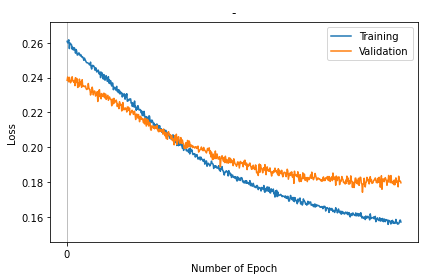

In [5]:
Train_Loss = [0.26091787219047546, 0.2600100338459015, 0.2609460949897766, 0.26178717613220215, 0.25672149658203125, 0.25984272360801697, 0.2597927153110504, 0.2590901255607605, 0.2588556110858917, 0.25639063119888306, 0.2575110197067261, 0.25599661469459534, 0.2559853196144104, 0.2571961283683777, 0.2560793161392212, 0.254104346036911, 0.25620192289352417, 0.2554423213005066, 0.25310948491096497, 0.252996563911438, 0.2537088096141815, 0.25428637862205505, 0.25394147634506226, 0.2528645694255829, 0.25254687666893005, 0.25309237837791443, 0.25213950872421265, 0.25168195366859436, 0.25187453627586365, 0.2510775625705719, 0.25000929832458496, 0.25129878520965576, 0.2505815625190735, 0.24978096783161163, 0.24912989139556885, 0.24863272905349731, 0.2485807240009308, 0.24856582283973694, 0.24822422862052917, 0.2480408400297165, 0.24742336571216583, 0.24730505049228668, 0.24896202981472015, 0.24607813358306885, 0.2449679672718048, 0.24674589931964874, 0.24713945388793945, 0.24667300283908844, 0.2466590404510498, 0.24579213559627533, 0.24429701268672943, 0.2456396073102951, 0.2455011010169983, 0.243311807513237, 0.2434156984090805, 0.24426224827766418, 0.24433664977550507, 0.24247868359088898, 0.2419862598180771, 0.24323764443397522, 0.24001628160476685, 0.24324177205562592, 0.24146099388599396, 0.24275219440460205, 0.23988093435764313, 0.23919153213500977, 0.2417954057455063, 0.2403072714805603, 0.23854811489582062, 0.24043528735637665, 0.24118073284626007, 0.23956237733364105, 0.23789173364639282, 0.23802387714385986, 0.24060219526290894, 0.23688417673110962, 0.23870477080345154, 0.2365822196006775, 0.2383098155260086, 0.23614953458309174, 0.2352081835269928, 0.23703716695308685, 0.23682668805122375, 0.2330765277147293, 0.23465703427791595, 0.23398452997207642, 0.23399028182029724, 0.2329055219888687, 0.23437219858169556, 0.23503004014492035, 0.23213373124599457, 0.233129620552063, 0.23137229681015015, 0.2329229712486267, 0.23270517587661743, 0.23058050870895386, 0.23172247409820557, 0.23147405683994293, 0.2313500940799713, 0.2288939654827118, 0.23060056567192078, 0.22952145338058472, 0.23058216273784637, 0.23070237040519714, 0.22763413190841675, 0.22997640073299408, 0.22875748574733734, 0.23079824447631836, 0.2264777421951294, 0.22688138484954834, 0.22680950164794922, 0.22761520743370056, 0.22729118168354034, 0.22782833874225616, 0.22779622673988342, 0.22527024149894714, 0.2256608009338379, 0.22350408136844635, 0.22548232972621918, 0.22459475696086884, 0.2231791615486145, 0.22659535706043243, 0.22308383882045746, 0.2235802561044693, 0.2212243527173996, 0.22261597216129303, 0.22188518941402435, 0.22392787039279938, 0.22273902595043182, 0.2214803695678711, 0.22148622572422028, 0.22171340882778168, 0.2213219553232193, 0.21981056034564972, 0.22080200910568237, 0.21824418008327484, 0.21997950971126556, 0.21815620362758636, 0.22066156566143036, 0.21831363439559937, 0.21674001216888428, 0.21627886593341827, 0.2176160365343094, 0.2163625806570053, 0.21650637686252594, 0.21734800934791565, 0.21552588045597076, 0.21811580657958984, 0.21778881549835205, 0.21452511847019196, 0.21535933017730713, 0.21422378718852997, 0.2156638205051422, 0.21524229645729065, 0.21426501870155334, 0.21290062367916107, 0.213828906416893, 0.21158990263938904, 0.21299105882644653, 0.21232187747955322, 0.21307307481765747, 0.21337898075580597, 0.21296894550323486, 0.21155792474746704, 0.21241918206214905, 0.21006281673908234, 0.2124098837375641, 0.20978164672851562, 0.21054141223430634, 0.21069690585136414, 0.2086220383644104, 0.20983359217643738, 0.20828405022621155, 0.20820073783397675, 0.21021996438503265, 0.20702509582042694, 0.20870962738990784, 0.20977893471717834, 0.20802797377109528, 0.20671454071998596, 0.2085137665271759, 0.20653265714645386, 0.2081083059310913, 0.2074054479598999, 0.2053750604391098, 0.20506305992603302, 0.20587749779224396, 0.20467092096805573, 0.20504239201545715, 0.2057819664478302, 0.20718559622764587, 0.2045661211013794, 0.2051752656698227, 0.20455878973007202, 0.20305511355400085, 0.20282942056655884, 0.2027016431093216, 0.20102687180042267, 0.2029999941587448, 0.2046537548303604, 0.20091202855110168, 0.20240402221679688, 0.20135292410850525, 0.20325128734111786, 0.20217663049697876, 0.20095272362232208, 0.20152771472930908, 0.1993575394153595, 0.2015497237443924, 0.1982007920742035, 0.19969037175178528, 0.20075927674770355, 0.20014967024326324, 0.19930432736873627, 0.19795124232769012, 0.19828300178050995, 0.1979815661907196, 0.19839991629123688, 0.19704440236091614, 0.19917495548725128, 0.19614703953266144, 0.19961628317832947, 0.19833852350711823, 0.19777889549732208, 0.198478564620018, 0.1966152787208557, 0.19576755166053772, 0.19606654345989227, 0.19613149762153625, 0.19634678959846497, 0.19436639547348022, 0.19542117416858673, 0.19516509771347046, 0.19578766822814941, 0.19427675008773804, 0.19316209852695465, 0.1940748691558838, 0.19396761059761047, 0.1943305879831314, 0.19271087646484375, 0.1943538635969162, 0.1930028796195984, 0.1930510252714157, 0.19313538074493408, 0.1919672042131424, 0.19272223114967346, 0.19308561086654663, 0.19029462337493896, 0.19197572767734528, 0.1906973123550415, 0.19216975569725037, 0.18908199667930603, 0.18985190987586975, 0.19087615609169006, 0.190354585647583, 0.1903211921453476, 0.18924418091773987, 0.189720019698143, 0.1905823051929474, 0.19205032289028168, 0.1909075677394867, 0.1905588060617447, 0.19025415182113647, 0.18780502676963806, 0.18924668431282043, 0.18936432898044586, 0.18861648440361023, 0.18931496143341064, 0.18818272650241852, 0.1882142722606659, 0.1885189712047577, 0.18793810904026031, 0.1894151270389557, 0.18700481951236725, 0.18752597272396088, 0.18619342148303986, 0.18800069391727448, 0.1873934268951416, 0.18888987600803375, 0.18677647411823273, 0.18645629286766052, 0.18520577251911163, 0.1840275675058365, 0.1854432225227356, 0.18610575795173645, 0.1859324425458908, 0.18649396300315857, 0.18581274151802063, 0.1858217865228653, 0.18351371586322784, 0.18658345937728882, 0.18527743220329285, 0.18541471660137177, 0.18384027481079102, 0.18466827273368835, 0.18262448906898499, 0.1837230622768402, 0.184071347117424, 0.18288765847682953, 0.18283449113368988, 0.18244625627994537, 0.1831510365009308, 0.1821163147687912, 0.1829875260591507, 0.18126443028450012, 0.18056002259254456, 0.18301986157894135, 0.18113671243190765, 0.18233317136764526, 0.1820877343416214, 0.18098121881484985, 0.18095238506793976, 0.18259035050868988, 0.18238465487957, 0.18228879570960999, 0.1801523119211197, 0.1805954873561859, 0.17965704202651978, 0.17947416007518768, 0.1805385947227478, 0.1808030903339386, 0.17932763695716858, 0.180739626288414, 0.17935748398303986, 0.17937274277210236, 0.1796841323375702, 0.1787814199924469, 0.17943789064884186, 0.1808270514011383, 0.17795930802822113, 0.1794136017560959, 0.17869488894939423, 0.17761826515197754, 0.1777375340461731, 0.1792880892753601, 0.17822866141796112, 0.17709946632385254, 0.17742176353931427, 0.17743191123008728, 0.1767347902059555, 0.17793405055999756, 0.1780690848827362, 0.17736303806304932, 0.1756570041179657, 0.17688684165477753, 0.17678436636924744, 0.17678655683994293, 0.17622210085391998, 0.1748611330986023, 0.17689202725887299, 0.17677028477191925, 0.17611739039421082, 0.17576882243156433, 0.17803631722927094, 0.174642413854599, 0.17411956191062927, 0.17630574107170105, 0.17538808286190033, 0.17488305270671844, 0.17725513875484467, 0.17647568881511688, 0.17471370100975037, 0.17710907757282257, 0.17469283938407898, 0.1739262491464615, 0.1736753135919571, 0.1761542111635208, 0.17467942833900452, 0.1745813637971878, 0.17482198774814606, 0.17599165439605713, 0.17332445085048676, 0.17362847924232483, 0.17137354612350464, 0.17501449584960938, 0.17389844357967377, 0.1752728372812271, 0.1716368943452835, 0.17433732748031616, 0.17213565111160278, 0.1722704917192459, 0.17259016633033752, 0.1725989729166031, 0.17292749881744385, 0.17269030213356018, 0.17202317714691162, 0.17161644995212555, 0.17202500998973846, 0.17184114456176758, 0.17170833051204681, 0.17181314527988434, 0.1711655855178833, 0.17203494906425476, 0.17074938118457794, 0.17130471765995026, 0.17063741385936737, 0.17186114192008972, 0.17009040713310242, 0.16895799338817596, 0.1692633479833603, 0.17097514867782593, 0.17232125997543335, 0.1710038185119629, 0.16997817158699036, 0.17111757397651672, 0.1704012155532837, 0.16918377578258514, 0.17116664350032806, 0.16872847080230713, 0.1710348278284073, 0.16966326534748077, 0.1694503277540207, 0.16907033324241638, 0.16754458844661713, 0.17016881704330444, 0.16871026158332825, 0.1696770191192627, 0.170577734708786, 0.17082223296165466, 0.16741886734962463, 0.16846109926700592, 0.16858230531215668, 0.1667587161064148, 0.16754776239395142, 0.17033560574054718, 0.1689542531967163, 0.16904887557029724, 0.1683688461780548, 0.16725166141986847, 0.16769114136695862, 0.16671356558799744, 0.1671038120985031, 0.16896630823612213, 0.1674610674381256, 0.1674676537513733, 0.16851645708084106, 0.16840219497680664, 0.16856315732002258, 0.16664709150791168, 0.16694222390651703, 0.16714352369308472, 0.16686058044433594, 0.16588547825813293, 0.16675564646720886, 0.16737200319766998, 0.16558149456977844, 0.16720892488956451, 0.16599150002002716, 0.16652826964855194, 0.16677016019821167, 0.166372612118721, 0.1665174961090088, 0.16642546653747559, 0.1659313142299652, 0.1655353307723999, 0.16582946479320526, 0.16562461853027344, 0.16594836115837097, 0.165630504488945, 0.16469822824001312, 0.1660171002149582, 0.16559970378875732, 0.1660967618227005, 0.16582557559013367, 0.16334977746009827, 0.1651599258184433, 0.16520379483699799, 0.16531215608119965, 0.16477887332439423, 0.16431927680969238, 0.16253662109375, 0.165120929479599, 0.16401712596416473, 0.1647065132856369, 0.1638934165239334, 0.1648440659046173, 0.16394326090812683, 0.16305643320083618, 0.16377794742584229, 0.1636487990617752, 0.16252534091472626, 0.16341513395309448, 0.16525393724441528, 0.1641233116388321, 0.16366034746170044, 0.16228704154491425, 0.1633952260017395, 0.16453485190868378, 0.1628817915916443, 0.1624053567647934, 0.1633147895336151, 0.16218511760234833, 0.16151437163352966, 0.16318932175636292, 0.16265437006950378, 0.16188159584999084, 0.16268928349018097, 0.16187390685081482, 0.16161073744297028, 0.1622641235589981, 0.16278110444545746, 0.16230188310146332, 0.16176322102546692, 0.16263990104198456, 0.16125302016735077, 0.16171124577522278, 0.16244888305664062, 0.16064007580280304, 0.15996494889259338, 0.16156111657619476, 0.16190208494663239, 0.16076435148715973, 0.16206564009189606, 0.16221719980239868, 0.16162016987800598, 0.16105419397354126, 0.16107311844825745, 0.16068804264068604, 0.16229261457920074, 0.1606934517621994, 0.16060461103916168, 0.1619345247745514, 0.1614098995923996, 0.16046097874641418, 0.1618783324956894, 0.1611560583114624, 0.16044814884662628, 0.162380188703537, 0.16093167662620544, 0.15933607518672943, 0.1601644605398178, 0.15963828563690186, 0.15911220014095306, 0.15975412726402283, 0.1600356549024582, 0.15844036638736725, 0.1605152189731598, 0.15934400260448456, 0.1593025177717209, 0.16024230420589447, 0.16025567054748535, 0.15960058569908142, 0.1593480110168457, 0.15824592113494873, 0.16173212230205536, 0.15980474650859833, 0.159068301320076, 0.1594487577676773, 0.1594730168581009, 0.15950416028499603, 0.15996624529361725, 0.1588573157787323, 0.1592099815607071, 0.16030067205429077, 0.1572096049785614, 0.1587856560945511, 0.1587933599948883, 0.15943852066993713, 0.15826702117919922, 0.15791599452495575, 0.15807196497917175, 0.15948250889778137, 0.15754935145378113, 0.15797512233257294, 0.1588754951953888, 0.15769372880458832, 0.15907888114452362, 0.15742012858390808, 0.1572600156068802, 0.15879109501838684, 0.15767046809196472, 0.15724246203899384, 0.15848329663276672, 0.15810810029506683, 0.1583212912082672, 0.1576618254184723, 0.15566368401050568, 0.15804868936538696, 0.15760932862758636, 0.15765370428562164, 0.15658260881900787, 0.1558987945318222, 0.15771883726119995, 0.15751813352108002, 0.15798142552375793, 0.15628960728645325, 0.15718317031860352, 0.156235933303833, 0.15644904971122742, 0.15638665854930878, 0.15853390097618103, 0.15660886466503143, 0.15688732266426086, 0.15582948923110962, 0.15623420476913452, 0.15602512657642365, 0.15670567750930786, 0.15805475413799286, 0.15815728902816772, 0.15702350437641144]
Test_Loss = [0.2384827584028244, 0.24043531715869904, 0.23836563527584076, 0.23761725425720215, 0.24020175635814667, 0.23878875374794006, 0.2370867282152176, 0.2376573085784912, 0.23851168155670166, 0.24054251611232758, 0.23818889260292053, 0.2380078136920929, 0.23735252022743225, 0.2384844273328781, 0.2354276478290558, 0.23999762535095215, 0.23718468844890594, 0.23957319557666779, 0.2391388863325119, 0.23437634110450745, 0.2368404120206833, 0.23488445580005646, 0.23918592929840088, 0.23710332810878754, 0.23594294488430023, 0.2377886325120926, 0.23448505997657776, 0.23883751034736633, 0.23505835235118866, 0.2353905290365219, 0.2351152002811432, 0.23482131958007812, 0.23508410155773163, 0.2352471649646759, 0.2336866706609726, 0.23322658240795135, 0.2333955019712448, 0.23365174233913422, 0.23666322231292725, 0.23405085504055023, 0.23323217034339905, 0.23317360877990723, 0.23001737892627716, 0.2314411699771881, 0.23171208798885345, 0.23457995057106018, 0.2327411025762558, 0.23012547194957733, 0.231876403093338, 0.2323872596025467, 0.2320147007703781, 0.22943814098834991, 0.22987528145313263, 0.23098433017730713, 0.23194880783557892, 0.2263241857290268, 0.23139457404613495, 0.232595756649971, 0.23310212790966034, 0.2290632277727127, 0.23040445148944855, 0.22786776721477509, 0.23088927567005157, 0.22945551574230194, 0.22967009246349335, 0.2290867120027542, 0.23114028573036194, 0.2290205955505371, 0.22829292714595795, 0.23064656555652618, 0.2275080680847168, 0.22824282944202423, 0.22934961318969727, 0.22986824810504913, 0.22697794437408447, 0.2279679775238037, 0.22895674407482147, 0.2280101776123047, 0.22755880653858185, 0.2270849496126175, 0.22383439540863037, 0.22773359715938568, 0.22603130340576172, 0.22501865029335022, 0.22814391553401947, 0.2255364954471588, 0.22621679306030273, 0.22643132507801056, 0.22715668380260468, 0.2260071337223053, 0.223414808511734, 0.22479121387004852, 0.22457285225391388, 0.22219336032867432, 0.2261703759431839, 0.2241993397474289, 0.22456860542297363, 0.2246832400560379, 0.22088460624217987, 0.2227434664964676, 0.22571837902069092, 0.221835657954216, 0.22157032787799835, 0.22174783051013947, 0.22270365059375763, 0.22197596728801727, 0.22222848236560822, 0.2202697992324829, 0.22314558923244476, 0.22288468480110168, 0.2231072038412094, 0.22113929688930511, 0.22245021164417267, 0.21858854591846466, 0.21980467438697815, 0.22001634538173676, 0.22119741141796112, 0.22122672200202942, 0.22001071274280548, 0.2189035713672638, 0.22014649212360382, 0.22072677314281464, 0.218613862991333, 0.21594643592834473, 0.21880888938903809, 0.21910405158996582, 0.21793504059314728, 0.21681880950927734, 0.2188204824924469, 0.21728180348873138, 0.21469441056251526, 0.21747414767742157, 0.2178179770708084, 0.21606948971748352, 0.21671190857887268, 0.2160051316022873, 0.2160535603761673, 0.21416182816028595, 0.21632908284664154, 0.21341834962368011, 0.21668289601802826, 0.2143087238073349, 0.21219687163829803, 0.21628355979919434, 0.21318045258522034, 0.21570296585559845, 0.212248757481575, 0.21241970360279083, 0.2143164724111557, 0.21331219375133514, 0.20999737083911896, 0.2098292112350464, 0.21232092380523682, 0.21169781684875488, 0.21211734414100647, 0.21100187301635742, 0.21203301846981049, 0.210616335272789, 0.2120862454175949, 0.2116236686706543, 0.21095529198646545, 0.21266542375087738, 0.21014200150966644, 0.20970836281776428, 0.2089664787054062, 0.2104816883802414, 0.20904695987701416, 0.20920555293560028, 0.21020641922950745, 0.20966796576976776, 0.20886926352977753, 0.21001838147640228, 0.20753240585327148, 0.21044884622097015, 0.20859502255916595, 0.2085147202014923, 0.206506609916687, 0.20851901173591614, 0.2050328254699707, 0.20670317113399506, 0.20459528267383575, 0.20821543037891388, 0.20897901058197021, 0.2074236422777176, 0.2069023698568344, 0.20731981098651886, 0.2049035131931305, 0.20678754150867462, 0.20670127868652344, 0.20379386842250824, 0.20485682785511017, 0.20449940860271454, 0.20140938460826874, 0.2067292183637619, 0.20518437027931213, 0.20374107360839844, 0.2075321227312088, 0.20165733993053436, 0.2056778520345688, 0.20520739257335663, 0.20604756474494934, 0.20354004204273224, 0.20233507454395294, 0.2027386873960495, 0.20558343827724457, 0.20231933891773224, 0.20431552827358246, 0.20403699576854706, 0.20200572907924652, 0.20205436646938324, 0.1994926482439041, 0.19981835782527924, 0.19933490455150604, 0.20268073678016663, 0.20245502889156342, 0.19958819448947906, 0.20393012464046478, 0.20338945090770721, 0.20025849342346191, 0.20360605418682098, 0.2026088982820511, 0.20028315484523773, 0.20141644775867462, 0.20088863372802734, 0.20101960003376007, 0.1997978538274765, 0.20064453780651093, 0.20026810467243195, 0.19987395405769348, 0.19954244792461395, 0.20030274987220764, 0.1998380422592163, 0.20005778968334198, 0.19928672909736633, 0.200459286570549, 0.2006446123123169, 0.19722393155097961, 0.19781281054019928, 0.19834430515766144, 0.1986565887928009, 0.19905702769756317, 0.20015601813793182, 0.19851255416870117, 0.19888482987880707, 0.19800086319446564, 0.19989804923534393, 0.19845955073833466, 0.19842401146888733, 0.197782501578331, 0.19742976129055023, 0.19675175845623016, 0.19802325963974, 0.1993386447429657, 0.19815103709697723, 0.1993640661239624, 0.1996801346540451, 0.19631174206733704, 0.19797274470329285, 0.19447460770606995, 0.19722603261470795, 0.1945449709892273, 0.19287557899951935, 0.1961083859205246, 0.1933356076478958, 0.193953737616539, 0.19442911446094513, 0.19785280525684357, 0.19348719716072083, 0.19532237946987152, 0.19615255296230316, 0.19418983161449432, 0.19330479204654694, 0.19321513175964355, 0.1945362538099289, 0.1945737600326538, 0.18870802223682404, 0.19315676391124725, 0.19383801519870758, 0.1951398104429245, 0.19376851618289948, 0.1922701597213745, 0.19179196655750275, 0.19423680007457733, 0.19118857383728027, 0.19488614797592163, 0.19282186031341553, 0.19109392166137695, 0.19261330366134644, 0.19262999296188354, 0.1908283531665802, 0.19388502836227417, 0.1939212828874588, 0.19121937453746796, 0.19362841546535492, 0.1910971850156784, 0.19264619052410126, 0.19221331179141998, 0.19183476269245148, 0.189435213804245, 0.1933831423521042, 0.19205264747142792, 0.19081279635429382, 0.19018279016017914, 0.19001539051532745, 0.18907256424427032, 0.19022636115550995, 0.19161860644817352, 0.19013682007789612, 0.19137325882911682, 0.1880803257226944, 0.19001495838165283, 0.19186453521251678, 0.19081886112689972, 0.1912665069103241, 0.19058696925640106, 0.19090406596660614, 0.18881045281887054, 0.19202633202075958, 0.19041791558265686, 0.1926213800907135, 0.19033150374889374, 0.1896253079175949, 0.190937340259552, 0.1871480792760849, 0.18988089263439178, 0.18917687237262726, 0.18946775794029236, 0.19050811231136322, 0.19094114005565643, 0.18942545354366302, 0.18862870335578918, 0.1873585432767868, 0.18870513141155243, 0.18762819468975067, 0.18969039618968964, 0.18781571090221405, 0.1875930279493332, 0.18719713389873505, 0.18983562290668488, 0.18949675559997559, 0.18528972566127777, 0.1856464445590973, 0.18536660075187683, 0.1837703138589859, 0.18935202062129974, 0.19035544991493225, 0.18564577400684357, 0.18991124629974365, 0.18804757297039032, 0.1878775656223297, 0.18679210543632507, 0.18533198535442352, 0.18776917457580566, 0.1882581263780594, 0.1869335025548935, 0.19003163278102875, 0.18650858104228973, 0.1842454969882965, 0.18774068355560303, 0.1887669861316681, 0.18701086938381195, 0.18639452755451202, 0.187203049659729, 0.18617205321788788, 0.18816013634204865, 0.18602143228054047, 0.18520322442054749, 0.18345610797405243, 0.18598325550556183, 0.18498291075229645, 0.18607579171657562, 0.18663941323757172, 0.18576166033744812, 0.18801936507225037, 0.18615639209747314, 0.18660271167755127, 0.18547064065933228, 0.18557050824165344, 0.1841430515050888, 0.18767093122005463, 0.18372415006160736, 0.18679092824459076, 0.18593572080135345, 0.18508510291576385, 0.18478624522686005, 0.18678615987300873, 0.18462927639484406, 0.18302786350250244, 0.18372754752635956, 0.18552614748477936, 0.18567441403865814, 0.18547885119915009, 0.18516658246517181, 0.18312139809131622, 0.1850508749485016, 0.18739037215709686, 0.1863614022731781, 0.18163736164569855, 0.18324565887451172, 0.18497370183467865, 0.1838068664073944, 0.18552236258983612, 0.18420861661434174, 0.18587027490139008, 0.18297801911830902, 0.182816743850708, 0.1843574494123459, 0.17925702035427094, 0.1862630397081375, 0.1835918426513672, 0.18424783647060394, 0.18416213989257812, 0.1833769977092743, 0.18308834731578827, 0.18592365086078644, 0.18293362855911255, 0.1813635677099228, 0.18025551736354828, 0.18431729078292847, 0.18253974616527557, 0.18035385012626648, 0.18165983259677887, 0.18220771849155426, 0.18531978130340576, 0.18203555047512054, 0.1846383959054947, 0.18448598682880402, 0.18099378049373627, 0.18136125802993774, 0.18256717920303345, 0.18149533867835999, 0.18025261163711548, 0.18262068927288055, 0.18187165260314941, 0.1813686192035675, 0.18235154449939728, 0.1828017234802246, 0.184064581990242, 0.1821482926607132, 0.18572138249874115, 0.18249598145484924, 0.1823980063199997, 0.18136140704154968, 0.18225204944610596, 0.18337833881378174, 0.18498127162456512, 0.18363788723945618, 0.1824989765882492, 0.18113116919994354, 0.18188922107219696, 0.18239477276802063, 0.18220001459121704, 0.18159565329551697, 0.1818913221359253, 0.18153367936611176, 0.18081024289131165, 0.18139412999153137, 0.18046186864376068, 0.18057066202163696, 0.18225407600402832, 0.18297304213047028, 0.18079917132854462, 0.18202714622020721, 0.18091587722301483, 0.1824377030134201, 0.18240897357463837, 0.18195128440856934, 0.18315520882606506, 0.18143849074840546, 0.18090634047985077, 0.1831940859556198, 0.18238253891468048, 0.18037204444408417, 0.18167699873447418, 0.18267342448234558, 0.18300853669643402, 0.18082313239574432, 0.18521228432655334, 0.18257108330726624, 0.18156956136226654, 0.18283231556415558, 0.1824001520872116, 0.17815889418125153, 0.1834760159254074, 0.18240879476070404, 0.18083934485912323, 0.18282945454120636, 0.18265093863010406, 0.18294985592365265, 0.17852920293807983, 0.18105719983577728, 0.18031421303749084, 0.1807519495487213, 0.18318353593349457, 0.18195216357707977, 0.1814865916967392, 0.17971566319465637, 0.17971600592136383, 0.17984111607074738, 0.1788918823003769, 0.1811034232378006, 0.17934170365333557, 0.18342308700084686, 0.1804983913898468, 0.18237702548503876, 0.17886196076869965, 0.18072861433029175, 0.17889344692230225, 0.17976723611354828, 0.18357431888580322, 0.18082819879055023, 0.18052493035793304, 0.17693296074867249, 0.1799575537443161, 0.17874614894390106, 0.17686568200588226, 0.17963768541812897, 0.18224264681339264, 0.18230471014976501, 0.17953087389469147, 0.18099451065063477, 0.17892861366271973, 0.1807580441236496, 0.1821473091840744, 0.1780748814344406, 0.18207509815692902, 0.18279004096984863, 0.18263399600982666, 0.17923788726329803, 0.17900006473064423, 0.17412793636322021, 0.1787552684545517, 0.178801491856575, 0.18219517171382904, 0.1785515397787094, 0.17717885971069336, 0.1798025369644165, 0.17997291684150696, 0.18272380530834198, 0.18096958100795746, 0.1806923896074295, 0.18156041204929352, 0.17892706394195557, 0.18021492660045624, 0.1831071972846985, 0.18038803339004517, 0.18144598603248596, 0.17924390733242035, 0.17949917912483215, 0.17963290214538574, 0.18093906342983246, 0.18120414018630981, 0.18121571838855743, 0.18237893283367157, 0.181576669216156, 0.17968402802944183, 0.18040260672569275, 0.17954730987548828, 0.18222463130950928, 0.17985814809799194, 0.18273453414440155, 0.1801915466785431, 0.17705588042736053, 0.17945434153079987, 0.18363115191459656, 0.1758587509393692, 0.18119554221630096, 0.18188002705574036, 0.18133650720119476, 0.18020404875278473, 0.18197406828403473, 0.18254350125789642, 0.18168091773986816, 0.18057739734649658, 0.17814399302005768, 0.18095992505550385, 0.17995578050613403, 0.18382327258586884, 0.18171022832393646, 0.1829402595758438, 0.17965827882289886, 0.1837507039308548, 0.18105314671993256, 0.17948386073112488, 0.17948268353939056, 0.18030428886413574, 0.17859038710594177, 0.18113036453723907, 0.1784050464630127, 0.18021874129772186, 0.18242233991622925, 0.1805088222026825, 0.17967429757118225, 0.1805042177438736, 0.1772558093070984, 0.18336652219295502, 0.1807308942079544, 0.18044313788414001, 0.1805923581123352, 0.17957662045955658]
lossGraph(Train_Loss, Test_Loss)

test_loss_min: 0.18304763734340668 test_loss_min_epoch: 17


/tmp/ipykernel_127664/4288951258.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


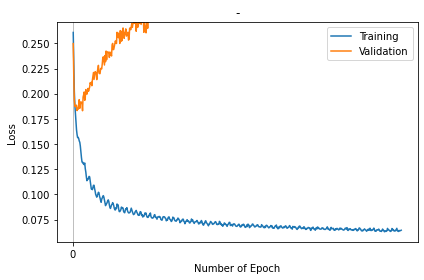

In [6]:
Train_Loss = [0.26078879833221436, 0.23031403124332428, 0.2023410052061081, 0.18862979114055634, 0.18007336556911469, 0.17209568619728088, 0.16420622169971466, 0.15948806703090668, 0.15639276802539825, 0.15659672021865845, 0.15542961657047272, 0.15303008258342743, 0.1517285704612732, 0.147874116897583, 0.14200842380523682, 0.13667342066764832, 0.13234515488147736, 0.13146205246448517, 0.13170240819454193, 0.12981630861759186, 0.12966346740722656, 0.1311454474925995, 0.12557236850261688, 0.12213171273469925, 0.11723288893699646, 0.11356646567583084, 0.11500629782676697, 0.11489658802747726, 0.11647828668355942, 0.11785294115543365, 0.11734475195407867, 0.11321324855089188, 0.10969891399145126, 0.10537468641996384, 0.10570333153009415, 0.10470312833786011, 0.10672534257173538, 0.10897520184516907, 0.10902706533670425, 0.1057063415646553, 0.10322935879230499, 0.09992696344852448, 0.09848491847515106, 0.09719870984554291, 0.09912776947021484, 0.1002887561917305, 0.10209614783525467, 0.101573146879673, 0.09810905903577805, 0.09646015614271164, 0.09392870217561722, 0.09211726486682892, 0.09524042904376984, 0.09638967365026474, 0.09801308065652847, 0.09873338043689728, 0.09719707071781158, 0.09437171369791031, 0.09148238599300385, 0.08879543840885162, 0.09009864926338196, 0.09075048565864563, 0.0919882133603096, 0.09369309991598129, 0.0945170670747757, 0.09288002550601959, 0.08948224037885666, 0.08710813522338867, 0.08599406480789185, 0.0878726914525032, 0.08955574035644531, 0.09005412459373474, 0.09178599715232849, 0.09062741696834564, 0.08886256068944931, 0.08623315393924713, 0.08465220034122467, 0.08450892567634583, 0.08673177659511566, 0.08593585342168808, 0.09043576568365097, 0.08920372277498245, 0.0895017758011818, 0.08552344143390656, 0.08294715732336044, 0.08285738527774811, 0.08367226272821426, 0.0848163366317749, 0.08735526353120804, 0.08645854145288467, 0.08688804507255554, 0.08625947684049606, 0.0830637514591217, 0.082117460668087, 0.0817122533917427, 0.08398381620645523, 0.08574780076742172, 0.0854501873254776, 0.0867919772863388, 0.08391820639371872, 0.08254332095384598, 0.08164596557617188, 0.08150836825370789, 0.08185285329818726, 0.0823955237865448, 0.08434442430734634, 0.08630409091711044, 0.08447930216789246, 0.08277427405118942, 0.08137431740760803, 0.07987667620182037, 0.08022867888212204, 0.08067266643047333, 0.08268073201179504, 0.08293750882148743, 0.08402865380048752, 0.08243042975664139, 0.08143363147974014, 0.08011291176080704, 0.079095758497715, 0.08009450137615204, 0.07944273203611374, 0.08251198381185532, 0.08285316824913025, 0.0819057747721672, 0.07906510680913925, 0.07976695150136948, 0.07750523090362549, 0.07823536545038223, 0.07813730090856552, 0.07994170486927032, 0.08150928467512131, 0.08075223118066788, 0.08136796951293945, 0.07868792116641998, 0.07740116119384766, 0.0771009549498558, 0.07722634077072144, 0.07914073020219803, 0.07889889180660248, 0.0808519795536995, 0.08146131783723831, 0.07796584814786911, 0.07688356935977936, 0.07650221884250641, 0.07632921636104584, 0.07681168615818024, 0.0778241977095604, 0.07939238846302032, 0.07987625896930695, 0.07720743119716644, 0.07755237072706223, 0.07653452455997467, 0.07533416897058487, 0.07753138989210129, 0.07745683938264847, 0.0777835100889206, 0.07809332013130188, 0.07746672630310059, 0.07745783776044846, 0.07501838356256485, 0.07478947937488556, 0.07424617558717728, 0.07568259537220001, 0.07767653465270996, 0.0778009369969368, 0.07778280228376389, 0.07752162963151932, 0.0763341411948204, 0.07614832371473312, 0.07375151664018631, 0.07456684112548828, 0.07433813810348511, 0.07639254629611969, 0.07744522392749786, 0.07763263583183289, 0.0756489485502243, 0.07497019320726395, 0.07483458518981934, 0.07302649319171906, 0.07349903136491776, 0.07481823116540909, 0.0774158462882042, 0.0766807571053505, 0.07657276839017868, 0.07466692477464676, 0.07375893741846085, 0.07358907908201218, 0.0732702985405922, 0.07459784299135208, 0.07463663071393967, 0.07638172805309296, 0.07617390155792236, 0.07513473927974701, 0.07417984306812286, 0.07180078327655792, 0.07328586280345917, 0.0729474425315857, 0.07315323501825333, 0.07492001354694366, 0.07533526420593262, 0.07529964298009872, 0.073246069252491, 0.07267554849386215, 0.07083262503147125, 0.07208190113306046, 0.07342454791069031, 0.07341712713241577, 0.07485916465520859, 0.07317349314689636, 0.07364402711391449, 0.07332364469766617, 0.07174117118120193, 0.07154346257448196, 0.0725896805524826, 0.072980597615242, 0.07553748786449432, 0.07378648966550827, 0.07476957887411118, 0.07291065156459808, 0.07201104611158371, 0.07115406543016434, 0.07257062941789627, 0.07271703332662582, 0.07303902506828308, 0.07291550189256668, 0.07406394928693771, 0.07276581227779388, 0.07226777076721191, 0.07064011693000793, 0.0707530677318573, 0.07195782661437988, 0.07232018560171127, 0.07167726010084152, 0.07403670996427536, 0.07314584404230118, 0.07114418596029282, 0.06975647807121277, 0.06934650987386703, 0.07117734104394913, 0.07109884917736053, 0.07324051111936569, 0.07381691038608551, 0.07224318385124207, 0.07146316021680832, 0.07083819806575775, 0.06982751935720444, 0.06878077238798141, 0.07062084227800369, 0.07041198015213013, 0.0720885619521141, 0.073116734623909, 0.07229418307542801, 0.07186048477888107, 0.07052139192819595, 0.07016313821077347, 0.0707644522190094, 0.07089646905660629, 0.07173702120780945, 0.07262766361236572, 0.07288308441638947, 0.07194434851408005, 0.07017049938440323, 0.07022030651569366, 0.06998475641012192, 0.0705031082034111, 0.07035594433546066, 0.07316665351390839, 0.07257591933012009, 0.07064347714185715, 0.07099789381027222, 0.06931117177009583, 0.06994789838790894, 0.068292997777462, 0.06928153336048126, 0.07007976621389389, 0.07167082279920578, 0.07109203189611435, 0.07008267939090729, 0.07019540667533875, 0.06943699717521667, 0.06822895258665085, 0.0696370005607605, 0.0702752023935318, 0.07130670547485352, 0.0722181499004364, 0.07207142561674118, 0.0690189078450203, 0.06933105736970901, 0.07010965794324875, 0.06936417520046234, 0.06850551813840866, 0.0704597607254982, 0.0701780617237091, 0.07071597129106522, 0.07035183906555176, 0.06927681714296341, 0.06847982853651047, 0.06833606213331223, 0.06818107515573502, 0.0689992904663086, 0.06951862573623657, 0.07030891627073288, 0.07024961709976196, 0.06848829984664917, 0.0677226260304451, 0.06754057109355927, 0.06919210404157639, 0.06872648000717163, 0.0700373500585556, 0.06951332837343216, 0.07035677880048752, 0.06984361261129379, 0.06823532283306122, 0.06726744771003723, 0.06726182252168655, 0.0679541602730751, 0.06964679062366486, 0.06808135658502579, 0.07041066139936447, 0.07009866833686829, 0.06898398697376251, 0.06694269180297852, 0.06833003461360931, 0.06808321177959442, 0.06857909262180328, 0.06912942230701447, 0.07037973403930664, 0.07054408639669418, 0.06938615441322327, 0.06906408071517944, 0.06779645383358002, 0.0676070973277092, 0.0682302713394165, 0.06834793090820312, 0.06937602162361145, 0.06909919530153275, 0.06981044262647629, 0.06828824430704117, 0.06778866052627563, 0.06785988807678223, 0.0675448551774025, 0.0674552172422409, 0.0676460787653923, 0.06990952789783478, 0.06906921416521072, 0.06882274150848389, 0.06765540689229965, 0.06709791719913483, 0.06682652235031128, 0.06817090511322021, 0.06710469722747803, 0.06895449757575989, 0.06930111348628998, 0.06899279356002808, 0.06817653030157089, 0.06753893196582794, 0.06673948466777802, 0.06697706133127213, 0.06781788915395737, 0.06791438162326813, 0.06904392689466476, 0.06791723519563675, 0.0687069371342659, 0.06657900661230087, 0.0664261057972908, 0.06701744347810745, 0.06640549004077911, 0.06779620796442032, 0.06869978457689285, 0.068755142390728, 0.06953047960996628, 0.06692800670862198, 0.06723736226558685, 0.06575171649456024, 0.0666389986872673, 0.06784899532794952, 0.06675881892442703, 0.06854378432035446, 0.06865840405225754, 0.06848648190498352, 0.06725628674030304, 0.06672622263431549, 0.06648146361112595, 0.06727235019207001, 0.06792043149471283, 0.06704537570476532, 0.06836899369955063, 0.06876710802316666, 0.06807529181241989, 0.06657420843839645, 0.06637780368328094, 0.06719715893268585, 0.06714243441820145, 0.06772832572460175, 0.06904818117618561, 0.06829490512609482, 0.06712767481803894, 0.06624680757522583, 0.0666792243719101, 0.06542211025953293, 0.0681534931063652, 0.06787139922380447, 0.06765034794807434, 0.06800691038370132, 0.06717012822628021, 0.06742607802152634, 0.06658840924501419, 0.06552919000387192, 0.0651787742972374, 0.06604068726301193, 0.06727907061576843, 0.06683165580034256, 0.06848955154418945, 0.06847009062767029, 0.06749660521745682, 0.06651583313941956, 0.0659341961145401, 0.06618116050958633, 0.06653568148612976, 0.06604229658842087, 0.06771834939718246, 0.06763099879026413, 0.06602663546800613, 0.06605512648820877, 0.06509901583194733, 0.06618306785821915, 0.0659387856721878, 0.0661623626947403, 0.06711307913064957, 0.06700631231069565, 0.06671924889087677, 0.06671132892370224, 0.06482596695423126, 0.06419365108013153, 0.06637579202651978, 0.06599496304988861, 0.06698007881641388, 0.06748241931200027, 0.06571441143751144, 0.06559278070926666, 0.06565631181001663, 0.06434499472379684, 0.0659877359867096, 0.06690400838851929, 0.06563371419906616, 0.06757161766290665, 0.06732456386089325, 0.06611038744449615, 0.0664186105132103, 0.0656476691365242, 0.06542858481407166, 0.06543067842721939, 0.06552799046039581, 0.06662305444478989, 0.06671111285686493, 0.06596384197473526, 0.06627559661865234, 0.06534209102392197, 0.06527896225452423, 0.06513509899377823, 0.06535466015338898, 0.06597497314214706, 0.06638425588607788, 0.0677536204457283, 0.06559310108423233, 0.06623117625713348, 0.06536053121089935, 0.06463539600372314, 0.0643141120672226, 0.06564441323280334, 0.06720676273107529, 0.06582856178283691, 0.06589993834495544, 0.06620131433010101, 0.06626730412244797, 0.06462199240922928, 0.06496570259332657, 0.06425748020410538, 0.06573933362960815, 0.06508073955774307, 0.06606714427471161, 0.06617192178964615, 0.06547945737838745, 0.06520529091358185, 0.06463737785816193, 0.06567825376987457, 0.06650295108556747, 0.06550143659114838, 0.06638365238904953, 0.06560812145471573, 0.06552177667617798, 0.06501055508852005, 0.06460221856832504, 0.06450829654932022, 0.06487476825714111, 0.06556031107902527, 0.06654215604066849, 0.06586548686027527, 0.06569473445415497, 0.06695323437452316, 0.06458275020122528, 0.06412864476442337, 0.06559815257787704, 0.06500288844108582, 0.06540434062480927, 0.0659376010298729, 0.06498457491397858, 0.06454310566186905, 0.064717598259449, 0.06485214084386826, 0.06417253613471985, 0.06507226079702377, 0.06474657356739044, 0.06546050310134888, 0.06525114923715591, 0.06607236713171005, 0.06501041352748871, 0.06400094926357269, 0.06377652287483215, 0.06490910798311234, 0.06475841253995895, 0.06651883572340012, 0.06663902848958969, 0.06567777693271637, 0.06540968269109726, 0.06410446017980576, 0.06370285153388977, 0.06416751444339752, 0.06380622088909149, 0.06478571146726608, 0.06493435055017471, 0.0657583475112915, 0.06490134447813034, 0.06458784639835358, 0.0639873668551445, 0.06331434845924377, 0.06457080692052841, 0.06446494907140732, 0.06547845155000687, 0.06425344198942184, 0.06505703926086426, 0.06640339642763138, 0.06414934247732162, 0.0644269809126854, 0.06409269571304321, 0.06475044786930084, 0.06463637202978134, 0.06560660153627396, 0.06646302342414856, 0.06526436656713486, 0.06349682062864304, 0.06378632038831711, 0.06331806629896164, 0.06462645530700684, 0.06446009874343872, 0.06495516002178192, 0.06480389088392258, 0.06552574038505554, 0.06439328193664551, 0.06355015188455582, 0.06327968090772629, 0.06359988451004028, 0.06312929838895798, 0.06440148502588272, 0.06553345173597336, 0.06442126631736755, 0.06431806832551956, 0.063026562333107, 0.06288326531648636, 0.06381188333034515, 0.0636179968714714, 0.06325849145650864, 0.0639888271689415, 0.06620696187019348, 0.06484656780958176, 0.0648612380027771, 0.0642707496881485, 0.06410576403141022, 0.06312963366508484, 0.0636904239654541, 0.06362101435661316, 0.06606954336166382, 0.0657968521118164, 0.06440658867359161, 0.06460833549499512, 0.06359200924634933, 0.06362153589725494, 0.06414885818958282, 0.06388955563306808, 0.06505288183689117, 0.0662880688905716, 0.0640280470252037, 0.0634213238954544, 0.06315674632787704, 0.06423401087522507, 0.06378032267093658, 0.0639159232378006, 0.06404267996549606, 0.06440574675798416]
Test_Loss = [0.24971209466457367, 0.21732941269874573, 0.1935216188430786, 0.18735091388225555, 0.1871827393770218, 0.18845854699611664, 0.18852423131465912, 0.18317590653896332, 0.1852293312549591, 0.18461930751800537, 0.18860970437526703, 0.19410797953605652, 0.18549390137195587, 0.1894807666540146, 0.19192874431610107, 0.19146598875522614, 0.19083182513713837, 0.18304763734340668, 0.19666819274425507, 0.19870135188102722, 0.20168828964233398, 0.1933525949716568, 0.1963273286819458, 0.20406369864940643, 0.20131507515907288, 0.19948618113994598, 0.20244793593883514, 0.20518134534358978, 0.2024577409029007, 0.20470929145812988, 0.20661933720111847, 0.21092073619365692, 0.20964641869068146, 0.21135173738002777, 0.20788685977458954, 0.21356211602687836, 0.21715202927589417, 0.22103865444660187, 0.21414600312709808, 0.21781864762306213, 0.22187502682209015, 0.22091828286647797, 0.22016727924346924, 0.21393275260925293, 0.22211118042469025, 0.22457316517829895, 0.22811667621135712, 0.2204969972372055, 0.21994929015636444, 0.21994931995868683, 0.22476910054683685, 0.22528433799743652, 0.22462521493434906, 0.2294236719608307, 0.23563198745250702, 0.23663468658924103, 0.23275426030158997, 0.22846806049346924, 0.23787803947925568, 0.23177190124988556, 0.24233494699001312, 0.23379473388195038, 0.24097390472888947, 0.241644486784935, 0.24092164635658264, 0.24086549878120422, 0.23599474132061005, 0.24137043952941895, 0.23817375302314758, 0.23942561447620392, 0.23743164539337158, 0.24847231805324554, 0.24991551041603088, 0.2436777651309967, 0.24398396909236908, 0.24685850739479065, 0.25012755393981934, 0.25241270661354065, 0.2506309449672699, 0.24984176456928253, 0.26096683740615845, 0.2558974623680115, 0.26029083132743835, 0.255597323179245, 0.2594781219959259, 0.24985556304454803, 0.2626786231994629, 0.25198015570640564, 0.2619211971759796, 0.2526204586029053, 0.25666260719299316, 0.26524731516838074, 0.2618328034877777, 0.2549699544906616, 0.2605012059211731, 0.2594697177410126, 0.26436570286750793, 0.2572099268436432, 0.25795313715934753, 0.2579096257686615, 0.26104283332824707, 0.2532033622264862, 0.25428950786590576, 0.26485344767570496, 0.2653485834598541, 0.26354700326919556, 0.2665346562862396, 0.26961779594421387, 0.2658570408821106, 0.26936808228492737, 0.26993614435195923, 0.276176393032074, 0.27880850434303284, 0.2696959972381592, 0.27755385637283325, 0.2619937062263489, 0.27052241563796997, 0.26678717136383057, 0.2659611701965332, 0.26815828680992126, 0.2773750424385071, 0.2700217664241791, 0.2722568213939667, 0.27034902572631836, 0.2687617242336273, 0.27295079827308655, 0.27092668414115906, 0.28277286887168884, 0.27609047293663025, 0.26097437739372253, 0.27748891711235046, 0.26757898926734924, 0.26699304580688477, 0.2604246139526367, 0.2666201591491699, 0.27558138966560364, 0.2649528682231903, 0.27953195571899414, 0.27383407950401306, 0.27286648750305176, 0.28290337324142456, 0.2815628945827484, 0.28336620330810547, 0.2719584107398987, 0.2843920886516571, 0.28564706444740295, 0.28244349360466003, 0.27767616510391235, 0.2748635709285736, 0.2841377854347229, 0.27915406227111816, 0.27699121832847595, 0.2949661314487457, 0.28900834918022156, 0.28719615936279297, 0.29135948419570923, 0.27469274401664734, 0.27622756361961365, 0.27969810366630554, 0.28437742590904236, 0.2807902991771698, 0.28987589478492737, 0.2896254360675812, 0.2933899164199829, 0.29228684306144714, 0.2842837870121002, 0.28185102343559265, 0.2916889786720276, 0.29255804419517517, 0.2916231155395508, 0.28242406249046326, 0.29128405451774597, 0.3006812036037445, 0.29967576265335083, 0.2939843237400055, 0.29279041290283203, 0.3072333335876465, 0.3006229102611542, 0.2988198399543762, 0.29338693618774414, 0.29573488235473633, 0.28648558259010315, 0.28392934799194336, 0.304931104183197, 0.2993561327457428, 0.29213815927505493, 0.2976689040660858, 0.2904217839241028, 0.29044634103775024, 0.30444416403770447, 0.2998436689376831, 0.2821306884288788, 0.30267825722694397, 0.29700103402137756, 0.2955363690853119, 0.29949697852134705, 0.29736843705177307, 0.3023313879966736, 0.2926959693431854, 0.3039211928844452, 0.2927267253398895, 0.29932937026023865, 0.29940325021743774, 0.308489054441452, 0.298091322183609, 0.3051316440105438, 0.30524206161499023, 0.30440083146095276, 0.312143474817276, 0.31107717752456665, 0.3143441677093506, 0.29931649565696716, 0.299786776304245, 0.29958343505859375, 0.2982628345489502, 0.29911714792251587, 0.2910538613796234, 0.30533838272094727, 0.30465051531791687, 0.3039815127849579, 0.30573761463165283, 0.2947884202003479, 0.30168482661247253, 0.3044717609882355, 0.30100083351135254, 0.31127992272377014, 0.3103627562522888, 0.29725584387779236, 0.29649072885513306, 0.29836055636405945, 0.28978750109672546, 0.3037228584289551, 0.28498727083206177, 0.31096741557121277, 0.3100285530090332, 0.3064291179180145, 0.313760906457901, 0.2944276034832001, 0.30519774556159973, 0.3092595636844635, 0.31521710753440857, 0.31206244230270386, 0.32105574011802673, 0.294961541891098, 0.3062100112438202, 0.3048035800457001, 0.3033272624015808, 0.3012745678424835, 0.3061159551143646, 0.3169713020324707, 0.3191899061203003, 0.305892676115036, 0.31118807196617126, 0.3077910542488098, 0.30451464653015137, 0.2952752113342285, 0.31578853726387024, 0.3206077516078949, 0.3106710612773895, 0.28740987181663513, 0.3147505819797516, 0.32552868127822876, 0.3171062171459198, 0.3184182345867157, 0.3280099928379059, 0.32202863693237305, 0.3057200610637665, 0.2956976890563965, 0.3291146457195282, 0.322009801864624, 0.317058265209198, 0.3314167261123657, 0.32501956820487976, 0.32711300253868103, 0.3269910514354706, 0.34983202815055847, 0.3117380142211914, 0.3186793625354767, 0.32515403628349304, 0.325273722410202, 0.31534311175346375, 0.31442245841026306, 0.3331064283847809, 0.3292643129825592, 0.30811968445777893, 0.3219112753868103, 0.3292003571987152, 0.31450018286705017, 0.3126135766506195, 0.3225988745689392, 0.32239580154418945, 0.33498263359069824, 0.34723782539367676, 0.33414551615715027, 0.3326495587825775, 0.3416524827480316, 0.32232901453971863, 0.32533714175224304, 0.3324272334575653, 0.3238793909549713, 0.32340267300605774, 0.32707110047340393, 0.300616592168808, 0.33106720447540283, 0.3269546627998352, 0.31512531638145447, 0.33097729086875916, 0.33321094512939453, 0.32520967721939087, 0.33424705266952515, 0.32373046875, 0.31893011927604675, 0.3325227200984955, 0.33196505904197693, 0.3336082398891449, 0.3329111635684967, 0.3033885359764099, 0.32363244891166687, 0.3235962986946106, 0.33153367042541504, 0.34593790769577026, 0.34253808856010437, 0.318538635969162, 0.3431950807571411, 0.3323715627193451, 0.3375813066959381, 0.3358480632305145, 0.3271573483943939, 0.3339754343032837, 0.3294023871421814, 0.321780264377594, 0.32525435090065, 0.3282425105571747, 0.3178606927394867, 0.344301700592041, 0.3371661603450775, 0.32825547456741333, 0.32370635867118835, 0.32714197039604187, 0.3178105354309082, 0.32540783286094666, 0.3128488063812256, 0.3315671980381012, 0.3124924600124359, 0.33238181471824646, 0.3431675434112549, 0.3163602948188782, 0.3349778354167938, 0.337159126996994, 0.3281976282596588, 0.3278001844882965, 0.3364766240119934, 0.3296002447605133, 0.3424352705478668, 0.33818182349205017, 0.3258375823497772, 0.3318417966365814, 0.34398284554481506, 0.33897873759269714, 0.32600075006484985, 0.32401570677757263, 0.3447064459323883, 0.3389045298099518, 0.3472394645214081, 0.32616934180259705, 0.35523027181625366, 0.3315450847148895, 0.3242553472518921, 0.34935706853866577, 0.3259381353855133, 0.33604297041893005, 0.34839415550231934, 0.3501027524471283, 0.35117611289024353, 0.354145348072052, 0.34438425302505493, 0.3454993665218353, 0.358964204788208, 0.335543692111969, 0.33510148525238037, 0.343218058347702, 0.35120829939842224, 0.35418087244033813, 0.3525441884994507, 0.34676992893218994, 0.3473482131958008, 0.34447088837623596, 0.32620367407798767, 0.335815966129303, 0.33270224928855896, 0.33394452929496765, 0.34238871932029724, 0.34217706322669983, 0.33738604187965393, 0.3375295102596283, 0.3507593870162964, 0.34186893701553345, 0.34765419363975525, 0.3600601851940155, 0.3496706783771515, 0.34684690833091736, 0.364217609167099, 0.3579235374927521, 0.3636283278465271, 0.3449331820011139, 0.34020552039146423, 0.35597553849220276, 0.3691856563091278, 0.35701465606689453, 0.36060604453086853, 0.3526175916194916, 0.34820353984832764, 0.3593636155128479, 0.362337201833725, 0.3011775016784668, 0.34844306111335754, 0.3472203314304352, 0.3633303642272949, 0.33042049407958984, 0.3685453534126282, 0.3362215459346771, 0.364630788564682, 0.3598678708076477, 0.3363203704357147, 0.35227739810943604, 0.3441604971885681, 0.35326123237609863, 0.34646961092948914, 0.3599245548248291, 0.36945679783821106, 0.38586512207984924, 0.3427259027957916, 0.3466550409793854, 0.3463130593299866, 0.35355767607688904, 0.3700527846813202, 0.35492411255836487, 0.34855708479881287, 0.3344949185848236, 0.3340555727481842, 0.3685419261455536, 0.36707693338394165, 0.3488601744174957, 0.3465416133403778, 0.3302135765552521, 0.32853418588638306, 0.3509567677974701, 0.3701482117176056, 0.3468709886074066, 0.3698217570781708, 0.35313594341278076, 0.3520233631134033, 0.3542093336582184, 0.351187139749527, 0.3375017046928406, 0.3732357323169708, 0.3745900094509125, 0.3652990758419037, 0.3610855042934418, 0.35096460580825806, 0.3578808605670929, 0.36171016097068787, 0.34648188948631287, 0.3459511697292328, 0.36017823219299316, 0.3559853136539459, 0.3669964373111725, 0.35235217213630676, 0.35462480783462524, 0.36612311005592346, 0.35284173488616943, 0.36132892966270447, 0.3569510579109192, 0.34225618839263916, 0.34881988167762756, 0.3578455150127411, 0.3545307517051697, 0.3699001669883728, 0.3608199656009674, 0.36427903175354004, 0.37461695075035095, 0.3629755973815918, 0.349429726600647, 0.35548797249794006, 0.3625887334346771, 0.3638995289802551, 0.3721032738685608, 0.3881677985191345, 0.3729077875614166, 0.37551847100257874, 0.375597208738327, 0.35654735565185547, 0.365465372800827, 0.35493937134742737, 0.3515831530094147, 0.3599472939968109, 0.3456205427646637, 0.3609906733036041, 0.35626572370529175, 0.35470062494277954, 0.3685402572154999, 0.37427815794944763, 0.36394330859184265, 0.3567555546760559, 0.36223894357681274, 0.3654787540435791, 0.34935712814331055, 0.3367820680141449, 0.3727114200592041, 0.3807371258735657, 0.3867323100566864, 0.3735736310482025, 0.37424734234809875, 0.36627745628356934, 0.35079774260520935, 0.3729115128517151, 0.3779471814632416, 0.37714317440986633, 0.3624603748321533, 0.37714359164237976, 0.3549254834651947, 0.3929157555103302, 0.37470880150794983, 0.3673834800720215, 0.36813560128211975, 0.37204691767692566, 0.36340922117233276, 0.36552804708480835, 0.38211867213249207, 0.38454023003578186, 0.36399587988853455, 0.3597475588321686, 0.37760576605796814, 0.3723008334636688, 0.36952394247055054, 0.37367358803749084, 0.35855141282081604, 0.3731667101383209, 0.36244329810142517, 0.3401127755641937, 0.35943150520324707, 0.3562639355659485, 0.3554602265357971, 0.353309690952301, 0.36125993728637695, 0.3724503219127655, 0.37751832604408264, 0.3628619611263275, 0.38094648718833923, 0.36183181405067444, 0.3697560131549835, 0.3790123164653778, 0.37380173802375793, 0.3606921136379242, 0.37402042746543884, 0.3781723082065582, 0.38102051615715027, 0.3765559494495392, 0.39042067527770996, 0.3844667077064514, 0.37875819206237793, 0.3804014027118683, 0.3852134346961975, 0.37326550483703613, 0.3907061517238617, 0.3899330198764801, 0.3705277442932129, 0.36752641201019287, 0.3773075044155121, 0.3781448304653168, 0.3721047043800354, 0.37710681557655334, 0.37968727946281433, 0.3843502700328827, 0.3609353005886078, 0.34833061695098877, 0.3960683047771454, 0.38261428475379944, 0.3915022313594818, 0.367482990026474, 0.38720980286598206, 0.3899868428707123, 0.3873760402202606, 0.38039612770080566, 0.36946985125541687, 0.38103002309799194, 0.3745157718658447, 0.3795681297779083, 0.36653411388397217, 0.3746933937072754, 0.39807578921318054, 0.37755081057548523, 0.3759290874004364, 0.37163567543029785, 0.35301804542541504, 0.3810346722602844, 0.38311585783958435, 0.37724578380584717, 0.39981433749198914, 0.3980729281902313]
lossGraph(Train_Loss, Test_Loss)

In [4]:
def lossGraph(train_epoch_loss, test_epoch_loss, appendix='-'):
    fig, ax = plt.subplots(facecolor = 'white') 
    x = np.arange(1, len(train_epoch_loss)+1, 1)
    ax.plot(x, train_epoch_loss,label='Training')   
    ax.plot(x, test_epoch_loss,label='Validation')  
    ax.legend() 
    ax.set_xlabel("Number of Epoch")    
    ax.set_ylabel("Loss")   
    ax.set_xticks(np.arange(0, +1, 10))    
    ax.set_title(f'{appendix}')
    ax.set_ylim(min(train_epoch_loss) - 0.01, max(train_epoch_loss) + 0.01)
    # ax_2 = ax.twinx() 
    # ax_2.plot(history["lr"], "k--", lw=1) 
    # ax_2.set_yscale("log")    
    # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0    ])
    ax.grid(axis="x")   
    fig.tight_layout()  
    fig.show()  
    print('test_loss_min:', min(test_epoch_loss), 'test_loss_min_epoch:', test_epoch_loss.index(min(test_epoch_loss)))

/tmp/ipykernel_93458/2628169345.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2628169345.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2628169345.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2628169345.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2628169345.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2628169345.py:

test_loss_min: 0.14518992602825165 test_loss_min_epoch: 125
test_loss_min: 1.0643666982650757 test_loss_min_epoch: 70
test_loss_min: 1.0497902631759644 test_loss_min_epoch: 479
test_loss_min: 1.7039520740509033 test_loss_min_epoch: 495
test_loss_min: 1.3465222120285034 test_loss_min_epoch: 478
test_loss_min: 1.4559566974639893 test_loss_min_epoch: 1


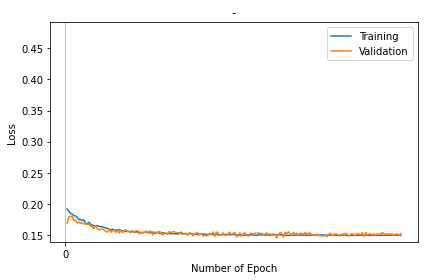

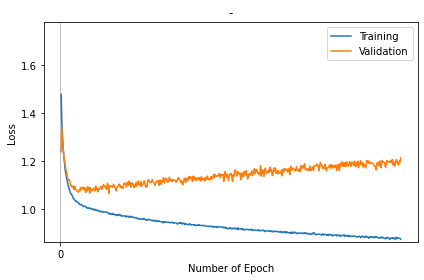

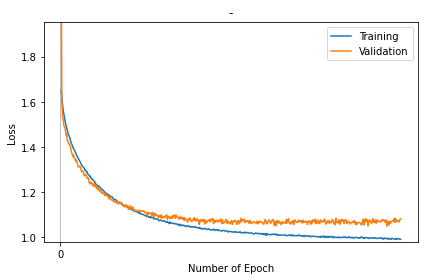

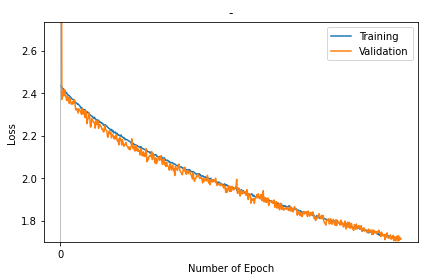

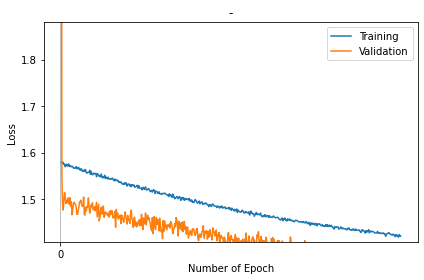

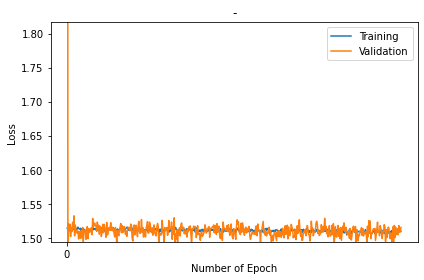

In [11]:

# >> aa-training_weighted_balanced_mae-binned-rif_newdata, Epoch: 200, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-09
Train_Loss=[0.19162969291210175, 0.18782411515712738, 0.18487097322940826, 0.183550164103508, 0.18089453876018524, 0.1806352436542511, 0.1782199740409851, 0.17467378079891205, 0.17468850314617157, 0.17349901795387268, 0.17418202757835388, 0.1685469150543213, 0.1679791957139969, 0.17032918334007263, 0.16718609631061554, 0.16584879159927368, 0.16475655138492584, 0.16456338763237, 0.1649852991104126, 0.16372443735599518, 0.16355057060718536, 0.1630372554063797, 0.16215254366397858, 0.16087615489959717, 0.1604919135570526, 0.15926900506019592, 0.1575661599636078, 0.15955133736133575, 0.15766268968582153, 0.15765069425106049, 0.15831789374351501, 0.15852583944797516, 0.15718406438827515, 0.15665744245052338, 0.15614736080169678, 0.1556554138660431, 0.1558687835931778, 0.15582025051116943, 0.15533308684825897, 0.1557668000459671, 0.15411213040351868, 0.15524069964885712, 0.15439513325691223, 0.15468840301036835, 0.15399713814258575, 0.15322217345237732, 0.1544656753540039, 0.15487442910671234, 0.1537441909313202, 0.15363335609436035, 0.15392915904521942, 0.1544681042432785, 0.15216684341430664, 0.1531926840543747, 0.15407289564609528, 0.15270482003688812, 0.152267187833786, 0.15350888669490814, 0.15238742530345917, 0.15187397599220276, 0.15210078656673431, 0.15234841406345367, 0.1519155651330948, 0.15206536650657654, 0.15155962109565735, 0.15205131471157074, 0.15098270773887634, 0.1528567373752594, 0.15224497020244598, 0.15198878943920135, 0.15129855275154114, 0.1523848921060562, 0.15038862824440002, 0.15226484835147858, 0.15189459919929504, 0.15118175745010376, 0.15090149641036987, 0.15155266225337982, 0.15023669600486755, 0.15094560384750366, 0.15116848051548004, 0.15133607387542725, 0.15147463977336884, 0.15065565705299377, 0.15067000687122345, 0.15092431008815765, 0.15097379684448242, 0.1504897177219391, 0.15167300403118134, 0.1510791927576065, 0.15028169751167297, 0.15004009008407593, 0.1504206508398056, 0.15048736333847046, 0.1508345752954483, 0.15098921954631805, 0.1506190001964569, 0.1503269374370575, 0.15030105412006378, 0.15110693871974945, 0.1504213511943817, 0.14996416866779327, 0.15048164129257202, 0.14897502958774567, 0.14919142425060272, 0.1497526913881302, 0.14965687692165375, 0.14989697933197021, 0.15013685822486877, 0.14969590306282043, 0.15014895796775818, 0.15029039978981018, 0.1493331640958786, 0.14911781251430511, 0.14975665509700775, 0.15045706927776337, 0.15008927881717682, 0.1499643176794052, 0.14972911775112152, 0.14997634291648865, 0.1501486450433731, 0.14948128163814545, 0.1497669219970703, 0.15015952289104462, 0.15041090548038483, 0.15023395419120789, 0.15018993616104126, 0.15071405470371246, 0.14942660927772522, 0.14985743165016174, 0.14961200952529907, 0.1493067890405655, 0.1494005173444748, 0.1496330052614212, 0.1500306874513626, 0.14938530325889587, 0.14962762594223022, 0.15014895796775818, 0.1494630128145218, 0.1496952325105667, 0.1499107927083969, 0.14938555657863617, 0.14996971189975739, 0.1495760679244995, 0.14936570823192596, 0.14966270327568054, 0.14999787509441376, 0.14941832423210144, 0.14946256577968597, 0.14996042847633362, 0.14964807033538818, 0.14978668093681335, 0.15006250143051147, 0.14970386028289795, 0.14967334270477295, 0.1491772085428238, 0.1497226059436798, 0.149539515376091, 0.1495552361011505, 0.14981411397457123, 0.14950056374073029, 0.1494920551776886, 0.14932914078235626, 0.14982657134532928, 0.14979414641857147, 0.1497420370578766, 0.14917851984500885, 0.14925898611545563, 0.14904126524925232, 0.14927096664905548, 0.14954479038715363, 0.1490536630153656, 0.14992181956768036, 0.14939968287944794, 0.14928101003170013, 0.1494949609041214, 0.1495845764875412, 0.1496986448764801, 0.14968138933181763, 0.14962917566299438, 0.1490802764892578, 0.1493929922580719, 0.1493225395679474, 0.1497335582971573, 0.14903734624385834, 0.14920471608638763, 0.14924786984920502, 0.14918647706508636, 0.149436816573143, 0.14935420453548431, 0.1497696191072464, 0.1496218740940094, 0.14920927584171295, 0.14962482452392578, 0.1496519297361374, 0.1498446762561798, 0.14942865073680878, 0.14928868412971497, 0.14972655475139618, 0.1495659500360489]
Test_Loss=[0.1691073626279831, 0.1790550947189331, 0.1800789088010788, 0.17972354590892792, 0.17317216098308563, 0.1738440841436386, 0.16943234205245972, 0.1708354502916336, 0.16841720044612885, 0.1701030284166336, 0.16721957921981812, 0.16809074580669403, 0.16704235970973969, 0.16741393506526947, 0.16385957598686218, 0.1629328578710556, 0.16034896671772003, 0.16500265896320343, 0.15990541875362396, 0.15809433162212372, 0.15940867364406586, 0.15964530408382416, 0.15757130086421967, 0.1559663861989975, 0.15427039563655853, 0.16021107137203217, 0.15428443253040314, 0.15646062791347504, 0.15771834552288055, 0.15408501029014587, 0.15601728856563568, 0.15356551110744476, 0.15827691555023193, 0.15376637876033783, 0.15599700808525085, 0.15852689743041992, 0.1556767076253891, 0.15510480105876923, 0.15357021987438202, 0.1571454554796219, 0.1546923667192459, 0.15658533573150635, 0.1569284349679947, 0.151839479804039, 0.1535792201757431, 0.15404534339904785, 0.15393105149269104, 0.15603438019752502, 0.15346311032772064, 0.15634723007678986, 0.15605230629444122, 0.1501391977071762, 0.15482674539089203, 0.15333886444568634, 0.15458132326602936, 0.1551385372877121, 0.1541539430618286, 0.14958052337169647, 0.1536472886800766, 0.15302647650241852, 0.15171359479427338, 0.15591363608837128, 0.1534128189086914, 0.15544752776622772, 0.15501056611537933, 0.15340165793895721, 0.1540093868970871, 0.1526772528886795, 0.15463902056217194, 0.1525619477033615, 0.152008056640625, 0.1524980515241623, 0.14955075085163116, 0.15370506048202515, 0.15249615907669067, 0.14840184152126312, 0.15182040631771088, 0.15325692296028137, 0.15336869657039642, 0.1504381150007248, 0.15250486135482788, 0.14794448018074036, 0.14938943088054657, 0.14835545420646667, 0.1497221440076828, 0.1527029573917389, 0.15090946853160858, 0.15467651188373566, 0.14780151844024658, 0.1546097695827484, 0.153267502784729, 0.14871881902217865, 0.1507326066493988, 0.15328653156757355, 0.14951364696025848, 0.14938701689243317, 0.15210573375225067, 0.15457002818584442, 0.15019352734088898, 0.15278927981853485, 0.15422643721103668, 0.14662262797355652, 0.14912278950214386, 0.15346819162368774, 0.14793723821640015, 0.15243367850780487, 0.15317492187023163, 0.15006937086582184, 0.14774799346923828, 0.15213222801685333, 0.1526961624622345, 0.15123307704925537, 0.1531224101781845, 0.15217173099517822, 0.15330742299556732, 0.1524176150560379, 0.1525634527206421, 0.1505049765110016, 0.15129464864730835, 0.1533048152923584, 0.15070228278636932, 0.15162420272827148, 0.1500849574804306, 0.1521732658147812, 0.14987005293369293, 0.14518992602825165, 0.15073993802070618, 0.15391908586025238, 0.15260155498981476, 0.14651744067668915, 0.15413299202919006, 0.1520124226808548, 0.15512438118457794, 0.15092989802360535, 0.15095959603786469, 0.15404844284057617, 0.1510215848684311, 0.15272073447704315, 0.14953191578388214, 0.15271559357643127, 0.1523829847574234, 0.15091478824615479, 0.15412208437919617, 0.15100601315498352, 0.15298739075660706, 0.15275166928768158, 0.14977239072322845, 0.15052776038646698, 0.1493908017873764, 0.15140970051288605, 0.14890959858894348, 0.14888422191143036, 0.14834825694561005, 0.1487843245267868, 0.14914631843566895, 0.1472177356481552, 0.15113858878612518, 0.15257932245731354, 0.1486508548259735, 0.150676429271698, 0.15203224122524261, 0.15074895322322845, 0.14993785321712494, 0.14834240078926086, 0.1517828404903412, 0.15026870369911194, 0.15290255844593048, 0.15139158070087433, 0.14841511845588684, 0.15112434327602386, 0.15178020298480988, 0.15018127858638763, 0.1500287503004074, 0.15204870700836182, 0.15175341069698334, 0.15050046145915985, 0.15356867015361786, 0.14741399884223938, 0.15399692952632904, 0.1498115509748459, 0.15192680060863495, 0.1512279063463211, 0.15040163695812225, 0.151539608836174, 0.14952431619167328, 0.15131963789463043, 0.15202701091766357, 0.15196707844734192, 0.1535835862159729, 0.15182776749134064, 0.15093767642974854, 0.15208755433559418, 0.15104074776172638, 0.1516445130109787, 0.15145079791545868, 0.14887486398220062, 0.15141849219799042, 0.15152089297771454, 0.14990313351154327, 0.15218499302864075]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-log-reg-weighted_balanced-rif-new-hml, Epoch: 500, LR: 1e-05, cnnDR: 0,  fnDR: 0, l2decay: 0
Train_Loss=[1.4772251844406128, 1.3565586805343628, 1.2967272996902466, 1.2480295896530151, 1.2146247625350952, 1.1871200799942017, 1.1604068279266357, 1.143045425415039, 1.127341866493225, 1.1149036884307861, 1.1027486324310303, 1.0890394449234009, 1.0800859928131104, 1.0719459056854248, 1.0629987716674805, 1.0615845918655396, 1.0556811094284058, 1.0485882759094238, 1.0419301986694336, 1.039764642715454, 1.0366212129592896, 1.0317245721817017, 1.0327526330947876, 1.0282343626022339, 1.0273072719573975, 1.026713252067566, 1.0207762718200684, 1.0201189517974854, 1.0159952640533447, 1.017505168914795, 1.0169522762298584, 1.0141650438308716, 1.0109118223190308, 1.0084483623504639, 1.010746717453003, 1.009643316268921, 1.0101079940795898, 1.005664348602295, 1.0024298429489136, 1.0039162635803223, 1.003509759902954, 1.001336932182312, 1.0026623010635376, 1.0004198551177979, 1.0018366575241089, 0.9982283115386963, 0.9974358677864075, 0.9994157552719116, 0.9944344758987427, 0.9965881705284119, 0.997757077217102, 0.9933834075927734, 0.9930437207221985, 0.9950249791145325, 0.9930381178855896, 0.990543007850647, 0.9907029867172241, 0.9865797162055969, 0.989754319190979, 0.9881550669670105, 0.9892377257347107, 0.9861742854118347, 0.9849085211753845, 0.9864530563354492, 0.9871572852134705, 0.9862610697746277, 0.9864019751548767, 0.9860946536064148, 0.9837956428527832, 0.9827476143836975, 0.978620707988739, 0.9810286164283752, 0.978509247303009, 0.9763830900192261, 0.979433000087738, 0.9776189923286438, 0.9805379509925842, 0.9760693907737732, 0.9768497943878174, 0.9750550985336304, 0.9744561910629272, 0.97478848695755, 0.9708821177482605, 0.9752968549728394, 0.9745774269104004, 0.9764427542686462, 0.9726846814155579, 0.9750624895095825, 0.9698153138160706, 0.9707815647125244, 0.9694036841392517, 0.970106303691864, 0.970003604888916, 0.9695736169815063, 0.9698216319084167, 0.9656168818473816, 0.9702459573745728, 0.9667184352874756, 0.9678621292114258, 0.9685028791427612, 0.9651027917861938, 0.9639745950698853, 0.9685965180397034, 0.9673588275909424, 0.9646158814430237, 0.9657874703407288, 0.9645878672599792, 0.9621827006340027, 0.9638959169387817, 0.962639331817627, 0.9630526900291443, 0.9599253535270691, 0.9605311751365662, 0.9593872427940369, 0.957118570804596, 0.9593652486801147, 0.956527829170227, 0.9564226269721985, 0.9565886855125427, 0.9567973613739014, 0.9551525115966797, 0.9595019817352295, 0.9599573612213135, 0.9564120769500732, 0.9531513452529907, 0.9532714486122131, 0.9542275071144104, 0.9515584111213684, 0.9560984969139099, 0.9554287791252136, 0.9543852806091309, 0.9539030194282532, 0.9504587650299072, 0.9517616033554077, 0.9515576958656311, 0.9515464901924133, 0.9476783871650696, 0.9511240124702454, 0.950713574886322, 0.9517865777015686, 0.9469645023345947, 0.9465792775154114, 0.949410617351532, 0.9475303292274475, 0.9495086073875427, 0.946803629398346, 0.9462921023368835, 0.94608473777771, 0.9457135796546936, 0.9452106356620789, 0.940838098526001, 0.9457449913024902, 0.9440391659736633, 0.9468254446983337, 0.9448543787002563, 0.9441664218902588, 0.9431314468383789, 0.9439642429351807, 0.9424998164176941, 0.9431595802307129, 0.943778395652771, 0.9407771825790405, 0.9429061412811279, 0.9432440996170044, 0.9431644678115845, 0.9392925500869751, 0.9406140446662903, 0.9413001537322998, 0.9410945773124695, 0.9412831664085388, 0.93831467628479, 0.9357673525810242, 0.938030481338501, 0.9392674565315247, 0.9427416920661926, 0.93928462266922, 0.9415632486343384, 0.9411730170249939, 0.9358983635902405, 0.93793785572052, 0.9406004548072815, 0.9388434886932373, 0.9331309199333191, 0.9362550973892212, 0.9368362426757812, 0.9357706904411316, 0.934391975402832, 0.9328932762145996, 0.9357594847679138, 0.9382176399230957, 0.9336292147636414, 0.9323084950447083, 0.9338706731796265, 0.9337731003761292, 0.933758556842804, 0.9333568215370178, 0.930107831954956, 0.9330461621284485, 0.929266095161438, 0.9308901429176331, 0.9313609004020691, 0.930653989315033, 0.9340365529060364, 0.9306515455245972, 0.9312529563903809, 0.9300864934921265, 0.9305236339569092, 0.9299957156181335, 0.929431140422821, 0.9312405586242676, 0.9297782182693481, 0.928179144859314, 0.9290149211883545, 0.927211344242096, 0.92742919921875, 0.9272992014884949, 0.9266688227653503, 0.9255312085151672, 0.9278570413589478, 0.9259000420570374, 0.9271985292434692, 0.925512433052063, 0.9241529703140259, 0.9270832538604736, 0.9235371947288513, 0.9265043139457703, 0.9240813255310059, 0.9252710342407227, 0.9233989119529724, 0.9224140048027039, 0.9262988567352295, 0.9239199757575989, 0.9236003756523132, 0.9236865639686584, 0.9239675402641296, 0.9243658781051636, 0.9232802391052246, 0.9235061407089233, 0.9236695170402527, 0.9197524785995483, 0.9207553863525391, 0.9235971570014954, 0.9183303713798523, 0.9205511808395386, 0.9201604723930359, 0.9163862466812134, 0.9177206158638, 0.9169682860374451, 0.9205933213233948, 0.9193515777587891, 0.9191550016403198, 0.9150521755218506, 0.9187706112861633, 0.9185711741447449, 0.9173953533172607, 0.9199830293655396, 0.9158254861831665, 0.9155806303024292, 0.9179531335830688, 0.9200258255004883, 0.9124978184700012, 0.9177427887916565, 0.9170865416526794, 0.9165604710578918, 0.9161792993545532, 0.9170142412185669, 0.9126551151275635, 0.9155281782150269, 0.9153297543525696, 0.9109793305397034, 0.9129983186721802, 0.9130154848098755, 0.9148336052894592, 0.9130565524101257, 0.9139736890792847, 0.9133075475692749, 0.9116759896278381, 0.9126555919647217, 0.9116553068161011, 0.9130263924598694, 0.9150813817977905, 0.909177303314209, 0.9096947312355042, 0.9116272330284119, 0.911080002784729, 0.9115947484970093, 0.9106576442718506, 0.9092132449150085, 0.909837543964386, 0.9097914695739746, 0.9128061532974243, 0.9073274731636047, 0.9096300601959229, 0.9098711013793945, 0.908053994178772, 0.9098203778266907, 0.9093629121780396, 0.911052405834198, 0.9074092507362366, 0.9085059762001038, 0.9050845503807068, 0.9058286547660828, 0.9078022837638855, 0.9090936779975891, 0.9086425304412842, 0.9064093828201294, 0.9055241942405701, 0.9076336622238159, 0.9090774059295654, 0.905392050743103, 0.9040658473968506, 0.9066118597984314, 0.903731644153595, 0.9050396680831909, 0.9073480367660522, 0.904443085193634, 0.905141294002533, 0.9052664041519165, 0.9051786065101624, 0.905412495136261, 0.9026782512664795, 0.9026411175727844, 0.9035218954086304, 0.9057191014289856, 0.900484561920166, 0.9031893610954285, 0.9003794193267822, 0.9018275141716003, 0.9050734043121338, 0.9005491137504578, 0.9031301736831665, 0.8990605473518372, 0.9038679599761963, 0.9007210731506348, 0.8998871445655823, 0.900175929069519, 0.8986849188804626, 0.9023750424385071, 0.8973041772842407, 0.9017486572265625, 0.8975231647491455, 0.9023873209953308, 0.9022926688194275, 0.8987970948219299, 0.9021275639533997, 0.901512622833252, 0.8968847393989563, 0.8959733247756958, 0.8972641825675964, 0.8997182250022888, 0.8986893892288208, 0.8976230621337891, 0.8974041938781738, 0.8987786769866943, 0.8986379504203796, 0.8992528319358826, 0.8963442444801331, 0.8977181315422058, 0.8969354629516602, 0.9004088044166565, 0.8983331918716431, 0.8952251076698303, 0.8977415561676025, 0.895744800567627, 0.8955206274986267, 0.8969619274139404, 0.893660843372345, 0.8927805423736572, 0.8939154148101807, 0.8975111246109009, 0.8951237797737122, 0.9005351662635803, 0.8983631134033203, 0.8951921463012695, 0.8907283544540405, 0.8932964205741882, 0.8923823237419128, 0.8936067819595337, 0.8936054706573486, 0.893234372138977, 0.8939778208732605, 0.8929807543754578, 0.8915552496910095, 0.8898062109947205, 0.8943216800689697, 0.8951647281646729, 0.8905198574066162, 0.8924040794372559, 0.8926020264625549, 0.8932103514671326, 0.8896315097808838, 0.8924742341041565, 0.8897362947463989, 0.8887493014335632, 0.8935228586196899, 0.8924583792686462, 0.8918659687042236, 0.8889981508255005, 0.8906428217887878, 0.8869395852088928, 0.8891176581382751, 0.8897954821586609, 0.889168918132782, 0.8899565935134888, 0.8912980556488037, 0.886525571346283, 0.890157163143158, 0.889236569404602, 0.8904612064361572, 0.8873435258865356, 0.885298490524292, 0.889129102230072, 0.8877019286155701, 0.8888126015663147, 0.8889546394348145, 0.8878155946731567, 0.8914622664451599, 0.884786069393158, 0.8873651027679443, 0.8893495798110962, 0.887263834476471, 0.8866670727729797, 0.8843153715133667, 0.8895546793937683, 0.8857762217521667, 0.8865332007408142, 0.8836243748664856, 0.8843902945518494, 0.886229395866394, 0.8843298554420471, 0.8860896229743958, 0.8860236406326294, 0.8860673308372498, 0.8847408294677734, 0.8833184242248535, 0.8808889985084534, 0.8833620548248291, 0.8847336173057556, 0.8851467967033386, 0.8851386308670044, 0.8801171779632568, 0.8823597431182861, 0.8824349641799927, 0.8863602876663208, 0.8842539191246033, 0.8818829655647278, 0.8824803233146667, 0.8799856305122375, 0.8860080242156982, 0.8844831585884094, 0.8812315464019775, 0.8822092413902283, 0.877004861831665, 0.880471408367157, 0.8831514716148376, 0.8799506425857544, 0.8813816905021667, 0.8840972185134888, 0.8810988068580627, 0.8796389698982239, 0.8808772563934326, 0.8792079091072083, 0.8844006657600403, 0.8840940594673157, 0.8802046179771423, 0.8805468082427979, 0.8785800933837891, 0.8794479966163635, 0.8776187896728516, 0.8810772895812988, 0.8779163360595703, 0.8810020089149475, 0.8824599981307983, 0.8785181045532227, 0.8772267699241638, 0.8774478435516357, 0.8751933574676514, 0.8780980110168457, 0.875426709651947, 0.8802602887153625, 0.8799387812614441, 0.8787528276443481, 0.8770077228546143, 0.8721745014190674, 0.8780174255371094, 0.8775783777236938, 0.8767122030258179, 0.8794125318527222, 0.8764597773551941, 0.8781687617301941, 0.872905433177948, 0.8743621706962585, 0.8811127543449402, 0.8747898936271667, 0.8761455416679382, 0.8793672323226929, 0.8777459263801575, 0.8770920634269714, 0.8762611746788025, 0.8729315996170044]
Test_Loss=[1.2384456396102905, 1.3354467153549194, 1.28999924659729, 1.2506941556930542, 1.2159336805343628, 1.2009233236312866, 1.1823810338974, 1.1629676818847656, 1.1539992094039917, 1.133142113685608, 1.1242116689682007, 1.1182078123092651, 1.1213512420654297, 1.110122799873352, 1.096329689025879, 1.0974613428115845, 1.091363787651062, 1.0893964767456055, 1.0951459407806396, 1.0795763731002808, 1.0927871465682983, 1.0809179544448853, 1.0802924633026123, 1.0747671127319336, 1.0724173784255981, 1.0690504312515259, 1.0734039545059204, 1.0815439224243164, 1.0739933252334595, 1.0888036489486694, 1.087162971496582, 1.088990569114685, 1.0818641185760498, 1.080182433128357, 1.0899184942245483, 1.0777809619903564, 1.0680471658706665, 1.0849847793579102, 1.0751899480819702, 1.0920671224594116, 1.0801023244857788, 1.0875052213668823, 1.0648454427719116, 1.0886541604995728, 1.0741411447525024, 1.0787229537963867, 1.0756080150604248, 1.0805339813232422, 1.0870431661605835, 1.0805110931396484, 1.0738154649734497, 1.0948899984359741, 1.0806089639663696, 1.0825653076171875, 1.0702050924301147, 1.083350419998169, 1.081049919128418, 1.0853806734085083, 1.0922095775604248, 1.093186855316162, 1.081066608428955, 1.0894206762313843, 1.101317048072815, 1.0970491170883179, 1.0930589437484741, 1.0936918258666992, 1.0825190544128418, 1.0811526775360107, 1.1057578325271606, 1.1006287336349487, 1.0643666982650757, 1.0900559425354004, 1.0962311029434204, 1.0947351455688477, 1.0938037633895874, 1.089316725730896, 1.090783953666687, 1.1022690534591675, 1.093353033065796, 1.0880602598190308, 1.0872225761413574, 1.0737470388412476, 1.0896378755569458, 1.0922021865844727, 1.093467116355896, 1.1032766103744507, 1.0958579778671265, 1.0980638265609741, 1.0869073867797852, 1.0918221473693848, 1.092012882232666, 1.0848238468170166, 1.1030124425888062, 1.1076185703277588, 1.1016720533370972, 1.1045923233032227, 1.0901292562484741, 1.109256625175476, 1.1012080907821655, 1.0971271991729736, 1.1162196397781372, 1.1027745008468628, 1.1083580255508423, 1.0890575647354126, 1.1077088117599487, 1.104973316192627, 1.1037925481796265, 1.0884184837341309, 1.0986979007720947, 1.093549370765686, 1.108170509338379, 1.0940641164779663, 1.1072558164596558, 1.1147342920303345, 1.1027034521102905, 1.0982216596603394, 1.0979092121124268, 1.1138620376586914, 1.092109203338623, 1.1030023097991943, 1.1007589101791382, 1.1033095121383667, 1.1166192293167114, 1.1059699058532715, 1.0906856060028076, 1.0944395065307617, 1.090329647064209, 1.110984444618225, 1.1223926544189453, 1.1157506704330444, 1.1116418838500977, 1.1104100942611694, 1.10818612575531, 1.1158232688903809, 1.122003197669983, 1.1105129718780518, 1.1097596883773804, 1.1025655269622803, 1.097572684288025, 1.1101595163345337, 1.1154266595840454, 1.115843653678894, 1.1091229915618896, 1.117537498474121, 1.0977387428283691, 1.1176611185073853, 1.1194064617156982, 1.101625680923462, 1.115082025527954, 1.1120136976242065, 1.1296180486679077, 1.1181591749191284, 1.1064696311950684, 1.1257325410842896, 1.1273787021636963, 1.1256290674209595, 1.1108269691467285, 1.1155891418457031, 1.112410306930542, 1.1316519975662231, 1.1192042827606201, 1.117066740989685, 1.1224597692489624, 1.1136494874954224, 1.1216137409210205, 1.119598627090454, 1.1199336051940918, 1.1188013553619385, 1.1169743537902832, 1.1101350784301758, 1.115195631980896, 1.121746301651001, 1.1299160718917847, 1.126625657081604, 1.120550513267517, 1.118942379951477, 1.108045220375061, 1.1162278652191162, 1.1113052368164062, 1.0998696088790894, 1.1145809888839722, 1.1279255151748657, 1.1253951787948608, 1.1104499101638794, 1.1223710775375366, 1.1284335851669312, 1.1190489530563354, 1.1193240880966187, 1.1343975067138672, 1.1242979764938354, 1.133325219154358, 1.1288714408874512, 1.1280308961868286, 1.1137365102767944, 1.1360142230987549, 1.1198569536209106, 1.1325489282608032, 1.130434274673462, 1.1182955503463745, 1.1223219633102417, 1.128666877746582, 1.1273003816604614, 1.120648741722107, 1.1309112310409546, 1.1257431507110596, 1.1150941848754883, 1.13400399684906, 1.1272598505020142, 1.1204756498336792, 1.1271283626556396, 1.1258535385131836, 1.1163185834884644, 1.1307756900787354, 1.1216888427734375, 1.12694251537323, 1.1362985372543335, 1.1206969022750854, 1.1224451065063477, 1.1233510971069336, 1.1207659244537354, 1.1348259449005127, 1.1329231262207031, 1.1250956058502197, 1.1278818845748901, 1.1429752111434937, 1.1299675703048706, 1.1432085037231445, 1.134242057800293, 1.1359275579452515, 1.137825846672058, 1.1356464624404907, 1.1373624801635742, 1.1465598344802856, 1.1453570127487183, 1.1289678812026978, 1.1436479091644287, 1.141603708267212, 1.1414421796798706, 1.1429065465927124, 1.1148515939712524, 1.1417220830917358, 1.1549036502838135, 1.1436073780059814, 1.1303218603134155, 1.1446466445922852, 1.1347578763961792, 1.1171209812164307, 1.1380919218063354, 1.1444991827011108, 1.141535997390747, 1.1470123529434204, 1.1267627477645874, 1.1130768060684204, 1.1424307823181152, 1.135575532913208, 1.156832218170166, 1.1622984409332275, 1.1565378904342651, 1.1365145444869995, 1.1486313343048096, 1.1539198160171509, 1.145668625831604, 1.144920825958252, 1.1483415365219116, 1.1208161115646362, 1.1409008502960205, 1.14983332157135, 1.1340762376785278, 1.1315609216690063, 1.1553095579147339, 1.151269793510437, 1.1401923894882202, 1.1586960554122925, 1.1432580947875977, 1.1238616704940796, 1.1322641372680664, 1.1450799703598022, 1.138623595237732, 1.147084355354309, 1.1419501304626465, 1.1584430932998657, 1.139506220817566, 1.1473466157913208, 1.1513060331344604, 1.1669849157333374, 1.1453675031661987, 1.1535358428955078, 1.164528727531433, 1.1592001914978027, 1.1467424631118774, 1.1500996351242065, 1.1418427228927612, 1.14495849609375, 1.1792105436325073, 1.1360832452774048, 1.1630761623382568, 1.146145224571228, 1.159234881401062, 1.1336644887924194, 1.1515969038009644, 1.169647216796875, 1.1572318077087402, 1.1477165222167969, 1.152494192123413, 1.1533631086349487, 1.1628750562667847, 1.1519187688827515, 1.1734205484390259, 1.1561473608016968, 1.1637139320373535, 1.1410655975341797, 1.1378870010375977, 1.1614574193954468, 1.1702711582183838, 1.1561528444290161, 1.169786810874939, 1.1476202011108398, 1.1547558307647705, 1.1449941396713257, 1.15973699092865, 1.1502794027328491, 1.1504284143447876, 1.1466997861862183, 1.1526455879211426, 1.1624382734298706, 1.1372822523117065, 1.1619318723678589, 1.1659682989120483, 1.154176115989685, 1.1686369180679321, 1.16604745388031, 1.1635150909423828, 1.1610310077667236, 1.15294349193573, 1.1688423156738281, 1.1624436378479004, 1.142356276512146, 1.1660088300704956, 1.1768358945846558, 1.160643458366394, 1.1672769784927368, 1.1688891649246216, 1.1652582883834839, 1.1606781482696533, 1.1576108932495117, 1.1658273935317993, 1.1754467487335205, 1.160098910331726, 1.1631596088409424, 1.1566942930221558, 1.1653070449829102, 1.1544042825698853, 1.1762707233428955, 1.1799815893173218, 1.1677101850509644, 1.1739345788955688, 1.1809173822402954, 1.1712993383407593, 1.1875779628753662, 1.1617701053619385, 1.166677474975586, 1.16391122341156, 1.1641991138458252, 1.1587222814559937, 1.1690164804458618, 1.1601979732513428, 1.177031397819519, 1.159134864807129, 1.161279559135437, 1.1671937704086304, 1.1742002964019775, 1.1600563526153564, 1.1804819107055664, 1.1790879964828491, 1.1799625158309937, 1.1801668405532837, 1.186379075050354, 1.176272988319397, 1.1805773973464966, 1.1589765548706055, 1.1744561195373535, 1.1934088468551636, 1.1811753511428833, 1.1834607124328613, 1.169885516166687, 1.1752194166183472, 1.1664226055145264, 1.1712440252304077, 1.1855043172836304, 1.1680959463119507, 1.1578731536865234, 1.1706637144088745, 1.170656681060791, 1.1743099689483643, 1.1805120706558228, 1.1824818849563599, 1.1698474884033203, 1.1845921277999878, 1.1814125776290894, 1.1701968908309937, 1.1804195642471313, 1.180741548538208, 1.1715853214263916, 1.1797441244125366, 1.1823352575302124, 1.1592437028884888, 1.1668428182601929, 1.1854251623153687, 1.185807704925537, 1.1602190732955933, 1.1847999095916748, 1.1787422895431519, 1.1955493688583374, 1.1802339553833008, 1.178745150566101, 1.193375587463379, 1.176887035369873, 1.1904244422912598, 1.1935670375823975, 1.175540566444397, 1.1951032876968384, 1.1796773672103882, 1.1790155172348022, 1.1833271980285645, 1.1960922479629517, 1.1842646598815918, 1.176690697669983, 1.195337176322937, 1.191362977027893, 1.190216302871704, 1.1800140142440796, 1.1982519626617432, 1.1867034435272217, 1.1742790937423706, 1.1935971975326538, 1.180709719657898, 1.198453426361084, 1.1705793142318726, 1.1866614818572998, 1.1839054822921753, 1.2002900838851929, 1.184736728668213, 1.1855456829071045, 1.1933287382125854, 1.1737983226776123, 1.1863250732421875, 1.1795352697372437, 1.1744844913482666, 1.1701160669326782, 1.200596809387207, 1.196258783340454, 1.2008161544799805, 1.1917890310287476, 1.1888562440872192, 1.190168857574463, 1.19383704662323, 1.190983772277832, 1.1905723810195923, 1.189181923866272, 1.1839793920516968, 1.1806882619857788, 1.179027795791626, 1.17227303981781, 1.162115454673767, 1.190672516822815, 1.1852351427078247, 1.1934419870376587, 1.1795917749404907, 1.1985148191452026, 1.198532223701477, 1.1711963415145874, 1.191602349281311, 1.2015739679336548, 1.1951847076416016, 1.1953706741333008, 1.1916017532348633, 1.180368185043335, 1.1719425916671753, 1.1902929544448853, 1.2013834714889526, 1.1948838233947754, 1.1970198154449463, 1.1957991123199463, 1.1969636678695679, 1.1931618452072144, 1.201937198638916, 1.1915374994277954, 1.205007553100586, 1.1827608346939087, 1.1946003437042236, 1.1788907051086426, 1.1827116012573242, 1.1985291242599487, 1.2050769329071045, 1.1951322555541992, 1.1861121654510498, 1.1819860935211182, 1.1986675262451172, 1.1937416791915894, 1.2115709781646729]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-log-reg-weighted_balanced-rif-new-hml, Epoch: 500, LR: 1e-06, cnnDR: 0,  fnDR: 0, l2decay: 0
Train_Loss=[1.6511863470077515, 1.6159820556640625, 1.5878657102584839, 1.561474323272705, 1.544718623161316, 1.5300724506378174, 1.5107935667037964, 1.4991419315338135, 1.4834182262420654, 1.4751291275024414, 1.460411548614502, 1.4519506692886353, 1.4459551572799683, 1.4364855289459229, 1.4257731437683105, 1.4161759614944458, 1.4103620052337646, 1.4018210172653198, 1.393438458442688, 1.390220284461975, 1.3818933963775635, 1.3750096559524536, 1.3686487674713135, 1.3615562915802002, 1.3568836450576782, 1.349523663520813, 1.3439488410949707, 1.339514136314392, 1.333200454711914, 1.3271050453186035, 1.3214154243469238, 1.3152333498001099, 1.3135106563568115, 1.309221625328064, 1.3050869703292847, 1.296972632408142, 1.2986921072006226, 1.289597988128662, 1.2907450199127197, 1.2807199954986572, 1.2776213884353638, 1.2765110731124878, 1.269895076751709, 1.2701992988586426, 1.2613413333892822, 1.257451057434082, 1.258298635482788, 1.2531932592391968, 1.2503762245178223, 1.2479296922683716, 1.2418094873428345, 1.2370615005493164, 1.2307873964309692, 1.232031226158142, 1.2277284860610962, 1.223530650138855, 1.2276403903961182, 1.2218455076217651, 1.218214750289917, 1.2131667137145996, 1.212161898612976, 1.2113981246948242, 1.2075303792953491, 1.2047675848007202, 1.2013410329818726, 1.1964257955551147, 1.1959798336029053, 1.1941388845443726, 1.1918765306472778, 1.187371850013733, 1.1886292695999146, 1.183070421218872, 1.1834734678268433, 1.179225206375122, 1.180125117301941, 1.1791832447052002, 1.174282431602478, 1.1682850122451782, 1.166582465171814, 1.1684870719909668, 1.1674234867095947, 1.1644564867019653, 1.1613715887069702, 1.1576071977615356, 1.1539716720581055, 1.1535017490386963, 1.1491124629974365, 1.1507774591445923, 1.1503546237945557, 1.1487233638763428, 1.1426047086715698, 1.1436573266983032, 1.139140009880066, 1.1388636827468872, 1.1415107250213623, 1.1374149322509766, 1.1362687349319458, 1.1331521272659302, 1.1322441101074219, 1.1286002397537231, 1.1312148571014404, 1.1248116493225098, 1.126908540725708, 1.125093936920166, 1.122137427330017, 1.1203160285949707, 1.1199644804000854, 1.1169652938842773, 1.1173731088638306, 1.115180492401123, 1.1138352155685425, 1.1162109375, 1.1114373207092285, 1.1121444702148438, 1.1077126264572144, 1.1104182004928589, 1.1070091724395752, 1.1031405925750732, 1.103392243385315, 1.1017903089523315, 1.1027036905288696, 1.1006665229797363, 1.0986573696136475, 1.096442461013794, 1.095687985420227, 1.0987777709960938, 1.0919849872589111, 1.0935903787612915, 1.0918880701065063, 1.088698387145996, 1.0902141332626343, 1.0874770879745483, 1.0916146039962769, 1.0870524644851685, 1.0878766775131226, 1.0890111923217773, 1.0815366506576538, 1.0854454040527344, 1.082455039024353, 1.0826690196990967, 1.0808210372924805, 1.0812864303588867, 1.0809298753738403, 1.0779104232788086, 1.0731337070465088, 1.0756672620773315, 1.0769604444503784, 1.076843500137329, 1.0728027820587158, 1.071655035018921, 1.0734302997589111, 1.0725970268249512, 1.07371187210083, 1.0698130130767822, 1.068015694618225, 1.066241979598999, 1.070796012878418, 1.0667542219161987, 1.0648199319839478, 1.0610456466674805, 1.0685350894927979, 1.0635660886764526, 1.063637614250183, 1.061681866645813, 1.062811255455017, 1.0628771781921387, 1.060791015625, 1.05955970287323, 1.061771035194397, 1.0604145526885986, 1.0583281517028809, 1.0581892728805542, 1.058665156364441, 1.0530192852020264, 1.057259440422058, 1.0562634468078613, 1.051242470741272, 1.0542104244232178, 1.0545811653137207, 1.0550247430801392, 1.0518555641174316, 1.0529154539108276, 1.0498918294906616, 1.0498672723770142, 1.047568917274475, 1.0494638681411743, 1.0521659851074219, 1.0501195192337036, 1.0490968227386475, 1.0466314554214478, 1.049281358718872, 1.0458214282989502, 1.0458440780639648, 1.0479172468185425, 1.0469701290130615, 1.045520544052124, 1.0481517314910889, 1.047217845916748, 1.0432395935058594, 1.0442700386047363, 1.0435312986373901, 1.0421947240829468, 1.043452262878418, 1.041490912437439, 1.0440666675567627, 1.0386677980422974, 1.0386251211166382, 1.0376561880111694, 1.0385311841964722, 1.0379135608673096, 1.0401978492736816, 1.037977695465088, 1.039291501045227, 1.0385187864303589, 1.035195231437683, 1.0350918769836426, 1.0359375476837158, 1.0384604930877686, 1.0347528457641602, 1.0348575115203857, 1.0324569940567017, 1.0332952737808228, 1.032694935798645, 1.0356988906860352, 1.03434419631958, 1.0364177227020264, 1.031012773513794, 1.0324132442474365, 1.0335185527801514, 1.0331934690475464, 1.034417748451233, 1.0299876928329468, 1.0316108465194702, 1.0317708253860474, 1.030182123184204, 1.029222011566162, 1.0281606912612915, 1.029871940612793, 1.0314069986343384, 1.0309548377990723, 1.0292598009109497, 1.0278981924057007, 1.029289960861206, 1.0294482707977295, 1.0278881788253784, 1.0241583585739136, 1.0252798795700073, 1.0273551940917969, 1.0258640050888062, 1.0269272327423096, 1.0247280597686768, 1.0252212285995483, 1.0250598192214966, 1.0221517086029053, 1.0236313343048096, 1.0245031118392944, 1.0266698598861694, 1.0247113704681396, 1.02225923538208, 1.022321343421936, 1.0234931707382202, 1.0230098962783813, 1.0226669311523438, 1.025524616241455, 1.0218826532363892, 1.0199615955352783, 1.0213755369186401, 1.0197259187698364, 1.0210763216018677, 1.02289617061615, 1.019404649734497, 1.0232194662094116, 1.022235631942749, 1.020408272743225, 1.021541714668274, 1.0218989849090576, 1.019705891609192, 1.0189138650894165, 1.0193630456924438, 1.0207306146621704, 1.0191165208816528, 1.0188827514648438, 1.0167523622512817, 1.015213131904602, 1.0159437656402588, 1.0170648097991943, 1.0200121402740479, 1.0181236267089844, 1.0169191360473633, 1.0175037384033203, 1.0182853937149048, 1.0174156427383423, 1.0145682096481323, 1.0160057544708252, 1.017547607421875, 1.0146623849868774, 1.017513394355774, 1.012463927268982, 1.016182780265808, 1.0135520696640015, 1.0170974731445312, 1.008813738822937, 1.0174813270568848, 1.0140172243118286, 1.0138208866119385, 1.0117344856262207, 1.013300895690918, 1.0134961605072021, 1.012262225151062, 1.0116527080535889, 1.0151793956756592, 1.0129486322402954, 1.0127347707748413, 1.015415906906128, 1.012610673904419, 1.0127780437469482, 1.0153628587722778, 1.0100888013839722, 1.0124433040618896, 1.0098813772201538, 1.0112528800964355, 1.0114738941192627, 1.0092185735702515, 1.0099540948867798, 1.0101583003997803, 1.0110281705856323, 1.0116007328033447, 1.0105069875717163, 1.0110210180282593, 1.0087605714797974, 1.0096485614776611, 1.0098750591278076, 1.0076693296432495, 1.0077069997787476, 1.009149432182312, 1.0115936994552612, 1.0108197927474976, 1.0085508823394775, 1.0068718194961548, 1.0124704837799072, 1.0095264911651611, 1.0068458318710327, 1.009865641593933, 1.0074518918991089, 1.0078024864196777, 1.008215069770813, 1.0080018043518066, 1.007684350013733, 1.0097334384918213, 1.0071845054626465, 1.0108108520507812, 1.0075063705444336, 1.0081977844238281, 1.0063613653182983, 1.008190631866455, 1.0058560371398926, 1.0055835247039795, 1.0082989931106567, 1.0043554306030273, 1.0039490461349487, 1.0076818466186523, 1.0080692768096924, 1.006562352180481, 1.0054960250854492, 1.0048543214797974, 1.0073431730270386, 1.0032775402069092, 1.002614140510559, 1.005654215812683, 1.0052525997161865, 1.0051069259643555, 1.0057446956634521, 1.0050079822540283, 1.0045830011367798, 1.0031780004501343, 1.0032795667648315, 1.0031566619873047, 1.00273597240448, 1.0017536878585815, 1.0040667057037354, 1.0031741857528687, 1.0003080368041992, 1.0056939125061035, 1.0013383626937866, 1.0032867193222046, 1.0047351121902466, 1.0057464838027954, 0.9993212819099426, 1.0054434537887573, 1.003674030303955, 1.0004794597625732, 1.0020400285720825, 1.004560112953186, 1.0001072883605957, 1.0045998096466064, 1.00212824344635, 1.0034047365188599, 1.0037763118743896, 1.0007448196411133, 1.0048134326934814, 1.00218665599823, 0.9981626868247986, 1.0010346174240112, 1.0018023252487183, 1.0006906986236572, 1.000392198562622, 0.998622477054596, 1.0019234418869019, 1.0014091730117798, 0.9994692206382751, 0.9985072016716003, 1.0008536577224731, 0.999561607837677, 1.0007902383804321, 1.0002858638763428, 1.0017555952072144, 0.9996386170387268, 1.0011513233184814, 1.0025273561477661, 0.9995241761207581, 0.9984212517738342, 0.9996626377105713, 1.0009465217590332, 1.00344717502594, 0.9984732866287231, 0.9986919164657593, 1.0001243352890015, 0.9991198182106018, 1.000630259513855, 0.9971022605895996, 0.9979268312454224, 0.9997205138206482, 0.9989458918571472, 0.9995737075805664, 1.0004655122756958, 1.0001083612442017, 0.9981143474578857, 0.9989941716194153, 0.9965832829475403, 0.9990847706794739, 0.9976441264152527, 1.0028414726257324, 1.0008869171142578, 0.9999702572822571, 0.9956744313240051, 0.9952739477157593, 1.000030755996704, 0.9973325133323669, 0.9983696937561035, 0.9982888698577881, 0.9995750188827515, 0.9980728030204773, 0.9952215552330017, 0.9972370862960815, 0.9969698190689087, 0.9971108436584473, 0.9985747337341309, 0.9968621134757996, 0.9991386532783508, 0.9978001713752747, 0.9963259100914001, 0.9989675879478455, 0.9977108240127563, 0.9956486225128174, 0.995211124420166, 0.9965521097183228, 0.9969977140426636, 0.9969247579574585, 0.9960609078407288, 0.9970715641975403, 0.9980714917182922, 0.9959852695465088, 0.9972468018531799, 0.9921804666519165, 0.9957582950592041, 0.9946420788764954, 0.9975182414054871, 0.9953325390815735, 0.9962847828865051, 0.9944725632667542, 0.9924007058143616, 0.9964422583580017, 0.9936475157737732, 0.9935041666030884, 0.9922627806663513, 0.9912278056144714, 0.9967454671859741, 0.9953787326812744, 0.9950320720672607, 0.9919316172599792, 0.9927452802658081, 0.9932113289833069, 0.995827317237854, 0.9906924366950989, 0.9952411651611328, 0.9946410655975342, 0.9949986338615417, 0.9936851859092712, 0.9909510016441345, 0.9922135472297668]
Test_Loss=[2.277310609817505, 1.5978584289550781, 1.5331788063049316, 1.5200589895248413, 1.4937647581100464, 1.4894249439239502, 1.481341004371643, 1.4527788162231445, 1.4575996398925781, 1.4276176691055298, 1.4257699251174927, 1.413351058959961, 1.413649082183838, 1.4061661958694458, 1.3953875303268433, 1.3783037662506104, 1.3717623949050903, 1.3573342561721802, 1.3654645681381226, 1.3516507148742676, 1.3495173454284668, 1.33767831325531, 1.3435341119766235, 1.3353118896484375, 1.3243682384490967, 1.3117061853408813, 1.3127702474594116, 1.315783143043518, 1.3134195804595947, 1.3024815320968628, 1.2900675535202026, 1.2949868440628052, 1.2905405759811401, 1.2851442098617554, 1.2727155685424805, 1.2782747745513916, 1.277260661125183, 1.2722915410995483, 1.2625014781951904, 1.2623958587646484, 1.2630306482315063, 1.2451225519180298, 1.2365916967391968, 1.2395514249801636, 1.245740532875061, 1.2414257526397705, 1.2293676137924194, 1.229252815246582, 1.2394546270370483, 1.2266954183578491, 1.2249945402145386, 1.2319579124450684, 1.2155077457427979, 1.2208821773529053, 1.2200443744659424, 1.2083714008331299, 1.2209101915359497, 1.2041388750076294, 1.2017183303833008, 1.206140398979187, 1.1944934129714966, 1.1995670795440674, 1.1940510272979736, 1.1925196647644043, 1.185304880142212, 1.1936814785003662, 1.1862775087356567, 1.1876050233840942, 1.1821447610855103, 1.1829553842544556, 1.1703354120254517, 1.18040931224823, 1.1752184629440308, 1.1683320999145508, 1.1670494079589844, 1.1629152297973633, 1.1616159677505493, 1.1632760763168335, 1.1560076475143433, 1.1595498323440552, 1.159028172492981, 1.153693675994873, 1.161229133605957, 1.1475751399993896, 1.158613920211792, 1.156794786453247, 1.1528761386871338, 1.149994969367981, 1.1565532684326172, 1.153077483177185, 1.1442407369613647, 1.1444017887115479, 1.1360541582107544, 1.1356743574142456, 1.1408790349960327, 1.144799828529358, 1.134368896484375, 1.1360975503921509, 1.140425682067871, 1.124656319618225, 1.1351131200790405, 1.131712794303894, 1.1396799087524414, 1.1248610019683838, 1.129425048828125, 1.1284009218215942, 1.1343973875045776, 1.119655966758728, 1.1226427555084229, 1.1174448728561401, 1.1171457767486572, 1.116341471672058, 1.1179685592651367, 1.115679383277893, 1.1202754974365234, 1.1161072254180908, 1.114068627357483, 1.11758553981781, 1.1172900199890137, 1.1150213479995728, 1.115260124206543, 1.1179941892623901, 1.1154736280441284, 1.1089973449707031, 1.1092709302902222, 1.1111516952514648, 1.1078327894210815, 1.0947859287261963, 1.111031413078308, 1.105566143989563, 1.1078394651412964, 1.1058131456375122, 1.106927514076233, 1.0972574949264526, 1.110899806022644, 1.1040761470794678, 1.0897085666656494, 1.1050924062728882, 1.1079223155975342, 1.0985320806503296, 1.1001240015029907, 1.095255970954895, 1.0979992151260376, 1.0882304906845093, 1.097993016242981, 1.095133662223816, 1.0866998434066772, 1.1000497341156006, 1.0954641103744507, 1.0848816633224487, 1.0900734663009644, 1.0917389392852783, 1.0888561010360718, 1.0954588651657104, 1.093276858329773, 1.0998448133468628, 1.0803464651107788, 1.0927635431289673, 1.0923508405685425, 1.0891900062561035, 1.0827997922897339, 1.0901745557785034, 1.0903161764144897, 1.0838011503219604, 1.0973992347717285, 1.0902588367462158, 1.0926129817962646, 1.099745512008667, 1.0847382545471191, 1.098680853843689, 1.0921728610992432, 1.0896129608154297, 1.0852776765823364, 1.0811493396759033, 1.0918077230453491, 1.0888440608978271, 1.0826163291931152, 1.0902085304260254, 1.0804780721664429, 1.082654356956482, 1.0879827737808228, 1.074213981628418, 1.08669114112854, 1.079508662223816, 1.0796056985855103, 1.0766355991363525, 1.0672144889831543, 1.0834203958511353, 1.079912781715393, 1.086213231086731, 1.0808180570602417, 1.0717114210128784, 1.069635272026062, 1.0763720273971558, 1.0802958011627197, 1.0794641971588135, 1.0873183012008667, 1.0729366540908813, 1.080221176147461, 1.0738909244537354, 1.0825998783111572, 1.0737332105636597, 1.0752677917480469, 1.0568444728851318, 1.078484058380127, 1.0702104568481445, 1.0780960321426392, 1.0783356428146362, 1.0710365772247314, 1.0766258239746094, 1.079636812210083, 1.0592479705810547, 1.0762277841567993, 1.0704854726791382, 1.064750075340271, 1.0721315145492554, 1.0751478672027588, 1.0747629404067993, 1.079401969909668, 1.0679718255996704, 1.080470323562622, 1.0808066129684448, 1.075431227684021, 1.083423376083374, 1.061078429222107, 1.0756453275680542, 1.0668545961380005, 1.0704939365386963, 1.0764763355255127, 1.0709999799728394, 1.068986177444458, 1.074876070022583, 1.0689153671264648, 1.0722626447677612, 1.0817698240280151, 1.0742251873016357, 1.0612249374389648, 1.078612208366394, 1.0648053884506226, 1.0625427961349487, 1.0670040845870972, 1.071370005607605, 1.078950047492981, 1.0775917768478394, 1.0620043277740479, 1.0723495483398438, 1.0657280683517456, 1.0658118724822998, 1.0595223903656006, 1.0671359300613403, 1.0744904279708862, 1.0641765594482422, 1.0573872327804565, 1.073656678199768, 1.0706942081451416, 1.072487473487854, 1.0760481357574463, 1.067084550857544, 1.0575661659240723, 1.0674351453781128, 1.0749863386154175, 1.067478895187378, 1.0597972869873047, 1.0697519779205322, 1.084421992301941, 1.0708929300308228, 1.0787104368209839, 1.0731486082077026, 1.0755658149719238, 1.0809452533721924, 1.0660512447357178, 1.0718086957931519, 1.069853663444519, 1.0749605894088745, 1.0711681842803955, 1.0738906860351562, 1.0628095865249634, 1.0647166967391968, 1.0750246047973633, 1.0616430044174194, 1.0642980337142944, 1.0637296438217163, 1.0685456991195679, 1.0685100555419922, 1.06905198097229, 1.0651968717575073, 1.0643543004989624, 1.06339693069458, 1.072478175163269, 1.0596996545791626, 1.0694822072982788, 1.0675022602081299, 1.071966528892517, 1.067866563796997, 1.066494345664978, 1.0686601400375366, 1.0648998022079468, 1.0592283010482788, 1.0593611001968384, 1.0685819387435913, 1.0799206495285034, 1.072745680809021, 1.0619581937789917, 1.059617280960083, 1.0711700916290283, 1.0761072635650635, 1.0771175622940063, 1.0699641704559326, 1.0620771646499634, 1.0710290670394897, 1.0731216669082642, 1.07954740524292, 1.073096513748169, 1.0537806749343872, 1.0562275648117065, 1.0729511976242065, 1.0514917373657227, 1.0724308490753174, 1.0732824802398682, 1.0650849342346191, 1.073508620262146, 1.0618518590927124, 1.0675128698349, 1.0575164556503296, 1.0597931146621704, 1.0700476169586182, 1.0639917850494385, 1.0629323720932007, 1.0651670694351196, 1.0683294534683228, 1.0623115301132202, 1.0797369480133057, 1.0633677244186401, 1.0696858167648315, 1.0831429958343506, 1.0669559240341187, 1.0611785650253296, 1.0673846006393433, 1.058529257774353, 1.070973515510559, 1.0646456480026245, 1.0748114585876465, 1.056902289390564, 1.0698397159576416, 1.077946424484253, 1.070322871208191, 1.0673315525054932, 1.0705116987228394, 1.067142128944397, 1.077104926109314, 1.0703500509262085, 1.0722081661224365, 1.0736353397369385, 1.0664204359054565, 1.0746691226959229, 1.0637205839157104, 1.0763086080551147, 1.066225290298462, 1.070598840713501, 1.0685614347457886, 1.0715669393539429, 1.0725135803222656, 1.0566176176071167, 1.0686992406845093, 1.0688327550888062, 1.0739723443984985, 1.0663347244262695, 1.0580930709838867, 1.0734590291976929, 1.0636123418807983, 1.0779350996017456, 1.0718218088150024, 1.0709059238433838, 1.0803749561309814, 1.0607765913009644, 1.0626392364501953, 1.0760208368301392, 1.0766972303390503, 1.0617300271987915, 1.0672378540039062, 1.0613127946853638, 1.0778744220733643, 1.0703356266021729, 1.0671972036361694, 1.073095679283142, 1.0742526054382324, 1.0704196691513062, 1.081778883934021, 1.073093295097351, 1.05983567237854, 1.059564232826233, 1.0720914602279663, 1.0685981512069702, 1.0744014978408813, 1.0627840757369995, 1.071591854095459, 1.0648068189620972, 1.0650736093521118, 1.0772879123687744, 1.0788772106170654, 1.070630669593811, 1.0606640577316284, 1.0689287185668945, 1.0562443733215332, 1.0849214792251587, 1.0667756795883179, 1.0699846744537354, 1.062991976737976, 1.0750051736831665, 1.0784858465194702, 1.058066725730896, 1.0654077529907227, 1.0788315534591675, 1.0722001791000366, 1.0781182050704956, 1.077104926109314, 1.0610331296920776, 1.0748745203018188, 1.079616904258728, 1.0749191045761108, 1.0612670183181763, 1.0657474994659424, 1.0712436437606812, 1.0701076984405518, 1.067221999168396, 1.0588388442993164, 1.0646425485610962, 1.0666061639785767, 1.0673061609268188, 1.0658942461013794, 1.0732501745224, 1.0651954412460327, 1.072949767112732, 1.0570014715194702, 1.0655698776245117, 1.0589784383773804, 1.0654102563858032, 1.0654882192611694, 1.0659712553024292, 1.064603328704834, 1.0639591217041016, 1.0555377006530762, 1.0590873956680298, 1.071091890335083, 1.079748511314392, 1.0547503232955933, 1.0812524557113647, 1.0678017139434814, 1.081264853477478, 1.0722280740737915, 1.0783580541610718, 1.0509735345840454, 1.0674045085906982, 1.0774558782577515, 1.0756655931472778, 1.0647181272506714, 1.062241554260254, 1.0672472715377808, 1.082672119140625, 1.0700105428695679, 1.0657298564910889, 1.0755178928375244, 1.077463984489441, 1.0626310110092163, 1.0779937505722046, 1.0687551498413086, 1.0723644495010376, 1.0717954635620117, 1.0673798322677612, 1.0727323293685913, 1.0689537525177002, 1.0715012550354004, 1.0798054933547974, 1.075698733329773, 1.0788030624389648, 1.0697325468063354, 1.0715655088424683, 1.066663384437561, 1.077896237373352, 1.0497902631759644, 1.0641676187515259, 1.0708168745040894, 1.0550696849822998, 1.0712703466415405, 1.062510371208191, 1.0700418949127197, 1.070285677909851, 1.0724321603775024, 1.0728079080581665, 1.080708622932434, 1.0675128698349, 1.0852359533309937, 1.0684187412261963, 1.0781444311141968, 1.0751533508300781, 1.071798324584961, 1.072580099105835, 1.0688257217407227, 1.08078134059906, 1.0823663473129272]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-log-reg-weighted_balanced-rif-new-hml, Epoch: 500, LR: 1e-07, cnnDR: 0,  fnDR: 0, l2decay: 0
Train_Loss=[2.4332427978515625, 2.428511142730713, 2.422872543334961, 2.420801877975464, 2.4153683185577393, 2.41247653961181, cnnDR: 0,  fnDR: 0, l2decay: 64, 2.408780574798584, 2.403097152709961, 2.4023725986480713, 2.39465069770813, 2.39274525642395, 2.389331102371216, 2.3885178565979004, 2.380924940109253, 2.380910873413086, 2.3757009506225586, 2.3723487854003906, 2.3698647022247314, 2.370734930038452, 2.3605260848999023, 2.3630616664886475, 2.355647325515747, 2.3544411659240723, 2.3531532287597656, 2.347705125808716, 2.3486993312835693, 2.344486951828003, 2.341660976409912, 2.336918830871582, 2.32940411567688, 2.3323724269866943, 2.327984571456909, 2.3216135501861572, 2.322918653488159, 2.322568655014038, 2.3223328590393066, 2.315408229827881, 2.3133020401000977, 2.3106136322021484, 2.311922311782837, 2.3029329776763916, 2.3053674697875977, 2.299527645111084, 2.2967820167541504, 2.294487714767456, 2.291269540786743, 2.290579319000244, 2.2843425273895264, 2.2813711166381836, 2.286710023880005, 2.2789225578308105, 2.2768096923828125, 2.275273323059082, 2.273207664489746, 2.26944637298584, 2.272966146469116, 2.265317440032959, 2.2622060775756836, 2.26375412940979, 2.2588698863983154, 2.2596375942230225, 2.257964849472046, 2.2496109008789062, 2.2503414154052734, 2.2478487491607666, 2.2512903213500977, 2.245659828186035, 2.2446134090423584, 2.2412588596343994, 2.23775577545166, 2.233621835708618, 2.232510805130005, 2.230184555053711, 2.2248547077178955, 2.22928524017334, 2.219996452331543, 2.2246954441070557, 2.212692975997925, 2.215156316757202, 2.217233419418335, 2.215846300125122, 2.2069783210754395, 2.210670232772827, 2.2075250148773193, 2.201598644256592, 2.2030892372131348, 2.201148271560669, 2.1981489658355713, 2.2033395767211914, 2.195711851119995, 2.193063974380493, 2.192141056060791, 2.188371419906616, 2.189103364944458, 2.1808431148529053, 2.1827447414398193, 2.181236982345581, 2.1791563034057617, 2.178511619567871, 2.1752398014068604, 2.173877716064453, 2.172807455062866, 2.168189764022827, 2.1637070178985596, 2.1663026809692383, 2.164299249649048, 2.1635327339172363, 2.157367706298828, 2.1583046913146973, 2.1568925380706787, 2.1565303802490234, 2.1517858505249023, 2.1531152725219727, 2.149747848510742, 2.1474058628082275, 2.145876884460449, 2.143838882446289, 2.148848056793213, 2.1436617374420166, 2.1401612758636475, 2.138821840286255, 2.1383190155029297, 2.135317087173462, 2.1336638927459717, 2.1321418285369873, 2.1345150470733643, 2.1300246715545654, 2.125450611114502, 2.1236419677734375, 2.123674154281616, 2.1234662532806396, 2.116032600402832, 2.1220617294311523, 2.1191375255584717, 2.1160717010498047, 2.1144983768463135, 2.108158826828003, 2.109952449798584, 2.111257553100586, 2.1087849140167236, 2.109079599380493, 2.1007907390594482, 2.1011962890625, 2.0995540618896484, 2.1011316776275635, 2.0968480110168457, 2.098629951477051, 2.095625162124634, 2.094724178314209, 2.098255157470703, 2.088433265686035, 2.0925590991973877, 2.095400810241699, 2.0841948986053467, 2.085235595703125, 2.0840349197387695, 2.0839004516601562, 2.0835821628570557, 2.076643466949463, 2.0784921646118164, 2.075141429901123, 2.0711421966552734, 2.0725390911102295, 2.073918342590332, 2.0717086791992188, 2.066706895828247, 2.066866159439087, 2.067326545715332, 2.063027858734131, 2.0612595081329346, 2.0589253902435303, 2.057454824447632, 2.061054229736328, 2.0575544834136963, 2.054638385772705, 2.051994800567627, 2.0520386695861816, 2.052677869796753, 2.0475974082946777, 2.045369863510132, 2.048943519592285, 2.049895763397217, 2.0422937870025635, 2.042320489883423, 2.039726734161377, 2.036332130432129, 2.0363364219665527, 2.0402562618255615, 2.03937029838562, 2.0394539833068848, 2.030885934829712, 2.031593084335327, 2.0311408042907715, 2.027226448059082, 2.0309295654296875, 2.0283091068267822, 2.0253806114196777, 2.0230154991149902, 2.0185773372650146, 2.018862009048462, 2.02002215385437, 2.0210227966308594, 2.016697645187378, 2.020885944366455, 2.0130937099456787, 2.0149872303009033, 2.0076377391815186, 2.0094797611236572, 2.011221408843994, 2.0087575912475586, 2.004986524581909, 2.004943370819092, 2.0059854984283447, 2.0016324520111084, 2.0027623176574707, 2.000871419906616, 2.0005218982696533, 1.9979277849197388, 1.9956603050231934, 1.9970389604568481, 1.999868631362915, 1.9916316270828247, 1.99144446849823, 1.9913980960845947, 1.9898135662078857, 1.9881120920181274, 1.986879825592041, 1.9830152988433838, 1.984585165977478, 1.9776028394699097, 1.9742512702941895, 1.9821171760559082, 1.9799761772155762, 1.9785435199737549, 1.9754177331924438, 1.9732072353363037, 1.9691660404205322, 1.9701942205429077, 1.9659650325775146, 1.9686752557754517, 1.973139762878418, 1.9701701402664185, 1.9639356136322021, 1.969186782836914, 1.965871810913086, 1.9624272584915161, 1.9601975679397583, 1.9606486558914185, 1.9603004455566406, 1.9556106328964233, 1.9556858539581299, 1.9574284553527832, 1.9553519487380981, 1.9560810327529907, 1.9497579336166382, 1.951086163520813, 1.952212929725647, 1.9543969631195068, 1.9480063915252686, 1.939335584640503, 1.9486311674118042, 1.9410518407821655, 1.9386001825332642, 1.9406623840332031, 1.9421801567077637, 1.9458096027374268, 1.9391359090805054, 1.9378721714019775, 1.9405900239944458, 1.9283387660980225, 1.9355250597000122, 1.934215784072876, 1.9299473762512207, 1.928477168083191, 1.927096962928772, 1.9248430728912354, 1.9256880283355713, 1.9209299087524414, 1.9221816062927246, 1.9227961301803589, 1.9265506267547607, 1.9216301441192627, 1.9145575761795044, 1.919316053390503, 1.9166957139968872, 1.9129353761672974, 1.9110463857650757, 1.9112141132354736, 1.9134266376495361, 1.9095908403396606, 1.9096649885177612, 1.9115023612976074, 1.909282922744751, 1.9126938581466675, 1.901945948600769, 1.903519868850708, 1.9039928913116455, 1.904258131980896, 1.9008588790893555, 1.902321457862854, 1.8989450931549072, 1.8938963413238525, 1.8981517553329468, 1.8925725221633911, 1.8974156379699707, 1.8987715244293213, 1.8951960802078247, 1.8925739526748657, 1.8921830654144287, 1.8929251432418823, 1.8849278688430786, 1.8879033327102661, 1.891960859298706, 1.8799103498458862, 1.8813282251358032, 1.8824665546417236, 1.87949800491333, 1.8794938325881958, 1.88040030002594, 1.883299708366394, 1.8772673606872559, 1.8731367588043213, 1.8752398490905762, 1.8798632621765137, 1.871857762336731, 1.872009515762329, 1.870866060256958, 1.8666092157363892, 1.8692210912704468, 1.8673452138900757, 1.869316816329956, 1.8643561601638794, 1.8615024089813232, 1.8657917976379395, 1.8648966550827026, 1.870456337928772, 1.8657950162887573, 1.860235571861267, 1.8563032150268555, 1.8591350317001343, 1.855363368988037, 1.8552894592285156, 1.8535923957824707, 1.85302734375, 1.8518688678741455, 1.8559476137161255, 1.853447437286377, 1.8501787185668945, 1.849223017692566, 1.8486661911010742, 1.843997597694397, 1.8399579524993896, 1.8470486402511597, 1.8403240442276, 1.8385752439498901, 1.8401235342025757, 1.8395826816558838, 1.8390828371047974, 1.8366355895996094, 1.839358925819397, 1.8378984928131104, 1.835003137588501, 1.8365002870559692, 1.8342772722244263, 1.8347305059432983, 1.8266977071762085, 1.829239845275879, 1.8271684646606445, 1.8299148082733154, 1.8264192342758179, 1.8231338262557983, 1.8258062601089478, 1.8219916820526123, 1.8186423778533936, 1.8160518407821655, 1.8202251195907593, 1.8240644931793213, 1.8217442035675049, 1.8219493627548218, 1.8137248754501343, 1.8100171089172363, 1.8158082962036133, 1.8144402503967285, 1.8151189088821411, 1.8127731084823608, 1.8096176385879517, 1.810442328453064, 1.8104958534240723, 1.8084683418273926, 1.8055241107940674, 1.8054677248001099, 1.8017934560775757, 1.8050040006637573, 1.8063371181488037, 1.7986537218093872, 1.7983062267303467, 1.801954984664917, 1.7981282472610474, 1.7986425161361694, 1.7923810482025146, 1.794787049293518, 1.7981936931610107, 1.79707670211792, 1.7915328741073608, 1.7893625497817993, 1.789610743522644, 1.7945849895477295, 1.7897605895996094, 1.7903743982315063, 1.7883355617523193, 1.7880228757858276, 1.7834519147872925, 1.7875502109527588, 1.7871794700622559, 1.7810795307159424, 1.7832247018814087, 1.7854567766189575, 1.7848131656646729, 1.7804185152053833, 1.7849433422088623, 1.783025860786438, 1.7836923599243164, 1.7743747234344482, 1.7805806398391724, 1.7778688669204712, 1.7767127752304077, 1.7697880268096924, 1.7719985246658325, 1.7687894105911255, 1.7640838623046875, 1.7668256759643555, 1.7717336416244507, 1.7667189836502075, 1.7616673707962036, 1.765898585319519, 1.763907551765442, 1.7660008668899536, 1.7647953033447266, 1.765139102935791, 1.761010766029358, 1.764262318611145, 1.761509895324707, 1.7621855735778809, 1.7511131763458252, 1.7593255043029785, 1.7543357610702515, 1.7523068189620972, 1.7557491064071655, 1.7556198835372925, 1.7541075944900513, 1.753790259361267, 1.7486878633499146, 1.7425884008407593, 1.7510673999786377, 1.7454463243484497, 1.745111346244812, 1.7463628053665161, 1.7419891357421875, 1.7467139959335327, 1.7472010850906372, 1.7420637607574463, 1.7464728355407715, 1.7446008920669556, 1.7432399988174438, 1.7385623455047607, 1.7364121675491333, 1.7394859790802002, 1.7328112125396729, 1.730504035949707, 1.7384012937545776, 1.7356648445129395, 1.7387346029281616, 1.7333694696426392, 1.7324775457382202, 1.7326105833053589, 1.7271394729614258, 1.728596568107605, 1.7304412126541138, 1.725138545036316, 1.7271685600280762, 1.7286871671676636, 1.7280482053756714, 1.7277103662490845, 1.7191729545593262, 1.7250641584396362, 1.7190933227539062, 1.7194797992706299, 1.7228587865829468, 1.7183740139007568, 1.7198526859283447, 1.7176421880722046, 1.7173091173171997, 1.721231460571289, 1.7111159563064575, 1.7132766246795654, 1.7134480476379395, 1.713826060295105, 1.7101576328277588, 1.712773323059082, 1.7138622999191284]
Test_Loss=[3.8586575984954834, 2.370798110961914, 2.409989595413208, 2.396691083908081, 2.3861896991729736, 2.4176928997039795, 2.393217086791992, 2.383833646774292, 2.3661694526672363, 2.3877737522125244, 2.364362955093384, 2.3795948028564453, 2.350797653198242, 2.3736515045166016, 2.3618059158325195, 2.3487133979797363, 2.34757661819458, 2.3599185943603516, 2.350090265274048, 2.370765447616577, 2.3615434169769287, 2.328472137451172, 2.3211190700531006, 2.328007698059082, 2.317411184310913, 2.306450605392456, 2.3266220092773438, 2.322187662124634, 2.317690849304199, 2.3079657554626465, 2.3002099990844727, 2.3265578746795654, 2.3023324012756348, 2.31976318359375, 2.2994933128356934, 2.2850348949432373, 2.316699981689453, 2.3074512481689453, 2.256434917449951, 2.2777953147888184, 2.2830491065979004, 2.3073947429656982, 2.287449359893799, 2.2400574684143066, 2.2444374561309814, 2.280914306640625, 2.274547576904297, 2.26916766166687, 2.2614352703094482, 2.261871337890625, 2.235281467437744, 2.27095627784729, 2.267291784286499, 2.25199031829834, 2.2696292400360107, 2.23443603515625, 2.252462387084961, 2.251744508743286, 2.2461278438568115, 2.240748643875122, 2.2296054363250732, 2.2312636375427246, 2.2176859378814697, 2.218290090560913, 2.2478396892547607, 2.2294719219207764, 2.225858449935913, 2.2225308418273926, 2.1966488361358643, 2.1922783851623535, 2.218372106552124, 2.2224087715148926, 2.208969831466675, 2.2146663665771484, 2.1892123222351074, 2.2049403190612793, 2.2025725841522217, 2.19803786277771, 2.1843018531799316, 2.195013999938965, 2.184894323348999, 2.20424747467041, 2.1830272674560547, 2.172253370285034, 2.183171033859253, 2.156096935272217, 2.1918888092041016, 2.1799542903900146, 2.1802518367767334, 2.155682325363159, 2.1814796924591064, 2.1673831939697266, 2.1501717567443848, 2.1534831523895264, 2.1593918800354004, 2.168119430541992, 2.155137538909912, 2.149956703186035, 2.1481919288635254, 2.137195587158203, 2.146854877471924, 2.133371114730835, 2.1436355113983154, 2.1494381427764893, 2.185228109359741, 2.1506943702697754, 2.1379878520965576, 2.1498239040374756, 2.128260374069214, 2.1284313201904297, 2.1555657386779785, 2.137828826904297, 2.1268906593322754, 2.1381192207336426, 2.126433849334717, 2.1292359828948975, 2.108814239501953, 2.1380374431610107, 2.133430242538452, 2.10526442527771, 2.1119096279144287, 2.1236207485198975, 2.101914167404175, 2.115722894668579, 2.1028225421905518, 2.1389546394348145, 2.076695442199707, 2.0943915843963623, 2.0855510234832764, 2.0992085933685303, 2.1061062812805176, 2.104552984237671, 2.10141921043396, 2.1256103515625, 2.087557554244995, 2.116572380065918, 2.108065366744995, 2.0875067710876465, 2.070965528488159, 2.095261812210083, 2.0680673122406006, 2.077138662338257, 2.082904100418091, 2.100367784500122, 2.095571517944336, 2.084027051925659, 2.0963985919952393, 2.1057140827178955, 2.077623128890991, 2.0637972354888916, 2.086791753768921, 2.090813636779785, 2.062878370285034, 2.0717215538024902, 2.0544357299804688, 2.075955390930176, 2.057391881942749, 2.056691884994507, 2.0533111095428467, 2.0372769832611084, 2.0676910877227783, 2.0618598461151123, 2.038355588912964, 2.0493104457855225, 2.0612409114837646, 2.0346782207489014, 2.0454118251800537, 2.0119388103485107, 2.0574557781219482, 2.0411949157714844, 2.04447603225708, 2.035745859146118, 2.0567665100097656, 2.066410541534424, 2.045220136642456, 2.0317676067352295, 2.026995897293091, 2.024320363998413, 2.015782594680786, 2.0318515300750732, 2.0490849018096924, 2.034885883331299, 2.050947904586792, 2.023021697998047, 2.018136739730835, 2.0352916717529297, 2.0347607135772705, 2.021143674850464, 2.0311341285705566, 2.0326218605041504, 2.0203499794006348, 2.015822649002075, 2.0049569606781006, 1.9955211877822876, 2.025926351547241, 1.9989656209945679, 1.984618067741394, 1.9979794025421143, 1.9993221759796143, 2.0096256732940674, 2.0071723461151123, 2.0194103717803955, 2.015228748321533, 2.0020649433135986, 1.9983786344528198, 2.000465154647827, 2.0053670406341553, 1.9934701919555664, 1.977263331413269, 1.999367594718933, 1.9848374128341675, 1.9948570728302002, 1.9968265295028687, 1.9885578155517578, 1.986531138420105, 2.0131657123565674, 1.9912970066070557, 1.9762871265411377, 1.989202857017517, 1.9687944650650024, 1.98674738407135, 1.9966500997543335, 1.981980562210083, 1.9826215505599976, 1.991990327835083, 1.9855937957763672, 1.982919692993164, 1.9995357990264893, 1.9792808294296265, 1.965010643005371, 1.9686088562011719, 1.972211480140686, 1.9717686176300049, 1.9666000604629517, 1.9654687643051147, 1.9727481603622437, 1.9747116565704346, 1.9613150358200073, 1.9646419286727905, 1.9526262283325195, 1.9664957523345947, 1.9555730819702148, 1.9321091175079346, 1.952216386795044, 1.9337605237960815, 1.9401609897613525, 1.9637988805770874, 1.9583710432052612, 1.937031626701355, 1.9606544971466064, 1.9381059408187866, 1.961130976676941, 1.9525871276855469, 1.944138765335083, 1.9458175897598267, 1.9532512426376343, 1.955159068107605, 1.9607330560684204, 1.99468994140625, 1.9294630289077759, 1.9279533624649048, 1.9536465406417847, 1.9462932348251343, 1.9152930974960327, 1.9314167499542236, 1.941968560218811, 1.9254705905914307, 1.9347820281982422, 1.9379940032958984, 1.9293190240859985, 1.9364145994186401, 1.9329041242599487, 1.9186838865280151, 1.9455738067626953, 1.925979495048523, 1.8991901874542236, 1.9278173446655273, 1.9139865636825562, 1.9210779666900635, 1.88194739818573, 1.90447199344635, 1.8952648639678955, 1.8965104818344116, 1.9037516117095947, 1.8810920715332031, 1.9058624505996704, 1.9096336364746094, 1.9069397449493408, 1.923409342765808, 1.9073208570480347, 1.9257811307907104, 1.9080215692520142, 1.9029321670532227, 1.910481333732605, 1.9231888055801392, 1.8943703174591064, 1.8942373991012573, 1.9406341314315796, 1.8890727758407593, 1.9093812704086304, 1.8869609832763672, 1.9064674377441406, 1.8860822916030884, 1.8944171667099, 1.906262993812561, 1.8711506128311157, 1.8825401067733765, 1.8886829614639282, 1.8921184539794922, 1.8940132856369019, 1.889461874961853, 1.881969690322876, 1.8929146528244019, 1.8971302509307861, 1.8627327680587769, 1.8666588068008423, 1.889529824256897, 1.859232783317566, 1.8738727569580078, 1.85919988155365, 1.8804959058761597, 1.850378394126892, 1.8650789260864258, 1.8816832304000854, 1.8526729345321655, 1.868178367614746, 1.8594731092453003, 1.8486508131027222, 1.8583396673202515, 1.8569930791854858, 1.8596057891845703, 1.852777123451233, 1.8636715412139893, 1.8611656427383423, 1.8478469848632812, 1.8539530038833618, 1.8468166589736938, 1.8674510717391968, 1.8441940546035767, 1.852769136428833, 1.8573967218399048, 1.8408101797103882, 1.856986403465271, 1.8655900955200195, 1.855756402015686, 1.8529566526412964, 1.852372407913208, 1.8253601789474487, 1.8396424055099487, 1.8314075469970703, 1.8424872159957886, 1.82341730594635, 1.8380554914474487, 1.8392540216445923, 1.8190282583236694, 1.8254774808883667, 1.8432987928390503, 1.841840386390686, 1.8306770324707031, 1.8424510955810547, 1.8414394855499268, 1.8356266021728516, 1.8191139698028564, 1.845136284828186, 1.836251139640808, 1.820648193359375, 1.8265403509140015, 1.838765025138855, 1.8306808471679688, 1.8265666961669922, 1.8412946462631226, 1.8290958404541016, 1.8089064359664917, 1.818987250328064, 1.8003895282745361, 1.814160943031311, 1.809499740600586, 1.8238481283187866, 1.8176132440567017, 1.8332302570343018, 1.8221091032028198, 1.8109253644943237, 1.8094009160995483, 1.8249422311782837, 1.8087552785873413, 1.8241554498672485, 1.8000084161758423, 1.7896976470947266, 1.7872203588485718, 1.7786778211593628, 1.7992137670516968, 1.8028138875961304, 1.8048267364501953, 1.8081268072128296, 1.7842949628829956, 1.7883061170578003, 1.8092377185821533, 1.785862922668457, 1.7842377424240112, 1.7833366394042969, 1.8065518140792847, 1.7963650226593018, 1.7899258136749268, 1.7774471044540405, 1.8043327331542969, 1.7765076160430908, 1.801310420036316, 1.7925878763198853, 1.7923253774642944, 1.7876259088516235, 1.7784693241119385, 1.8025673627853394, 1.7809642553329468, 1.7907463312149048, 1.782941460609436, 1.769730806350708, 1.7824985980987549, 1.7980388402938843, 1.7677582502365112, 1.760744333267212, 1.7789639234542847, 1.7921762466430664, 1.7691024541854858, 1.7920697927474976, 1.765859603881836, 1.7642754316329956, 1.7874679565429688, 1.7830270528793335, 1.7617696523666382, 1.763204574584961, 1.7535698413848877, 1.7814491987228394, 1.7707678079605103, 1.75948965549469, 1.7840579748153687, 1.7607231140136719, 1.7654472589492798, 1.7738666534423828, 1.7768458127975464, 1.7584024667739868, 1.7684364318847656, 1.7762659788131714, 1.7497135400772095, 1.7606714963912964, 1.761278510093689, 1.7666704654693604, 1.7519172430038452, 1.7581621408462524, 1.7507661581039429, 1.7498321533203125, 1.7425854206085205, 1.7538379430770874, 1.7602373361587524, 1.7433747053146362, 1.745782732963562, 1.755991816520691, 1.7538400888442993, 1.7337955236434937, 1.7555736303329468, 1.73525869846344, 1.7540810108184814, 1.746101975440979, 1.7427818775177002, 1.748055338859558, 1.7392619848251343, 1.7480381727218628, 1.7470474243164062, 1.7548553943634033, 1.7410448789596558, 1.744110107421875, 1.7247833013534546, 1.7458126544952393, 1.736732840538025, 1.727914810180664, 1.7311598062515259, 1.7348259687423706, 1.7100666761398315, 1.7348527908325195, 1.7221784591674805, 1.7423886060714722, 1.7233459949493408, 1.7167972326278687, 1.7199112176895142, 1.7205781936645508, 1.7329473495483398, 1.7123421430587769, 1.7145687341690063, 1.7190067768096924, 1.7302929162979126, 1.7048685550689697, 1.7242237329483032, 1.7109777927398682, 1.7044166326522827, 1.7241147756576538, 1.7274411916732788, 1.7039520740509033, 1.7281057834625244, 1.7073125839233398, 1.7198227643966675, 1.7137476205825806]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-log-reg-weighted_balanced-rif-new-hml, Epoch: 500, LR: 1e-08, cnnDR: 0,  fnDR: 0, l2decay: 0
Train_Loss=[1.5796496868133545, 1.5769766569137573, 1.5797871351242065, 1.578691840171814, 1.5747660398483276, 1.5752182006835938, 1.5698004961013794, 1.574608564376831, 1.5750092267990112, 1.5711082220077515, 1.5727373361587524, 1.5759966373443604, 1.570108413696289, 1.5725939273834229, 1.5709342956542969, 1.5696767568588257, 1.570784330368042, 1.5700677633285522, 1.5668690204620361, 1.567575454711914, 1.5666412115097046, 1.5668529272079468, 1.5701282024383545, 1.5656977891921997, 1.5660151243209839, 1.568640947341919, 1.5645824670791626, 1.5665522813796997, 1.5621886253356934, 1.5646089315414429, 1.5652300119400024, 1.5602513551712036, 1.5618054866790771, 1.5600390434265137, 1.559544324874878, 1.564013123512268, 1.5621864795684814, 1.5569170713424683, 1.5561703443527222, 1.557748794555664, 1.5577285289764404, 1.5582836866378784, 1.5621196031570435, 1.5536410808563232, 1.559752345085144, 1.5538904666900635, 1.5525050163269043, 1.5540015697479248, 1.5563799142837524, 1.5543619394302368, 1.5549973249435425, 1.5554581880569458, 1.5484319925308228, 1.5551257133483887, 1.5540266036987305, 1.551725149154663, 1.5490593910217285, 1.550897479057312, 1.5479649305343628, 1.5539937019348145, 1.5477430820465088, 1.5459686517715454, 1.5483547449111938, 1.5459188222885132, 1.5514564514160156, 1.5450879335403442, 1.5476452112197876, 1.546403169631958, 1.543728232383728, 1.5474402904510498, 1.5438129901885986, 1.544263243675232, 1.5430151224136353, 1.5440599918365479, 1.5431251525878906, 1.5455522537231445, 1.5435576438903809, 1.5422383546829224, 1.5395362377166748, 1.5434898138046265, 1.5403214693069458, 1.541557788848877, 1.5393844842910767, 1.5408464670181274, 1.5394635200500488, 1.536112904548645, 1.537017822265625, 1.5357022285461426, 1.5371391773223877, 1.5344966650009155, 1.5325891971588135, 1.533630132675171, 1.531943440437317, 1.5351120233535767, 1.5325376987457275, 1.5355720520019531, 1.533818006515503, 1.5284078121185303, 1.5317375659942627, 1.532910943031311, 1.532334327697754, 1.5285736322402954, 1.530815601348877, 1.527269721031189, 1.531502366065979, 1.5306142568588257, 1.529063105583191, 1.5306752920150757, 1.5263187885284424, 1.5260415077209473, 1.5274115800857544, 1.529362678527832, 1.5299079418182373, 1.5238635540008545, 1.5293172597885132, 1.5248194932937622, 1.5232620239257812, 1.5234938859939575, 1.5243127346038818, 1.520132303237915, 1.5248799324035645, 1.5255274772644043, 1.521251916885376, 1.5223119258880615, 1.5265015363693237, 1.5206265449523926, 1.5199658870697021, 1.520721673965454, 1.5227913856506348, 1.5222615003585815, 1.519011378288269, 1.5163984298706055, 1.5176831483840942, 1.5190691947937012, 1.5154061317443848, 1.5184214115142822, 1.5208320617675781, 1.5181621313095093, 1.512463092803955, 1.5176290273666382, 1.5170847177505493, 1.5162559747695923, 1.5123860836029053, 1.5135060548782349, 1.5160044431686401, 1.5116541385650635, 1.5112547874450684, 1.5108411312103271, 1.5125881433486938, 1.5113807916641235, 1.5123242139816284, 1.5122050046920776, 1.5134646892547607, 1.5122548341751099, 1.5106840133666992, 1.5097339153289795, 1.5093765258789062, 1.5074948072433472, 1.5059971809387207, 1.5118130445480347, 1.5075149536132812, 1.5096009969711304, 1.506408452987671, 1.5041029453277588, 1.511185884475708, 1.5052783489227295, 1.5056400299072266, 1.5010095834732056, 1.5020748376846313, 1.5038701295852661, 1.5056846141815186, 1.5051769018173218, 1.5012544393539429, 1.5039467811584473, 1.5059142112731934, 1.5021193027496338, 1.497632622718811, 1.5028951168060303, 1.5041073560714722, 1.5003653764724731, 1.5032107830047607, 1.497650146484375, 1.5005894899368286, 1.4995063543319702, 1.501428246498108, 1.500551700592041, 1.4990203380584717, 1.499205231666565, 1.5017727613449097, 1.4965059757232666, 1.498651385307312, 1.4957109689712524, 1.4982974529266357, 1.4931883811950684, 1.4943921566009521, 1.493030071258545, 1.494866132736206, 1.4994773864746094, 1.4971572160720825, 1.4960596561431885, 1.4916435480117798, 1.4924662113189697, 1.4929919242858887, 1.496116280555725, 1.490299940109253, 1.4925578832626343, 1.4940273761749268, 1.4942970275878906, 1.4891964197158813, 1.4899647235870361, 1.4916813373565674, 1.4899145364761353, 1.491064429283142, 1.4920936822891235, 1.4898929595947266, 1.4881800413131714, 1.4878945350646973, 1.4841207265853882, 1.4882209300994873, 1.4884834289550781, 1.4856940507888794, 1.4846466779708862, 1.489262580871582, 1.489946961402893, 1.4871978759765625, 1.485556721687317, 1.4850414991378784, 1.4848908185958862, 1.4848644733428955, 1.4822402000427246, 1.4857207536697388, 1.484270691871643, 1.4836006164550781, 1.481127381324768, 1.484503149986267, 1.4835542440414429, 1.4855101108551025, 1.4812089204788208, 1.4827470779418945, 1.48150634765625, 1.482970118522644, 1.483488917350769, 1.479313850402832, 1.4805680513381958, 1.4806727170944214, 1.4810478687286377, 1.479529619216919, 1.4823752641677856, 1.478348731994629, 1.4806838035583496, 1.4762914180755615, 1.4808781147003174, 1.4784588813781738, 1.477556586265564, 1.4750429391860962, 1.4784404039382935, 1.4753649234771729, 1.4759308099746704, 1.4789600372314453, 1.4716216325759888, 1.4769015312194824, 1.47458016872406, 1.473644495010376, 1.472441554069519, 1.472980260848999, 1.4725334644317627, 1.4765578508377075, 1.475144386291504, 1.4733452796936035, 1.4704415798187256, 1.4705047607421875, 1.4737894535064697, 1.4729928970336914, 1.4710071086883545, 1.4716359376907349, 1.4704744815826416, 1.4730982780456543, 1.4660582542419434, 1.4712046384811401, 1.4747822284698486, 1.4698612689971924, 1.4701677560806274, 1.4679019451141357, 1.4688138961791992, 1.463563084602356, 1.4665995836257935, 1.4697010517120361, 1.471558690071106, 1.4668984413146973, 1.4685171842575073, 1.4679850339889526, 1.466650366783142, 1.4666526317596436, 1.4704132080078125, 1.4659993648529053, 1.462809681892395, 1.462837815284729, 1.464746356010437, 1.4624333381652832, 1.4669530391693115, 1.4659827947616577, 1.4623405933380127, 1.4650921821594238, 1.464768886566162, 1.4637585878372192, 1.4610614776611328, 1.4651284217834473, 1.4616652727127075, 1.4616318941116333, 1.461840033531189, 1.4607396125793457, 1.4616539478302002, 1.4641557931900024, 1.4629465341567993, 1.4618433713912964, 1.4602340459823608, 1.4602770805358887, 1.4607404470443726, 1.4615328311920166, 1.4603500366210938, 1.4580928087234497, 1.4573328495025635, 1.4554355144500732, 1.4557268619537354, 1.4584324359893799, 1.4598599672317505, 1.453809380531311, 1.458217978477478, 1.4567267894744873, 1.4597060680389404, 1.455229640007019, 1.4558460712432861, 1.4531913995742798, 1.4580947160720825, 1.4554672241210938, 1.455376148223877, 1.45765221118927, 1.4543368816375732, 1.4552031755447388, 1.4535231590270996, 1.4547165632247925, 1.4531103372573853, 1.45205819606781, 1.451806902885437, 1.4543169736862183, 1.4550683498382568, 1.4546531438827515, 1.4534882307052612, 1.4530887603759766, 1.4523155689239502, 1.450860857963562, 1.4518659114837646, 1.4512948989868164, 1.4519097805023193, 1.451310157775879, 1.4497920274734497, 1.4522926807403564, 1.450787901878357, 1.4494692087173462, 1.449407696723938, 1.4523533582687378, 1.4503543376922607, 1.4480564594268799, 1.4472728967666626, 1.450414776802063, 1.4480905532836914, 1.443981409072876, 1.4493621587753296, 1.4465216398239136, 1.4487093687057495, 1.4464269876480103, 1.448149561882019, 1.4473415613174438, 1.444427490234375, 1.4480645656585693, 1.4473155736923218, 1.4429600238800049, 1.4470661878585815, 1.4461407661437988, 1.4471254348754883, 1.4473236799240112, 1.4445449113845825, 1.4435245990753174, 1.4430434703826904, 1.4456764459609985, 1.4422675371170044, 1.4418500661849976, 1.4434210062026978, 1.4418431520462036, 1.4455443620681763, 1.4421610832214355, 1.4454880952835083, 1.4413315057754517, 1.4423959255218506, 1.4447553157806396, 1.4416775703430176, 1.4416025876998901, 1.4440027475357056, 1.4420040845870972, 1.4399232864379883, 1.4384937286376953, 1.4359593391418457, 1.4413378238677979, 1.439148187637329, 1.4391982555389404, 1.4407942295074463, 1.4409765005111694, 1.4404346942901611, 1.4360995292663574, 1.4365636110305786, 1.4374366998672485, 1.4407753944396973, 1.4388105869293213, 1.4366430044174194, 1.438302993774414, 1.436743140220642, 1.4370211362838745, 1.436400294303894, 1.4366389513015747, 1.4352136850357056, 1.4343475103378296, 1.4373363256454468, 1.4365532398223877, 1.438603401184082, 1.435427188873291, 1.4341628551483154, 1.4347575902938843, 1.433285117149353, 1.4357575178146362, 1.4342516660690308, 1.4364356994628906, 1.4334821701049805, 1.4330203533172607, 1.4359514713287354, 1.4335979223251343, 1.4333839416503906, 1.4337379932403564, 1.4333480596542358, 1.4341058731079102, 1.4315885305404663, 1.4295318126678467, 1.4287950992584229, 1.4340232610702515, 1.4346193075180054, 1.4318578243255615, 1.4322466850280762, 1.4309289455413818, 1.427478551864624, 1.4326231479644775, 1.4290547370910645, 1.4318073987960815, 1.430594563484192, 1.434704303741455, 1.4280204772949219, 1.4297572374343872, 1.4320791959762573, 1.4303144216537476, 1.430607795715332, 1.4312148094177246, 1.4296921491622925, 1.4292482137680054, 1.4279011487960815, 1.4274464845657349, 1.4278607368469238, 1.427771806716919, 1.4309990406036377, 1.427452802658081, 1.4283759593963623, 1.426666498184204, 1.4276361465454102, 1.4274502992630005, 1.4260289669036865, 1.4265947341918945, 1.4277479648590088, 1.4275163412094116, 1.4253339767456055, 1.4258164167404175, 1.4205182790756226, 1.424615740776062, 1.4256261587142944, 1.4269293546676636, 1.4279253482818604, 1.4281643629074097, 1.425442099571228, 1.4249480962753296, 1.4239875078201294, 1.4244111776351929, 1.4229028224945068, 1.4251741170883179, 1.423558235168457, 1.4233858585357666, 1.419571876525879, 1.4235966205596924, 1.4241079092025757, 1.4201534986495972, 1.4220603704452515, 1.4186553955078125, 1.4242428541183472, 1.4220486879348755, 1.420811414718628]
Test_Loss=[3.8187267780303955, 1.5567296743392944, 1.487436056137085, 1.4768304824829102, 1.497752070426941, 1.5143927335739136, 1.503796100616455, 1.490986943244934, 1.4973618984222412, 1.4924558401107788, 1.5029816627502441, 1.5001345872879028, 1.489063024520874, 1.5032885074615479, 1.4842793941497803, 1.4947350025177002, 1.4670385122299194, 1.4764083623886108, 1.490352749824524, 1.4935886859893799, 1.4907821416854858, 1.4888290166854858, 1.4833893775939941, 1.4675934314727783, 1.4676135778427124, 1.475364327430725, 1.482710361480713, 1.4943434000015259, 1.4952961206436157, 1.4979602098464966, 1.4885154962539673, 1.4848026037216187, 1.4848836660385132, 1.5047035217285156, 1.4668117761611938, 1.466125726699829, 1.4830511808395386, 1.4748456478118896, 1.4845765829086304, 1.4837373495101929, 1.502924919128418, 1.4835299253463745, 1.4702147245407104, 1.4799152612686157, 1.4876476526260376, 1.4839075803756714, 1.492368459701538, 1.4775410890579224, 1.4792547225952148, 1.4837700128555298, 1.4751930236816406, 1.4838789701461792, 1.493583083152771, 1.462220549583435, 1.475460410118103, 1.489449381828308, 1.4534844160079956, 1.4622139930725098, 1.475160002708435, 1.4829739332199097, 1.4681557416915894, 1.4685004949569702, 1.4854949712753296, 1.4612916707992554, 1.465110182762146, 1.4729551076889038, 1.4707987308502197, 1.4703034162521362, 1.4657586812973022, 1.4689959287643433, 1.4617351293563843, 1.4741120338439941, 1.4662305116653442, 1.4757534265518188, 1.4685782194137573, 1.4751890897750854, 1.4600480794906616, 1.4616589546203613, 1.4604219198226929, 1.4736708402633667, 1.4400891065597534, 1.4780685901641846, 1.4627052545547485, 1.4702726602554321, 1.4578335285186768, 1.4595718383789062, 1.4646166563034058, 1.4659706354141235, 1.4476146697998047, 1.4659894704818726, 1.458819031715393, 1.4565963745117188, 1.4505785703659058, 1.463186502456665, 1.472806692123413, 1.4634064435958862, 1.4540612697601318, 1.4466253519058228, 1.4648646116256714, 1.456115484237671, 1.4541834592819214, 1.4481395483016968, 1.47067391872406, 1.4765713214874268, 1.45636785030365, 1.455479621887207, 1.4397544860839844, 1.459917426109314, 1.4613869190216064, 1.4427632093429565, 1.4509690999984741, 1.440566897392273, 1.4471372365951538, 1.4500631093978882, 1.4550892114639282, 1.444109559059143, 1.4564498662948608, 1.4432566165924072, 1.467628002166748, 1.4567797183990479, 1.4346565008163452, 1.4598108530044556, 1.447023868560791, 1.4506406784057617, 1.4704256057739258, 1.44510018825531, 1.453199028968811, 1.4658209085464478, 1.457424521446228, 1.4604357481002808, 1.4526309967041016, 1.4473590850830078, 1.437900185585022, 1.432307243347168, 1.4605567455291748, 1.4262956380844116, 1.456872582435608, 1.4631379842758179, 1.436441421508789, 1.4353700876235962, 1.4606833457946777, 1.446215033531189, 1.4564685821533203, 1.4539766311645508, 1.4319252967834473, 1.4600104093551636, 1.4453471899032593, 1.4304510354995728, 1.4347680807113647, 1.4151005744934082, 1.454234004020691, 1.431280493736267, 1.4532750844955444, 1.4405004978179932, 1.443950891494751, 1.4343376159667969, 1.4451382160186768, 1.4414671659469604, 1.44159734249115, 1.4466809034347534, 1.438506007194519, 1.4523428678512573, 1.449230432510376, 1.4428644180297852, 1.425705909729004, 1.4342249631881714, 1.4369328022003174, 1.447708010673523, 1.4408223628997803, 1.4607725143432617, 1.455996036529541, 1.4436566829681396, 1.4210959672927856, 1.4527356624603271, 1.4379186630249023, 1.4372022151947021, 1.4488860368728638, 1.4333149194717407, 1.451004147529602, 1.4304919242858887, 1.4379945993423462, 1.4525518417358398, 1.4347532987594604, 1.4417903423309326, 1.4249420166015625, 1.4375005960464478, 1.4401549100875854, 1.4167269468307495, 1.4229702949523926, 1.4282655715942383, 1.4332889318466187, 1.4249714612960815, 1.422098994255066, 1.4364417791366577, 1.436274766921997, 1.4358497858047485, 1.426131010055542, 1.4221909046173096, 1.4276123046875, 1.4367088079452515, 1.4373180866241455, 1.4162746667861938, 1.411045789718628, 1.42305588722229, 1.425770878791809, 1.4185247421264648, 1.419429063796997, 1.4315584897994995, 1.4312278032302856, 1.4431899785995483, 1.4155501127243042, 1.4238178730010986, 1.4318660497665405, 1.4268754720687866, 1.4322593212127686, 1.4145432710647583, 1.4299339056015015, 1.4184318780899048, 1.4333487749099731, 1.4344698190689087, 1.4222184419631958, 1.4198646545410156, 1.4125522375106812, 1.4386929273605347, 1.4313621520996094, 1.428853988647461, 1.4211496114730835, 1.424202799797058, 1.4341529607772827, 1.410682201385498, 1.4235798120498657, 1.4201523065567017, 1.4285739660263062, 1.4008368253707886, 1.4150124788284302, 1.4226998090744019, 1.4175902605056763, 1.4182751178741455, 1.413550853729248, 1.3826134204864502, 1.4184696674346924, 1.4100948572158813, 1.408191442489624, 1.4040244817733765, 1.3955997228622437, 1.4232590198516846, 1.4286251068115234, 1.4117625951766968, 1.4010072946548462, 1.4171260595321655, 1.4221194982528687, 1.4128133058547974, 1.413725733757019, 1.4087932109832764, 1.413774013519287, 1.408105492591858, 1.4242002964019775, 1.406926155090332, 1.4169467687606812, 1.4093823432922363, 1.4109395742416382, 1.4161148071289062, 1.4031496047973633, 1.4027340412139893, 1.4107030630111694, 1.4031041860580444, 1.411068320274353, 1.4143646955490112, 1.3903948068618774, 1.4047943353652954, 1.4147893190383911, 1.3992435932159424, 1.427424430847168, 1.3966846466064453, 1.4088170528411865, 1.4041272401809692, 1.4213478565216064, 1.4074792861938477, 1.3997093439102173, 1.4043837785720825, 1.4105321168899536, 1.416813850402832, 1.4192945957183838, 1.4093750715255737, 1.4127631187438965, 1.406537413597107, 1.406294584274292, 1.4035943746566772, 1.4236292839050293, 1.419268012046814, 1.4303768873214722, 1.4049761295318604, 1.3982832431793213, 1.4111429452896118, 1.4203308820724487, 1.410712718963623, 1.3996946811676025, 1.411043405532837, 1.4080256223678589, 1.4105981588363647, 1.3962630033493042, 1.4184514284133911, 1.4136099815368652, 1.383635401725769, 1.4063286781311035, 1.4042918682098389, 1.399950385093689, 1.3998146057128906, 1.397325038909912, 1.4158562421798706, 1.4085949659347534, 1.4179664850234985, 1.4019640684127808, 1.4137215614318848, 1.3953570127487183, 1.4077070951461792, 1.3988441228866577, 1.386979579925537, 1.4110844135284424, 1.3869843482971191, 1.411333441734314, 1.397467017173767, 1.3949135541915894, 1.3945883512496948, 1.3980273008346558, 1.4103790521621704, 1.402754545211792, 1.3973089456558228, 1.3979531526565552, 1.4021143913269043, 1.394634485244751, 1.3832523822784424, 1.404030203819275, 1.395861029624939, 1.406462550163269, 1.4004223346710205, 1.4032964706420898, 1.4190176725387573, 1.4088181257247925, 1.3682359457015991, 1.3972082138061523, 1.3943082094192505, 1.384529709815979, 1.3849501609802246, 1.3940845727920532, 1.3952934741973877, 1.3921133279800415, 1.3811582326889038, 1.4052212238311768, 1.3955916166305542, 1.4013490676879883, 1.3932523727416992, 1.375994086265564, 1.3845819234848022, 1.4065979719161987, 1.3771790266036987, 1.393174409866333, 1.3811739683151245, 1.4110110998153687, 1.3909965753555298, 1.3914129734039307, 1.394409418106079, 1.4007197618484497, 1.3928439617156982, 1.401649832725525, 1.398566722869873, 1.3749510049819946, 1.4036535024642944, 1.388383150100708, 1.3915319442749023, 1.3909903764724731, 1.3821895122528076, 1.3812193870544434, 1.3991001844406128, 1.37638521194458, 1.3795241117477417, 1.3769216537475586, 1.3884671926498413, 1.3921276330947876, 1.3881468772888184, 1.3922547101974487, 1.3914916515350342, 1.36641526222229, 1.3921537399291992, 1.386203408241272, 1.3880894184112549, 1.3822766542434692, 1.3608191013336182, 1.3918225765228271, 1.377726435661316, 1.3873767852783203, 1.3754414319992065, 1.3735910654067993, 1.3846867084503174, 1.3837589025497437, 1.393511414527893, 1.3776161670684814, 1.3609367609024048, 1.381127119064331, 1.3773914575576782, 1.3915672302246094, 1.396217703819275, 1.3940566778182983, 1.3823622465133667, 1.380672812461853, 1.38524329662323, 1.3773080110549927, 1.3763514757156372, 1.3905161619186401, 1.3786659240722656, 1.3803542852401733, 1.377358317375183, 1.3838192224502563, 1.3986066579818726, 1.381587266921997, 1.3759304285049438, 1.3829854726791382, 1.3921632766723633, 1.3790886402130127, 1.3724650144577026, 1.382702350616455, 1.3906886577606201, 1.3862396478652954, 1.3853272199630737, 1.3757014274597168, 1.3876068592071533, 1.374768614768982, 1.3871196508407593, 1.391231894493103, 1.3748500347137451, 1.376548171043396, 1.3841967582702637, 1.380292296409607, 1.3817775249481201, 1.3761160373687744, 1.38882577419281, 1.3871854543685913, 1.3792768716812134, 1.368860125541687, 1.385354995727539, 1.376595139503479, 1.3795284032821655, 1.3683832883834839, 1.3899223804473877, 1.3842403888702393, 1.3670767545700073, 1.3799444437026978, 1.379586935043335, 1.3775255680084229, 1.369471788406372, 1.3838814496994019, 1.3634508848190308, 1.365992546081543, 1.37776517868042, 1.3597488403320312, 1.3890284299850464, 1.371026635169983, 1.3759706020355225, 1.369605302810669, 1.363128900527954, 1.3737457990646362, 1.3662091493606567, 1.3685388565063477, 1.3748623132705688, 1.3752418756484985, 1.376601219177246, 1.3802471160888672, 1.3762671947479248, 1.361800193786621, 1.362038254737854, 1.3881756067276, 1.3749562501907349, 1.3812092542648315, 1.380276083946228, 1.374632716178894, 1.3712104558944702, 1.3696825504302979, 1.3626495599746704, 1.3465222120285034, 1.3556544780731201, 1.365975260734558, 1.349327802658081, 1.3708282709121704, 1.3662328720092773, 1.3601484298706055, 1.360109567642212, 1.3765661716461182, 1.3759857416152954, 1.3674051761627197, 1.3681068420410156, 1.372951865196228, 1.3722585439682007, 1.3669334650039673, 1.360188364982605, 1.3612098693847656, 1.368903636932373, 1.3612298965454102, 1.3708003759384155, 1.3722972869873047, 1.3743940591812134]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-log-reg-weighted_balanced-rif-new-hml, Epoch: 500, LR: 1e-09, cnnDR: 0,  fnDR: 0, l2decay: 0
Train_Loss=[1.5141575336456299, 1.5139614343643188, 1.5096873044967651, 1.5142347812652588, 1.511635422706604, 1.5132263898849487, 1.5092042684555054, 1.5139553546905518, 1.5111432075500488, 1.5138412714004517, 1.5133557319641113, 1.5130361318588257, 1.512987494468689, 1.5137406587600708, 1.5111544132232666, 1.5143684148788452, 1.5156867504119873, 1.5140113830566406, 1.51263427734375, 1.5132195949554443, 1.5140480995178223, 1.5094563961029053, 1.513346552848816, 1.5096412897109985, 1.5137916803359985, 1.5121816396713257, 1.5115996599197388, 1.5081634521484375, 1.5104076862335205, 1.5123704671859741, 1.5124475955963135, 1.5126546621322632, 1.5102500915527344, 1.5122942924499512, 1.5120410919189453, 1.5098347663879395, 1.5133808851242065, 1.5106216669082642, 1.5108723640441895, 1.513932228088379, 1.5136334896087646, 1.51229727268219, 1.5128813982009888, 1.5114725828170776, 1.5153213739395142, 1.5164003372192383, 1.51067054271698, 1.510549783706665, 1.5127134323120117, 1.5128995180130005, 1.511620283126831, 1.5120784044265747, 1.5148546695709229, 1.511113166809082, 1.5124170780181885, 1.5095782279968262, 1.5118343830108643, 1.5132542848587036, 1.5118956565856934, 1.5134004354476929, 1.5100319385528564, 1.510279655456543, 1.5127098560333252, 1.5124657154083252, 1.5111647844314575, 1.5129170417785645, 1.5121362209320068, 1.5113908052444458, 1.5105061531066895, 1.5147072076797485, 1.51270592212677, 1.5082699060440063, 1.5113486051559448, 1.510411024093628, 1.5119692087173462, 1.513016939163208, 1.511326551437378, 1.510223150253296, 1.5118862390518188, 1.514156699180603, 1.5121079683303833, 1.5110269784927368, 1.51138174533844, 1.513983130455017, 1.5113388299942017, 1.510118842124939, 1.5112477540969849, 1.5132590532302856, 1.5139130353927612, 1.5153874158859253, 1.5155738592147827, 1.513293981552124, 1.510973572731018, 1.511182188987732, 1.5116232633590698, 1.5126020908355713, 1.511876106262207, 1.5113697052001953, 1.5141396522521973, 1.510459542274475, 1.5117284059524536, 1.5120307207107544, 1.5130926370620728, 1.5109587907791138, 1.510951042175293, 1.5114623308181763, 1.5122287273406982, 1.513104796409607, 1.5084588527679443, 1.5133384466171265, 1.5120689868927002, 1.5109529495239258, 1.508544921875, 1.509559154510498, 1.5089479684829712, 1.5113680362701416, 1.5119034051895142, 1.511890172958374, 1.511254906654358, 1.5110056400299072, 1.5130163431167603, 1.5081958770751953, 1.513535499572754, 1.5105116367340088, 1.5109782218933105, 1.5095767974853516, 1.5124939680099487, 1.5119082927703857, 1.5121848583221436, 1.5122238397598267, 1.513535737991333, 1.512658953666687, 1.5134413242340088, 1.5110104084014893, 1.5096405744552612, 1.5139461755752563, 1.513048768043518, 1.5095782279968262, 1.5081639289855957, 1.5128865242004395, 1.510350227355957, 1.5088471174240112, 1.5099376440048218, 1.5083175897598267, 1.511243224143982, 1.5122520923614502, 1.511559009552002, 1.5108489990234375, 1.5127702951431274, 1.5110936164855957, 1.5150376558303833, 1.509576439857483, 1.5116147994995117, 1.5086463689804077, 1.5106767416000366, 1.5122822523117065, 1.511408805847168, 1.5109219551086426, 1.5128732919692993, 1.5138300657272339, 1.512022614479065, 1.513170599937439, 1.5153251886367798, 1.512322187423706, 1.5101714134216309, 1.5109336376190186, 1.5115913152694702, 1.5110645294189453, 1.5134867429733276, 1.510630488395691, 1.5127744674682617, 1.5115469694137573, 1.5102602243423462, 1.5106502771377563, 1.5131542682647705, 1.5124822854995728, 1.5090599060058594, 1.5080783367156982, 1.5128369331359863, 1.513250708580017, 1.511642575263977, 1.513178825378418, 1.5119245052337646, 1.5129387378692627, 1.511144757270813, 1.512664794921875, 1.5092308521270752, 1.511069416999817, 1.5121612548828125, 1.5107876062393188, 1.5135904550552368, 1.5091028213500977, 1.5079854726791382, 1.5146123170852661, 1.5110278129577637, 1.5085536241531372, 1.510498046875, 1.5101804733276367, 1.5113742351531982, 1.5089017152786255, 1.5115339756011963, 1.510949969291687, 1.5124788284301758, 1.5093200206756592, 1.5120571851730347, 1.5105327367782593, 1.510977864265442, 1.5109758377075195, 1.5091873407363892, 1.5112996101379395, 1.5094404220581055, 1.5110992193222046, 1.5147773027420044, 1.5095220804214478, 1.510460615158081, 1.5134165287017822, 1.5111284255981445, 1.5112894773483276, 1.5125306844711304, 1.5103203058242798, 1.5080883502960205, 1.510473608970642, 1.5111970901489258, 1.5113320350646973, 1.508175253868103, 1.5134674310684204, 1.5093204975128174, 1.5113890171051025, 1.5119030475616455, 1.5135334730148315, 1.5089921951293945, 1.5094259977340698, 1.5077763795852661, 1.5091649293899536, 1.508777379989624, 1.5133662223815918, 1.5110896825790405, 1.5096691846847534, 1.5137664079666138, 1.5094614028930664, 1.5110138654708862, 1.5140526294708252, 1.5115424394607544, 1.5134851932525635, 1.5126322507858276, 1.5111263990402222, 1.508442759513855, 1.5119001865386963, 1.5115628242492676, 1.5102455615997314, 1.5109277963638306, 1.5115028619766235, 1.5081937313079834, 1.5124889612197876, 1.5145843029022217, 1.511776328086853, 1.5110509395599365, 1.5098589658737183, 1.5073598623275757, 1.5139104127883911, 1.5103578567504883, 1.5098819732666016, 1.5111497640609741, 1.5119287967681885, 1.5088565349578857, 1.5120213031768799, 1.5111432075500488, 1.5107612609863281, 1.5078028440475464, 1.5120478868484497, 1.508857250213623, 1.509953498840332, 1.5116533041000366, 1.5116521120071411, 1.5094592571258545, 1.5126429796218872, 1.5117579698562622, 1.5119329690933228, 1.5093797445297241, 1.5099056959152222, 1.5109128952026367, 1.5081977844238281, 1.5126816034317017, 1.5058567523956299, 1.5095977783203125, 1.512109398841858, 1.5101230144500732, 1.510851502418518, 1.5082228183746338, 1.5107243061065674, 1.5093878507614136, 1.5117082595825195, 1.5086051225662231, 1.5114572048187256, 1.5086065530776978, 1.512563943862915, 1.5122439861297607, 1.5136886835098267, 1.5109281539916992, 1.513896107673645, 1.5118745565414429, 1.5125131607055664, 1.5113378763198853, 1.5105239152908325, 1.5089893341064453, 1.5085238218307495, 1.510716199874878, 1.510498046875, 1.509209156036377, 1.5111470222473145, 1.5082186460494995, 1.5096303224563599, 1.5119850635528564, 1.5116740465164185, 1.5113177299499512, 1.509363055229187, 1.5101816654205322, 1.5100189447402954, 1.509518027305603, 1.5093902349472046, 1.5129601955413818, 1.5053510665893555, 1.5068089962005615, 1.5090253353118896, 1.508837103843689, 1.5084526538848877, 1.5094248056411743, 1.510467529296875, 1.5085052251815796, 1.5097451210021973, 1.5125128030776978, 1.5102912187576294, 1.50678551197052, 1.5074952840805054, 1.5095821619033813, 1.5108532905578613, 1.5125259160995483, 1.5112189054489136, 1.5105900764465332, 1.510509967803955, 1.5125346183776855, 1.5112625360488892, 1.5073570013046265, 1.5098150968551636, 1.5087066888809204, 1.5099389553070068, 1.5134429931640625, 1.5097897052764893, 1.5109626054763794, 1.5118589401245117, 1.5100889205932617, 1.5119178295135498, 1.5079981088638306, 1.5125936269760132, 1.5115482807159424, 1.5105117559432983, 1.5095537900924683, 1.5121243000030518, 1.514006495475769, 1.509927749633789, 1.5100759267807007, 1.5112638473510742, 1.5083692073822021, 1.5099259614944458, 1.5067057609558105, 1.5094902515411377, 1.5137547254562378, 1.5134539604187012, 1.5088682174682617, 1.5110150575637817, 1.5087798833847046, 1.508435606956482, 1.511242389678955, 1.5123560428619385, 1.5091227293014526, 1.5093224048614502, 1.5102629661560059, 1.5093929767608643, 1.5104731321334839, 1.507806658744812, 1.5100092887878418, 1.5125991106033325, 1.5088757276535034, 1.509501338005066, 1.5099759101867676, 1.5097155570983887, 1.510430932044983, 1.5094636678695679, 1.5097954273223877, 1.5113630294799805, 1.5127639770507812, 1.5086716413497925, 1.5115586519241333, 1.5092685222625732, 1.5106301307678223, 1.508482813835144, 1.5105994939804077, 1.5116431713104248, 1.5090430974960327, 1.509117603302002, 1.5089759826660156, 1.509297251701355, 1.511388897895813, 1.5063506364822388, 1.5124485492706299, 1.511828064918518, 1.5079363584518433, 1.506798267364502, 1.5087738037109375, 1.5101900100708008, 1.5080208778381348, 1.5100425481796265, 1.5107531547546387, 1.5096791982650757, 1.507016897201538, 1.509129285812378, 1.5098955631256104, 1.5092335939407349, 1.5041366815567017, 1.5087424516677856, 1.5082815885543823, 1.5090938806533813, 1.5122874975204468, 1.5120819807052612, 1.5078130960464478, 1.50655996799469, 1.510166883468628, 1.5103702545166016, 1.5102788209915161, 1.5094274282455444, 1.5077799558639526, 1.5101795196533203, 1.5086026191711426, 1.509804368019104, 1.510230541229248, 1.5086750984191895, 1.509232521057129, 1.5093178749084473, 1.5085117816925049, 1.5082758665084839, 1.508848786354065, 1.510587453842163, 1.511511206626892, 1.5093282461166382, 1.5062813758850098, 1.5078788995742798, 1.512194037437439, 1.5068148374557495, 1.5077399015426636, 1.5099889039993286, 1.5068613290786743, 1.509251594543457, 1.5084081888198853, 1.5080525875091553, 1.507391333580017, 1.5054725408554077, 1.506591558456421, 1.508858323097229, 1.509421467781067, 1.5096460580825806, 1.506475806236267, 1.5104645490646362, 1.509977102279663, 1.5091562271118164, 1.5084080696105957, 1.5097683668136597, 1.509519338607788, 1.510260820388794, 1.5067943334579468, 1.5073184967041016, 1.5107372999191284, 1.5084620714187622, 1.510294795036316, 1.5069643259048462, 1.5104798078536987, 1.5064644813537598, 1.5063737630844116, 1.5088677406311035, 1.509043574333191, 1.5100948810577393, 1.5098326206207275, 1.5067018270492554, 1.5085291862487793, 1.5090841054916382, 1.5054857730865479, 1.5106241703033447, 1.5087294578552246, 1.510912299156189, 1.5083624124526978, 1.5095103979110718, 1.5113431215286255, 1.5100535154342651, 1.5113790035247803, 1.5119835138320923, 1.5083314180374146, 1.509751558303833, 1.5099207162857056, 1.5087425708770752, 1.5100529193878174, 1.509619116783142]
Test_Loss=[3.490621328353882, 1.4559566974639893, 1.520119547843933, 1.5105361938476562, 1.5201679468154907, 1.5020102262496948, 1.5152841806411743, 1.5093138217926025, 1.5227563381195068, 1.5139031410217285, 1.5322846174240112, 1.502923846244812, 1.5188754796981812, 1.5121221542358398, 1.5089033842086792, 1.5070165395736694, 1.5101202726364136, 1.4982830286026, 1.5048812627792358, 1.5095646381378174, 1.4991788864135742, 1.510466456413269, 1.500531792640686, 1.5151348114013672, 1.4943326711654663, 1.5095710754394531, 1.5111693143844604, 1.5104955434799194, 1.497815489768982, 1.5134906768798828, 1.5164636373519897, 1.4988197088241577, 1.5134618282318115, 1.5081948041915894, 1.5084375143051147, 1.5137704610824585, 1.5145851373672485, 1.5043799877166748, 1.528499960899353, 1.5156129598617554, 1.5190260410308838, 1.5216267108917236, 1.5181924104690552, 1.5175422430038452, 1.509477138519287, 1.523175597190857, 1.5131745338439941, 1.5184577703475952, 1.505331039428711, 1.5169811248779297, 1.513763666152954, 1.5018596649169922, 1.5088744163513184, 1.5197341442108154, 1.5075167417526245, 1.5198900699615479, 1.5152738094329834, 1.5093165636062622, 1.500759482383728, 1.5225778818130493, 1.5041688680648804, 1.5063596963882446, 1.5143043994903564, 1.5151888132095337, 1.511077880859375, 1.522213339805603, 1.5109694004058838, 1.5159000158309937, 1.5110310316085815, 1.5138641595840454, 1.5064733028411865, 1.5011663436889648, 1.5152244567871094, 1.5076912641525269, 1.4914829730987549, 1.5110939741134644, 1.509602427482605, 1.5029596090316772, 1.5118496417999268, 1.5145717859268188, 1.5211036205291748, 1.5076026916503906, 1.5180214643478394, 1.5075429677963257, 1.5134271383285522, 1.516696572303772, 1.513473391532898, 1.5050618648529053, 1.5098365545272827, 1.5020782947540283, 1.5109894275665283, 1.515194058418274, 1.5153307914733887, 1.5143166780471802, 1.510075569152832, 1.5202239751815796, 1.5181963443756104, 1.499899983406067, 1.4952309131622314, 1.5115236043930054, 1.518894076347351, 1.5044941902160645, 1.5103825330734253, 1.518560528755188, 1.5091959238052368, 1.5016878843307495, 1.5166410207748413, 1.5240768194198608, 1.511143684387207, 1.5063507556915283, 1.5081363916397095, 1.5268458127975464, 1.50881028175354, 1.5150598287582397, 1.5011974573135376, 1.5075958967208862, 1.5111995935440063, 1.5012719631195068, 1.5145275592803955, 1.517879843711853, 1.5238394737243652, 1.506906270980835, 1.5070604085922241, 1.5229929685592651, 1.519762396812439, 1.5109927654266357, 1.507637619972229, 1.5147535800933838, 1.5037940740585327, 1.5090693235397339, 1.5188586711883545, 1.5069631338119507, 1.5045298337936401, 1.5027568340301514, 1.515881061553955, 1.521028995513916, 1.5172789096832275, 1.4911859035491943, 1.5066429376602173, 1.5053913593292236, 1.50382661819458, 1.5057528018951416, 1.5257648229599, 1.5120494365692139, 1.504698395729065, 1.4904202222824097, 1.5149961709976196, 1.5105617046356201, 1.5108298063278198, 1.5151503086090088, 1.503728985786438, 1.5085411071777344, 1.525208830833435, 1.5122101306915283, 1.5131720304489136, 1.5134782791137695, 1.5231770277023315, 1.4977741241455078, 1.516829252243042, 1.5052881240844727, 1.5293688774108887, 1.4902232885360718, 1.505359172821045, 1.4983450174331665, 1.51113760471344, 1.489478349685669, 1.5120956897735596, 1.5036423206329346, 1.514818549156189, 1.5027350187301636, 1.519066333770752, 1.5217918157577515, 1.5148813724517822, 1.5130609273910522, 1.5155327320098877, 1.5060012340545654, 1.5092737674713135, 1.5055632591247559, 1.5105841159820557, 1.5010799169540405, 1.513025164604187, 1.5088037252426147, 1.516518235206604, 1.5158287286758423, 1.5174933671951294, 1.502853274345398, 1.4900953769683838, 1.5134267807006836, 1.5122870206832886, 1.5170458555221558, 1.5149749517440796, 1.5168107748031616, 1.5112637281417847, 1.5002206563949585, 1.507802128791809, 1.5177243947982788, 1.5047757625579834, 1.5067565441131592, 1.5049479007720947, 1.4963784217834473, 1.5057159662246704, 1.5094976425170898, 1.5021309852600098, 1.5037860870361328, 1.506425142288208, 1.5090168714523315, 1.5190805196762085, 1.5141414403915405, 1.5069433450698853, 1.5098224878311157, 1.5135538578033447, 1.514986515045166, 1.516580581665039, 1.5008381605148315, 1.5139402151107788, 1.5132315158843994, 1.514121651649475, 1.5160998106002808, 1.5162506103515625, 1.518863558769226, 1.507290244102478, 1.5181363821029663, 1.5108766555786133, 1.5048906803131104, 1.52083420753479, 1.5109260082244873, 1.5088417530059814, 1.5171390771865845, 1.5029047727584839, 1.4989385604858398, 1.5053361654281616, 1.5123908519744873, 1.4961535930633545, 1.5231837034225464, 1.5158872604370117, 1.5134196281433105, 1.5120211839675903, 1.5109909772872925, 1.5103520154953003, 1.517987608909607, 1.5094484090805054, 1.5191549062728882, 1.5119675397872925, 1.5035765171051025, 1.508832573890686, 1.5204004049301147, 1.5080150365829468, 1.5004605054855347, 1.4985697269439697, 1.5135765075683594, 1.507738709449768, 1.5049095153808594, 1.4977288246154785, 1.515942931175232, 1.5264241695404053, 1.5196155309677124, 1.5236066579818726, 1.5099338293075562, 1.5061057806015015, 1.504767656326294, 1.5213180780410767, 1.5081990957260132, 1.5218994617462158, 1.5167514085769653, 1.5081664323806763, 1.5035265684127808, 1.5134391784667969, 1.515587329864502, 1.5073189735412598, 1.5138781070709229, 1.5100029706954956, 1.514134168624878, 1.516768455505371, 1.5031102895736694, 1.4975299835205078, 1.5026627779006958, 1.5062683820724487, 1.5091971158981323, 1.5056180953979492, 1.506291151046753, 1.5080251693725586, 1.5048493146896362, 1.5167006254196167, 1.5174617767333984, 1.502974033355713, 1.5203558206558228, 1.5100945234298706, 1.5115596055984497, 1.5071911811828613, 1.4937891960144043, 1.5097960233688354, 1.512276291847229, 1.517765998840332, 1.5240302085876465, 1.5068905353546143, 1.5119736194610596, 1.5040061473846436, 1.5093203783035278, 1.5027133226394653, 1.506696343421936, 1.5089685916900635, 1.5068377256393433, 1.5155975818634033, 1.5040063858032227, 1.510943055152893, 1.493367314338684, 1.4988329410552979, 1.503618597984314, 1.4954235553741455, 1.5044748783111572, 1.5082899332046509, 1.5059564113616943, 1.5010290145874023, 1.4959179162979126, 1.5088623762130737, 1.5027843713760376, 1.5103155374526978, 1.5014902353286743, 1.5092642307281494, 1.5083941221237183, 1.5008262395858765, 1.503625750541687, 1.5140163898468018, 1.5093218088150024, 1.4998387098312378, 1.5075550079345703, 1.5177350044250488, 1.5050337314605713, 1.513026475906372, 1.5185579061508179, 1.4984499216079712, 1.5159082412719727, 1.503422498703003, 1.5031169652938843, 1.5105409622192383, 1.519740104675293, 1.5155857801437378, 1.5129480361938477, 1.4998899698257446, 1.5030678510665894, 1.5009905099868774, 1.5124303102493286, 1.4973335266113281, 1.506001591682434, 1.5177348852157593, 1.5066171884536743, 1.512520670890808, 1.5264124870300293, 1.5111459493637085, 1.5022661685943604, 1.5104032754898071, 1.4961992502212524, 1.4967560768127441, 1.5068787336349487, 1.5071839094161987, 1.5073453187942505, 1.5118416547775269, 1.5030473470687866, 1.5078299045562744, 1.5181117057800293, 1.5120657682418823, 1.5047709941864014, 1.504096269607544, 1.4953231811523438, 1.505576729774475, 1.5243866443634033, 1.5134801864624023, 1.514168381690979, 1.5028480291366577, 1.5077227354049683, 1.5094059705734253, 1.5106371641159058, 1.5213382244110107, 1.5243589878082275, 1.5197497606277466, 1.50631844997406, 1.5117913484573364, 1.5032716989517212, 1.506406307220459, 1.5060365200042725, 1.5193164348602295, 1.5083054304122925, 1.516565203666687, 1.5088114738464355, 1.513010859489441, 1.5285958051681519, 1.512194037437439, 1.5168122053146362, 1.5059813261032104, 1.5106430053710938, 1.5013272762298584, 1.5111924409866333, 1.5179164409637451, 1.5023949146270752, 1.5030851364135742, 1.5054092407226562, 1.5182071924209595, 1.50442373752594, 1.5207334756851196, 1.4865444898605347, 1.5018261671066284, 1.5165156126022339, 1.5027234554290771, 1.5009549856185913, 1.508573293685913, 1.518130898475647, 1.5023235082626343, 1.513767123222351, 1.4988443851470947, 1.5152473449707031, 1.496342658996582, 1.5069154500961304, 1.517085313796997, 1.5126336812973022, 1.5219786167144775, 1.509652018547058, 1.5092730522155762, 1.515275239944458, 1.5102107524871826, 1.5047975778579712, 1.5091454982757568, 1.5059759616851807, 1.499289870262146, 1.5138754844665527, 1.497894048690796, 1.4968292713165283, 1.5046465396881104, 1.5135695934295654, 1.5170139074325562, 1.508494257926941, 1.5098835229873657, 1.5165830850601196, 1.4944019317626953, 1.512136459350586, 1.504913568496704, 1.495362639427185, 1.504970669746399, 1.503081202507019, 1.5107450485229492, 1.5093573331832886, 1.5148968696594238, 1.5035343170166016, 1.5134986639022827, 1.502624750137329, 1.5057677030563354, 1.508604884147644, 1.506154179573059, 1.508897304534912, 1.492889165878296, 1.5169469118118286, 1.5016231536865234, 1.5251349210739136, 1.5065429210662842, 1.5246241092681885, 1.4989711046218872, 1.5067919492721558, 1.5060423612594604, 1.511440396308899, 1.5132906436920166, 1.510807991027832, 1.5138564109802246, 1.496062159538269, 1.5040779113769531, 1.5123542547225952, 1.5229758024215698, 1.5082757472991943, 1.510807991027832, 1.503054141998291, 1.5178651809692383, 1.5127967596054077, 1.512102484703064, 1.4990633726119995, 1.508755087852478, 1.509008765220642, 1.5192140340805054, 1.5158566236495972, 1.4947577714920044, 1.5120810270309448, 1.500308632850647, 1.5098060369491577, 1.5156970024108887, 1.5145418643951416, 1.5037003755569458, 1.49862802028656, 1.5073362588882446, 1.5038014650344849, 1.491827368736267, 1.5160616636276245, 1.4913995265960693, 1.5181015729904175, 1.5001662969589233, 1.51594078540802, 1.5051356554031372, 1.5044622421264648, 1.5133814811706543, 1.5046383142471313, 1.5178836584091187, 1.5083427429199219, 1.5084952116012573, 1.515199065208435]
lossGraph(Train_Loss, Test_Loss)


/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


test_loss_min: 0.2722664773464203 test_loss_min_epoch: 84
test_loss_min: 0.29667866230010986 test_loss_min_epoch: 86
test_loss_min: 0.39738428592681885 test_loss_min_epoch: 49
test_loss_min: 0.3474905490875244 test_loss_min_epoch: 174


/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


test_loss_min: 0.314230352640152 test_loss_min_epoch: 44
test_loss_min: 0.3060286343097687 test_loss_min_epoch: 97
test_loss_min: 0.4356768727302551 test_loss_min_epoch: 64
test_loss_min: 0.352016806602478 test_loss_min_epoch: 114


/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


test_loss_min: 0.3255489468574524 test_loss_min_epoch: 195
test_loss_min: 0.3404969871044159 test_loss_min_epoch: 164
test_loss_min: 0.46856689453125 test_loss_min_epoch: 111
test_loss_min: 0.5385521054267883 test_loss_min_epoch: 199


/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


test_loss_min: 0.34706911444664 test_loss_min_epoch: 197
test_loss_min: 0.32202672958374023 test_loss_min_epoch: 191
test_loss_min: 0.5617689490318298 test_loss_min_epoch: 197
test_loss_min: 0.5762248039245605 test_loss_min_epoch: 145


/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


test_loss_min: 0.6193493604660034 test_loss_min_epoch: 194
test_loss_min: 0.49742555618286133 test_loss_min_epoch: 195


/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(facecolor = 'white')


test_loss_min: 0.620561420917511 test_loss_min_epoch: 199
test_loss_min: 0.6503015756607056 test_loss_min_epoch: 194


/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


test_loss_min: 0.5929227471351624 test_loss_min_epoch: 196
test_loss_min: 0.5742718577384949 test_loss_min_epoch: 199


/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_93458/2185178954.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


test_loss_min: 0.6796130537986755 test_loss_min_epoch: 188
test_loss_min: 0.8156011700630188 test_loss_min_epoch: 191


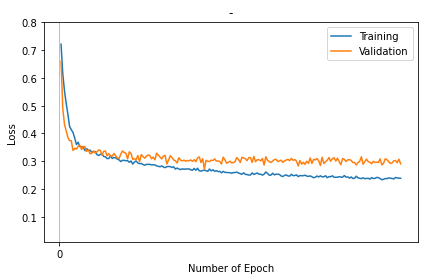

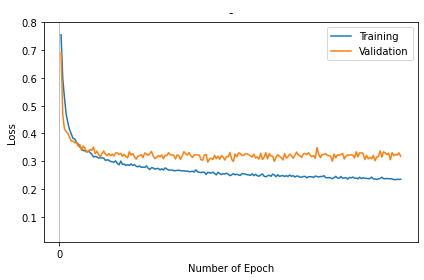

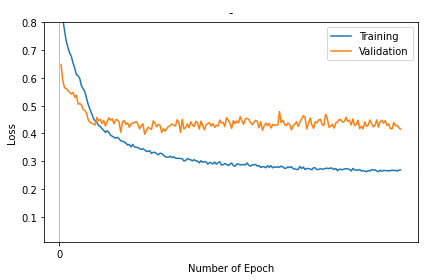

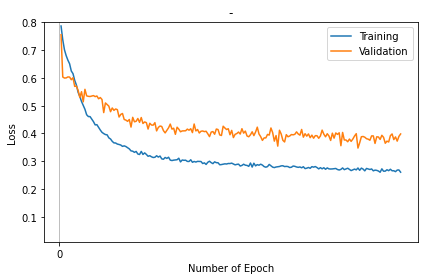

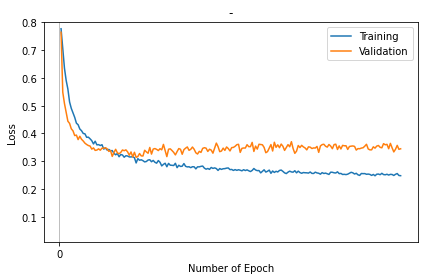

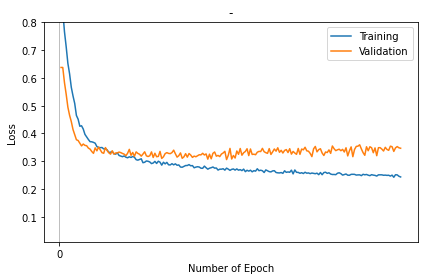

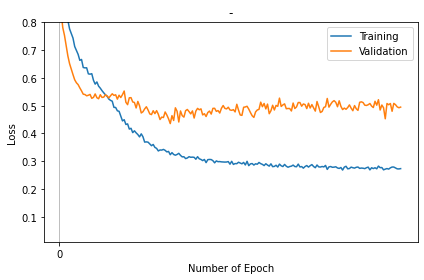

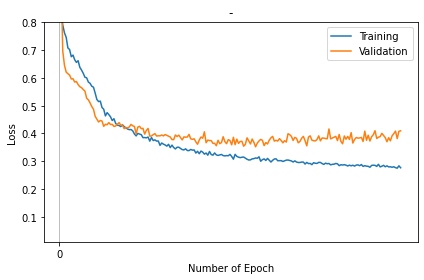

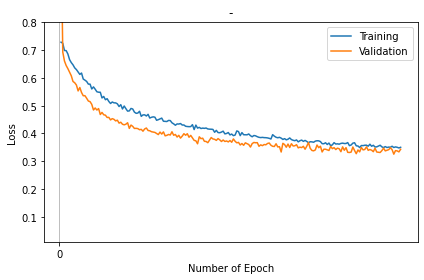

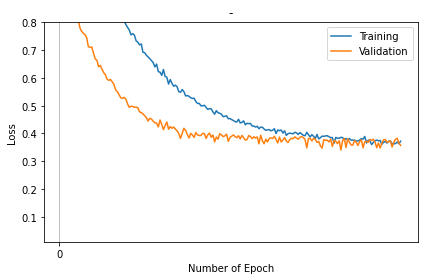

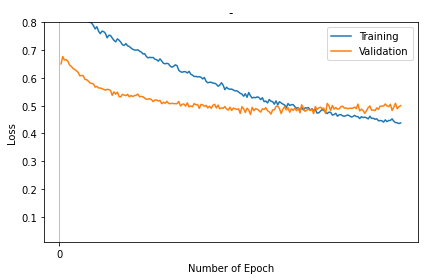

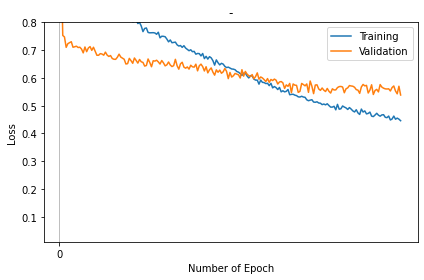

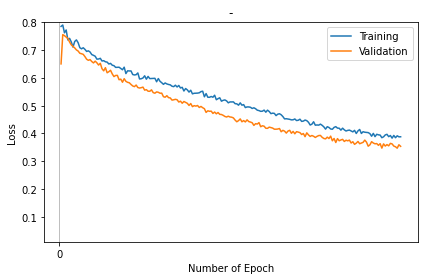

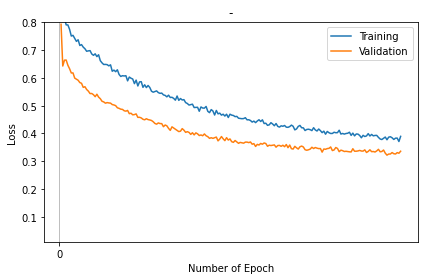

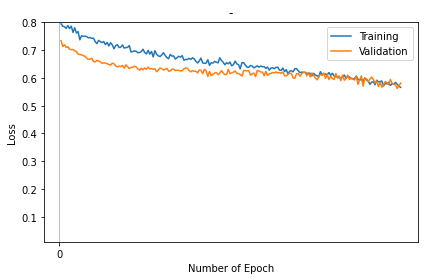

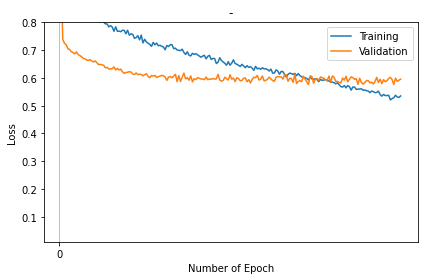

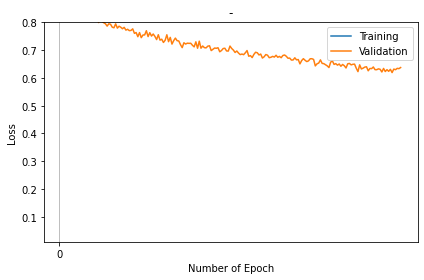

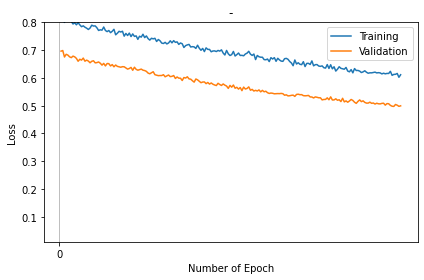

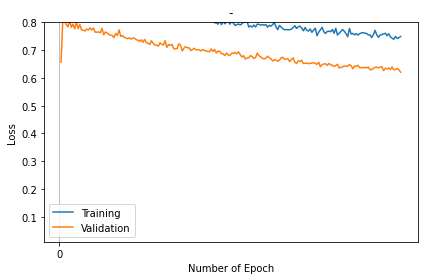

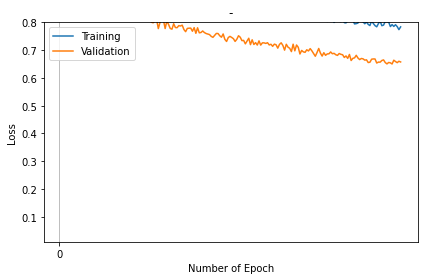

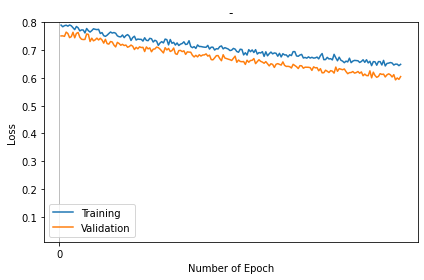

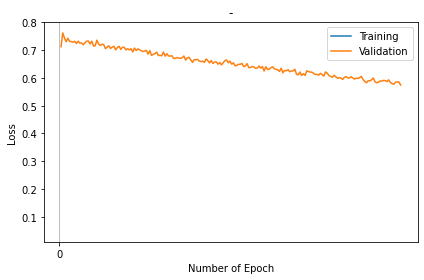

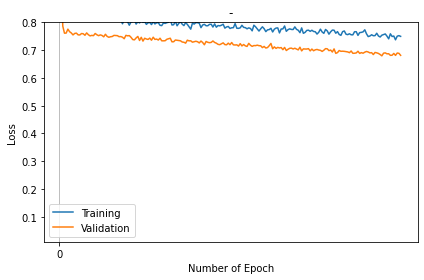

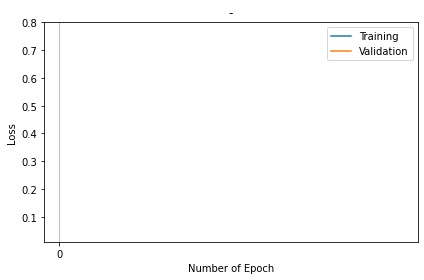

In [5]:
# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-05, cnnDR: 0,  fnDR: 0.1, l2decay: 0
Train_Loss=[0.7213498950004578, 0.6154968738555908, 0.5540504455566406, 0.5086009502410889, 0.46980804204940796, 0.4251132607460022, 0.41337570548057556, 0.40387076139450073, 0.3837605118751526, 0.36026865243911743, 0.368544340133667, 0.3526018559932709, 0.3521220088005066, 0.35124969482421875, 0.3379395008087158, 0.3455883860588074, 0.3400818705558777, 0.3399890065193176, 0.3329581618309021, 0.3345458209514618, 0.3349657654762268, 0.3240223526954651, 0.32065778970718384, 0.3249139189720154, 0.32546281814575195, 0.3174152374267578, 0.3159402012825012, 0.3096691071987152, 0.30992963910102844, 0.31968793272972107, 0.3098312020301819, 0.313401997089386, 0.312436580657959, 0.3079918622970581, 0.30492284893989563, 0.2990090250968933, 0.30349063873291016, 0.30314579606056213, 0.30201900005340576, 0.30201876163482666, 0.2962222993373871, 0.30101197957992554, 0.28972893953323364, 0.29743489623069763, 0.30123716592788696, 0.29376599192619324, 0.29144054651260376, 0.29201140999794006, 0.28838664293289185, 0.28554946184158325, 0.28884419798851013, 0.28884923458099365, 0.2888363003730774, 0.2872154116630554, 0.2869969606399536, 0.28701257705688477, 0.28319206833839417, 0.28196197748184204, 0.2800956666469574, 0.2833098769187927, 0.2791373133659363, 0.2770593762397766, 0.28063133358955383, 0.28117477893829346, 0.2807929217815399, 0.2775722146034241, 0.280115008354187, 0.2719075679779053, 0.2755090594291687, 0.27219313383102417, 0.27003198862075806, 0.2727015018463135, 0.2713346481323242, 0.2720368504524231, 0.2720221281051636, 0.27260035276412964, 0.2690586745738983, 0.2675118148326874, 0.2742261588573456, 0.26761215925216675, 0.2747688889503479, 0.2658178508281708, 0.2644664943218231, 0.2665610611438751, 0.2684967517852783, 0.2660667896270752, 0.26357507705688477, 0.2720955014228821, 0.2651887536048889, 0.26949143409729004, 0.26393455266952515, 0.26613128185272217, 0.26262521743774414, 0.2637898921966553, 0.2582349479198456, 0.26371169090270996, 0.25987592339515686, 0.2598458528518677, 0.25900524854660034, 0.25891369581222534, 0.2568678557872772, 0.25932952761650085, 0.25933682918548584, 0.26101648807525635, 0.2577754259109497, 0.2553434371948242, 0.25302305817604065, 0.25829654932022095, 0.2529713809490204, 0.25203245878219604, 0.2503722906112671, 0.25045228004455566, 0.25823673605918884, 0.2525573670864105, 0.25529515743255615, 0.257903516292572, 0.25315743684768677, 0.2537038028240204, 0.24997979402542114, 0.25339624285697937, 0.26152941584587097, 0.25621315836906433, 0.24986641108989716, 0.2500225007534027, 0.256986141204834, 0.2510044276714325, 0.2535881996154785, 0.25341126322746277, 0.2523369789123535, 0.2470857799053192, 0.24501554667949677, 0.24906301498413086, 0.25077205896377563, 0.24704115092754364, 0.24657079577445984, 0.2530609965324402, 0.24809977412223816, 0.24888071417808533, 0.25098636746406555, 0.24462763965129852, 0.24861884117126465, 0.2478235363960266, 0.2481716126203537, 0.24989113211631775, 0.24652457237243652, 0.24552106857299805, 0.24744606018066406, 0.2443242073059082, 0.24081063270568848, 0.2424832284450531, 0.24688498675823212, 0.24345092475414276, 0.24752172827720642, 0.24387328326702118, 0.24395066499710083, 0.24793359637260437, 0.2406943291425705, 0.24498359858989716, 0.24413733184337616, 0.24773405492305756, 0.24219760298728943, 0.24241501092910767, 0.24249711632728577, 0.24450181424617767, 0.24290966987609863, 0.24255046248435974, 0.2485605925321579, 0.2429303526878357, 0.2436491847038269, 0.2392238974571228, 0.24349474906921387, 0.2380692958831787, 0.23893968760967255, 0.24618689715862274, 0.2402459681034088, 0.23891142010688782, 0.23744158446788788, 0.24058477580547333, 0.23711751401424408, 0.23819047212600708, 0.23877665400505066, 0.23564444482326508, 0.24117720127105713, 0.23780545592308044, 0.23845063149929047, 0.24178257584571838, 0.2411428987979889, 0.23790857195854187, 0.23336414992809296, 0.2351103276014328, 0.23793938755989075, 0.2372710406780243, 0.24004308879375458, 0.23918049037456512, 0.23810327053070068, 0.23637205362319946, 0.24159644544124603, 0.2403043955564499, 0.23884443938732147, 0.2388606071472168]
Test_Loss=[0.6598836779594421, 0.49070844054222107, 0.433371365070343, 0.4094882607460022, 0.38619285821914673, 0.37420153617858887, 0.3736022412776947, 0.33895736932754517, 0.3465842306613922, 0.3436693251132965, 0.35396602749824524, 0.35805705189704895, 0.34246987104415894, 0.35340315103530884, 0.3523893356323242, 0.33517250418663025, 0.34131714701652527, 0.32724201679229736, 0.32810401916503906, 0.3369608521461487, 0.3300860822200775, 0.3337257504463196, 0.3406195640563965, 0.339234322309494, 0.3216206431388855, 0.33602219820022583, 0.3365970253944397, 0.31936511397361755, 0.3276444375514984, 0.3186756670475006, 0.31832292675971985, 0.32823634147644043, 0.3201873302459717, 0.3116389811038971, 0.30961233377456665, 0.325569212436676, 0.33709269762039185, 0.33154889941215515, 0.3288736045360565, 0.3085517883300781, 0.33388370275497437, 0.32832595705986023, 0.3065204620361328, 0.30924805998802185, 0.305551677942276, 0.32057294249534607, 0.2983463704586029, 0.3239362835884094, 0.3169914782047272, 0.31131577491760254, 0.317719042301178, 0.3226849138736725, 0.3210059106349945, 0.3088167607784271, 0.31493642926216125, 0.3050551116466522, 0.32897675037384033, 0.3220454156398773, 0.3151130676269531, 0.3082856833934784, 0.3191036880016327, 0.3211744427680969, 0.2901972234249115, 0.3041757643222809, 0.3201167583465576, 0.3131648600101471, 0.30483192205429077, 0.30213484168052673, 0.29372110962867737, 0.3126126825809479, 0.30423665046691895, 0.30131322145462036, 0.30395451188087463, 0.3003394305706024, 0.3024880588054657, 0.3017772138118744, 0.30482935905456543, 0.2994438409805298, 0.30577269196510315, 0.2982259690761566, 0.31250491738319397, 0.3154746890068054, 0.2952277660369873, 0.3093113899230957, 0.2722664773464203, 0.3033803701400757, 0.2999635636806488, 0.2990489900112152, 0.30388548970222473, 0.30261728167533875, 0.3085470199584961, 0.30093201994895935, 0.300915390253067, 0.299563467502594, 0.29014822840690613, 0.31466516852378845, 0.30575209856033325, 0.2931090295314789, 0.29620304703712463, 0.30008938908576965, 0.29396817088127136, 0.2953893840312958, 0.299000084400177, 0.31316205859184265, 0.306753933429718, 0.29546651244163513, 0.3142620921134949, 0.3115907609462738, 0.309664785861969, 0.30228474736213684, 0.31305259466171265, 0.3129897713661194, 0.2957160472869873, 0.3175819516181946, 0.29825034737586975, 0.3060324192047119, 0.30537399649620056, 0.301503449678421, 0.3099779486656189, 0.2862224280834198, 0.31644347310066223, 0.30331307649612427, 0.29865559935569763, 0.29545509815216064, 0.3010077178478241, 0.30615073442459106, 0.3070772588253021, 0.2991187274456024, 0.30112868547439575, 0.30392026901245117, 0.29601702094078064, 0.301533579826355, 0.3046600818634033, 0.30663272738456726, 0.30208641290664673, 0.3103582561016083, 0.30322369933128357, 0.30625277757644653, 0.3000743091106415, 0.2828374207019806, 0.302765429019928, 0.28939756751060486, 0.29624372720718384, 0.2886835038661957, 0.30007606744766235, 0.2922693192958832, 0.31205716729164124, 0.29232749342918396, 0.3070002496242523, 0.3046760559082031, 0.3099038302898407, 0.3011391758918762, 0.2850112020969391, 0.31476157903671265, 0.29208406805992126, 0.2977565824985504, 0.3038102090358734, 0.31360766291618347, 0.2998824715614319, 0.3090656101703644, 0.3125802278518677, 0.30058416724205017, 0.31134599447250366, 0.29810282588005066, 0.28794988989830017, 0.3097447156906128, 0.3067123591899872, 0.2991301119327545, 0.3052051365375519, 0.3056793212890625, 0.30316999554634094, 0.2954045236110687, 0.29590949416160583, 0.2866421341896057, 0.2952001988887787, 0.29966825246810913, 0.3161531686782837, 0.2892267405986786, 0.2981453835964203, 0.3077063262462616, 0.2985590398311615, 0.2963556945323944, 0.2909044027328491, 0.2998780310153961, 0.2956279218196869, 0.29634836316108704, 0.2960403859615326, 0.3086099922657013, 0.286700963973999, 0.2926740348339081, 0.3089453876018524, 0.3058575987815857, 0.2983149290084839, 0.29226526618003845, 0.294219970703125, 0.30150747299194336, 0.30261364579200745, 0.29464080929756165, 0.3074283003807068, 0.2907388210296631]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-05, cnnDR: 0,  fnDR: 0.1, l2decay: 1e-09

Train_Loss=[0.7555346488952637, 0.5978793501853943, 0.5286741256713867, 0.46963220834732056, 0.438603937625885, 0.41378268599510193, 0.3978120684623718, 0.3823157250881195, 0.3807985782623291, 0.36876124143600464, 0.36245959997177124, 0.351330041885376, 0.34664055705070496, 0.338350385427475, 0.338276743888855, 0.334216445684433, 0.3370320200920105, 0.33148014545440674, 0.3253149688243866, 0.3154769837856293, 0.3172875642776489, 0.31593558192253113, 0.3116028308868408, 0.3122059106826782, 0.31180548667907715, 0.31156688928604126, 0.3030972480773926, 0.30504870414733887, 0.30394411087036133, 0.29905202984809875, 0.29831814765930176, 0.2962132394313812, 0.3015287518501282, 0.29191654920578003, 0.2870595455169678, 0.3005251884460449, 0.2888987064361572, 0.2898860573768616, 0.2848590612411499, 0.2873852550983429, 0.2849072813987732, 0.29056811332702637, 0.2847173810005188, 0.2877833843231201, 0.2822027802467346, 0.2798330783843994, 0.28336238861083984, 0.277784526348114, 0.2792316675186157, 0.2776719927787781, 0.28319913148880005, 0.27523672580718994, 0.2701672315597534, 0.27678585052490234, 0.275939017534256, 0.27132731676101685, 0.2735666036605835, 0.2744019627571106, 0.2687518298625946, 0.2730247974395752, 0.2683016359806061, 0.27607282996177673, 0.27211493253707886, 0.26820075511932373, 0.2685980200767517, 0.2686460614204407, 0.26633763313293457, 0.26586365699768066, 0.26746639609336853, 0.2670191824436188, 0.2667471170425415, 0.2649644613265991, 0.2662857174873352, 0.2635710537433624, 0.2650336027145386, 0.2622741758823395, 0.2627636790275574, 0.26430580019950867, 0.2610193192958832, 0.26920485496520996, 0.2615448236465454, 0.26041704416275024, 0.2590998411178589, 0.26092249155044556, 0.26053982973098755, 0.2521846294403076, 0.26021721959114075, 0.25837641954421997, 0.2572067379951477, 0.2607938349246979, 0.2555699348449707, 0.2506853938102722, 0.26046815514564514, 0.2552696466445923, 0.25192099809646606, 0.2554900646209717, 0.25402796268463135, 0.2571685314178467, 0.25324884057044983, 0.24821791052818298, 0.2509559988975525, 0.2557455003261566, 0.25112083554267883, 0.25337710976600647, 0.2507777214050293, 0.24889779090881348, 0.25522181391716003, 0.2550026476383209, 0.2534934878349304, 0.2514868378639221, 0.2508170008659363, 0.24905946850776672, 0.2548855245113373, 0.24808625876903534, 0.2531852126121521, 0.24773184955120087, 0.24618369340896606, 0.25071170926094055, 0.25446605682373047, 0.2462964504957199, 0.2439480423927307, 0.24756622314453125, 0.2498931586742401, 0.24569234251976013, 0.2537187933921814, 0.25055527687072754, 0.24450281262397766, 0.2514982223510742, 0.24550160765647888, 0.24738961458206177, 0.2483752965927124, 0.24539029598236084, 0.2478080689907074, 0.24517957866191864, 0.25066107511520386, 0.24580799043178558, 0.24823829531669617, 0.24345165491104126, 0.24661824107170105, 0.24657373130321503, 0.2426386922597885, 0.24266695976257324, 0.24542152881622314, 0.24562609195709229, 0.2402404248714447, 0.24441707134246826, 0.24425427615642548, 0.24436786770820618, 0.24154841899871826, 0.24714289605617523, 0.24495387077331543, 0.24344240128993988, 0.24520739912986755, 0.24494151771068573, 0.24815873801708221, 0.24131381511688232, 0.24047386646270752, 0.24144737422466278, 0.2396843433380127, 0.2374873161315918, 0.24074874818325043, 0.2456459254026413, 0.239686518907547, 0.23899826407432556, 0.24508115649223328, 0.23899757862091064, 0.24008706212043762, 0.24087701737880707, 0.2357836365699768, 0.2417922466993332, 0.24036851525306702, 0.24308639764785767, 0.23924314975738525, 0.23943838477134705, 0.2365971803665161, 0.2425510287284851, 0.2374667525291443, 0.24069957435131073, 0.2388124167919159, 0.23851613700389862, 0.23719088733196259, 0.23767869174480438, 0.2429552972316742, 0.23623955249786377, 0.23622499406337738, 0.2346573770046234, 0.23654429614543915, 0.23812812566757202, 0.24248147010803223, 0.23720663785934448, 0.23697444796562195, 0.23827791213989258, 0.23696979880332947, 0.2370493859052658, 0.23617267608642578, 0.23420369625091553, 0.2336912751197815, 0.23522734642028809, 0.23436418175697327, 0.23526635766029358]
Test_Loss=[0.691329836845398, 0.46697577834129333, 0.41595402359962463, 0.40711626410484314, 0.4008166491985321, 0.3857845962047577, 0.37231698632240295, 0.37261635065078735, 0.3667479157447815, 0.3682355582714081, 0.35437020659446716, 0.36033573746681213, 0.338838130235672, 0.3551656901836395, 0.34676507115364075, 0.3322434723377228, 0.33554574847221375, 0.34235408902168274, 0.33936119079589844, 0.35118409991264343, 0.32685160636901855, 0.3365023136138916, 0.32381007075309753, 0.3153572678565979, 0.328429639339447, 0.3367273509502411, 0.3253699839115143, 0.3204925060272217, 0.32734814286231995, 0.3200105130672455, 0.32605063915252686, 0.31893834471702576, 0.33055514097213745, 0.32998499274253845, 0.32423558831214905, 0.32842710614204407, 0.31765761971473694, 0.32500964403152466, 0.31702789664268494, 0.3120650053024292, 0.33439216017723083, 0.3222915828227997, 0.3279789388179779, 0.3159325122833252, 0.3074001967906952, 0.3174366354942322, 0.3201048970222473, 0.32428333163261414, 0.3129732310771942, 0.32964882254600525, 0.3263038098812103, 0.3211802542209625, 0.32737046480178833, 0.33540454506874084, 0.31938299536705017, 0.3094683587551117, 0.3137233257293701, 0.32071664929389954, 0.31569716334342957, 0.322844535112381, 0.3087887465953827, 0.3214053809642792, 0.3206488788127899, 0.3307250440120697, 0.3235790729522705, 0.32193681597709656, 0.3218939006328583, 0.30848178267478943, 0.32280251383781433, 0.32107454538345337, 0.30691301822662354, 0.3188145160675049, 0.3348403871059418, 0.32746049761772156, 0.32214275002479553, 0.33146390318870544, 0.3200254738330841, 0.31350332498550415, 0.3223402500152588, 0.3235565721988678, 0.32262787222862244, 0.32210007309913635, 0.3057125508785248, 0.30364376306533813, 0.3223618268966675, 0.32468292117118835, 0.29667866230010986, 0.30836233496665955, 0.31098055839538574, 0.3065873682498932, 0.3214147984981537, 0.3089677691459656, 0.3182776868343353, 0.30704519152641296, 0.32079121470451355, 0.31525665521621704, 0.30434131622314453, 0.3171938359737396, 0.3163800537586212, 0.3318488299846649, 0.30738314986228943, 0.2990979850292206, 0.3264966905117035, 0.3160649240016937, 0.3302731215953827, 0.32801109552383423, 0.32041364908218384, 0.3213452398777008, 0.32701846957206726, 0.3269715905189514, 0.3238160014152527, 0.31970301270484924, 0.31501448154449463, 0.32545897364616394, 0.31148451566696167, 0.31595662236213684, 0.3077731430530548, 0.3291458785533905, 0.30662432312965393, 0.31464049220085144, 0.3309604227542877, 0.30860719084739685, 0.32751020789146423, 0.3188199996948242, 0.3185168504714966, 0.29945501685142517, 0.314643919467926, 0.32352301478385925, 0.3183196485042572, 0.3122468888759613, 0.3045508563518524, 0.32787376642227173, 0.3109693229198456, 0.31667810678482056, 0.32604628801345825, 0.32097336649894714, 0.3107362389564514, 0.32109901309013367, 0.33323371410369873, 0.32270798087120056, 0.31961116194725037, 0.31385520100593567, 0.32654067873954773, 0.32799243927001953, 0.32383260130882263, 0.3311246335506439, 0.3215622901916504, 0.3162038028240204, 0.3208290636539459, 0.310320645570755, 0.34920641779899597, 0.32527396082878113, 0.3125878870487213, 0.324429988861084, 0.3243961036205292, 0.3279207944869995, 0.32137617468833923, 0.3198237121105194, 0.31846246123313904, 0.29986700415611267, 0.32610970735549927, 0.31211939454078674, 0.32326558232307434, 0.3209664225578308, 0.32436591386795044, 0.32796016335487366, 0.30835822224617004, 0.31867966055870056, 0.32332178950309753, 0.3211234509944916, 0.3237488269805908, 0.32240745425224304, 0.31164517998695374, 0.3342544734477997, 0.3158189058303833, 0.33026280999183655, 0.3300625681877136, 0.3285621106624603, 0.30608126521110535, 0.32168880105018616, 0.3084348142147064, 0.31497785449028015, 0.30871671438217163, 0.32125499844551086, 0.30187639594078064, 0.3152749538421631, 0.3180246353149414, 0.3373905420303345, 0.3146544396877289, 0.3338780403137207, 0.3299941122531891, 0.32370468974113464, 0.32896366715431213, 0.30563655495643616, 0.3310007154941559, 0.3198985755443573, 0.3247174918651581, 0.32223883271217346, 0.33017754554748535, 0.3176792860031128]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-05, cnnDR: 0.05,  fnDR: 0.1, l2decay: 0

Train_Loss=[0.8519177436828613, 0.8126153945922852, 0.7733601331710815, 0.73308265209198, 0.7104974985122681, 0.6899789571762085, 0.6780495643615723, 0.6542483568191528, 0.6355314254760742, 0.6115326881408691, 0.6079933643341064, 0.5968143343925476, 0.5708329081535339, 0.5607289671897888, 0.5493274927139282, 0.5248556137084961, 0.5029387474060059, 0.4862752854824066, 0.47051653265953064, 0.45370161533355713, 0.44472044706344604, 0.4403180480003357, 0.4292331635951996, 0.42484545707702637, 0.4175954759120941, 0.4114517569541931, 0.40368175506591797, 0.40942510962486267, 0.40372389554977417, 0.39356037974357605, 0.3899589478969574, 0.3862916827201843, 0.38294708728790283, 0.38594040274620056, 0.38119930028915405, 0.3734409511089325, 0.3719196021556854, 0.37003669142723083, 0.3641870617866516, 0.3587859272956848, 0.36074239015579224, 0.35173937678337097, 0.3607563376426697, 0.35181325674057007, 0.3502628803253174, 0.3495056629180908, 0.34549927711486816, 0.3422541320323944, 0.34537339210510254, 0.34050798416137695, 0.33594274520874023, 0.3356179893016815, 0.3378851115703583, 0.3282635807991028, 0.3317674696445465, 0.33225011825561523, 0.3274775445461273, 0.3231591582298279, 0.3289942443370819, 0.32787495851516724, 0.3216506838798523, 0.31685417890548706, 0.314546674489975, 0.3149327039718628, 0.31811314821243286, 0.3127794861793518, 0.3161451816558838, 0.3114239275455475, 0.3106977045536041, 0.31058138608932495, 0.31000179052352905, 0.30908364057540894, 0.30117088556289673, 0.30293482542037964, 0.309620201587677, 0.30706095695495605, 0.30525875091552734, 0.30161407589912415, 0.30569273233413696, 0.30094262957572937, 0.3005620539188385, 0.2942187190055847, 0.30190426111221313, 0.2963613271713257, 0.2986485958099365, 0.29752928018569946, 0.2899390161037445, 0.295285165309906, 0.2943788766860962, 0.2900848388671875, 0.2972937226295471, 0.2892566919326782, 0.2947864532470703, 0.2982601225376129, 0.28628018498420715, 0.2876356244087219, 0.2917388081550598, 0.2890586256980896, 0.2842562794685364, 0.28987446427345276, 0.293707937002182, 0.2835853695869446, 0.2823103070259094, 0.2906351089477539, 0.28954240679740906, 0.28695201873779297, 0.2877276837825775, 0.2884174883365631, 0.286615252494812, 0.2938579022884369, 0.28587037324905396, 0.282281756401062, 0.28682568669319153, 0.2870323657989502, 0.28859981894493103, 0.28242671489715576, 0.2843843102455139, 0.2775205075740814, 0.28049537539482117, 0.2801644802093506, 0.27669820189476013, 0.2838503122329712, 0.27789512276649475, 0.28409504890441895, 0.27630680799484253, 0.2798024117946625, 0.27809974551200867, 0.2805333733558655, 0.27806442975997925, 0.2822837233543396, 0.27951622009277344, 0.27450188994407654, 0.2752717435359955, 0.28014445304870605, 0.2771316170692444, 0.28009146451950073, 0.27345144748687744, 0.2717221975326538, 0.27024203538894653, 0.2711073160171509, 0.28132838010787964, 0.2740086019039154, 0.2789335250854492, 0.27011385560035706, 0.2738242447376251, 0.2738058567047119, 0.27193671464920044, 0.2694033682346344, 0.27705490589141846, 0.2758125066757202, 0.2697446048259735, 0.2704869210720062, 0.27394169569015503, 0.27141842246055603, 0.2718537449836731, 0.27469515800476074, 0.27461615204811096, 0.27350109815597534, 0.2758428752422333, 0.2746177911758423, 0.27008479833602905, 0.27409827709198, 0.26575732231140137, 0.2710208594799042, 0.2706953287124634, 0.26980599761009216, 0.27197879552841187, 0.273240864276886, 0.27216416597366333, 0.27104443311691284, 0.2650453448295593, 0.2742019593715668, 0.268330454826355, 0.26830190420150757, 0.2675290107727051, 0.270180344581604, 0.2648452818393707, 0.26662248373031616, 0.26388904452323914, 0.2626945674419403, 0.2666213810443878, 0.26443085074424744, 0.2699732184410095, 0.2680237293243408, 0.26912587881088257, 0.2647838592529297, 0.2628452479839325, 0.2674615681171417, 0.26399660110473633, 0.2667537331581116, 0.2663636803627014, 0.2660788893699646, 0.26555535197257996, 0.26549944281578064, 0.2684762477874756, 0.26616033911705017, 0.26772016286849976, 0.26428645849227905, 0.26810017228126526, 0.26885414123535156]
Test_Loss=[0.648554265499115, 0.5906578898429871, 0.5653807520866394, 0.5612413883209229, 0.5552269220352173, 0.5479460954666138, 0.5422736406326294, 0.5478652119636536, 0.5302644968032837, 0.5377151966094971, 0.505824089050293, 0.5072966814041138, 0.5033923983573914, 0.4859843850135803, 0.48238250613212585, 0.47165438532829285, 0.44809040427207947, 0.43994656205177307, 0.4363301396369934, 0.433999627828598, 0.43060097098350525, 0.45787134766578674, 0.44566622376441956, 0.4503222405910492, 0.4358375072479248, 0.4469890594482422, 0.4271255135536194, 0.44301167130470276, 0.4566895663738251, 0.4477356970310211, 0.45304447412490845, 0.43500444293022156, 0.4495106637477875, 0.4491763114929199, 0.4407501220703125, 0.4041631817817688, 0.44118496775627136, 0.44652825593948364, 0.4329185485839844, 0.43872594833374023, 0.42253509163856506, 0.4337293207645416, 0.4383164346218109, 0.4391593933105469, 0.4428825080394745, 0.43437179923057556, 0.41645678877830505, 0.42760735750198364, 0.43476468324661255, 0.39738428592681885, 0.40998736023902893, 0.4219805896282196, 0.4191257655620575, 0.4143635928630829, 0.44545039534568787, 0.43811795115470886, 0.4242999255657196, 0.4330139756202698, 0.42956113815307617, 0.40343737602233887, 0.41793328523635864, 0.408309668302536, 0.419236958026886, 0.425041526556015, 0.428150475025177, 0.43450117111206055, 0.43043509125709534, 0.42714357376098633, 0.4493858814239502, 0.44067707657814026, 0.4035916328430176, 0.4510597288608551, 0.41616591811180115, 0.4218277037143707, 0.4346282184123993, 0.42030903697013855, 0.442249596118927, 0.430164635181427, 0.4251120090484619, 0.44403502345085144, 0.4375300407409668, 0.415957510471344, 0.44436317682266235, 0.428210586309433, 0.41302433609962463, 0.43113061785697937, 0.43663713335990906, 0.4388347566127777, 0.42672353982925415, 0.43545451760292053, 0.42197591066360474, 0.42979392409324646, 0.4268686771392822, 0.4484385550022125, 0.43736934661865234, 0.43972715735435486, 0.4244832992553711, 0.4570173919200897, 0.44764700531959534, 0.4363405406475067, 0.41837558150291443, 0.4468463957309723, 0.4356396794319153, 0.44498950242996216, 0.4380049407482147, 0.46063971519470215, 0.44490376114845276, 0.43305453658103943, 0.45241546630859375, 0.4546544551849365, 0.4503784775733948, 0.43993884325027466, 0.4317348599433899, 0.4394758343696594, 0.4474615752696991, 0.4438634514808655, 0.42039093375205994, 0.4428158402442932, 0.4117071330547333, 0.42674311995506287, 0.4374401569366455, 0.4280356466770172, 0.436638742685318, 0.41954779624938965, 0.4327905774116516, 0.42916184663772583, 0.4306105673313141, 0.4299502372741699, 0.47917890548706055, 0.43828049302101135, 0.4481251835823059, 0.4324551522731781, 0.4286172091960907, 0.4377383291721344, 0.43219056725502014, 0.41286373138427734, 0.4282267987728119, 0.4330006539821625, 0.442380428314209, 0.4253840446472168, 0.441965788602829, 0.45286282896995544, 0.46473607420921326, 0.45696601271629333, 0.41674739122390747, 0.43551889061927795, 0.45592403411865234, 0.43062588572502136, 0.4186441898345947, 0.4423825442790985, 0.4385692775249481, 0.4488236904144287, 0.4509598910808563, 0.4320584237575531, 0.428497314453125, 0.468980997800827, 0.45548534393310547, 0.4225214123725891, 0.4258839190006256, 0.43313509225845337, 0.4190452992916107, 0.4381345808506012, 0.4408019185066223, 0.4505282938480377, 0.44837746024131775, 0.44076165556907654, 0.4433242976665497, 0.4585101306438446, 0.44357308745384216, 0.44827109575271606, 0.43029794096946716, 0.4525083005428314, 0.4288300573825836, 0.43236419558525085, 0.4478115141391754, 0.4174114167690277, 0.42666926980018616, 0.416708379983902, 0.44155994057655334, 0.42570963501930237, 0.43046876788139343, 0.4485491216182709, 0.43540897965431213, 0.4238811433315277, 0.4300929605960846, 0.4493224322795868, 0.42290303111076355, 0.44358691573143005, 0.4475010931491852, 0.4366709291934967, 0.4462669789791107, 0.42844128608703613, 0.4341767430305481, 0.4173091948032379, 0.4168243408203125, 0.43928059935569763, 0.4275136888027191, 0.4296928346157074, 0.4204842150211334, 0.4157533347606659]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-05, cnnDR: 0.05,  fnDR: 0.1, l2decay: 1e-09

Train_Loss=[0.786946177482605, 0.7373121976852417, 0.7012826204299927, 0.6803531646728516, 0.6640874147415161, 0.6511073112487793, 0.6250237226486206, 0.615424394607544, 0.5912832021713257, 0.5744513273239136, 0.5483083724975586, 0.5328725576400757, 0.5151699185371399, 0.500712513923645, 0.48714298009872437, 0.46752023696899414, 0.46100637316703796, 0.46081918478012085, 0.45145273208618164, 0.4425641894340515, 0.43099939823150635, 0.43172404170036316, 0.4221615195274353, 0.412398099899292, 0.40409594774246216, 0.39966410398483276, 0.39615488052368164, 0.395158052444458, 0.38430458307266235, 0.38015836477279663, 0.37169763445854187, 0.3661263883113861, 0.36573776602745056, 0.3618682026863098, 0.36041533946990967, 0.3584476411342621, 0.3536171615123749, 0.3554416596889496, 0.3529788851737976, 0.34859251976013184, 0.3445996940135956, 0.337352454662323, 0.3362981975078583, 0.3321422040462494, 0.33542582392692566, 0.3261154592037201, 0.3244110345840454, 0.3355073630809784, 0.32452553510665894, 0.33011722564697266, 0.32463309168815613, 0.31794461607933044, 0.3200168311595917, 0.3160867691040039, 0.31354817748069763, 0.31435537338256836, 0.3198581337928772, 0.3150264322757721, 0.31875932216644287, 0.30864888429641724, 0.3072085380554199, 0.313637912273407, 0.31032484769821167, 0.31454116106033325, 0.3041190803050995, 0.30258893966674805, 0.304065078496933, 0.30495962500572205, 0.3055435121059418, 0.31093987822532654, 0.2976139187812805, 0.30455008149147034, 0.3034117817878723, 0.30387425422668457, 0.2995254099369049, 0.29918134212493896, 0.3053920865058899, 0.2963365912437439, 0.29926598072052, 0.29715198278427124, 0.2996261715888977, 0.2993331551551819, 0.2991034984588623, 0.2918596863746643, 0.2941710650920868, 0.2885620594024658, 0.29633277654647827, 0.3000790476799011, 0.29494327306747437, 0.29148054122924805, 0.2979106903076172, 0.29490673542022705, 0.2945730686187744, 0.2873673439025879, 0.2881007790565491, 0.28954437375068665, 0.29076164960861206, 0.29012739658355713, 0.29196393489837646, 0.29175204038619995, 0.2932370901107788, 0.2900036573410034, 0.28710636496543884, 0.288713663816452, 0.289679616689682, 0.2828448414802551, 0.2849878966808319, 0.2893525958061218, 0.2858792245388031, 0.28501570224761963, 0.28168565034866333, 0.29358094930648804, 0.27905020117759705, 0.29302358627319336, 0.2833594083786011, 0.28790590167045593, 0.28568655252456665, 0.289455771446228, 0.2862357497215271, 0.28087419271469116, 0.2786199748516083, 0.2808363437652588, 0.28858649730682373, 0.2839474081993103, 0.278850257396698, 0.2772285044193268, 0.2793354392051697, 0.2802058458328247, 0.2811427414417267, 0.2834084630012512, 0.2837558686733246, 0.2809256911277771, 0.28159382939338684, 0.2808586657047272, 0.2774656414985657, 0.27850577235221863, 0.2827509343624115, 0.2817821502685547, 0.27941569685935974, 0.2781200408935547, 0.27946731448173523, 0.27643126249313354, 0.28029710054397583, 0.27356356382369995, 0.27512127161026, 0.27762413024902344, 0.27462321519851685, 0.2806697189807892, 0.27875444293022156, 0.28098154067993164, 0.2773056924343109, 0.27261459827423096, 0.27692821621894836, 0.27278685569763184, 0.27666354179382324, 0.271126389503479, 0.27601271867752075, 0.27262115478515625, 0.2720995545387268, 0.27241250872612, 0.27336621284484863, 0.27405431866645813, 0.2702941298484802, 0.26850706338882446, 0.2707292139530182, 0.2759702205657959, 0.2698073387145996, 0.2724570631980896, 0.27498966455459595, 0.27086141705513, 0.2663792371749878, 0.2691549062728882, 0.2718159258365631, 0.2690400779247284, 0.27573293447494507, 0.2673971652984619, 0.27536341547966003, 0.27186599373817444, 0.26548346877098083, 0.2741401195526123, 0.2723371386528015, 0.27038902044296265, 0.2723206877708435, 0.2655608654022217, 0.26806315779685974, 0.2672182321548462, 0.26487046480178833, 0.26046258211135864, 0.2727539539337158, 0.2641412913799286, 0.264466255903244, 0.2694087624549866, 0.26609981060028076, 0.27123385667800903, 0.26575979590415955, 0.2658678889274597, 0.2626439929008484, 0.2682531476020813, 0.2687467336654663, 0.2606501579284668]
Test_Loss=[0.7556591629981995, 0.6034070253372192, 0.5996060371398926, 0.6001365184783936, 0.6036407351493835, 0.6031898856163025, 0.5935842394828796, 0.600688099861145, 0.5695714354515076, 0.5707100033760071, 0.5549390912055969, 0.5302463173866272, 0.5504772067070007, 0.5140098333358765, 0.5590682029724121, 0.5354951024055481, 0.5338211059570312, 0.533176064491272, 0.534757137298584, 0.5364821553230286, 0.5327170491218567, 0.5349814295768738, 0.5250516533851624, 0.5294042825698853, 0.5223331451416016, 0.4752364158630371, 0.5100012421607971, 0.504409670829773, 0.4984910190105438, 0.4784238040447235, 0.4918905794620514, 0.4832576811313629, 0.4883085787296295, 0.4857719838619232, 0.4592951834201813, 0.46870771050453186, 0.47199341654777527, 0.45048093795776367, 0.4481929838657379, 0.4438217282295227, 0.45038366317749023, 0.4230891764163971, 0.4581908881664276, 0.44208574295043945, 0.4439840018749237, 0.45396825671195984, 0.44012442231178284, 0.4574544429779053, 0.43599143624305725, 0.44163376092910767, 0.43905505537986755, 0.4160005748271942, 0.4368649423122406, 0.4304628074169159, 0.42996856570243835, 0.43893489241600037, 0.40936872363090515, 0.4217997193336487, 0.42678967118263245, 0.4253380000591278, 0.4103633463382721, 0.40213876962661743, 0.41141077876091003, 0.4203861355781555, 0.43383583426475525, 0.41572752594947815, 0.41898995637893677, 0.3970108926296234, 0.4225810468196869, 0.41558918356895447, 0.4061320424079895, 0.40921932458877563, 0.40928956866264343, 0.40975114703178406, 0.41577011346817017, 0.41185837984085083, 0.41714975237846375, 0.4032200276851654, 0.43412405252456665, 0.40922483801841736, 0.41433411836624146, 0.40177664160728455, 0.40809401869773865, 0.40902528166770935, 0.4067080616950989, 0.4080629348754883, 0.3988528847694397, 0.3888044059276581, 0.40513381361961365, 0.4069018065929413, 0.3972981572151184, 0.41596612334251404, 0.4142301678657532, 0.3946913182735443, 0.3928639590740204, 0.4261195659637451, 0.4198305308818817, 0.41424742341041565, 0.4171006679534912, 0.39555665850639343, 0.41114869713783264, 0.38522443175315857, 0.39696335792541504, 0.3997556269168854, 0.40519824624061584, 0.3978789746761322, 0.417248398065567, 0.4012209475040436, 0.4086793065071106, 0.3909790813922882, 0.3882451057434082, 0.39544424414634705, 0.4060784876346588, 0.392387330532074, 0.40531817078590393, 0.42278924584388733, 0.3981601893901825, 0.38849177956581116, 0.3751136362552643, 0.38415613770484924, 0.3840697705745697, 0.39658886194229126, 0.3943413197994232, 0.4198646545410156, 0.40332818031311035, 0.37245383858680725, 0.39259225130081177, 0.35451507568359375, 0.4116457998752594, 0.39825132489204407, 0.3754669725894928, 0.3694251775741577, 0.3957683742046356, 0.3882684111595154, 0.3909057080745697, 0.396157830953598, 0.39517349004745483, 0.39709052443504333, 0.40582075715065, 0.3981702923774719, 0.394033819437027, 0.41453275084495544, 0.3867199122905731, 0.3992610573768616, 0.39044004678726196, 0.39840349555015564, 0.38487908244132996, 0.3940768539905548, 0.3829940855503082, 0.3922482430934906, 0.3919585645198822, 0.38282227516174316, 0.3912193775177002, 0.41215166449546814, 0.3975125849246979, 0.3880259692668915, 0.39913782477378845, 0.39104902744293213, 0.3749240040779114, 0.40115365386009216, 0.3831746280193329, 0.40191665291786194, 0.39670529961586, 0.4024626910686493, 0.3559740483760834, 0.4037342071533203, 0.3765731155872345, 0.3766419589519501, 0.3701988756656647, 0.3800078332424164, 0.37164297699928284, 0.38010159134864807, 0.39092570543289185, 0.3993237614631653, 0.3474905490875244, 0.3664417266845703, 0.38825079798698425, 0.3892311155796051, 0.38658809661865234, 0.3812727630138397, 0.3795395493507385, 0.37570568919181824, 0.391339510679245, 0.3912819027900696, 0.3642360270023346, 0.388022243976593, 0.38749486207962036, 0.37859439849853516, 0.3935891389846802, 0.38609835505485535, 0.3648799955844879, 0.3724852502346039, 0.369433730840683, 0.3920798897743225, 0.3983541429042816, 0.37797123193740845, 0.38761693239212036, 0.3725120723247528, 0.38953813910484314, 0.3982877731323242]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-05, cnnDR: 0,  fnDR: 0.2, l2decay: 0

Train_Loss=[0.777167797088623, 0.7072169184684753, 0.6349585056304932, 0.5909456014633179, 0.559955358505249, 0.5133341550827026, 0.4903949201107025, 0.47419723868370056, 0.4581163823604584, 0.43713390827178955, 0.4314987361431122, 0.41612133383750916, 0.40999841690063477, 0.4001215398311615, 0.3987578749656677, 0.38635969161987305, 0.38673362135887146, 0.380887508392334, 0.3741222023963928, 0.36222976446151733, 0.372194766998291, 0.35910916328430176, 0.35988935828208923, 0.3566149175167084, 0.3595905303955078, 0.3438222408294678, 0.3480370044708252, 0.34027808904647827, 0.34256434440612793, 0.3376708924770355, 0.33850061893463135, 0.32852670550346375, 0.32331719994544983, 0.32776543498039246, 0.31627047061920166, 0.32429826259613037, 0.32251060009002686, 0.3145539164543152, 0.31989121437072754, 0.31898990273475647, 0.315589040517807, 0.3155485689640045, 0.3166046738624573, 0.31282418966293335, 0.2938908040523529, 0.3094572424888611, 0.30358678102493286, 0.30541524291038513, 0.3021511137485504, 0.2976752817630768, 0.29919302463531494, 0.30443498492240906, 0.30546802282333374, 0.2982872426509857, 0.3030105233192444, 0.2963886857032776, 0.29306063055992126, 0.3024980425834656, 0.296211838722229, 0.28327542543411255, 0.28880074620246887, 0.29288846254348755, 0.28029805421829224, 0.2923113703727722, 0.2858539819717407, 0.28545698523521423, 0.2845342457294464, 0.2927773892879486, 0.27691650390625, 0.28562915325164795, 0.2813991904258728, 0.2821822166442871, 0.29168057441711426, 0.28171128034591675, 0.2796157896518707, 0.28023529052734375, 0.27698999643325806, 0.28031492233276367, 0.2800360321998596, 0.2726071774959564, 0.2799887955188751, 0.27983108162879944, 0.2816772758960724, 0.28273236751556396, 0.2751864790916443, 0.2714771628379822, 0.27392441034317017, 0.27081501483917236, 0.2776399552822113, 0.27427101135253906, 0.27614665031433105, 0.27373144030570984, 0.26699596643447876, 0.27365610003471375, 0.27069664001464844, 0.27305227518081665, 0.27349212765693665, 0.2752252519130707, 0.2758587598800659, 0.2698471248149872, 0.27052992582321167, 0.26693519949913025, 0.2699679434299469, 0.2673325538635254, 0.26945242285728455, 0.26777878403663635, 0.26558083295822144, 0.2696882486343384, 0.2665727734565735, 0.2690575122833252, 0.2657078504562378, 0.26295921206474304, 0.2669083774089813, 0.27391955256462097, 0.2686000466346741, 0.2662481665611267, 0.26657673716545105, 0.2582014799118042, 0.2635434567928314, 0.2692412734031677, 0.26105445623397827, 0.263959676027298, 0.2681788504123688, 0.2565782964229584, 0.2649187445640564, 0.2597247362136841, 0.26384156942367554, 0.2614997625350952, 0.26688632369041443, 0.26835769414901733, 0.26362887024879456, 0.2582013010978699, 0.25565671920776367, 0.26077935099601746, 0.2643905282020569, 0.2615389823913574, 0.26074695587158203, 0.26592564582824707, 0.2583526372909546, 0.2644467353820801, 0.25937843322753906, 0.256695419549942, 0.25936347246170044, 0.2586022615432739, 0.2583751678466797, 0.2573368549346924, 0.2612958550453186, 0.2563207149505615, 0.25609177350997925, 0.2607426345348358, 0.25803041458129883, 0.25682348012924194, 0.2535202205181122, 0.2590266466140747, 0.25598105788230896, 0.2573842406272888, 0.25481224060058594, 0.25260812044143677, 0.26069483160972595, 0.2602939307689667, 0.2584216892719269, 0.25774189829826355, 0.26196539402008057, 0.2553766667842865, 0.2562415897846222, 0.25243741273880005, 0.2530161142349243, 0.2519674003124237, 0.25351035594940186, 0.2569883465766907, 0.26026076078414917, 0.25835826992988586, 0.2540261149406433, 0.25670456886291504, 0.25117984414100647, 0.24912171065807343, 0.25599464774131775, 0.2554174065589905, 0.2555854320526123, 0.2531530261039734, 0.2538887560367584, 0.25265026092529297, 0.24903404712677002, 0.25254106521606445, 0.247725710272789, 0.2533288598060608, 0.2539464831352234, 0.2515677809715271, 0.25661036372184753, 0.2520485520362854, 0.25133079290390015, 0.2532540261745453, 0.25027427077293396, 0.25284695625305176, 0.2524028420448303, 0.24883964657783508, 0.2530497908592224, 0.2557604908943176, 0.24878111481666565, 0.24805143475532532]
Test_Loss=[0.7645969986915588, 0.5487910509109497, 0.5077775120735168, 0.47491762042045593, 0.44418057799339294, 0.43634292483329773, 0.41687479615211487, 0.40949803590774536, 0.3924996256828308, 0.39420774579048157, 0.3780158460140228, 0.38998502492904663, 0.3790528476238251, 0.372884601354599, 0.3651450574398041, 0.36039477586746216, 0.3566115200519562, 0.35479936003685, 0.3437366485595703, 0.34807729721069336, 0.33916351199150085, 0.34033071994781494, 0.3447321057319641, 0.33983084559440613, 0.3473473787307739, 0.34676656126976013, 0.34855031967163086, 0.3449348211288452, 0.3355526924133301, 0.3383626341819763, 0.3175305426120758, 0.3316343128681183, 0.3430194556713104, 0.33051255345344543, 0.32694941759109497, 0.3319337069988251, 0.34061798453330994, 0.3379932940006256, 0.341095507144928, 0.3338637053966522, 0.3218080997467041, 0.33354341983795166, 0.31568947434425354, 0.3323001563549042, 0.314230352640152, 0.3169841766357422, 0.32790327072143555, 0.31927475333213806, 0.318951278924942, 0.3396516740322113, 0.33365747332572937, 0.3288526237010956, 0.3496740758419037, 0.3257793188095093, 0.3438730537891388, 0.34574323892593384, 0.34285804629325867, 0.33853384852409363, 0.3452706038951874, 0.34126728773117065, 0.3606972098350525, 0.3388224244117737, 0.3167131841182709, 0.34327951073646545, 0.34472909569740295, 0.33873245120048523, 0.33208566904067993, 0.32287853956222534, 0.3348948061466217, 0.3457035720348358, 0.34306591749191284, 0.32514405250549316, 0.34182634949684143, 0.3471781611442566, 0.351513147354126, 0.3393605649471283, 0.3429996967315674, 0.35117045044898987, 0.3431411683559418, 0.33044561743736267, 0.32612499594688416, 0.3357046842575073, 0.3318900465965271, 0.34635215997695923, 0.3488357663154602, 0.34716081619262695, 0.33537983894348145, 0.3433017432689667, 0.34019094705581665, 0.32915210723876953, 0.3471375107765198, 0.3653579652309418, 0.3528871536254883, 0.3345872461795807, 0.3368223309516907, 0.34731435775756836, 0.3391590118408203, 0.3514310419559479, 0.34582510590553284, 0.33714041113853455, 0.3492177724838257, 0.3498780429363251, 0.35383227467536926, 0.35973045229911804, 0.36101698875427246, 0.3319670259952545, 0.3465210199356079, 0.34778156876564026, 0.34765177965164185, 0.35957637429237366, 0.35253068804740906, 0.3527200520038605, 0.36795154213905334, 0.33534306287765503, 0.3545898497104645, 0.3437766432762146, 0.36123859882354736, 0.36015719175338745, 0.3593631982803345, 0.3497230112552643, 0.33077484369277954, 0.3347695767879486, 0.3473254442214966, 0.3600631356239319, 0.3369118273258209, 0.36842629313468933, 0.3501552641391754, 0.3591631352901459, 0.34884536266326904, 0.3619191646575928, 0.3540666997432709, 0.33914071321487427, 0.3497909605503082, 0.3598232567310333, 0.35201722383499146, 0.37047818303108215, 0.3455452024936676, 0.3284687399864197, 0.336492657661438, 0.3568130433559418, 0.3493415117263794, 0.3573670983314514, 0.35179898142814636, 0.34800124168395996, 0.3410036265850067, 0.3518894910812378, 0.3507920801639557, 0.34584081172943115, 0.34802207350730896, 0.3476214110851288, 0.3534197509288788, 0.33204951882362366, 0.35516127943992615, 0.3599141240119934, 0.3612857460975647, 0.35414594411849976, 0.3509286940097809, 0.3603229224681854, 0.35468727350234985, 0.34529605507850647, 0.36005207896232605, 0.36139973998069763, 0.3423669636249542, 0.35535699129104614, 0.34431251883506775, 0.35720205307006836, 0.3557255268096924, 0.35587236285209656, 0.3426447808742523, 0.35316428542137146, 0.35439953207969666, 0.35511431097984314, 0.3535832464694977, 0.3402978479862213, 0.34555763006210327, 0.3451017141342163, 0.3474627435207367, 0.34865424036979675, 0.35436636209487915, 0.36115774512290955, 0.3443068563938141, 0.34111377596855164, 0.3411211371421814, 0.352012038230896, 0.34723299741744995, 0.35461658239364624, 0.35671907663345337, 0.3501160144805908, 0.34853145480155945, 0.36341169476509094, 0.3592662513256073, 0.36092644929885864, 0.34506407380104065, 0.3644506633281708, 0.34842801094055176, 0.3336832523345947, 0.34318363666534424, 0.3572019040584564, 0.34300175309181213, 0.3449317514896393]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-05, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-09

Train_Loss=[0.9503924250602722, 0.8425962328910828, 0.7666869163513184, 0.7127000093460083, 0.6524844169616699, 0.614770233631134, 0.566423773765564, 0.5354083776473999, 0.5083333253860474, 0.4649274945259094, 0.4514699876308441, 0.4261012077331543, 0.42779120802879333, 0.4161261022090912, 0.3967745304107666, 0.3876309394836426, 0.37853795289993286, 0.3705069422721863, 0.3700239062309265, 0.36804020404815674, 0.364960253238678, 0.35274142026901245, 0.3499186038970947, 0.3489064872264862, 0.3494989275932312, 0.34439826011657715, 0.3452077805995941, 0.34099704027175903, 0.33186399936676025, 0.33247625827789307, 0.3351920545101166, 0.3269674777984619, 0.32566648721694946, 0.33014869689941406, 0.3208433985710144, 0.3184506893157959, 0.3164837658405304, 0.3191744089126587, 0.3146544396877289, 0.31251877546310425, 0.3160238265991211, 0.31378382444381714, 0.31720229983329773, 0.3143762946128845, 0.30573567748069763, 0.30400437116622925, 0.30642399191856384, 0.3089281916618347, 0.2947748601436615, 0.2963903546333313, 0.3010571599006653, 0.29996687173843384, 0.2974680960178375, 0.29161858558654785, 0.2937248647212982, 0.29954665899276733, 0.29206717014312744, 0.3001498281955719, 0.29659023880958557, 0.28599050641059875, 0.29644259810447693, 0.29062703251838684, 0.2959759831428528, 0.2872734069824219, 0.2867078185081482, 0.29126977920532227, 0.2870924770832062, 0.2906724214553833, 0.2855827808380127, 0.28682103753089905, 0.2791694104671478, 0.27846160531044006, 0.28158608078956604, 0.2846071422100067, 0.28471553325653076, 0.2879565358161926, 0.28361475467681885, 0.2845463454723358, 0.27657783031463623, 0.27891382575035095, 0.2803201675415039, 0.2792016863822937, 0.27489620447158813, 0.27467048168182373, 0.2824680507183075, 0.2766457200050354, 0.27148938179016113, 0.2750065326690674, 0.27678382396698, 0.2793775200843811, 0.27520251274108887, 0.27572908997535706, 0.2682877779006958, 0.2714613676071167, 0.27142295241355896, 0.27313345670700073, 0.26805853843688965, 0.2752372622489929, 0.27164414525032043, 0.26726454496383667, 0.2708601951599121, 0.2722647786140442, 0.26823699474334717, 0.2724721431732178, 0.26784732937812805, 0.26990336179733276, 0.26634788513183594, 0.2717030942440033, 0.2625850737094879, 0.2676044702529907, 0.2644038498401642, 0.26779812574386597, 0.2620002031326294, 0.2661181390285492, 0.2643994987010956, 0.27293312549591064, 0.26606476306915283, 0.26773524284362793, 0.2658918797969818, 0.2594999074935913, 0.26886501908302307, 0.2658175230026245, 0.26260972023010254, 0.2617548704147339, 0.2652859687805176, 0.2659558653831482, 0.2595142722129822, 0.25836050510406494, 0.25793761014938354, 0.25931787490844727, 0.2564511299133301, 0.2656387686729431, 0.2600650191307068, 0.26157963275909424, 0.26027601957321167, 0.2679743766784668, 0.2545243799686432, 0.26870888471603394, 0.2600996494293213, 0.2599194645881653, 0.2567276954650879, 0.2588213086128235, 0.2558300197124481, 0.2604009807109833, 0.25705474615097046, 0.25799760222435, 0.2554507255554199, 0.25760477781295776, 0.2565675675868988, 0.2551790475845337, 0.257178395986557, 0.2517493963241577, 0.2594553232192993, 0.25154373049736023, 0.25930723547935486, 0.26059386134147644, 0.2564259171485901, 0.2585794925689697, 0.25394219160079956, 0.25230786204338074, 0.2524513602256775, 0.2517399191856384, 0.25686752796173096, 0.2585543692111969, 0.2553751468658447, 0.2500799000263214, 0.2520224452018738, 0.25417280197143555, 0.24991375207901, 0.24958309531211853, 0.2528732419013977, 0.25307801365852356, 0.2528599500656128, 0.25025320053100586, 0.25089532136917114, 0.2510388493537903, 0.2482667863368988, 0.2531028985977173, 0.2512163817882538, 0.2524116039276123, 0.2499004453420639, 0.24814027547836304, 0.2516864240169525, 0.25009045004844666, 0.24911385774612427, 0.24669699370861053, 0.2511013448238373, 0.25113481283187866, 0.2511241137981415, 0.24956220388412476, 0.2500600218772888, 0.24917280673980713, 0.2496539205312729, 0.24665236473083496, 0.2500607371330261, 0.24237722158432007, 0.25154006481170654, 0.25097358226776123, 0.2460014820098877, 0.24346093833446503]
Test_Loss=[0.6377593874931335, 0.6376711130142212, 0.5833783745765686, 0.5415464639663696, 0.4947802722454071, 0.4654945433139801, 0.4429779052734375, 0.41440320014953613, 0.39543643593788147, 0.3774488866329193, 0.3747757077217102, 0.36534175276756287, 0.35528722405433655, 0.36201563477516174, 0.3571571409702301, 0.35599285364151, 0.3475515842437744, 0.34378570318222046, 0.33517441153526306, 0.3284938931465149, 0.3482767939567566, 0.33766332268714905, 0.35089293122291565, 0.3410443067550659, 0.3309042453765869, 0.32878032326698303, 0.34927651286125183, 0.3384902775287628, 0.3304261565208435, 0.3256133496761322, 0.33765003085136414, 0.3258616030216217, 0.3297271430492401, 0.3301631808280945, 0.3331206738948822, 0.3311479985713959, 0.32807955145835876, 0.3254818618297577, 0.3199450671672821, 0.32876890897750854, 0.3428623378276825, 0.32144591212272644, 0.33161720633506775, 0.317780077457428, 0.3337753117084503, 0.3282736539840698, 0.32528170943260193, 0.31846651434898376, 0.325914591550827, 0.33410850167274475, 0.31957465410232544, 0.3171033561229706, 0.3198663294315338, 0.3337012827396393, 0.3136143386363983, 0.3288422226905823, 0.31639528274536133, 0.3173729479312897, 0.3354662358760834, 0.31021562218666077, 0.3160093128681183, 0.3275054395198822, 0.33108896017074585, 0.3283156454563141, 0.32742172479629517, 0.33124563097953796, 0.34004032611846924, 0.32697710394859314, 0.3148646354675293, 0.32008567452430725, 0.3300072252750397, 0.3106129765510559, 0.31592753529548645, 0.32725992798805237, 0.31489548087120056, 0.32782474160194397, 0.3222120702266693, 0.3139711618423462, 0.3185792863368988, 0.31620311737060547, 0.31997641921043396, 0.3234504461288452, 0.32302117347717285, 0.3286904990673065, 0.32261356711387634, 0.3264326751232147, 0.3075801432132721, 0.3255048096179962, 0.30881795287132263, 0.3285129964351654, 0.33334288001060486, 0.31833526492118835, 0.3210487961769104, 0.31689488887786865, 0.3259989321231842, 0.32981300354003906, 0.3358484208583832, 0.3060286343097687, 0.3212825059890747, 0.34624263644218445, 0.3081560730934143, 0.3208295404911041, 0.3116472363471985, 0.3370256721973419, 0.32501018047332764, 0.34592440724372864, 0.32176080346107483, 0.3306850492954254, 0.33514732122421265, 0.3450586497783661, 0.3203984498977661, 0.34416553378105164, 0.3245764672756195, 0.3254050314426422, 0.32357168197631836, 0.3325522243976593, 0.3355260491371155, 0.33505693078041077, 0.34637242555618286, 0.3345280587673187, 0.3308902680873871, 0.32846540212631226, 0.3455413579940796, 0.3245619535446167, 0.33396264910697937, 0.3442138135433197, 0.33633801341056824, 0.3485144078731537, 0.3322164714336395, 0.3394142687320709, 0.3296518325805664, 0.33898741006851196, 0.34204351902008057, 0.33137503266334534, 0.34526416659355164, 0.3257248103618622, 0.33540859818458557, 0.3296026885509491, 0.3249795734882355, 0.34611964225769043, 0.32484981417655945, 0.3439498841762543, 0.34113630652427673, 0.35047683119773865, 0.3375016450881958, 0.3362034261226654, 0.32831132411956787, 0.3167564868927002, 0.3447807729244232, 0.35331299901008606, 0.333960622549057, 0.3418610990047455, 0.345101535320282, 0.32971060276031494, 0.32078954577445984, 0.3333517014980316, 0.331432580947876, 0.340895414352417, 0.3284536302089691, 0.3549673557281494, 0.3452324867248535, 0.3382183909416199, 0.34128671884536743, 0.34348273277282715, 0.33796098828315735, 0.34278246760368347, 0.333411306142807, 0.3485366702079773, 0.31927424669265747, 0.33756184577941895, 0.35169926285743713, 0.3164650499820709, 0.3425094187259674, 0.3534596562385559, 0.35441991686820984, 0.3592948913574219, 0.34439656138420105, 0.33093973994255066, 0.3214322030544281, 0.3521663248538971, 0.337956964969635, 0.35221388936042786, 0.34859156608581543, 0.3307401239871979, 0.3480938673019409, 0.32002970576286316, 0.34884172677993774, 0.3489469587802887, 0.3437294661998749, 0.33685946464538574, 0.35025498270988464, 0.3425411880016327, 0.33935073018074036, 0.3543238341808319, 0.3523569107055664, 0.33545640110969543, 0.3481256067752838, 0.3528585135936737, 0.3485074043273926, 0.3468516170978546]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-05, cnnDR: 0.05,  fnDR: 0.2, l2decay: 0

Train_Loss=[0.9496153593063354, 0.9141025543212891, 0.872966468334198, 0.8440157175064087, 0.8071609735488892, 0.776354193687439, 0.7595528960227966, 0.7434771060943604, 0.7131508588790894, 0.6992944478988647, 0.6849362254142761, 0.6634188890457153, 0.6665589809417725, 0.6376804709434509, 0.636245608329773, 0.6365733742713928, 0.6147259473800659, 0.6135909557342529, 0.6152937412261963, 0.5916141271591187, 0.5776664018630981, 0.5856883525848389, 0.5705118179321289, 0.5631548762321472, 0.5542235374450684, 0.5465141534805298, 0.539526104927063, 0.5338696241378784, 0.5239418745040894, 0.5192326307296753, 0.5162960886955261, 0.4940134882926941, 0.49369877576828003, 0.4815990626811981, 0.4799814820289612, 0.4628656804561615, 0.44531750679016113, 0.44958823919296265, 0.43250104784965515, 0.43453526496887207, 0.41587504744529724, 0.4187389314174652, 0.4031631350517273, 0.40962597727775574, 0.4023073613643646, 0.3962266445159912, 0.3877665400505066, 0.3987298607826233, 0.3882049322128296, 0.36897024512290955, 0.369742214679718, 0.3686973452568054, 0.36226886510849, 0.3560088872909546, 0.3605068624019623, 0.3498973846435547, 0.34638166427612305, 0.3371194005012512, 0.3406316936016083, 0.3401818871498108, 0.3426472544670105, 0.33929866552352905, 0.33366867899894714, 0.33536481857299805, 0.32356464862823486, 0.3310515284538269, 0.3244028091430664, 0.32185110449790955, 0.3244708776473999, 0.32859084010124207, 0.3212079107761383, 0.31581100821495056, 0.3162590265274048, 0.3096626102924347, 0.3117593228816986, 0.31645068526268005, 0.3143499493598938, 0.31487154960632324, 0.31411856412887573, 0.30732932686805725, 0.3164430856704712, 0.30887657403945923, 0.30645325779914856, 0.30242228507995605, 0.30643436312675476, 0.2950531244277954, 0.3058171272277832, 0.3065207004547119, 0.3060572147369385, 0.30201655626296997, 0.29437071084976196, 0.30122101306915283, 0.2984916865825653, 0.2988516092300415, 0.29782283306121826, 0.2975020408630371, 0.2970229685306549, 0.2972787022590637, 0.2987440824508667, 0.2894793152809143, 0.29989874362945557, 0.2886422872543335, 0.2917061448097229, 0.2913259267807007, 0.2964378297328949, 0.2937244176864624, 0.29083192348480225, 0.29577842354774475, 0.28667688369750977, 0.2997593879699707, 0.28419625759124756, 0.29053497314453125, 0.29175981879234314, 0.2863152325153351, 0.29094117879867554, 0.2892712652683258, 0.2956790328025818, 0.29138562083244324, 0.28876829147338867, 0.2844494879245758, 0.2910289764404297, 0.28632381558418274, 0.2824646532535553, 0.29073458909988403, 0.2805996835231781, 0.28144702315330505, 0.28567689657211304, 0.2791198194026947, 0.2897363305091858, 0.2836962938308716, 0.2809526324272156, 0.2885921895503998, 0.2821061313152313, 0.2784574627876282, 0.28105589747428894, 0.28238868713378906, 0.28619158267974854, 0.28099164366722107, 0.28026655316352844, 0.2897680401802063, 0.27952390909194946, 0.28091245889663696, 0.27518248558044434, 0.2810482382774353, 0.2845452129840851, 0.27895841002464294, 0.28404754400253296, 0.28799208998680115, 0.28110095858573914, 0.2767394781112671, 0.2865022122859955, 0.27977412939071655, 0.2792138159275055, 0.28118008375167847, 0.2795891761779785, 0.2850252389907837, 0.2706388831138611, 0.27975893020629883, 0.2809922695159912, 0.2783249020576477, 0.27879583835601807, 0.280178427696228, 0.27587613463401794, 0.2742156386375427, 0.2775038480758667, 0.26830431818962097, 0.2789018750190735, 0.2819664478302002, 0.272795706987381, 0.27384936809539795, 0.2789284288883209, 0.2767406702041626, 0.2753530442714691, 0.278307169675827, 0.27923426032066345, 0.274370938539505, 0.27555587887763977, 0.27495667338371277, 0.2734481692314148, 0.2767552435398102, 0.27886664867401123, 0.26895153522491455, 0.27664175629615784, 0.27362513542175293, 0.27671200037002563, 0.2728605270385742, 0.28257519006729126, 0.2769218385219574, 0.27742284536361694, 0.26909422874450684, 0.27164459228515625, 0.2737147808074951, 0.27169865369796753, 0.2763228118419647, 0.27923357486724854, 0.27917593717575073, 0.27602827548980713, 0.27267181873321533, 0.27234089374542236, 0.2734590172767639]
Test_Loss=[0.8388082385063171, 0.7815454602241516, 0.7536052465438843, 0.7168353796005249, 0.6789983510971069, 0.6512704491615295, 0.631292462348938, 0.6119300723075867, 0.593285083770752, 0.5826130509376526, 0.5759817361831665, 0.5641818046569824, 0.5534966588020325, 0.541507363319397, 0.5403477549552917, 0.535681962966919, 0.537728488445282, 0.5406943559646606, 0.5265579223632812, 0.5300655364990234, 0.5423502326011658, 0.5288269519805908, 0.5250446200370789, 0.5395812392234802, 0.5298091769218445, 0.5308739542961121, 0.5391085147857666, 0.5352751016616821, 0.5280023813247681, 0.5359081029891968, 0.5429169535636902, 0.5371794104576111, 0.5393890738487244, 0.5236656069755554, 0.537864089012146, 0.5294916033744812, 0.5399572253227234, 0.5529298186302185, 0.5123656392097473, 0.5038130283355713, 0.5285236239433289, 0.5290310382843018, 0.5135378241539001, 0.5116759538650513, 0.49188095331192017, 0.5154454708099365, 0.49961885809898376, 0.47386154532432556, 0.47835031151771545, 0.4884956479072571, 0.49624475836753845, 0.4844619929790497, 0.4704693853855133, 0.468038946390152, 0.4819231629371643, 0.47147056460380554, 0.4822261929512024, 0.4693284034729004, 0.45033499598503113, 0.45902928709983826, 0.4574842154979706, 0.47749778628349304, 0.46641215682029724, 0.4527837336063385, 0.4356768727302551, 0.4642671048641205, 0.4468257427215576, 0.4924549162387848, 0.4799592196941376, 0.44132882356643677, 0.48110970854759216, 0.4642612636089325, 0.458926260471344, 0.482145756483078, 0.4864702820777893, 0.4788876473903656, 0.47060009837150574, 0.4812679886817932, 0.45565682649612427, 0.4806600511074066, 0.4903787672519684, 0.48543959856033325, 0.4886493384838104, 0.46685218811035156, 0.4712395668029785, 0.4611988961696625, 0.47552403807640076, 0.4806419312953949, 0.4699232280254364, 0.49049267172813416, 0.49065980315208435, 0.47971102595329285, 0.48244497179985046, 0.4737307131290436, 0.4908493459224701, 0.5006665587425232, 0.4904555380344391, 0.4885312020778656, 0.4945249557495117, 0.48475131392478943, 0.48347148299217224, 0.4858563542366028, 0.47772374749183655, 0.5051912665367126, 0.48435670137405396, 0.4666460454463959, 0.46529194712638855, 0.49439460039138794, 0.4955672323703766, 0.4980071187019348, 0.48778611421585083, 0.4752658009529114, 0.4638833999633789, 0.4579051434993744, 0.47768840193748474, 0.4846899211406708, 0.4867921769618988, 0.5128158330917358, 0.4965492784976959, 0.5080727934837341, 0.48853302001953125, 0.5057603120803833, 0.47118186950683594, 0.4820188581943512, 0.5016705393791199, 0.48461028933525085, 0.5010556578636169, 0.4978654384613037, 0.5273415446281433, 0.4973234236240387, 0.5028031468391418, 0.5066372156143188, 0.4891502857208252, 0.49007463455200195, 0.4899478852748871, 0.4810914099216461, 0.5096208453178406, 0.489924818277359, 0.495849609375, 0.5115066766738892, 0.5113841891288757, 0.49823346734046936, 0.50628662109375, 0.5040711760520935, 0.48965129256248474, 0.5088747143745422, 0.49170953035354614, 0.5039880871772766, 0.4923191964626312, 0.4806167781352997, 0.5151147246360779, 0.4961843192577362, 0.47561198472976685, 0.47935229539871216, 0.4936952590942383, 0.49649736285209656, 0.5260745882987976, 0.4948459565639496, 0.5050222277641296, 0.5137613415718079, 0.518226146697998, 0.5123358964920044, 0.49632254242897034, 0.5176734328269958, 0.4977496266365051, 0.48614659905433655, 0.49139952659606934, 0.4872001111507416, 0.4934201240539551, 0.5029606819152832, 0.491220086812973, 0.4820117652416229, 0.5004772543907166, 0.48908305168151855, 0.48314449191093445, 0.5122297406196594, 0.5139575004577637, 0.5114136934280396, 0.5019246935844421, 0.5009884834289551, 0.5035859942436218, 0.5079742670059204, 0.49867135286331177, 0.4934503734111786, 0.5159690976142883, 0.5018935799598694, 0.5216426253318787, 0.4844827353954315, 0.5024908185005188, 0.4924788475036621, 0.4529527723789215, 0.5079748034477234, 0.5035245418548584, 0.5078837275505066, 0.4799550175666809, 0.5084616541862488, 0.5036916136741638, 0.495861291885376, 0.4926977753639221, 0.4950253665447235]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-05, cnnDR: 0.05,  fnDR: 0.2, l2decay: 1e-09

Train_Loss=[0.8362069129943848, 0.7903075218200684, 0.7623841762542725, 0.746412456035614, 0.7080912590026855, 0.702353835105896, 0.6764089465141296, 0.6823172569274902, 0.6654598712921143, 0.6560297608375549, 0.6621004343032837, 0.638368546962738, 0.6283889412879944, 0.6167862415313721, 0.6024130582809448, 0.6005879640579224, 0.5852577090263367, 0.5806539058685303, 0.5702474117279053, 0.5666897892951965, 0.5452938079833984, 0.5222353935241699, 0.5149163603782654, 0.5165277719497681, 0.49356722831726074, 0.487360417842865, 0.4632413983345032, 0.47507357597351074, 0.46802759170532227, 0.45982134342193604, 0.4466278553009033, 0.4531652331352234, 0.4363172948360443, 0.42998069524765015, 0.4286789894104004, 0.4248363673686981, 0.43134790658950806, 0.4246551990509033, 0.42035767436027527, 0.41598448157310486, 0.4138065576553345, 0.41435331106185913, 0.40952011942863464, 0.3981340527534485, 0.39127200841903687, 0.40041518211364746, 0.3978017270565033, 0.3958838880062103, 0.3850986957550049, 0.3853400647640228, 0.3843224048614502, 0.3871380686759949, 0.3725283145904541, 0.38552984595298767, 0.3745441436767578, 0.37702879309654236, 0.3726132810115814, 0.3728358745574951, 0.3572292923927307, 0.3657740354537964, 0.3615782856941223, 0.35872191190719604, 0.3545073866844177, 0.3610174357891083, 0.3492226004600525, 0.35814279317855835, 0.34956836700439453, 0.34437379240989685, 0.35039979219436646, 0.3505171239376068, 0.3463720679283142, 0.34196722507476807, 0.34090232849121094, 0.34477099776268005, 0.33865711092948914, 0.3383268713951111, 0.34262657165527344, 0.34000667929649353, 0.3406650424003601, 0.3296046853065491, 0.33596715331077576, 0.32713454961776733, 0.3366789221763611, 0.3329489231109619, 0.32565999031066895, 0.3296942114830017, 0.3218534588813782, 0.3351835012435913, 0.3242121934890747, 0.3220084309577942, 0.329948365688324, 0.322903573513031, 0.3209989666938782, 0.32275497913360596, 0.32452139258384705, 0.32041752338409424, 0.3193417191505432, 0.32043468952178955, 0.31982070207595825, 0.3247150778770447, 0.3172360360622406, 0.30755800008773804, 0.3248664140701294, 0.31758007407188416, 0.31485459208488464, 0.3130456209182739, 0.3145694136619568, 0.31520941853523254, 0.31124383211135864, 0.30732977390289307, 0.3044980764389038, 0.30503740906715393, 0.30857568979263306, 0.3094315230846405, 0.31187188625335693, 0.3107295036315918, 0.3161807656288147, 0.30000364780426025, 0.30583328008651733, 0.3085578978061676, 0.30291077494621277, 0.31029534339904785, 0.30352726578712463, 0.29722896218299866, 0.3034819960594177, 0.30810993909835815, 0.30879494547843933, 0.3018414378166199, 0.3022744059562683, 0.3022790551185608, 0.2992536723613739, 0.3015323877334595, 0.3040330708026886, 0.30444401502609253, 0.30268368124961853, 0.30116790533065796, 0.29727745056152344, 0.30136677622795105, 0.2971740663051605, 0.2954535484313965, 0.29562896490097046, 0.2971031069755554, 0.2970854938030243, 0.28997713327407837, 0.29580196738243103, 0.2916223108768463, 0.2922140061855316, 0.2878037393093109, 0.294745534658432, 0.2927761971950531, 0.29219743609428406, 0.2960056960582733, 0.29569730162620544, 0.29170742630958557, 0.28864434361457825, 0.2932320237159729, 0.2909911572933197, 0.2920614778995514, 0.28710052371025085, 0.2889973521232605, 0.2893967926502228, 0.29207006096839905, 0.29082247614860535, 0.284162700176239, 0.2874549329280853, 0.2863878905773163, 0.2876196503639221, 0.28595805168151855, 0.28301453590393066, 0.28605565428733826, 0.283545583486557, 0.28579282760620117, 0.28251752257347107, 0.28625914454460144, 0.2869853377342224, 0.2839295566082001, 0.28818175196647644, 0.2815392017364502, 0.2840520143508911, 0.2823292016983032, 0.281840980052948, 0.2783825099468231, 0.2850566506385803, 0.28586718440055847, 0.28527966141700745, 0.2815331816673279, 0.289078950881958, 0.27967509627342224, 0.28208595514297485, 0.28529274463653564, 0.28022831678390503, 0.28359490633010864, 0.27964282035827637, 0.28014498949050903, 0.27835795283317566, 0.280212938785553, 0.2769375145435333, 0.27513012290000916, 0.2835754156112671, 0.2765728235244751]
Test_Loss=[0.972320020198822, 0.6964348554611206, 0.6456493735313416, 0.621096134185791, 0.6151837706565857, 0.6103292107582092, 0.5964280962944031, 0.5970274806022644, 0.5851519107818604, 0.587257981300354, 0.5761467218399048, 0.5684837698936462, 0.5650157332420349, 0.5582329630851746, 0.5526117086410522, 0.5270520448684692, 0.5210691690444946, 0.5101597905158997, 0.49694567918777466, 0.4874797463417053, 0.4617070257663727, 0.4516746699810028, 0.441392719745636, 0.4468018710613251, 0.4449184536933899, 0.42574140429496765, 0.4331589639186859, 0.43172571063041687, 0.4391845166683197, 0.4322853088378906, 0.43309861421585083, 0.42528629302978516, 0.42699533700942993, 0.4336492717266083, 0.4391767084598541, 0.42962732911109924, 0.4298624098300934, 0.4174064099788666, 0.4213717579841614, 0.41995126008987427, 0.4235248565673828, 0.43270549178123474, 0.4276358187198639, 0.4254542291164398, 0.3983730673789978, 0.4230247139930725, 0.42583712935447693, 0.41734763979911804, 0.4185822904109955, 0.39775609970092773, 0.41105762124061584, 0.4181000888347626, 0.3904069662094116, 0.3908105790615082, 0.3958607316017151, 0.3995148241519928, 0.3908340036869049, 0.39175865054130554, 0.39162442088127136, 0.39461296796798706, 0.3914054334163666, 0.3961508870124817, 0.393166184425354, 0.38977810740470886, 0.38734716176986694, 0.37813684344291687, 0.3778315484523773, 0.3944571614265442, 0.38916897773742676, 0.3940064311027527, 0.3852119445800781, 0.37693530321121216, 0.3877507150173187, 0.3866559565067291, 0.38732847571372986, 0.3967030346393585, 0.3807447850704193, 0.3790760934352875, 0.38079866766929626, 0.369992196559906, 0.36125561594963074, 0.376560777425766, 0.38727161288261414, 0.3828452527523041, 0.4060271680355072, 0.366699755191803, 0.3762785494327545, 0.37438055872917175, 0.3744071125984192, 0.3645702302455902, 0.3646761476993561, 0.3560338616371155, 0.3756050169467926, 0.3632917106151581, 0.3669934570789337, 0.38832002878189087, 0.37064650654792786, 0.3632224500179291, 0.3779580295085907, 0.37462541460990906, 0.35930678248405457, 0.386251837015152, 0.3599468469619751, 0.37958869338035583, 0.3643922805786133, 0.37133342027664185, 0.37192556262016296, 0.3541484773159027, 0.3610401153564453, 0.3843294382095337, 0.3736594021320343, 0.36237677931785583, 0.38002920150756836, 0.3683343827724457, 0.352016806602478, 0.3652495741844177, 0.3731064200401306, 0.3786441385746002, 0.37550994753837585, 0.3563234508037567, 0.3674023151397705, 0.3622574210166931, 0.3756258189678192, 0.3843340575695038, 0.38961705565452576, 0.3725842237472534, 0.37553927302360535, 0.3726597726345062, 0.38151612877845764, 0.3746347725391388, 0.366451233625412, 0.37412357330322266, 0.3691341280937195, 0.39914676547050476, 0.3958321511745453, 0.38951730728149414, 0.3749537467956543, 0.38578343391418457, 0.3826010227203369, 0.366579532623291, 0.3714621067047119, 0.3826546370983124, 0.3895152509212494, 0.37409767508506775, 0.3555530309677124, 0.3870864510536194, 0.39149364829063416, 0.3758370876312256, 0.37403902411460876, 0.3730822205543518, 0.37824955582618713, 0.39144110679626465, 0.3735857903957367, 0.38376128673553467, 0.38336893916130066, 0.3817211985588074, 0.3811003863811493, 0.4162369668483734, 0.38072076439857483, 0.3835935890674591, 0.38680848479270935, 0.38952967524528503, 0.37451085448265076, 0.3963871896266937, 0.371528297662735, 0.3629198372364044, 0.39100709557533264, 0.3793089985847473, 0.3895159065723419, 0.37865760922431946, 0.40302225947380066, 0.3656068444252014, 0.3783348500728607, 0.3854082226753235, 0.38332268595695496, 0.3839995861053467, 0.38581112027168274, 0.3712620437145233, 0.40857020020484924, 0.37553420662879944, 0.3938025236129761, 0.37295645475387573, 0.38814577460289, 0.39572206139564514, 0.4100112020969391, 0.38210442662239075, 0.3865140378475189, 0.3888377845287323, 0.4005463719367981, 0.3927000164985657, 0.38507625460624695, 0.3702981770038605, 0.3849133253097534, 0.3735150992870331, 0.3916796147823334, 0.3994179964065552, 0.40865883231163025, 0.3816896677017212, 0.4078676700592041, 0.40966159105300903]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-06, cnnDR: 0,  fnDR: 0.1, l2decay: 0

Train_Loss=[0.728742778301239, 0.7248679995536804, 0.6988730430603027, 0.6983804702758789, 0.6862730979919434, 0.6658854484558105, 0.655190646648407, 0.647240161895752, 0.6363549828529358, 0.6301055550575256, 0.621665358543396, 0.6127374768257141, 0.6176678538322449, 0.5960863828659058, 0.5920579433441162, 0.5873951315879822, 0.5778036713600159, 0.5776121616363525, 0.5602213740348816, 0.5677421689033508, 0.5594624280929565, 0.5502336025238037, 0.548641562461853, 0.5484536290168762, 0.5280033349990845, 0.5332793593406677, 0.5215945243835449, 0.5252540111541748, 0.515276312828064, 0.5080230236053467, 0.5133917331695557, 0.5103886127471924, 0.5101824998855591, 0.5067869424819946, 0.49713873863220215, 0.5037388205528259, 0.4882742762565613, 0.49895644187927246, 0.4893121123313904, 0.4805424213409424, 0.48137301206588745, 0.49015769362449646, 0.4881802797317505, 0.476916640996933, 0.4726381301879883, 0.47361326217651367, 0.4800134301185608, 0.46171820163726807, 0.4668341875076294, 0.4671604037284851, 0.46303755044937134, 0.4689468741416931, 0.45565009117126465, 0.45833534002304077, 0.4599033296108246, 0.45867741107940674, 0.44753775000572205, 0.44973963499069214, 0.4523765444755554, 0.45538330078125, 0.44412678480148315, 0.4436469078063965, 0.4431111812591553, 0.447014182806015, 0.4465465247631073, 0.43850141763687134, 0.4346153140068054, 0.42974287271499634, 0.4343668818473816, 0.43398571014404297, 0.4358592629432678, 0.4304313659667969, 0.4306047558784485, 0.42600902915000916, 0.42507633566856384, 0.4245997369289398, 0.4247986674308777, 0.4318298101425171, 0.4141281545162201, 0.4301472306251526, 0.419352263212204, 0.42211776971817017, 0.4179306924343109, 0.41939210891723633, 0.4185008406639099, 0.4197021424770355, 0.4163514971733093, 0.4155566692352295, 0.4153982102870941, 0.41470441222190857, 0.40444135665893555, 0.4112231135368347, 0.40330740809440613, 0.40272074937820435, 0.4050333499908447, 0.408430278301239, 0.3986329734325409, 0.40006357431411743, 0.40341198444366455, 0.39486515522003174, 0.39793747663497925, 0.39225372672080994, 0.3943210542201996, 0.40930789709091187, 0.4067179560661316, 0.3922915458679199, 0.4032367169857025, 0.3955148458480835, 0.39535850286483765, 0.39526838064193726, 0.3982490003108978, 0.39208006858825684, 0.38822993636131287, 0.3927273452281952, 0.39156657457351685, 0.3884190022945404, 0.38619279861450195, 0.385236918926239, 0.3860202729701996, 0.3850794732570648, 0.38488948345184326, 0.38406485319137573, 0.3824988305568695, 0.3800753057003021, 0.39576494693756104, 0.39032721519470215, 0.3864191770553589, 0.3845982551574707, 0.38621634244918823, 0.3832467198371887, 0.37859511375427246, 0.38152071833610535, 0.3771250247955322, 0.3793712258338928, 0.38397228717803955, 0.3781125247478485, 0.37555164098739624, 0.3741166591644287, 0.3767957389354706, 0.3698538541793823, 0.3739497661590576, 0.37623506784439087, 0.37167662382125854, 0.3751503825187683, 0.37139999866485596, 0.3665705621242523, 0.37029749155044556, 0.36987805366516113, 0.36842358112335205, 0.3724507987499237, 0.37385135889053345, 0.37349778413772583, 0.3708726763725281, 0.3633652329444885, 0.3630906343460083, 0.3665965497493744, 0.3604751229286194, 0.36553630232810974, 0.35610073804855347, 0.35909128189086914, 0.3670075535774231, 0.36204731464385986, 0.3627735376358032, 0.3615008294582367, 0.3642328679561615, 0.3652225136756897, 0.363838791847229, 0.3639901876449585, 0.36722230911254883, 0.3562094569206238, 0.35855063796043396, 0.36522406339645386, 0.36667585372924805, 0.3556686341762543, 0.35492438077926636, 0.3494289815425873, 0.35666078329086304, 0.35629981756210327, 0.3576822280883789, 0.35785362124443054, 0.3542943596839905, 0.3613712787628174, 0.354012668132782, 0.3575296998023987, 0.35134896636009216, 0.35188817977905273, 0.3547521233558655, 0.3576529622077942, 0.3519285321235657, 0.34911859035491943, 0.35291481018066406, 0.3494761884212494, 0.35106217861175537, 0.3504643142223358, 0.3540153205394745, 0.34954366087913513, 0.3516618013381958, 0.3502882719039917, 0.3478965759277344, 0.35026082396507263]
Test_Loss=[1.134261965751648, 0.6933953762054443, 0.6608872413635254, 0.6447046995162964, 0.6334726214408875, 0.6209452748298645, 0.6078115105628967, 0.5873053073883057, 0.5827136039733887, 0.5745288133621216, 0.5532544255256653, 0.5655574202537537, 0.5476294159889221, 0.53597491979599, 0.536141037940979, 0.5268918871879578, 0.5168892741203308, 0.5146400332450867, 0.5048649907112122, 0.4846351742744446, 0.4917851984500885, 0.4844677150249481, 0.48974594473838806, 0.4682999551296234, 0.47581490874290466, 0.4673764407634735, 0.4659711420536041, 0.4577181935310364, 0.45806780457496643, 0.44881993532180786, 0.45351123809814453, 0.4509827196598053, 0.4453103244304657, 0.447933167219162, 0.43735384941101074, 0.4405273497104645, 0.4332645833492279, 0.43120527267456055, 0.4334504306316376, 0.4386594891548157, 0.4183148443698883, 0.43027231097221375, 0.4256420135498047, 0.4180593490600586, 0.4186151623725891, 0.4175223410129547, 0.41355258226394653, 0.4149223268032074, 0.4082709848880768, 0.4163282513618469, 0.4197240471839905, 0.41081809997558594, 0.4097481667995453, 0.4063691198825836, 0.40514928102493286, 0.40386804938316345, 0.3999631702899933, 0.3960567116737366, 0.4050830006599426, 0.3979012370109558, 0.40574049949645996, 0.3915214538574219, 0.3933466970920563, 0.3964705765247345, 0.39454811811447144, 0.4061902165412903, 0.39364907145500183, 0.3964485228061676, 0.38724979758262634, 0.3933529853820801, 0.3834275007247925, 0.3903994560241699, 0.39921483397483826, 0.3937547206878662, 0.39910250902175903, 0.3864607512950897, 0.3931179642677307, 0.384121298789978, 0.3751530945301056, 0.3737533986568451, 0.36290326714515686, 0.38816502690315247, 0.3814312219619751, 0.3830207288265228, 0.37181931734085083, 0.3713048994541168, 0.36683985590934753, 0.3757709860801697, 0.3853636682033539, 0.38034236431121826, 0.37905535101890564, 0.3752009868621826, 0.38163116574287415, 0.3771567642688751, 0.37115728855133057, 0.3765556514263153, 0.37123653292655945, 0.37305617332458496, 0.36969733238220215, 0.3746311068534851, 0.36846479773521423, 0.3803592920303345, 0.371908038854599, 0.3663681447505951, 0.36792469024658203, 0.3585953116416931, 0.3638540506362915, 0.357511043548584, 0.3663855195045471, 0.3634216785430908, 0.3602414131164551, 0.3511131703853607, 0.3635815382003784, 0.3676551282405853, 0.36665114760398865, 0.36699530482292175, 0.35390138626098633, 0.3590564429759979, 0.3561803996562958, 0.3602205514907837, 0.359342485666275, 0.36404308676719666, 0.365696519613266, 0.3575955927371979, 0.3538655936717987, 0.35316839814186096, 0.362988144159317, 0.351516991853714, 0.35261771082878113, 0.3332931101322174, 0.36466488242149353, 0.3601430356502533, 0.3504392206668854, 0.3619004786014557, 0.34956592321395874, 0.36314699053764343, 0.35492658615112305, 0.35573649406433105, 0.3595743477344513, 0.34822186827659607, 0.35077837109565735, 0.3492155969142914, 0.35384780168533325, 0.34334442019462585, 0.3542167842388153, 0.36736729741096497, 0.3469012677669525, 0.3389875292778015, 0.3375556170940399, 0.3407836854457855, 0.3584079146385193, 0.3489053547382355, 0.35420507192611694, 0.33348357677459717, 0.3433986008167267, 0.34336206316947937, 0.34122714400291443, 0.33882924914360046, 0.3536239266395569, 0.3454383313655853, 0.34894251823425293, 0.3421967327594757, 0.347202867269516, 0.34500882029533386, 0.3345429599285126, 0.35177913308143616, 0.33948737382888794, 0.34898170828819275, 0.33217933773994446, 0.3315701484680176, 0.33297044038772583, 0.3512561023235321, 0.3386754095554352, 0.3272766172885895, 0.3406926393508911, 0.3338014483451843, 0.34959524869918823, 0.34093746542930603, 0.3424251973628998, 0.3520094156265259, 0.33929821848869324, 0.3423038125038147, 0.33982977271080017, 0.3344963490962982, 0.34710925817489624, 0.33328747749328613, 0.33255836367607117, 0.331536203622818, 0.3382706642150879, 0.3473987281322479, 0.337392657995224, 0.33938857913017273, 0.3417517840862274, 0.3484332859516144, 0.3418571352958679, 0.3255489468574524, 0.33832845091819763, 0.33730536699295044, 0.333738774061203, 0.3432156443595886]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-06, cnnDR: 0,  fnDR: 0.1, l2decay: 1e-09

Train_Loss=[1.4868745803833008, 1.4456892013549805, 1.4325474500656128, 1.392510175704956, 1.3551039695739746, 1.334885597229004, 1.3273670673370361, 1.29439377784729, 1.280163049697876, 1.250850796699524, 1.22599196434021, 1.2027405500411987, 1.1775403022766113, 1.1744078397750854, 1.1412700414657593, 1.122856855392456, 1.1044434309005737, 1.0978038311004639, 1.0700647830963135, 1.0524230003356934, 1.0512536764144897, 1.0254310369491577, 0.9955908060073853, 0.9928597211837769, 0.9708847403526306, 0.9541876316070557, 0.94722980260849, 0.9244612455368042, 0.9243537783622742, 0.9082657694816589, 0.8904299139976501, 0.8791728019714355, 0.859353244304657, 0.8561939001083374, 0.8440110087394714, 0.82524573802948, 0.8218302726745605, 0.8065161108970642, 0.7919645309448242, 0.7822427749633789, 0.7722541093826294, 0.7550654411315918, 0.7597212195396423, 0.7539170980453491, 0.7334240674972534, 0.728874683380127, 0.7192112803459167, 0.7222784757614136, 0.6923040151596069, 0.690933883190155, 0.6815623044967651, 0.6753944158554077, 0.6694788336753845, 0.6621274352073669, 0.6550912857055664, 0.6398128867149353, 0.6498365998268127, 0.6226937174797058, 0.6207752227783203, 0.6093407869338989, 0.6304080486297607, 0.6051307916641235, 0.6027497053146362, 0.5779109001159668, 0.5941473841667175, 0.5806994438171387, 0.5702170729637146, 0.5739301443099976, 0.5682750344276428, 0.5503542423248291, 0.5485059022903442, 0.5582453012466431, 0.5504449605941772, 0.5351607203483582, 0.5366847515106201, 0.5337769389152527, 0.5285776853561401, 0.5262870788574219, 0.526907205581665, 0.514818549156189, 0.508176863193512, 0.5081636905670166, 0.499600350856781, 0.49984240531921387, 0.5012986660003662, 0.49405568838119507, 0.4866275191307068, 0.4897044897079468, 0.48868831992149353, 0.47811007499694824, 0.4694864749908447, 0.48227977752685547, 0.474747896194458, 0.4727848768234253, 0.46941089630126953, 0.4606372117996216, 0.4618518352508545, 0.4636666178703308, 0.4529822766780853, 0.4539702832698822, 0.4499477744102478, 0.4467456340789795, 0.44266563653945923, 0.44146212935447693, 0.4511290490627289, 0.4380982518196106, 0.43984684348106384, 0.4453904628753662, 0.4313693046569824, 0.43661388754844666, 0.4355541169643402, 0.4360218942165375, 0.42678675055503845, 0.42679405212402344, 0.42302852869033813, 0.42601364850997925, 0.417194664478302, 0.4230175018310547, 0.4222147464752197, 0.41613054275512695, 0.4114982485771179, 0.41335809230804443, 0.4139559268951416, 0.4094788730144501, 0.41163575649261475, 0.4172622561454773, 0.39969825744628906, 0.41275903582572937, 0.40984973311424255, 0.41245537996292114, 0.40155673027038574, 0.40978845953941345, 0.3931344151496887, 0.3993700444698334, 0.4010692536830902, 0.4002123475074768, 0.3987501561641693, 0.40429672598838806, 0.4022756814956665, 0.39651477336883545, 0.40346813201904297, 0.3981148600578308, 0.3935171067714691, 0.3919261693954468, 0.4042915105819702, 0.3953269422054291, 0.3876102864742279, 0.3958202302455902, 0.38984403014183044, 0.38187575340270996, 0.3965996205806732, 0.3805769383907318, 0.3848934769630432, 0.39062678813934326, 0.38977545499801636, 0.39115747809410095, 0.39205795526504517, 0.38838446140289307, 0.38493168354034424, 0.38548192381858826, 0.3649188280105591, 0.3857682943344116, 0.38284143805503845, 0.3830640912055969, 0.3859381079673767, 0.3854856491088867, 0.37693142890930176, 0.3819448947906494, 0.3773110508918762, 0.3818015456199646, 0.37584519386291504, 0.37647324800491333, 0.3760426938533783, 0.37293440103530884, 0.37297868728637695, 0.37653017044067383, 0.3813837468624115, 0.3797261118888855, 0.389274537563324, 0.36588871479034424, 0.37603139877319336, 0.3732197880744934, 0.36017513275146484, 0.3678421676158905, 0.37310725450515747, 0.37660396099090576, 0.37351569533348083, 0.3750699460506439, 0.36087021231651306, 0.3684539794921875, 0.3711276948451996, 0.36533981561660767, 0.372477263212204, 0.37287649512290955, 0.3631717562675476, 0.36233586072921753, 0.36397331953048706, 0.3689694404602051, 0.36326536536216736, 0.3723432421684265]
Test_Loss=[3.947995901107788, 1.0747160911560059, 0.9594272971153259, 0.948486328125, 0.9318321347236633, 0.8856843113899231, 0.8812143206596375, 0.8757641911506653, 0.8308405876159668, 0.8385710120201111, 0.8153080344200134, 0.781306266784668, 0.7682247757911682, 0.7612400054931641, 0.7558736801147461, 0.7452450394630432, 0.7125384211540222, 0.7102009654045105, 0.7112602591514587, 0.6905671954154968, 0.6686005592346191, 0.6637184619903564, 0.6401852965354919, 0.6452021598815918, 0.6313197016716003, 0.6194078326225281, 0.611308753490448, 0.5951628088951111, 0.5912270545959473, 0.5945777297019958, 0.5859261751174927, 0.5767742991447449, 0.5567432641983032, 0.5504236221313477, 0.5393214821815491, 0.5285446047782898, 0.5264155864715576, 0.5300672054290771, 0.5234468579292297, 0.5062631964683533, 0.49433499574661255, 0.4977538287639618, 0.4976862967014313, 0.4944351613521576, 0.4945223331451416, 0.49297285079956055, 0.47802385687828064, 0.4750807285308838, 0.47091981768608093, 0.46370020508766174, 0.4573947489261627, 0.4447338581085205, 0.45467710494995117, 0.45191237330436707, 0.4439520537853241, 0.43834733963012695, 0.4372946321964264, 0.42359790205955505, 0.44863197207450867, 0.43242359161376953, 0.4138047397136688, 0.4288986325263977, 0.4414137005805969, 0.4153769016265869, 0.425175279378891, 0.4185497462749481, 0.4232419431209564, 0.41566285490989685, 0.4096798896789551, 0.3997402787208557, 0.3824346661567688, 0.4008271396160126, 0.41886821389198303, 0.41139107942581177, 0.39643141627311707, 0.3837153911590576, 0.4002845883369446, 0.3945803940296173, 0.38587936758995056, 0.403552383184433, 0.39469560980796814, 0.3926239311695099, 0.39280185103416443, 0.4002598822116852, 0.39969146251678467, 0.3821975588798523, 0.394898384809494, 0.40166154503822327, 0.3863322138786316, 0.39470961689949036, 0.3697383999824524, 0.3874224126338959, 0.3796418011188507, 0.39943692088127136, 0.39466527104377747, 0.3887244164943695, 0.3914617896080017, 0.3975156247615814, 0.371746301651001, 0.3855637013912201, 0.3901959955692291, 0.3949105441570282, 0.38885170221328735, 0.3848489224910736, 0.3921729624271393, 0.38042664527893066, 0.3930434584617615, 0.38452276587486267, 0.37606126070022583, 0.378485769033432, 0.3926496207714081, 0.38912233710289, 0.38133883476257324, 0.38841018080711365, 0.38349947333335876, 0.3876350522041321, 0.36279115080833435, 0.3938492238521576, 0.3736320436000824, 0.36308553814888, 0.3794650137424469, 0.36961668729782104, 0.38237467408180237, 0.38412657380104065, 0.38198524713516235, 0.3898049294948578, 0.37856847047805786, 0.3659258782863617, 0.38722333312034607, 0.36929234862327576, 0.37604615092277527, 0.3851190507411957, 0.37289950251579285, 0.3673650026321411, 0.37774479389190674, 0.38236722350120544, 0.3815879821777344, 0.3877025544643402, 0.38341861963272095, 0.3793424665927887, 0.38648197054862976, 0.3886631429195404, 0.3853718042373657, 0.37851598858833313, 0.348308265209198, 0.3820154666900635, 0.38229483366012573, 0.3733583688735962, 0.3828122317790985, 0.37930211424827576, 0.36813440918922424, 0.37170591950416565, 0.3552958071231842, 0.3473319709300995, 0.3779129981994629, 0.3752296566963196, 0.37621447443962097, 0.3696288764476776, 0.37963706254959106, 0.3533238470554352, 0.3751455247402191, 0.3718315064907074, 0.3634609878063202, 0.3737744688987732, 0.3404969871044159, 0.37465015053749084, 0.38187500834465027, 0.3497185707092285, 0.38042208552360535, 0.36837729811668396, 0.3586843013763428, 0.35817593336105347, 0.3748624622821808, 0.36817628145217896, 0.3567669987678528, 0.37085530161857605, 0.3770076632499695, 0.3483273386955261, 0.370366632938385, 0.372057169675827, 0.3677571713924408, 0.37866491079330444, 0.3750888407230377, 0.3791641294956207, 0.3691559433937073, 0.3486417233943939, 0.3658553659915924, 0.3476661145687103, 0.36542782187461853, 0.3771509826183319, 0.3783273696899414, 0.3680628538131714, 0.3706076145172119, 0.37378254532814026, 0.3513667583465576, 0.36810964345932007, 0.37902265787124634, 0.3829662501811981, 0.3653135299682617, 0.35701629519462585]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-06, cnnDR: 0.05,  fnDR: 0.1, l2decay: 0

Train_Loss=[0.8841066360473633, 0.8713033199310303, 0.8757612109184265, 0.8669297099113464, 0.8519579172134399, 0.8517144918441772, 0.8335468173027039, 0.8393476009368896, 0.8338574767112732, 0.8306682109832764, 0.8287795782089233, 0.8157219886779785, 0.8217324614524841, 0.8166419863700867, 0.8157949447631836, 0.8149606585502625, 0.8018380403518677, 0.8012679815292358, 0.7970328330993652, 0.7880558967590332, 0.7764220237731934, 0.7844116687774658, 0.7678525447845459, 0.7594702243804932, 0.7684839963912964, 0.7667669653892517, 0.7603540420532227, 0.7445845603942871, 0.7536596059799194, 0.7529000043869019, 0.7438079714775085, 0.7354373931884766, 0.7299887537956238, 0.7406226992607117, 0.7359602451324463, 0.7287259101867676, 0.7193185091018677, 0.7171632051467896, 0.7237684726715088, 0.7155681848526001, 0.7131036520004272, 0.7078547477722168, 0.7032060623168945, 0.7005802392959595, 0.7001944780349731, 0.7012939453125, 0.6964949369430542, 0.6931540966033936, 0.6865885257720947, 0.6873334646224976, 0.6771203875541687, 0.6722266674041748, 0.6743397116661072, 0.6732774972915649, 0.6736741065979004, 0.6675137281417847, 0.6656233072280884, 0.6603820323944092, 0.6687025427818298, 0.6608750224113464, 0.6528343558311462, 0.6509290337562561, 0.6527568697929382, 0.6507534980773926, 0.6422618627548218, 0.6388183832168579, 0.6421825885772705, 0.6472472548484802, 0.6437549591064453, 0.627360999584198, 0.6227383017539978, 0.620336651802063, 0.6229101419448853, 0.622334897518158, 0.617805540561676, 0.623790442943573, 0.6137166619300842, 0.610114574432373, 0.6051979064941406, 0.605596661567688, 0.6037828922271729, 0.6046255826950073, 0.6024145483970642, 0.5964174270629883, 0.6015413403511047, 0.587882936000824, 0.5824528932571411, 0.5845298767089844, 0.5844660997390747, 0.5812780857086182, 0.5809271335601807, 0.5774621367454529, 0.5701702833175659, 0.5743106603622437, 0.5826694965362549, 0.5738182067871094, 0.5578497648239136, 0.5667064189910889, 0.5608453750610352, 0.5593161582946777, 0.5600470304489136, 0.5563006401062012, 0.5534359216690063, 0.5537729263305664, 0.5497545599937439, 0.544522225856781, 0.5420900583267212, 0.5342221856117249, 0.543147087097168, 0.5303701162338257, 0.5475516319274902, 0.5358883142471313, 0.5276901721954346, 0.5300898551940918, 0.5287307500839233, 0.5318882465362549, 0.5293816328048706, 0.5218877792358398, 0.5287611484527588, 0.5145567059516907, 0.5167694687843323, 0.5099855661392212, 0.5223389863967896, 0.5162160396575928, 0.5145684480667114, 0.5055652260780334, 0.517281711101532, 0.503155529499054, 0.5143041610717773, 0.5100908279418945, 0.5058919787406921, 0.5026754140853882, 0.4933282732963562, 0.5078827738761902, 0.500748336315155, 0.503598153591156, 0.504200279712677, 0.4964863955974579, 0.49085602164268494, 0.49343061447143555, 0.4831315279006958, 0.49364328384399414, 0.4848417639732361, 0.49252983927726746, 0.4914133548736572, 0.49324411153793335, 0.483176052570343, 0.4891063868999481, 0.4826034903526306, 0.4869997501373291, 0.4735186994075775, 0.47424277663230896, 0.48017796874046326, 0.486428827047348, 0.4825553596019745, 0.478154718875885, 0.47157740592956543, 0.4768909811973572, 0.4760702848434448, 0.46629852056503296, 0.4681349992752075, 0.47274670004844666, 0.4620130956172943, 0.4675791263580322, 0.4679027497768402, 0.46350210905075073, 0.4621998965740204, 0.4641451835632324, 0.46660420298576355, 0.463958203792572, 0.4594051241874695, 0.4608066976070404, 0.4653022885322571, 0.4613189101219177, 0.46052074432373047, 0.4537183940410614, 0.460492342710495, 0.45726415514945984, 0.4586547315120697, 0.45644864439964294, 0.4525582790374756, 0.4619154930114746, 0.45418429374694824, 0.4547935426235199, 0.4512115716934204, 0.4528743028640747, 0.4459001421928406, 0.4465683102607727, 0.44589167833328247, 0.44092029333114624, 0.4490489661693573, 0.4427778720855713, 0.4467613399028778, 0.44697532057762146, 0.45266351103782654, 0.444171667098999, 0.43916916847229004, 0.4385940730571747, 0.43585366010665894, 0.438007116317749]
Test_Loss=[0.6508159637451172, 0.677095353603363, 0.6645663380622864, 0.6659170985221863, 0.6597977876663208, 0.64653080701828, 0.6418596506118774, 0.6343514323234558, 0.6305246949195862, 0.6257001757621765, 0.6201412081718445, 0.6077626943588257, 0.6088848114013672, 0.6078540682792664, 0.5950270891189575, 0.5935403108596802, 0.5885898470878601, 0.5819243788719177, 0.5803518891334534, 0.5779090523719788, 0.5671035647392273, 0.5695716738700867, 0.5636105537414551, 0.5638596415519714, 0.5614519119262695, 0.5586652755737305, 0.5562161803245544, 0.5589470267295837, 0.5578970313072205, 0.5551143884658813, 0.5374710559844971, 0.549968957901001, 0.5415990948677063, 0.5489603281021118, 0.5328619480133057, 0.5318712592124939, 0.5411203503608704, 0.5381913781166077, 0.5360736846923828, 0.5411003232002258, 0.5319926142692566, 0.5365653038024902, 0.5331193208694458, 0.5363127589225769, 0.5377645492553711, 0.5417811274528503, 0.5322892665863037, 0.5334970355033875, 0.5321425795555115, 0.5271421074867249, 0.5233072638511658, 0.5238840579986572, 0.5250445604324341, 0.521885871887207, 0.514838695526123, 0.5203841924667358, 0.5203468203544617, 0.516948401927948, 0.5191101431846619, 0.5072125196456909, 0.5124234557151794, 0.5088319182395935, 0.5160356760025024, 0.5080772042274475, 0.5074718594551086, 0.5084133148193359, 0.5075963139533997, 0.5074952244758606, 0.5072910785675049, 0.5155437588691711, 0.4992312490940094, 0.5052582621574402, 0.5061458349227905, 0.49853333830833435, 0.5104530453681946, 0.49589061737060547, 0.49923887848854065, 0.49623414874076843, 0.5077462792396545, 0.5032426118850708, 0.5043758749961853, 0.49058762192726135, 0.5045748949050903, 0.5030917525291443, 0.4975641667842865, 0.5012540817260742, 0.4919803738594055, 0.49814462661743164, 0.4907475411891937, 0.5016295313835144, 0.5052010416984558, 0.49188899993896484, 0.502377450466156, 0.4887385964393616, 0.4924354553222656, 0.49067458510398865, 0.49706482887268066, 0.4881141185760498, 0.48412299156188965, 0.4946165978908539, 0.48301735520362854, 0.49156904220581055, 0.48877954483032227, 0.48675137758255005, 0.4888617694377899, 0.4721909463405609, 0.4964461326599121, 0.48888683319091797, 0.47559601068496704, 0.49108678102493286, 0.4839518666267395, 0.46856689453125, 0.494302898645401, 0.481929212808609, 0.48966389894485474, 0.4872773289680481, 0.4818847179412842, 0.4768836200237274, 0.48882460594177246, 0.48655185103416443, 0.4930311143398285, 0.48193255066871643, 0.4780946373939514, 0.46975311636924744, 0.4851626455783844, 0.48498865962028503, 0.4974968135356903, 0.4989686906337738, 0.48970070481300354, 0.4716867506504059, 0.48716798424720764, 0.49677544832229614, 0.4846545159816742, 0.4930109679698944, 0.4765683114528656, 0.48905476927757263, 0.483081579208374, 0.49139347672462463, 0.4819130003452301, 0.4919215142726898, 0.4742710590362549, 0.5033479928970337, 0.49214163422584534, 0.47993454337120056, 0.4838903546333313, 0.4874628186225891, 0.48292991518974304, 0.4876435399055481, 0.47163668274879456, 0.4969014823436737, 0.4862039089202881, 0.4921087324619293, 0.49468451738357544, 0.489361971616745, 0.4912573993206024, 0.47192540764808655, 0.5082445740699768, 0.49984320998191833, 0.4827386438846588, 0.5009616613388062, 0.4877815842628479, 0.493281751871109, 0.4873703420162201, 0.4889709949493408, 0.496786892414093, 0.49807897210121155, 0.49112245440483093, 0.492113322019577, 0.48895880579948425, 0.49096938967704773, 0.49076566100120544, 0.49111077189445496, 0.4949166476726532, 0.4894171357154846, 0.5058076977729797, 0.48120495676994324, 0.4874541461467743, 0.48317059874534607, 0.4724780023097992, 0.4822676181793213, 0.4932428002357483, 0.49896010756492615, 0.4836885929107666, 0.48467573523521423, 0.48240384459495544, 0.49218645691871643, 0.4867318570613861, 0.49836817383766174, 0.49866795539855957, 0.4990309774875641, 0.5061838030815125, 0.4995008111000061, 0.4968317151069641, 0.5052927136421204, 0.483006089925766, 0.49478965997695923, 0.5088453888893127, 0.4891183078289032, 0.4965749680995941, 0.5002598166465759]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-06, cnnDR: 0.05,  fnDR: 0.1, l2decay: 1e-09

Train_Loss=[1.011033058166504, 1.0162041187286377, 0.9919294118881226, 0.9888163805007935, 0.9963735938072205, 0.9756988286972046, 0.9801384210586548, 0.9562274813652039, 0.9598900079727173, 0.9501537084579468, 0.9525817632675171, 0.9386908411979675, 0.9375022649765015, 0.9275720119476318, 0.9259588122367859, 0.9288217425346375, 0.9168931245803833, 0.9211136698722839, 0.9174458384513855, 0.9057862162590027, 0.9015003442764282, 0.8821777701377869, 0.881119430065155, 0.8774988055229187, 0.8863658905029297, 0.8723742365837097, 0.864978551864624, 0.8692919015884399, 0.8614667654037476, 0.8608517050743103, 0.8554873466491699, 0.8399011492729187, 0.8510125875473022, 0.8349875211715698, 0.8436952829360962, 0.8414593935012817, 0.8190757632255554, 0.828744113445282, 0.8194570541381836, 0.8091450929641724, 0.8066015243530273, 0.8179159164428711, 0.802405059337616, 0.8038687705993652, 0.8088313937187195, 0.7958978414535522, 0.7995290756225586, 0.786986231803894, 0.766821563243866, 0.7783064842224121, 0.779941737651825, 0.76378333568573, 0.7624883055686951, 0.7627270221710205, 0.7630218863487244, 0.7619599103927612, 0.7572425603866577, 0.7646827697753906, 0.7444269061088562, 0.7501594424247742, 0.7498558759689331, 0.7483659982681274, 0.7399907112121582, 0.7300219535827637, 0.736768901348114, 0.7267861366271973, 0.7278098464012146, 0.7290050387382507, 0.7193620204925537, 0.7149655222892761, 0.7166495323181152, 0.7101089358329773, 0.7161202430725098, 0.7075814008712769, 0.7027561068534851, 0.6980757117271423, 0.70146244764328, 0.6944589018821716, 0.6957305669784546, 0.685504138469696, 0.6881594657897949, 0.6876363754272461, 0.6793267130851746, 0.6879820823669434, 0.6696879267692566, 0.6777615547180176, 0.6678284406661987, 0.6766940355300903, 0.672231137752533, 0.6621127128601074, 0.646129846572876, 0.6649740934371948, 0.6547321081161499, 0.6470729112625122, 0.6525841951370239, 0.6498813629150391, 0.6416224241256714, 0.6372861266136169, 0.638945460319519, 0.6355805397033691, 0.6322643160820007, 0.6316549181938171, 0.6294823884963989, 0.6231691837310791, 0.6207879781723022, 0.6156800985336304, 0.6090575456619263, 0.6173428893089294, 0.617280125617981, 0.6071683168411255, 0.5999830365180969, 0.6083505749702454, 0.6072210073471069, 0.5959517955780029, 0.5921755433082581, 0.5921729803085327, 0.5776023268699646, 0.5922985076904297, 0.5841502547264099, 0.5833439230918884, 0.5797109007835388, 0.5807539820671082, 0.5722874999046326, 0.5807980298995972, 0.5642801523208618, 0.5690374970436096, 0.5652210712432861, 0.5581939220428467, 0.5659347176551819, 0.5499951839447021, 0.5538278818130493, 0.5498677492141724, 0.5517259836196899, 0.5584792494773865, 0.5394654870033264, 0.5408751368522644, 0.541250467300415, 0.5380882024765015, 0.5363759398460388, 0.5319763422012329, 0.5312650799751282, 0.5340348482131958, 0.5313290953636169, 0.5302652716636658, 0.5212947130203247, 0.5179576873779297, 0.5200324654579163, 0.5216171741485596, 0.5132211446762085, 0.5124047994613647, 0.5141267776489258, 0.5097976922988892, 0.5090495944023132, 0.5039103627204895, 0.5060667395591736, 0.5031147003173828, 0.5069870948791504, 0.5006476044654846, 0.49493998289108276, 0.49497270584106445, 0.49797749519348145, 0.4851868152618408, 0.5048521161079407, 0.48746681213378906, 0.4890141487121582, 0.4990147054195404, 0.4952133893966675, 0.4920997619628906, 0.48650437593460083, 0.4933350086212158, 0.4878786504268646, 0.4813271462917328, 0.47747811675071716, 0.48552799224853516, 0.47404608130455017, 0.46854084730148315, 0.487872838973999, 0.47723445296287537, 0.4812755286693573, 0.47056612372398376, 0.47224950790405273, 0.47704145312309265, 0.46255597472190857, 0.4607977569103241, 0.4664503037929535, 0.47272372245788574, 0.46597081422805786, 0.46230077743530273, 0.466919481754303, 0.46767061948776245, 0.4583290219306946, 0.4570223093032837, 0.46269938349723816, 0.4486508369445801, 0.4521622657775879, 0.46270811557769775, 0.45139938592910767, 0.4553260803222656, 0.45167040824890137, 0.44600605964660645]
Test_Loss=[1.049028754234314, 0.7530577182769775, 0.7476301193237305, 0.7101649641990662, 0.7235498428344727, 0.7268170714378357, 0.7304320335388184, 0.7105590105056763, 0.7122172713279724, 0.7143503427505493, 0.7095525860786438, 0.710730254650116, 0.7039327621459961, 0.6902486681938171, 0.7114610075950623, 0.6945855021476746, 0.7077459096908569, 0.7128484845161438, 0.6993501782417297, 0.7104771733283997, 0.6963013410568237, 0.6817259192466736, 0.6816422343254089, 0.6876067519187927, 0.6861028075218201, 0.6819400191307068, 0.6930073499679565, 0.6823018193244934, 0.677416980266571, 0.6806204915046692, 0.6699938178062439, 0.6672846674919128, 0.6669511795043945, 0.6744824647903442, 0.6856966614723206, 0.6751303672790527, 0.6713781952857971, 0.6673004627227783, 0.6502507925033569, 0.6514236330986023, 0.6704285740852356, 0.6622396111488342, 0.6527652144432068, 0.6717818379402161, 0.663054883480072, 0.6533591151237488, 0.6665836572647095, 0.6580896377563477, 0.655951976776123, 0.6427514553070068, 0.6447500586509705, 0.668289065361023, 0.6554906964302063, 0.6403692364692688, 0.6618682146072388, 0.6606447100639343, 0.6637744903564453, 0.6577216982841492, 0.6500914692878723, 0.6627654433250427, 0.6543990969657898, 0.6435389518737793, 0.6471310257911682, 0.6574630737304688, 0.6465988755226135, 0.6410050392150879, 0.6443206667900085, 0.6670321822166443, 0.6440969705581665, 0.6315879225730896, 0.650865912437439, 0.6564622521400452, 0.6389411091804504, 0.6351479887962341, 0.6395398378372192, 0.6317550539970398, 0.6457801461219788, 0.6400496363639832, 0.6389285922050476, 0.6495189070701599, 0.6255685687065125, 0.6436465978622437, 0.6497494578361511, 0.6407711505889893, 0.6250342726707458, 0.6403518319129944, 0.618267834186554, 0.6293866634368896, 0.6360589861869812, 0.620678722858429, 0.610077977180481, 0.6290168762207031, 0.6205213665962219, 0.6282050609588623, 0.6168882250785828, 0.6219893097877502, 0.6341735124588013, 0.6237009167671204, 0.5975549817085266, 0.6198101043701172, 0.603206217288971, 0.6078348755836487, 0.6162660717964172, 0.6137859225273132, 0.6111626625061035, 0.5997239947319031, 0.6296864151954651, 0.6064261794090271, 0.6234526634216309, 0.6137879490852356, 0.6081865429878235, 0.6049469709396362, 0.6119886636734009, 0.5965609550476074, 0.6051157116889954, 0.6182653307914734, 0.5953665971755981, 0.6035048365592957, 0.6000027060508728, 0.5940189361572266, 0.5871650576591492, 0.5977083444595337, 0.5841893553733826, 0.5945670008659363, 0.5906119346618652, 0.5958239436149597, 0.592065155506134, 0.578163206577301, 0.5854290127754211, 0.5871290564537048, 0.582390546798706, 0.562229335308075, 0.5749849677085876, 0.5697884559631348, 0.580334484577179, 0.5470658540725708, 0.5782641768455505, 0.5740485787391663, 0.5733804702758789, 0.5480209589004517, 0.5515947341918945, 0.580267608165741, 0.5761963129043579, 0.5715816617012024, 0.5783244967460632, 0.5480751991271973, 0.5889612436294556, 0.5702361464500427, 0.5434560179710388, 0.5744814276695251, 0.5752096176147461, 0.5604010224342346, 0.5552710890769958, 0.5638259053230286, 0.5559730529785156, 0.5511943697929382, 0.5622537732124329, 0.5518743395805359, 0.5455822944641113, 0.5608139038085938, 0.5567171573638916, 0.5569424629211426, 0.5653213262557983, 0.5687823295593262, 0.5693655014038086, 0.5673280358314514, 0.546665608882904, 0.560883641242981, 0.5642787218093872, 0.5725747346878052, 0.5710869431495667, 0.5701727271080017, 0.5664189457893372, 0.5579221844673157, 0.5560778975486755, 0.5445038676261902, 0.5676423907279968, 0.5766116976737976, 0.5713920593261719, 0.5733382105827332, 0.5457703471183777, 0.5563002824783325, 0.5753915905952454, 0.540380597114563, 0.5547885894775391, 0.5588312149047852, 0.5496888756752014, 0.576173722743988, 0.567072331905365, 0.563098132610321, 0.5607105493545532, 0.560174822807312, 0.5608906745910645, 0.5530362725257874, 0.5655550360679626, 0.5710402727127075, 0.5529391169548035, 0.5428380966186523, 0.570098876953125, 0.5385521054267883]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-06, cnnDR: 0,  fnDR: 0.2, l2decay: 0

Train_Loss=[0.7856008410453796, 0.7905954122543335, 0.7625988721847534, 0.7727236151695251, 0.7366670966148376, 0.7425069808959961, 0.729555606842041, 0.7110673785209656, 0.7312601804733276, 0.7369605898857117, 0.7269819974899292, 0.7089173793792725, 0.7049105167388916, 0.7086257934570312, 0.7028952836990356, 0.6954943537712097, 0.697626531124115, 0.6933378577232361, 0.6840921640396118, 0.6814064979553223, 0.6781948804855347, 0.6676546931266785, 0.668170690536499, 0.6706809401512146, 0.6609759330749512, 0.6621575355529785, 0.6581645011901855, 0.657068133354187, 0.6502870321273804, 0.6523802280426025, 0.6458178162574768, 0.6442057490348816, 0.6379988193511963, 0.6382941007614136, 0.6386147737503052, 0.6341947913169861, 0.6295120120048523, 0.6387354135513306, 0.6157229542732239, 0.6256520748138428, 0.6251801252365112, 0.6251742243766785, 0.6122868061065674, 0.6107485890388489, 0.6117084622383118, 0.6180589199066162, 0.5963298082351685, 0.5972062349319458, 0.5997583270072937, 0.6077382564544678, 0.5953953862190247, 0.6054884791374207, 0.59764564037323, 0.5980409383773804, 0.5983865857124329, 0.5986610651016235, 0.586286187171936, 0.5978202819824219, 0.5878296494483948, 0.5828094482421875, 0.5770144462585449, 0.5819666385650635, 0.5784947872161865, 0.5764886140823364, 0.5751627683639526, 0.5702606439590454, 0.5686566233634949, 0.5738606452941895, 0.5674532651901245, 0.572943925857544, 0.563811182975769, 0.5662412047386169, 0.5529391765594482, 0.5618583559989929, 0.5570263862609863, 0.5490942597389221, 0.5557618141174316, 0.5427209138870239, 0.5447465181350708, 0.5450913906097412, 0.5453951358795166, 0.5465155839920044, 0.5507695078849792, 0.5522655844688416, 0.5321815013885498, 0.5436201095581055, 0.5305957794189453, 0.5303171873092651, 0.5332757234573364, 0.5305047035217285, 0.5378293991088867, 0.5215340852737427, 0.5253848433494568, 0.5285097360610962, 0.5162762403488159, 0.519375741481781, 0.5208620429039001, 0.5174258351325989, 0.5104200839996338, 0.5136518478393555, 0.5135445594787598, 0.5138545632362366, 0.5073350071907043, 0.5067937970161438, 0.5019252300262451, 0.5102628469467163, 0.5019429922103882, 0.5039862394332886, 0.49336227774620056, 0.49561095237731934, 0.4956069886684418, 0.49439963698387146, 0.4900110363960266, 0.492525577545166, 0.48914068937301636, 0.4839164614677429, 0.48246297240257263, 0.4797663688659668, 0.48029443621635437, 0.484211266040802, 0.4766729474067688, 0.4839880168437958, 0.47908085584640503, 0.47152745723724365, 0.4732152223587036, 0.47241663932800293, 0.46436500549316406, 0.4695565700531006, 0.4710904359817505, 0.4673869013786316, 0.4609273374080658, 0.4524245262145996, 0.453180730342865, 0.4519895911216736, 0.450997918844223, 0.44899997115135193, 0.44932088255882263, 0.452289342880249, 0.4466182589530945, 0.4476214647293091, 0.4514910578727722, 0.4435420036315918, 0.44460320472717285, 0.4484087824821472, 0.4461866617202759, 0.44041237235069275, 0.430512398481369, 0.43342524766921997, 0.4422094225883484, 0.42987585067749023, 0.43067440390586853, 0.4300624132156372, 0.4336230158805847, 0.42945215106010437, 0.4239356219768524, 0.415718674659729, 0.4244157671928406, 0.42167505621910095, 0.41625675559043884, 0.4151693284511566, 0.4219498038291931, 0.42455869913101196, 0.41932743787765503, 0.4189910292625427, 0.4120754897594452, 0.41915076971054077, 0.41315704584121704, 0.4089033305644989, 0.41115128993988037, 0.4122318625450134, 0.40917035937309265, 0.4058428406715393, 0.4112987220287323, 0.39999279379844666, 0.40937429666519165, 0.41445016860961914, 0.40006059408187866, 0.40633606910705566, 0.4045248031616211, 0.403801292181015, 0.4031631648540497, 0.3994593024253845, 0.3901451528072357, 0.4003935754299164, 0.388671875, 0.39713364839553833, 0.39512449502944946, 0.3942922353744507, 0.38477087020874023, 0.3880554437637329, 0.3948095738887787, 0.3970138430595398, 0.38862237334251404, 0.39266645908355713, 0.3832460045814514, 0.3929816484451294, 0.38479161262512207, 0.3917038142681122, 0.3879372775554657, 0.3881685435771942]
Test_Loss=[0.6505542397499084, 0.7559965252876282, 0.7522522807121277, 0.7472183108329773, 0.741886556148529, 0.7292165756225586, 0.7192152142524719, 0.7137384414672852, 0.7080854177474976, 0.7009488940238953, 0.696955680847168, 0.6888525485992432, 0.6871291995048523, 0.6849212646484375, 0.676819920539856, 0.6673577427864075, 0.6635078191757202, 0.6659900546073914, 0.6590377688407898, 0.6541311740875244, 0.6604785323143005, 0.6545088887214661, 0.6464438438415527, 0.6528586149215698, 0.6332071423530579, 0.6256052851676941, 0.6369592547416687, 0.6186617016792297, 0.622490406036377, 0.6276037096977234, 0.6145954132080078, 0.6049304008483887, 0.6089888215065002, 0.6092550754547119, 0.5935439467430115, 0.5956704020500183, 0.5846049189567566, 0.597344696521759, 0.587795615196228, 0.5842041373252869, 0.5825991034507751, 0.576492190361023, 0.5711577534675598, 0.5687286853790283, 0.5744019150733948, 0.5654576420783997, 0.5636770129203796, 0.5649577975273132, 0.5669426321983337, 0.556032657623291, 0.5579010248184204, 0.5522923469543457, 0.5519309043884277, 0.557150661945343, 0.5471872687339783, 0.5449972152709961, 0.5497618913650513, 0.5483396649360657, 0.5449796915054321, 0.5452463030815125, 0.5326428413391113, 0.5305048227310181, 0.5361308455467224, 0.5290123820304871, 0.5280483365058899, 0.5202047228813171, 0.5212715268135071, 0.5230540037155151, 0.5214927792549133, 0.513316810131073, 0.5163777470588684, 0.5089334845542908, 0.5151893496513367, 0.5117947459220886, 0.5087018609046936, 0.5009517073631287, 0.507823646068573, 0.4967556893825531, 0.500183641910553, 0.49860867857933044, 0.5007478594779968, 0.49368229508399963, 0.49741116166114807, 0.492826372385025, 0.4892521798610687, 0.475875586271286, 0.4817372262477875, 0.47978368401527405, 0.4805583953857422, 0.4722602963447571, 0.47715407609939575, 0.4708463251590729, 0.47549301385879517, 0.4689059257507324, 0.46833786368370056, 0.46542826294898987, 0.4614022374153137, 0.4593691825866699, 0.462212473154068, 0.45945605635643005, 0.458675354719162, 0.456076443195343, 0.44827890396118164, 0.44220954179763794, 0.4462415874004364, 0.452493816614151, 0.44219085574150085, 0.44643741846084595, 0.44160062074661255, 0.44908127188682556, 0.44294318556785583, 0.44115495681762695, 0.43873363733291626, 0.4291444420814514, 0.4353785514831543, 0.4340028464794159, 0.43910637497901917, 0.42435628175735474, 0.42781350016593933, 0.4262212812900543, 0.41888031363487244, 0.41854459047317505, 0.42291775345802307, 0.4211603105068207, 0.4195115268230438, 0.41548559069633484, 0.41540390253067017, 0.4160802960395813, 0.41786107420921326, 0.40633508563041687, 0.4113162159919739, 0.40842190384864807, 0.40141937136650085, 0.40872979164123535, 0.41141262650489807, 0.40081587433815, 0.40749025344848633, 0.3989202678203583, 0.4065323770046234, 0.4050017297267914, 0.40302562713623047, 0.3963497281074524, 0.3998323380947113, 0.3885919451713562, 0.4023617208003998, 0.39496108889579773, 0.38941624760627747, 0.39271366596221924, 0.3899717330932617, 0.3857308626174927, 0.3895830512046814, 0.3925415277481079, 0.39303967356681824, 0.38627591729164124, 0.382069855928421, 0.3805781900882721, 0.38681650161743164, 0.3818108141422272, 0.3904569447040558, 0.37365230917930603, 0.3820687234401703, 0.367497056722641, 0.3815608620643616, 0.3738209009170532, 0.3767240047454834, 0.37888219952583313, 0.37130892276763916, 0.37579306960105896, 0.3735573887825012, 0.3761739432811737, 0.36570486426353455, 0.37035465240478516, 0.36090224981307983, 0.36520224809646606, 0.3713049292564392, 0.3631480932235718, 0.3657664358615875, 0.3680414855480194, 0.3761375844478607, 0.3688817620277405, 0.35427412390708923, 0.3591497838497162, 0.3704623579978943, 0.36566174030303955, 0.3628269135951996, 0.3637496531009674, 0.35732558369636536, 0.3634003698825836, 0.3473238945007324, 0.36253711581230164, 0.35472437739372253, 0.3600398302078247, 0.3555684983730316, 0.3644104599952698, 0.3624822795391083, 0.35474857687950134, 0.35221391916275024, 0.34706911444664, 0.3593699038028717, 0.35376983880996704]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-06, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-09

Train_Loss=[0.8411614298820496, 0.8297287821769714, 0.8161786794662476, 0.7910728454589844, 0.7909442782402039, 0.7748043537139893, 0.7508891820907593, 0.7533398866653442, 0.7427352666854858, 0.7316519021987915, 0.7374667525291443, 0.7169510722160339, 0.7200188636779785, 0.7109497785568237, 0.705142617225647, 0.6960700750350952, 0.6974684596061707, 0.6983706951141357, 0.6862702369689941, 0.6814960241317749, 0.6868368983268738, 0.6768263578414917, 0.6835073232650757, 0.6622135639190674, 0.654323399066925, 0.6484454870223999, 0.6487745046615601, 0.6479513645172119, 0.6435363292694092, 0.6472095251083374, 0.6241410970687866, 0.6281815767288208, 0.6225728988647461, 0.6293524503707886, 0.6126327514648438, 0.6053655743598938, 0.6080801486968994, 0.6071247458457947, 0.6080442667007446, 0.589518666267395, 0.6032205820083618, 0.5989370942115784, 0.5961723327636719, 0.5794726014137268, 0.5922259092330933, 0.5711183547973633, 0.5858819484710693, 0.5865262746810913, 0.5661662817001343, 0.5753748416900635, 0.5652868151664734, 0.5728681087493896, 0.5656213164329529, 0.5522478818893433, 0.548699140548706, 0.5508720278739929, 0.5533756017684937, 0.5472071170806885, 0.5445667505264282, 0.5455105304718018, 0.5390039682388306, 0.5371949672698975, 0.5319365859031677, 0.5379234552383423, 0.5296041965484619, 0.5303446054458618, 0.5264362096786499, 0.5199639797210693, 0.5349295139312744, 0.519263744354248, 0.525874137878418, 0.52060866355896, 0.5218933820724487, 0.5112966299057007, 0.5080212950706482, 0.5023635625839233, 0.5039412379264832, 0.5055027008056641, 0.4934464395046234, 0.49390095472335815, 0.49442166090011597, 0.480058491230011, 0.49556225538253784, 0.4916478097438812, 0.4912455081939697, 0.4973459243774414, 0.47983741760253906, 0.4750392436981201, 0.48603445291519165, 0.4809504449367523, 0.46647846698760986, 0.4829201102256775, 0.47072935104370117, 0.47326624393463135, 0.46610090136528015, 0.4694105088710785, 0.46276959776878357, 0.4694393575191498, 0.4575914740562439, 0.4694148302078247, 0.4660342335700989, 0.4647969603538513, 0.4606345593929291, 0.4616287350654602, 0.45502692461013794, 0.4542461335659027, 0.45318806171417236, 0.4537285268306732, 0.4568333327770233, 0.4491261839866638, 0.4494745135307312, 0.44674524664878845, 0.4410955309867859, 0.44457924365997314, 0.4390990436077118, 0.4449360966682434, 0.4494428038597107, 0.44320616126060486, 0.4491903781890869, 0.43585288524627686, 0.43699201941490173, 0.4293684959411621, 0.4311661124229431, 0.4389050006866455, 0.4341440796852112, 0.4279007911682129, 0.4358135461807251, 0.42566412687301636, 0.4229472577571869, 0.42768239974975586, 0.42599689960479736, 0.42879563570022583, 0.4227682948112488, 0.4222104549407959, 0.42483600974082947, 0.4301307797431946, 0.4260110855102539, 0.413025826215744, 0.41642269492149353, 0.4255008399486542, 0.42902809381484985, 0.4206541180610657, 0.4203032851219177, 0.41065558791160583, 0.41456907987594604, 0.4153617322444916, 0.41380059719085693, 0.41038841009140015, 0.4208255708217621, 0.4128177762031555, 0.4089204668998718, 0.4160546660423279, 0.4102887511253357, 0.4030567407608032, 0.4083653390407562, 0.3973937928676605, 0.40734851360321045, 0.4027710556983948, 0.4000370502471924, 0.40011996030807495, 0.40444010496139526, 0.4027094841003418, 0.40296733379364014, 0.41175055503845215, 0.3980293869972229, 0.4000924527645111, 0.3978630304336548, 0.39994069933891296, 0.40085846185684204, 0.4045099914073944, 0.3931729197502136, 0.4012851417064667, 0.3914368152618408, 0.3982354402542114, 0.3977351784706116, 0.3929630219936371, 0.3845120072364807, 0.39338454604148865, 0.3891342580318451, 0.3912314772605896, 0.39944690465927124, 0.3909900188446045, 0.3965648114681244, 0.3915055990219116, 0.39299869537353516, 0.3932151794433594, 0.3859792649745941, 0.3801653981208801, 0.3782453238964081, 0.3824835419654846, 0.3871855139732361, 0.3774091601371765, 0.3867959976196289, 0.3882925510406494, 0.38451525568962097, 0.3785800635814667, 0.3831127882003784, 0.3833681046962738, 0.3711080551147461, 0.38957613706588745]
Test_Loss=[0.7932890057563782, 0.6429245471954346, 0.6639801859855652, 0.664448082447052, 0.6456797122955322, 0.6330892443656921, 0.6178941130638123, 0.6181156039237976, 0.5994640588760376, 0.5957385897636414, 0.5917571187019348, 0.5833572745323181, 0.580702006816864, 0.566057026386261, 0.5684159398078918, 0.5584096312522888, 0.5525212287902832, 0.5436841249465942, 0.5439620018005371, 0.5395700931549072, 0.5325307846069336, 0.5413364768028259, 0.5310137867927551, 0.5252830386161804, 0.5160160064697266, 0.5137541890144348, 0.5090949535369873, 0.5112237334251404, 0.5100016593933105, 0.5093173980712891, 0.5041367411613464, 0.5026789903640747, 0.5002536177635193, 0.49260255694389343, 0.49050578474998474, 0.4874975383281708, 0.4867304861545563, 0.4818420112133026, 0.4804134964942932, 0.48298293352127075, 0.4713405668735504, 0.473049134016037, 0.4671250283718109, 0.46808964014053345, 0.47049984335899353, 0.45806074142456055, 0.458319753408432, 0.4560127258300781, 0.45112356543540955, 0.4492972493171692, 0.4531553387641907, 0.44998303055763245, 0.4487348198890686, 0.4468066394329071, 0.4423914849758148, 0.43618282675743103, 0.43355560302734375, 0.4380670487880707, 0.43574318289756775, 0.4356022775173187, 0.42442408204078674, 0.43051812052726746, 0.4276646673679352, 0.41839495301246643, 0.41126176714897156, 0.4239531457424164, 0.4195910394191742, 0.41486579179763794, 0.4105042517185211, 0.4068896770477295, 0.4083387553691864, 0.4175078570842743, 0.41203203797340393, 0.4041321277618408, 0.40653496980667114, 0.4038868844509125, 0.39679279923439026, 0.40264376997947693, 0.3949703872203827, 0.40221258997917175, 0.3987954556941986, 0.39268532395362854, 0.39473119378089905, 0.3919179141521454, 0.3983427584171295, 0.3917836546897888, 0.3885796070098877, 0.38250187039375305, 0.3847813606262207, 0.3824738562107086, 0.3847063481807709, 0.3870846629142761, 0.3734337091445923, 0.3799784481525421, 0.3890243470668793, 0.3808205723762512, 0.37426629662513733, 0.38495150208473206, 0.37634119391441345, 0.3803698420524597, 0.37045738101005554, 0.3681480586528778, 0.37466877698898315, 0.36972230672836304, 0.3646046817302704, 0.36786776781082153, 0.36640802025794983, 0.3651464879512787, 0.3689347803592682, 0.36897164583206177, 0.36716049909591675, 0.3694220185279846, 0.36146804690361023, 0.36342746019363403, 0.3533190190792084, 0.36078426241874695, 0.3585442006587982, 0.3641303479671478, 0.3613193929195404, 0.3658866584300995, 0.3637947142124176, 0.35402151942253113, 0.3578157424926758, 0.3565674424171448, 0.3578101396560669, 0.3588198125362396, 0.3507019281387329, 0.35662028193473816, 0.35711392760276794, 0.35382041335105896, 0.3577396273612976, 0.3524748384952545, 0.36027052998542786, 0.34882625937461853, 0.35845884680747986, 0.3453097343444824, 0.34395208954811096, 0.35369279980659485, 0.3483882546424866, 0.3439403176307678, 0.3521334230899811, 0.3546800911426544, 0.35136136412620544, 0.3415745198726654, 0.3396592140197754, 0.34132158756256104, 0.3438084125518799, 0.3504626452922821, 0.3458079695701599, 0.3494732081890106, 0.34713563323020935, 0.345567524433136, 0.34573325514793396, 0.3329080045223236, 0.34414687752723694, 0.3431011140346527, 0.34563079476356506, 0.34650537371635437, 0.3514823615550995, 0.3385416865348816, 0.34070074558258057, 0.3494615852832794, 0.3461684286594391, 0.3345363438129425, 0.34001609683036804, 0.3381126821041107, 0.33519867062568665, 0.3359435498714447, 0.33484983444213867, 0.3340117931365967, 0.3335823714733124, 0.34514424204826355, 0.3361007273197174, 0.33619651198387146, 0.3371547758579254, 0.3390650749206543, 0.33686187863349915, 0.33658739924430847, 0.34104540944099426, 0.33163973689079285, 0.3354083001613617, 0.34132248163223267, 0.334519624710083, 0.3351007103919983, 0.33328160643577576, 0.33727070689201355, 0.3429875671863556, 0.3341125547885895, 0.33513155579566956, 0.34044933319091797, 0.32917165756225586, 0.32202672958374023, 0.3259223401546478, 0.326160728931427, 0.3312973082065582, 0.32715219259262085, 0.3261273503303528, 0.33117586374282837, 0.32887277007102966, 0.336133748292923]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-06, cnnDR: 0.05,  fnDR: 0.2, l2decay: 0

Train_Loss=[0.7949129939079285, 0.7863467931747437, 0.7845961451530457, 0.7783735990524292, 0.788852334022522, 0.7775263786315918, 0.7863582372665405, 0.7639999389648438, 0.7804665565490723, 0.7616138458251953, 0.7670731544494629, 0.7372606992721558, 0.751767635345459, 0.74947190284729, 0.750841498374939, 0.7488508224487305, 0.7443233728408813, 0.7457076907157898, 0.7422946691513062, 0.7434238195419312, 0.7309988737106323, 0.7234336733818054, 0.735090434551239, 0.7307108640670776, 0.7272700667381287, 0.7310063242912292, 0.7199805974960327, 0.7280257940292358, 0.7150768041610718, 0.7268975973129272, 0.7192337512969971, 0.7049868106842041, 0.7160574197769165, 0.7197283506393433, 0.7094868421554565, 0.7107895612716675, 0.7188999056816101, 0.707347571849823, 0.7094143629074097, 0.7099652290344238, 0.7166867256164551, 0.6934641599655151, 0.6949650645256042, 0.6974858045578003, 0.6960300803184509, 0.6908490657806396, 0.6916348338127136, 0.694119930267334, 0.7034789323806763, 0.6919792890548706, 0.6861180663108826, 0.6995681524276733, 0.6857930421829224, 0.6953162550926208, 0.6756057739257812, 0.6982724070549011, 0.6849167346954346, 0.6795004606246948, 0.6771085262298584, 0.6825642585754395, 0.6908402442932129, 0.6812275648117065, 0.673486590385437, 0.6690571308135986, 0.6845108866691589, 0.6785680651664734, 0.679166316986084, 0.667782723903656, 0.6734530925750732, 0.6779974699020386, 0.6749285459518433, 0.6805024147033691, 0.66357421875, 0.6668181419372559, 0.6659752130508423, 0.6706780195236206, 0.6666354537010193, 0.6723484396934509, 0.6686810255050659, 0.6602225303649902, 0.6538554430007935, 0.6611931324005127, 0.6713974475860596, 0.6540213823318481, 0.6527588367462158, 0.6532645225524902, 0.6655642986297607, 0.6452270746231079, 0.6548336148262024, 0.6535570025444031, 0.6598328351974487, 0.6563877463340759, 0.6542450189590454, 0.6724506616592407, 0.6625550985336304, 0.6567740440368652, 0.647368848323822, 0.6546022891998291, 0.6509679555892944, 0.6570272445678711, 0.6438771486282349, 0.6478148698806763, 0.660609245300293, 0.6505008935928345, 0.6478042602539062, 0.6327307820320129, 0.6550524234771729, 0.6547728776931763, 0.6462053060531616, 0.638957142829895, 0.6383267641067505, 0.644711971282959, 0.6427388191223145, 0.6365265846252441, 0.6396674513816833, 0.6435083746910095, 0.6387253999710083, 0.6428649425506592, 0.6403008699417114, 0.6410987377166748, 0.6342419385910034, 0.6392881870269775, 0.628238320350647, 0.6358738541603088, 0.636381983757019, 0.633423924446106, 0.6382364630699158, 0.6386711597442627, 0.6283503770828247, 0.6271238327026367, 0.6355797648429871, 0.6228455305099487, 0.6300029754638672, 0.6138450503349304, 0.6243773698806763, 0.6259922385215759, 0.6220648288726807, 0.6333408355712891, 0.6332578659057617, 0.6258015632629395, 0.6191766858100891, 0.620954155921936, 0.6202110052108765, 0.6200849413871765, 0.6160700917243958, 0.6172800064086914, 0.6163418292999268, 0.6074280142784119, 0.6165165901184082, 0.6103638410568237, 0.6080161333084106, 0.6040558815002441, 0.6224856376647949, 0.6122390031814575, 0.6134248971939087, 0.6141679286956787, 0.6116552352905273, 0.6193909645080566, 0.6091490387916565, 0.6169825792312622, 0.6076844930648804, 0.6050179600715637, 0.6041929721832275, 0.6006213426589966, 0.5992391705513, 0.6039737462997437, 0.6102069616317749, 0.5986396074295044, 0.6050695180892944, 0.6029472947120667, 0.598204493522644, 0.5965787768363953, 0.5980934500694275, 0.6065722703933716, 0.5952807664871216, 0.5917760133743286, 0.5962628126144409, 0.5862600803375244, 0.6000987887382507, 0.5925939083099365, 0.5883612632751465, 0.5767645239830017, 0.5849788188934326, 0.5863727331161499, 0.5755424499511719, 0.5919139385223389, 0.5855674743652344, 0.5872704386711121, 0.5891066789627075, 0.5713366866111755, 0.5807484984397888, 0.5783458948135376, 0.5843720436096191, 0.5728919506072998, 0.5795411467552185, 0.5769168734550476, 0.5840703248977661, 0.5773692727088928, 0.5702394247055054, 0.566246509552002]
Test_Loss=[0.7340259552001953, 0.7134403586387634, 0.7191948890686035, 0.7103276252746582, 0.7122364640235901, 0.7028723955154419, 0.7023561596870422, 0.701904296875, 0.6976428031921387, 0.6953102946281433, 0.685794472694397, 0.6843436360359192, 0.6837782859802246, 0.679766833782196, 0.6785072088241577, 0.6710243225097656, 0.6667026877403259, 0.6673871278762817, 0.67098069190979, 0.6593911647796631, 0.657758355140686, 0.6632223725318909, 0.661305844783783, 0.6578189730644226, 0.652893602848053, 0.6540895104408264, 0.6538659930229187, 0.651285707950592, 0.6489249467849731, 0.6459886431694031, 0.6531592011451721, 0.6511079668998718, 0.6432265639305115, 0.6392731666564941, 0.6425860524177551, 0.6411660313606262, 0.6449670791625977, 0.6352022290229797, 0.6470548510551453, 0.6406974196434021, 0.6334834098815918, 0.6377054452896118, 0.6387689709663391, 0.6420966386795044, 0.6396157145500183, 0.6320380568504333, 0.6283747553825378, 0.6353104710578918, 0.6294621825218201, 0.6360037326812744, 0.6312975883483887, 0.6392393112182617, 0.6321128606796265, 0.6340438723564148, 0.6314249038696289, 0.633025586605072, 0.6223446726799011, 0.6286765336990356, 0.6359612345695496, 0.6333722472190857, 0.6288988590240479, 0.6312777996063232, 0.6347533464431763, 0.624504566192627, 0.6252407431602478, 0.6310712695121765, 0.6313788294792175, 0.6268385052680969, 0.6274136900901794, 0.6272313594818115, 0.6254425048828125, 0.6261204481124878, 0.6325033903121948, 0.6359236836433411, 0.6351087689399719, 0.6267979741096497, 0.6219763159751892, 0.6263725161552429, 0.62382972240448, 0.6245969533920288, 0.6179604530334473, 0.6285492181777954, 0.6271001100540161, 0.6153132319450378, 0.6308843493461609, 0.6257922053337097, 0.6055045127868652, 0.6232656836509705, 0.6083766222000122, 0.6138734221458435, 0.6179219484329224, 0.6192634701728821, 0.6112756729125977, 0.6174332499504089, 0.6266940236091614, 0.6179834604263306, 0.6117399334907532, 0.61222904920578, 0.6311554908752441, 0.6151031851768494, 0.6188209652900696, 0.6206240057945251, 0.625144898891449, 0.6171464323997498, 0.6158265471458435, 0.6123483180999756, 0.6064274907112122, 0.6268160939216614, 0.6257712244987488, 0.6259913444519043, 0.6258463859558105, 0.6100205779075623, 0.6150151491165161, 0.6175070405006409, 0.6048082113265991, 0.6274474263191223, 0.6246127486228943, 0.6218143701553345, 0.620404064655304, 0.6079289317131042, 0.6237368583679199, 0.6091474294662476, 0.6148278713226318, 0.6165658831596375, 0.6195599436759949, 0.6184806823730469, 0.6214316487312317, 0.6179606914520264, 0.6193988919258118, 0.6166241765022278, 0.6213936805725098, 0.6076804995536804, 0.6072649359703064, 0.6130205988883972, 0.6172173619270325, 0.6160181164741516, 0.5999473929405212, 0.5990809798240662, 0.6151849031448364, 0.6161701083183289, 0.6061304807662964, 0.6147263646125793, 0.620430588722229, 0.6206074357032776, 0.6075959205627441, 0.6184328198432922, 0.6038365364074707, 0.6179394721984863, 0.6101151704788208, 0.5998614430427551, 0.5930742025375366, 0.603259801864624, 0.6129776835441589, 0.609228789806366, 0.6175261735916138, 0.5985370874404907, 0.6116372346878052, 0.594109058380127, 0.6062307953834534, 0.5977888107299805, 0.5945032238960266, 0.6160240173339844, 0.5996894240379333, 0.6076928973197937, 0.5901059508323669, 0.610437273979187, 0.5919579267501831, 0.5978078246116638, 0.6101040244102478, 0.5949215888977051, 0.59853196144104, 0.5954815745353699, 0.5927106738090515, 0.6066799163818359, 0.5767890214920044, 0.5938035249710083, 0.6073857545852661, 0.5704793930053711, 0.5977069735527039, 0.5974596738815308, 0.5865068435668945, 0.5958866477012634, 0.6034950613975525, 0.5948082804679871, 0.5815286040306091, 0.5886514782905579, 0.5688843131065369, 0.5846686959266663, 0.5666603446006775, 0.5746187567710876, 0.5873008966445923, 0.5822650194168091, 0.5759252905845642, 0.5947081446647644, 0.5812360048294067, 0.577476441860199, 0.5742947459220886, 0.5617689490318298, 0.5722447037696838, 0.5809697508811951]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-06, cnnDR: 0.05,  fnDR: 0.2, l2decay: 1e-09

Train_Loss=[0.8962688446044922, 0.8986222743988037, 0.8904423117637634, 0.8952374458312988, 0.8890284895896912, 0.8882231712341309, 0.8727604150772095, 0.8788846731185913, 0.8537158966064453, 0.8512195944786072, 0.8624186515808105, 0.8540228605270386, 0.8470336198806763, 0.844626784324646, 0.8405663371086121, 0.8301442861557007, 0.838823676109314, 0.8170884847640991, 0.831078052520752, 0.8228616118431091, 0.8299338221549988, 0.8175517320632935, 0.8057177066802979, 0.800738513469696, 0.8086299896240234, 0.8012199401855469, 0.7948083877563477, 0.7941109538078308, 0.7837789058685303, 0.788413405418396, 0.7832005023956299, 0.7680112719535828, 0.7839953303337097, 0.7680642604827881, 0.7685506343841553, 0.7665330767631531, 0.7717487215995789, 0.7714227437973022, 0.7591878175735474, 0.771750807762146, 0.7540146112442017, 0.758865475654602, 0.7571655511856079, 0.7426447868347168, 0.7451252341270447, 0.7523523569107056, 0.7373523712158203, 0.7541983127593994, 0.7260704040527344, 0.7392596006393433, 0.7296395301818848, 0.725317656993866, 0.7209662199020386, 0.713828980922699, 0.7282173037528992, 0.7193689346313477, 0.7256268858909607, 0.7158090472221375, 0.7176880836486816, 0.7138205766677856, 0.7115150690078735, 0.7013797163963318, 0.7167286276817322, 0.7129277586936951, 0.7196964621543884, 0.719794750213623, 0.7055134773254395, 0.7072209715843201, 0.7006794810295105, 0.699526309967041, 0.6984393000602722, 0.7034942507743835, 0.6917878985404968, 0.684586763381958, 0.6944661140441895, 0.6815891265869141, 0.6793365478515625, 0.6887587308883667, 0.6848223209381104, 0.6873775720596313, 0.6831113696098328, 0.6786268949508667, 0.674571692943573, 0.6788153052330017, 0.6814743280410767, 0.6686875224113464, 0.6779636144638062, 0.6813956499099731, 0.6664760708808899, 0.6704586744308472, 0.669810950756073, 0.6518155932426453, 0.6568000316619873, 0.6727854013442993, 0.6628077626228333, 0.6573438048362732, 0.6525019407272339, 0.6458090543746948, 0.6587256193161011, 0.6459051370620728, 0.652861475944519, 0.6652235388755798, 0.6518835425376892, 0.6495577096939087, 0.6452046632766724, 0.6412626504898071, 0.6489343643188477, 0.6428158283233643, 0.6369503736495972, 0.6441527605056763, 0.6381618976593018, 0.6405650973320007, 0.6354193687438965, 0.6272388100624084, 0.6417052745819092, 0.6325889825820923, 0.6351379156112671, 0.631425142288208, 0.6365992426872253, 0.6324052214622498, 0.6329421997070312, 0.6300996541976929, 0.6248191595077515, 0.63187575340271, 0.6173349618911743, 0.6176056861877441, 0.6290544271469116, 0.624860942363739, 0.6132341623306274, 0.6235679388046265, 0.6227797865867615, 0.6123961210250854, 0.6032412052154541, 0.6124951243400574, 0.6174907684326172, 0.615479052066803, 0.6128940582275391, 0.6165300607681274, 0.6081385612487793, 0.6158298254013062, 0.6080957651138306, 0.6041003465652466, 0.6013649106025696, 0.6010109186172485, 0.5981582403182983, 0.5927011966705322, 0.6029934883117676, 0.5964595675468445, 0.5954834818840027, 0.5969440937042236, 0.5942258238792419, 0.5865999460220337, 0.5949158072471619, 0.5911450386047363, 0.5926436185836792, 0.5943291187286377, 0.5897011756896973, 0.5894613265991211, 0.5845735669136047, 0.5852606296539307, 0.5829939842224121, 0.5788355469703674, 0.5823995471000671, 0.5755085945129395, 0.5685171484947205, 0.5671083927154541, 0.5726355314254761, 0.5643398761749268, 0.5725051164627075, 0.5685436725616455, 0.5560597777366638, 0.5673909187316895, 0.5672626495361328, 0.5585974454879761, 0.5599033236503601, 0.5599254965782166, 0.5609703063964844, 0.5556372404098511, 0.5565816164016724, 0.5539557933807373, 0.552973210811615, 0.5469488501548767, 0.5529274940490723, 0.5504413843154907, 0.54704749584198, 0.5478590130805969, 0.5524303913116455, 0.5401147603988647, 0.5345200300216675, 0.5406503677368164, 0.536452054977417, 0.536659836769104, 0.5376889705657959, 0.5208133459091187, 0.5255454778671265, 0.5290857553482056, 0.5377253293991089, 0.5313320159912109, 0.5299077033996582, 0.5351310968399048]
Test_Loss=[0.9844179153442383, 0.738777220249176, 0.7248745560646057, 0.7198323607444763, 0.7051197290420532, 0.7028486132621765, 0.6944486498832703, 0.691832959651947, 0.686724066734314, 0.6937907934188843, 0.6843212842941284, 0.6807846426963806, 0.6765511631965637, 0.6702708601951599, 0.66911381483078, 0.6643717885017395, 0.6629661321640015, 0.6658278703689575, 0.6611142754554749, 0.6579417586326599, 0.6612316370010376, 0.654535174369812, 0.6480454802513123, 0.6488624215126038, 0.6471759676933289, 0.6453984975814819, 0.6365077495574951, 0.6381723284721375, 0.6321830153465271, 0.6324819922447205, 0.6336145401000977, 0.6398693919181824, 0.6287028193473816, 0.6346521377563477, 0.6286495327949524, 0.6318269968032837, 0.6223112344741821, 0.6163467168807983, 0.6196866035461426, 0.6204380989074707, 0.6225517392158508, 0.6211016774177551, 0.6142458319664001, 0.6124346256256104, 0.6179529428482056, 0.611886739730835, 0.6136097311973572, 0.612712562084198, 0.6075869798660278, 0.6119443774223328, 0.6151140928268433, 0.6057226061820984, 0.6006278395652771, 0.6090183854103088, 0.6064823269844055, 0.609036922454834, 0.6016393303871155, 0.6047102212905884, 0.6064183115959167, 0.6091989874839783, 0.608009934425354, 0.603366494178772, 0.5913209915161133, 0.6031067967414856, 0.6053776741027832, 0.6002394556999207, 0.607071578502655, 0.6131238341331482, 0.5870012044906616, 0.6082994341850281, 0.5872573256492615, 0.6028487682342529, 0.6174992918968201, 0.5964471101760864, 0.6011730432510376, 0.5917609930038452, 0.6073065996170044, 0.5859841704368591, 0.597291111946106, 0.5941875576972961, 0.6010457873344421, 0.598881185054779, 0.5962628722190857, 0.5959655046463013, 0.5939503312110901, 0.6031568050384521, 0.593673825263977, 0.5962841510772705, 0.5952840447425842, 0.5980932116508484, 0.5958849787712097, 0.5965732336044312, 0.6126243472099304, 0.5925634503364563, 0.5882747769355774, 0.5909455418586731, 0.6027383804321289, 0.5976816415786743, 0.5923862457275391, 0.6113355159759521, 0.5954557061195374, 0.5997454524040222, 0.5870903730392456, 0.6008038520812988, 0.597453236579895, 0.5897291302680969, 0.5908150672912598, 0.5988611578941345, 0.600092887878418, 0.5863566994667053, 0.5940020680427551, 0.5819423198699951, 0.5948026180267334, 0.6024399399757385, 0.6007267832756042, 0.6090150475502014, 0.5923053026199341, 0.5954400300979614, 0.6070379614830017, 0.5893141627311707, 0.5915784239768982, 0.5953962206840515, 0.6026927828788757, 0.5964469313621521, 0.5903579592704773, 0.5877764225006104, 0.6024639010429382, 0.6051295399665833, 0.604042112827301, 0.6040105819702148, 0.5959723591804504, 0.6103667616844177, 0.611223578453064, 0.5881103277206421, 0.5988408923149109, 0.5979794859886169, 0.5839990973472595, 0.6144480109214783, 0.5799744129180908, 0.5871296525001526, 0.5906940698623657, 0.5865890979766846, 0.6064397692680359, 0.5960276126861572, 0.5860415101051331, 0.5762248039245605, 0.6073271036148071, 0.6053651571273804, 0.5811670422554016, 0.5943902134895325, 0.5980703234672546, 0.5912496447563171, 0.6033663153648376, 0.6011142730712891, 0.5982090830802917, 0.5927321314811707, 0.5911806225776672, 0.6067344546318054, 0.5840124487876892, 0.6070526242256165, 0.6026811599731445, 0.587386429309845, 0.5874776244163513, 0.5841671824455261, 0.582230269908905, 0.5994038581848145, 0.5921568870544434, 0.6060037016868591, 0.586030125617981, 0.5951836705207825, 0.6037608981132507, 0.6010410189628601, 0.5949037671089172, 0.5975719094276428, 0.5767008662223816, 0.5989689230918884, 0.5838178992271423, 0.5777668952941895, 0.5832654237747192, 0.5904626250267029, 0.5907891988754272, 0.582372784614563, 0.5847949385643005, 0.5781813263893127, 0.5870253443717957, 0.6019788384437561, 0.5839211940765381, 0.5951911807060242, 0.5792516469955444, 0.5938693881034851, 0.5864604115486145, 0.5904150009155273, 0.5978191494941711, 0.6021524667739868, 0.5938819050788879, 0.5764387249946594, 0.5993865728378296, 0.5876031517982483, 0.5917674899101257, 0.5958946943283081]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-07, cnnDR: 0,  fnDR: 0.1, l2decay: 0

Train_Loss=[1.248435616493225, 1.2383171319961548, 1.2323106527328491, 1.2313692569732666, 1.2319416999816895, 1.2376129627227783, 1.2316386699676514, 1.216655969619751, 1.216647982597351, 1.216484546661377, 1.2051033973693848, 1.2026827335357666, 1.20774507522583, 1.2077429294586182, 1.201839566230774, 1.2059319019317627, 1.191947340965271, 1.1988264322280884, 1.1945264339447021, 1.189494013786316, 1.1905570030212402, 1.1822627782821655, 1.1820193529129028, 1.1831386089324951, 1.1776255369186401, 1.1782476902008057, 1.185298204421997, 1.163054347038269, 1.1596938371658325, 1.1646394729614258, 1.1712229251861572, 1.1688311100006104, 1.1590728759765625, 1.1738669872283936, 1.1572637557983398, 1.1589683294296265, 1.161737084388733, 1.1658352613449097, 1.15920090675354, 1.1590299606323242, 1.1489735841751099, 1.149634599685669, 1.1318060159683228, 1.1481631994247437, 1.139041781425476, 1.1273937225341797, 1.141561508178711, 1.1237211227416992, 1.1275060176849365, 1.1314082145690918, 1.1302924156188965, 1.1312878131866455, 1.1337292194366455, 1.1179823875427246, 1.1156505346298218, 1.1231060028076172, 1.121066927909851, 1.113779067993164, 1.1146111488342285, 1.1240894794464111, 1.1146035194396973, 1.1119003295898438, 1.1184706687927246, 1.111426591873169, 1.1009796857833862, 1.1008869409561157, 1.1050094366073608, 1.0936391353607178, 1.1042317152023315, 1.0912981033325195, 1.0853174924850464, 1.0860693454742432, 1.0852941274642944, 1.087294101715088, 1.0799801349639893, 1.0760586261749268, 1.089921474456787, 1.080289602279663, 1.0845541954040527, 1.0831854343414307, 1.0742518901824951, 1.0688493251800537, 1.0758285522460938, 1.0741121768951416, 1.0717509984970093, 1.0704697370529175, 1.0599819421768188, 1.0643190145492554, 1.0571675300598145, 1.0613365173339844, 1.065768837928772, 1.0682995319366455, 1.0591299533843994, 1.067313551902771, 1.0542186498641968, 1.04893159866333, 1.0605556964874268, 1.0544097423553467, 1.0413646697998047, 1.044586181640625, 1.0460169315338135, 1.0399012565612793, 1.056619644165039, 1.0411627292633057, 1.0393640995025635, 1.0412431955337524, 1.0349695682525635, 1.0240998268127441, 1.031420111656189, 1.029433012008667, 1.0241115093231201, 1.0363458395004272, 1.0318822860717773, 1.0243146419525146, 1.020798921585083, 1.0268561840057373, 1.0274372100830078, 1.020099401473999, 1.0098623037338257, 1.0202202796936035, 1.03049898147583, 1.0186715126037598, 1.0131592750549316, 1.0092644691467285, 1.0108239650726318, 1.008202075958252, 1.003309726715088, 1.000753402709961, 1.0081995725631714, 0.9991347789764404, 0.9951179027557373, 1.0024908781051636, 0.9988187551498413, 0.9928802847862244, 0.9877563714981079, 1.0008811950683594, 0.9852452278137207, 1.002692699432373, 0.9922863245010376, 0.9860658645629883, 0.9856881499290466, 0.9863750338554382, 0.9875822067260742, 0.9844211339950562, 0.9805979132652283, 0.9741117358207703, 0.9762675166130066, 0.9947802424430847, 0.9745054244995117, 0.9782227873802185, 0.9863491058349609, 0.9797551035881042, 0.9785979986190796, 0.9772610664367676, 0.9633650183677673, 0.9697920680046082, 0.9601438045501709, 0.9752258062362671, 0.9591490030288696, 0.9665901064872742, 0.9719787836074829, 0.9686009883880615, 0.9654580950737, 0.9578847885131836, 0.9607219696044922, 0.9549000263214111, 0.9645957946777344, 0.9534890055656433, 0.9577597379684448, 0.9448480606079102, 0.9542723894119263, 0.9478577971458435, 0.9405755996704102, 0.946500301361084, 0.9475259184837341, 0.9473738670349121, 0.937658965587616, 0.9365828037261963, 0.9332014918327332, 0.9322893023490906, 0.947567343711853, 0.9310131072998047, 0.9326854944229126, 0.9366335868835449, 0.9306964874267578, 0.9349262118339539, 0.932033896446228, 0.9197945594787598, 0.9270788431167603, 0.920411229133606, 0.9376267790794373, 0.9114596247673035, 0.9125862121582031, 0.9266786575317383, 0.9180685877799988, 0.9203948378562927, 0.9098164439201355, 0.9088826179504395, 0.9099260568618774, 0.9117653369903564]
Test_Loss=[0.8050258755683899, 0.8688220977783203, 0.8715713620185852, 0.8602269291877747, 0.8567110300064087, 0.8517056703567505, 0.8546686172485352, 0.8541114926338196, 0.8521203994750977, 0.8431939482688904, 0.8418447375297546, 0.8415708541870117, 0.8351797461509705, 0.8301897048950195, 0.8315967917442322, 0.8271695375442505, 0.8172356486320496, 0.8346657752990723, 0.816920280456543, 0.8177482485771179, 0.81109219789505, 0.8253917098045349, 0.7995486259460449, 0.8101245164871216, 0.8039445877075195, 0.7989201545715332, 0.7951699495315552, 0.7866505980491638, 0.7950568199157715, 0.7933526039123535, 0.782659649848938, 0.7807142734527588, 0.7948683500289917, 0.7794017195701599, 0.7863088250160217, 0.7824807167053223, 0.7772232294082642, 0.782170832157135, 0.7722823023796082, 0.7752128839492798, 0.7703134417533875, 0.7711798548698425, 0.7767838835716248, 0.7605237364768982, 0.7635048031806946, 0.7485480904579163, 0.7633828520774841, 0.7450849413871765, 0.7545865178108215, 0.7549841403961182, 0.7700127363204956, 0.748969316482544, 0.7629641890525818, 0.7507568597793579, 0.7581958770751953, 0.7496076822280884, 0.7381534576416016, 0.7556233406066895, 0.7360870242118835, 0.7394797801971436, 0.7277657985687256, 0.7356554865837097, 0.7554499506950378, 0.7305973172187805, 0.7460472583770752, 0.7218520045280457, 0.7341837882995605, 0.7434884309768677, 0.7342367768287659, 0.733117401599884, 0.7198162078857422, 0.7091826796531677, 0.7266834378242493, 0.7220935225486755, 0.7251325249671936, 0.7245200276374817, 0.7249023914337158, 0.7177227735519409, 0.7118579149246216, 0.7301055788993835, 0.7069075107574463, 0.732388436794281, 0.7070984840393066, 0.715018093585968, 0.7090824246406555, 0.7082322239875793, 0.7144731879234314, 0.715816855430603, 0.6985557675361633, 0.7030556201934814, 0.7076828479766846, 0.706804633140564, 0.7086756229400635, 0.6942849159240723, 0.6986016631126404, 0.705918550491333, 0.7069202661514282, 0.6971890330314636, 0.6967707872390747, 0.7147789597511292, 0.7060725688934326, 0.7002374529838562, 0.6917538642883301, 0.6970354914665222, 0.6896042227745056, 0.6839815974235535, 0.6859835386276245, 0.683839738368988, 0.6905354857444763, 0.6985592246055603, 0.6782006025314331, 0.6803352236747742, 0.6732746362686157, 0.6847982406616211, 0.6925033926963806, 0.690729558467865, 0.6827489137649536, 0.6860052347183228, 0.6716793775558472, 0.6761279702186584, 0.6842406392097473, 0.6820051670074463, 0.6729586124420166, 0.6744486689567566, 0.6776341795921326, 0.6751816272735596, 0.6816419363021851, 0.6744335293769836, 0.6774625778198242, 0.6729044914245605, 0.6808664202690125, 0.6826561093330383, 0.6780247092247009, 0.6708667874336243, 0.6715837717056274, 0.6643237471580505, 0.6647594571113586, 0.6725260615348816, 0.6650864481925964, 0.6663083434104919, 0.6506422162055969, 0.6625060439109802, 0.6693639159202576, 0.6636645197868347, 0.6589072942733765, 0.6614382266998291, 0.6690229773521423, 0.6692410707473755, 0.666651725769043, 0.6433712840080261, 0.6508764028549194, 0.6535996794700623, 0.6650283932685852, 0.6524061560630798, 0.6514372229576111, 0.647298276424408, 0.6434928178787231, 0.637374997138977, 0.6567662954330444, 0.661407470703125, 0.6487510800361633, 0.6514767408370972, 0.6461510062217712, 0.6502189040184021, 0.6421624422073364, 0.6485825777053833, 0.6439998745918274, 0.6358222365379333, 0.650915265083313, 0.6522185206413269, 0.6470111012458801, 0.649154782295227, 0.6497563719749451, 0.6350982785224915, 0.6227923631668091, 0.6471198201179504, 0.6323471069335938, 0.6351537108421326, 0.6390501260757446, 0.640232264995575, 0.6256975531578064, 0.6341876983642578, 0.6335291862487793, 0.6394845843315125, 0.6297943592071533, 0.6297181844711304, 0.632759153842926, 0.6311191916465759, 0.6214413642883301, 0.6341779232025146, 0.6231170892715454, 0.6297916769981384, 0.6238446831703186, 0.6310135126113892, 0.6193493604660034, 0.6318735480308533, 0.6296327114105225, 0.6344977021217346, 0.6335418224334717, 0.6374107003211975]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-07, cnnDR: 0,  fnDR: 0.1, l2decay: 1e-09

Train_Loss=[0.8141419291496277, 0.8111740350723267, 0.8000086545944214, 0.8172053694725037, 0.8049219846725464, 0.8092460036277771, 0.803581953048706, 0.7942419052124023, 0.7984763979911804, 0.791390061378479, 0.7989629507064819, 0.791117787361145, 0.7845281362533569, 0.7876271605491638, 0.7826967239379883, 0.7791888117790222, 0.7744842767715454, 0.7797399759292603, 0.7899886965751648, 0.7868596911430359, 0.7874668836593628, 0.7807618975639343, 0.7710151672363281, 0.7733237147331238, 0.7720497846603394, 0.7833634614944458, 0.7709442377090454, 0.76683509349823, 0.770840048789978, 0.7630524039268494, 0.7680012583732605, 0.7752172350883484, 0.7553204298019409, 0.7610454559326172, 0.7679357528686523, 0.7653837203979492, 0.7681587934494019, 0.7504934072494507, 0.7602400779724121, 0.7527853846549988, 0.7614981532096863, 0.7489334940910339, 0.7585453987121582, 0.749588668346405, 0.7514580488204956, 0.7390069961547852, 0.7501811385154724, 0.7470369338989258, 0.7573614120483398, 0.7452661991119385, 0.7512398958206177, 0.7416884303092957, 0.7363108992576599, 0.742835521697998, 0.740769624710083, 0.7427921295166016, 0.7313124537467957, 0.7384139895439148, 0.7338258028030396, 0.7255117297172546, 0.7240369319915771, 0.728202223777771, 0.722510039806366, 0.7258881330490112, 0.7337493896484375, 0.7263668775558472, 0.7342222929000854, 0.728097140789032, 0.7299723029136658, 0.720788836479187, 0.7259172201156616, 0.7231327295303345, 0.7096457481384277, 0.7164517641067505, 0.7190024256706238, 0.7207311391830444, 0.7113954424858093, 0.7127265930175781, 0.7118207812309265, 0.7062782049179077, 0.7178980708122253, 0.7070406675338745, 0.6996294856071472, 0.706213653087616, 0.6949495077133179, 0.7082602381706238, 0.7027478218078613, 0.7028154730796814, 0.6942384243011475, 0.6970854997634888, 0.6974205374717712, 0.6950305700302124, 0.699099063873291, 0.696558952331543, 0.7011989951133728, 0.6896628141403198, 0.6826175451278687, 0.699051558971405, 0.6869862079620361, 0.6807619333267212, 0.6838812828063965, 0.6953591704368591, 0.6789970397949219, 0.6839501857757568, 0.6896811723709106, 0.6809017062187195, 0.6814119219779968, 0.6797058582305908, 0.6861388683319092, 0.6892306208610535, 0.6959902048110962, 0.6856696009635925, 0.6811255216598511, 0.6860865354537964, 0.6661106944084167, 0.6808578372001648, 0.6762962341308594, 0.6746208667755127, 0.6746455430984497, 0.6660265922546387, 0.6654843688011169, 0.6680716276168823, 0.6588945984840393, 0.6730248332023621, 0.668184757232666, 0.6730313301086426, 0.6599477529525757, 0.6707028150558472, 0.6649640798568726, 0.660642147064209, 0.6597933173179626, 0.6692997813224792, 0.670454740524292, 0.6670624017715454, 0.6591854095458984, 0.6538524627685547, 0.6440638899803162, 0.6646945476531982, 0.6501523852348328, 0.6546802520751953, 0.6491440534591675, 0.6479045152664185, 0.6584498286247253, 0.6409401297569275, 0.6524600386619568, 0.6525375843048096, 0.6485515832901001, 0.6613565683364868, 0.6436779499053955, 0.6477833986282349, 0.6481508016586304, 0.6429368853569031, 0.6417415142059326, 0.6434029340744019, 0.636818528175354, 0.6354359984397888, 0.648134171962738, 0.6341900825500488, 0.6474712491035461, 0.6328040361404419, 0.6402697563171387, 0.624727725982666, 0.6315565705299377, 0.6403580904006958, 0.6346144676208496, 0.6331186294555664, 0.6313631534576416, 0.6378413438796997, 0.6248086094856262, 0.6220287680625916, 0.6300299167633057, 0.6183622479438782, 0.6337860822677612, 0.6267180442810059, 0.6270319819450378, 0.624613344669342, 0.6194357872009277, 0.621901273727417, 0.6257723569869995, 0.6204991340637207, 0.6169578433036804, 0.6184827089309692, 0.6183478236198425, 0.619436502456665, 0.6208906173706055, 0.618156373500824, 0.6190440654754639, 0.618188738822937, 0.614568829536438, 0.6170169115066528, 0.614891767501831, 0.6162588000297546, 0.6160924434661865, 0.6238237619400024, 0.6093933582305908, 0.612727701663971, 0.6131179332733154, 0.6161832213401794, 0.6023480296134949, 0.6115384101867676]
Test_Loss=[0.6964999437332153, 0.6987247467041016, 0.6754239797592163, 0.6851319670677185, 0.6822948455810547, 0.675972044467926, 0.6731224656105042, 0.6785731911659241, 0.6759827733039856, 0.670374870300293, 0.6601203083992004, 0.6672383546829224, 0.6642322540283203, 0.6714922785758972, 0.6603162884712219, 0.6642047166824341, 0.6607638001441956, 0.6546311378479004, 0.6600434184074402, 0.6617757678031921, 0.6543210744857788, 0.6551929712295532, 0.6576194167137146, 0.6529256105422974, 0.6461712718009949, 0.652388334274292, 0.6432734727859497, 0.6519538164138794, 0.6513849496841431, 0.6432351469993591, 0.6480572819709778, 0.6401910185813904, 0.6465423703193665, 0.6416818499565125, 0.6403045654296875, 0.6385857462882996, 0.6405483484268188, 0.6402103304862976, 0.6359413266181946, 0.6317752003669739, 0.6340140700340271, 0.6379488110542297, 0.6274951100349426, 0.6386027932167053, 0.630967915058136, 0.6278983354568481, 0.6299970746040344, 0.6318277716636658, 0.6279464960098267, 0.6265835165977478, 0.6237569451332092, 0.6175161600112915, 0.6149336695671082, 0.618786096572876, 0.6223929524421692, 0.6117305159568787, 0.6101633906364441, 0.6082632541656494, 0.6087056994438171, 0.6086911559104919, 0.6116489768028259, 0.6042230129241943, 0.6071913838386536, 0.6105355620384216, 0.6047514081001282, 0.6057825088500977, 0.608672559261322, 0.5981711745262146, 0.6034587025642395, 0.5992342233657837, 0.599129855632782, 0.5907909274101257, 0.6015037894248962, 0.5995842814445496, 0.6041712164878845, 0.5965157747268677, 0.5955449938774109, 0.5898917317390442, 0.5849335789680481, 0.5962057709693909, 0.5932167172431946, 0.5882089138031006, 0.5828585028648376, 0.5852989554405212, 0.5856212973594666, 0.5794810652732849, 0.5837020874023438, 0.5778423547744751, 0.581886351108551, 0.5773918032646179, 0.5745673179626465, 0.5726246237754822, 0.5807291269302368, 0.576405942440033, 0.5729440450668335, 0.5783290266990662, 0.5740403532981873, 0.570807933807373, 0.562387228012085, 0.5730896592140198, 0.5667638778686523, 0.5744389295578003, 0.5629275441169739, 0.5663400888442993, 0.5598767399787903, 0.5654004216194153, 0.5543099045753479, 0.5670103430747986, 0.5601606369018555, 0.5621237754821777, 0.5678085088729858, 0.5557417273521423, 0.558820903301239, 0.5529230237007141, 0.5553827881813049, 0.5529983639717102, 0.5568947792053223, 0.549881637096405, 0.5552672743797302, 0.5500802397727966, 0.5522061586380005, 0.5468506813049316, 0.5442514419555664, 0.545624852180481, 0.5447416305541992, 0.5429188013076782, 0.5434787273406982, 0.5437262058258057, 0.5434605479240417, 0.5442909598350525, 0.5432766079902649, 0.5376905202865601, 0.5393096208572388, 0.5353659391403198, 0.5359213948249817, 0.5373488664627075, 0.5380493402481079, 0.5336052775382996, 0.5406607985496521, 0.5414407253265381, 0.5396432280540466, 0.5398978590965271, 0.5362716913223267, 0.535646378993988, 0.5360879898071289, 0.5370654463768005, 0.5315530896186829, 0.5313865542411804, 0.5278857350349426, 0.5317143797874451, 0.5303849577903748, 0.5286110043525696, 0.5284879207611084, 0.5209715962409973, 0.5225247740745544, 0.522657036781311, 0.5282574892044067, 0.5213993191719055, 0.5319653749465942, 0.520603597164154, 0.5208513140678406, 0.5248603820800781, 0.5195686221122742, 0.5214468240737915, 0.5149549245834351, 0.5267229676246643, 0.5138677954673767, 0.5173456072807312, 0.5125857591629028, 0.5170322060585022, 0.5224276781082153, 0.5189790725708008, 0.512525737285614, 0.5084854960441589, 0.5155812501907349, 0.5208517909049988, 0.514733612537384, 0.5175525546073914, 0.5120109915733337, 0.5093783736228943, 0.5094888210296631, 0.5127712488174438, 0.5086233019828796, 0.5097770690917969, 0.5059599280357361, 0.5089250206947327, 0.5069695711135864, 0.5065207481384277, 0.5083430409431458, 0.5090188980102539, 0.5021268129348755, 0.5076201558113098, 0.5071187019348145, 0.5012463331222534, 0.4981756806373596, 0.49742555618286133, 0.504426896572113, 0.5019025206565857, 0.49767404794692993, 0.49959954619407654]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-07, cnnDR: 0.05,  fnDR: 0.1, l2decay: 0

Train_Loss=[0.8744573593139648, 0.870680034160614, 0.8664211630821228, 0.8811991214752197, 0.8688561916351318, 0.8664371371269226, 0.8628586530685425, 0.8637468218803406, 0.8614653944969177, 0.8535057306289673, 0.8711094856262207, 0.8479807376861572, 0.8672570586204529, 0.8609273433685303, 0.87071293592453, 0.8599957227706909, 0.8569733500480652, 0.8583580851554871, 0.8549685478210449, 0.8476023077964783, 0.8591808080673218, 0.855705976486206, 0.8502931594848633, 0.8521095514297485, 0.8511762619018555, 0.8566681742668152, 0.8534355163574219, 0.8472747802734375, 0.8632779121398926, 0.8432333469390869, 0.8478841185569763, 0.8506757616996765, 0.8402351140975952, 0.8391779661178589, 0.8504001498222351, 0.83714359998703, 0.8466297388076782, 0.8460272550582886, 0.8466750979423523, 0.8394813537597656, 0.8271374702453613, 0.8414556980133057, 0.830834150314331, 0.8478150367736816, 0.8170298933982849, 0.8453277349472046, 0.8416408896446228, 0.8333773612976074, 0.8253827095031738, 0.8350138664245605, 0.8218487501144409, 0.8226767778396606, 0.8241457939147949, 0.8251316547393799, 0.8272154331207275, 0.8185420036315918, 0.8232802748680115, 0.8229188919067383, 0.8265142440795898, 0.8334041833877563, 0.8281505107879639, 0.8276194334030151, 0.8098203539848328, 0.823025107383728, 0.8153730630874634, 0.8394291400909424, 0.8199234008789062, 0.8203379511833191, 0.8096362352371216, 0.8079429864883423, 0.8036235570907593, 0.8035921454429626, 0.8241533637046814, 0.8065814971923828, 0.8085553050041199, 0.8054265975952148, 0.8267523050308228, 0.8112608790397644, 0.8095917105674744, 0.8135533332824707, 0.8139394521713257, 0.8061206340789795, 0.8069393634796143, 0.806438684463501, 0.8221146464347839, 0.8173971176147461, 0.8129929304122925, 0.8114333152770996, 0.8011997938156128, 0.813593327999115, 0.7983099818229675, 0.7988375425338745, 0.7936500906944275, 0.8060972094535828, 0.7920278310775757, 0.8044734001159668, 0.7948779463768005, 0.802385687828064, 0.8057641983032227, 0.7934743165969849, 0.8092478513717651, 0.7967917919158936, 0.7891052961349487, 0.7921913862228394, 0.7942375540733337, 0.7908260226249695, 0.7950214743614197, 0.8010684847831726, 0.8008720874786377, 0.8052082061767578, 0.7833566069602966, 0.7873276472091675, 0.7833768725395203, 0.7906020879745483, 0.783399760723114, 0.7936493158340454, 0.792925238609314, 0.7904567122459412, 0.7920466661453247, 0.7899289131164551, 0.7922844886779785, 0.7829675078392029, 0.7893864512443542, 0.7861945033073425, 0.7920466661453247, 0.799710750579834, 0.7831853628158569, 0.7740507125854492, 0.7892196178436279, 0.7828943133354187, 0.7771100401878357, 0.7735123634338379, 0.774106502532959, 0.7733813524246216, 0.7735674381256104, 0.7757912874221802, 0.7814180254936218, 0.7881461977958679, 0.778066098690033, 0.7843372821807861, 0.7866110801696777, 0.7793562412261963, 0.7697252035140991, 0.7816232442855835, 0.7713663578033447, 0.7689167261123657, 0.7765054702758789, 0.7642587423324585, 0.7722878456115723, 0.7789360880851746, 0.7519719004631042, 0.7647870779037476, 0.7736721038818359, 0.782226026058197, 0.765988826751709, 0.7601279020309448, 0.7673949003219604, 0.768614649772644, 0.7662143707275391, 0.7747210264205933, 0.7607157230377197, 0.7788476943969727, 0.7544044852256775, 0.7610508799552917, 0.7671189308166504, 0.7741221189498901, 0.7683122158050537, 0.7592431902885437, 0.7485882043838501, 0.7779142260551453, 0.7581290602684021, 0.7602872252464294, 0.7553366422653198, 0.7597556114196777, 0.754063069820404, 0.7593965530395508, 0.7620550990104675, 0.7632850408554077, 0.7613781690597534, 0.7600564360618591, 0.7551440596580505, 0.7551049590110779, 0.7454206347465515, 0.755339503288269, 0.7713260054588318, 0.7553442716598511, 0.7462425231933594, 0.7548186182975769, 0.7562133073806763, 0.7588241100311279, 0.7606697082519531, 0.7520511150360107, 0.759037435054779, 0.7482606768608093, 0.7431144714355469, 0.7392365336418152, 0.7497455477714539, 0.7417511343955994, 0.7448537349700928, 0.7494916319847107]
Test_Loss=[0.6566941142082214, 0.8070074319839478, 0.8063229918479919, 0.7930695414543152, 0.7837277054786682, 0.8062654733657837, 0.7820583581924438, 0.7942630052566528, 0.7768446803092957, 0.8010956048965454, 0.7775315642356873, 0.7929134368896484, 0.7726086974143982, 0.7719908952713013, 0.769002377986908, 0.7760793566703796, 0.7725592851638794, 0.7799941897392273, 0.7731096148490906, 0.779587984085083, 0.7647506594657898, 0.7645449042320251, 0.7658791542053223, 0.7625479102134705, 0.7786905169487, 0.755325436592102, 0.7656006813049316, 0.7621421217918396, 0.7565996646881104, 0.7538315057754517, 0.7532009482383728, 0.7449395060539246, 0.7601185441017151, 0.7525863647460938, 0.7729247212409973, 0.7495434284210205, 0.752539336681366, 0.7460808753967285, 0.744352400302887, 0.7410991787910461, 0.7444316148757935, 0.7398807406425476, 0.7440511584281921, 0.7433046698570251, 0.737606942653656, 0.736400306224823, 0.7315109372138977, 0.7373775839805603, 0.7282823920249939, 0.7390190362930298, 0.7272406816482544, 0.7251513004302979, 0.7207648754119873, 0.7340973019599915, 0.7246170043945312, 0.7180924415588379, 0.7182519435882568, 0.7144849896430969, 0.7260375618934631, 0.7215121388435364, 0.7183669805526733, 0.7341883778572083, 0.7096797823905945, 0.7203219532966614, 0.7170832753181458, 0.7207896709442139, 0.7057971954345703, 0.7041661143302917, 0.7056739330291748, 0.7225821614265442, 0.7184845805168152, 0.6973655223846436, 0.706709086894989, 0.7130926251411438, 0.7084314227104187, 0.7086225748062134, 0.6986111998558044, 0.7020348906517029, 0.7068334817886353, 0.7012781500816345, 0.7019053101539612, 0.7005590200424194, 0.697051465511322, 0.7019683122634888, 0.6990136504173279, 0.697340190410614, 0.6957430839538574, 0.6940842866897583, 0.7045201659202576, 0.6950260400772095, 0.7026664614677429, 0.6898977160453796, 0.6962599158287048, 0.6958169341087341, 0.6873912215232849, 0.6863805651664734, 0.6803832054138184, 0.689720869064331, 0.6824128031730652, 0.6811736226081848, 0.6890227794647217, 0.6888155937194824, 0.6923222541809082, 0.6866165399551392, 0.6940038204193115, 0.6839671730995178, 0.6755211353302002, 0.6799238324165344, 0.6681382656097412, 0.6717333793640137, 0.6724433302879333, 0.6805419325828552, 0.6767401695251465, 0.6701292395591736, 0.6737419962882996, 0.6893032193183899, 0.6792085766792297, 0.6764745116233826, 0.670118510723114, 0.6692978739738464, 0.6702184081077576, 0.6786025762557983, 0.6723323464393616, 0.6687084436416626, 0.6608981490135193, 0.6652478575706482, 0.6649165153503418, 0.660149872303009, 0.6638529896736145, 0.6721661686897278, 0.6744127869606018, 0.6673086285591125, 0.6682078242301941, 0.6686139106750488, 0.6589536070823669, 0.6662014722824097, 0.6725870966911316, 0.6563944816589355, 0.6517061591148376, 0.6619755029678345, 0.6595368385314941, 0.6638088226318359, 0.6525160074234009, 0.6530131101608276, 0.6532267332077026, 0.6515061259269714, 0.6522910594940186, 0.6532444357872009, 0.6549181938171387, 0.6526892185211182, 0.6488838195800781, 0.6565306186676025, 0.6404658555984497, 0.6483321785926819, 0.6501178741455078, 0.6509647369384766, 0.6453995108604431, 0.6521372199058533, 0.6472985148429871, 0.6455488801002502, 0.6414300203323364, 0.6442884802818298, 0.6494696140289307, 0.6358868479728699, 0.6377823948860168, 0.6396779417991638, 0.6432065963745117, 0.6420548558235168, 0.6421985030174255, 0.6480388641357422, 0.6433330774307251, 0.6331278681755066, 0.6431622505187988, 0.6413024067878723, 0.6453930735588074, 0.63679039478302, 0.6371473670005798, 0.6365057826042175, 0.6385657787322998, 0.6355360150337219, 0.6391672492027283, 0.6301300525665283, 0.6299726366996765, 0.6344844102859497, 0.6381441354751587, 0.6383122801780701, 0.6362224817276001, 0.6390268206596375, 0.6404697895050049, 0.6263467669487, 0.6348668336868286, 0.6323208808898926, 0.6359630227088928, 0.6300491690635681, 0.6394519209861755, 0.6294829249382019, 0.6305732131004333, 0.6343255043029785, 0.6291216015815735, 0.620561420917511]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-07, cnnDR: 0.05,  fnDR: 0.1, l2decay: 1e-09

Train_Loss=[0.9403215646743774, 0.922532320022583, 0.9292122721672058, 0.9300618171691895, 0.9265829920768738, 0.9350695610046387, 0.9298844337463379, 0.9144042730331421, 0.9263841509819031, 0.9197279810905457, 0.9248541593551636, 0.915862500667572, 0.9251012206077576, 0.9073597192764282, 0.9228458404541016, 0.9134875535964966, 0.9242448210716248, 0.9161157608032227, 0.9084714651107788, 0.9173069000244141, 0.9117494821548462, 0.910956859588623, 0.9105167388916016, 0.9013494849205017, 0.9005995988845825, 0.9125571250915527, 0.9059659838676453, 0.9169701933860779, 0.9077267050743103, 0.906500518321991, 0.9061280488967896, 0.9049340486526489, 0.9044861793518066, 0.905663013458252, 0.8966123461723328, 0.90514075756073, 0.8784514665603638, 0.9033937454223633, 0.8840550184249878, 0.8977627754211426, 0.9055497646331787, 0.8972843885421753, 0.8909735679626465, 0.895857036113739, 0.8773991465568542, 0.8936716318130493, 0.8891299962997437, 0.8991960883140564, 0.883985161781311, 0.8948737978935242, 0.9152745008468628, 0.8861222267150879, 0.8831218481063843, 0.8979398608207703, 0.8803221583366394, 0.8892761468887329, 0.8699853420257568, 0.8701521754264832, 0.884652316570282, 0.8648216128349304, 0.8923518657684326, 0.8830623030662537, 0.8788037300109863, 0.8774623274803162, 0.893364429473877, 0.8749119639396667, 0.8861612677574158, 0.880915641784668, 0.8760474920272827, 0.8640133142471313, 0.8572502136230469, 0.8636676669120789, 0.8657597303390503, 0.8637723326683044, 0.8714585304260254, 0.8645443916320801, 0.8670921325683594, 0.8697570562362671, 0.8711275458335876, 0.8685990571975708, 0.8711327314376831, 0.8696076273918152, 0.8602714538574219, 0.8560613393783569, 0.8491224050521851, 0.8686481714248657, 0.8747693300247192, 0.8711293935775757, 0.8599065542221069, 0.8560163974761963, 0.8610043525695801, 0.8659809827804565, 0.8416060209274292, 0.851746678352356, 0.8555011749267578, 0.8516098856925964, 0.8481554985046387, 0.8454384803771973, 0.8610033392906189, 0.8530017733573914, 0.8532974123954773, 0.8695189356803894, 0.8449739217758179, 0.8494749069213867, 0.8557600975036621, 0.8437904119491577, 0.8486873507499695, 0.8554419279098511, 0.8552543520927429, 0.8546180725097656, 0.8350085020065308, 0.8493396639823914, 0.8415623903274536, 0.8326152563095093, 0.8314290046691895, 0.8408898711204529, 0.8317508101463318, 0.8328840136528015, 0.8394319415092468, 0.8390949964523315, 0.8416051268577576, 0.8459625244140625, 0.8376520872116089, 0.8389705419540405, 0.8245857954025269, 0.8253256678581238, 0.8283615112304688, 0.8333531618118286, 0.8257979154586792, 0.8336007595062256, 0.827387809753418, 0.8232104778289795, 0.8323936462402344, 0.8367929458618164, 0.8147720098495483, 0.8238735198974609, 0.8227131366729736, 0.8271760940551758, 0.8146200180053711, 0.8264822363853455, 0.8190900087356567, 0.8129982948303223, 0.8243787288665771, 0.8182212114334106, 0.8386660814285278, 0.8278743028640747, 0.8125206828117371, 0.8238799571990967, 0.8231173753738403, 0.828046977519989, 0.8171507120132446, 0.815851092338562, 0.8074108362197876, 0.8151117563247681, 0.8239383101463318, 0.8066574931144714, 0.8032296895980835, 0.8105189204216003, 0.8083128333091736, 0.8109229803085327, 0.7997118234634399, 0.8073282241821289, 0.8093785047531128, 0.8041540384292603, 0.8026207685470581, 0.8144175410270691, 0.7990376353263855, 0.7982475161552429, 0.8054386973381042, 0.8121752738952637, 0.8051726222038269, 0.807673454284668, 0.7945297956466675, 0.7956441640853882, 0.7975479960441589, 0.815868079662323, 0.8042559623718262, 0.801909327507019, 0.7950632572174072, 0.8013996481895447, 0.7928871512413025, 0.7885813117027283, 0.8056877851486206, 0.7960826754570007, 0.7883796095848083, 0.7841391563415527, 0.7959299087524414, 0.8040914535522461, 0.7881085276603699, 0.790351390838623, 0.8032722473144531, 0.8020133972167969, 0.8009454607963562, 0.785010039806366, 0.7920435667037964, 0.7854646444320679, 0.7917184829711914, 0.7847987413406372, 0.7738693952560425, 0.7838854789733887]
Test_Loss=[1.6138088703155518, 0.9581947326660156, 0.9318790435791016, 0.9126697778701782, 0.9089891314506531, 0.913066565990448, 0.9096784591674805, 0.8764471411705017, 0.8959283828735352, 0.8694894909858704, 0.8840801119804382, 0.8648777008056641, 0.8805986642837524, 0.873939037322998, 0.8901940584182739, 0.8666875958442688, 0.8697067499160767, 0.894008457660675, 0.8790680170059204, 0.8791204690933228, 0.8746654391288757, 0.8886791467666626, 0.8774259686470032, 0.8483700156211853, 0.8721041083335876, 0.8335906863212585, 0.8605036735534668, 0.8593107461929321, 0.8643019795417786, 0.8616117835044861, 0.8469964265823364, 0.8509134650230408, 0.8340893983840942, 0.8458425402641296, 0.8232653737068176, 0.843775749206543, 0.8335129022598267, 0.8494669198989868, 0.8249034881591797, 0.8351362347602844, 0.8323256373405457, 0.8165926337242126, 0.8447989821434021, 0.8222800493240356, 0.8351932764053345, 0.8136119842529297, 0.8132295608520508, 0.8257948756217957, 0.8250976800918579, 0.8254890441894531, 0.813359260559082, 0.8124832510948181, 0.8127247095108032, 0.8004768490791321, 0.7986969351768494, 0.8051816821098328, 0.8108388185501099, 0.7776796221733093, 0.8002914786338806, 0.8154625296592712, 0.8087621927261353, 0.7779318690299988, 0.80465167760849, 0.7925843596458435, 0.778181791305542, 0.7755311727523804, 0.7951919436454773, 0.781485378742218, 0.7808877825737, 0.7883188128471375, 0.7870369553565979, 0.7900881171226501, 0.7743814587593079, 0.7666133642196655, 0.7783862352371216, 0.7791158556938171, 0.7794228792190552, 0.7682193517684937, 0.7811220288276672, 0.7607178092002869, 0.7805904746055603, 0.7625433206558228, 0.7636026740074158, 0.7690850496292114, 0.7634628415107727, 0.7599666118621826, 0.7582470178604126, 0.756146252155304, 0.7496917247772217, 0.7462382912635803, 0.7535146474838257, 0.7602093815803528, 0.7599828839302063, 0.7519122362136841, 0.7466572523117065, 0.7583622932434082, 0.7388796210289001, 0.7313019037246704, 0.7455752491950989, 0.7496108412742615, 0.7458364367485046, 0.7414025664329529, 0.7315346002578735, 0.7392699122428894, 0.7519295811653137, 0.7465776801109314, 0.734417200088501, 0.7352167963981628, 0.7226967215538025, 0.7331086993217468, 0.7429479956626892, 0.719902753829956, 0.7373674511909485, 0.7205260992050171, 0.7271067500114441, 0.7183842658996582, 0.733525812625885, 0.7182214260101318, 0.7264930605888367, 0.7262827157974243, 0.7243251204490662, 0.7268387079238892, 0.7188064455986023, 0.7212690711021423, 0.7138413786888123, 0.7216801047325134, 0.7194895148277283, 0.7073192000389099, 0.720746636390686, 0.7264978289604187, 0.7169440388679504, 0.7001038789749146, 0.721223771572113, 0.7108583450317383, 0.7068321108818054, 0.6948859095573425, 0.721528172492981, 0.697600245475769, 0.7185539603233337, 0.7104308009147644, 0.6862176060676575, 0.6990982890129089, 0.6938697695732117, 0.6923176646232605, 0.7014369368553162, 0.6971991658210754, 0.7055956721305847, 0.6975340843200684, 0.687550961971283, 0.6780493855476379, 0.6914648413658142, 0.7061471939086914, 0.689544677734375, 0.6786949634552002, 0.6909462809562683, 0.6814989447593689, 0.686455488204956, 0.6869208812713623, 0.6936023831367493, 0.6871229410171509, 0.6886405944824219, 0.6835326552391052, 0.6812040209770203, 0.6879737377166748, 0.6850077509880066, 0.6835703253746033, 0.6737664341926575, 0.6792500019073486, 0.6704317927360535, 0.6845560669898987, 0.6628150343894958, 0.6705793142318726, 0.6723185181617737, 0.6815552115440369, 0.6717237234115601, 0.6661257147789001, 0.6701159477233887, 0.6687184572219849, 0.6640896797180176, 0.6652835011482239, 0.6555232405662537, 0.6564884185791016, 0.6675055027008057, 0.6684213876724243, 0.6682311296463013, 0.65371173620224, 0.6571467518806458, 0.6568512916564941, 0.6629039645195007, 0.6649296879768372, 0.6553530693054199, 0.6505805253982544, 0.655786395072937, 0.6543928980827332, 0.6503015756607056, 0.6639041304588318, 0.659065306186676, 0.6550580859184265, 0.6601163148880005, 0.6575117111206055]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-07, cnnDR: 0,  fnDR: 0.2, l2decay: 0

Train_Loss=[0.7903469800949097, 0.7843230962753296, 0.7882266044616699, 0.78999924659729, 0.7864152789115906, 0.7908247709274292, 0.7877947688102722, 0.781040370464325, 0.7738909721374512, 0.7853215932846069, 0.7805734872817993, 0.7693907022476196, 0.7729594707489014, 0.772720992565155, 0.7619635462760925, 0.7781161665916443, 0.7702678442001343, 0.7651257514953613, 0.770370364189148, 0.7770390510559082, 0.7751907110214233, 0.7739471197128296, 0.775040328502655, 0.7600078582763672, 0.7633735537528992, 0.7522373199462891, 0.7496457099914551, 0.7539424896240234, 0.7599785327911377, 0.7654213905334473, 0.7615772485733032, 0.7635200023651123, 0.7610141634941101, 0.7516512274742126, 0.7485097646713257, 0.7478635311126709, 0.7547032237052917, 0.7450981140136719, 0.7524720430374146, 0.7560415267944336, 0.7500935792922974, 0.7348299026489258, 0.7453774213790894, 0.7502545118331909, 0.7364144325256348, 0.7400608062744141, 0.7390362620353699, 0.7390257120132446, 0.7326163649559021, 0.744754433631897, 0.7354143857955933, 0.734154224395752, 0.7426797747612, 0.7411331534385681, 0.7293010950088501, 0.7356940507888794, 0.7324190139770508, 0.7172178626060486, 0.7259901762008667, 0.7307385206222534, 0.7260753512382507, 0.7399682998657227, 0.7378287315368652, 0.7189908027648926, 0.7383800745010376, 0.7248355150222778, 0.7281507253646851, 0.7184110879898071, 0.7259964942932129, 0.7168041467666626, 0.7217669486999512, 0.7240828275680542, 0.7301923632621765, 0.7203618884086609, 0.7221304178237915, 0.734104335308075, 0.7132169604301453, 0.7090107798576355, 0.7127482295036316, 0.7062782645225525, 0.7188644409179688, 0.7132538557052612, 0.7131568789482117, 0.7117116451263428, 0.7107442617416382, 0.7104517817497253, 0.7172955274581909, 0.7039504051208496, 0.7107283473014832, 0.7107974290847778, 0.7004677057266235, 0.7052740454673767, 0.7043582201004028, 0.7127197980880737, 0.7153071165084839, 0.7046348452568054, 0.7091774344444275, 0.7066373825073242, 0.704027533531189, 0.6985825300216675, 0.7001215815544128, 0.7063488960266113, 0.7037956118583679, 0.6951476335525513, 0.6924937963485718, 0.7034081816673279, 0.7023975253105164, 0.6829541921615601, 0.6907588839530945, 0.6823357343673706, 0.701937198638916, 0.6944965124130249, 0.7008590698242188, 0.6914830207824707, 0.7018591165542603, 0.6859574317932129, 0.6913692355155945, 0.6897608637809753, 0.6945656538009644, 0.6775733232498169, 0.6941946744918823, 0.6796668767929077, 0.6872784495353699, 0.6931744813919067, 0.686687171459198, 0.690021276473999, 0.6888441443443298, 0.6781384348869324, 0.6886365413665771, 0.6756369471549988, 0.687248706817627, 0.6828192472457886, 0.6829721927642822, 0.6755892634391785, 0.6834806203842163, 0.6805500388145447, 0.6947709918022156, 0.6947503089904785, 0.6792076826095581, 0.6779295802116394, 0.6825945377349854, 0.6848371028900146, 0.6718071699142456, 0.6738442182540894, 0.6711263656616211, 0.6759964823722839, 0.6715525388717651, 0.6743723154067993, 0.6714228391647339, 0.6722534894943237, 0.6752163767814636, 0.6685953140258789, 0.680388331413269, 0.6878383159637451, 0.6658117771148682, 0.6660925149917603, 0.674177885055542, 0.6683428287506104, 0.6694849729537964, 0.6649048328399658, 0.6850829124450684, 0.6725649833679199, 0.6618046760559082, 0.6747473478317261, 0.663788914680481, 0.6604877710342407, 0.6549113988876343, 0.6605276465415955, 0.6577408313751221, 0.6711695194244385, 0.6549917459487915, 0.6607282161712646, 0.6632346510887146, 0.6626248359680176, 0.6618897914886475, 0.655798614025116, 0.6592689752578735, 0.6654514074325562, 0.6562333106994629, 0.6656026840209961, 0.6541595458984375, 0.6601330637931824, 0.6442736983299255, 0.6588506102561951, 0.6581701040267944, 0.6458427309989929, 0.6588707566261292, 0.6587769985198975, 0.6466550230979919, 0.6632789373397827, 0.6431189179420471, 0.6522127985954285, 0.6533787846565247, 0.655500590801239, 0.6538059711456299, 0.6464499235153198, 0.6498211622238159, 0.6496021151542664, 0.6442770957946777, 0.6489953994750977]
Test_Loss=[0.751253068447113, 0.7515139579772949, 0.7497444748878479, 0.7649991512298584, 0.7599152326583862, 0.7451664209365845, 0.7486776113510132, 0.7644278407096863, 0.7446216940879822, 0.7603103518486023, 0.7637785077095032, 0.7465078830718994, 0.7394225001335144, 0.738267719745636, 0.738686203956604, 0.7583128213882446, 0.7568079829216003, 0.7312328219413757, 0.7431672215461731, 0.733583390712738, 0.7371872067451477, 0.7433974146842957, 0.7366644740104675, 0.7428051829338074, 0.736792266368866, 0.7253965735435486, 0.7390357851982117, 0.7235150933265686, 0.7218178510665894, 0.7311610579490662, 0.7294524312019348, 0.7182847857475281, 0.7116944193840027, 0.7280663847923279, 0.7239828109741211, 0.7177545428276062, 0.7210673093795776, 0.716671884059906, 0.7184359431266785, 0.7105556726455688, 0.7131876945495605, 0.7184724807739258, 0.7141671180725098, 0.7022343873977661, 0.7101916670799255, 0.7049299478530884, 0.71205735206604, 0.7094997763633728, 0.7101988792419434, 0.6950541734695435, 0.7116486430168152, 0.7047623991966248, 0.7081462144851685, 0.6942259669303894, 0.7034899592399597, 0.7044083476066589, 0.7110554575920105, 0.7091361284255981, 0.703948974609375, 0.6969364881515503, 0.6899802088737488, 0.7089709639549255, 0.7008101344108582, 0.7062588334083557, 0.6952536106109619, 0.6984676122665405, 0.707752525806427, 0.6874419450759888, 0.6847788691520691, 0.6985403299331665, 0.6991689801216125, 0.6947726607322693, 0.6976933479309082, 0.6847469210624695, 0.6939071416854858, 0.6929349303245544, 0.6926634311676025, 0.6815251708030701, 0.6755749583244324, 0.6815381050109863, 0.6758220791816711, 0.6835702061653137, 0.6787893176078796, 0.6826459169387817, 0.6829857230186462, 0.6865989565849304, 0.6786001920700073, 0.6820665597915649, 0.6660120487213135, 0.6651827692985535, 0.6722985506057739, 0.6801483035087585, 0.68062824010849, 0.6699247360229492, 0.6620233654975891, 0.6836218237876892, 0.6717016100883484, 0.6695001125335693, 0.6675625443458557, 0.6657574772834778, 0.6628815531730652, 0.6707341074943542, 0.6784713864326477, 0.6564040184020996, 0.6644081473350525, 0.6592891812324524, 0.6584170460700989, 0.6591392755508423, 0.648688793182373, 0.6638303995132446, 0.656547486782074, 0.662872850894928, 0.6634680032730103, 0.6698401570320129, 0.6514283418655396, 0.6589421629905701, 0.6655358672142029, 0.6596584320068359, 0.6570468544960022, 0.6528875231742859, 0.6587163805961609, 0.6513742804527283, 0.6434447765350342, 0.651181697845459, 0.648702085018158, 0.6377331018447876, 0.6492443680763245, 0.6515688896179199, 0.6490999460220337, 0.6462605595588684, 0.6577718257904053, 0.6452862620353699, 0.6414400339126587, 0.6418644189834595, 0.6405584216117859, 0.635821521282196, 0.6490726470947266, 0.6447674036026001, 0.6403931379318237, 0.633833110332489, 0.6442589163780212, 0.6437079310417175, 0.6349928975105286, 0.6386940479278564, 0.6387359499931335, 0.6383951306343079, 0.6370236277580261, 0.6271483898162842, 0.6398893594741821, 0.6363347172737122, 0.6371098160743713, 0.6257572174072266, 0.6335210800170898, 0.6184056401252747, 0.6187625527381897, 0.6279178857803345, 0.6241229176521301, 0.6195685267448425, 0.6263187527656555, 0.6243724226951599, 0.6172962188720703, 0.6391465067863464, 0.6239150166511536, 0.6334187388420105, 0.6314741969108582, 0.6295605897903442, 0.6324135661125183, 0.6229252815246582, 0.6152755618095398, 0.6190630197525024, 0.6195115447044373, 0.6230471730232239, 0.6173079609870911, 0.619366466999054, 0.6231711506843567, 0.6167530417442322, 0.6216667294502258, 0.6078841686248779, 0.613990306854248, 0.6086529493331909, 0.6080471277236938, 0.6256625056266785, 0.600435197353363, 0.6207562685012817, 0.6087662577629089, 0.6022025346755981, 0.6055008172988892, 0.6154887080192566, 0.6127058267593384, 0.6137475371360779, 0.6035734415054321, 0.611238956451416, 0.6148645281791687, 0.6113365292549133, 0.6034225225448608, 0.6118648648262024, 0.5929227471351624, 0.5999673008918762, 0.5948447585105896, 0.604866623878479]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-07, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-09

Train_Loss=[1.1386528015136719, 1.1296591758728027, 1.141550898551941, 1.1362597942352295, 1.1354097127914429, 1.1272118091583252, 1.1351962089538574, 1.1301624774932861, 1.1205240488052368, 1.1228197813034058, 1.1283267736434937, 1.1245239973068237, 1.1308705806732178, 1.1279168128967285, 1.1224101781845093, 1.1090490818023682, 1.118464469909668, 1.1101258993148804, 1.110459566116333, 1.1036098003387451, 1.105947494506836, 1.1057212352752686, 1.0984435081481934, 1.1063318252563477, 1.1008864641189575, 1.1052459478378296, 1.0947394371032715, 1.1007335186004639, 1.0927530527114868, 1.086559534072876, 1.0876165628433228, 1.0902445316314697, 1.0942974090576172, 1.091747522354126, 1.0827382802963257, 1.0745500326156616, 1.0919163227081299, 1.0778403282165527, 1.0839825868606567, 1.066746473312378, 1.0713121891021729, 1.0828909873962402, 1.0759159326553345, 1.0771901607513428, 1.0679094791412354, 1.0645188093185425, 1.0742319822311401, 1.0787603855133057, 1.075279951095581, 1.0650194883346558, 1.055321216583252, 1.0648564100265503, 1.0686129331588745, 1.060828447341919, 1.0546646118164062, 1.0572922229766846, 1.057263731956482, 1.0549970865249634, 1.0497848987579346, 1.0545341968536377, 1.0565330982208252, 1.0422648191452026, 1.0467711687088013, 1.0460861921310425, 1.0326337814331055, 1.038429617881775, 1.0464435815811157, 1.038057804107666, 1.0483639240264893, 1.0451302528381348, 1.040184497833252, 1.0231069326400757, 1.040727138519287, 1.0268757343292236, 1.0146825313568115, 1.027836799621582, 1.0271973609924316, 1.0277023315429688, 1.022108793258667, 1.0212916135787964, 1.0187491178512573, 1.0213027000427246, 1.0237834453582764, 1.0231750011444092, 1.0148833990097046, 1.0056450366973877, 1.007673978805542, 1.0184301137924194, 1.0145254135131836, 1.0081725120544434, 1.0070170164108276, 0.9909300804138184, 1.0052082538604736, 1.00917649269104, 1.0055594444274902, 0.9902725219726562, 0.9989857077598572, 1.0013478994369507, 0.9877222776412964, 0.9986902475357056, 1.0068960189819336, 0.9904924631118774, 0.9953351020812988, 0.9936976432800293, 0.9902355074882507, 0.9901934862136841, 0.9873528480529785, 0.97986900806427, 0.9847595691680908, 0.9806749224662781, 0.9801012277603149, 0.9674084186553955, 0.9772974252700806, 0.9811040759086609, 0.9763121008872986, 0.9678317308425903, 0.9665299654006958, 0.9799772500991821, 0.9583784341812134, 0.9622480869293213, 0.9751425981521606, 0.9647158980369568, 0.9708737730979919, 0.9587156176567078, 0.955676257610321, 0.9493676424026489, 0.9580696821212769, 0.9520923495292664, 0.9476322531700134, 0.9433834552764893, 0.9473356008529663, 0.9420840740203857, 0.9530431032180786, 0.944669246673584, 0.9572944045066833, 0.9473719596862793, 0.9444512128829956, 0.9413161277770996, 0.933255136013031, 0.939764142036438, 0.9314236640930176, 0.940030574798584, 0.9318238496780396, 0.9284341335296631, 0.9381880760192871, 0.9271984100341797, 0.9340454936027527, 0.9258131980895996, 0.9376594424247742, 0.9250496625900269, 0.9341299533843994, 0.9105817079544067, 0.9272841215133667, 0.9201558828353882, 0.9265894889831543, 0.9243404865264893, 0.9117444753646851, 0.9051298499107361, 0.9166470766067505, 0.910782516002655, 0.8987777233123779, 0.9010661840438843, 0.9062790274620056, 0.9177392721176147, 0.9063940048217773, 0.9067769050598145, 0.9016246795654297, 0.8999797701835632, 0.8967071771621704, 0.884258508682251, 0.9015194773674011, 0.8971258997917175, 0.8961450457572937, 0.8928449153900146, 0.8949012756347656, 0.8831160068511963, 0.8892669677734375, 0.8919827342033386, 0.876129150390625, 0.873884379863739, 0.8837771415710449, 0.8837355971336365, 0.8874470591545105, 0.8781532645225525, 0.8788787722587585, 0.8807204961776733, 0.8798882961273193, 0.8693172931671143, 0.8721761703491211, 0.8800450563430786, 0.874555230140686, 0.8706778287887573, 0.8743659853935242, 0.8723722696304321, 0.8680428862571716, 0.8610752820968628, 0.8638319969177246, 0.866315484046936, 0.8564311861991882, 0.8548526763916016]
Test_Loss=[0.7124722599983215, 0.7621669173240662, 0.7444149851799011, 0.7302810549736023, 0.7425991892814636, 0.731883704662323, 0.7311500906944275, 0.7282354831695557, 0.7322109341621399, 0.7239691019058228, 0.7323676347732544, 0.7251445055007935, 0.7262462973594666, 0.7192121744155884, 0.7270750403404236, 0.7322764992713928, 0.7330123782157898, 0.722298800945282, 0.7324391603469849, 0.7152518033981323, 0.7159321904182434, 0.7360391616821289, 0.7223257422447205, 0.7171567678451538, 0.7213817834854126, 0.7203088402748108, 0.7053150534629822, 0.7108141779899597, 0.715985119342804, 0.7060253024101257, 0.7111836671829224, 0.7138082385063171, 0.7012468576431274, 0.709524929523468, 0.7139180302619934, 0.7029367685317993, 0.7104646563529968, 0.7101291418075562, 0.7011663317680359, 0.7050356268882751, 0.7011314630508423, 0.7052974104881287, 0.6936982274055481, 0.7076854109764099, 0.6989418268203735, 0.7047691941261292, 0.7011635303497314, 0.6978383660316467, 0.6950034499168396, 0.6965827345848083, 0.6993410587310791, 0.6854867935180664, 0.6987518072128296, 0.6811313629150391, 0.6848909854888916, 0.6872146129608154, 0.6930080056190491, 0.6806366443634033, 0.6815024614334106, 0.6797847151756287, 0.6933684945106506, 0.6785159111022949, 0.6873224377632141, 0.6788455843925476, 0.6789531111717224, 0.6796882748603821, 0.6700854301452637, 0.6705843806266785, 0.6734833121299744, 0.6713967323303223, 0.6704294085502625, 0.6729874014854431, 0.6789591908454895, 0.6643759608268738, 0.6726675033569336, 0.6741413474082947, 0.6654738783836365, 0.655892550945282, 0.66582852602005, 0.6652542352676392, 0.6669375896453857, 0.6607729196548462, 0.6589736342430115, 0.660622775554657, 0.6560490727424622, 0.668427586555481, 0.662653386592865, 0.6540116667747498, 0.6627351641654968, 0.6520063281059265, 0.6573376059532166, 0.6578111052513123, 0.649491548538208, 0.655671238899231, 0.6468281745910645, 0.6547707915306091, 0.6622297167778015, 0.6647135615348816, 0.6546124815940857, 0.6606672406196594, 0.649615466594696, 0.6544544100761414, 0.6435595750808716, 0.6452648043632507, 0.6491061449050903, 0.6490966081619263, 0.6522536277770996, 0.640880286693573, 0.643130362033844, 0.651498556137085, 0.6374366879463196, 0.637193500995636, 0.6409404873847961, 0.639560341835022, 0.6349364519119263, 0.635598361492157, 0.642822265625, 0.6355199217796326, 0.6409984230995178, 0.6249257922172546, 0.6403912901878357, 0.6305773258209229, 0.6315262913703918, 0.6369199752807617, 0.6400973200798035, 0.6326500773429871, 0.6311406493186951, 0.6294251680374146, 0.6233673691749573, 0.6350180506706238, 0.6186306476593018, 0.6273642778396606, 0.6253016591072083, 0.6298238039016724, 0.6224759221076965, 0.6252583861351013, 0.6252398490905762, 0.6314219832420349, 0.6131893396377563, 0.6115266680717468, 0.6214323043823242, 0.6086336374282837, 0.6151570677757263, 0.6090916991233826, 0.6255626082420349, 0.6229124069213867, 0.6211554408073425, 0.620612621307373, 0.6168364882469177, 0.6125187277793884, 0.6128132939338684, 0.6101409792900085, 0.6164821982383728, 0.6121758222579956, 0.6064982414245605, 0.6217613220214844, 0.617290198802948, 0.6083712577819824, 0.6051443219184875, 0.6024835705757141, 0.6099393963813782, 0.6040015816688538, 0.5990449786186218, 0.6006240248680115, 0.5999996662139893, 0.5944753289222717, 0.6021022796630859, 0.6045847535133362, 0.6008449792861938, 0.5993087291717529, 0.6043002009391785, 0.5999947190284729, 0.5957526564598083, 0.5993831753730774, 0.5980746746063232, 0.6010066866874695, 0.6056903004646301, 0.5939185619354248, 0.5875284075737, 0.5825600028038025, 0.5898973345756531, 0.5892193913459778, 0.5935304164886475, 0.599859356880188, 0.5859375, 0.5824872851371765, 0.5849796533584595, 0.589204728603363, 0.5881943702697754, 0.5912798047065735, 0.5901798605918884, 0.5868861079216003, 0.5932339429855347, 0.5836787223815918, 0.5799711346626282, 0.5772008895874023, 0.5845662355422974, 0.5856091976165771, 0.5854539275169373, 0.5742718577384949]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-07, cnnDR: 0.05,  fnDR: 0.2, l2decay: 0

Train_Loss=[0.8303019404411316, 0.8330593109130859, 0.8104475736618042, 0.8096691966056824, 0.8137680888175964, 0.8192601203918457, 0.8224173784255981, 0.8266949653625488, 0.8369768857955933, 0.8139002323150635, 0.8114673495292664, 0.8295201063156128, 0.8240442276000977, 0.8146499395370483, 0.8111435174942017, 0.8270677328109741, 0.8114053606987, 0.8194903135299683, 0.816665530204773, 0.820371150970459, 0.8161665797233582, 0.8176815509796143, 0.8143863677978516, 0.8078820109367371, 0.8099579811096191, 0.8060266971588135, 0.8193422555923462, 0.8051853179931641, 0.8084664344787598, 0.8188547492027283, 0.8075840473175049, 0.8081207275390625, 0.8246530294418335, 0.8080031275749207, 0.8040189743041992, 0.8093869090080261, 0.7949823141098022, 0.8093186616897583, 0.8042933344841003, 0.8018895387649536, 0.789940357208252, 0.8016337752342224, 0.8025954961776733, 0.8084880709648132, 0.793900191783905, 0.8023203611373901, 0.7979856729507446, 0.8056675791740417, 0.8000919818878174, 0.8023372888565063, 0.7929221391677856, 0.7984802722930908, 0.7997854948043823, 0.792162299156189, 0.8025578260421753, 0.7944895625114441, 0.7986058592796326, 0.7988985776901245, 0.7896102666854858, 0.788474440574646, 0.7977505922317505, 0.7963547706604004, 0.7989685535430908, 0.8004860877990723, 0.8107566237449646, 0.7905716896057129, 0.7915972471237183, 0.8042311668395996, 0.7878608107566833, 0.7966865301132202, 0.8023187518119812, 0.7936291098594666, 0.788459300994873, 0.7991894483566284, 0.7929314374923706, 0.7845886945724487, 0.7756842374801636, 0.7973809242248535, 0.7938992381095886, 0.7990683317184448, 0.7988729476928711, 0.7969405055046082, 0.7811662554740906, 0.7907772064208984, 0.7929932475090027, 0.787930428981781, 0.787961483001709, 0.7929241061210632, 0.7933890223503113, 0.7832218408584595, 0.794651985168457, 0.7827689051628113, 0.7886652946472168, 0.7875927686691284, 0.7897619605064392, 0.7934300899505615, 0.7794421911239624, 0.7836289405822754, 0.7853125333786011, 0.7782124280929565, 0.7805660963058472, 0.7810865640640259, 0.7957332134246826, 0.7790088653564453, 0.7785198092460632, 0.7803816199302673, 0.7897245287895203, 0.7821254730224609, 0.7811216115951538, 0.7769368886947632, 0.7803325653076172, 0.7780787348747253, 0.7696717977523804, 0.7899157404899597, 0.7840678095817566, 0.7762042880058289, 0.7688912153244019, 0.7768754959106445, 0.7840642929077148, 0.77740478515625, 0.7668262720108032, 0.7731485366821289, 0.7741540670394897, 0.7787050008773804, 0.765479564666748, 0.7756079435348511, 0.7796019315719604, 0.780210018157959, 0.7621498107910156, 0.7762376666069031, 0.7765113711357117, 0.7870764136314392, 0.7679164409637451, 0.7738741636276245, 0.7767282724380493, 0.7746824026107788, 0.7742862105369568, 0.7838739156723022, 0.7749481201171875, 0.7717092037200928, 0.7631030082702637, 0.7801518440246582, 0.7607516646385193, 0.764032244682312, 0.771173357963562, 0.7719813585281372, 0.767841100692749, 0.7717161178588867, 0.7672960162162781, 0.7662966251373291, 0.7580670118331909, 0.7642624378204346, 0.7757169604301453, 0.7655211687088013, 0.7606052756309509, 0.7745952606201172, 0.7694058418273926, 0.7575874328613281, 0.7661285400390625, 0.7722901105880737, 0.7718507647514343, 0.7610053420066833, 0.7668058276176453, 0.7565926909446716, 0.7533671259880066, 0.7666510343551636, 0.7691599130630493, 0.7574193477630615, 0.7559701800346375, 0.7591766119003296, 0.7554444074630737, 0.7552560567855835, 0.7664512991905212, 0.7664327621459961, 0.7531911730766296, 0.7632443308830261, 0.7640961408615112, 0.7658814191818237, 0.7733664512634277, 0.7589191198348999, 0.7489795684814453, 0.7510449886322021, 0.7554382085800171, 0.7520664930343628, 0.7523199915885925, 0.7609515190124512, 0.7510826587677002, 0.7474220991134644, 0.7539628744125366, 0.7560009360313416, 0.7583991289138794, 0.7505452036857605, 0.7408138513565063, 0.758904218673706, 0.7492951154708862, 0.7508183717727661, 0.7373028993606567, 0.7503458857536316, 0.7523378133773804, 0.7497450709342957]
Test_Loss=[1.0900940895080566, 0.7867017984390259, 0.7611398696899414, 0.761591374874115, 0.7757720351219177, 0.7665416598320007, 0.7619463205337524, 0.7549716830253601, 0.7602952122688293, 0.7613849639892578, 0.7551212906837463, 0.7548404335975647, 0.7599378824234009, 0.7590521574020386, 0.7536298632621765, 0.7621432542800903, 0.7557245492935181, 0.7514225840568542, 0.7532433271408081, 0.7522374987602234, 0.7600769400596619, 0.7554557919502258, 0.7521972060203552, 0.7550041079521179, 0.753017783164978, 0.7481449246406555, 0.7572647929191589, 0.7496674060821533, 0.7464599013328552, 0.7483845949172974, 0.7492198944091797, 0.7532303929328918, 0.7529358863830566, 0.7523400187492371, 0.7486020922660828, 0.748910129070282, 0.7466513514518738, 0.7412055134773254, 0.7533499598503113, 0.7516851425170898, 0.7524616718292236, 0.7463253140449524, 0.7382418513298035, 0.7370893955230713, 0.7441165447235107, 0.749450147151947, 0.7349512577056885, 0.7462770342826843, 0.7326934933662415, 0.7429600954055786, 0.7402044534683228, 0.7386829257011414, 0.7434900403022766, 0.7358248233795166, 0.7466719150543213, 0.7387318015098572, 0.7399911880493164, 0.7365021705627441, 0.7430073618888855, 0.7336911559104919, 0.7336475253105164, 0.7340179681777954, 0.739279568195343, 0.7413305044174194, 0.7429859042167664, 0.7301123142242432, 0.7303649187088013, 0.7365772128105164, 0.7357231974601746, 0.7345539927482605, 0.7337767481803894, 0.7293669581413269, 0.7284941077232361, 0.7253081202507019, 0.7359669208526611, 0.7335512042045593, 0.7337988615036011, 0.7287243008613586, 0.7302162051200867, 0.7320944666862488, 0.7304269671440125, 0.7260634303092957, 0.7329356074333191, 0.7274988293647766, 0.7194594740867615, 0.731379508972168, 0.7282900214195251, 0.7269421815872192, 0.7279977202415466, 0.7331727147102356, 0.7278247475624084, 0.7251759171485901, 0.720979630947113, 0.719735324382782, 0.7231835722923279, 0.7262976765632629, 0.7200896143913269, 0.7193443775177002, 0.7253445982933044, 0.719668447971344, 0.7275232672691345, 0.7191205024719238, 0.7186567187309265, 0.7192087173461914, 0.7148496508598328, 0.7235388159751892, 0.7152792811393738, 0.7203630208969116, 0.7155172228813171, 0.7134568691253662, 0.7245549559593201, 0.7177032232284546, 0.7136821150779724, 0.7166403532028198, 0.7163035273551941, 0.7180687785148621, 0.7161511778831482, 0.7158721089363098, 0.709257960319519, 0.7134600877761841, 0.7076806426048279, 0.7094728350639343, 0.7160431742668152, 0.7242386937141418, 0.7050231695175171, 0.7118996977806091, 0.7063833475112915, 0.7100827097892761, 0.7080157399177551, 0.7094069719314575, 0.7018681764602661, 0.7098734974861145, 0.6988100409507751, 0.7031610608100891, 0.706753134727478, 0.7073422074317932, 0.7042407393455505, 0.7070139050483704, 0.7038244605064392, 0.701002836227417, 0.7107173204421997, 0.697420060634613, 0.7047675848007202, 0.7040898203849792, 0.7040739059448242, 0.7054452300071716, 0.6974656581878662, 0.7039961218833923, 0.6979434490203857, 0.7013171911239624, 0.7026416659355164, 0.7005343437194824, 0.699521005153656, 0.6955243945121765, 0.6997844576835632, 0.7056026458740234, 0.704983651638031, 0.6984508037567139, 0.700391948223114, 0.6933497190475464, 0.704555332660675, 0.6884984374046326, 0.6912583708763123, 0.6987134218215942, 0.6959441304206848, 0.6962922811508179, 0.6957705020904541, 0.694797158241272, 0.6937271952629089, 0.6909875273704529, 0.6970892548561096, 0.6887087225914001, 0.6890314221382141, 0.6900927424430847, 0.6961950659751892, 0.6883660554885864, 0.691222071647644, 0.6890178918838501, 0.6928636431694031, 0.6953197717666626, 0.6934574842453003, 0.6902665495872498, 0.6910541653633118, 0.684207558631897, 0.6917681694030762, 0.6904169917106628, 0.6882149577140808, 0.6843945384025574, 0.6796130537986755, 0.6892586350440979, 0.6902484893798828, 0.6869040131568909, 0.6871585249900818, 0.6813220381736755, 0.6817909479141235, 0.6882922053337097, 0.6812251210212708, 0.689677894115448, 0.6886717677116394, 0.6814336776733398]
lossGraph(Train_Loss, Test_Loss)

# >> aa-64-2-256-2-128-balance-rif-ce-bi-ag, Epoch: 200, LR: 1e-07, cnnDR: 0.05,  fnDR: 0.2, l2decay: 1e-09

Train_Loss=[1.5243256092071533, 1.5305547714233398, 1.5258872509002686, 1.5194414854049683, 1.5089092254638672, 1.516399621963501, 1.5267341136932373, 1.5006415843963623, 1.5135434865951538, 1.5304431915283203, 1.531970739364624, 1.5059555768966675, 1.5164127349853516, 1.5093333721160889, 1.5073330402374268, 1.5133131742477417, 1.5266180038452148, 1.5185445547103882, 1.5146512985229492, 1.5032110214233398, 1.5197880268096924, 1.5160465240478516, 1.5160173177719116, 1.5138119459152222, 1.506898283958435, 1.5022823810577393, 1.4989036321640015, 1.4944299459457397, 1.4984439611434937, 1.50046706199646, 1.494023323059082, 1.4945666790008545, 1.4978307485580444, 1.5040030479431152, 1.5043659210205078, 1.4937665462493896, 1.5062764883041382, 1.4966833591461182, 1.4898083209991455, 1.499293565750122, 1.4905132055282593, 1.4978346824645996, 1.4829299449920654, 1.4856107234954834, 1.5055749416351318, 1.4913525581359863, 1.4862229824066162, 1.484723448753357, 1.4860756397247314, 1.492032766342163, 1.49077308177948, 1.4817767143249512, 1.4802892208099365, 1.4772886037826538, 1.4755825996398926, 1.493910551071167, 1.4806272983551025, 1.4750865697860718, 1.4848828315734863, 1.4770711660385132, 1.4766647815704346, 1.4730784893035889, 1.4782381057739258, 1.4754517078399658, 1.4729341268539429, 1.4854059219360352, 1.4668903350830078, 1.4824223518371582, 1.4660184383392334, 1.4744479656219482, 1.4693173170089722, 1.469529390335083, 1.4716541767120361, 1.46454656124115, 1.4627397060394287, 1.4491462707519531, 1.4677417278289795, 1.464316725730896, 1.4721946716308594, 1.4619953632354736, 1.4573345184326172, 1.4533917903900146, 1.4569147825241089, 1.4451731443405151, 1.4562690258026123, 1.4636447429656982, 1.4666593074798584, 1.4546566009521484, 1.461416482925415, 1.4442193508148193, 1.4524650573730469, 1.4505691528320312, 1.4463746547698975, 1.4495735168457031, 1.4483282566070557, 1.440779447555542, 1.455475091934204, 1.4449596405029297, 1.4554766416549683, 1.4514917135238647, 1.4502828121185303, 1.4463889598846436, 1.4488286972045898, 1.4240951538085938, 1.4408258199691772, 1.4432967901229858, 1.4526962041854858, 1.4345884323120117, 1.4292259216308594, 1.439408779144287, 1.4313652515411377, 1.4372342824935913, 1.4432704448699951, 1.432557463645935, 1.4266862869262695, 1.4402904510498047, 1.4418448209762573, 1.4342257976531982, 1.4216439723968506, 1.4423696994781494, 1.4254746437072754, 1.4344019889831543, 1.4256591796875, 1.4257583618164062, 1.4289793968200684, 1.42112398147583, 1.4254734516143799, 1.4167907238006592, 1.404956340789795, 1.4177844524383545, 1.4300100803375244, 1.418937087059021, 1.4276330471038818, 1.4208860397338867, 1.424767017364502, 1.427628755569458, 1.4285104274749756, 1.4080865383148193, 1.4232300519943237, 1.4066656827926636, 1.4224103689193726, 1.4017232656478882, 1.4084644317626953, 1.4229722023010254, 1.4186395406723022, 1.4023103713989258, 1.4015969038009644, 1.4109883308410645, 1.415634036064148, 1.4071166515350342, 1.4100475311279297, 1.3995285034179688, 1.4158790111541748, 1.3929150104522705, 1.4099324941635132, 1.4102840423583984, 1.4093968868255615, 1.41134774684906, 1.399907112121582, 1.4099849462509155, 1.412297010421753, 1.401213526725769, 1.4134063720703125, 1.3937900066375732, 1.3969590663909912, 1.393337607383728, 1.3972219228744507, 1.4031527042388916, 1.4018529653549194, 1.3985685110092163, 1.388869285583496, 1.3952019214630127, 1.3809614181518555, 1.38993239402771, 1.3921006917953491, 1.3949458599090576, 1.3858847618103027, 1.3721914291381836, 1.3784679174423218, 1.3840751647949219, 1.3887752294540405, 1.3835309743881226, 1.382089614868164, 1.3849447965621948, 1.3754611015319824, 1.3773912191390991, 1.370285987854004, 1.3669383525848389, 1.38632333278656, 1.371570348739624, 1.3708832263946533, 1.3688983917236328, 1.3729751110076904, 1.368462324142456, 1.3751027584075928, 1.362022876739502, 1.3605470657348633, 1.3582762479782104, 1.3710896968841553, 1.3633623123168945]
Test_Loss=[2.1567323207855225, 1.0385445356369019, 0.9678587913513184, 0.9653531312942505, 0.9693105816841125, 0.9759393930435181, 0.9680523872375488, 0.9740385413169861, 0.9799867868423462, 0.947418212890625, 0.9542514681816101, 0.9611730575561523, 0.9648403525352478, 0.9591444134712219, 0.9824716448783875, 0.9511224627494812, 0.9573048949241638, 0.9516054391860962, 0.9582826495170593, 0.9550530314445496, 0.9483470916748047, 0.941616952419281, 0.9454745650291443, 0.9684576988220215, 0.9365434050559998, 0.9547449350357056, 0.9455461502075195, 0.946150004863739, 0.9341799020767212, 0.9309093356132507, 0.9531300663948059, 0.936419665813446, 0.9489876627922058, 0.9469885230064392, 0.9274799227714539, 0.9445837140083313, 0.9543176889419556, 0.9245803952217102, 0.9328624606132507, 0.953549861907959, 0.9083852767944336, 0.9277017712593079, 0.9482585787773132, 0.9512656331062317, 0.94190913438797, 0.9158772826194763, 0.9345834851264954, 0.9268105626106262, 0.9454184770584106, 0.9353609085083008, 0.9077792167663574, 0.9227267503738403, 0.9382449984550476, 0.9173774719238281, 0.9163119196891785, 0.9309641122817993, 0.9136850237846375, 0.9344596266746521, 0.9176389575004578, 0.9293632507324219, 0.9379051327705383, 0.9274246096611023, 0.9244481921195984, 0.9031963348388672, 0.9108109474182129, 0.9200326800346375, 0.9182422757148743, 0.9197807312011719, 0.904301643371582, 0.9012317657470703, 0.9117420315742493, 0.9151762127876282, 0.9091935157775879, 0.9050911068916321, 0.8814921379089355, 0.9034408926963806, 0.9128246307373047, 0.9068254828453064, 0.9052082300186157, 0.894696056842804, 0.8967903256416321, 0.9268315434455872, 0.9022860527038574, 0.911460816860199, 0.8957700133323669, 0.9125680923461914, 0.9064871668815613, 0.9179216623306274, 0.909191906452179, 0.8934196829795837, 0.9188356399536133, 0.880570113658905, 0.896797776222229, 0.8928238749504089, 0.9003250002861023, 0.8873529434204102, 0.90020751953125, 0.8924883008003235, 0.9061827659606934, 0.891406238079071, 0.8930805325508118, 0.8952615857124329, 0.9046549797058105, 0.8800053000450134, 0.8933780789375305, 0.8756189346313477, 0.8761393427848816, 0.8882110714912415, 0.921094536781311, 0.8924726843833923, 0.8749980330467224, 0.9053434729576111, 0.8999559283256531, 0.8872233629226685, 0.9031772613525391, 0.8867073059082031, 0.8803882002830505, 0.8776611685752869, 0.8875605463981628, 0.9042177200317383, 0.872398316860199, 0.8829646110534668, 0.9018867611885071, 0.8737846612930298, 0.8511596918106079, 0.8544034361839294, 0.8708993792533875, 0.8585359454154968, 0.885828971862793, 0.8519312143325806, 0.8766603469848633, 0.860020101070404, 0.8951042294502258, 0.8817054629325867, 0.8734014630317688, 0.847554624080658, 0.8742014765739441, 0.8674772381782532, 0.8662360310554504, 0.8566460013389587, 0.8539852499961853, 0.8691860437393188, 0.8409560322761536, 0.8709182739257812, 0.8709959387779236, 0.8595358729362488, 0.875226616859436, 0.8512176871299744, 0.8643525242805481, 0.8711439371109009, 0.8691866993904114, 0.8474157452583313, 0.8747425079345703, 0.86212158203125, 0.8553129434585571, 0.8681212663650513, 0.8691481947898865, 0.8485283255577087, 0.8486307263374329, 0.8422627449035645, 0.8512775301933289, 0.8466699719429016, 0.8482179641723633, 0.8608869910240173, 0.8593265414237976, 0.8533884286880493, 0.86152184009552, 0.8564963340759277, 0.8284645080566406, 0.8384775519371033, 0.8703539967536926, 0.8432748913764954, 0.8438073992729187, 0.8387357592582703, 0.8259062767028809, 0.8231894373893738, 0.8420236706733704, 0.8553561568260193, 0.8335171937942505, 0.8374492526054382, 0.828046441078186, 0.8318044543266296, 0.8565866351127625, 0.8420326113700867, 0.8466488718986511, 0.8531140685081482, 0.8287504315376282, 0.8325252532958984, 0.8376638293266296, 0.8503680229187012, 0.8394226431846619, 0.8156011700630188, 0.8445289731025696, 0.8314844369888306, 0.8280248641967773, 0.8277511596679688, 0.8215190768241882, 0.8307566046714783, 0.8318955302238464, 0.8219532370567322]
lossGraph(Train_Loss, Test_Loss)



test_loss_min: 0.07988123595714569 test_loss_min_epoch: 69
test_loss_min: 0.07739102095365524 test_loss_min_epoch: 23


/tmp/ipykernel_69916/456546943.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_69916/456546943.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


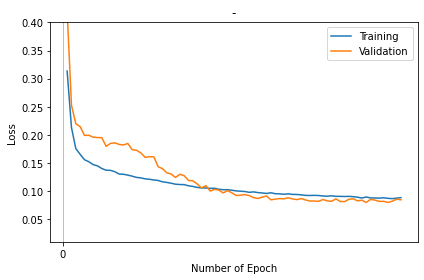

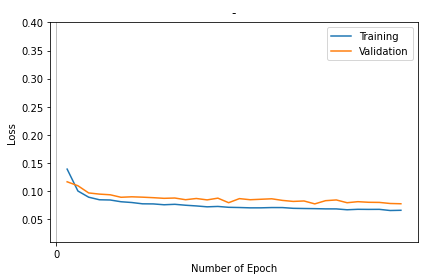

In [5]:
# >> aa-training_weighted_balanced_mae-binned-rif, Epoch: 300, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-09
Train_Loss=[0.3135467767715454, 0.21318913996219635, 0.17566454410552979, 0.1655014604330063, 0.15591229498386383, 0.15236796438694, 0.14718179404735565, 0.1450158953666687, 0.1402801126241684, 0.13723532855510712, 0.13702057301998138, 0.13458290696144104, 0.13041922450065613, 0.13002179563045502, 0.1285332590341568, 0.1266692876815796, 0.12446589022874832, 0.12362468987703323, 0.12189841270446777, 0.12114331871271133, 0.11989957094192505, 0.118998222053051, 0.11663150042295456, 0.1155286654829979, 0.114126056432724, 0.11238525062799454, 0.11181218177080154, 0.1116425022482872, 0.10952433198690414, 0.10845696181058884, 0.10671556740999222, 0.10570597648620605, 0.10574007034301758, 0.10496064275503159, 0.10516417771577835, 0.10343243926763535, 0.10256491601467133, 0.1026148572564125, 0.10167091339826584, 0.1004878357052803, 0.09995352476835251, 0.09940142184495926, 0.09794998914003372, 0.09869951754808426, 0.09751180559396744, 0.09676224738359451, 0.09597650915384293, 0.09710647910833359, 0.09555072337388992, 0.09525066614151001, 0.09451854974031448, 0.0952187031507492, 0.09428591281175613, 0.09408720582723618, 0.09346156567335129, 0.09248790144920349, 0.09233783930540085, 0.09254315495491028, 0.09230467677116394, 0.09143232554197311, 0.09104815125465393, 0.091740183532238, 0.09080871939659119, 0.09077206254005432, 0.09051293879747391, 0.09080680459737778, 0.09019917994737625, 0.08925244212150574, 0.08784384280443192, 0.08961528539657593, 0.08797220140695572, 0.08789687603712082, 0.08760246634483337, 0.08827998489141464, 0.08726537227630615, 0.08674540370702744, 0.08765807747840881, 0.08845668286085129]
Test_Loss=[0.4201146960258484, 0.2526671886444092, 0.21987542510032654, 0.21477937698364258, 0.1990911364555359, 0.19941985607147217, 0.19604063034057617, 0.19529223442077637, 0.1950671672821045, 0.1796768605709076, 0.18491783738136292, 0.18585562705993652, 0.18306422233581543, 0.18216851353645325, 0.18480800092220306, 0.17384310066699982, 0.1726558804512024, 0.16805532574653625, 0.1600632667541504, 0.16135439276695251, 0.16095931828022003, 0.14339375495910645, 0.140062153339386, 0.13261063396930695, 0.13037420809268951, 0.12438184022903442, 0.13003754615783691, 0.12751269340515137, 0.11908115446567535, 0.11840423941612244, 0.11287649720907211, 0.105727918446064, 0.10983838140964508, 0.1002424955368042, 0.10316452383995056, 0.10182195901870728, 0.09686428308486938, 0.10093843936920166, 0.09710223227739334, 0.0922769159078598, 0.0928695946931839, 0.09387339651584625, 0.0921841412782669, 0.08861596882343292, 0.08698347210884094, 0.08942946791648865, 0.09139993041753769, 0.08462101221084595, 0.08585500717163086, 0.08685406297445297, 0.08631016314029694, 0.08826089650392532, 0.08624596893787384, 0.08499731123447418, 0.08677076548337936, 0.0843493640422821, 0.0824902355670929, 0.08247554302215576, 0.08199448883533478, 0.0850825235247612, 0.08283472061157227, 0.08189935982227325, 0.08636444807052612, 0.08160551637411118, 0.08144111931324005, 0.08564987778663635, 0.08637891709804535, 0.08278173953294754, 0.08402762562036514, 0.07988123595714569, 0.08551771193742752, 0.08409848064184189, 0.08185600489377975, 0.0819455236196518, 0.07992550730705261, 0.08210640400648117, 0.08581149578094482, 0.08465949445962906]
lossGraph(Train_Loss, Test_Loss)

# >> aa-training_weighted_balanced_mae-binned-rif, Epoch: 300, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-09
Train_Loss=[0.13920888304710388, 0.1002935990691185, 0.08929163962602615, 0.08471895009279251, 0.08431486040353775, 0.08121529966592789, 0.0798383429646492, 0.07752904295921326, 0.0773407518863678, 0.0758468508720398, 0.07664728164672852, 0.07499697059392929, 0.07375621050596237, 0.07216472923755646, 0.0728510245680809, 0.0713268294930458, 0.07093237340450287, 0.07036259770393372, 0.0703812837600708, 0.07087017595767975, 0.07082484662532806, 0.06950706243515015, 0.06917182356119156, 0.0689321756362915, 0.06852959841489792, 0.06847859919071198, 0.06692954152822495, 0.06777072697877884, 0.06760111451148987, 0.06768504530191422, 0.06561575084924698, 0.0660112127661705]
Test_Loss=[0.11667139828205109, 0.10966002941131592, 0.09686148911714554, 0.09476304054260254, 0.0935816764831543, 0.08915545046329498, 0.08997780084609985, 0.0893266499042511, 0.08841893076896667, 0.08727270364761353, 0.08781387656927109, 0.08481040596961975, 0.08698176592588425, 0.084488146007061, 0.08758033812046051, 0.07950761169195175, 0.08676336705684662, 0.08478240668773651, 0.08561332523822784, 0.0864526778459549, 0.08357253670692444, 0.08178190886974335, 0.08257125318050385, 0.07739102095365524, 0.0830930769443512, 0.0843881368637085, 0.07945610582828522, 0.08131855726242065, 0.08024302124977112, 0.08001745492219925, 0.07810356467962265, 0.07761473953723907]
lossGraph(Train_Loss, Test_Loss)

/tmp/ipykernel_49443/1954264931.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


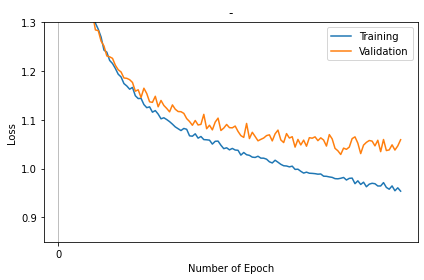

In [103]:
# >> 64-2-256-2-128-log-reg, Epoch: 120, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-09
Train_Loss=[5.619394302368164, 3.666234016418457, 2.590270757675171, 2.038069725036621, 1.7620339393615723, 1.6001406908035278, 1.4941595792770386, 1.4502618312835693, 1.4099153280258179, 1.3663263320922852, 1.342736840248108, 1.3257402181625366, 1.2984485626220703, 1.2860000133514404, 1.269742727279663, 1.2432284355163574, 1.238993763923645, 1.2219635248184204, 1.215623140335083, 1.205513834953308, 1.1937109231948853, 1.1881120204925537, 1.1745686531066895, 1.1696586608886719, 1.1629908084869385, 1.1666339635849, 1.1495091915130615, 1.1437915563583374, 1.1442410945892334, 1.1315020322799683, 1.1251294612884521, 1.1267175674438477, 1.115860939025879, 1.1191432476043701, 1.1119699478149414, 1.1022565364837646, 1.1043919324874878, 1.1007249355316162, 1.0964728593826294, 1.0913171768188477, 1.0856789350509644, 1.081893801689148, 1.0781850814819336, 1.082499384880066, 1.0807706117630005, 1.0673589706420898, 1.066552996635437, 1.0714751482009888, 1.0625786781311035, 1.0659834146499634, 1.059614658355713, 1.059212327003479, 1.0584672689437866, 1.0503965616226196, 1.0561349391937256, 1.0565389394760132, 1.0480540990829468, 1.0410585403442383, 1.0428447723388672, 1.0385841131210327, 1.041526198387146, 1.0382566452026367, 1.0377055406570435, 1.0278035402297974, 1.0331693887710571, 1.0285831689834595, 1.0272996425628662, 1.0236272811889648, 1.0230166912078857, 1.0254921913146973, 1.0215795040130615, 1.0215115547180176, 1.0194507837295532, 1.014080286026001, 1.0117138624191284, 1.0172761678695679, 1.0132019519805908, 1.0089010000228882, 1.0059722661972046, 1.0054905414581299, 1.0036861896514893, 1.0051273107528687, 0.9985096454620361, 0.9989092946052551, 0.9945963621139526, 0.9909297823905945, 0.992844820022583, 0.9906413555145264, 0.9903262257575989, 0.9897487163543701, 0.9886987805366516, 0.9891151785850525, 0.9845765829086304, 0.9843125939369202, 0.9830780029296875, 0.9821291565895081, 0.9795401692390442, 0.9791845083236694, 0.9802756309509277, 0.9819731712341309, 0.9767306447029114, 0.9801254272460938, 0.9806635975837708, 0.9692252278327942, 0.9750902056694031, 0.967606782913208, 0.9722434878349304, 0.9629318714141846, 0.9682348370552063, 0.9700229167938232, 0.9691148400306702, 0.9644930958747864, 0.9644769430160522, 0.9713868498802185, 0.9615397453308105, 0.9578710794448853, 0.964616060256958, 0.954691469669342, 0.9607186913490295, 0.9538747072219849]
Test_Loss=[4.49040412902832, 3.0328683853149414, 2.276716947555542, 1.8864856958389282, 1.6732147932052612, 1.545632243156433, 1.493338704109192, 1.4103084802627563, 1.4100821018218994, 1.3807084560394287, 1.3253371715545654, 1.31773042678833, 1.2846417427062988, 1.2831143140792847, 1.2615524530410767, 1.2516313791275024, 1.2311745882034302, 1.2294150590896606, 1.2262513637542725, 1.21204674243927, 1.2028851509094238, 1.1982465982437134, 1.1859898567199707, 1.1853058338165283, 1.182509183883667, 1.17681884765625, 1.1589148044586182, 1.1618003845214844, 1.1459169387817383, 1.1649831533432007, 1.1540758609771729, 1.1370625495910645, 1.1360329389572144, 1.1484805345535278, 1.126937985420227, 1.1398853063583374, 1.1296428442001343, 1.123549461364746, 1.1165659427642822, 1.130771279335022, 1.1218812465667725, 1.117201328277588, 1.1168514490127563, 1.1134052276611328, 1.1026760339736938, 1.0967316627502441, 1.0890049934387207, 1.0988292694091797, 1.0896176099777222, 1.0908911228179932, 1.1113836765289307, 1.0819226503372192, 1.0890929698944092, 1.0795938968658447, 1.0955935716629028, 1.1036688089370728, 1.0782982110977173, 1.0832650661468506, 1.0906579494476318, 1.084115743637085, 1.0837349891662598, 1.0874220132827759, 1.076382040977478, 1.0677598714828491, 1.064175009727478, 1.0927388668060303, 1.0617824792861938, 1.0746492147445679, 1.0659375190734863, 1.0571318864822388, 1.0601239204406738, 1.0628738403320312, 1.0678282976150513, 1.0694105625152588, 1.056960940361023, 1.0714905261993408, 1.079105019569397, 1.0589699745178223, 1.053519368171692, 1.071922779083252, 1.0628362894058228, 1.0655380487442017, 1.0442198514938354, 1.059990406036377, 1.0486329793930054, 1.0585274696350098, 1.0460368394851685, 1.0635288953781128, 1.0624558925628662, 1.0652813911437988, 1.0574671030044556, 1.0632290840148926, 1.0586919784545898, 1.046364188194275, 1.0698751211166382, 1.0610712766647339, 1.041689395904541, 1.0367093086242676, 1.0290931463241577, 1.0421291589736938, 1.0396336317062378, 1.044281005859375, 1.0616127252578735, 1.0652406215667725, 1.052294373512268, 1.0309149026870728, 1.0482823848724365, 1.0539608001708984, 1.057758092880249, 1.056559443473816, 1.0467543601989746, 1.0582760572433472, 1.0349006652832031, 1.059829592704773, 1.037151575088501, 1.0385098457336426, 1.0489205121994019, 1.0381370782852173, 1.0466573238372803, 1.0593701601028442]
lossGraph(Train_Loss, Test_Loss)

In [123]:
import torch
print(torch.__version__)
print(torch.version.cuda)


1.12.1
11.3


/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


test_loss_min: 0.9017954619766946 test_loss_min_epoch: 78
test_loss_min: 0.9534458823538688 test_loss_min_epoch: 77
test_loss_min: 0.9274432750087188 test_loss_min_epoch: 72
test_loss_min: 0.9570164386493027 test_loss_min_epoch: 79


/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


test_loss_min: 1.1095303299745296 test_loss_min_epoch: 79
test_loss_min: 0.9764676548035301 test_loss_min_epoch: 79
test_loss_min: 1.13208478415814 test_loss_min_epoch: 73
test_loss_min: 1.084482299874836 test_loss_min_epoch: 77
test_loss_min: 1.150659541299752 test_loss_min_epoch: 79
test_loss_min: 1.2518124890568367 test_loss_min_epoch: 79
test_loss_min: 1.2395877270712152 test_loss_min_epoch: 79


/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


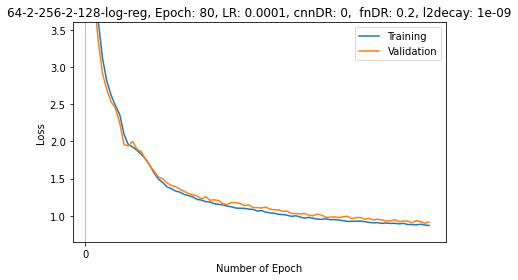

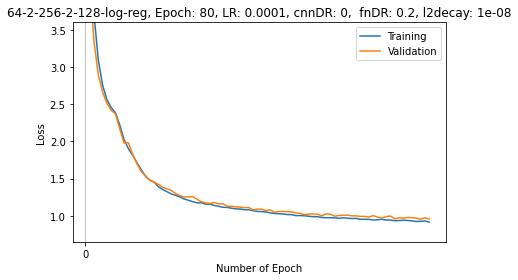

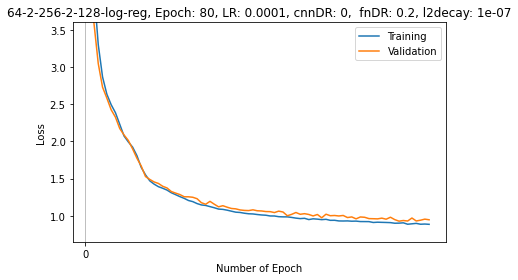

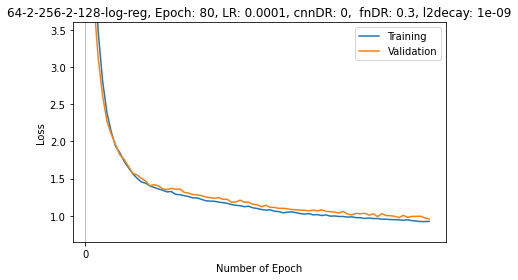

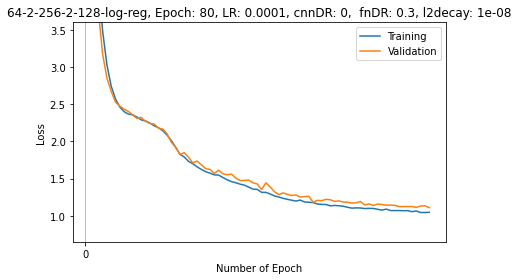

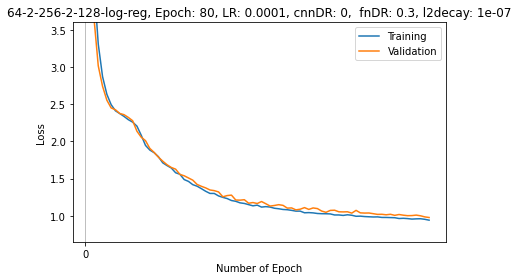

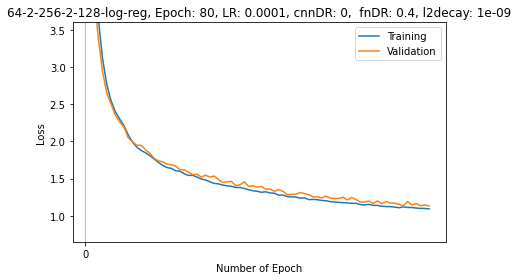

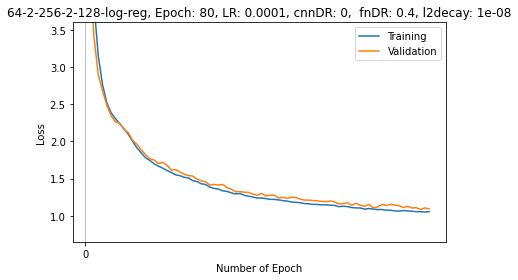

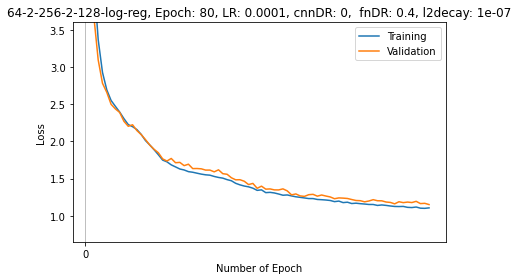

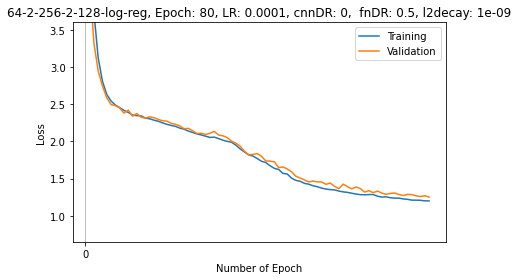

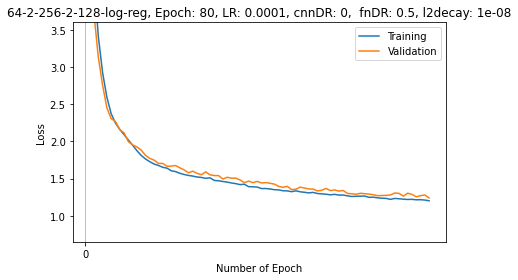

In [152]:
appendix = '64-2-256-2-128-log-reg, Epoch: 80, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-09'
Train_Loss=[5.876010417938232, 4.4222588539123535, 3.6164400577545166, 3.1140174865722656, 2.8080334663391113, 2.6188573837280273, 2.481287956237793, 2.359757900238037, 2.0956881046295166, 1.9554768800735474, 1.9253504276275635, 1.8804749250411987, 1.8283265829086304, 1.764502763748169, 1.676391839981079, 1.5749198198318481, 1.4926362037658691, 1.4474364519119263, 1.3890212774276733, 1.3643501996994019, 1.3318315744400024, 1.3178354501724243, 1.2864619493484497, 1.2712123394012451, 1.253995656967163, 1.2203634977340698, 1.2108479738235474, 1.1902488470077515, 1.186013102531433, 1.162514567375183, 1.1534944772720337, 1.1463139057159424, 1.1287405490875244, 1.1212304830551147, 1.1032685041427612, 1.1007959842681885, 1.100022792816162, 1.089808702468872, 1.0852605104446411, 1.064048409461975, 1.0686020851135254, 1.0486088991165161, 1.0396034717559814, 1.0337504148483276, 1.0180305242538452, 1.0158623456954956, 1.0070079565048218, 0.9920884370803833, 0.999976634979248, 0.9832260608673096, 0.9681604504585266, 0.9790855646133423, 0.965579628944397, 0.9551400542259216, 0.9524734020233154, 0.9594318270683289, 0.9471340179443359, 0.948807954788208, 0.9423741102218628, 0.9336795806884766, 0.9242296814918518, 0.9256924986839294, 0.9265108704566956, 0.9283020496368408, 0.920973539352417, 0.9107925891876221, 0.9051705598831177, 0.9076231122016907, 0.8976325392723083, 0.902752161026001, 0.8967850208282471, 0.8987089991569519, 0.8909511566162109, 0.8983148336410522, 0.88222336769104, 0.8821119070053101, 0.8769770860671997, 0.8860831260681152, 0.8751248717308044, 0.8694249987602234]
Test_Loss=[4.980190089882913, 3.9614475128130415, 3.3461085781195927, 2.910315665101313, 2.6924572918629925, 2.530097534101032, 2.4488916711534556, 2.2440236764394514, 1.9563394269252452, 1.9394442666670473, 1.9997336821510419, 1.8964430298788941, 1.8629432361506069, 1.7570281690697522, 1.6755833068181583, 1.5999003051656433, 1.5204732353514834, 1.4974122877945073, 1.4426545677554143, 1.4075052738780613, 1.3926767070863293, 1.357993601240651, 1.3284624192543204, 1.2997474648849914, 1.2831491791232867, 1.2680281737760895, 1.2251723590098367, 1.2554759131495197, 1.2100235076917039, 1.213759343753682, 1.2058243935370518, 1.160560452466369, 1.1522550104779934, 1.1782255271851458, 1.1751066654880837, 1.1650441920649899, 1.1377025756467811, 1.1465998166518556, 1.1102487652658675, 1.1088177150950398, 1.104638140590501, 1.1168350229133746, 1.0882831036606526, 1.0804104691268224, 1.0804831275079796, 1.0579854476038386, 1.0630062145228547, 1.0290171086265145, 1.031330064429991, 1.0240060311361632, 1.030919806803057, 1.007921201926754, 1.0005539953552918, 1.021204521575441, 1.0085529183310058, 0.9779829003679774, 0.9812239976019391, 0.9849233433509903, 0.9769550762700501, 0.9861522426619722, 0.9939107043719855, 0.9609853575036027, 0.9755584081356873, 0.9776711433356793, 0.9531092812397767, 0.9650229246737603, 0.9436717216980742, 0.9540703967144759, 0.9452295545190692, 0.9290492516154497, 0.9319172924570162, 0.9470697075343134, 0.9193361745147247, 0.9299416203972779, 0.9284578746586014, 0.9063980174341044, 0.9346440983900248, 0.9202086064112072, 0.9017954619766946, 0.9161142829963533]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 80, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-08'
Train_Loss=[4.888727188110352, 3.7059261798858643, 3.0921342372894287, 2.7560136318206787, 2.562194347381592, 2.454164743423462, 2.3838398456573486, 2.2192978858947754, 2.0235650539398193, 1.9029167890548706, 1.8127198219299316, 1.7113862037658691, 1.6190564632415771, 1.5296355485916138, 1.4785900115966797, 1.4529858827590942, 1.388770580291748, 1.3523030281066895, 1.3230060338974, 1.2934015989303589, 1.274963617324829, 1.2531383037567139, 1.2250494956970215, 1.2080739736557007, 1.1880977153778076, 1.173890233039856, 1.1747479438781738, 1.1556124687194824, 1.1560046672821045, 1.138506531715393, 1.1269798278808594, 1.113987922668457, 1.1122715473175049, 1.1017100811004639, 1.0931756496429443, 1.0900951623916626, 1.0818703174591064, 1.081201434135437, 1.0679658651351929, 1.0582151412963867, 1.0560985803604126, 1.0509978532791138, 1.0392019748687744, 1.0312042236328125, 1.0276427268981934, 1.0245187282562256, 1.0162354707717896, 1.0156526565551758, 1.002174735069275, 1.0030394792556763, 1.0003374814987183, 0.9930564761161804, 0.9875573515892029, 0.9876924753189087, 0.9770024418830872, 0.9741254448890686, 0.9737444519996643, 0.9720281362533569, 0.9667655825614929, 0.9723342061042786, 0.9675818085670471, 0.9626243114471436, 0.9648640751838684, 0.9525055289268494, 0.9521345496177673, 0.9515097737312317, 0.943131685256958, 0.9460725784301758, 0.9526328444480896, 0.9423506855964661, 0.9425621628761292, 0.9334800243377686, 0.9364961981773376, 0.9392406940460205, 0.9372871518135071, 0.9318141341209412, 0.9222657680511475, 0.9255836606025696, 0.9305647611618042, 0.9154708385467529]
Test_Loss=[4.165035739199981, 3.3420552854745837, 2.8937403765386636, 2.6642677232590875, 2.5108346477141024, 2.4201829549278124, 2.367715751743414, 2.1671912200767456, 1.977316281418979, 1.9819320456657807, 1.8243665855107427, 1.6981105412499256, 1.595736281654507, 1.537375043404418, 1.4765011022281176, 1.4529117534459528, 1.4211695681840395, 1.3820260551148453, 1.3615177273352244, 1.3407671377375545, 1.2995369652547957, 1.2722034866552456, 1.252140927182416, 1.2544728637253533, 1.2574491708496842, 1.2224237165014176, 1.1874362854749025, 1.1740982358035839, 1.1648134054666313, 1.1785225513011894, 1.1605493196811152, 1.1613719604999064, 1.1283927063472141, 1.128061254506767, 1.1201583802503015, 1.115818596448324, 1.1091398780579973, 1.1117816104765916, 1.078960610807036, 1.087280053462575, 1.0881428414575158, 1.0708943008816305, 1.0793621943490166, 1.047284423272796, 1.057586849528785, 1.0585300462310123, 1.0549643492558725, 1.0514100841009255, 1.0374361159904217, 1.0321578205287347, 1.01381311666194, 1.023445341750726, 1.0238040512088706, 1.0210216086394217, 1.0002984099000891, 1.0257481403777287, 1.021313527226875, 0.9941312321269987, 1.0034297989577472, 1.0067397744601858, 1.0085349194418505, 0.9991973708348914, 0.998390215390907, 0.991455740293695, 0.9913701351639584, 0.9830701999357104, 1.002431381001275, 0.9807826253599263, 0.9705531214379574, 0.9887233875767628, 0.9972112854273325, 0.9580481110715691, 0.9739083119231936, 0.968199887649474, 0.9775404817665146, 0.9744314933627507, 0.9681657875989784, 0.9534458823538688, 0.9743122875374643, 0.9565039862144794]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 80, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-07'
Train_Loss=[5.465356826782227, 4.045893669128418, 3.3009307384490967, 2.866823673248291, 2.6345317363739014, 2.49381685256958, 2.385878086090088, 2.2297351360321045, 2.072784662246704, 1.992785930633545, 1.9227821826934814, 1.8087619543075562, 1.6501151323318481, 1.5498888492584229, 1.4691892862319946, 1.4254742860794067, 1.391059160232544, 1.3699814081192017, 1.345402717590332, 1.309390902519226, 1.2839457988739014, 1.2574660778045654, 1.2341885566711426, 1.205246925354004, 1.190102458000183, 1.1638758182525635, 1.1455150842666626, 1.1387877464294434, 1.123250961303711, 1.1078875064849854, 1.0899556875228882, 1.0859788656234741, 1.0750946998596191, 1.0615129470825195, 1.0483394861221313, 1.0444726943969727, 1.034273386001587, 1.0268350839614868, 1.0244066715240479, 1.0167430639266968, 1.0107712745666504, 1.0072999000549316, 0.9974654316902161, 0.9970502853393555, 0.9876082539558411, 0.9852936863899231, 0.9853181838989258, 0.9778451323509216, 0.9684160947799683, 0.961905837059021, 0.965967059135437, 0.9487245082855225, 0.9590815901756287, 0.9546655416488647, 0.9477851986885071, 0.9523577094078064, 0.9386625289916992, 0.9393056631088257, 0.9303745627403259, 0.9295799136161804, 0.9308711290359497, 0.9268850088119507, 0.9282543659210205, 0.9222168326377869, 0.921851396560669, 0.921314001083374, 0.9098694920539856, 0.9134345054626465, 0.9115254878997803, 0.9099057912826538, 0.9078226685523987, 0.8996976613998413, 0.9008594751358032, 0.9052022695541382, 0.8862101435661316, 0.8917945623397827, 0.8977363705635071, 0.8862734436988831, 0.8887932300567627, 0.8850691318511963]
Test_Loss=[4.578515361045385, 3.5896611783005548, 3.046315316427165, 2.7286407245960715, 2.5820085537072366, 2.4257086035561675, 2.3258586905035354, 2.1728898265508274, 2.086840454871447, 2.012544127886263, 1.8985945098001815, 1.7734300866021986, 1.6686442988021584, 1.527070797109, 1.4883874158525594, 1.4547711990980592, 1.4347162428421714, 1.3965276340322743, 1.3740979078006585, 1.3258829026335592, 1.3046631059914182, 1.2853358733683171, 1.2554798609271067, 1.2549450831310986, 1.248719485559977, 1.229263998851595, 1.1757214452278142, 1.1549301506620477, 1.1937861949052182, 1.1556738744826625, 1.1201963801117416, 1.1351928481643994, 1.115239986804447, 1.0980247456292682, 1.0930181743398644, 1.0784559592125111, 1.0722655272187451, 1.069819353193869, 1.0799951437194835, 1.0672562649634698, 1.0645748484442974, 1.0567322264858445, 1.0555568533274566, 1.042978425461851, 1.0623765787057455, 1.0504334932034693, 1.0004352194163917, 1.018844786473569, 1.0439966273246657, 1.0199801262718071, 1.028188117173535, 1.0176100353344892, 0.9977446869373886, 1.0172444240632101, 0.9727506554837966, 1.021064679554076, 1.000726810428739, 1.0037365218166037, 0.997201695659701, 1.004097900944317, 0.9761804467483564, 0.9842763518067671, 0.9586319302413252, 0.9838477322327822, 0.9795430299068801, 0.9619271152964316, 0.9603354235639321, 0.9583608713324077, 0.9679978055924449, 0.9538809365092026, 0.980360837719486, 0.9482958605917091, 0.9274432750087188, 0.936179343042758, 0.9294168699514306, 0.9697537616597707, 0.9301681938725745, 0.9403504560280673, 0.9547904431908153, 0.9461288968327501]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 80, LR: 0.0001, cnnDR: 0,  fnDR: 0.3, l2decay: 1e-09'
Train_Loss=[5.918237686157227, 4.4630208015441895, 3.4644806385040283, 2.8158445358276367, 2.39172101020813, 2.1336145401000977, 1.9376890659332275, 1.8504301309585571, 1.7345337867736816, 1.6485005617141724, 1.567023754119873, 1.5066989660263062, 1.4560182094573975, 1.4380451440811157, 1.4027186632156372, 1.3805029392242432, 1.3613582849502563, 1.342329978942871, 1.321629524230957, 1.3256992101669312, 1.2875754833221436, 1.2835438251495361, 1.2702528238296509, 1.2580686807632446, 1.2409210205078125, 1.2401602268218994, 1.2212655544281006, 1.202516794204712, 1.1969200372695923, 1.1953603029251099, 1.1838628053665161, 1.176194667816162, 1.1674559116363525, 1.1510874032974243, 1.141601324081421, 1.1353940963745117, 1.122251272201538, 1.1275303363800049, 1.106436848640442, 1.0981247425079346, 1.0842047929763794, 1.0761927366256714, 1.0797239542007446, 1.0614069700241089, 1.0562124252319336, 1.0390204191207886, 1.048809289932251, 1.0521788597106934, 1.0420341491699219, 1.0289510488510132, 1.021966576576233, 1.0302150249481201, 1.0122135877609253, 1.0157124996185303, 1.0029023885726929, 1.0125776529312134, 0.995028018951416, 0.9974727034568787, 0.9905030727386475, 0.9904605746269226, 0.9814766049385071, 0.9856200814247131, 0.9749140739440918, 0.9737846851348877, 0.9637370109558105, 0.9704098105430603, 0.9626837372779846, 0.963255763053894, 0.9534369111061096, 0.9537633061408997, 0.9485056400299072, 0.9477269649505615, 0.945809006690979, 0.9400109648704529, 0.9448000192642212, 0.9350700974464417, 0.9284465909004211, 0.9222588539123535, 0.9222134947776794, 0.9244180917739868]
Test_Loss=[4.985799680185269, 3.860718530777364, 3.1098140141512607, 2.61919362310102, 2.2737923031334293, 2.1006184305768705, 1.95928595297118, 1.8215513111320458, 1.7584464083366953, 1.6670868806889505, 1.5715234720611149, 1.549272857520924, 1.5050521588339472, 1.467176698134365, 1.4029084855677372, 1.4191317145913502, 1.401634436167374, 1.3621417709908983, 1.3522147201598216, 1.3681928213041052, 1.3570249359744593, 1.3588095826926327, 1.315064249597497, 1.3049878582806005, 1.2839657359177623, 1.2825145328762373, 1.2713977791914948, 1.2516740978186727, 1.2448174430061472, 1.234627292737757, 1.2453826494485938, 1.2207651538919506, 1.2214429785675658, 1.18251023141608, 1.186055186358218, 1.2099109642855574, 1.1821197993992574, 1.1815889192394728, 1.1540620756050086, 1.1480977732929454, 1.1201283805091908, 1.1414302743038962, 1.113324598201347, 1.1121650318690917, 1.1000115033552187, 1.1007017474550802, 1.0933695326485768, 1.083116541836775, 1.0814610710438226, 1.0759616135200747, 1.0739868806336994, 1.0661866587709308, 1.0778489061484229, 1.0631886358152838, 1.0813731526849435, 1.0590701808185095, 1.0556970291595236, 1.050019569058284, 1.0365483811603, 1.0579158258020611, 1.0237538652497078, 1.010184646313502, 1.032961889349601, 1.024778429049803, 1.0346328180037827, 1.0089798269289418, 1.0271316816722584, 0.9894295955004421, 1.028833556227379, 1.002560441658127, 1.0003114933989623, 0.9925091807349484, 0.9749406379087864, 1.005853946936778, 0.9782901920840594, 0.9924004132722865, 0.9916992435232923, 0.994562686363671, 0.9718372556207006, 0.9570164386493027]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 80, LR: 0.0001, cnnDR: 0,  fnDR: 0.3, l2decay: 1e-08'
Train_Loss=[7.208978176116943, 5.3148064613342285, 4.184205532073975, 3.4853708744049072, 3.029749870300293, 2.7428719997406006, 2.5710089206695557, 2.462655544281006, 2.3994028568267822, 2.367015838623047, 2.3574132919311523, 2.327228307723999, 2.2889914512634277, 2.2754158973693848, 2.247459888458252, 2.209704637527466, 2.183346748352051, 2.1437153816223145, 2.0854523181915283, 2.010802745819092, 1.9211905002593994, 1.8262099027633667, 1.7897065877914429, 1.7314732074737549, 1.699263572692871, 1.6574305295944214, 1.6228032112121582, 1.5932332277297974, 1.572878122329712, 1.549796462059021, 1.5471011400222778, 1.514790415763855, 1.482944369316101, 1.4594764709472656, 1.4440038204193115, 1.4256314039230347, 1.41118586063385, 1.385340929031372, 1.3584556579589844, 1.3544195890426636, 1.314824104309082, 1.314709186553955, 1.2926322221755981, 1.2666195631027222, 1.252018690109253, 1.235008955001831, 1.2205784320831299, 1.2096408605575562, 1.1975096464157104, 1.211057186126709, 1.1856602430343628, 1.181968331336975, 1.177146077156067, 1.1579467058181763, 1.152585744857788, 1.1509835720062256, 1.1333447694778442, 1.138906478881836, 1.1342028379440308, 1.1280856132507324, 1.1142042875289917, 1.1026898622512817, 1.106064796447754, 1.1049689054489136, 1.0968403816223145, 1.0996036529541016, 1.0981383323669434, 1.08708918094635, 1.0759913921356201, 1.0892163515090942, 1.0708699226379395, 1.069413185119629, 1.0703465938568115, 1.06804358959198, 1.0688508749008179, 1.05515718460083, 1.0643283128738403, 1.0437109470367432, 1.0436989068984985, 1.0466011762619019]
Test_Loss=[6.051892633682349, 4.606375382184461, 3.7663524150606267, 3.1755326606866188, 2.8521957009210546, 2.675005807771322, 2.527302461213343, 2.47581319621987, 2.432804891293036, 2.4035246090632407, 2.3551672223515956, 2.3097330875876088, 2.3223814266525045, 2.2687494494410805, 2.2414578987310585, 2.2341393201976585, 2.177536972253635, 2.1653770661140066, 2.101022735147535, 1.9878093467474791, 1.9208453332905588, 1.8259821792009046, 1.8481694294791735, 1.7855044649326879, 1.7120962119202314, 1.735518427065649, 1.685143837719766, 1.6330005505509897, 1.6234035837044083, 1.5687555588183208, 1.6128130402214271, 1.5640413467315408, 1.550967558334176, 1.5595748190531307, 1.5067129899782963, 1.4733819760325195, 1.4746869148520256, 1.4800881285660927, 1.4435262083475138, 1.4272317665780043, 1.352312054430474, 1.4427451543655112, 1.3867363898151333, 1.3236784687522027, 1.28443590340769, 1.3067260480649239, 1.2881661193353102, 1.2734060761869106, 1.2797554175853265, 1.2518725902055095, 1.2575340964460875, 1.261498159144493, 1.1816964366415383, 1.207560632077814, 1.2031951625366277, 1.2219095753704323, 1.2151610806521047, 1.1931961921872412, 1.2001983116994392, 1.1834770362972955, 1.1831488062236135, 1.170641529857317, 1.1741399886530521, 1.1915591701780397, 1.145466776813301, 1.1590199749519807, 1.1379090523687532, 1.1574942186765256, 1.1514752036061646, 1.1427779952340231, 1.142929400375231, 1.1403998797601107, 1.1236870463688469, 1.1229707507989024, 1.124031988924657, 1.1237906238605624, 1.1129540775974134, 1.1315277536796509, 1.1343882347695333, 1.1095303299745296]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 80, LR: 0.0001, cnnDR: 0,  fnDR: 0.3, l2decay: 1e-07'
Train_Loss=[5.631253242492676, 4.13519287109375, 3.309257984161377, 2.8715293407440186, 2.633974552154541, 2.493941307067871, 2.411457061767578, 2.3744022846221924, 2.3356611728668213, 2.292001724243164, 2.259145975112915, 2.2055342197418213, 2.0826845169067383, 1.9454946517944336, 1.8836733102798462, 1.8482868671417236, 1.7940670251846313, 1.7125860452651978, 1.6749207973480225, 1.6421276330947876, 1.5787466764450073, 1.5578676462173462, 1.4868273735046387, 1.4619319438934326, 1.4182387590408325, 1.3976213932037354, 1.3646880388259888, 1.3294111490249634, 1.3004913330078125, 1.3001407384872437, 1.2666887044906616, 1.2472490072250366, 1.231380820274353, 1.2050724029541016, 1.1944984197616577, 1.1737066507339478, 1.1655629873275757, 1.1496446132659912, 1.1337031126022339, 1.1428446769714355, 1.1166584491729736, 1.1227749586105347, 1.116978645324707, 1.101176381111145, 1.0942226648330688, 1.0846977233886719, 1.0812548398971558, 1.0726605653762817, 1.0622919797897339, 1.0623739957809448, 1.0402013063430786, 1.0424796342849731, 1.0387898683547974, 1.030664086341858, 1.0277563333511353, 1.0269783735275269, 1.0248886346817017, 1.0107067823410034, 1.0108715295791626, 1.0047032833099365, 1.0132642984390259, 1.0068937540054321, 0.9931984543800354, 0.9948924779891968, 0.9894165396690369, 0.9864409565925598, 0.9836500883102417, 0.9848741888999939, 0.9777064919471741, 0.9774889349937439, 0.9755613803863525, 0.9738260507583618, 0.9632043242454529, 0.9658847451210022, 0.9619568586349487, 0.9553611278533936, 0.9585821032524109, 0.9600623846054077, 0.9523158669471741, 0.9407945275306702]
Test_Loss=[4.665687086989668, 3.6611088135763272, 3.016154405381923, 2.7411163261100313, 2.5543509578912666, 2.4499863384595195, 2.4253401945287156, 2.3754365738994254, 2.359289179212729, 2.322338133181032, 2.2783740796062397, 2.136747064411666, 2.0561918313426455, 2.0098906365487386, 1.90567820292153, 1.852130107858585, 1.7874739417988545, 1.7346163624368014, 1.6863179558339705, 1.649317899410222, 1.6269564804030752, 1.556468392792155, 1.5374829263819125, 1.5084069654334926, 1.4787624414988871, 1.4212607291775112, 1.3961386959911783, 1.3748925671427825, 1.3467325935658876, 1.338025812549502, 1.3203660404681927, 1.2552530817031133, 1.2714776407498394, 1.2776993246569568, 1.211737920116433, 1.2099914959813367, 1.2159225020627125, 1.168724180895154, 1.1777148167043527, 1.1648183645083796, 1.191338001449403, 1.1617277893982172, 1.1304634921941832, 1.1384782454885398, 1.1492758976264177, 1.1399462109925456, 1.1030201094643735, 1.1055572900822075, 1.0793489385068995, 1.0883610016932275, 1.1098106860285006, 1.0855028747575632, 1.1052553473469935, 1.0966985985281967, 1.0630937600310355, 1.0465773957998956, 1.0721751882698094, 1.0748057843468528, 1.0533036000406382, 1.0519055067879486, 1.0536684266747738, 1.0356546508081395, 1.0725408896157291, 1.0390671391533384, 1.0362855320695066, 1.0373124537534302, 1.0279665941768148, 1.0186908836145088, 1.0198841646300367, 1.0132883492559748, 1.020018556971888, 1.0056691246252312, 1.0169251501233352, 1.0078302735038172, 1.0013398015821875, 1.0026490578936114, 1.0089026670153005, 0.9996892176071756, 0.9849211618829036, 0.9764676548035301]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 80, LR: 0.0001, cnnDR: 0,  fnDR: 0.4, l2decay: 1e-09'
Train_Loss=[5.983493804931641, 4.512066841125488, 3.667387008666992, 3.117565631866455, 2.7651872634887695, 2.5440595149993896, 2.4004504680633545, 2.2999064922332764, 2.2112488746643066, 2.0848801136016846, 1.989830493927002, 1.9223477840423584, 1.8769276142120361, 1.8475635051727295, 1.8096367120742798, 1.763277530670166, 1.7177542448043823, 1.6788012981414795, 1.6483298540115356, 1.6368094682693481, 1.6057242155075073, 1.6001023054122925, 1.5659550428390503, 1.542253017425537, 1.5440477132797241, 1.5200786590576172, 1.4939956665039062, 1.4812146425247192, 1.4566413164138794, 1.4352827072143555, 1.428816318511963, 1.4118461608886719, 1.4031524658203125, 1.3964122533798218, 1.3800644874572754, 1.3808752298355103, 1.3666200637817383, 1.3500252962112427, 1.3357280492782593, 1.3292304277420044, 1.3162031173706055, 1.3222941160202026, 1.3063557147979736, 1.3040226697921753, 1.2768338918685913, 1.2776867151260376, 1.2584145069122314, 1.2549974918365479, 1.2514917850494385, 1.2368301153182983, 1.2413697242736816, 1.2173705101013184, 1.2195799350738525, 1.2162108421325684, 1.2063343524932861, 1.2019693851470947, 1.1907497644424438, 1.1849828958511353, 1.1790728569030762, 1.1765469312667847, 1.17266845703125, 1.1668592691421509, 1.167797327041626, 1.1507197618484497, 1.1452059745788574, 1.1535040140151978, 1.139946699142456, 1.138840675354004, 1.1282310485839844, 1.1239639520645142, 1.1230028867721558, 1.116494059562683, 1.1078611612319946, 1.119336724281311, 1.1123034954071045, 1.1108148097991943, 1.1037812232971191, 1.0995861291885376, 1.0983525514602661, 1.0927001237869263]
Test_Loss=[5.046759222310682, 4.020758974020636, 3.3994504819057916, 2.9427192729469507, 2.648807633659655, 2.501941622979838, 2.3504447248758, 2.261242965846535, 2.193117982056333, 2.0465022592017883, 1.9941958072576562, 1.946963543865134, 1.9475454803386911, 1.888614373939509, 1.8414282839212097, 1.772139960506518, 1.7381238288040062, 1.7269486909994962, 1.6942372828845889, 1.6875350885105531, 1.670922044046479, 1.6188283678476951, 1.6200138805899942, 1.585295027986974, 1.5524007046366841, 1.5574570127333978, 1.5203729719872647, 1.5468004803548179, 1.5194603066617267, 1.5340456272367138, 1.4867105004080208, 1.4460426702649904, 1.4571767301848435, 1.4619938420619967, 1.4052134494242419, 1.4171626047072339, 1.456159589482909, 1.3945338826595466, 1.4022780865575497, 1.3871586259100486, 1.393405603022511, 1.3559050720961714, 1.360486164512135, 1.3280394933301642, 1.3522116255724053, 1.328494067669208, 1.2830428252852075, 1.2892368478093519, 1.2903981645032199, 1.3106222189383983, 1.2996785061792149, 1.2825682165204135, 1.2533877412975174, 1.2553300871341855, 1.2405385164926994, 1.2633166965541898, 1.2367759873865531, 1.2327833274406639, 1.2326165010109282, 1.2489530115274434, 1.2128598981106067, 1.245072461780287, 1.2202729847750255, 1.1831510966831986, 1.1869899249744544, 1.1972206380894204, 1.1653071320730686, 1.1994142805096109, 1.1629628324739048, 1.1913738870588468, 1.1714125355466978, 1.1682693423090924, 1.1553555232641286, 1.13208478415814, 1.189961524528992, 1.1460015100036318, 1.1646488503647252, 1.1354322791159606, 1.1460249089966543, 1.1321240736656544]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 80, LR: 0.0001, cnnDR: 0,  fnDR: 0.4, l2decay: 1e-08'
Train_Loss=[5.107466220855713, 3.853388786315918, 3.153672695159912, 2.7623355388641357, 2.5188586711883545, 2.3836004734039307, 2.3059678077697754, 2.236196279525757, 2.1687982082366943, 2.0952095985412598, 1.9992374181747437, 1.9137707948684692, 1.845682144165039, 1.7801541090011597, 1.7439638376235962, 1.6987875699996948, 1.6683343648910522, 1.6405333280563354, 1.6091398000717163, 1.581964373588562, 1.5505766868591309, 1.5393157005310059, 1.5167943239212036, 1.5084260702133179, 1.4723620414733887, 1.4595204591751099, 1.4300477504730225, 1.4200137853622437, 1.383713960647583, 1.3679956197738647, 1.3584223985671997, 1.3342410326004028, 1.3274405002593994, 1.307447910308838, 1.29331374168396, 1.2991828918457031, 1.274658203125, 1.2633683681488037, 1.251885175704956, 1.2377955913543701, 1.238769292831421, 1.2312142848968506, 1.2205241918563843, 1.2202826738357544, 1.2128028869628906, 1.2037218809127808, 1.1966907978057861, 1.1842033863067627, 1.1811217069625854, 1.1750963926315308, 1.1656086444854736, 1.1593424081802368, 1.1530705690383911, 1.1523587703704834, 1.146931529045105, 1.1469769477844238, 1.1413589715957642, 1.1393513679504395, 1.1219631433486938, 1.1286280155181885, 1.1233187913894653, 1.1103447675704956, 1.1059486865997314, 1.104337215423584, 1.0892870426177979, 1.097586750984192, 1.0906308889389038, 1.0830425024032593, 1.0840660333633423, 1.0751445293426514, 1.074623942375183, 1.0653530359268188, 1.0627686977386475, 1.069990634918213, 1.064924716949463, 1.061112880706787, 1.0551954507827759, 1.0550671815872192, 1.050541639328003, 1.0551137924194336]
Test_Loss=[4.29126349057727, 3.4063980634323845, 2.8971985929094726, 2.6794439247092647, 2.4860897469261984, 2.3452803852990356, 2.2611096777392063, 2.2464204683166016, 2.1605664748405684, 2.116820096546676, 2.010498514390453, 1.963193387990381, 1.8857304380131432, 1.8231292293888133, 1.765370570487588, 1.7502059679781705, 1.7028447862131177, 1.7183089674445675, 1.679331175890835, 1.6141967153294479, 1.6210192001006447, 1.5888311445500163, 1.5597149512933681, 1.5407008198298942, 1.5332834909812447, 1.4920179586603335, 1.4693764852997477, 1.4561820509121968, 1.4116120354070414, 1.422015919962462, 1.4132033679117186, 1.422397756432029, 1.3763604566858414, 1.3573736046061173, 1.3222747911800057, 1.3247355418620563, 1.3164006814860878, 1.3140581697045115, 1.2918551613387301, 1.2752620366056828, 1.3010438580115065, 1.2672323480639238, 1.2781188607449085, 1.2747197880602559, 1.2375720949714457, 1.250045890892079, 1.234221401752978, 1.2505526507292182, 1.2453527849433514, 1.2231136737282509, 1.2102735099813222, 1.2102112894581836, 1.204288918305229, 1.199772242457372, 1.1931761182542442, 1.19002421904581, 1.1985364506235727, 1.1856512177380512, 1.158747060759317, 1.1645000919446427, 1.1742439898027481, 1.1407591018183751, 1.1677240407754312, 1.139860522687576, 1.1290673276806942, 1.1518059484622811, 1.108326492326199, 1.1181571279853955, 1.152083201143677, 1.1380775318400818, 1.1542482578758366, 1.144245312658658, 1.1356076689957284, 1.1097764052348518, 1.1286206671947092, 1.1043373387940965, 1.1086526673734085, 1.084482299874836, 1.105050229243932, 1.093291375608747]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 80, LR: 0.0001, cnnDR: 0,  fnDR: 0.4, l2decay: 1e-07'
Train_Loss=[5.747494220733643, 4.170973777770996, 3.3680050373077393, 2.9276952743530273, 2.693253993988037, 2.550711154937744, 2.4715068340301514, 2.3945727348327637, 2.305280923843384, 2.2259676456451416, 2.19793963432312, 2.1591224670410156, 2.0944955348968506, 2.0115673542022705, 1.9523955583572388, 1.8886100053787231, 1.8208515644073486, 1.7485339641571045, 1.7251002788543701, 1.6844550371170044, 1.6569677591323853, 1.6289145946502686, 1.6157381534576416, 1.5933171510696411, 1.5852431058883667, 1.5723916292190552, 1.559922218322754, 1.5505820512771606, 1.5458630323410034, 1.52866530418396, 1.5152966976165771, 1.5059643983840942, 1.4859503507614136, 1.4707653522491455, 1.4362469911575317, 1.4155761003494263, 1.39967679977417, 1.3889362812042236, 1.3707727193832397, 1.3415125608444214, 1.3484126329421997, 1.311051368713379, 1.314758539199829, 1.3067935705184937, 1.2925182580947876, 1.2761458158493042, 1.2800424098968506, 1.2668675184249878, 1.2551984786987305, 1.2478139400482178, 1.2395867109298706, 1.231426477432251, 1.231241226196289, 1.2193005084991455, 1.2160634994506836, 1.2116988897323608, 1.2054997682571411, 1.1899932622909546, 1.1973239183425903, 1.1770548820495605, 1.18235445022583, 1.1646571159362793, 1.169193148612976, 1.1627153158187866, 1.1577786207199097, 1.1520066261291504, 1.1516729593276978, 1.1390496492385864, 1.145377516746521, 1.139481544494629, 1.1314729452133179, 1.1252527236938477, 1.1239947080612183, 1.1256968975067139, 1.1132575273513794, 1.1105021238327026, 1.1176893711090088, 1.1019281148910522, 1.0998984575271606, 1.1060630083084106]
Test_Loss=[4.7273440638740185, 3.6744421685566087, 3.095592018568632, 2.7812051534336972, 2.65947728006414, 2.498710542621306, 2.43680589142236, 2.389479635477509, 2.2689670506248247, 2.2031199193987727, 2.223583208622891, 2.145796109794705, 2.091933280058958, 2.024443422355955, 1.9513016785439738, 1.8937681313482093, 1.8474375180152622, 1.7649840849153906, 1.735912732208835, 1.7705263830990878, 1.7132432463799157, 1.717852997020213, 1.6741451354833845, 1.6932806438269605, 1.634357038072484, 1.6353307385746625, 1.6311636855225515, 1.6141736960265973, 1.6142479706815367, 1.5905788537169425, 1.617837009040023, 1.5656950691663718, 1.5580399484386278, 1.5108743014864987, 1.4835600746335347, 1.4847089797623112, 1.4640092211086968, 1.4195004291993178, 1.4349303422390183, 1.3694397688516224, 1.3981967345287059, 1.3579998852550623, 1.3608793492549478, 1.3480499310835052, 1.3474983799271998, 1.361696330496197, 1.3345299944303468, 1.2811651165565858, 1.2935313822962335, 1.2670805378298744, 1.2605761576777088, 1.283533629515944, 1.2880884356852316, 1.2638402560541167, 1.2792321564035343, 1.2652817503972726, 1.2530702664645725, 1.2291859213678995, 1.2402005014979975, 1.237136718555505, 1.2326591862574228, 1.2184427931622872, 1.205580681225613, 1.2027389344114192, 1.1873999640888848, 1.1985782246068994, 1.2163796341751267, 1.2020512075273089, 1.2008987697923146, 1.1847764130226228, 1.1794266161217204, 1.160399657201765, 1.1884970869708769, 1.176758343392571, 1.1840820925569981, 1.17776968333422, 1.1941051222734955, 1.1636682199411663, 1.1673618751821573, 1.150659541299752]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 80, LR: 0.0001, cnnDR: 0,  fnDR: 0.5, l2decay: 1e-09'
Train_Loss=[4.9662861824035645, 3.7380893230438232, 3.1223740577697754, 2.8071866035461426, 2.630341053009033, 2.5426747798919678, 2.4891529083251953, 2.4544262886047363, 2.4174821376800537, 2.3895392417907715, 2.3527116775512695, 2.3468000888824463, 2.3428807258605957, 2.313424587249756, 2.3036062717437744, 2.2851672172546387, 2.271178722381592, 2.2483675479888916, 2.2292497158050537, 2.2145211696624756, 2.2020814418792725, 2.178440570831299, 2.1633143424987793, 2.138977527618408, 2.1194510459899902, 2.0997297763824463, 2.0869200229644775, 2.07008695602417, 2.0533995628356934, 2.0573790073394775, 2.0384597778320312, 2.0168893337249756, 2.0005552768707275, 1.9890905618667603, 1.95166015625, 1.9011837244033813, 1.859621286392212, 1.819178819656372, 1.8033710718154907, 1.7700775861740112, 1.7328975200653076, 1.716223955154419, 1.6719350814819336, 1.6376750469207764, 1.621962547302246, 1.5695675611495972, 1.5614346265792847, 1.5058494806289673, 1.4761269092559814, 1.463472604751587, 1.436025619506836, 1.4242806434631348, 1.4036239385604858, 1.3904756307601929, 1.3717669248580933, 1.3590980768203735, 1.3519490957260132, 1.348030924797058, 1.332420825958252, 1.3210762739181519, 1.3145034313201904, 1.30319082736969, 1.2919126749038696, 1.2842458486557007, 1.2824333906173706, 1.2851167917251587, 1.2851684093475342, 1.2638086080551147, 1.2508565187454224, 1.2547403573989868, 1.2423981428146362, 1.2374879121780396, 1.2372052669525146, 1.2267749309539795, 1.220698595046997, 1.2102811336517334, 1.2096644639968872, 1.2082644701004028, 1.2003647089004517, 1.2000032663345337]
Test_Loss=[4.187046494003854, 3.323962091917945, 2.9456730883155817, 2.743346203503529, 2.586418163777831, 2.4955333098064485, 2.4809411677168725, 2.449316912867847, 2.3805256104902957, 2.4192091195295164, 2.3389889449045884, 2.3751222732766544, 2.324219466179326, 2.3121067219215004, 2.33070058532645, 2.318334269980721, 2.2951285578682357, 2.2775314933384894, 2.2722796391870355, 2.243124849610951, 2.229550216915913, 2.208578780102396, 2.1685190322592955, 2.1754197826992296, 2.1426949119435132, 2.1053150043868443, 2.1096484636693376, 2.0928694911724994, 2.1089304453361555, 2.135005053321024, 2.0861731637223397, 2.0751970606879953, 2.0521379912063953, 2.0045064075593535, 1.977190464944897, 1.9388437751134726, 1.8688946243358846, 1.8205356326079227, 1.824357578797077, 1.835834108042802, 1.7999882750068066, 1.7377178677452119, 1.7344566905034362, 1.7256117814547076, 1.6460465467383154, 1.657111383258938, 1.6293821507806536, 1.5916328498412464, 1.5319005641211731, 1.507015653167406, 1.482079106763227, 1.45509425152077, 1.4666678682509358, 1.4558678400935225, 1.4543601631031973, 1.4229471286003916, 1.4397690067104354, 1.396018398835997, 1.3638051712154688, 1.4256139127884622, 1.39187334332357, 1.3618063232536228, 1.3865114465528208, 1.3664244063385023, 1.3184429873017716, 1.3378016168896936, 1.3099068462689323, 1.3322009238948602, 1.3055121358536041, 1.2883110772881057, 1.3001184126682754, 1.3064037506121704, 1.2862268154351177, 1.2721807932949254, 1.2878556556046028, 1.2844862855534087, 1.2687689681803138, 1.2573348299739626, 1.2705258068556884, 1.2518124890568367]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 80, LR: 0.0001, cnnDR: 0,  fnDR: 0.5, l2decay: 1e-08'
Train_Loss=[5.608265399932861, 4.199642658233643, 3.4202520847320557, 2.9284892082214355, 2.5955512523651123, 2.3733127117156982, 2.246535539627075, 2.1623291969299316, 2.090991497039795, 2.019442319869995, 1.9487813711166382, 1.8749873638153076, 1.8107751607894897, 1.7632161378860474, 1.726616382598877, 1.6951234340667725, 1.676764965057373, 1.6519721746444702, 1.6400045156478882, 1.6047321557998657, 1.5942116975784302, 1.5711338520050049, 1.5550310611724854, 1.5421421527862549, 1.5335991382598877, 1.5215975046157837, 1.5155143737792969, 1.5033458471298218, 1.5102571249008179, 1.4748764038085938, 1.4702973365783691, 1.460884928703308, 1.4527376890182495, 1.4406037330627441, 1.4320992231369019, 1.4186625480651855, 1.4246045351028442, 1.3910695314407349, 1.3894579410552979, 1.3859986066818237, 1.3657101392745972, 1.3661993741989136, 1.3601362705230713, 1.3503950834274292, 1.3478965759277344, 1.3363361358642578, 1.334611177444458, 1.3239221572875977, 1.335541844367981, 1.3222668170928955, 1.3154222965240479, 1.3071361780166626, 1.3142813444137573, 1.2994738817214966, 1.2946361303329468, 1.2895311117172241, 1.2818189859390259, 1.2879348993301392, 1.2781838178634644, 1.2788876295089722, 1.2681230306625366, 1.2589529752731323, 1.2623881101608276, 1.263065218925476, 1.265190601348877, 1.2477730512619019, 1.2502377033233643, 1.241411805152893, 1.2360819578170776, 1.2333391904830933, 1.220688819885254, 1.2329750061035156, 1.2290061712265015, 1.2230688333511353, 1.2194609642028809, 1.2209616899490356, 1.2149666547775269, 1.2159247398376465, 1.211150884628296, 1.2008718252182007]
Test_Loss=[4.675670986303991, 3.717581893506208, 3.139862662035966, 2.758762801339337, 2.4521080871639427, 2.3060071876812165, 2.268498484663819, 2.1591907314933545, 2.114836690840607, 1.9965253909385359, 1.9523962073024879, 1.9255525901758426, 1.8831721379141448, 1.8114560502707162, 1.7718817576135952, 1.7481694045283993, 1.7039754134674272, 1.7040073681762649, 1.665277477046254, 1.6678182984170202, 1.675838338552618, 1.6444021526973958, 1.6162431251828913, 1.5774102977428548, 1.6000939051626701, 1.570585636058087, 1.5515337406477054, 1.5902912541827092, 1.5509601759615583, 1.5406376052548885, 1.5400856898825168, 1.4938836155313164, 1.517623583856838, 1.5049350471745877, 1.506940053330876, 1.4816375741362617, 1.4450059998409843, 1.4660558790027933, 1.4449792724760941, 1.4619058453135332, 1.4411405772408115, 1.4465252100585568, 1.43669608842797, 1.425463389925428, 1.394876752718047, 1.3823758195246205, 1.3957978067307144, 1.351590990071888, 1.356552637876805, 1.385225859681726, 1.3727131837885387, 1.3602441958557214, 1.359927500567143, 1.3338594742453602, 1.342301952407602, 1.3679374691509834, 1.3386893002169942, 1.3467390720847023, 1.3319145283805207, 1.3398747831784632, 1.3006928918818514, 1.2959161980616924, 1.2889871458130118, 1.302382334254571, 1.2968436025762093, 1.2911601602048794, 1.2827502251520728, 1.2703797220241428, 1.27243841684477, 1.274683259793956, 1.2801137140345515, 1.3061919142663803, 1.301075019530859, 1.263693539948953, 1.3037753455464711, 1.2879611340677435, 1.2549737593901786, 1.2702447690233636, 1.2795881303649894, 1.2395877270712152]
lossGraph(Train_Loss, Test_Loss, appendix)
appendix = '64-2-256-2-128-log-reg, Epoch: 80, LR: 0.0001, cnnDR: 0,  fnDR: 0.5, l2decay: 1e-07'
Train_Loss=[6.088285446166992, 4.571933746337891, 3.726284980773926, 3.213538885116577, 2.88634991645813, 2.6742007732391357, 2.528919219970703, 2.4385316371917725, 2.3644566535949707, 2.3015692234039307, 2.2120261192321777, 2.150146484375, 2.0826961994171143, 2.0341684818267822, 2.0015006065368652, 1.9455205202102661, 1.891298770904541, 1.8560192584991455, 1.7996907234191895, 1.7703919410705566, 1.738931655883789, 1.7109010219573975, 1.6840840578079224, 1.6469805240631104, 1.6310935020446777, 1.613928198814392, 1.5934479236602783, 1.5733532905578613, 1.5458430051803589, 1.5380936861038208, 1.5221878290176392, 1.527280330657959, 1.5143052339553833, 1.5112305879592896, 1.4930500984191895, 1.4935182332992554, 1.4987713098526, 1.4652763605117798, 1.4615540504455566, 1.4549165964126587, 1.4515868425369263, 1.4421392679214478, 1.4348841905593872, 1.4341545104980469, 1.4401451349258423, 1.4220781326293945, 1.4286389350891113, 1.4107575416564941, 1.4104503393173218, 1.395125389099121, 1.4017552137374878, 1.381995439529419, 1.3891962766647339, 1.3774124383926392, 1.3786360025405884, 1.3682760000228882, 1.3621422052383423, 1.357444405555725, 1.3500703573226929, 1.3453220129013062, 1.345790147781372, 1.3342981338500977, 1.3267260789871216, 1.3328368663787842, 1.3237107992172241, 1.3210245370864868, 1.3157069683074951, 1.320716381072998, 1.3025678396224976, 1.3067712783813477, 1.3059422969818115, 1.2881834506988525, 1.2814133167266846, 1.293845534324646, 1.2844574451446533, 1.2778956890106201, 1.2722634077072144, 1.2773481607437134, 1.2602477073669434, 1.2563351392745972]
Test_Loss=[5.113299643263333, 4.035662196018221, 3.4224196477675064, 3.0301911831752575, 2.7705743511515157, 2.5843452214807416, 2.477609859411305, 2.452842617802778, 2.390777608790168, 2.295841077105053, 2.1607640177932583, 2.163527484163259, 2.0994426024404733, 2.0561149918603863, 1.9869292286228255, 1.9544114523364007, 1.9228298416829277, 1.9033508387692244, 1.832388510123117, 1.8301875030904393, 1.8091042901887462, 1.7052417295341844, 1.7071390225782606, 1.729795063699127, 1.6477558872565312, 1.6523827256938102, 1.636214457591037, 1.5845722975098127, 1.5821524083859018, 1.6145675382513176, 1.5863604096323503, 1.6076746622998779, 1.5731413303350346, 1.5828907502524174, 1.5970533353138812, 1.5352909284336305, 1.5833168359755225, 1.5530904658837767, 1.5209958565818595, 1.545311654452255, 1.5196430480985448, 1.5469101504859692, 1.488065742447479, 1.528299468567422, 1.472966796823279, 1.4541896718058183, 1.4568592132963551, 1.4939476648158287, 1.48061318981091, 1.4487221279818103, 1.4347780545791846, 1.4725144895698068, 1.424267148969997, 1.4263565434053627, 1.4313779712035475, 1.419154256936644, 1.416910103825111, 1.4096524836236661, 1.40965133753264, 1.3814914031201415, 1.3694732969715044, 1.413302278909866, 1.3949960447286203, 1.409517137565775, 1.4161818938278776, 1.3692824137621602, 1.3761915429261944, 1.360030089933251, 1.388445693774839, 1.348805642134993, 1.3578683718262539, 1.3874102655786258, 1.3635913289193764, 1.366110172541602, 1.345062244039328, 1.3367466353215676, 1.339992339250746, 1.3286906728320533, 1.3240531278511305, 1.326374367630078]

In [153]:
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-08'
Train_Loss=[5.619389057159424, 3.665861129760742, 2.590445041656494, 2.038693904876709, 1.7627631425857544, 1.6005456447601318, 1.4934860467910767, 1.4499766826629639, 1.4092599153518677, 1.3667833805084229, 1.34258234500885, 1.3254117965698242, 1.2966512441635132, 1.2846357822418213, 1.268728494644165, 1.2419548034667969, 1.2378275394439697, 1.2219904661178589, 1.215847134590149, 1.2052924633026123, 1.1912145614624023, 1.1875518560409546, 1.1736606359481812, 1.168867826461792, 1.1624668836593628, 1.1640104055404663, 1.14906644821167, 1.1442750692367554, 1.1432629823684692, 1.1321898698806763, 1.1255884170532227, 1.1247594356536865, 1.1145776510238647, 1.1186238527297974, 1.1122539043426514, 1.1019830703735352, 1.1023519039154053, 1.1013069152832031, 1.0970532894134521, 1.0896682739257812, 1.0862376689910889, 1.080844759941101, 1.0801643133163452, 1.0841084718704224, 1.0799555778503418, 1.0690711736679077, 1.0676708221435547, 1.0726131200790405, 1.0624232292175293, 1.0663982629776, 1.060835838317871, 1.0584771633148193, 1.0574349164962769, 1.0518308877944946, 1.056951880455017, 1.0586607456207275, 1.0508956909179688, 1.041598916053772, 1.0428425073623657, 1.0399224758148193, 1.039687991142273, 1.0395830869674683, 1.0381226539611816, 1.028557300567627, 1.0341464281082153, 1.0289115905761719, 1.028512716293335, 1.0218771696090698, 1.0227183103561401, 1.0264219045639038, 1.0202335119247437, 1.0191839933395386, 1.0195931196212769, 1.0139604806900024, 1.0112982988357544, 1.0169670581817627, 1.0121413469314575, 1.010611891746521, 1.0065431594848633, 1.005531668663025, 1.00257408618927, 1.0063384771347046, 0.9997245669364929, 0.9975148439407349, 0.9931166768074036, 0.9908667206764221, 0.991509199142456, 0.9889736175537109, 0.9889658689498901, 0.9887868165969849, 0.988918125629425, 0.9880493879318237, 0.9836085438728333, 0.9844909310340881, 0.9834755659103394, 0.9835271239280701, 0.9790967702865601, 0.9767813682556152, 0.9777069091796875, 0.9809869527816772, 0.9781534075737, 0.9800443053245544, 0.9792805910110474, 0.9689734578132629, 0.9744096994400024, 0.9657673239707947, 0.9718070030212402, 0.9637860655784607, 0.9682634472846985, 0.9690677523612976, 0.9691882729530334, 0.9618988037109375, 0.9647231101989746, 0.9685454368591309, 0.9600585103034973, 0.9591947793960571, 0.9636406302452087, 0.9541507363319397, 0.9593320488929749, 0.9532982707023621, 0.9532395601272583, 0.9519351124763489, 0.9512166380882263, 0.9576008319854736, 0.9507550597190857, 0.9563325643539429, 0.9515003561973572, 0.9502733945846558, 0.9525349140167236, 0.9426923394203186, 0.9517935514450073, 0.9489415884017944, 0.9494622945785522, 0.9445945620536804, 0.9451839327812195, 0.9386088848114014, 0.9413644671440125, 0.9406641721725464, 0.9398584961891174, 0.9464975595474243, 0.9391325116157532, 0.9356697797775269, 0.9406850934028625, 0.9349206686019897, 0.9365981221199036, 0.9316743612289429, 0.9352449178695679, 0.9351599812507629, 0.9350441694259644, 0.9237409234046936, 0.9299719929695129, 0.9368199706077576, 0.9322910308837891, 0.922220766544342, 0.9292606711387634, 0.9323657155036926, 0.931937575340271, 0.9309142231941223, 0.9243572950363159, 0.9256733655929565, 0.9218252301216125, 0.9209034442901611, 0.9214216470718384, 0.9212088584899902, 0.9242518544197083, 0.924454927444458, 0.9202282428741455, 0.9220902323722839, 0.9209593534469604, 0.9157983064651489, 0.9170200228691101, 0.9163293242454529, 0.9159110188484192, 0.9152843952178955, 0.9170335531234741, 0.9130925536155701, 0.917569100856781, 0.9137429594993591, 0.9184136986732483, 0.9126853942871094, 0.9120692014694214, 0.9091421365737915, 0.9054428935050964, 0.9139844179153442, 0.9075922966003418, 0.9108923077583313, 0.9102553129196167, 0.9070221781730652, 0.9113176465034485, 0.9149672985076904, 0.9066160917282104, 0.9084678292274475, 0.9027292132377625, 0.9077370166778564, 0.9044560790061951, 0.9049596190452576, 0.9071119427680969, 0.899300217628479, 0.8953876495361328, 0.8953554034233093, 0.8979231119155884, 0.9024533033370972, 0.9051140546798706, 0.8986620903015137, 0.9013300538063049, 0.8938724994659424, 0.8980363607406616, 0.8917061686515808, 0.8977589011192322, 0.8954809904098511, 0.8941875100135803, 0.8906310200691223, 0.8995180726051331, 0.899997889995575, 0.8964471220970154, 0.8945645689964294, 0.896199107170105, 0.8926834464073181, 0.8948116302490234, 0.8924203515052795, 0.8892706036567688, 0.8972218036651611, 0.8954143524169922, 0.8919479250907898, 0.8850505352020264, 0.8931278586387634, 0.8894311189651489, 0.8820673227310181, 0.8975023031234741, 0.8831952810287476, 0.885940670967102, 0.8890759348869324, 0.8856277465820312, 0.8848091959953308, 0.8869863748550415, 0.8823533654212952, 0.8867310285568237, 0.8880404233932495, 0.8816123008728027, 0.8862219452857971, 0.8825258016586304, 0.8814333081245422, 0.8779550790786743, 0.8779541850090027, 0.8843741416931152, 0.8868714570999146, 0.8838818073272705, 0.8777042031288147, 0.8818698525428772, 0.8849302530288696]
Test_Loss=[4.489625930786133, 3.0335350036621094, 2.278311014175415, 1.8863427639007568, 1.6733624935150146, 1.542644739151001, 1.4940170049667358, 1.4054213762283325, 1.4089312553405762, 1.3794151544570923, 1.3236585855484009, 1.3145256042480469, 1.2838668823242188, 1.281123161315918, 1.2587188482284546, 1.2489643096923828, 1.227558970451355, 1.229566216468811, 1.2222095727920532, 1.2095037698745728, 1.2072645425796509, 1.1959378719329834, 1.1908721923828125, 1.1870815753936768, 1.1804319620132446, 1.1787914037704468, 1.1622458696365356, 1.1626347303390503, 1.1450109481811523, 1.168898105621338, 1.1519562005996704, 1.1391726732254028, 1.1428821086883545, 1.1427675485610962, 1.127210021018982, 1.139212727546692, 1.1308685541152954, 1.1251437664031982, 1.1180564165115356, 1.132535696029663, 1.1242934465408325, 1.1154509782791138, 1.1157220602035522, 1.1087290048599243, 1.1058346033096313, 1.0974828004837036, 1.0891021490097046, 1.095463514328003, 1.090386986732483, 1.0921504497528076, 1.1120187044143677, 1.0858278274536133, 1.087249517440796, 1.0810707807540894, 1.0951685905456543, 1.099000096321106, 1.0758384466171265, 1.0820757150650024, 1.0875532627105713, 1.0870342254638672, 1.0858579874038696, 1.0884294509887695, 1.0712358951568604, 1.0758668184280396, 1.0660152435302734, 1.09557044506073, 1.0653891563415527, 1.0803765058517456, 1.062522530555725, 1.0604617595672607, 1.0560903549194336, 1.0624260902404785, 1.0705138444900513, 1.0661588907241821, 1.0586777925491333, 1.0675798654556274, 1.0723522901535034, 1.0526434183120728, 1.0569920539855957, 1.062550663948059, 1.0600450038909912, 1.06551194190979, 1.0487092733383179, 1.0614266395568848, 1.0456771850585938, 1.0524038076400757, 1.0419842004776, 1.0518051385879517, 1.058112621307373, 1.0668517351150513, 1.0490407943725586, 1.0617055892944336, 1.055897831916809, 1.0383535623550415, 1.0649808645248413, 1.0531266927719116, 1.0495330095291138, 1.0347448587417603, 1.0272557735443115, 1.0404596328735352, 1.0306271314620972, 1.0335063934326172, 1.0484484434127808, 1.0536011457443237, 1.0423824787139893, 1.0295941829681396, 1.0525375604629517, 1.0401408672332764, 1.0608123540878296, 1.0518128871917725, 1.048229694366455, 1.038179874420166, 1.0317455530166626, 1.0506534576416016, 1.032839059829712, 1.0341259241104126, 1.042683720588684, 1.0465160608291626, 1.039857268333435, 1.0587440729141235, 1.044779896736145, 1.0238088369369507, 1.0451058149337769, 1.0292117595672607, 1.0338393449783325, 1.0377336740493774, 1.045756459236145, 1.0267269611358643, 1.028181552886963, 1.0365853309631348, 1.040852427482605, 1.04130220413208, 1.0338510274887085, 1.0376625061035156, 1.044270634651184, 1.0421591997146606, 1.0280702114105225, 1.018302083015442, 1.0219082832336426, 1.0352933406829834, 1.040321946144104, 1.0244017839431763, 1.0291728973388672, 1.0495381355285645, 1.042974829673767, 1.039651870727539, 1.0378657579421997, 1.0417248010635376, 1.0406583547592163, 1.0289279222488403, 1.0462762117385864, 1.0273447036743164, 1.0433415174484253, 1.0409424304962158, 1.0333877801895142, 1.0346227884292603, 1.039838433265686, 1.0443456172943115, 1.0210472345352173, 1.043858528137207, 1.0293183326721191, 1.0151472091674805, 1.04190194606781, 1.016488790512085, 1.020508885383606, 1.04824697971344, 1.016754150390625, 1.0471845865249634, 1.0345730781555176, 1.007459044456482, 1.026044487953186, 1.0062605142593384, 1.0205004215240479, 1.0510307550430298, 1.0343643426895142, 1.0288879871368408, 1.0273030996322632, 1.0254238843917847, 1.0091511011123657, 1.0282701253890991, 1.0339387655258179, 1.0260835886001587, 1.0219712257385254, 1.0406585931777954, 1.04241144657135, 1.0484789609909058, 1.0405220985412598, 1.026767373085022, 1.034698486328125, 1.0283713340759277, 1.0315839052200317, 1.0406067371368408, 1.0266867876052856, 1.0334863662719727, 1.0364066362380981, 1.029131531715393, 1.0281692743301392, 1.0198842287063599, 1.0328837633132935, 1.0418115854263306, 1.0357533693313599, 1.027509331703186, 1.026788353919983, 1.025545358657837, 1.0251375436782837, 1.0137544870376587, 0.997585117816925, 1.0171048641204834, 1.0407297611236572, 1.0375701189041138, 1.0229620933532715, 1.0276336669921875, 1.0105643272399902, 1.0371702909469604, 1.0277267694473267, 1.0335123538970947, 1.0165622234344482, 1.0243231058120728, 1.0151824951171875, 1.0232429504394531, 1.0114845037460327, 1.0120536088943481, 1.0207148790359497, 1.0245565176010132, 1.033022403717041, 1.0392147302627563, 1.0372332334518433, 1.0251240730285645, 1.0321502685546875, 1.0197901725769043, 1.038508653640747, 1.035573959350586, 1.0187323093414307, 1.0278536081314087, 1.0261071920394897, 1.0187870264053345, 1.0372581481933594, 1.037060022354126, 1.0186176300048828, 1.0134942531585693, 1.0256593227386475, 1.033342719078064, 1.0418516397476196, 1.026199221611023, 1.0225915908813477, 1.0124189853668213, 1.024636149406433, 1.023613691329956, 1.0313241481781006, 1.0342962741851807]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-07'
print(min(Test_Loss))
Train_Loss=[5.029962539672852, 3.4475090503692627, 2.592625617980957, 2.104557752609253, 1.819760799407959, 1.653876781463623, 1.5389643907546997, 1.4685009717941284, 1.4102452993392944, 1.3800355195999146, 1.354798674583435, 1.3143900632858276, 1.3063523769378662, 1.282435417175293, 1.260636568069458, 1.2555797100067139, 1.2438472509384155, 1.2286094427108765, 1.2169831991195679, 1.2096216678619385, 1.1933560371398926, 1.1903849840164185, 1.1816178560256958, 1.1768211126327515, 1.1757193803787231, 1.158461570739746, 1.1514188051223755, 1.1459100246429443, 1.143512487411499, 1.1435372829437256, 1.1339386701583862, 1.1265395879745483, 1.12839674949646, 1.1199901103973389, 1.1131852865219116, 1.1127309799194336, 1.1122767925262451, 1.1052124500274658, 1.1011589765548706, 1.0931365489959717, 1.0991588830947876, 1.0863275527954102, 1.0851285457611084, 1.0840259790420532, 1.0847798585891724, 1.078490972518921, 1.0728912353515625, 1.0740083456039429, 1.0660773515701294, 1.0710551738739014, 1.0642690658569336, 1.0592851638793945, 1.0557738542556763, 1.0601110458374023, 1.0561866760253906, 1.054869294166565, 1.0484296083450317, 1.0470765829086304, 1.0389084815979004, 1.0406968593597412, 1.041452169418335, 1.037214756011963, 1.0401512384414673, 1.0332003831863403, 1.034250020980835, 1.0283377170562744, 1.0326118469238281, 1.0249226093292236, 1.016640067100525, 1.0222604274749756, 1.0217564105987549, 1.0192844867706299, 1.0162678956985474, 1.0134872198104858, 1.012047290802002, 1.014858603477478, 1.003819227218628, 1.0076392889022827, 1.0052886009216309, 1.007529616355896, 1.0098313093185425, 1.0005525350570679, 0.9972348809242249, 0.9982848763465881, 0.999284029006958, 0.999109148979187, 0.9940559267997742, 0.9944742918014526, 0.9860249757766724, 0.989497721195221, 0.9917510151863098, 0.9938206076622009, 0.9860807061195374, 0.983697772026062, 0.9827216267585754, 0.9855588674545288, 0.9813276529312134, 0.9832715392112732, 0.9742811322212219, 0.9785504937171936, 0.9761981964111328, 0.9754589796066284, 0.9714163541793823, 0.9702938795089722, 0.9763132333755493, 0.9712044596672058, 0.9689247608184814, 0.962107241153717, 0.9663975238800049, 0.9673857688903809, 0.962485671043396, 0.965946614742279, 0.972944974899292, 0.9643470644950867, 0.9595186114311218, 0.9643189311027527, 0.9574055075645447, 0.9550032615661621, 0.9566187858581543, 0.9577574729919434, 0.9526933431625366, 0.9554782509803772, 0.9512977600097656, 0.9438580870628357, 0.9556388854980469, 0.9459847807884216, 0.9486170411109924, 0.9502005577087402, 0.9433344602584839, 0.9387769103050232, 0.9414076805114746, 0.9496392011642456, 0.9482649564743042, 0.9438685178756714, 0.9417805075645447, 0.9369503855705261, 0.9439827799797058, 0.9431409239768982, 0.9414515495300293, 0.9419951438903809, 0.9368879199028015, 0.936543345451355, 0.9357265830039978, 0.9347310662269592, 0.9447859525680542, 0.9336804747581482, 0.9333949089050293, 0.9334179759025574, 0.9308884143829346, 0.9261898398399353, 0.9311280846595764, 0.9268136620521545, 0.9284909963607788, 0.9282791018486023, 0.9259388446807861, 0.9291777610778809, 0.9294702410697937, 0.9235557913780212, 0.923428475856781, 0.922583818435669, 0.9201356172561646, 0.932855486869812, 0.9215985536575317, 0.9157842397689819, 0.9224957823753357, 0.9191049337387085, 0.9166954755783081, 0.9160701632499695, 0.9186963438987732, 0.9142143130302429, 0.9168828725814819, 0.9112196564674377, 0.9074470400810242, 0.9174609780311584, 0.9129781126976013, 0.9160212278366089, 0.911202073097229, 0.9118173718452454, 0.9091067910194397, 0.9051035642623901, 0.9116681814193726, 0.9100241661071777, 0.9008696675300598, 0.9044106006622314, 0.912760317325592, 0.9112455248832703, 0.9073207378387451, 0.9048779010772705, 0.9007618427276611, 0.9088843464851379, 0.9030705690383911, 0.9061628580093384, 0.9008480906486511, 0.905616044998169, 0.9086887836456299, 0.902461588382721, 0.9015945792198181, 0.8986338376998901, 0.9018805623054504, 0.8960016965866089, 0.8978987336158752, 0.8953480124473572, 0.8969092965126038, 0.8961578011512756, 0.9031932353973389, 0.8975285887718201, 0.8961306214332581, 0.8955525755882263, 0.8929135203361511, 0.8922426104545593, 0.9023401141166687, 0.8968213796615601, 0.893857479095459, 0.891672670841217, 0.8948579430580139, 0.8941007256507874, 0.8909683227539062, 0.887689471244812, 0.8921904563903809, 0.8836169242858887, 0.8913094401359558, 0.8907502889633179, 0.8872489929199219, 0.8829163908958435, 0.8824394941329956, 0.8818534016609192, 0.89183509349823, 0.8882235288619995, 0.885965883731842, 0.8865872621536255, 0.8848319053649902, 0.8830393552780151, 0.8828149437904358, 0.8810256123542786, 0.8855728507041931, 0.8829013705253601, 0.8827125430107117, 0.8824382424354553, 0.8765878081321716, 0.8768264651298523, 0.8860758543014526, 0.8766281008720398, 0.8766335248947144, 0.876867413520813, 0.8801732659339905, 0.8762869834899902, 0.874234139919281, 0.8770753741264343, 0.8811501264572144, 0.876240611076355]
Test_Loss=[4.086164474487305, 2.9077718257904053, 2.2830896377563477, 1.9665883779525757, 1.7019325494766235, 1.5723347663879395, 1.4842758178710938, 1.4238027334213257, 1.384918451309204, 1.3563718795776367, 1.3107802867889404, 1.3126764297485352, 1.292728066444397, 1.2884809970855713, 1.2737252712249756, 1.246287226676941, 1.237752914428711, 1.2175849676132202, 1.2099993228912354, 1.208315134048462, 1.1951195001602173, 1.1912107467651367, 1.1835161447525024, 1.1761932373046875, 1.1718724966049194, 1.1722691059112549, 1.1696618795394897, 1.1489349603652954, 1.1493103504180908, 1.156441330909729, 1.1519688367843628, 1.125069499015808, 1.1446768045425415, 1.1497050523757935, 1.1527537107467651, 1.1283836364746094, 1.133811593055725, 1.1290456056594849, 1.1241334676742554, 1.1200724840164185, 1.1199978590011597, 1.119354248046875, 1.1056158542633057, 1.1246591806411743, 1.098695158958435, 1.1029380559921265, 1.0950273275375366, 1.0781822204589844, 1.0909323692321777, 1.0802900791168213, 1.0994815826416016, 1.0995988845825195, 1.0891083478927612, 1.07999849319458, 1.093189001083374, 1.078959584236145, 1.0823030471801758, 1.0713331699371338, 1.0733774900436401, 1.0863169431686401, 1.0752851963043213, 1.0653215646743774, 1.0564032793045044, 1.0663552284240723, 1.0653822422027588, 1.073752522468567, 1.0725940465927124, 1.0584156513214111, 1.072556495666504, 1.0718214511871338, 1.0707260370254517, 1.0670140981674194, 1.0658133029937744, 1.060245156288147, 1.054250717163086, 1.0515931844711304, 1.0492994785308838, 1.0669224262237549, 1.0477640628814697, 1.0561975240707397, 1.0620249509811401, 1.055519461631775, 1.0644683837890625, 1.0595475435256958, 1.055031418800354, 1.0593465566635132, 1.0528430938720703, 1.0451263189315796, 1.0569249391555786, 1.0483144521713257, 1.043912649154663, 1.0453094244003296, 1.03537118434906, 1.0515056848526, 1.039941430091858, 1.0490972995758057, 1.046002984046936, 1.0547757148742676, 1.0445656776428223, 1.0431180000305176, 1.0589176416397095, 1.0309935808181763, 1.0347988605499268, 1.0584636926651, 1.0383843183517456, 1.0320903062820435, 1.031349778175354, 1.0334535837173462, 1.0547186136245728, 1.0406333208084106, 1.0488280057907104, 1.0242204666137695, 1.047422170639038, 1.0460963249206543, 1.0408846139907837, 1.0313061475753784, 1.0381641387939453, 1.0434613227844238, 1.041231632232666, 1.0532034635543823, 1.0305840969085693, 1.0483338832855225, 1.0355669260025024, 1.0294924974441528, 1.0232479572296143, 1.0405917167663574, 1.0556503534317017, 1.0300545692443848, 1.0395127534866333, 1.0274194478988647, 1.0180069208145142, 1.024078369140625, 1.036185622215271, 1.0280200242996216, 1.0362037420272827, 1.041015386581421, 1.048482894897461, 1.044201135635376, 1.0241578817367554, 1.051629662513733, 1.031378149986267, 1.0324087142944336, 1.036390781402588, 1.033768892288208, 1.0320295095443726, 1.0268007516860962, 1.039276361465454, 1.0301473140716553, 1.0246387720108032, 1.031363844871521, 1.0332598686218262, 1.03592848777771, 1.0332934856414795, 1.0425807237625122, 1.0179002285003662, 1.0313396453857422, 1.0403872728347778, 1.0270050764083862, 1.0365240573883057, 1.0298691987991333, 1.0218228101730347, 1.0297361612319946, 1.0280488729476929, 1.0137261152267456, 1.0310693979263306, 1.0294008255004883, 1.03459894657135, 1.0363224744796753, 1.039126992225647, 1.0366976261138916, 1.0405426025390625, 1.0372662544250488, 1.0312546491622925, 1.0380032062530518, 1.0356858968734741, 1.0488439798355103, 1.0160784721374512, 1.036163330078125, 1.029559850692749, 1.0418089628219604, 1.0292584896087646, 1.0356190204620361, 1.0307681560516357, 1.030811071395874, 1.0375783443450928, 1.0202300548553467, 1.0536028146743774, 1.0420184135437012, 1.0235832929611206, 1.0359910726547241, 1.02973473072052, 1.0289875268936157, 1.0263696908950806, 1.0275402069091797, 1.0172590017318726, 1.0319381952285767, 1.023222804069519, 1.0275214910507202, 1.0350192785263062, 1.0358680486679077, 1.0294666290283203, 1.026267647743225, 1.0060803890228271, 1.0283910036087036, 1.0241565704345703, 1.0286122560501099, 1.0173698663711548, 1.0239977836608887, 1.0303754806518555, 1.0418071746826172, 1.0243678092956543, 1.042472004890442, 1.053483009338379, 1.0268834829330444, 1.0332199335098267, 1.0242468118667603, 1.0490365028381348, 1.026143193244934, 1.032777190208435, 1.040004014968872, 1.0226141214370728, 1.0422343015670776, 1.0245232582092285, 1.0222676992416382, 1.0182116031646729, 1.0298938751220703, 1.0292344093322754, 1.0355695486068726, 1.0254546403884888, 1.0407060384750366, 1.030691146850586, 1.0347145795822144, 1.01827073097229, 1.0072412490844727, 1.0249007940292358, 1.0078606605529785, 1.0210219621658325, 1.0254018306732178, 1.035523533821106, 1.0230934619903564, 1.012683629989624, 1.0235297679901123, 1.0382295846939087, 1.0344449281692505, 1.012115240097046, 1.0211998224258423, 1.0337637662887573, 1.0409300327301025, 1.040205478668213, 1.0260366201400757]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.3, l2decay: 1e-07'
print(min(Test_Loss))
Train_Loss=[6.131680011749268, 4.154688835144043, 3.0198497772216797, 2.3839516639709473, 2.004210948944092, 1.7685099840164185, 1.6236096620559692, 1.5349370241165161, 1.4733132123947144, 1.4234652519226074, 1.3937751054763794, 1.3580663204193115, 1.3362195491790771, 1.3161197900772095, 1.3065367937088013, 1.2875611782073975, 1.2765065431594849, 1.2656885385513306, 1.2558292150497437, 1.2471299171447754, 1.2375199794769287, 1.2297608852386475, 1.2146905660629272, 1.209953784942627, 1.2028920650482178, 1.1937965154647827, 1.1945184469223022, 1.1948509216308594, 1.1815528869628906, 1.183668851852417, 1.170761227607727, 1.1627520322799683, 1.1617707014083862, 1.1642017364501953, 1.1565303802490234, 1.1523313522338867, 1.1499947309494019, 1.1512287855148315, 1.1400684118270874, 1.1384127140045166, 1.1363202333450317, 1.134121298789978, 1.1282380819320679, 1.1200531721115112, 1.1210929155349731, 1.1174753904342651, 1.11887526512146, 1.111896276473999, 1.11167573928833, 1.1071932315826416, 1.1097978353500366, 1.1049306392669678, 1.0929272174835205, 1.0923359394073486, 1.0950202941894531, 1.0932610034942627, 1.0909833908081055, 1.0912513732910156, 1.0876414775848389, 1.0798213481903076, 1.083709716796875, 1.0884727239608765, 1.0830659866333008, 1.0718536376953125, 1.0769282579421997, 1.0719671249389648, 1.072906732559204, 1.0699396133422852, 1.0642974376678467, 1.0588006973266602, 1.0614135265350342, 1.060472846031189, 1.0593944787979126, 1.056577205657959, 1.0602123737335205, 1.0553686618804932, 1.0635671615600586, 1.0538313388824463, 1.0539309978485107, 1.0515388250350952, 1.0473618507385254, 1.048140525817871, 1.0410311222076416, 1.0426604747772217, 1.045302391052246, 1.036453127861023, 1.0375926494598389, 1.0368047952651978, 1.0398969650268555, 1.031530737876892, 1.0331497192382812, 1.03350031375885, 1.0281449556350708, 1.0273460149765015, 1.034346103668213, 1.0302910804748535, 1.0283783674240112, 1.0327552556991577, 1.027835488319397, 1.0167649984359741, 1.0201694965362549, 1.0229572057724, 1.0194218158721924, 1.0171350240707397, 1.0056999921798706, 1.0113065242767334, 1.018755316734314, 1.0229618549346924, 1.0133343935012817, 1.0096886157989502, 1.0137346982955933, 1.0111455917358398, 1.0090872049331665, 1.0085171461105347, 1.0074949264526367, 1.0095880031585693, 1.006413459777832, 1.0053218603134155, 1.0008498430252075, 1.003436803817749, 1.0069953203201294, 1.003619909286499, 0.998620867729187, 0.9962583780288696, 0.9995751976966858, 0.9929322600364685, 0.9984277486801147, 0.995527982711792, 0.987701416015625, 0.9902399778366089, 0.9891391396522522, 0.9942097067832947, 0.9890355467796326, 0.9896448850631714, 0.9886578917503357, 0.9909729361534119, 0.9947046041488647, 0.9898119568824768, 0.987949788570404, 0.9872370362281799, 0.983077883720398, 0.9882508516311646, 0.9804543256759644, 0.9883651733398438, 0.97931307554245, 0.9809238910675049, 0.9812048673629761, 0.984645664691925, 0.977676510810852, 0.9801324605941772, 0.9754895567893982, 0.9765771627426147, 0.9754849672317505, 0.9791091084480286, 0.9790387749671936, 0.9696590900421143, 0.9718855023384094, 0.9707996249198914, 0.9747223258018494, 0.971710205078125, 0.9777698516845703, 0.9711614847183228, 0.9702335000038147, 0.9776361584663391, 0.9738094210624695, 0.974291980266571, 0.9700305461883545, 0.9662242531776428, 0.9750775694847107, 0.9691722393035889, 0.9680002927780151, 0.9675552248954773, 0.96563720703125, 0.9655159711837769, 0.9642555117607117, 0.9646828174591064, 0.9640222191810608, 0.9583479166030884, 0.9633679986000061, 0.9584130644798279, 0.9589167237281799, 0.9616299867630005, 0.9587261080741882, 0.9624218344688416, 0.9581090211868286, 0.9639700055122375, 0.9630925059318542, 0.9593128561973572, 0.9554604291915894, 0.9602265954017639, 0.9507136940956116, 0.9532967805862427, 0.9539684653282166, 0.9546051025390625, 0.9594507813453674, 0.9556350708007812, 0.950163722038269, 0.9472826719284058, 0.9510336518287659, 0.9557709097862244, 0.9489009380340576, 0.9493972659111023, 0.9545908570289612, 0.9526464343070984, 0.9463548064231873, 0.9479638934135437, 0.9445033669471741, 0.9449898600578308, 0.9414294362068176, 0.9458142518997192, 0.9429840445518494, 0.9428077340126038, 0.9460378289222717, 0.9434080719947815, 0.9435662031173706, 0.9375055432319641, 0.9404933452606201, 0.9425837993621826, 0.9457711577415466, 0.9403334259986877, 0.9374286532402039, 0.9352272748947144, 0.9415134787559509, 0.9412896037101746, 0.9377561807632446, 0.9410156607627869, 0.9361193776130676, 0.9339652061462402, 0.940762996673584, 0.9378368854522705, 0.9337445497512817, 0.9365354776382446, 0.9366282224655151, 0.9344250559806824, 0.9353787302970886, 0.9272324442863464, 0.9300965070724487, 0.9345320463180542, 0.9325212240219116, 0.9300011992454529, 0.9256317019462585, 0.9246430993080139, 0.9359132647514343, 0.927047610282898, 0.9311838746070862, 0.9268079400062561, 0.9277430176734924, 0.9294940829277039, 0.9287244081497192, 0.9294047951698303]
Test_Loss=[5.059239864349365, 3.4789838790893555, 2.656498432159424, 2.159618854522705, 1.8676296472549438, 1.6998082399368286, 1.5862386226654053, 1.489233374595642, 1.4253618717193604, 1.3988922834396362, 1.3666012287139893, 1.366426944732666, 1.3278868198394775, 1.3286516666412354, 1.3073595762252808, 1.27007257938385, 1.2541528940200806, 1.2576043605804443, 1.2505459785461426, 1.2506070137023926, 1.2219713926315308, 1.2059835195541382, 1.2394683361053467, 1.2175424098968506, 1.2138645648956299, 1.1968415975570679, 1.1960339546203613, 1.2044874429702759, 1.175602912902832, 1.1775730848312378, 1.1706873178482056, 1.1690155267715454, 1.1834396123886108, 1.1716077327728271, 1.1649574041366577, 1.1621346473693848, 1.1543806791305542, 1.1543978452682495, 1.1445605754852295, 1.1333670616149902, 1.1431515216827393, 1.1326653957366943, 1.1337131261825562, 1.1357131004333496, 1.1299166679382324, 1.1282541751861572, 1.112600326538086, 1.1229451894760132, 1.1208759546279907, 1.1209259033203125, 1.1185734272003174, 1.1267163753509521, 1.1277692317962646, 1.1148650646209717, 1.1205083131790161, 1.107992172241211, 1.1053290367126465, 1.1117671728134155, 1.0957590341567993, 1.1146568059921265, 1.0975435972213745, 1.1018540859222412, 1.0958744287490845, 1.0905170440673828, 1.0773677825927734, 1.0922725200653076, 1.0883958339691162, 1.1001124382019043, 1.102141261100769, 1.0900213718414307, 1.0928013324737549, 1.08572256565094, 1.090604543685913, 1.0945374965667725, 1.0788589715957642, 1.076368808746338, 1.07387375831604, 1.0790725946426392, 1.0731885433197021, 1.0791281461715698, 1.0826053619384766, 1.0699113607406616, 1.082542061805725, 1.07541024684906, 1.0858232975006104, 1.0692899227142334, 1.0747530460357666, 1.0618659257888794, 1.0737146139144897, 1.064587950706482, 1.0786027908325195, 1.0662297010421753, 1.0575262308120728, 1.0692964792251587, 1.0589689016342163, 1.0589661598205566, 1.0778993368148804, 1.078063726425171, 1.0717575550079346, 1.074331521987915, 1.0529066324234009, 1.054269552230835, 1.060346245765686, 1.057559609413147, 1.054092526435852, 1.0764548778533936, 1.0630196332931519, 1.0702769756317139, 1.0598255395889282, 1.071484088897705, 1.0734297037124634, 1.0582574605941772, 1.0510519742965698, 1.0600566864013672, 1.05372154712677, 1.077049732208252, 1.0721744298934937, 1.043073058128357, 1.065447449684143, 1.08879816532135, 1.0527269840240479, 1.066461205482483, 1.0512995719909668, 1.0701026916503906, 1.0586903095245361, 1.0568326711654663, 1.0547200441360474, 1.0442057847976685, 1.0499264001846313, 1.0658575296401978, 1.0355499982833862, 1.0529637336730957, 1.0380511283874512, 1.051214337348938, 1.0474117994308472, 1.0501583814620972, 1.0559885501861572, 1.048810362815857, 1.0672273635864258, 1.0599253177642822, 1.0475223064422607, 1.060418725013733, 1.0475825071334839, 1.062540054321289, 1.0471148490905762, 1.0470808744430542, 1.0514142513275146, 1.0495926141738892, 1.0381312370300293, 1.052079677581787, 1.0578871965408325, 1.052480936050415, 1.0550962686538696, 1.0408849716186523, 1.0496526956558228, 1.0613839626312256, 1.0310604572296143, 1.0468701124191284, 1.0553556680679321, 1.0546067953109741, 1.0550907850265503, 1.0567508935928345, 1.0525918006896973, 1.0562337636947632, 1.0349477529525757, 1.0448788404464722, 1.05615234375, 1.0508081912994385, 1.0445950031280518, 1.0341248512268066, 1.0415534973144531, 1.0486246347427368, 1.0423431396484375, 1.0464850664138794, 1.0526515245437622, 1.0362426042556763, 1.0403399467468262, 1.0283701419830322, 1.0354763269424438, 1.047739028930664, 1.0303503274917603, 1.067389726638794, 1.0313125848770142, 1.0554744005203247, 1.0354068279266357, 1.0390692949295044, 1.0511646270751953, 1.0410717725753784, 1.0546842813491821, 1.0461571216583252, 1.0388050079345703, 1.0485029220581055, 1.0275354385375977, 1.0460366010665894, 1.0575867891311646, 1.0501458644866943, 1.04972505569458, 1.0417038202285767, 1.0490585565567017, 1.0541589260101318, 1.0468074083328247, 1.026167392730713, 1.0317069292068481, 1.0526210069656372, 1.0270750522613525, 1.0495256185531616, 1.0608830451965332, 1.036590814590454, 1.0591329336166382, 1.0443655252456665, 1.0519185066223145, 1.0333298444747925, 1.0533738136291504, 1.027716875076294, 1.0359785556793213, 1.0444517135620117, 1.040813684463501, 1.024001955986023, 1.0473291873931885, 1.0460501909255981, 1.039080262184143, 1.0433014631271362, 1.055527925491333, 1.0285723209381104, 1.0334336757659912, 1.0547350645065308, 1.0409752130508423, 1.046742558479309, 1.0430347919464111, 1.0643324851989746, 1.0300767421722412, 1.0323323011398315, 1.0582520961761475, 1.032216191291809, 1.0376826524734497, 1.0398964881896973, 1.0324459075927734, 1.0378729104995728, 1.06179678440094, 1.0434319972991943, 1.03372061252594, 1.0315377712249756, 1.0358036756515503, 1.0412782430648804, 1.030035376548767, 1.048298716545105, 1.0359864234924316, 1.0265014171600342, 1.0368921756744385, 1.0378077030181885]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.4, l2decay: 1e-09'
print(min(Test_Loss))
Train_Loss=[5.540877342224121, 3.832308769226074, 2.8428847789764404, 2.2940146923065186, 1.9860587120056152, 1.8065869808197021, 1.7036303281784058, 1.6282308101654053, 1.5617196559906006, 1.5250039100646973, 1.482337236404419, 1.4489915370941162, 1.4240041971206665, 1.4024769067764282, 1.388262152671814, 1.3627785444259644, 1.3584944009780884, 1.3430767059326172, 1.323952317237854, 1.3190385103225708, 1.304773211479187, 1.298703670501709, 1.2896300554275513, 1.2766004800796509, 1.2751561403274536, 1.2599306106567383, 1.2527906894683838, 1.2491737604141235, 1.247199535369873, 1.2292261123657227, 1.2348363399505615, 1.2293037176132202, 1.2174062728881836, 1.2092264890670776, 1.2125426530838013, 1.2024420499801636, 1.2013400793075562, 1.1903005838394165, 1.1961203813552856, 1.1844940185546875, 1.1812512874603271, 1.1770720481872559, 1.1787314414978027, 1.1789745092391968, 1.1749247312545776, 1.1703838109970093, 1.1610920429229736, 1.1597756147384644, 1.1586722135543823, 1.1542112827301025, 1.1557637453079224, 1.1484124660491943, 1.1517125368118286, 1.147171974182129, 1.1402381658554077, 1.1362768411636353, 1.1435117721557617, 1.1293373107910156, 1.138215184211731, 1.1381779909133911, 1.1382737159729004, 1.1216703653335571, 1.1286230087280273, 1.1193323135375977, 1.1166425943374634, 1.1155200004577637, 1.1117136478424072, 1.1110807657241821, 1.1102302074432373, 1.1153860092163086, 1.1050268411636353, 1.1075689792633057, 1.1059261560440063, 1.1121360063552856, 1.1009700298309326, 1.0987468957901, 1.1006217002868652, 1.1018242835998535, 1.0936232805252075, 1.1014134883880615, 1.094411849975586, 1.1041538715362549, 1.0948237180709839, 1.0860995054244995, 1.0916757583618164, 1.0924770832061768, 1.0856651067733765, 1.088805079460144, 1.087450623512268, 1.0842725038528442, 1.0769628286361694, 1.081871509552002, 1.0849896669387817, 1.0901274681091309, 1.0772556066513062, 1.0745134353637695, 1.0670844316482544, 1.073400855064392, 1.0799965858459473, 1.07240629196167, 1.0682059526443481, 1.0667226314544678, 1.0691659450531006, 1.0650951862335205, 1.0644217729568481, 1.0615284442901611, 1.063289999961853, 1.0656782388687134, 1.061729907989502, 1.069610834121704, 1.0597368478775024, 1.052630066871643, 1.0552374124526978, 1.0600039958953857, 1.0586862564086914, 1.0469087362289429, 1.0451401472091675, 1.0514003038406372, 1.0531463623046875, 1.0535364151000977, 1.0515437126159668, 1.0583138465881348, 1.0529940128326416, 1.041866660118103, 1.0509233474731445, 1.0489249229431152, 1.0492784976959229, 1.0486148595809937, 1.0419740676879883, 1.0409126281738281, 1.03876531124115, 1.0380744934082031, 1.0413739681243896, 1.0423988103866577, 1.0345021486282349, 1.0425746440887451, 1.0335674285888672, 1.0287408828735352, 1.0339117050170898, 1.0336843729019165, 1.0261926651000977, 1.0296052694320679, 1.033890724182129, 1.0304867029190063, 1.032918095588684, 1.0340688228607178, 1.0279899835586548, 1.0326288938522339, 1.0277820825576782, 1.0247982740402222, 1.0201836824417114, 1.0235826969146729, 1.0185056924819946, 1.0228849649429321, 1.0214852094650269, 1.0253697633743286, 1.017907738685608, 1.0237159729003906, 1.0169013738632202, 1.021288275718689, 1.0203560590744019, 1.0197340250015259, 1.0140491724014282, 1.0163679122924805, 1.0228205919265747, 1.0143990516662598, 1.0108709335327148, 1.016294002532959, 1.014216423034668, 1.0091650485992432, 1.0117028951644897, 1.0126206874847412, 1.0196962356567383, 1.01167631149292, 1.0110989809036255, 1.0135650634765625, 1.0178961753845215, 1.0035831928253174, 1.0067839622497559, 1.0070691108703613, 1.004656195640564, 1.0114833116531372, 1.0064502954483032, 1.0073670148849487, 1.002152442932129, 1.0030914545059204, 1.000777006149292, 1.0009592771530151, 1.0090928077697754, 1.0045948028564453, 0.9987773895263672, 1.0055986642837524, 0.9988787770271301, 1.003317952156067, 1.0010552406311035, 1.0013322830200195, 0.9990869164466858, 1.0008350610733032, 0.998349666595459, 0.9982056021690369, 0.9938247203826904, 0.9956749677658081, 0.9985136985778809, 0.9939906597137451, 0.9980739951133728, 0.9937232136726379, 0.9984102845191956, 0.9943220019340515, 0.99724942445755, 0.9945690631866455, 0.9949141144752502, 0.9952489733695984, 0.9905546307563782, 0.9909434914588928, 0.987769365310669, 0.9880176186561584, 0.9985796213150024, 0.9883611798286438, 0.9863222241401672, 0.9887853860855103, 0.9892877340316772, 0.9897931814193726, 0.9836580157279968, 0.9849010109901428, 0.9849488139152527, 0.9821319580078125, 0.9817026257514954, 0.9878004789352417, 0.9867234826087952, 0.9819036722183228, 0.987758219242096, 0.980906069278717, 0.9832553863525391, 0.9756700396537781, 0.978360116481781, 0.9811092019081116, 0.9832414388656616, 0.9809357523918152, 0.9800589680671692, 0.9792705178260803, 0.9795843362808228, 0.9769961833953857, 0.9737309217453003, 0.9734492301940918, 0.9790085554122925, 0.9735565185546875, 0.9785377383232117, 0.9721322655677795, 0.9721983671188354, 0.9720003008842468]
Test_Loss=[4.599914073944092, 3.249187469482422, 2.5217771530151367, 2.0617613792419434, 1.8549801111221313, 1.7134490013122559, 1.6315542459487915, 1.5752111673355103, 1.5236338376998901, 1.4633740186691284, 1.4737305641174316, 1.4463127851486206, 1.4000416994094849, 1.3979895114898682, 1.3563929796218872, 1.3560988903045654, 1.3442081212997437, 1.3455859422683716, 1.3156400918960571, 1.3099784851074219, 1.2857197523117065, 1.286146640777588, 1.278897762298584, 1.2720656394958496, 1.2554951906204224, 1.2427072525024414, 1.2388532161712646, 1.233043909072876, 1.2380807399749756, 1.2315856218338013, 1.2153173685073853, 1.241199254989624, 1.2054685354232788, 1.2148386240005493, 1.2210224866867065, 1.2069568634033203, 1.1949890851974487, 1.1987993717193604, 1.185452938079834, 1.1828151941299438, 1.1622426509857178, 1.1708992719650269, 1.1767475605010986, 1.1678625345230103, 1.1763814687728882, 1.1736576557159424, 1.155537486076355, 1.1478806734085083, 1.1686649322509766, 1.1501737833023071, 1.1475406885147095, 1.1562453508377075, 1.1475279331207275, 1.1556369066238403, 1.1526368856430054, 1.1631357669830322, 1.1395868062973022, 1.1449331045150757, 1.1325923204421997, 1.1350593566894531, 1.1398236751556396, 1.1308971643447876, 1.1289087533950806, 1.1248197555541992, 1.1063648462295532, 1.1359819173812866, 1.1220152378082275, 1.1199452877044678, 1.1281977891921997, 1.1251189708709717, 1.1133261919021606, 1.122183918952942, 1.119253158569336, 1.1284176111221313, 1.117260456085205, 1.1245149374008179, 1.1228082180023193, 1.105472207069397, 1.1167293787002563, 1.1112865209579468, 1.0956817865371704, 1.1024434566497803, 1.1036125421524048, 1.0921236276626587, 1.1144967079162598, 1.1048997640609741, 1.1076956987380981, 1.0970821380615234, 1.0894360542297363, 1.1132923364639282, 1.0886338949203491, 1.086213231086731, 1.1051841974258423, 1.102307677268982, 1.0723119974136353, 1.1014738082885742, 1.0853108167648315, 1.0963356494903564, 1.078966498374939, 1.096199870109558, 1.0973505973815918, 1.1042624711990356, 1.079295039176941, 1.0912208557128906, 1.0987085103988647, 1.0973789691925049, 1.08604097366333, 1.0807764530181885, 1.0773464441299438, 1.083450436592102, 1.101542592048645, 1.09217369556427, 1.0971825122833252, 1.0960431098937988, 1.091074824333191, 1.092915654182434, 1.075599193572998, 1.0873314142227173, 1.091806173324585, 1.0755765438079834, 1.0903161764144897, 1.0813833475112915, 1.0890436172485352, 1.0899580717086792, 1.091119647026062, 1.1011817455291748, 1.1011559963226318, 1.0830456018447876, 1.0967658758163452, 1.080736756324768, 1.0937038660049438, 1.0926690101623535, 1.0703893899917603, 1.0688021183013916, 1.068442702293396, 1.071454405784607, 1.064953327178955, 1.0815839767456055, 1.0901923179626465, 1.0696195363998413, 1.0776746273040771, 1.0732231140136719, 1.076135516166687, 1.077894687652588, 1.0745692253112793, 1.0801787376403809, 1.059823751449585, 1.0759798288345337, 1.0763722658157349, 1.0804557800292969, 1.063519835472107, 1.0694289207458496, 1.056996464729309, 1.0615642070770264, 1.0657049417495728, 1.0677293539047241, 1.088356614112854, 1.0617629289627075, 1.0657230615615845, 1.068471908569336, 1.0582231283187866, 1.0810778141021729, 1.05274498462677, 1.0444427728652954, 1.0675312280654907, 1.0817152261734009, 1.0751160383224487, 1.055614709854126, 1.0716001987457275, 1.063352346420288, 1.0579015016555786, 1.0756539106369019, 1.0478352308273315, 1.0612424612045288, 1.076363205909729, 1.0726377964019775, 1.0708894729614258, 1.0502511262893677, 1.048351764678955, 1.0697520971298218, 1.0748693943023682, 1.0647424459457397, 1.0723313093185425, 1.0700194835662842, 1.0680855512619019, 1.0743249654769897, 1.0820437669754028, 1.0610508918762207, 1.0767525434494019, 1.0696824789047241, 1.0633543729782104, 1.05088472366333, 1.069805383682251, 1.0596107244491577, 1.0671590566635132, 1.0635910034179688, 1.047732949256897, 1.0681663751602173, 1.0575015544891357, 1.053719401359558, 1.0595916509628296, 1.077495813369751, 1.0491365194320679, 1.0539987087249756, 1.0726990699768066, 1.05842125415802, 1.0669342279434204, 1.0372107028961182, 1.0687048435211182, 1.0667850971221924, 1.052526831626892, 1.071577548980713, 1.064223289489746, 1.0624408721923828, 1.064308762550354, 1.0728882551193237, 1.0625406503677368, 1.0533896684646606, 1.0711766481399536, 1.0716497898101807, 1.0557975769042969, 1.0495771169662476, 1.0504399538040161, 1.0736944675445557, 1.0726864337921143, 1.063020944595337, 1.0765855312347412, 1.055652379989624, 1.0618218183517456, 1.0573924779891968, 1.0521389245986938, 1.0723555088043213, 1.036292314529419, 1.062341332435608, 1.065032958984375, 1.0498133897781372, 1.0595508813858032, 1.0741764307022095, 1.06388258934021, 1.059075951576233, 1.0632201433181763, 1.0488649606704712, 1.06307053565979, 1.0641571283340454, 1.0654929876327515, 1.0428396463394165, 1.0514848232269287, 1.0502986907958984, 1.0705106258392334, 1.0595202445983887]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.5, l2decay: 1e-07'
print(min(Test_Loss))
Train_Loss=[5.3115234375, 3.867830514907837, 3.0698211193084717, 2.517395257949829, 2.1700193881988525, 1.9582511186599731, 1.8314698934555054, 1.7505930662155151, 1.672539472579956, 1.6249711513519287, 1.5818475484848022, 1.5591670274734497, 1.5229421854019165, 1.4960134029388428, 1.4727809429168701, 1.4544872045516968, 1.4432122707366943, 1.4168049097061157, 1.4055813550949097, 1.3909471035003662, 1.3827060461044312, 1.3797587156295776, 1.356648564338684, 1.3525584936141968, 1.3362630605697632, 1.3342540264129639, 1.324806571006775, 1.3225188255310059, 1.3106738328933716, 1.3027130365371704, 1.2988520860671997, 1.2844479084014893, 1.2894755601882935, 1.2698402404785156, 1.2786190509796143, 1.2650949954986572, 1.2569327354431152, 1.257595419883728, 1.263981580734253, 1.248568058013916, 1.254507303237915, 1.243025779724121, 1.2345227003097534, 1.2348142862319946, 1.2273025512695312, 1.2168201208114624, 1.2219359874725342, 1.2181438207626343, 1.216168999671936, 1.2149523496627808, 1.2152997255325317, 1.1998097896575928, 1.206726312637329, 1.201637625694275, 1.204254388809204, 1.199084997177124, 1.1905393600463867, 1.185059905052185, 1.187488079071045, 1.1829895973205566, 1.1783939599990845, 1.1890428066253662, 1.182734489440918, 1.179190993309021, 1.174560546875, 1.1741385459899902, 1.1637150049209595, 1.1757879257202148, 1.1594549417495728, 1.1605433225631714, 1.1536552906036377, 1.1534130573272705, 1.1647309064865112, 1.155442714691162, 1.1505355834960938, 1.1562384366989136, 1.1548422574996948, 1.1491858959197998, 1.1419572830200195, 1.1510391235351562, 1.151213526725769, 1.1469614505767822, 1.1483955383300781, 1.1306194067001343, 1.1400296688079834, 1.1366795301437378, 1.1385620832443237, 1.1403069496154785, 1.1346160173416138, 1.132800817489624, 1.1330457925796509, 1.1340440511703491, 1.121116042137146, 1.1264824867248535, 1.1247901916503906, 1.1187337636947632, 1.1222000122070312, 1.1208479404449463, 1.1249572038650513, 1.1180528402328491, 1.1112560033798218, 1.1186989545822144, 1.1163579225540161, 1.115226149559021, 1.1204285621643066, 1.1167359352111816, 1.1105763912200928, 1.1159316301345825, 1.105905532836914, 1.1084433794021606, 1.1112312078475952, 1.1036361455917358, 1.104540228843689, 1.1057277917861938, 1.1002604961395264, 1.0992919206619263, 1.1025360822677612, 1.0967905521392822, 1.0996336936950684, 1.1012532711029053, 1.0935359001159668, 1.0911645889282227, 1.0947816371917725, 1.0963293313980103, 1.0959593057632446, 1.0878372192382812, 1.0892938375473022, 1.091064214706421, 1.0942296981811523, 1.0945429801940918, 1.084814429283142, 1.0940061807632446, 1.0884684324264526, 1.0838803052902222, 1.0850931406021118, 1.0855424404144287, 1.0848212242126465, 1.080431342124939, 1.0798014402389526, 1.0826512575149536, 1.085163950920105, 1.0762369632720947, 1.0726139545440674, 1.0790271759033203, 1.0776002407073975, 1.0738391876220703, 1.07906174659729, 1.0762172937393188, 1.072588324546814, 1.0672372579574585, 1.0738959312438965, 1.0749200582504272, 1.0724270343780518, 1.074868083000183, 1.0732609033584595, 1.072484016418457, 1.072162389755249, 1.0694451332092285, 1.0698521137237549, 1.0644950866699219, 1.0686689615249634, 1.0769504308700562, 1.0622999668121338, 1.0626963376998901, 1.0707101821899414, 1.0674697160720825, 1.076072096824646, 1.0677335262298584, 1.0648019313812256, 1.0658559799194336, 1.063559889793396, 1.0583454370498657, 1.065986156463623, 1.0611861944198608, 1.0560095310211182, 1.063704252243042, 1.0563360452651978, 1.0540343523025513, 1.0581005811691284, 1.067286729812622, 1.0499378442764282, 1.054004430770874, 1.0560760498046875, 1.0564005374908447, 1.0512278079986572, 1.0494390726089478, 1.0542972087860107, 1.047835350036621, 1.0557903051376343, 1.0527821779251099, 1.054728627204895, 1.0495023727416992, 1.0459858179092407, 1.0516144037246704, 1.0524320602416992, 1.0503959655761719, 1.0435998439788818, 1.0541132688522339, 1.0479815006256104, 1.0522024631500244, 1.0492664575576782, 1.0411666631698608, 1.0491790771484375, 1.0429937839508057, 1.0407698154449463, 1.0459277629852295, 1.0410172939300537, 1.0399693250656128, 1.0480901002883911, 1.041318416595459, 1.03638756275177, 1.0391464233398438, 1.034640908241272, 1.035831093788147, 1.0394468307495117, 1.0369541645050049, 1.0368672609329224, 1.036597490310669, 1.0390249490737915, 1.0427532196044922, 1.0375996828079224, 1.0357882976531982, 1.0361415147781372, 1.0298986434936523, 1.0359975099563599, 1.0400762557983398, 1.0374224185943604, 1.0319910049438477, 1.0310711860656738, 1.0350679159164429, 1.0284141302108765, 1.0279141664505005, 1.03022038936615, 1.0333607196807861, 1.0273072719573975, 1.0324047803878784, 1.0329551696777344, 1.0242681503295898, 1.0314664840698242, 1.0285680294036865, 1.0296971797943115, 1.031459927558899, 1.0277893543243408, 1.0265607833862305, 1.0267807245254517, 1.030763864517212, 1.025046706199646, 1.0248433351516724, 1.0225194692611694, 1.025914192199707]
Test_Loss=[4.509097576141357, 3.4599673748016357, 2.7733280658721924, 2.3293075561523438, 2.003476142883301, 1.8288854360580444, 1.747223973274231, 1.7110792398452759, 1.5956077575683594, 1.5863873958587646, 1.5483567714691162, 1.5106182098388672, 1.4924179315567017, 1.4648475646972656, 1.418847680091858, 1.421234130859375, 1.4144543409347534, 1.3811254501342773, 1.380568504333496, 1.3754866123199463, 1.3788756132125854, 1.3535535335540771, 1.3101080656051636, 1.3216171264648438, 1.3118120431900024, 1.290662407875061, 1.3104788064956665, 1.2947624921798706, 1.2967627048492432, 1.2932360172271729, 1.2980866432189941, 1.2797666788101196, 1.2968413829803467, 1.2656631469726562, 1.265745997428894, 1.2622487545013428, 1.237732172012329, 1.2568711042404175, 1.2383321523666382, 1.2459237575531006, 1.247483491897583, 1.2141876220703125, 1.23922598361969, 1.240159273147583, 1.2132484912872314, 1.195877194404602, 1.2027039527893066, 1.229203701019287, 1.2009985446929932, 1.2085117101669312, 1.2076373100280762, 1.2222827672958374, 1.2244001626968384, 1.1756024360656738, 1.2020145654678345, 1.1902225017547607, 1.1888664960861206, 1.1800177097320557, 1.1719545125961304, 1.183786392211914, 1.1825387477874756, 1.1686924695968628, 1.1774539947509766, 1.153424859046936, 1.1928737163543701, 1.192553162574768, 1.1751139163970947, 1.16416597366333, 1.152127981185913, 1.1511311531066895, 1.1597944498062134, 1.1524772644042969, 1.1666613817214966, 1.1620761156082153, 1.176690697669983, 1.180804967880249, 1.1460245847702026, 1.1395394802093506, 1.1485581398010254, 1.1652486324310303, 1.1519376039505005, 1.1653883457183838, 1.1346361637115479, 1.1448808908462524, 1.1500786542892456, 1.1417427062988281, 1.1377416849136353, 1.149111270904541, 1.1411205530166626, 1.1370980739593506, 1.1401020288467407, 1.13064706325531, 1.1440973281860352, 1.1348141431808472, 1.1362173557281494, 1.129916787147522, 1.1241567134857178, 1.1349501609802246, 1.1364701986312866, 1.1381219625473022, 1.1387494802474976, 1.1273471117019653, 1.119824767112732, 1.1374582052230835, 1.1358871459960938, 1.1391545534133911, 1.1273479461669922, 1.128866195678711, 1.1179546117782593, 1.1439709663391113, 1.1219182014465332, 1.1127864122390747, 1.1228560209274292, 1.100548267364502, 1.1289079189300537, 1.1268140077590942, 1.1200295686721802, 1.11896550655365, 1.1244416236877441, 1.1178897619247437, 1.1283702850341797, 1.1149340867996216, 1.1054425239562988, 1.113978624343872, 1.1194182634353638, 1.113603115081787, 1.1054996252059937, 1.1160449981689453, 1.1271377801895142, 1.1254507303237915, 1.10433030128479, 1.119576096534729, 1.0976370573043823, 1.1211692094802856, 1.1158190965652466, 1.1049869060516357, 1.111802101135254, 1.0981543064117432, 1.1286708116531372, 1.1193593740463257, 1.109241247177124, 1.1159894466400146, 1.117557168006897, 1.105516791343689, 1.1001724004745483, 1.1217001676559448, 1.1123931407928467, 1.1145554780960083, 1.1024117469787598, 1.0847078561782837, 1.141194224357605, 1.1195918321609497, 1.1035614013671875, 1.0837175846099854, 1.0968748331069946, 1.1148866415023804, 1.1212166547775269, 1.105407476425171, 1.110532522201538, 1.096510887145996, 1.0962742567062378, 1.1030330657958984, 1.1150604486465454, 1.1089870929718018, 1.10202157497406, 1.0977306365966797, 1.0825154781341553, 1.092123031616211, 1.0801994800567627, 1.0883636474609375, 1.1081351041793823, 1.0916690826416016, 1.0930705070495605, 1.1044411659240723, 1.104109525680542, 1.0951001644134521, 1.0883351564407349, 1.0971404314041138, 1.1024640798568726, 1.0924562215805054, 1.089428186416626, 1.0956902503967285, 1.1018788814544678, 1.1107455492019653, 1.1033583879470825, 1.0919908285140991, 1.115268349647522, 1.0970908403396606, 1.0944489240646362, 1.097718358039856, 1.094260811805725, 1.0821326971054077, 1.0911060571670532, 1.1004352569580078, 1.0856913328170776, 1.0993711948394775, 1.1169209480285645, 1.0862153768539429, 1.1065441370010376, 1.100341796875, 1.0856455564498901, 1.0876524448394775, 1.0939738750457764, 1.0864263772964478, 1.085429310798645, 1.0982049703598022, 1.075968861579895, 1.0987573862075806, 1.0917996168136597, 1.0955877304077148, 1.0952409505844116, 1.0974606275558472, 1.0873421430587769, 1.0793211460113525, 1.0951179265975952, 1.0900222063064575, 1.0966745615005493, 1.0736050605773926, 1.0877685546875, 1.0950512886047363, 1.1028082370758057, 1.0877712965011597, 1.0976885557174683, 1.0940104722976685, 1.0715347528457642, 1.0675699710845947, 1.0918420553207397, 1.0897314548492432, 1.1057549715042114, 1.0831056833267212, 1.0912492275238037, 1.0820518732070923, 1.0783498287200928, 1.078208327293396, 1.0950579643249512, 1.07281494140625, 1.087026834487915, 1.0861691236495972, 1.1007028818130493, 1.0873013734817505, 1.0774770975112915, 1.0844542980194092, 1.0758405923843384, 1.0851902961730957, 1.0717674493789673, 1.0802260637283325, 1.0745227336883545, 1.0807685852050781, 1.0894185304641724, 1.0668624639511108]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-05'
print(min(Test_Loss))
Train_Loss=[5.8574628829956055, 3.8512954711914062, 2.7517507076263428, 2.174468994140625, 1.8581430912017822, 1.658996343612671, 1.5371886491775513, 1.4648644924163818, 1.410342812538147, 1.3751620054244995, 1.3456424474716187, 1.311945915222168, 1.296891689300537, 1.2738040685653687, 1.2595664262771606, 1.25123131275177, 1.2365549802780151, 1.2271630764007568, 1.2142494916915894, 1.2016738653182983, 1.1929196119308472, 1.1843421459197998, 1.1756266355514526, 1.1719480752944946, 1.1630592346191406, 1.1550593376159668, 1.1513949632644653, 1.1449018716812134, 1.142420768737793, 1.1422659158706665, 1.1295826435089111, 1.126354694366455, 1.115897297859192, 1.1160815954208374, 1.1053054332733154, 1.1173932552337646, 1.105680227279663, 1.0994549989700317, 1.097558856010437, 1.092017412185669, 1.0867564678192139, 1.0857675075531006, 1.0761744976043701, 1.0778721570968628, 1.083866834640503, 1.0705280303955078, 1.0654971599578857, 1.0752699375152588, 1.063097357749939, 1.0618183612823486, 1.06217622756958, 1.0562810897827148, 1.0516386032104492, 1.0506139993667603, 1.0515130758285522, 1.0443601608276367, 1.040833830833435, 1.03696608543396, 1.0403143167495728, 1.032501220703125, 1.032407522201538, 1.030962347984314, 1.0321130752563477, 1.0343695878982544, 1.0213935375213623, 1.021683692932129, 1.0217790603637695, 1.0238547325134277, 1.012168049812317, 1.0129026174545288, 1.0142682790756226, 1.017572283744812, 1.0099681615829468, 1.0114234685897827, 1.007381796836853, 1.0062047243118286, 1.0112202167510986, 1.0017993450164795, 1.013331413269043, 0.9943649768829346, 0.9973078370094299, 0.9995219707489014, 0.9985520243644714, 0.997747540473938, 0.988817036151886, 0.9891756772994995, 0.9848070740699768, 0.9879098534584045, 0.9820955395698547, 0.9806771874427795, 0.9866728782653809, 0.9843255281448364, 0.9846376180648804, 0.9819976687431335, 0.9814029335975647, 0.9815189242362976, 0.9766135811805725, 0.9723824262619019, 0.9744868874549866, 0.9747021198272705, 0.9764942526817322, 0.9660449624061584, 0.9675447344779968, 0.9697344899177551, 0.9705901145935059, 0.9621288180351257, 0.9646449685096741, 0.9615689516067505, 0.9645453095436096, 0.9581977725028992, 0.9648704528808594, 0.9584649801254272, 0.9596293568611145, 0.9563971161842346, 0.9573819041252136, 0.950924813747406, 0.9538073539733887, 0.9561110138893127, 0.9502790570259094, 0.9513770937919617, 0.9524028301239014, 0.9533267617225647, 0.9500032663345337, 0.9519811868667603, 0.9488294720649719, 0.9501521587371826, 0.9532029032707214, 0.9492177367210388, 0.9460246562957764, 0.9434421062469482, 0.9447681307792664, 0.9500255584716797, 0.9361259937286377, 0.9403497576713562, 0.9393576383590698, 0.9339975118637085, 0.9432173371315002, 0.9304757714271545, 0.9417300224304199, 0.9360427856445312, 0.9328707456588745, 0.9304915070533752, 0.934157133102417, 0.9342713952064514, 0.9320276975631714, 0.9313212037086487, 0.9256110787391663, 0.9299338459968567, 0.9291905760765076, 0.9310747385025024, 0.9276252388954163, 0.9260388612747192, 0.9288278222084045, 0.9281861186027527, 0.9238187074661255, 0.9250679016113281, 0.9235330820083618, 0.9280552268028259, 0.9242292642593384, 0.9291982054710388, 0.9152424335479736, 0.9178287386894226, 0.9147756695747375, 0.9135715961456299, 0.9152456521987915, 0.9184448719024658, 0.9130667448043823, 0.9144021272659302, 0.9130006432533264, 0.91586834192276, 0.916233479976654, 0.9129305481910706, 0.9152061939239502, 0.9129262566566467, 0.9087573885917664, 0.9149619936943054, 0.9151629209518433, 0.911615788936615, 0.9073408842086792, 0.9058701395988464, 0.910278856754303, 0.905453622341156, 0.9049923419952393, 0.9077736735343933, 0.9020407795906067, 0.9007590413093567, 0.9011716246604919, 0.9034620523452759, 0.9014500379562378, 0.9052706360816956, 0.9023398160934448, 0.9012081623077393, 0.9044456481933594, 0.9075713157653809, 0.9051278829574585, 0.9072070717811584, 0.898840069770813, 0.9020315408706665, 0.901794970035553, 0.89215087890625, 0.899469792842865, 0.8967828154563904, 0.8991586565971375, 0.8962438702583313, 0.8898111581802368, 0.9033470153808594, 0.8927497863769531, 0.8925134539604187, 0.894393801689148, 0.8937408328056335, 0.8987269997596741, 0.893890380859375, 0.8912640810012817, 0.8904282450675964, 0.8921217918395996, 0.8907426595687866, 0.8898253440856934, 0.8928806781768799, 0.8896046876907349, 0.8887982964515686, 0.8914398550987244, 0.8813987374305725, 0.8804874420166016, 0.8876628875732422, 0.8884950280189514, 0.8819660544395447, 0.8844491243362427, 0.8869119882583618, 0.8899015188217163, 0.8795117139816284, 0.8795481324195862, 0.8814060091972351, 0.8771425485610962, 0.8828129172325134, 0.8797125816345215, 0.881170392036438, 0.8787263631820679, 0.8834710717201233, 0.8787798881530762, 0.8791760206222534, 0.8846338391304016, 0.8815364837646484, 0.8808836936950684, 0.880635142326355, 0.8807451128959656, 0.8712331056594849, 0.8769176006317139, 0.8828319907188416, 0.8789392113685608, 0.8762162923812866]
Test_Loss=[4.683475494384766, 3.204145669937134, 2.4135849475860596, 2.002305269241333, 1.7680784463882446, 1.5755431652069092, 1.4751818180084229, 1.4221858978271484, 1.4008899927139282, 1.3440418243408203, 1.3106708526611328, 1.2983551025390625, 1.2947120666503906, 1.2804126739501953, 1.2530149221420288, 1.222808837890625, 1.227948784828186, 1.2179310321807861, 1.2165802717208862, 1.194293737411499, 1.2047443389892578, 1.1882530450820923, 1.1667319536209106, 1.1876028776168823, 1.1823221445083618, 1.1494901180267334, 1.1702224016189575, 1.1495306491851807, 1.1474584341049194, 1.1422563791275024, 1.1264902353286743, 1.1393606662750244, 1.1288615465164185, 1.1275441646575928, 1.124686598777771, 1.1322113275527954, 1.1109356880187988, 1.1119744777679443, 1.1079742908477783, 1.117727279663086, 1.1059844493865967, 1.099227786064148, 1.0851819515228271, 1.1001591682434082, 1.0964707136154175, 1.0843448638916016, 1.0861103534698486, 1.0944921970367432, 1.081068992614746, 1.0892443656921387, 1.0893809795379639, 1.0861663818359375, 1.0832737684249878, 1.0603705644607544, 1.0777469873428345, 1.0603888034820557, 1.0715433359146118, 1.0736585855484009, 1.0535866022109985, 1.082282543182373, 1.0704129934310913, 1.0814228057861328, 1.060707926750183, 1.0661890506744385, 1.0641189813613892, 1.054380178451538, 1.0745855569839478, 1.0586901903152466, 1.053916573524475, 1.0838290452957153, 1.064672589302063, 1.0683284997940063, 1.0497057437896729, 1.0549482107162476, 1.0601121187210083, 1.0433595180511475, 1.0694780349731445, 1.0414035320281982, 1.0650871992111206, 1.0488981008529663, 1.0491420030593872, 1.0482069253921509, 1.0501136779785156, 1.058580994606018, 1.0523625612258911, 1.062329649925232, 1.0386539697647095, 1.0460597276687622, 1.0448676347732544, 1.0400022268295288, 1.0662975311279297, 1.0494935512542725, 1.0301491022109985, 1.043716311454773, 1.0380226373672485, 1.0386606454849243, 1.042623519897461, 1.0316587686538696, 1.0477784872055054, 1.041083812713623, 1.0445659160614014, 1.0555614233016968, 1.0459874868392944, 1.0578900575637817, 1.0510333776474, 1.0311869382858276, 1.0575207471847534, 1.0295414924621582, 1.0475107431411743, 1.0494418144226074, 1.0326766967773438, 1.0382546186447144, 1.0484273433685303, 1.0346037149429321, 1.042277216911316, 1.0348320007324219, 1.0375752449035645, 1.0294636487960815, 1.0381847620010376, 1.0545352697372437, 1.039534568786621, 1.0435949563980103, 1.0372265577316284, 1.039788842201233, 1.0317206382751465, 1.0372235774993896, 1.039284586906433, 1.0426678657531738, 1.0472749471664429, 1.0337331295013428, 1.0319074392318726, 1.039098858833313, 1.021260380744934, 1.0405652523040771, 1.0527511835098267, 1.0307409763336182, 1.0429762601852417, 1.037078619003296, 1.0278303623199463, 1.0409880876541138, 1.0420562028884888, 1.0372066497802734, 1.0173155069351196, 1.0292142629623413, 1.039089560508728, 1.0464149713516235, 1.0401865243911743, 1.016951084136963, 1.037142038345337, 1.036438226699829, 1.0447856187820435, 1.0330967903137207, 1.0525506734848022, 1.0544086694717407, 1.0263173580169678, 1.0048249959945679, 1.0273319482803345, 1.0328184366226196, 1.013097882270813, 1.0299278497695923, 1.032792568206787, 1.0274014472961426, 1.02992582321167, 1.033791184425354, 1.0262576341629028, 1.027940273284912, 1.018445372581482, 1.0262126922607422, 1.0354162454605103, 1.0302177667617798, 1.0382059812545776, 1.0220311880111694, 1.0232259035110474, 1.017785668373108, 1.020538330078125, 1.0207511186599731, 1.0232179164886475, 1.0267993211746216, 1.0284756422042847, 1.033701777458191, 1.0373339653015137, 1.0255085229873657, 1.025202989578247, 1.0536195039749146, 1.0238842964172363, 1.0404267311096191, 1.046042561531067, 1.030430793762207, 1.0466722249984741, 1.0327038764953613, 1.0269699096679688, 1.0330175161361694, 1.0097090005874634, 1.0334703922271729, 1.02761709690094, 1.0425021648406982, 1.0318641662597656, 1.0310171842575073, 1.0248072147369385, 1.0020253658294678, 1.0426875352859497, 1.0105482339859009, 1.0315592288970947, 1.0341694355010986, 1.0282888412475586, 1.036613941192627, 1.0293999910354614, 1.0533758401870728, 1.0285171270370483, 1.0420567989349365, 1.0111252069473267, 1.0300222635269165, 1.0264921188354492, 1.0191614627838135, 1.036318063735962, 1.033237099647522, 1.0224958658218384, 1.0391534566879272, 1.0195003747940063, 1.0344845056533813, 1.0399852991104126, 1.031599760055542, 1.0397692918777466, 1.0348750352859497, 1.0338376760482788, 1.0244566202163696, 1.0418050289154053, 1.0252567529678345, 1.0302435159683228, 1.0283061265945435, 1.03517746925354, 1.0255008935928345, 1.0175275802612305, 1.0346591472625732, 1.0392807722091675, 1.0301289558410645, 1.0371196269989014, 1.0240281820297241, 1.0231690406799316, 1.033510684967041, 1.0302224159240723, 1.0365369319915771, 1.0309559106826782, 1.0368404388427734, 1.0335924625396729, 1.0231817960739136, 1.0239319801330566, 1.01848566532135, 1.0340014696121216, 1.0366296768188477]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.3, l2decay: 1e-06'
print(min(Test_Loss))
Train_Loss=[6.272354602813721, 4.212832927703857, 3.0685698986053467, 2.420753240585327, 2.032158136367798, 1.798712134361267, 1.647510290145874, 1.5592280626296997, 1.4944214820861816, 1.4472095966339111, 1.409489631652832, 1.387923002243042, 1.3513659238815308, 1.334573745727539, 1.326229214668274, 1.308351993560791, 1.2937098741531372, 1.273777961730957, 1.2735041379928589, 1.2620971202850342, 1.2464165687561035, 1.2344063520431519, 1.2279289960861206, 1.2198964357376099, 1.217183232307434, 1.2128039598464966, 1.2003865242004395, 1.1936503648757935, 1.1827588081359863, 1.1875381469726562, 1.174880862236023, 1.1692631244659424, 1.172462821006775, 1.1748778820037842, 1.1664016246795654, 1.1510642766952515, 1.1574971675872803, 1.1519646644592285, 1.1493109464645386, 1.1372222900390625, 1.1349762678146362, 1.1349146366119385, 1.1313955783843994, 1.1232186555862427, 1.1222463846206665, 1.1180047988891602, 1.1204488277435303, 1.1221517324447632, 1.1194626092910767, 1.1104284524917603, 1.104496955871582, 1.110205888748169, 1.1072285175323486, 1.093735694885254, 1.0968005657196045, 1.0984359979629517, 1.0936219692230225, 1.1003693342208862, 1.0895360708236694, 1.0784879922866821, 1.0863420963287354, 1.0860310792922974, 1.0814775228500366, 1.079272985458374, 1.076467752456665, 1.0734212398529053, 1.070786476135254, 1.0714929103851318, 1.0684010982513428, 1.0685045719146729, 1.0715008974075317, 1.0637301206588745, 1.063853144645691, 1.0704578161239624, 1.0558221340179443, 1.0527499914169312, 1.0550196170806885, 1.0564837455749512, 1.053652286529541, 1.0566940307617188, 1.054075002670288, 1.054382562637329, 1.0482197999954224, 1.0465823411941528, 1.043764591217041, 1.0490103960037231, 1.043052315711975, 1.0405710935592651, 1.0369911193847656, 1.0370423793792725, 1.041220784187317, 1.0384702682495117, 1.0370348691940308, 1.030761480331421, 1.0274457931518555, 1.02423894405365, 1.0295624732971191, 1.0267810821533203, 1.0295521020889282, 1.0245579481124878, 1.0215145349502563, 1.0249699354171753, 1.0220310688018799, 1.0217865705490112, 1.0259941816329956, 1.0187104940414429, 1.0200122594833374, 1.0184890031814575, 1.0176262855529785, 1.0107228755950928, 1.0154025554656982, 1.013988971710205, 1.0130380392074585, 1.0021512508392334, 1.0054523944854736, 1.0076332092285156, 1.0075619220733643, 1.0096967220306396, 1.0053949356079102, 1.0063079595565796, 1.0036625862121582, 0.9985662698745728, 1.0027495622634888, 0.9987338185310364, 0.9984464049339294, 0.9947657585144043, 0.9993185997009277, 0.9947572946548462, 1.000241756439209, 0.9950419068336487, 0.9925494194030762, 0.9933649301528931, 0.9986488223075867, 0.9958482980728149, 0.9904221892356873, 0.9932918548583984, 0.9953631162643433, 0.9824617505073547, 0.988278865814209, 0.9954605102539062, 0.9935198426246643, 0.9877769351005554, 0.9907505512237549, 0.9866199493408203, 0.9883643984794617, 0.9722573161125183, 0.9750797152519226, 0.9866306185722351, 0.9843462109565735, 0.97854083776474, 0.9806342720985413, 0.984391987323761, 0.9706398844718933, 0.9827286601066589, 0.9770383238792419, 0.9747854471206665, 0.9768214821815491, 0.9826752543449402, 0.9760373830795288, 0.9710437655448914, 0.9774222373962402, 0.9730768799781799, 0.9698402285575867, 0.9730635285377502, 0.9701035022735596, 0.9687339663505554, 0.977994441986084, 0.9712478518486023, 0.9705410003662109, 0.9713250994682312, 0.9643076062202454, 0.9638642072677612, 0.9627890586853027, 0.9588646292686462, 0.9637327790260315, 0.9674617648124695, 0.9644666314125061, 0.9633931517601013, 0.9633222818374634, 0.9561994671821594, 0.9621676206588745, 0.9648007750511169, 0.9661426544189453, 0.9622858762741089, 0.9558473229408264, 0.9607273936271667, 0.9555408358573914, 0.9570852518081665, 0.9597465991973877, 0.9631150960922241, 0.9571357369422913, 0.9513692259788513, 0.9481642842292786, 0.9552387595176697, 0.9544049501419067, 0.9565452933311462, 0.9531625509262085, 0.9562221169471741, 0.9533949494361877, 0.9490633606910706, 0.9556266665458679, 0.9450474977493286, 0.9417011737823486, 0.9525449872016907, 0.9437721967697144, 0.949926495552063, 0.9475712180137634, 0.9505270719528198, 0.9485291838645935, 0.9418011903762817, 0.9505239725112915, 0.9387210011482239, 0.9398014545440674, 0.9451175332069397, 0.9416695833206177, 0.9416704773902893, 0.9459166526794434, 0.9393495321273804, 0.9498029947280884, 0.9505823850631714, 0.946418046951294, 0.9420105814933777, 0.9434827566146851, 0.9376333355903625, 0.9332482218742371, 0.9449939727783203, 0.9434927105903625, 0.9335266947746277, 0.9327753782272339, 0.9413811564445496, 0.9368218183517456, 0.9337652921676636, 0.9312587380409241, 0.9344089031219482, 0.9414899945259094, 0.9382699728012085, 0.9320496320724487, 0.9348885416984558, 0.9359098076820374, 0.9341421723365784, 0.9313348531723022, 0.9332758188247681, 0.9360795617103577, 0.9392609000205994, 0.924785315990448, 0.939174473285675, 0.9296935200691223, 0.9257709980010986, 0.9339041709899902, 0.9264229536056519]
Test_Loss=[5.101109981536865, 3.5363306999206543, 2.7101974487304688, 2.1548690795898438, 1.892363429069519, 1.7093315124511719, 1.5759458541870117, 1.5258591175079346, 1.4737199544906616, 1.408051609992981, 1.3857372999191284, 1.364773154258728, 1.3538528680801392, 1.3125699758529663, 1.3191876411437988, 1.284975290298462, 1.274259328842163, 1.2716795206069946, 1.270141363143921, 1.2660176753997803, 1.2517274618148804, 1.2567369937896729, 1.2497520446777344, 1.2234102487564087, 1.2067099809646606, 1.2155263423919678, 1.2006254196166992, 1.1891422271728516, 1.2000089883804321, 1.179019808769226, 1.1976630687713623, 1.1841627359390259, 1.186539649963379, 1.1745057106018066, 1.1652429103851318, 1.1506963968276978, 1.149598479270935, 1.1604505777359009, 1.1674871444702148, 1.1457682847976685, 1.1540485620498657, 1.1376005411148071, 1.1276556253433228, 1.1454542875289917, 1.1356045007705688, 1.1381231546401978, 1.1305012702941895, 1.1200854778289795, 1.1145521402359009, 1.1197786331176758, 1.1325857639312744, 1.1147814989089966, 1.119502305984497, 1.1271241903305054, 1.1281777620315552, 1.1068772077560425, 1.124321699142456, 1.0995193719863892, 1.117987036705017, 1.1035845279693604, 1.1068700551986694, 1.1036142110824585, 1.1061924695968628, 1.107284426689148, 1.0997365713119507, 1.095145344734192, 1.0994324684143066, 1.0845158100128174, 1.1003940105438232, 1.1076580286026, 1.0805612802505493, 1.1008199453353882, 1.0916436910629272, 1.0675746202468872, 1.0947377681732178, 1.0847259759902954, 1.102829098701477, 1.0940437316894531, 1.067100167274475, 1.0839898586273193, 1.0882184505462646, 1.0768429040908813, 1.0879360437393188, 1.079431414604187, 1.0720100402832031, 1.0903536081314087, 1.0723425149917603, 1.0812371969223022, 1.0807160139083862, 1.0633833408355713, 1.088684320449829, 1.0749483108520508, 1.0783799886703491, 1.0799497365951538, 1.085958480834961, 1.0653282403945923, 1.071447730064392, 1.0577070713043213, 1.0617108345031738, 1.0743824243545532, 1.0701271295547485, 1.0582998991012573, 1.0811220407485962, 1.078600525856018, 1.0412254333496094, 1.077943205833435, 1.0703120231628418, 1.0637329816818237, 1.0474478006362915, 1.0700042247772217, 1.072058916091919, 1.0719822645187378, 1.075909972190857, 1.0609086751937866, 1.065857172012329, 1.0599533319473267, 1.0675311088562012, 1.063459038734436, 1.0489155054092407, 1.0505297183990479, 1.0541578531265259, 1.0465971231460571, 1.0514382123947144, 1.0690901279449463, 1.066741704940796, 1.0486937761306763, 1.0665289163589478, 1.0789783000946045, 1.049541711807251, 1.0498181581497192, 1.058250069618225, 1.0495858192443848, 1.0416401624679565, 1.064337134361267, 1.0617523193359375, 1.039025068283081, 1.0481829643249512, 1.0437934398651123, 1.0731920003890991, 1.0384944677352905, 1.0602329969406128, 1.070086121559143, 1.0484449863433838, 1.055698275566101, 1.0455689430236816, 1.0650643110275269, 1.0642168521881104, 1.0564191341400146, 1.0446559190750122, 1.0570178031921387, 1.0429298877716064, 1.0577312707901, 1.0546153783798218, 1.0732228755950928, 1.059809923171997, 1.0368210077285767, 1.0621694326400757, 1.062198281288147, 1.035343050956726, 1.055592656135559, 1.0513436794281006, 1.0354974269866943, 1.0474885702133179, 1.0536768436431885, 1.0403972864151, 1.0377191305160522, 1.05105459690094, 1.0483137369155884, 1.0336538553237915, 1.0530016422271729, 1.0478028059005737, 1.0496294498443604, 1.031176209449768, 1.0530847311019897, 1.0375959873199463, 1.054685354232788, 1.0403773784637451, 1.0464025735855103, 1.0309197902679443, 1.0509508848190308, 1.052979826927185, 1.0742624998092651, 1.0394227504730225, 1.0408521890640259, 1.0435047149658203, 1.0565687417984009, 1.044742465019226, 1.0408998727798462, 1.0540525913238525, 1.042054533958435, 1.04627525806427, 1.0545631647109985, 1.0296002626419067, 1.0710110664367676, 1.0389416217803955, 1.04232656955719, 1.0399175882339478, 1.0706944465637207, 1.0363150835037231, 1.051780104637146, 1.0365664958953857, 1.0356676578521729, 1.0444387197494507, 1.0512642860412598, 1.0377771854400635, 1.0355561971664429, 1.035075068473816, 1.0329842567443848, 1.038295030593872, 1.047330617904663, 1.0504748821258545, 1.0285470485687256, 1.0202685594558716, 1.0337293148040771, 1.021491527557373, 1.0338456630706787, 1.0433659553527832, 1.0396270751953125, 1.0328254699707031, 1.025688648223877, 1.0335475206375122, 1.0450364351272583, 1.044617772102356, 1.0320693254470825, 1.037839651107788, 1.0312663316726685, 1.033591628074646, 1.0403575897216797, 1.0529762506484985, 1.023124098777771, 1.049997091293335, 1.0577843189239502, 1.0311849117279053, 1.0417855978012085, 1.0629253387451172, 1.0524210929870605, 1.0217137336730957, 1.0242201089859009, 1.038164734840393, 1.039846658706665, 1.0276817083358765, 1.0398075580596924, 1.0408501625061035, 1.0417449474334717, 1.028668999671936, 1.0331374406814575, 1.044760823249817, 1.038393259048462, 1.0289448499679565, 1.042889952659607]
print(min(Test_Loss))


0.997585117816925
1.0060803890228271
1.024001955986023
1.036292314529419
1.0668624639511108
1.0020253658294678
1.0202685594558716


In [126]:
len([4.489625930786133, 3.0335350036621094, 2.278311014175415, 1.8863427639007568, 1.6733624935150146, 1.542644739151001, 1.4940170049667358, 1.4054213762283325, 1.4089312553405762, 1.3794151544570923, 1.3236585855484009, 1.3145256042480469, 1.2838668823242188, 1.281123161315918, 1.2587188482284546, 1.2489643096923828, 1.227558970451355, 1.229566216468811, 1.2222095727920532, 1.2095037698745728, 1.2072645425796509, 1.1959378719329834, 1.1908721923828125, 1.1870815753936768, 1.1804319620132446, 1.1787914037704468, 1.1622458696365356, 1.1626347303390503, 1.1450109481811523, 1.168898105621338, 1.1519562005996704, 1.1391726732254028, 1.1428821086883545, 1.1427675485610962, 1.127210021018982, 1.139212727546692, 1.1308685541152954, 1.1251437664031982, 1.1180564165115356, 1.132535696029663, 1.1242934465408325, 1.1154509782791138, 1.1157220602035522, 1.1087290048599243, 1.1058346033096313, 1.0974828004837036, 1.0891021490097046, 1.095463514328003, 1.090386986732483, 1.0921504497528076, 1.1120187044143677, 1.0858278274536133, 1.087249517440796, 1.0810707807540894, 1.0951685905456543, 1.099000096321106, 1.0758384466171265, 1.0820757150650024, 1.0875532627105713, 1.0870342254638672, 1.0858579874038696, 1.0884294509887695, 1.0712358951568604, 1.0758668184280396, 1.0660152435302734, 1.09557044506073, 1.0653891563415527, 1.0803765058517456, 1.062522530555725, 1.0604617595672607, 1.0560903549194336, 1.0624260902404785, 1.0705138444900513, 1.0661588907241821, 1.0586777925491333, 1.0675798654556274, 1.0723522901535034, 1.0526434183120728, 1.0569920539855957, 1.062550663948059, 1.0600450038909912, 1.06551194190979, 1.0487092733383179, 1.0614266395568848, 1.0456771850585938, 1.0524038076400757, 1.0419842004776, 1.0518051385879517, 1.058112621307373, 1.0668517351150513, 1.0490407943725586, 1.0617055892944336, 1.055897831916809, 1.0383535623550415, 1.0649808645248413, 1.0531266927719116, 1.0495330095291138, 1.0347448587417603, 1.0272557735443115, 1.0404596328735352, 1.0306271314620972, 1.0335063934326172, 1.0484484434127808, 1.0536011457443237, 1.0423824787139893, 1.0295941829681396, 1.0525375604629517, 1.0401408672332764, 1.0608123540878296, 1.0518128871917725, 1.048229694366455, 1.038179874420166, 1.0317455530166626, 1.0506534576416016, 1.032839059829712, 1.0341259241104126, 1.042683720588684, 1.0465160608291626, 1.039857268333435, 1.0587440729141235, 1.044779896736145, 1.0238088369369507, 1.0451058149337769, 1.0292117595672607, 1.0338393449783325, 1.0377336740493774, 1.045756459236145, 1.0267269611358643, 1.028181552886963, 1.0365853309631348, 1.040852427482605, 1.04130220413208, 1.0338510274887085, 1.0376625061035156, 1.044270634651184, 1.0421591997146606, 1.0280702114105225, 1.018302083015442, 1.0219082832336426, 1.0352933406829834, 1.040321946144104, 1.0244017839431763, 1.0291728973388672, 1.0495381355285645, 1.042974829673767, 1.039651870727539, 1.0378657579421997, 1.0417248010635376, 1.0406583547592163, 1.0289279222488403, 1.0462762117385864, 1.0273447036743164, 1.0433415174484253, 1.0409424304962158, 1.0333877801895142, 1.0346227884292603, 1.039838433265686, 1.0443456172943115, 1.0210472345352173, 1.043858528137207, 1.0293183326721191, 1.0151472091674805, 1.04190194606781, 1.016488790512085, 1.020508885383606, 1.04824697971344, 1.016754150390625, 1.0471845865249634, 1.0345730781555176, 1.007459044456482, 1.026044487953186, 1.0062605142593384, 1.0205004215240479, 1.0510307550430298, 1.0343643426895142, 1.0288879871368408, 1.0273030996322632, 1.0254238843917847, 1.0091511011123657, 1.0282701253890991, 1.0339387655258179, 1.0260835886001587, 1.0219712257385254, 1.0406585931777954, 1.04241144657135, 1.0484789609909058, 1.0405220985412598, 1.026767373085022, 1.034698486328125, 1.0283713340759277, 1.0315839052200317, 1.0406067371368408, 1.0266867876052856, 1.0334863662719727, 1.0364066362380981, 1.029131531715393, 1.0281692743301392, 1.0198842287063599, 1.0328837633132935, 1.0418115854263306, 1.0357533693313599, 1.027509331703186, 1.026788353919983, 1.025545358657837, 1.0251375436782837, 1.0137544870376587, 0.997585117816925])

207

/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/3439221081.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


test_loss_min: 0.8059945961352324 test_loss_min_epoch: 202
test_loss_min: 0.8245569909237993 test_loss_min_epoch: 225
test_loss_min: 0.8238062119184414 test_loss_min_epoch: 227
test_loss_min: 0.8202541110987243 test_loss_min_epoch: 228
test_loss_min: 0.8477324066713845 test_loss_min_epoch: 244


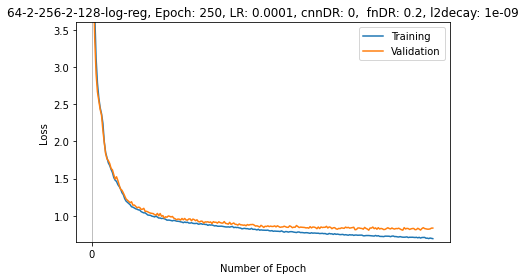

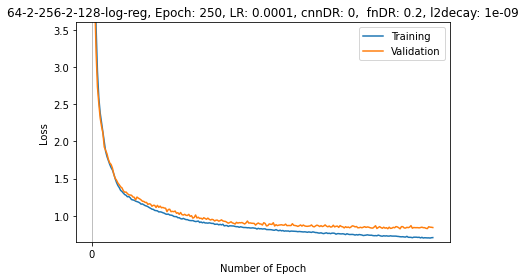

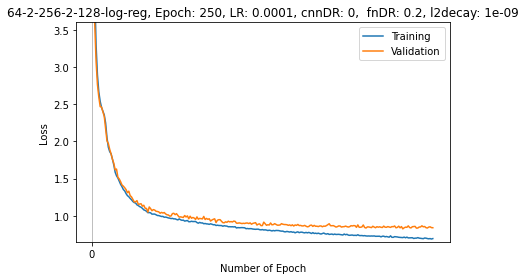

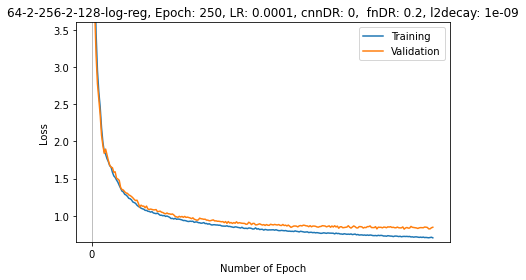

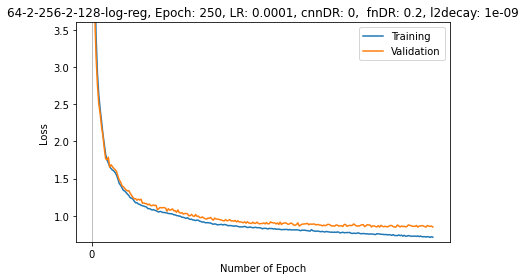

In [154]:
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-09'
Train_Loss=[4.906001091003418, 3.7387592792510986, 3.1213762760162354, 2.785996437072754, 2.5859837532043457, 2.453505039215088, 2.3716180324554443, 2.2449824810028076, 1.997139811515808, 1.8516665697097778, 1.7823920249938965, 1.7111963033676147, 1.6760520935058594, 1.6236509084701538, 1.5811314582824707, 1.5138226747512817, 1.4774439334869385, 1.4617276191711426, 1.418307900428772, 1.3923826217651367, 1.3594990968704224, 1.3094751834869385, 1.2832765579223633, 1.2295516729354858, 1.1974843740463257, 1.1805330514907837, 1.1626818180084229, 1.1481839418411255, 1.1211758852005005, 1.1161127090454102, 1.1057621240615845, 1.0943483114242554, 1.0889250040054321, 1.0792655944824219, 1.077160358428955, 1.0568889379501343, 1.0468406677246094, 1.0389562845230103, 1.0388437509536743, 1.0244437456130981, 1.0098280906677246, 1.0076936483383179, 1.004978060722351, 0.9940447211265564, 0.9907606840133667, 0.9840333461761475, 0.9975399374961853, 0.9804832339286804, 0.969447672367096, 0.9697542190551758, 0.9628157019615173, 0.9657140970230103, 0.960294246673584, 0.9529228806495667, 0.9407578706741333, 0.9419941902160645, 0.9408116340637207, 0.9362471699714661, 0.9311999082565308, 0.9383326172828674, 0.9341891407966614, 0.9277352690696716, 0.9260889887809753, 0.9241952300071716, 0.9185442328453064, 0.9148268103599548, 0.9067716002464294, 0.9163061380386353, 0.9091874361038208, 0.9134910702705383, 0.9026830196380615, 0.9010934233665466, 0.906584620475769, 0.8983561396598816, 0.895671010017395, 0.8963152170181274, 0.8987172245979309, 0.8866390585899353, 0.889460563659668, 0.8942961096763611, 0.8853660821914673, 0.8890388011932373, 0.8828551173210144, 0.8835150003433228, 0.8710671067237854, 0.8785654306411743, 0.8748130202293396, 0.8769683837890625, 0.8702872395515442, 0.8634204864501953, 0.8671602606773376, 0.8599534630775452, 0.8587601184844971, 0.8595259785652161, 0.8602692484855652, 0.8563761711120605, 0.8519689440727234, 0.8501121401786804, 0.8489990234375, 0.8509182333946228, 0.8469694256782532, 0.8529881238937378, 0.8568137884140015, 0.8403908014297485, 0.8454193472862244, 0.8413458466529846, 0.843512773513794, 0.8366392850875854, 0.8347753286361694, 0.8240059614181519, 0.8285003304481506, 0.8312141299247742, 0.8264755010604858, 0.8269985318183899, 0.8218508362770081, 0.8197391629219055, 0.830600380897522, 0.8171215057373047, 0.8187844157218933, 0.8163599967956543, 0.8091118335723877, 0.8188642263412476, 0.8055458068847656, 0.8104123473167419, 0.8069159984588623, 0.8062115907669067, 0.8055939674377441, 0.8047017455101013, 0.8069982528686523, 0.7987546920776367, 0.7963544130325317, 0.8002669215202332, 0.7910897731781006, 0.794674813747406, 0.7924818992614746, 0.7922654747962952, 0.7909432649612427, 0.7881888151168823, 0.7971512675285339, 0.7872242331504822, 0.7791065573692322, 0.7875943779945374, 0.7863999605178833, 0.7801267504692078, 0.7850354909896851, 0.7867978811264038, 0.7850666642189026, 0.7803164124488831, 0.7771473526954651, 0.7746356129646301, 0.7818225026130676, 0.7812979221343994, 0.7737648487091064, 0.7751071453094482, 0.7725731134414673, 0.7699853777885437, 0.7728086113929749, 0.7714362144470215, 0.7675427198410034, 0.7641086578369141, 0.7716735005378723, 0.7657814621925354, 0.7682268023490906, 0.7668781876564026, 0.7648907899856567, 0.7656829357147217, 0.7607637047767639, 0.762535810470581, 0.763608455657959, 0.7594420909881592, 0.7615613341331482, 0.7537338137626648, 0.7521912455558777, 0.76258385181427, 0.7568638920783997, 0.7573604583740234, 0.7491830587387085, 0.7588174939155579, 0.7504313588142395, 0.7538151144981384, 0.749830961227417, 0.7461801767349243, 0.7485135197639465, 0.7495712637901306, 0.7419003248214722, 0.7458138465881348, 0.741877019405365, 0.7382722496986389, 0.7453356385231018, 0.7412706613540649, 0.7439136505126953, 0.7361610531806946, 0.741020679473877, 0.7409427165985107, 0.7378912568092346, 0.7393169403076172, 0.7392386794090271, 0.7398130893707275, 0.7309458255767822, 0.7307710647583008, 0.7340864539146423, 0.7348016500473022, 0.7342773675918579, 0.7327288389205933, 0.732341468334198, 0.7303624153137207, 0.7268576622009277, 0.7352067232131958, 0.7274505496025085, 0.7320423126220703, 0.7228574752807617, 0.7225874066352844, 0.7217355966567993, 0.7198264598846436, 0.726046085357666, 0.7257129549980164, 0.7240592837333679, 0.7248702645301819, 0.7191260457038879, 0.7260649800300598, 0.7276977896690369, 0.7198375463485718, 0.7207602262496948, 0.7164468169212341, 0.7144794464111328, 0.7198854684829712, 0.7148570418357849, 0.7119659781455994, 0.7116963267326355, 0.7131037712097168, 0.7162635326385498, 0.7070481777191162, 0.7113140225410461, 0.7105628252029419, 0.711342453956604, 0.7089231610298157, 0.7076866030693054, 0.7105265259742737, 0.7035694122314453, 0.7101605534553528, 0.7002876400947571, 0.7076877951622009, 0.7086890935897827, 0.7092658877372742, 0.6979992389678955, 0.6991420388221741, 0.6930771470069885, 0.7003732323646545, 0.6956714987754822, 0.6923030614852905]
Test_Loss=[4.216648675862682, 3.393182017418849, 2.910914816290004, 2.6662156563356643, 2.5452682601776946, 2.43007481784081, 2.3538126446950227, 2.150240401616628, 1.9854995065274892, 1.8350727032229304, 1.7651977883215866, 1.741218873296697, 1.7024993519063996, 1.636300205040216, 1.617065807335732, 1.551968525593297, 1.4942488783492478, 1.5240697318876293, 1.473212140641834, 1.4097432077002134, 1.354761051945032, 1.342946311408332, 1.30688984830972, 1.265977082721084, 1.225913239272176, 1.2095842896529514, 1.1921031797996622, 1.1751752469060217, 1.1884743843600398, 1.142349244557618, 1.1446741858293892, 1.1282237126971915, 1.1076363070212374, 1.1155386994314664, 1.1117187216160789, 1.0865469130664094, 1.0878951173400235, 1.1000275724695252, 1.0585551500092885, 1.0601536989993379, 1.0519915969816154, 1.0419313523661167, 1.0355258007518517, 1.0321442943399408, 1.0283122117072585, 1.013338019833187, 1.0103631646362072, 1.031364789072545, 0.9987469548956369, 1.0303131340219887, 0.9933771619178294, 1.0028637402646725, 0.968142949711055, 0.9866543329256691, 0.9803369732927231, 0.9977604441442245, 0.9920540736599541, 0.9839296567553693, 0.990569481473143, 0.9681902916385718, 0.9599001840440505, 0.9457891529813582, 0.9558852730240522, 0.9540592086361559, 0.9420603333759318, 0.9635959296974644, 0.9457964468434115, 0.9638617969236176, 0.9440034500733132, 0.9411048387883932, 0.9566854038322989, 0.9581121291962531, 0.9328355322747425, 0.9555375575606382, 0.9479529326504025, 0.9340170735025174, 0.9462067783254784, 0.9218823048818718, 0.9168315509384393, 0.9288933876414056, 0.9247181241888772, 0.9015481049659178, 0.9178512930468337, 0.9157255620249306, 0.9190171462762622, 0.9101518157409778, 0.917520292269467, 0.8957625528247158, 0.9203643802793406, 0.9120438034872969, 0.9130593397004629, 0.9010586648498421, 0.918768494938428, 0.9085177010034987, 0.9023428407030651, 0.9013423272721803, 0.9217322614729677, 0.8974609628001625, 0.8941097972454742, 0.8873724935568612, 0.9115028585552637, 0.8848946755057892, 0.8941207589816373, 0.9031682952391593, 0.8857022459132394, 0.8839866555497049, 0.8740448721807081, 0.8905273991405378, 0.8785420354112439, 0.8773315864678226, 0.8724578959987602, 0.8761048760982234, 0.8656496524165233, 0.8817236187873055, 0.8738626589656785, 0.8811237950170331, 0.8814386218484058, 0.8835771691102302, 0.8744561296353911, 0.8608672891797623, 0.8653961019650915, 0.857709265744421, 0.8479655539414515, 0.871408262020883, 0.858683669128671, 0.8434409405768931, 0.8591584072617706, 0.8553732422531917, 0.8648570372194715, 0.85378989930975, 0.8609984998908415, 0.8558372877467473, 0.8564716373686921, 0.8640781433616511, 0.850593317919722, 0.8650997449465497, 0.8543317043856862, 0.8448861617407697, 0.8491005228346067, 0.849990249373424, 0.8598209192337386, 0.8518715365227454, 0.8449636984877165, 0.844863172942068, 0.8645429354731364, 0.8553369627637453, 0.8396606811302416, 0.846954549301847, 0.8451421870746365, 0.8690723948714676, 0.8553841344504293, 0.8413451156455212, 0.8478942840611703, 0.8454546756837324, 0.8445507535860216, 0.8424720030113201, 0.8367543333397999, 0.8394504241590847, 0.8328440397290152, 0.8536795321256352, 0.8368679797452905, 0.8487549473439596, 0.8471996981216077, 0.8411111448346232, 0.8259077078224787, 0.8491418363386938, 0.82816653192669, 0.8496876618622069, 0.8417716031289101, 0.8451757579932434, 0.8444422862087921, 0.857973995143127, 0.8356703358715203, 0.8500756298694646, 0.8444816944208009, 0.8262291804009614, 0.8384708974361139, 0.8407833528309782, 0.824585015089608, 0.8189775275038035, 0.8304063443574972, 0.8274977699670338, 0.837637577545942, 0.8349722348164528, 0.8311135410474633, 0.8474506469721026, 0.8383656475786719, 0.8442566930415487, 0.833672562083117, 0.8366782333418858, 0.8410870471708938, 0.8460376821225832, 0.8119050427958657, 0.8162327066087605, 0.8355933758321612, 0.8361732214830068, 0.8309082666663862, 0.8292694156057475, 0.8199158115101092, 0.8433931051715822, 0.8297261844002216, 0.8214384307617391, 0.8059945961352324, 0.8356809391347862, 0.8342451378734967, 0.8482791578268737, 0.8266085762552484, 0.8370017938928396, 0.8188060227437569, 0.8398123711361488, 0.8221786363687688, 0.8297995165059086, 0.8251429597453566, 0.814208009653694, 0.8170969809737372, 0.8278663428858329, 0.8390586501233774, 0.8286816595306162, 0.8231734435981405, 0.8356877663226822, 0.8259184673688842, 0.8212205166142443, 0.8288159777231087, 0.8267580949566726, 0.8326026657180411, 0.8231601953917709, 0.8123888661242538, 0.8063667942276278, 0.8404811831581919, 0.8225831420613188, 0.830395122792653, 0.8277671343750482, 0.8159047492256987, 0.8237316472113847, 0.8285880435802131, 0.8292126107849902, 0.8129382877855447, 0.8155410049425473, 0.8318399643917126, 0.821227698560191, 0.8076891420086062, 0.827763945901799, 0.8401020799533764, 0.8280407040673845, 0.8244328272713703, 0.8198969023851858, 0.8196567714437155, 0.8232283439194036, 0.8341002853336122, 0.8343276802970386]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-09'
lossGraph(Train_Loss,Test_Loss, appendix)
Train_Loss=[6.316287517547607, 4.584586143493652, 3.5411107540130615, 2.943988800048828, 2.587883472442627, 2.3840174674987793, 2.254399299621582, 2.1207194328308105, 2.0038156509399414, 1.8665597438812256, 1.796464443206787, 1.7439850568771362, 1.691798210144043, 1.6481560468673706, 1.6154379844665527, 1.562958002090454, 1.4986265897750854, 1.4475840330123901, 1.4069875478744507, 1.3786941766738892, 1.3414839506149292, 1.326664686203003, 1.3047237396240234, 1.2851966619491577, 1.275853157043457, 1.2549774646759033, 1.2585867643356323, 1.2426784038543701, 1.217846393585205, 1.2125548124313354, 1.2081552743911743, 1.1966983079910278, 1.1909998655319214, 1.1838098764419556, 1.1743217706680298, 1.1563657522201538, 1.1590049266815186, 1.148003101348877, 1.1365832090377808, 1.1310381889343262, 1.1224218606948853, 1.1103307008743286, 1.1004085540771484, 1.0887528657913208, 1.0859076976776123, 1.0720654726028442, 1.0696632862091064, 1.0662261247634888, 1.0515650510787964, 1.0529073476791382, 1.049075961112976, 1.0408014059066772, 1.035011887550354, 1.0239038467407227, 1.0195657014846802, 1.022964596748352, 1.0103908777236938, 1.0084062814712524, 1.004386067390442, 0.9912902116775513, 0.9887326955795288, 0.9882128834724426, 0.9734073281288147, 0.9742370247840881, 0.9618123173713684, 0.9567305445671082, 0.9648016095161438, 0.9555894136428833, 0.9481624364852905, 0.948084831237793, 0.9392927289009094, 0.9358015060424805, 0.9347145557403564, 0.9358363747596741, 0.9272498488426208, 0.9222679734230042, 0.9245946407318115, 0.929405689239502, 0.9099713563919067, 0.9168092012405396, 0.9053853750228882, 0.9132347702980042, 0.9029483795166016, 0.9036051630973816, 0.9005152583122253, 0.9052236676216125, 0.9007429480552673, 0.8966046571731567, 0.8978943228721619, 0.8849613070487976, 0.8864418268203735, 0.887965202331543, 0.8778430819511414, 0.8849150538444519, 0.8769406676292419, 0.8859779834747314, 0.8641313910484314, 0.8682757019996643, 0.8686479926109314, 0.8563870787620544, 0.8653252124786377, 0.864276647567749, 0.8647025227546692, 0.8619222044944763, 0.8562923073768616, 0.8531154990196228, 0.8531523942947388, 0.8448117971420288, 0.8525293469429016, 0.8482307195663452, 0.842430591583252, 0.8416999578475952, 0.841600775718689, 0.8383769392967224, 0.8396028876304626, 0.8355666399002075, 0.8356718420982361, 0.8377145528793335, 0.8339512944221497, 0.8319738507270813, 0.8212276101112366, 0.8316586017608643, 0.8240468502044678, 0.8268862366676331, 0.821731448173523, 0.8241573572158813, 0.8241957426071167, 0.8145096302032471, 0.8145015835762024, 0.8146545886993408, 0.8134458661079407, 0.8107541799545288, 0.8061647415161133, 0.8054141998291016, 0.8144497871398926, 0.8038416504859924, 0.7987155914306641, 0.8059829473495483, 0.7970101237297058, 0.80211341381073, 0.7929221987724304, 0.7966412901878357, 0.7942731976509094, 0.7959427833557129, 0.7887687683105469, 0.7942723631858826, 0.7929975986480713, 0.7926977872848511, 0.7916834354400635, 0.7897584438323975, 0.7860370874404907, 0.7887850999832153, 0.7866491079330444, 0.7842488288879395, 0.7825051546096802, 0.7844480276107788, 0.7819805145263672, 0.7778165936470032, 0.7830440998077393, 0.7802550196647644, 0.77628493309021, 0.7837050557136536, 0.7785065174102783, 0.7741876840591431, 0.7738997340202332, 0.7683218121528625, 0.7667755484580994, 0.7709560394287109, 0.7638025283813477, 0.7602006793022156, 0.7664089202880859, 0.7707020044326782, 0.7618512511253357, 0.7653533220291138, 0.7595792412757874, 0.7660707831382751, 0.7668532133102417, 0.7638378143310547, 0.7521523237228394, 0.7594047784805298, 0.7600958943367004, 0.7566935420036316, 0.7560107707977295, 0.7580479979515076, 0.7541752457618713, 0.7468225955963135, 0.7585628628730774, 0.7515455484390259, 0.7479959726333618, 0.7480908036231995, 0.7493538856506348, 0.7467036843299866, 0.7404293417930603, 0.7464866042137146, 0.741260826587677, 0.7479063868522644, 0.7447447180747986, 0.7412583827972412, 0.7342705130577087, 0.7368579506874084, 0.7396553158760071, 0.7438709139823914, 0.7397268414497375, 0.7380020618438721, 0.7389717102050781, 0.7339772582054138, 0.7318934798240662, 0.7332301735877991, 0.7312114238739014, 0.7398964166641235, 0.733380913734436, 0.7274969220161438, 0.7252743244171143, 0.7313860058784485, 0.7275527715682983, 0.7305036187171936, 0.7266557216644287, 0.7263425588607788, 0.7307629585266113, 0.7268136739730835, 0.7266472578048706, 0.7251970171928406, 0.7262706756591797, 0.7230864763259888, 0.7214376330375671, 0.7180420160293579, 0.7169494032859802, 0.7185078263282776, 0.7147830724716187, 0.7135464549064636, 0.7232332825660706, 0.7106203436851501, 0.7106377482414246, 0.7100580930709839, 0.7049499154090881, 0.7119288444519043, 0.7118144035339355, 0.7119576334953308, 0.7090016603469849, 0.7110937237739563, 0.7021898627281189, 0.7103636264801025, 0.7008903622627258, 0.7047159671783447, 0.7032190561294556, 0.7023096680641174, 0.7028473615646362, 0.7004421353340149, 0.704971432685852, 0.7063747048377991]
Test_Loss=[5.263927529782336, 3.9471980184641215, 3.205043284686677, 2.7345101848479594, 2.5104399711850816, 2.316601761691122, 2.203968992675836, 2.1135709427629283, 1.9247308715119846, 1.8810345021462298, 1.8324140432629796, 1.7597364434980074, 1.7107992128768104, 1.6898191341745255, 1.641713542832333, 1.556526282333635, 1.5040675925322484, 1.477819273989677, 1.4404961071957205, 1.417272164929003, 1.3896158790123014, 1.3750026208958088, 1.3362852740413074, 1.3161806998885484, 1.3193448693534406, 1.2987206503302866, 1.2820254338952, 1.278804779660817, 1.275769548885683, 1.253483673155842, 1.2486297405158544, 1.2128234227865609, 1.25152595289805, 1.2370726054875603, 1.2267999371140164, 1.2132124005132618, 1.195406991098241, 1.1932230094422627, 1.1785702399321527, 1.179947232775492, 1.153014415453462, 1.16179520128053, 1.1551726369942084, 1.1284391983653372, 1.1408328438731223, 1.1396720395631348, 1.1110696257107961, 1.1401202234540169, 1.113241144775442, 1.1292423338020756, 1.107520975900972, 1.1122995778073488, 1.1039953220193002, 1.101846614278161, 1.055696493218451, 1.0842344244674413, 1.087627034370206, 1.055277034892723, 1.0596716586911248, 1.054763564931403, 1.063491846266906, 1.0336893450408404, 1.0408997429977505, 1.0187761240855144, 1.0438474453817481, 1.0154258216565193, 1.0096774886298345, 1.0194826852686607, 1.0063914377024834, 1.0039576758248665, 1.018817545100747, 0.9921182036721975, 1.000943865584286, 0.9682029992280385, 0.9780508686199213, 1.0101448511892386, 0.9704059795948227, 0.9802284371172738, 0.9640280636602843, 0.9671195502074241, 0.9542617823504024, 0.9736911461330996, 0.9641203931124924, 0.9529908323304759, 0.9684648004585441, 0.9525660354444166, 0.9427532320068526, 0.9522055113937711, 0.946062473303746, 0.930235976481614, 0.9410999298316938, 0.9410508500985878, 0.9269238326909475, 0.934634420652588, 0.945108243832304, 0.9304532716055186, 0.925714820677714, 0.9232895015445669, 0.911903198397683, 0.9002931924398816, 0.9088126402643423, 0.9190878819107355, 0.9039037899612443, 0.8985261702447183, 0.8890240054333856, 0.9115357942379843, 0.901371451747268, 0.9074442985356823, 0.9050446303511483, 0.9092219533629861, 0.8991550551338001, 0.8896928684531539, 0.9044119798334694, 0.9291884631060472, 0.9017493151116438, 0.9041808160308277, 0.8997682518367299, 0.8977521466759342, 0.8971595983576269, 0.8744174774931937, 0.892274708895048, 0.9027181309643468, 0.8907447961803433, 0.8886546917813379, 0.8755625189760179, 0.9067921573410884, 0.8964830610035651, 0.8637967909739759, 0.8678533636211858, 0.8904403690088563, 0.8859002989199807, 0.883973799706739, 0.9067121673370023, 0.8619516691685501, 0.8800433684564305, 0.8677604108228155, 0.8741263201473587, 0.8763353090290404, 0.8793965384616014, 0.8739771022938758, 0.8733616958931012, 0.8877844506924724, 0.867217126148647, 0.8691918215156351, 0.8692060711855725, 0.8684773484921227, 0.8932161020371053, 0.8718104428295032, 0.8692184728584679, 0.8653298872390129, 0.8570245251403386, 0.8655070647636457, 0.8766269720714637, 0.861340306542655, 0.8755631279542633, 0.864008592395127, 0.8593497198005607, 0.8580074417760628, 0.861561565987955, 0.8639098117700905, 0.8767559936345133, 0.8569041263713999, 0.8508732015328997, 0.8634053433456237, 0.8739585592173476, 0.867323633130423, 0.8552395537541706, 0.8668839802523044, 0.8548520423709822, 0.8623522649132684, 0.8773168471627217, 0.8605774629707739, 0.8515143976049995, 0.8624667833907664, 0.8483524803362439, 0.8510613620991776, 0.8727602224498905, 0.850204250047149, 0.8585483113613449, 0.8612645410145034, 0.8439251723614328, 0.8680919617390971, 0.855121368490285, 0.8511513063555913, 0.8365935726873335, 0.8529430272829518, 0.8421683356099332, 0.8489752096197648, 0.8381861550104359, 0.8493726271172676, 0.8649835810876011, 0.8605150212908528, 0.8504419183736319, 0.8561115235807517, 0.8383429376221622, 0.8398333868948864, 0.8453748546754803, 0.838626330371531, 0.8467476210530217, 0.8534314423057446, 0.8437664446232431, 0.8495035221585583, 0.8466353043028906, 0.8392594795161861, 0.8353343732533159, 0.8342177452470595, 0.8487589536573955, 0.8658171691514367, 0.8288611550576813, 0.8423073836931889, 0.8535642101780969, 0.8410183710054804, 0.8320838267755399, 0.8461458507919286, 0.833334153344336, 0.8398704027814082, 0.825521165348788, 0.8468171200028245, 0.8301131752025519, 0.8335411804697872, 0.8444029350563489, 0.8384817463561909, 0.854898972843981, 0.8498272702643408, 0.8393063944997817, 0.8245569909237993, 0.8542829634298228, 0.8535086224301683, 0.8363744051677536, 0.8344815619205612, 0.8447583990376639, 0.8402861172505709, 0.8472348620455867, 0.8671663408922218, 0.8328524928565468, 0.8420839406602653, 0.8400310447762113, 0.8405228025009213, 0.8402227388181892, 0.8371153749473722, 0.8420945669325337, 0.8464880333710854, 0.8397925836323407, 0.8399785493184433, 0.831473904242054, 0.8277785941657456, 0.8523673882622769, 0.8468257362120151, 0.8453120072817413, 0.8418180862648873]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-09'
lossGraph(Train_Loss,Test_Loss, appendix)
Train_Loss=[5.412613391876221, 4.0530195236206055, 3.2968900203704834, 2.895203113555908, 2.6666758060455322, 2.539501667022705, 2.4566867351531982, 2.405529499053955, 2.3560891151428223, 2.248033285140991, 2.0523605346679688, 1.9212048053741455, 1.8617066144943237, 1.8335356712341309, 1.7617932558059692, 1.6834408044815063, 1.5857962369918823, 1.5374916791915894, 1.5075613260269165, 1.4641176462173462, 1.4221657514572144, 1.3909696340560913, 1.352660894393921, 1.3345729112625122, 1.2980519533157349, 1.2706549167633057, 1.2559598684310913, 1.233433485031128, 1.2150676250457764, 1.1917967796325684, 1.1773890256881714, 1.170898199081421, 1.1465990543365479, 1.1367902755737305, 1.1225435733795166, 1.1149702072143555, 1.099345088005066, 1.0794094800949097, 1.0724427700042725, 1.060144066810608, 1.0410690307617188, 1.0434032678604126, 1.0396034717559814, 1.0221599340438843, 1.0220063924789429, 1.0227025747299194, 1.0126208066940308, 1.0037561655044556, 1.0025724172592163, 0.9966762661933899, 0.9902811646461487, 0.9914893507957458, 0.9803209900856018, 0.9825542569160461, 0.977637767791748, 0.9707162976264954, 0.9681629538536072, 0.9619683623313904, 0.9649814963340759, 0.9580299854278564, 0.9587575793266296, 0.9504132866859436, 0.9444300532341003, 0.9576945900917053, 0.9459488391876221, 0.9391053318977356, 0.9413139224052429, 0.9282479286193848, 0.9317383170127869, 0.9363959431648254, 0.9197724461555481, 0.9202399253845215, 0.9260349273681641, 0.9219976663589478, 0.922250509262085, 0.923287034034729, 0.9088640213012695, 0.8999825716018677, 0.9109344482421875, 0.9032415151596069, 0.9038551449775696, 0.8929924964904785, 0.8958916664123535, 0.8908461332321167, 0.8896725177764893, 0.8847106099128723, 0.8919422030448914, 0.8863386511802673, 0.8788233995437622, 0.8802955746650696, 0.8692343831062317, 0.8734114766120911, 0.8692082166671753, 0.8684805035591125, 0.8682461977005005, 0.8594104647636414, 0.8659923672676086, 0.8625501990318298, 0.8607261180877686, 0.8520658612251282, 0.8530327081680298, 0.8515428900718689, 0.8524256944656372, 0.8499809503555298, 0.8530418872833252, 0.8355286121368408, 0.8408502340316772, 0.8389442563056946, 0.8404850363731384, 0.840951681137085, 0.8395931720733643, 0.8382748961448669, 0.8260444402694702, 0.8287830352783203, 0.8256710767745972, 0.8270946145057678, 0.8263185024261475, 0.8213945627212524, 0.8196990489959717, 0.8178302645683289, 0.8196274042129517, 0.8197041153907776, 0.8128415942192078, 0.8106719255447388, 0.8143181204795837, 0.8087266087532043, 0.8106834292411804, 0.8076128363609314, 0.8014125823974609, 0.8060553669929504, 0.8019468784332275, 0.7958656549453735, 0.8023125529289246, 0.7973282933235168, 0.8025553822517395, 0.8020163178443909, 0.801060140132904, 0.7959386706352234, 0.7930715084075928, 0.7936300039291382, 0.7853259444236755, 0.7839295268058777, 0.7896521091461182, 0.7849946618080139, 0.7813417315483093, 0.7861192226409912, 0.7786470651626587, 0.781487226486206, 0.7708827257156372, 0.7786751389503479, 0.7838878631591797, 0.7727761268615723, 0.7791106700897217, 0.7795552015304565, 0.7736294269561768, 0.7704183459281921, 0.7759624123573303, 0.7702317833900452, 0.7761767506599426, 0.7703559398651123, 0.7613365054130554, 0.7732840776443481, 0.7620430588722229, 0.7658363580703735, 0.7604546546936035, 0.7661424875259399, 0.7591884732246399, 0.7544711232185364, 0.7604462504386902, 0.7679072022438049, 0.7575793862342834, 0.7537244558334351, 0.759596586227417, 0.749161958694458, 0.7518838047981262, 0.7542757391929626, 0.7466936111450195, 0.7540230751037598, 0.7483951449394226, 0.7488946914672852, 0.7506512999534607, 0.7470957636833191, 0.7423274517059326, 0.74137943983078, 0.7543535828590393, 0.7445825338363647, 0.7510650753974915, 0.7401095032691956, 0.7370442152023315, 0.740052342414856, 0.7408551573753357, 0.735598087310791, 0.7377122044563293, 0.7347390055656433, 0.745078444480896, 0.7346196174621582, 0.7332403063774109, 0.7344755530357361, 0.7304850220680237, 0.733053982257843, 0.7287406921386719, 0.7273810505867004, 0.7285577058792114, 0.7267123460769653, 0.7283132076263428, 0.7270609736442566, 0.7289429306983948, 0.7239487767219543, 0.724666178226471, 0.7264332175254822, 0.7249994277954102, 0.7163426876068115, 0.7248252034187317, 0.7255074381828308, 0.7171141505241394, 0.7215036153793335, 0.7167932987213135, 0.7118349075317383, 0.7301275134086609, 0.7102707028388977, 0.7102422714233398, 0.719416618347168, 0.7174957990646362, 0.7151013016700745, 0.7107499241828918, 0.7090612053871155, 0.7069567441940308, 0.7063364386558533, 0.7129604816436768, 0.7039105296134949, 0.7128182053565979, 0.7021305561065674, 0.7032868266105652, 0.7043702602386475, 0.7048063278198242, 0.6946796178817749, 0.699080765247345, 0.6991729140281677, 0.7061290144920349, 0.6992202997207642, 0.6966739892959595, 0.6946623921394348, 0.691790759563446, 0.7008031010627747, 0.6989514827728271, 0.6937731504440308, 0.6902852058410645, 0.6934396028518677, 0.6873740553855896, 0.6930906772613525]
Test_Loss=[4.541619361478047, 3.587381223810809, 3.077806581411195, 2.764974651219991, 2.5980270015528677, 2.468244045110524, 2.4629140713843642, 2.3994875901917414, 2.3357416489359006, 2.1751735735696993, 2.0074155893381413, 1.9708944893904032, 1.8929340461623003, 1.8312410251983127, 1.7603970064963637, 1.7055550817047394, 1.618235850372387, 1.6282315382831882, 1.5180333707403837, 1.494320087522528, 1.4578201224938871, 1.4143270263899856, 1.3981241181822013, 1.3770498122128099, 1.3519528336200728, 1.3102998471489926, 1.330546846354878, 1.2713441736175468, 1.2537682352055235, 1.2197240767910256, 1.1865836198648008, 1.1878262088190448, 1.2035674291036935, 1.1513943037443173, 1.1587464673349868, 1.1610480452558607, 1.1290640407346628, 1.1410771799033521, 1.0999289393372342, 1.0985638779559252, 1.0483720751241874, 1.1183278223707307, 1.0956581502332485, 1.0678067413618018, 1.0830626330441073, 1.0766506167295624, 1.0604075480194228, 1.0574648958766282, 1.0521918800625987, 1.0340587460109698, 1.0456214152023628, 1.0366593502511878, 1.0433483097987206, 1.0250740701072139, 1.0137107888232972, 1.010877692481734, 0.9957400686852291, 0.9967571393459632, 1.0289206380429583, 1.0336946631564716, 1.0149325166855974, 1.0282364582950356, 1.0038392233487223, 0.982102262421423, 0.9853541563629259, 0.9805719836631519, 0.977047526021277, 1.003175541266061, 0.9836896124934975, 0.9979224409076527, 0.9598051650064331, 0.9939184872464102, 0.9667846844062542, 0.9771276925230966, 0.9688693873832976, 0.9509150687619478, 0.98506250270961, 0.9540513521390256, 0.9647974254547524, 0.9609679306706569, 0.9578344946147239, 0.9909887818597188, 0.9494523792994689, 0.9644240241256496, 0.9523153958355076, 0.959756335820817, 0.9290269677191629, 0.9429648113536362, 0.9526496726936255, 0.9592239856489895, 0.9085749937553598, 0.9398953822899637, 0.9473057484333662, 0.9473393310008303, 0.9257899681256059, 0.9074233008094773, 0.9057608628515379, 0.9186815143097795, 0.9120101631965802, 0.9269200694966788, 0.9176229114053882, 0.9218713985258079, 0.9164007148415244, 0.9284053429675592, 0.9245254781023428, 0.9006609988711984, 0.9002972336719246, 0.9042030935442257, 0.9003821697751455, 0.895170501902447, 0.8989940665050677, 0.8963252817129579, 0.9019298984995583, 0.9026654755634155, 0.8951643196447426, 0.9044444910530102, 0.8865569390438233, 0.8974134631152617, 0.9022288853748761, 0.9073634802396189, 0.8752077612791552, 0.8874896569609171, 0.8906884530482091, 0.8669355408805809, 0.8683582922366919, 0.9142786650588286, 0.8938675826774869, 0.8720363076523876, 0.8794421890767548, 0.8758680371779914, 0.9029905161183548, 0.8783129695277812, 0.8813421449788449, 0.8938296183010502, 0.8840867702522659, 0.8737002984609226, 0.8738646446892986, 0.8766211638966475, 0.8937649949500049, 0.8861532083468218, 0.8823043687468374, 0.8819578318895224, 0.8795814364992819, 0.8713227293326891, 0.8774761897013851, 0.8663373918639871, 0.8783529021503353, 0.8622074849174525, 0.876812918168508, 0.8703707841343459, 0.8832097717282066, 0.8679335372523638, 0.8707159785521039, 0.8635622776122396, 0.863426065720939, 0.8705691302733275, 0.8598615545995877, 0.8514639301435364, 0.8555381808560403, 0.8711331832491199, 0.8746945306558478, 0.8571751507084393, 0.8707203089459016, 0.8590338270376386, 0.8596505863572654, 0.8544973158059024, 0.8624576946670314, 0.8632413412350248, 0.851966347138849, 0.8613830066837218, 0.858781836803389, 0.8680752508175775, 0.8809305335737493, 0.8927328845404732, 0.8660437203966498, 0.8660328711509817, 0.8677157648490601, 0.8588055237903327, 0.8481246285949547, 0.8537845233938702, 0.8635657069913636, 0.8620434804581021, 0.8478891642542256, 0.8529495775690203, 0.8536822292091263, 0.860952334956201, 0.8536985712252224, 0.8484026821163149, 0.8534177989783231, 0.8663943890500546, 0.8630007240209645, 0.8680693483441447, 0.8658524582742286, 0.8445068227308132, 0.8774163628861815, 0.8449239717452153, 0.8455593511198225, 0.8498812850777134, 0.8760601735150896, 0.8425819887201139, 0.8350942665254969, 0.850165663984857, 0.8501766325387129, 0.8452990087076953, 0.8406843625604244, 0.8588864297524559, 0.8481270649300315, 0.8393346722785184, 0.8532060028264153, 0.8464623703750314, 0.8517908830182443, 0.8452264379089132, 0.8423048532317701, 0.8607847408393291, 0.8466974168226977, 0.8450514428753605, 0.8544552072497381, 0.8495856626205383, 0.8436485778311817, 0.8544043356571502, 0.8528241792543799, 0.8625037817157569, 0.8381732348372597, 0.8436857491611809, 0.8600322549152521, 0.8383402301535066, 0.8545901204785643, 0.8238062119184414, 0.8387620938482465, 0.8472675717317761, 0.844740176749327, 0.8642001439789145, 0.8417515366837597, 0.8363764946177262, 0.8528978991097033, 0.8550533071300547, 0.8574147940901169, 0.8335128420744848, 0.8354475970182496, 0.8484767410146141, 0.8496257296587905, 0.8649293733041673, 0.851717803872143, 0.8555879596692099, 0.8399627600335391, 0.8351517369352712, 0.8476623968675099, 0.851671438283764, 0.8406697676230727, 0.8391476883672062]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-09'
lossGraph(Train_Loss,Test_Loss, appendix)
Train_Loss=[5.9103684425354, 4.319880485534668, 3.4551680088043213, 2.955592155456543, 2.66623854637146, 2.463437795639038, 2.184231758117676, 1.9883347749710083, 1.8613663911819458, 1.8272432088851929, 1.7682839632034302, 1.7275214195251465, 1.6736605167388916, 1.6533886194229126, 1.584862470626831, 1.5365782976150513, 1.5152506828308105, 1.4807847738265991, 1.451133131980896, 1.4084961414337158, 1.3716624975204468, 1.3317105770111084, 1.3208863735198975, 1.2884447574615479, 1.2794471979141235, 1.2602647542953491, 1.2347060441970825, 1.2285569906234741, 1.213077425956726, 1.1853457689285278, 1.1771806478500366, 1.1664578914642334, 1.1421359777450562, 1.1264216899871826, 1.1144498586654663, 1.1022366285324097, 1.093488097190857, 1.0883733034133911, 1.0725491046905518, 1.0725154876708984, 1.0605512857437134, 1.0583118200302124, 1.0486806631088257, 1.0553699731826782, 1.037912130355835, 1.0328214168548584, 1.0284130573272705, 1.0352646112442017, 1.0202808380126953, 1.0070573091506958, 1.0075998306274414, 1.000270128250122, 1.004111409187317, 0.9909859895706177, 0.9968056678771973, 0.988478422164917, 0.9792383313179016, 0.9622789621353149, 0.9651954174041748, 0.9559767842292786, 0.9664335250854492, 0.9526967406272888, 0.9560528993606567, 0.9544867873191833, 0.9497791528701782, 0.9442870020866394, 0.9356250762939453, 0.9367009997367859, 0.9323136210441589, 0.9251304864883423, 0.9228243231773376, 0.9272816777229309, 0.9244296550750732, 0.9264631271362305, 0.9113339781761169, 0.9165647625923157, 0.9165750741958618, 0.9073327779769897, 0.9060267806053162, 0.899437665939331, 0.9019922018051147, 0.9085325598716736, 0.8947480320930481, 0.8964481949806213, 0.8871443867683411, 0.892977237701416, 0.8821684718132019, 0.8754863142967224, 0.8793438076972961, 0.8796379566192627, 0.8761842250823975, 0.8761577606201172, 0.8723914623260498, 0.8735504150390625, 0.8640509247779846, 0.8614563345909119, 0.8611879944801331, 0.8599529266357422, 0.8655141592025757, 0.8562749624252319, 0.8571264147758484, 0.8521406650543213, 0.8468921184539795, 0.843339204788208, 0.8510246872901917, 0.8490242958068848, 0.8432785868644714, 0.8403657078742981, 0.8351114392280579, 0.8455967307090759, 0.8332071900367737, 0.829701840877533, 0.8321341872215271, 0.8271989822387695, 0.8356907963752747, 0.8342486023902893, 0.8297038674354553, 0.8210970163345337, 0.8238121867179871, 0.8373022675514221, 0.820339560508728, 0.8270994424819946, 0.8145182132720947, 0.8178310394287109, 0.8181255459785461, 0.8066665530204773, 0.8163622617721558, 0.8117873668670654, 0.8079506754875183, 0.8105365633964539, 0.8099154233932495, 0.8108434081077576, 0.8116919994354248, 0.8060818910598755, 0.8124346137046814, 0.8048726916313171, 0.8001043200492859, 0.7998151779174805, 0.8038803935050964, 0.8006486892700195, 0.7984032034873962, 0.8012539744377136, 0.7951488494873047, 0.7923230528831482, 0.7932085990905762, 0.7901113629341125, 0.7914336323738098, 0.7880939841270447, 0.7968645095825195, 0.7907865047454834, 0.7883920669555664, 0.7827100157737732, 0.7918522357940674, 0.7880728840827942, 0.7848003506660461, 0.7796996235847473, 0.7815778851509094, 0.7838366627693176, 0.7739666104316711, 0.7776548266410828, 0.7777273654937744, 0.7725629210472107, 0.7757255434989929, 0.7700506448745728, 0.7735491394996643, 0.7703893780708313, 0.7666789293289185, 0.763229250907898, 0.7660998106002808, 0.7708424925804138, 0.7671250104904175, 0.7639745473861694, 0.7694435119628906, 0.7667829990386963, 0.766730785369873, 0.7655621767044067, 0.7651394009590149, 0.7566087245941162, 0.7666955590248108, 0.7604057788848877, 0.7626382112503052, 0.7554903030395508, 0.7549563646316528, 0.7512093782424927, 0.7584660053253174, 0.7549093961715698, 0.750808835029602, 0.7534241080284119, 0.7503402233123779, 0.7557674050331116, 0.7468188405036926, 0.7510125637054443, 0.7541807293891907, 0.7437865734100342, 0.748464047908783, 0.740262508392334, 0.7426664233207703, 0.7430034279823303, 0.7385991215705872, 0.7416329383850098, 0.7367396950721741, 0.7417091727256775, 0.7365490198135376, 0.7414180636405945, 0.7388978600502014, 0.7337285876274109, 0.7328458428382874, 0.7347822189331055, 0.7309783101081848, 0.7373088598251343, 0.7332859039306641, 0.7366859912872314, 0.7336451411247253, 0.7271665930747986, 0.728655219078064, 0.7247097492218018, 0.7323710322380066, 0.7293569445610046, 0.7265759110450745, 0.7260156869888306, 0.7201824188232422, 0.7263047099113464, 0.7273461818695068, 0.7247191071510315, 0.7203863263130188, 0.724412202835083, 0.7176414728164673, 0.721640944480896, 0.7228769063949585, 0.7212264537811279, 0.7228229641914368, 0.7197821736335754, 0.7219480276107788, 0.7150061726570129, 0.717093825340271, 0.7119579315185547, 0.7160144448280334, 0.7164170742034912, 0.7130179405212402, 0.7093165516853333, 0.7126414775848389, 0.7087520956993103, 0.7132055163383484, 0.7069171071052551, 0.7088695764541626, 0.7063930630683899, 0.7038238048553467, 0.7077109217643738, 0.7114236950874329, 0.703336238861084]
Test_Loss=[4.894260629283402, 3.770638328758622, 3.1637942137458075, 2.778360374784195, 2.5779457787111766, 2.3622264979200422, 2.083731352308368, 1.9449463034288348, 1.8394780627590779, 1.8966352649494267, 1.8197602205107553, 1.7429445629089733, 1.6816117718826926, 1.653164905774256, 1.6464664575141938, 1.5844755744734256, 1.5909096785292225, 1.504992668150736, 1.4933541343462486, 1.476032026905225, 1.37973540414227, 1.352684811551895, 1.3456187017200532, 1.3222344147075316, 1.3058830805850958, 1.301733812556742, 1.2805729390718141, 1.2715782922738286, 1.2583288478071046, 1.2409978956754522, 1.2193791731488488, 1.2037340809173644, 1.2096757526228252, 1.1693051763872713, 1.1164800688224494, 1.1428615374714384, 1.1285804102870065, 1.1300354523629859, 1.1078165342980566, 1.130283291376997, 1.090862377454957, 1.0845623456659992, 1.090268952089082, 1.0855498767645082, 1.0795144698594195, 1.079569809212059, 1.0833026105768786, 1.056978296138115, 1.0580158879573895, 1.0621638170498415, 1.0481980570041487, 1.0435296902477318, 1.0324896886414818, 1.0264187588860147, 1.0373507038808012, 1.0267906421828878, 1.0253291644038478, 1.0194299927041033, 1.024272590101525, 1.011080072137048, 0.9918794091732833, 0.9859182705279822, 0.9789289771630276, 0.9924378307520074, 0.9831539246064989, 0.9910350933942746, 0.9789814958362143, 0.9911613125073975, 0.978074657096657, 0.9817570186397283, 0.9765285222601712, 0.9708176002732749, 0.9609947983703417, 0.9722071125494275, 0.9536790924816643, 0.9474293248715483, 0.9398053843629509, 0.9455024760591129, 0.9679081210215208, 0.9599738221809618, 0.9574379916782787, 0.9527363452234934, 0.9539611601624448, 0.941677219006571, 0.9409811698507475, 0.9328336318641118, 0.9339432112558859, 0.940296448269673, 0.9446316259129884, 0.9307889553144559, 0.9320074991382982, 0.9260872851075912, 0.9264765714216762, 0.9221130619020069, 0.9191970090352747, 0.9217633913776266, 0.9079249489132688, 0.9220883586078569, 0.8984767363138655, 0.9222844107884995, 0.9019588270325933, 0.9095392798403475, 0.8971533135181288, 0.9082977744118624, 0.8998312021674069, 0.918521597116956, 0.9007492307503027, 0.9069261789537038, 0.9030349160697035, 0.8992513191393359, 0.8976411914624758, 0.8968276281026869, 0.8855902779982983, 0.888590484066474, 0.9130447663977206, 0.9016674476088413, 0.8811525949045733, 0.8969205350478664, 0.8974217473732314, 0.8774307165026164, 0.8788441726130364, 0.8854874345841692, 0.891930287646598, 0.8825444122057362, 0.8754513406733208, 0.881072956049455, 0.8699550292746876, 0.8819340808195731, 0.8729342874874195, 0.8714148206075669, 0.8856532206074641, 0.8804730353826402, 0.8769010978249234, 0.8837363524658959, 0.8786226496734919, 0.8760174952865866, 0.8820975635234409, 0.8711949440509925, 0.8690823363660933, 0.8828832026151843, 0.8685887972492996, 0.8740075225934533, 0.8627653409942418, 0.8745684451671248, 0.8605832574288317, 0.8440158430363431, 0.8531546957753067, 0.8617069694627619, 0.8626528685880356, 0.8601521345617971, 0.8505592932588514, 0.8644792059147062, 0.8684685432866319, 0.8632354567929399, 0.8734661186366952, 0.8713851884494224, 0.8649161451044436, 0.8634654157102508, 0.8531266895732267, 0.8668569667762946, 0.8516988486357386, 0.8614865028378729, 0.8614406095122761, 0.8583502385777609, 0.8504379955747354, 0.8466747490577157, 0.8544911808943632, 0.8565881707458773, 0.8664531880112307, 0.8646071867409512, 0.8619565626329438, 0.8511361278267459, 0.8584446212038733, 0.8643003983763347, 0.8456627324927133, 0.8623036432660578, 0.8490985400319593, 0.8657034179754962, 0.8496770082030132, 0.8607800556763686, 0.8325969221081263, 0.8518335639718285, 0.8524920420456812, 0.8388715389804561, 0.842178311848373, 0.8449322080165127, 0.8478652559414499, 0.8659178356563575, 0.8464947087349468, 0.834379851437651, 0.8484606954093031, 0.8629656542790585, 0.853253604699996, 0.8376666301912721, 0.8360320677231671, 0.8542736314606224, 0.8538496538148692, 0.8504359685278784, 0.8348026291128229, 0.8440271577281253, 0.84068986489513, 0.8540139522466208, 0.853811674735568, 0.8632615257946207, 0.8413649562302803, 0.84142249951813, 0.8406123795053231, 0.8536381658346338, 0.8236327639508515, 0.8469393282446415, 0.8443548641721745, 0.8453727206979454, 0.8374953396647237, 0.8477441527598458, 0.8464609650867714, 0.8389114149361301, 0.8509708664621498, 0.8477398426864389, 0.8531119939796192, 0.8425299052234366, 0.8456088356433445, 0.8394040906817457, 0.838457026784808, 0.8480875290780029, 0.83902346115396, 0.8370493406684306, 0.8376473587632951, 0.8500362284568634, 0.8202541110987243, 0.8362034912167868, 0.8425457403012555, 0.8338937911092583, 0.8348549762414211, 0.8567538143438986, 0.8449874654508371, 0.842261477339143, 0.8385977924212433, 0.8364181742120176, 0.8296933552104342, 0.8372487131904319, 0.8409836353617629, 0.8401629799185683, 0.8389801747473404, 0.848398547734489, 0.8465816346386246, 0.8428576644964345, 0.8237976534017584, 0.8241732117648283, 0.8389705674608454, 0.845572951130868]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-09'
lossGraph(Train_Loss,Test_Loss, appendix)
Train_Loss=[6.095925331115723, 4.328011512756348, 3.416154623031616, 2.9164679050445557, 2.623110055923462, 2.4320921897888184, 2.2757089138031006, 2.1014769077301025, 1.9600569009780884, 1.8276734352111816, 1.7500265836715698, 1.710296392440796, 1.6584187746047974, 1.6346992254257202, 1.6155446767807007, 1.6027963161468506, 1.5808677673339844, 1.5464364290237427, 1.494332194328308, 1.433990478515625, 1.4099717140197754, 1.3763353824615479, 1.3423371315002441, 1.3336663246154785, 1.3118953704833984, 1.2916346788406372, 1.27363920211792, 1.2426668405532837, 1.2373712062835693, 1.224666953086853, 1.1963773965835571, 1.1746952533721924, 1.1748576164245605, 1.158434510231018, 1.1523354053497314, 1.1410316228866577, 1.1355537176132202, 1.1294606924057007, 1.1230372190475464, 1.1170654296875, 1.0962122678756714, 1.0964288711547852, 1.0893981456756592, 1.0771839618682861, 1.0819023847579956, 1.0749056339263916, 1.0680575370788574, 1.0578389167785645, 1.0499193668365479, 1.0587576627731323, 1.0531795024871826, 1.0434504747390747, 1.0455780029296875, 1.039566993713379, 1.0375566482543945, 1.0304404497146606, 1.0292930603027344, 1.027298927307129, 1.0239336490631104, 1.0135866403579712, 1.0121986865997314, 1.003531813621521, 0.9995929598808289, 0.9970839023590088, 0.9921092391014099, 0.9793005585670471, 0.9795491695404053, 0.9727575182914734, 0.9636878371238708, 0.973252534866333, 0.9602401256561279, 0.9504976868629456, 0.9551098346710205, 0.9426180124282837, 0.9428606033325195, 0.9350599646568298, 0.9418291449546814, 0.939498782157898, 0.9269843101501465, 0.9223518967628479, 0.9145529866218567, 0.9168409109115601, 0.9066027402877808, 0.9071720838546753, 0.9067656993865967, 0.9041777849197388, 0.9024574160575867, 0.8927120566368103, 0.8861842751502991, 0.8912307024002075, 0.8867588043212891, 0.8779798150062561, 0.8803371787071228, 0.8832859396934509, 0.8843364119529724, 0.8756691813468933, 0.8828572630882263, 0.8798104524612427, 0.8737190365791321, 0.865424394607544, 0.8694943785667419, 0.8676893711090088, 0.8649660348892212, 0.859481930732727, 0.8643451929092407, 0.8612877726554871, 0.85772705078125, 0.8503658771514893, 0.850385308265686, 0.8499944806098938, 0.8513372540473938, 0.8579471111297607, 0.8496732711791992, 0.8421999216079712, 0.8445706963539124, 0.8491432666778564, 0.8447061777114868, 0.8389763832092285, 0.8425144553184509, 0.8447059392929077, 0.8392620086669922, 0.8400424122810364, 0.8387978076934814, 0.8354194760322571, 0.8243119120597839, 0.8311400413513184, 0.8312603831291199, 0.8295509219169617, 0.8219265341758728, 0.8309091925621033, 0.8275282979011536, 0.8292226195335388, 0.821891188621521, 0.8274957537651062, 0.8177810311317444, 0.8203728199005127, 0.8204622864723206, 0.8174374103546143, 0.8124192953109741, 0.8145248889923096, 0.8158916234970093, 0.8154838681221008, 0.8170450329780579, 0.809779167175293, 0.8153970837593079, 0.810359001159668, 0.8089253902435303, 0.8119930028915405, 0.8094906210899353, 0.8117766976356506, 0.8088696002960205, 0.8067846894264221, 0.798117458820343, 0.8078475594520569, 0.8047187924385071, 0.807184100151062, 0.8011869192123413, 0.800349235534668, 0.7969089150428772, 0.7932621836662292, 0.8130522966384888, 0.7996216416358948, 0.7947967052459717, 0.7909626960754395, 0.7947714924812317, 0.7935309410095215, 0.7885133624076843, 0.7855238318443298, 0.7900134325027466, 0.78428053855896, 0.7823866605758667, 0.7893983125686646, 0.7842515110969543, 0.7827690839767456, 0.778504490852356, 0.780523419380188, 0.7768707275390625, 0.7805908918380737, 0.7762969136238098, 0.7826119661331177, 0.7798154950141907, 0.7692576050758362, 0.7743927240371704, 0.7785306572914124, 0.7712452411651611, 0.7737491130828857, 0.7741941213607788, 0.776017427444458, 0.7752595543861389, 0.7653968334197998, 0.7617887258529663, 0.7668158411979675, 0.7625758647918701, 0.7641535401344299, 0.7693787217140198, 0.7664374709129333, 0.758354127407074, 0.7596067786216736, 0.7610629200935364, 0.75987309217453, 0.756883978843689, 0.7571781873703003, 0.7536332011222839, 0.75371915102005, 0.7560678720474243, 0.753291666507721, 0.7516639828681946, 0.7475215196609497, 0.7584442496299744, 0.7572386264801025, 0.7538462281227112, 0.7515460848808289, 0.7495772838592529, 0.7468702793121338, 0.7470002770423889, 0.7477802038192749, 0.7417586445808411, 0.747002363204956, 0.742881715297699, 0.7375375032424927, 0.7461182475090027, 0.7346938252449036, 0.7332650423049927, 0.7328389286994934, 0.7424265146255493, 0.7331489324569702, 0.7389535307884216, 0.7259089350700378, 0.7374557256698608, 0.7248157858848572, 0.7258149981498718, 0.7343952059745789, 0.7288495302200317, 0.7255563139915466, 0.7236031889915466, 0.7263017892837524, 0.7269498109817505, 0.7225378155708313, 0.7298519611358643, 0.7191698551177979, 0.7275202870368958, 0.7184051275253296, 0.7175150513648987, 0.7197177410125732, 0.7136886119842529, 0.7197037935256958, 0.7170696258544922, 0.7088363170623779, 0.7181661128997803, 0.7120938897132874]
Test_Loss=[4.97490971647517, 3.7312759672511393, 3.1341203464962084, 2.759515827235511, 2.4999845509282244, 2.372729870429018, 2.2001746974871446, 2.0778081889441022, 1.910008817330547, 1.7685355270780192, 1.7529229935306556, 1.787500794720048, 1.6526578743180127, 1.686297494667385, 1.660949689178073, 1.634980430427265, 1.6216513337193328, 1.5948645602623208, 1.5342369033707588, 1.479972954879337, 1.455551003766031, 1.4016580256458457, 1.3912711815425716, 1.3668961351989124, 1.3480470452950115, 1.3340143001680027, 1.3368117012057612, 1.3043221039755368, 1.2758178498804278, 1.2481522401168368, 1.2275698769287358, 1.2308624176598897, 1.2091668921216796, 1.2235296102361877, 1.211569556009295, 1.2227753510481356, 1.1688421466189673, 1.1733241506211873, 1.1631244276914126, 1.163322732278873, 1.1463921277465061, 1.1576218386938493, 1.1366400620371857, 1.13699158369037, 1.1447181628211909, 1.138196091635773, 1.1401608578608617, 1.080311390232025, 1.0962009027652448, 1.1120559230046834, 1.10671958198506, 1.1083093184697945, 1.1106094176789179, 1.1013549313418858, 1.0616724692305801, 1.094564858231589, 1.0753942686977809, 1.079460408242952, 1.0928518770109106, 1.066619195454138, 1.0684269110572, 1.0462363337070397, 1.078033121640527, 1.0446027893143044, 1.0352668677737433, 1.041638536637982, 1.022933972583426, 1.0305832195176077, 1.0303053893796383, 1.0263844164570173, 0.9994211219893757, 1.0021889482447848, 1.0188546739848374, 0.9980106754173066, 0.9911658550320861, 1.016525103249769, 0.9915921792624518, 0.9965313864842579, 0.9756423733484494, 0.9752084844517235, 0.9847118318414481, 0.9695692328058244, 0.9611553747326975, 0.9549146332670896, 0.9677071338856356, 0.965406621604553, 0.9771133515301231, 0.9559965041957572, 0.9403171996283157, 0.9682370498079211, 0.9566108703565557, 0.9545952392478421, 0.9523220111637626, 0.9468090266517589, 0.9430292636360563, 0.9344847232818514, 0.930642185086316, 0.9489572486421843, 0.9320566709917217, 0.9362381699820024, 0.9480617744009809, 0.9299881884257538, 0.9342315259059712, 0.926136481774912, 0.9370114270324212, 0.9166542617697857, 0.9329580935000368, 0.9161877969353887, 0.9177197894893848, 0.9132400187498771, 0.9060396011354869, 0.919317729384112, 0.900301051663571, 0.9199615613918772, 0.9034164585505513, 0.8997511752334192, 0.8962466051091028, 0.9138913602964602, 0.8972724362381095, 0.8981478362737552, 0.9148726104392608, 0.8975778174575819, 0.8916542085933908, 0.8960269811272599, 0.8960209683890932, 0.9042652274964484, 0.8909416617832695, 0.9084800786539193, 0.8915846238609322, 0.8928937331347148, 0.917475547991942, 0.9066807153601988, 0.903817174814127, 0.9043565007102946, 0.8907527509757069, 0.9035234482559047, 0.8830701122909211, 0.9148941055175446, 0.8822658805117312, 0.899057089416989, 0.9011840574333815, 0.9054365098610991, 0.8948596864614838, 0.8841412599561614, 0.8926322737564708, 0.9029124269299608, 0.8923360452251636, 0.8760205245456676, 0.8722078504059494, 0.8823822306459426, 0.9059933316231572, 0.8621044274938559, 0.8739564797677255, 0.8857592762785953, 0.8888156859140262, 0.8909114758005765, 0.8919960964167899, 0.8989085896307001, 0.8793660063119448, 0.8902703348438324, 0.8860442575860771, 0.8871548846871333, 0.8908810115253689, 0.8777134884424143, 0.8801539761535591, 0.8829099015147744, 0.8742748501209949, 0.8745273552047036, 0.8640160743294498, 0.8745218333802406, 0.866319033541135, 0.8737538908204212, 0.8851985281729019, 0.8830502299610586, 0.871740885495088, 0.8606569665669715, 0.8651632977329186, 0.8598402454422844, 0.8755044142268751, 0.8756392234141365, 0.8603401897867483, 0.8650437666803593, 0.8655215774485467, 0.8556446195413505, 0.8830584098283325, 0.8827799689247852, 0.858528580471783, 0.8643375982005141, 0.871381547435453, 0.8684228146460375, 0.8722901800005446, 0.8902928363634594, 0.8746325511992942, 0.860816899292433, 0.8639179963057185, 0.8623608826542264, 0.8716860519886352, 0.8789173177102219, 0.8805362390076941, 0.8535162075731834, 0.8647995737292816, 0.880829146574904, 0.876010236083722, 0.8745225206928358, 0.8495161255999684, 0.8652709864244642, 0.8620319933916617, 0.8566088632942707, 0.8497978807415729, 0.8665600984472819, 0.8483162645426933, 0.8719160829623149, 0.8573533346440556, 0.8529953682410031, 0.8589930347701211, 0.8530541678185927, 0.8506962007615705, 0.8631683722674928, 0.8696900249556638, 0.8669824724695204, 0.8537667324077471, 0.8482227572265837, 0.8488792325261568, 0.8751352358507356, 0.8643382199786455, 0.849428227918751, 0.8627243794328368, 0.8543355762384398, 0.8597099910967546, 0.8506425911004354, 0.8548538522791471, 0.8764910423520832, 0.8732306832331149, 0.8656902728983663, 0.8599143241981981, 0.8575469482118429, 0.8574706662844095, 0.86988878914573, 0.8478874923791255, 0.8615507975110037, 0.8627342620779443, 0.8678636679759067, 0.8635581083880812, 0.8545851468063592, 0.8477324066713845, 0.8690294822808736, 0.8615774871793737, 0.8570528605418362, 0.8615943107199691, 0.8486969272617358]
lossGraph(Train_Loss,Test_Loss, appendix)


In [130]:
train_data = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/gene_seq_train.csv')
train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data1/res_train.csv')


In [131]:
train_target

,AMI_MIC,BDQ_MIC,CFZ_MIC,DLM_MIC,EMB_MIC,ETH_MIC,INH_MIC,KAN_MIC,LEV_MIC,LZD_MIC,MXF_MIC,RIF_MIC,RFB_MIC
0,0.125,0.0300,0.030,0.0075,1.0,1.000,0.05000,4.0,0.25,0.50,0.25,0.12,0.03
1,0.125,0.0300,0.030,0.0075,2.0,2.000,1.60000,0.5,4.00,0.25,0.50,2.00,0.03
2,1.000,0.0300,0.060,0.0040,16.0,16.000,12.80000,16.0,16.00,0.25,8.00,16.00,4.00
3,0.125,0.0040,0.015,0.0040,8.0,0.500,1.60000,2.0,0.50,0.25,0.12,8.00,0.12
4,0.125,0.0040,0.015,0.0040,1.0,0.125,NaN,0.5,0.25,0.12,0.03,0.12,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10844,0.125,0.0300,0.060,0.0150,1.0,1.000,0.01125,2.0,0.50,0.50,0.50,0.06,0.03
10845,0.125,0.0600,0.120,0.0300,2.0,2.000,0.05000,2.0,0.50,0.50,0.25,0.12,0.03
10846,0.125,0.0075,0.120,0.0075,1.0,2.000,0.05000,2.0,0.25,0.25,0.25,0.03,0.03
10847,0.500,0.0300,1.000,0.1200,16.0,4.000,3.20000,0.5,16.00,0.50,8.00,8.00,4.00


In [129]:
train_data.columns

Index(['wgs_id', 'acpM-kasA', 'ethAR', 'aftB-ubiA', 'tlyA', 'embCAB', 'gid',
       'panD', 'rpoBC', 'rpsA', 'katG', 'rpsL', 'pncA', 'clpC', 'gyrBA',
       'oxyR-ahpC', 'eis', 'rrs-rrl', 'fabG1-inhA'],
      dtype='object')

In [137]:
Test_Loss=[4.216648675862682, 3.393182017418849, 2.910914816290004, 2.6662156563356643, 2.5452682601776946, 2.43007481784081, 2.3538126446950227, 2.150240401616628, 1.9854995065274892, 1.8350727032229304, 1.7651977883215866, 1.741218873296697, 1.7024993519063996, 1.636300205040216, 1.617065807335732, 1.551968525593297, 1.4942488783492478, 1.5240697318876293, 1.473212140641834, 1.4097432077002134, 1.354761051945032, 1.342946311408332, 1.30688984830972, 1.265977082721084, 1.225913239272176, 1.2095842896529514, 1.1921031797996622, 1.1751752469060217, 1.1884743843600398, 1.142349244557618, 1.1446741858293892, 1.1282237126971915, 1.1076363070212374, 1.1155386994314664, 1.1117187216160789, 1.0865469130664094, 1.0878951173400235, 1.1000275724695252, 1.0585551500092885, 1.0601536989993379, 1.0519915969816154, 1.0419313523661167, 1.0355258007518517, 1.0321442943399408, 1.0283122117072585, 1.013338019833187, 1.0103631646362072, 1.031364789072545, 0.9987469548956369, 1.0303131340219887, 0.9933771619178294, 1.0028637402646725, 0.968142949711055, 0.9866543329256691, 0.9803369732927231, 0.9977604441442245, 0.9920540736599541, 0.9839296567553693, 0.990569481473143, 0.9681902916385718, 0.9599001840440505, 0.9457891529813582, 0.9558852730240522, 0.9540592086361559, 0.9420603333759318, 0.9635959296974644, 0.9457964468434115, 0.9638617969236176, 0.9440034500733132, 0.9411048387883932, 0.9566854038322989, 0.9581121291962531, 0.9328355322747425, 0.9555375575606382, 0.9479529326504025, 0.9340170735025174, 0.9462067783254784, 0.9218823048818718, 0.9168315509384393, 0.9288933876414056, 0.9247181241888772, 0.9015481049659178, 0.9178512930468337, 0.9157255620249306, 0.9190171462762622, 0.9101518157409778, 0.917520292269467, 0.8957625528247158, 0.9203643802793406, 0.9120438034872969, 0.9130593397004629, 0.9010586648498421, 0.918768494938428, 0.9085177010034987, 0.9023428407030651, 0.9013423272721803, 0.9217322614729677, 0.8974609628001625, 0.8941097972454742, 0.8873724935568612, 0.9115028585552637, 0.8848946755057892, 0.8941207589816373, 0.9031682952391593, 0.8857022459132394, 0.8839866555497049, 0.8740448721807081, 0.8905273991405378, 0.8785420354112439, 0.8773315864678226, 0.8724578959987602, 0.8761048760982234, 0.8656496524165233, 0.8817236187873055, 0.8738626589656785, 0.8811237950170331, 0.8814386218484058, 0.8835771691102302, 0.8744561296353911, 0.8608672891797623, 0.8653961019650915, 0.857709265744421, 0.8479655539414515, 0.871408262020883, 0.858683669128671, 0.8434409405768931, 0.8591584072617706, 0.8553732422531917, 0.8648570372194715, 0.85378989930975, 0.8609984998908415, 0.8558372877467473, 0.8564716373686921, 0.8640781433616511, 0.850593317919722, 0.8650997449465497, 0.8543317043856862, 0.8448861617407697, 0.8491005228346067, 0.849990249373424, 0.8598209192337386, 0.8518715365227454, 0.8449636984877165, 0.844863172942068, 0.8645429354731364, 0.8553369627637453, 0.8396606811302416, 0.846954549301847, 0.8451421870746365, 0.8690723948714676, 0.8553841344504293, 0.8413451156455212, 0.8478942840611703, 0.8454546756837324, 0.8445507535860216, 0.8424720030113201, 0.8367543333397999, 0.8394504241590847, 0.8328440397290152, 0.8536795321256352, 0.8368679797452905, 0.8487549473439596, 0.8471996981216077, 0.8411111448346232, 0.8259077078224787, 0.8491418363386938, 0.82816653192669, 0.8496876618622069, 0.8417716031289101, 0.8451757579932434, 0.8444422862087921, 0.857973995143127, 0.8356703358715203, 0.8500756298694646, 0.8444816944208009, 0.8262291804009614, 0.8384708974361139, 0.8407833528309782, 0.824585015089608, 0.8189775275038035, 0.8304063443574972, 0.8274977699670338, 0.837637577545942, 0.8349722348164528, 0.8311135410474633, 0.8474506469721026, 0.8383656475786719, 0.8442566930415487, 0.833672562083117, 0.8366782333418858, 0.8410870471708938, 0.8460376821225832, 0.8119050427958657, 0.8162327066087605, 0.8355933758321612, 0.8361732214830068, 0.8309082666663862, 0.8292694156057475, 0.8199158115101092, 0.8433931051715822, 0.8297261844002216, 0.8214384307617391, 0.8059945961352324]
len(Test_Loss)

203

/tmp/ipykernel_49443/20229539.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/20229539.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/20229539.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/20229539.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


test_loss_min: 1.1963719129562378 test_loss_min_epoch: 229
test_loss_min: 1.3241565227508545 test_loss_min_epoch: 249
test_loss_min: 1.53026282787323 test_loss_min_epoch: 228
test_loss_min: 1.694642186164856 test_loss_min_epoch: 236


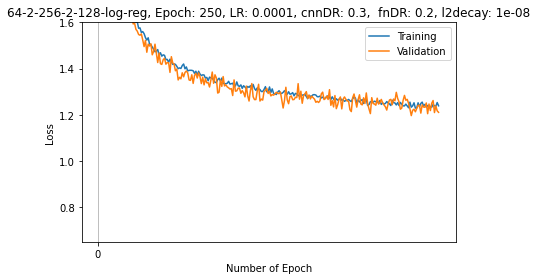

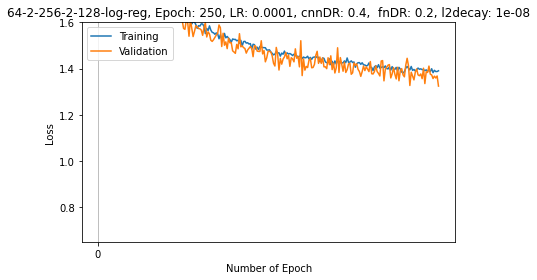

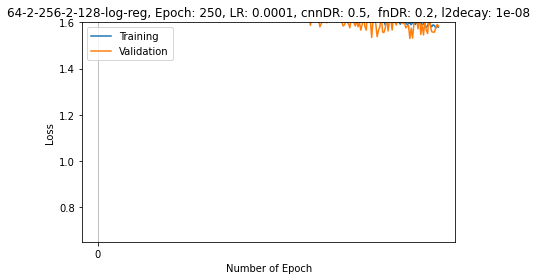

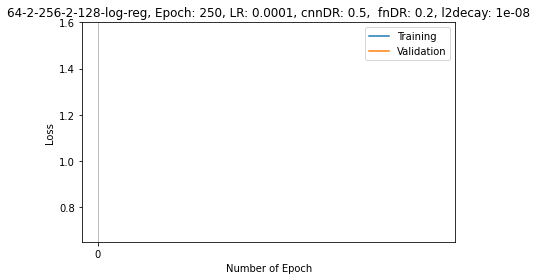

In [140]:
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0.2,  fnDR: 0.2, l2decay: 1e-08'
Train_Loss=[5.858309745788574, 4.160833358764648, 3.2871592044830322, 2.8213229179382324, 2.5745363235473633, 2.413620710372925, 2.2735469341278076, 2.1698408126831055, 2.089519739151001, 2.027789831161499, 1.9727357625961304, 1.9319968223571777, 1.9006479978561401, 1.8756508827209473, 1.8575304746627808, 1.8131402730941772, 1.7920352220535278, 1.7677114009857178, 1.7547663450241089, 1.7382625341415405, 1.6996833086013794, 1.686937689781189, 1.6682342290878296, 1.6548995971679688, 1.6488152742385864, 1.6255006790161133, 1.606519341468811, 1.6011273860931396, 1.602663516998291, 1.5746909379959106, 1.5761512517929077, 1.5563620328903198, 1.5602599382400513, 1.5512274503707886, 1.5342862606048584, 1.5232770442962646, 1.5334159135818481, 1.506314992904663, 1.5034635066986084, 1.492950201034546, 1.484013319015503, 1.4727847576141357, 1.4756232500076294, 1.4823174476623535, 1.4585717916488647, 1.4685959815979004, 1.4538285732269287, 1.459442377090454, 1.4573428630828857, 1.438527226448059, 1.439776062965393, 1.427038550376892, 1.4407380819320679, 1.4299272298812866, 1.418115496635437, 1.420327067375183, 1.4182507991790771, 1.4098492860794067, 1.3998302221298218, 1.4030652046203613, 1.4004889726638794, 1.4131848812103271, 1.4199528694152832, 1.3992012739181519, 1.4070836305618286, 1.3896892070770264, 1.3924214839935303, 1.39264976978302, 1.392387866973877, 1.390511155128479, 1.3792253732681274, 1.3885400295257568, 1.3717401027679443, 1.3884544372558594, 1.3765909671783447, 1.3698581457138062, 1.3729342222213745, 1.3723901510238647, 1.3583964109420776, 1.3619332313537598, 1.3474007844924927, 1.3631184101104736, 1.359719157218933, 1.3579583168029785, 1.3504703044891357, 1.3405581712722778, 1.3394492864608765, 1.3521714210510254, 1.358452558517456, 1.345694661140442, 1.358810544013977, 1.3357170820236206, 1.3349943161010742, 1.334388017654419, 1.3365508317947388, 1.3449050188064575, 1.3327823877334595, 1.3344722986221313, 1.33652663230896, 1.3230760097503662, 1.3249561786651611, 1.3423925638198853, 1.3253635168075562, 1.3230149745941162, 1.3293516635894775, 1.314414620399475, 1.3258079290390015, 1.3199607133865356, 1.3131300210952759, 1.32270085811615, 1.318595051765442, 1.3260444402694702, 1.312597632408142, 1.3312782049179077, 1.3135160207748413, 1.3056997060775757, 1.31620192527771, 1.312496304512024, 1.3093854188919067, 1.3006188869476318, 1.3007746934890747, 1.3096929788589478, 1.3218275308609009, 1.2993873357772827, 1.299117088317871, 1.3205046653747559, 1.2962892055511475, 1.3120228052139282, 1.2923895120620728, 1.2904804944992065, 1.287767767906189, 1.2979729175567627, 1.3043458461761475, 1.2930701971054077, 1.2923495769500732, 1.2969489097595215, 1.3043886423110962, 1.296120047569275, 1.2889115810394287, 1.2998549938201904, 1.2891188859939575, 1.2907932996749878, 1.2959667444229126, 1.2820971012115479, 1.2924364805221558, 1.291023850440979, 1.2821094989776611, 1.2857950925827026, 1.2843706607818604, 1.2850379943847656, 1.2862353324890137, 1.2885448932647705, 1.278900146484375, 1.2699083089828491, 1.2836295366287231, 1.280316948890686, 1.2809404134750366, 1.2869521379470825, 1.2871249914169312, 1.2855231761932373, 1.278351068496704, 1.2780364751815796, 1.2810419797897339, 1.2727673053741455, 1.276573657989502, 1.2700002193450928, 1.2722702026367188, 1.2793347835540771, 1.2821176052093506, 1.2753115892410278, 1.2660801410675049, 1.277910828590393, 1.2676341533660889, 1.2608082294464111, 1.2693405151367188, 1.2633520364761353, 1.266963005065918, 1.2713372707366943, 1.2630817890167236, 1.2652207612991333, 1.2582042217254639, 1.2619489431381226, 1.2620524168014526, 1.266466498374939, 1.2611464262008667, 1.2570966482162476, 1.269758701324463, 1.2759555578231812, 1.27295982837677, 1.2509362697601318, 1.2642133235931396, 1.2552313804626465, 1.2615444660186768, 1.2657585144042969, 1.2489252090454102, 1.2668955326080322, 1.2666432857513428, 1.2402865886688232, 1.244467854499817, 1.2567218542099, 1.2554559707641602, 1.254499077796936, 1.2589139938354492, 1.2565674781799316, 1.2573802471160889, 1.2497637271881104, 1.2618379592895508, 1.2448556423187256, 1.2511430978775024, 1.2462372779846191, 1.24917733669281, 1.257171630859375, 1.2512052059173584, 1.2469079494476318, 1.2401543855667114, 1.2628320455551147, 1.2524951696395874, 1.2512009143829346, 1.2425001859664917, 1.2526088953018188, 1.2400500774383545, 1.2536029815673828, 1.245358943939209, 1.2385287284851074, 1.23832106590271, 1.2461791038513184, 1.2381881475448608, 1.230527639389038, 1.2547426223754883, 1.2327829599380493, 1.2386962175369263, 1.2519259452819824, 1.228974461555481, 1.2301896810531616, 1.2519586086273193, 1.2349307537078857, 1.249177098274231, 1.2549448013305664, 1.2373236417770386, 1.2451220750808716, 1.2334331274032593, 1.240243673324585, 1.2329400777816772, 1.236092448234558, 1.232882022857666, 1.2446259260177612, 1.2386835813522339, 1.237041711807251, 1.2530426979064941, 1.2389132976531982]
Test_Loss=[4.864882469177246, 3.6749186515808105, 2.9993982315063477, 2.6961498260498047, 2.4656333923339844, 2.3300180435180664, 2.1796998977661133, 2.1196281909942627, 2.029752492904663, 1.9607607126235962, 1.9389841556549072, 1.8978753089904785, 1.8793517351150513, 1.8130204677581787, 1.7840508222579956, 1.758780598640442, 1.7238681316375732, 1.743697166442871, 1.71468985080719, 1.6843736171722412, 1.6655343770980835, 1.6135424375534058, 1.6263550519943237, 1.6111139059066772, 1.6425460577011108, 1.5932432413101196, 1.597314715385437, 1.5701860189437866, 1.5621448755264282, 1.547631859779358, 1.544521450996399, 1.5502773523330688, 1.5241782665252686, 1.495273232460022, 1.5220340490341187, 1.4707881212234497, 1.5058943033218384, 1.4975749254226685, 1.507459282875061, 1.459707260131836, 1.47437584400177, 1.5057005882263184, 1.4670426845550537, 1.4262081384658813, 1.4673088788986206, 1.4211019277572632, 1.4180635213851929, 1.438332438468933, 1.4444332122802734, 1.4191220998764038, 1.4261218309402466, 1.4253315925598145, 1.3835188150405884, 1.4515278339385986, 1.424681544303894, 1.4189164638519287, 1.3906584978103638, 1.3980985879898071, 1.3507875204086304, 1.3623098134994507, 1.3557578325271606, 1.3817706108093262, 1.3643475770950317, 1.3830925226211548, 1.3895646333694458, 1.381583571434021, 1.3507215976715088, 1.3488366603851318, 1.373199701309204, 1.335915207862854, 1.3706445693969727, 1.3795435428619385, 1.3591328859329224, 1.3813977241516113, 1.3652318716049194, 1.335079550743103, 1.362977385520935, 1.3295730352401733, 1.3555577993392944, 1.33853280544281, 1.3389642238616943, 1.3202931880950928, 1.3500245809555054, 1.38504159450531, 1.3363717794418335, 1.3732051849365234, 1.3597391843795776, 1.294042944908142, 1.297539234161377, 1.3511368036270142, 1.3229645490646362, 1.3654675483703613, 1.3247612714767456, 1.3296582698822021, 1.3206143379211426, 1.3165972232818604, 1.311393141746521, 1.3131710290908813, 1.2832962274551392, 1.3510175943374634, 1.3021984100341797, 1.3035730123519897, 1.3150746822357178, 1.3158289194107056, 1.292965292930603, 1.3047457933425903, 1.2951799631118774, 1.2775614261627197, 1.3243848085403442, 1.2823225259780884, 1.2595136165618896, 1.3054656982421875, 1.3351325988769531, 1.2776857614517212, 1.2657729387283325, 1.2658735513687134, 1.3031529188156128, 1.3320889472961426, 1.2594796419143677, 1.2679888010025024, 1.263431191444397, 1.3007506132125854, 1.3052414655685425, 1.3146387338638306, 1.2922534942626953, 1.3016018867492676, 1.2816603183746338, 1.2873188257217407, 1.2850115299224854, 1.2907817363739014, 1.297344446182251, 1.2936134338378906, 1.2910940647125244, 1.298636555671692, 1.2632062435150146, 1.2292811870574951, 1.2622199058532715, 1.319148063659668, 1.2646067142486572, 1.2479438781738281, 1.278307557106018, 1.2815099954605103, 1.2653321027755737, 1.2661001682281494, 1.2757339477539062, 1.274450421333313, 1.334771752357483, 1.2674704790115356, 1.3020473718643188, 1.2497999668121338, 1.2831093072891235, 1.2904878854751587, 1.3002334833145142, 1.2703707218170166, 1.2854938507080078, 1.268572449684143, 1.2806000709533691, 1.2738357782363892, 1.2679532766342163, 1.2541356086730957, 1.258446216583252, 1.2532291412353516, 1.2604480981826782, 1.2905315160751343, 1.2980037927627563, 1.2658040523529053, 1.2700868844985962, 1.280812382698059, 1.2662187814712524, 1.3087981939315796, 1.2409472465515137, 1.2613906860351562, 1.2340627908706665, 1.2832480669021606, 1.226523756980896, 1.2434066534042358, 1.2674615383148193, 1.2771401405334473, 1.2255570888519287, 1.2678399085998535, 1.2773685455322266, 1.2671228647232056, 1.2597758769989014, 1.258738398551941, 1.221779465675354, 1.2138546705245972, 1.2737691402435303, 1.2898907661437988, 1.2606807947158813, 1.2331792116165161, 1.2662080526351929, 1.2865873575210571, 1.2466185092926025, 1.242915153503418, 1.273539662361145, 1.2488462924957275, 1.2945713996887207, 1.2475064992904663, 1.2251895666122437, 1.2050365209579468, 1.2740788459777832, 1.2485357522964478, 1.2467247247695923, 1.2413818836212158, 1.2718113660812378, 1.2463449239730835, 1.2519209384918213, 1.2665047645568848, 1.2516834735870361, 1.2423006296157837, 1.234652042388916, 1.220451831817627, 1.247247338294983, 1.2640126943588257, 1.266785740852356, 1.2435084581375122, 1.2680938243865967, 1.2605767250061035, 1.2971558570861816, 1.2708284854888916, 1.2562285661697388, 1.2241312265396118, 1.228973627090454, 1.2621407508850098, 1.2839045524597168, 1.2629179954528809, 1.2668042182922363, 1.2500975131988525, 1.2255487442016602, 1.1963719129562378, 1.2193492650985718, 1.2241716384887695, 1.212992548942566, 1.2275373935699463, 1.24055016040802, 1.2412972450256348, 1.2071809768676758, 1.2428215742111206, 1.2334401607513428, 1.2325403690338135, 1.2511794567108154, 1.204705834388733, 1.246531367301941, 1.218238115310669, 1.2500663995742798, 1.2617212533950806, 1.2095353603363037, 1.2383531332015991, 1.217067837715149, 1.2106409072875977]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0.3,  fnDR: 0.2, l2decay: 1e-08'
lossGraph(Train_Loss, Test_Loss, appendix)
Train_Loss=[5.226454734802246, 3.953737735748291, 3.2898964881896973, 2.8953213691711426, 2.662388801574707, 2.530088424682617, 2.437319755554199, 2.384972333908081, 2.342634916305542, 2.311210870742798, 2.2767996788024902, 2.2386255264282227, 2.2000205516815186, 2.162935256958008, 2.1220345497131348, 2.088782787322998, 2.0542664527893066, 2.014885187149048, 1.9846349954605103, 1.9736040830612183, 1.950484275817871, 1.9358446598052979, 1.9242770671844482, 1.9140894412994385, 1.9008357524871826, 1.8999013900756836, 1.881514310836792, 1.8772538900375366, 1.8682162761688232, 1.8500643968582153, 1.8399467468261719, 1.8292559385299683, 1.8142327070236206, 1.8167688846588135, 1.8088680505752563, 1.7940664291381836, 1.7876794338226318, 1.7910698652267456, 1.7750523090362549, 1.7773160934448242, 1.753592848777771, 1.7537227869033813, 1.755993127822876, 1.7289241552352905, 1.7324174642562866, 1.7238966226577759, 1.7056188583374023, 1.7210187911987305, 1.6945836544036865, 1.707167387008667, 1.6914411783218384, 1.6811631917953491, 1.680570363998413, 1.6774189472198486, 1.6622471809387207, 1.6519478559494019, 1.6481996774673462, 1.6671184301376343, 1.6296623945236206, 1.6484363079071045, 1.643532633781433, 1.6296803951263428, 1.6455647945404053, 1.6269890069961548, 1.6317685842514038, 1.608629584312439, 1.604015588760376, 1.6218775510787964, 1.592911720275879, 1.6034905910491943, 1.6016024351119995, 1.5906070470809937, 1.5742123126983643, 1.5858685970306396, 1.5840511322021484, 1.5937813520431519, 1.5932190418243408, 1.5822134017944336, 1.5514498949050903, 1.5738749504089355, 1.564706563949585, 1.585000991821289, 1.566689372062683, 1.556982159614563, 1.5548899173736572, 1.5484038591384888, 1.5543458461761475, 1.5508121252059937, 1.5291051864624023, 1.5466673374176025, 1.5257879495620728, 1.528892159461975, 1.552281379699707, 1.5330933332443237, 1.5391730070114136, 1.5319249629974365, 1.525553822517395, 1.5139819383621216, 1.5283252000808716, 1.5261821746826172, 1.526434302330017, 1.5204458236694336, 1.5227073431015015, 1.5099372863769531, 1.5223639011383057, 1.4975316524505615, 1.5168730020523071, 1.5179904699325562, 1.5105057954788208, 1.511939525604248, 1.5062813758850098, 1.5082054138183594, 1.4848488569259644, 1.5053315162658691, 1.5035792589187622, 1.4842286109924316, 1.492798924446106, 1.482405662536621, 1.4962995052337646, 1.4934234619140625, 1.4910459518432617, 1.4906657934188843, 1.4903141260147095, 1.4803237915039062, 1.4802706241607666, 1.4811902046203613, 1.4718517065048218, 1.466127872467041, 1.4594780206680298, 1.462388515472412, 1.4739047288894653, 1.467506766319275, 1.4683172702789307, 1.4538770914077759, 1.46709406375885, 1.4622364044189453, 1.4759005308151245, 1.4596726894378662, 1.4680637121200562, 1.4629898071289062, 1.4653668403625488, 1.4616791009902954, 1.4563542604446411, 1.462402105331421, 1.4557292461395264, 1.4550970792770386, 1.4506802558898926, 1.4537020921707153, 1.4543832540512085, 1.4430913925170898, 1.4500004053115845, 1.4466358423233032, 1.4476232528686523, 1.4534603357315063, 1.4415028095245361, 1.448418378829956, 1.440177083015442, 1.4490998983383179, 1.449668049812317, 1.4525253772735596, 1.4476512670516968, 1.448994755744934, 1.429781436920166, 1.431080937385559, 1.4460891485214233, 1.4443495273590088, 1.4289616346359253, 1.425352692604065, 1.4263842105865479, 1.4422188997268677, 1.4170405864715576, 1.431471586227417, 1.4170604944229126, 1.4331752061843872, 1.420047402381897, 1.4325447082519531, 1.4307661056518555, 1.4257471561431885, 1.4249027967453003, 1.424743890762329, 1.4333652257919312, 1.4256746768951416, 1.4461073875427246, 1.427101969718933, 1.4280421733856201, 1.4335085153579712, 1.4262996912002563, 1.4287346601486206, 1.4057751893997192, 1.4209736585617065, 1.4252870082855225, 1.4260227680206299, 1.418426752090454, 1.425232172012329, 1.4163939952850342, 1.415539026260376, 1.4119431972503662, 1.4131278991699219, 1.4245121479034424, 1.4062432050704956, 1.4050390720367432, 1.3912996053695679, 1.4073481559753418, 1.412741780281067, 1.403823733329773, 1.4169237613677979, 1.4018950462341309, 1.4047931432724, 1.4081975221633911, 1.4039132595062256, 1.4115922451019287, 1.4002635478973389, 1.398603916168213, 1.4076347351074219, 1.393236517906189, 1.4084059000015259, 1.3971141576766968, 1.3965966701507568, 1.4051674604415894, 1.3893557786941528, 1.4055119752883911, 1.3975639343261719, 1.3853492736816406, 1.3810021877288818, 1.386993408203125, 1.4020895957946777, 1.4092642068862915, 1.4014742374420166, 1.3940051794052124, 1.4091328382492065, 1.3920542001724243, 1.3962228298187256, 1.3895889520645142, 1.3950695991516113, 1.4023423194885254, 1.3969556093215942, 1.398912787437439, 1.3954901695251465, 1.395372986793518, 1.391125202178955, 1.3944228887557983, 1.3895477056503296, 1.3917889595031738, 1.3872405290603638, 1.3993526697158813, 1.3822447061538696, 1.3925672769546509, 1.3871676921844482, 1.387328863143921, 1.3905282020568848]
Test_Loss=[4.496121406555176, 3.5996577739715576, 3.0480151176452637, 2.764035224914551, 2.588653087615967, 2.440363645553589, 2.388821840286255, 2.3402867317199707, 2.2772326469421387, 2.261295795440674, 2.2060093879699707, 2.2139265537261963, 2.1751720905303955, 2.1440744400024414, 2.06833553314209, 2.023662567138672, 2.0375702381134033, 1.9873327016830444, 1.9923263788223267, 1.9394022226333618, 1.955950379371643, 1.899322509765625, 1.9333237409591675, 1.9284193515777588, 1.8945279121398926, 1.8644684553146362, 1.8689264059066772, 1.8495022058486938, 1.8424690961837769, 1.827688217163086, 1.843017578125, 1.8065556287765503, 1.8069953918457031, 1.7898916006088257, 1.8244467973709106, 1.7910207509994507, 1.7823268175125122, 1.745644211769104, 1.7993861436843872, 1.756401538848877, 1.7499803304672241, 1.7129050493240356, 1.6919262409210205, 1.7216366529464722, 1.725555419921875, 1.6985409259796143, 1.7328295707702637, 1.6377755403518677, 1.678252100944519, 1.668276309967041, 1.695699691772461, 1.6557832956314087, 1.6550418138504028, 1.651020884513855, 1.6215108633041382, 1.663486123085022, 1.6040626764297485, 1.6387790441513062, 1.6226816177368164, 1.6659071445465088, 1.613160252571106, 1.6087746620178223, 1.5741058588027954, 1.5698528289794922, 1.6084476709365845, 1.6014010906219482, 1.5400962829589844, 1.611859679222107, 1.5755091905593872, 1.5385727882385254, 1.5608216524124146, 1.5853499174118042, 1.5813003778457642, 1.573253870010376, 1.5723340511322021, 1.5670324563980103, 1.5440391302108765, 1.5793066024780273, 1.5980608463287354, 1.5369224548339844, 1.558966040611267, 1.5501433610916138, 1.5227020978927612, 1.5177216529846191, 1.5252857208251953, 1.5350165367126465, 1.544994592666626, 1.552674412727356, 1.5888121128082275, 1.5771576166152954, 1.4956363439559937, 1.5528852939605713, 1.501326560974121, 1.5156118869781494, 1.4864343404769897, 1.5318547487258911, 1.5116685628890991, 1.5119247436523438, 1.4768998622894287, 1.4718128442764282, 1.4660595655441284, 1.5047969818115234, 1.485571265220642, 1.5511113405227661, 1.4942408800125122, 1.4980531930923462, 1.4909696578979492, 1.487039566040039, 1.466998815536499, 1.4805008172988892, 1.4877673387527466, 1.495420217514038, 1.4879642724990845, 1.4515236616134644, 1.4998531341552734, 1.495853304862976, 1.4755597114562988, 1.4744621515274048, 1.4741257429122925, 1.5205026865005493, 1.4634824991226196, 1.4783365726470947, 1.4293018579483032, 1.4463618993759155, 1.4745616912841797, 1.4747215509414673, 1.4721786975860596, 1.4553972482681274, 1.4231147766113281, 1.4111467599868774, 1.4916188716888428, 1.4632655382156372, 1.3937040567398071, 1.4444040060043335, 1.4191633462905884, 1.4415236711502075, 1.4503729343414307, 1.4701725244522095, 1.4423561096191406, 1.458162546157837, 1.4096068143844604, 1.447147011756897, 1.441713571548462, 1.4292230606079102, 1.4855480194091797, 1.4449411630630493, 1.4518150091171265, 1.407496690750122, 1.5206905603408813, 1.3696626424789429, 1.4416433572769165, 1.3932585716247559, 1.4093937873840332, 1.4045244455337524, 1.436047077178955, 1.4438016414642334, 1.4035265445709229, 1.4047435522079468, 1.417968511581421, 1.4571322202682495, 1.4748319387435913, 1.4225609302520752, 1.4501256942749023, 1.422590732574463, 1.446196436882019, 1.4076285362243652, 1.407827377319336, 1.399743914604187, 1.4469352960586548, 1.4169032573699951, 1.4552775621414185, 1.3955812454223633, 1.4244030714035034, 1.380915880203247, 1.4034968614578247, 1.4901295900344849, 1.3833160400390625, 1.4476057291030884, 1.4198040962219238, 1.3885172605514526, 1.4277483224868774, 1.3832128047943115, 1.3953791856765747, 1.4200390577316284, 1.4231762886047363, 1.375404953956604, 1.381571888923645, 1.4243460893630981, 1.4145275354385376, 1.4206181764602661, 1.396624207496643, 1.387120008468628, 1.366355538368225, 1.3865811824798584, 1.4112266302108765, 1.3912808895111084, 1.4078174829483032, 1.3969460725784302, 1.3870254755020142, 1.430525302886963, 1.3777529001235962, 1.376597285270691, 1.3865735530853271, 1.4116203784942627, 1.387007236480713, 1.3789926767349243, 1.3680520057678223, 1.4327558279037476, 1.4346626996994019, 1.346887230873108, 1.3969608545303345, 1.4058696031570435, 1.4149831533432007, 1.4173959493637085, 1.3595057725906372, 1.377256989479065, 1.4044058322906494, 1.3755327463150024, 1.3552175760269165, 1.4056155681610107, 1.3471965789794922, 1.3907674551010132, 1.3997477293014526, 1.372907280921936, 1.3643499612808228, 1.4149712324142456, 1.4445639848709106, 1.4118726253509521, 1.3268276453018188, 1.3843296766281128, 1.367077350616455, 1.3510888814926147, 1.384616494178772, 1.398215889930725, 1.3727730512619019, 1.3690086603164673, 1.3767207860946655, 1.3563401699066162, 1.4016977548599243, 1.33512282371521, 1.3864996433258057, 1.3830441236495972, 1.4108161926269531, 1.3757489919662476, 1.3727078437805176, 1.3569287061691284, 1.3673081398010254, 1.359344244003296, 1.3679733276367188, 1.3241565227508545]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0.4,  fnDR: 0.2, l2decay: 1e-08'
lossGraph(Train_Loss, Test_Loss, appendix)

Train_Loss=[6.284353256225586, 4.590241432189941, 3.658536434173584, 3.1070475578308105, 2.7764334678649902, 2.581357955932617, 2.4704511165618896, 2.402959108352661, 2.351625442504883, 2.32975172996521, 2.3112428188323975, 2.2890517711639404, 2.263606309890747, 2.26613450050354, 2.247183084487915, 2.231602430343628, 2.222494125366211, 2.2021830081939697, 2.18217134475708, 2.17333984375, 2.1533923149108887, 2.1352291107177734, 2.1011388301849365, 2.083435535430908, 2.0814757347106934, 2.046782970428467, 2.0428779125213623, 2.0262644290924072, 2.028184175491333, 2.012131690979004, 1.9899938106536865, 1.98148512840271, 1.9745290279388428, 1.9683066606521606, 1.9630560874938965, 1.9562703371047974, 1.9548991918563843, 1.9429121017456055, 1.925886631011963, 1.9119712114334106, 1.9143723249435425, 1.9070169925689697, 1.9091837406158447, 1.8908330202102661, 1.8862918615341187, 1.8720775842666626, 1.8889726400375366, 1.8835053443908691, 1.8709185123443604, 1.8558002710342407, 1.8623991012573242, 1.8559995889663696, 1.851012945175171, 1.8578017950057983, 1.8335506916046143, 1.8386415243148804, 1.8495664596557617, 1.831235647201538, 1.8472591638565063, 1.8266798257827759, 1.8214198350906372, 1.8248018026351929, 1.810296893119812, 1.8046129941940308, 1.8086879253387451, 1.8027187585830688, 1.8049979209899902, 1.7928577661514282, 1.789400577545166, 1.7894392013549805, 1.7999173402786255, 1.7840262651443481, 1.7872360944747925, 1.7837048768997192, 1.7938995361328125, 1.77983820438385, 1.7803593873977661, 1.7628194093704224, 1.770405650138855, 1.7666966915130615, 1.7581778764724731, 1.7674405574798584, 1.7529032230377197, 1.7585619688034058, 1.7537462711334229, 1.7545053958892822, 1.761616826057434, 1.7462131977081299, 1.7580856084823608, 1.7502127885818481, 1.751776099205017, 1.7327539920806885, 1.728466272354126, 1.7449135780334473, 1.734336495399475, 1.7395371198654175, 1.7389687299728394, 1.7380021810531616, 1.7351821660995483, 1.7198486328125, 1.7218254804611206, 1.7298367023468018, 1.72295081615448, 1.7415735721588135, 1.7084811925888062, 1.7179934978485107, 1.7210408449172974, 1.724490761756897, 1.7144622802734375, 1.7139724493026733, 1.7145236730575562, 1.700490117073059, 1.7086668014526367, 1.7094348669052124, 1.7159227132797241, 1.7088226079940796, 1.7046881914138794, 1.7010626792907715, 1.6999696493148804, 1.6986891031265259, 1.7010928392410278, 1.7109042406082153, 1.6982533931732178, 1.7033042907714844, 1.6916359663009644, 1.682469367980957, 1.6913622617721558, 1.69367253780365, 1.679936408996582, 1.6799424886703491, 1.6770635843276978, 1.6761516332626343, 1.6867880821228027, 1.6762323379516602, 1.6908384561538696, 1.6818327903747559, 1.6656150817871094, 1.6829007863998413, 1.6806960105895996, 1.6712534427642822, 1.65823495388031, 1.6771117448806763, 1.6788359880447388, 1.6508384943008423, 1.680156946182251, 1.6480562686920166, 1.6629821062088013, 1.6621214151382446, 1.6441692113876343, 1.654737949371338, 1.6582177877426147, 1.657802939414978, 1.6651699542999268, 1.6524786949157715, 1.6615979671478271, 1.6492805480957031, 1.656643271446228, 1.6385260820388794, 1.6570086479187012, 1.6493998765945435, 1.640136957168579, 1.6452243328094482, 1.6409791707992554, 1.6460899114608765, 1.6499364376068115, 1.6601699590682983, 1.6437325477600098, 1.6432558298110962, 1.653536319732666, 1.643935203552246, 1.6371304988861084, 1.6413019895553589, 1.6365019083023071, 1.6510264873504639, 1.636771559715271, 1.621072769165039, 1.6309385299682617, 1.641441822052002, 1.6314918994903564, 1.632826328277588, 1.6355935335159302, 1.6231991052627563, 1.6341569423675537, 1.6308759450912476, 1.649430274963379, 1.6271787881851196, 1.6432092189788818, 1.628562092781067, 1.612659215927124, 1.6342049837112427, 1.6369963884353638, 1.6245849132537842, 1.6234731674194336, 1.6136027574539185, 1.6340410709381104, 1.625225305557251, 1.6247690916061401, 1.6167880296707153, 1.6217435598373413, 1.625999093055725, 1.6276048421859741, 1.6167486906051636, 1.6110862493515015, 1.6115409135818481, 1.6192821264266968, 1.6102001667022705, 1.6026068925857544, 1.603946328163147, 1.6010262966156006, 1.6026252508163452, 1.588212490081787, 1.6163891553878784, 1.6212447881698608, 1.6017522811889648, 1.622999906539917, 1.609785556793213, 1.6060192584991455, 1.6041691303253174, 1.615059494972229, 1.6136771440505981, 1.6005226373672485, 1.5918254852294922, 1.604356050491333, 1.6054784059524536, 1.6131919622421265, 1.5977416038513184, 1.5912410020828247, 1.594801902770996, 1.5982047319412231, 1.5895767211914062, 1.6001003980636597, 1.5983673334121704, 1.5908321142196655, 1.5995699167251587, 1.6101343631744385, 1.5979282855987549, 1.597499132156372, 1.5887993574142456, 1.5954557657241821, 1.5873713493347168, 1.5793942213058472, 1.5850993394851685, 1.6019762754440308, 1.5903890132904053, 1.580977201461792, 1.589417576789856, 1.5863581895828247, 1.5766128301620483, 1.5815783739089966, 1.579823613166809]
Test_Loss=[5.357004642486572, 4.134340286254883, 3.3123550415039062, 2.9242935180664062, 2.6682331562042236, 2.5092601776123047, 2.423535108566284, 2.38525390625, 2.321042060852051, 2.3151566982269287, 2.279630422592163, 2.2690658569335938, 2.2580087184906006, 2.220181703567505, 2.235555410385132, 2.177999496459961, 2.180891275405884, 2.1816956996917725, 2.143139362335205, 2.1358320713043213, 2.157832622528076, 2.1471734046936035, 2.084824323654175, 2.091169595718384, 2.084012269973755, 2.0365631580352783, 2.0275144577026367, 2.0585954189300537, 2.0103561878204346, 2.002171754837036, 1.945854663848877, 1.9865354299545288, 1.9334465265274048, 1.9204678535461426, 1.9520636796951294, 1.902383804321289, 1.905853033065796, 1.9076834917068481, 1.9149513244628906, 1.8760648965835571, 1.9220521450042725, 1.8934478759765625, 1.9136749505996704, 1.8598344326019287, 1.87840735912323, 1.8631858825683594, 1.8535047769546509, 1.8666242361068726, 1.8437001705169678, 1.842706322669983, 1.8556630611419678, 1.8327980041503906, 1.835214376449585, 1.8255276679992676, 1.8246514797210693, 1.8434537649154663, 1.793305516242981, 1.8166741132736206, 1.8050113916397095, 1.7744548320770264, 1.8222332000732422, 1.7764564752578735, 1.770387053489685, 1.7596031427383423, 1.765573501586914, 1.8007248640060425, 1.8115429878234863, 1.7762913703918457, 1.774787425994873, 1.7710003852844238, 1.788625955581665, 1.7319384813308716, 1.7665835618972778, 1.7441655397415161, 1.753110647201538, 1.800942301750183, 1.7743345499038696, 1.7542346715927124, 1.7742992639541626, 1.758494257926941, 1.7265211343765259, 1.726518154144287, 1.6926934719085693, 1.7118901014328003, 1.7419229745864868, 1.699618935585022, 1.7338634729385376, 1.752977967262268, 1.73692786693573, 1.7236249446868896, 1.7031539678573608, 1.6946823596954346, 1.7118291854858398, 1.7449578046798706, 1.69900381565094, 1.7364128828048706, 1.7031164169311523, 1.7049576044082642, 1.7081853151321411, 1.7172707319259644, 1.698425531387329, 1.7390257120132446, 1.667129397392273, 1.7435855865478516, 1.698925495147705, 1.704525351524353, 1.6382427215576172, 1.7080864906311035, 1.7301326990127563, 1.6758248805999756, 1.7314916849136353, 1.7032309770584106, 1.6823453903198242, 1.6927891969680786, 1.6479382514953613, 1.6793383359909058, 1.7025322914123535, 1.684297800064087, 1.7056561708450317, 1.6354293823242188, 1.689627766609192, 1.6525611877441406, 1.659789800643921, 1.6677420139312744, 1.716565728187561, 1.7290058135986328, 1.665643334388733, 1.6901251077651978, 1.651742696762085, 1.6363691091537476, 1.619631052017212, 1.660809874534607, 1.6247118711471558, 1.6491577625274658, 1.6810545921325684, 1.6949615478515625, 1.680716872215271, 1.6529873609542847, 1.6599161624908447, 1.6875073909759521, 1.6264718770980835, 1.668113350868225, 1.6680264472961426, 1.6354215145111084, 1.6363027095794678, 1.637977957725525, 1.629120111465454, 1.672624111175537, 1.6233043670654297, 1.6575047969818115, 1.6677219867706299, 1.6485810279846191, 1.6619325876235962, 1.6212918758392334, 1.6426178216934204, 1.587231993675232, 1.6125456094741821, 1.617627501487732, 1.6417425870895386, 1.6523221731185913, 1.6391987800598145, 1.6129671335220337, 1.580794095993042, 1.5951067209243774, 1.6078321933746338, 1.6482045650482178, 1.6337820291519165, 1.5984532833099365, 1.6046435832977295, 1.6431435346603394, 1.6234912872314453, 1.6153329610824585, 1.644629955291748, 1.6312490701675415, 1.604225516319275, 1.6351736783981323, 1.65618097782135, 1.6240341663360596, 1.6044907569885254, 1.5842660665512085, 1.588950753211975, 1.6049363613128662, 1.6013609170913696, 1.593526005744934, 1.5766900777816772, 1.6201283931732178, 1.62532639503479, 1.5969200134277344, 1.5847784280776978, 1.6083258390426636, 1.5811800956726074, 1.601144790649414, 1.56642746925354, 1.590887427330017, 1.6308029890060425, 1.5825971364974976, 1.5665255784988403, 1.6403902769088745, 1.6000385284423828, 1.607579231262207, 1.5348951816558838, 1.6124932765960693, 1.6256372928619385, 1.5937451124191284, 1.5383057594299316, 1.5661426782608032, 1.5803898572921753, 1.6299083232879639, 1.5579442977905273, 1.5563905239105225, 1.5764615535736084, 1.6288681030273438, 1.5628825426101685, 1.604309320449829, 1.6153610944747925, 1.5668734312057495, 1.6214604377746582, 1.6032081842422485, 1.5886175632476807, 1.6096117496490479, 1.6126447916030884, 1.5990805625915527, 1.6225632429122925, 1.5942469835281372, 1.6012344360351562, 1.576378345489502, 1.5839420557022095, 1.5877865552902222, 1.53026282787323, 1.5751266479492188, 1.5316745042800903, 1.596727967262268, 1.6054394245147705, 1.6152570247650146, 1.5720460414886475, 1.6400353908538818, 1.5477150678634644, 1.5903065204620361, 1.5455402135849, 1.6026017665863037, 1.5676343441009521, 1.551662564277649, 1.6253809928894043, 1.5872116088867188, 1.5599775314331055, 1.5579532384872437, 1.5575405359268188, 1.5758140087127686, 1.5911509990692139, 1.584794282913208]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0.5,  fnDR: 0.2, l2decay: 1e-08'
lossGraph(Train_Loss, Test_Loss, appendix)

Train_Loss=[5.679647445678711, 4.186545372009277, 3.367135763168335, 2.9171481132507324, 2.665062189102173, 2.53464674949646, 2.4579949378967285, 2.407155990600586, 2.3710832595825195, 2.3522322177886963, 2.340820789337158, 2.3167672157287598, 2.31038236618042, 2.283611536026001, 2.2766096591949463, 2.2687032222747803, 2.2648227214813232, 2.2512197494506836, 2.2502245903015137, 2.231865644454956, 2.231491804122925, 2.2222325801849365, 2.2070345878601074, 2.2063403129577637, 2.191361665725708, 2.1882641315460205, 2.175199031829834, 2.1579172611236572, 2.1453747749328613, 2.1400835514068604, 2.126871109008789, 2.110502243041992, 2.101059675216675, 2.095545768737793, 2.090827703475952, 2.0842626094818115, 2.078936815261841, 2.064822196960449, 2.0663530826568604, 2.0448038578033447, 2.046283483505249, 2.0402591228485107, 2.0367965698242188, 2.0186104774475098, 2.016660213470459, 2.009507894515991, 2.0158863067626953, 2.0061047077178955, 1.9982179403305054, 1.9947636127471924, 1.9804637432098389, 1.993477702140808, 1.9879921674728394, 1.9713718891143799, 1.97918701171875, 1.9687167406082153, 1.9711605310440063, 1.976126790046692, 1.9589964151382446, 1.9542977809906006, 1.9597795009613037, 1.959444522857666, 1.9441560506820679, 1.9392905235290527, 1.9400337934494019, 1.9393768310546875, 1.9413114786148071, 1.9232392311096191, 1.9332339763641357, 1.9269514083862305, 1.9199038743972778, 1.934529423713684, 1.9091717004776, 1.9293899536132812, 1.9124200344085693, 1.9201844930648804, 1.9055043458938599, 1.9192489385604858, 1.9028334617614746, 1.9055025577545166, 1.9038951396942139, 1.9039483070373535, 1.8998262882232666, 1.911942720413208, 1.8970943689346313, 1.8946378231048584, 1.8968855142593384, 1.8785276412963867, 1.8801686763763428, 1.8772579431533813, 1.8753031492233276, 1.883638858795166, 1.8678524494171143, 1.8780529499053955, 1.8753890991210938, 1.8651211261749268, 1.8833574056625366, 1.8770546913146973, 1.877463698387146, 1.8621424436569214, 1.8585926294326782, 1.8665261268615723, 1.865440011024475, 1.8666247129440308, 1.873854398727417, 1.8627536296844482, 1.8589099645614624, 1.8624358177185059, 1.858919620513916, 1.850525975227356, 1.8761502504348755, 1.8477225303649902, 1.8502960205078125, 1.8545740842819214, 1.8402758836746216, 1.8439066410064697, 1.8477486371994019, 1.8350934982299805, 1.8476946353912354, 1.841597318649292, 1.8527321815490723, 1.8345638513565063, 1.8338334560394287, 1.8355686664581299, 1.8457973003387451, 1.8561069965362549, 1.8312450647354126, 1.8429347276687622, 1.8318568468093872, 1.8411823511123657, 1.823275089263916, 1.8357949256896973, 1.8467830419540405, 1.8327208757400513, 1.8256884813308716, 1.8196866512298584, 1.8151899576187134, 1.8176089525222778, 1.8305238485336304, 1.8253159523010254, 1.8249760866165161, 1.8200308084487915, 1.8317915201187134, 1.836578369140625, 1.8289768695831299, 1.8248449563980103, 1.823439598083496, 1.8147128820419312, 1.8072541952133179, 1.8057388067245483, 1.8203433752059937, 1.81731379032135, 1.8206727504730225, 1.8107120990753174, 1.8127673864364624, 1.8271496295928955, 1.8142027854919434, 1.8036266565322876, 1.8119618892669678, 1.819116473197937, 1.8170840740203857, 1.7935588359832764, 1.8056315183639526, 1.8054765462875366, 1.8012968301773071, 1.8086093664169312, 1.803850531578064, 1.799200415611267, 1.812183141708374, 1.8066728115081787, 1.7976740598678589, 1.8136945962905884, 1.817929744720459, 1.8131617307662964, 1.795354962348938, 1.809537649154663, 1.7981513738632202, 1.7941491603851318, 1.8142439126968384, 1.8056403398513794, 1.7984800338745117, 1.8096058368682861, 1.7883561849594116, 1.7948030233383179, 1.7831497192382812, 1.7942653894424438, 1.799316167831421, 1.7801856994628906, 1.7808703184127808, 1.7908483743667603, 1.8011043071746826, 1.7769731283187866, 1.7847163677215576, 1.788124918937683, 1.790454626083374, 1.7843595743179321, 1.7836307287216187, 1.7887063026428223, 1.77711021900177, 1.8089977502822876, 1.8040862083435059, 1.7924071550369263, 1.7858096361160278, 1.7820426225662231, 1.790621280670166, 1.8008252382278442, 1.7879489660263062, 1.7689939737319946, 1.7737303972244263, 1.7770872116088867, 1.7744630575180054, 1.7695456743240356, 1.7952483892440796, 1.7855224609375, 1.7665473222732544, 1.7696268558502197, 1.7764310836791992, 1.7649658918380737, 1.7686659097671509, 1.7792754173278809, 1.7789294719696045, 1.7790559530258179, 1.7758431434631348, 1.7884083986282349, 1.7862653732299805, 1.7583653926849365, 1.7588894367218018, 1.7791029214859009, 1.7873786687850952, 1.76201593875885, 1.773347020149231, 1.7846418619155884, 1.7775514125823975, 1.7615541219711304, 1.7609226703643799, 1.7591235637664795, 1.7733564376831055, 1.7651989459991455, 1.773073673248291, 1.766219139099121, 1.7675648927688599, 1.7689015865325928, 1.762686848640442, 1.7706348896026611, 1.7669657468795776, 1.7542921304702759, 1.765580415725708, 1.7530039548873901, 1.7513242959976196, 1.7587635517120361]
Test_Loss=[4.863808631896973, 3.723177671432495, 3.122851610183716, 2.7885797023773193, 2.558580160140991, 2.4596645832061768, 2.427623748779297, 2.405820608139038, 2.33844256401062, 2.3059113025665283, 2.2922091484069824, 2.296492576599121, 2.278125047683716, 2.252145290374756, 2.2888777256011963, 2.24263334274292, 2.2545459270477295, 2.238022565841675, 2.2195942401885986, 2.2314114570617676, 2.1665520668029785, 2.195086717605591, 2.170980215072632, 2.158130645751953, 2.150956869125366, 2.1663436889648438, 2.14115309715271, 2.142979860305786, 2.129493236541748, 2.101667642593384, 2.091588258743286, 2.110104560852051, 2.106780767440796, 2.1172051429748535, 2.069077730178833, 2.042145252227783, 2.0643491744995117, 2.0763394832611084, 2.036885976791382, 2.0629169940948486, 2.008275270462036, 2.0021812915802, 1.9972496032714844, 2.0229883193969727, 2.00986909866333, 2.0358362197875977, 1.9849014282226562, 2.0023128986358643, 1.9648429155349731, 1.976999044418335, 1.9554557800292969, 1.9589606523513794, 1.9805283546447754, 1.9515821933746338, 1.9604557752609253, 1.9580949544906616, 1.9578230381011963, 1.945585012435913, 1.9343302249908447, 1.942020058631897, 1.9258766174316406, 1.9380296468734741, 1.9428855180740356, 1.9246540069580078, 1.9226526021957397, 1.9407060146331787, 1.9386776685714722, 1.9108693599700928, 1.94143545627594, 1.9202690124511719, 1.935158371925354, 1.913739800453186, 1.8805304765701294, 1.9108712673187256, 1.878623366355896, 1.9234994649887085, 1.89081871509552, 1.8758693933486938, 1.925365924835205, 1.8906224966049194, 1.8981655836105347, 1.8569257259368896, 1.885306715965271, 1.8860105276107788, 1.884073257446289, 1.9057748317718506, 1.855895757675171, 1.854614496231079, 1.847638487815857, 1.8732482194900513, 1.9001895189285278, 1.9238951206207275, 1.8674041032791138, 1.8967669010162354, 1.8482649326324463, 1.8831342458724976, 1.8791618347167969, 1.8907737731933594, 1.8340030908584595, 1.8956886529922485, 1.8263086080551147, 1.839708924293518, 1.8284776210784912, 1.8703397512435913, 1.8593136072158813, 1.8183536529541016, 1.819976568222046, 1.8820754289627075, 1.835715889930725, 1.8633592128753662, 1.870058298110962, 1.8093678951263428, 1.8548208475112915, 1.8426001071929932, 1.8621575832366943, 1.8572771549224854, 1.7867987155914307, 1.843049168586731, 1.8138729333877563, 1.7937382459640503, 1.81338632106781, 1.8061455488204956, 1.83498215675354, 1.844369649887085, 1.8334137201309204, 1.828257441520691, 1.84043550491333, 1.8194931745529175, 1.8182053565979004, 1.8422856330871582, 1.7930365800857544, 1.8255912065505981, 1.8388630151748657, 1.807911992073059, 1.8266675472259521, 1.8336834907531738, 1.819488525390625, 1.8202168941497803, 1.8088669776916504, 1.762365698814392, 1.7932862043380737, 1.7851017713546753, 1.830170750617981, 1.8039997816085815, 1.749934196472168, 1.790494680404663, 1.7920929193496704, 1.7978134155273438, 1.8190193176269531, 1.8431578874588013, 1.789934754371643, 1.7554442882537842, 1.8192189931869507, 1.7937321662902832, 1.778280258178711, 1.7912780046463013, 1.7466727495193481, 1.7516391277313232, 1.7766426801681519, 1.7695890665054321, 1.818928599357605, 1.7789227962493896, 1.7916287183761597, 1.7974859476089478, 1.7993278503417969, 1.8026844263076782, 1.7684224843978882, 1.77508544921875, 1.7799665927886963, 1.757570505142212, 1.7811143398284912, 1.841278076171875, 1.740761637687683, 1.8071187734603882, 1.7961946725845337, 1.7804887294769287, 1.81045401096344, 1.8023781776428223, 1.8096108436584473, 1.781211018562317, 1.7812213897705078, 1.7371233701705933, 1.7593293190002441, 1.7815132141113281, 1.7949520349502563, 1.7444511651992798, 1.7447320222854614, 1.8081228733062744, 1.7546775341033936, 1.7809535264968872, 1.7625980377197266, 1.7340952157974243, 1.8131909370422363, 1.7083914279937744, 1.8326369524002075, 1.7387930154800415, 1.8608403205871582, 1.77493417263031, 1.7632569074630737, 1.8073471784591675, 1.7469311952590942, 1.729442834854126, 1.782866358757019, 1.7624727487564087, 1.7754391431808472, 1.7303330898284912, 1.7310699224472046, 1.7809829711914062, 1.7763243913650513, 1.7718931436538696, 1.791309118270874, 1.7288881540298462, 1.7724816799163818, 1.7985683679580688, 1.7819832563400269, 1.7564570903778076, 1.7798134088516235, 1.7326983213424683, 1.6971547603607178, 1.7727481126785278, 1.7720706462860107, 1.7878477573394775, 1.70724618434906, 1.7467790842056274, 1.76028311252594, 1.7798527479171753, 1.7589175701141357, 1.758902907371521, 1.7010904550552368, 1.7771023511886597, 1.718178391456604, 1.7429547309875488, 1.7574974298477173, 1.738952398300171, 1.7943450212478638, 1.7047916650772095, 1.694642186164856, 1.7320172786712646, 1.7643884420394897, 1.72136652469635, 1.797305703163147, 1.7444082498550415, 1.724442958831787, 1.8219265937805176, 1.7499529123306274, 1.7179944515228271, 1.780875563621521, 1.7559007406234741, 1.7457777261734009, 1.7089486122131348]
lossGraph(Train_Loss, Test_Loss, appendix)


/tmp/ipykernel_49443/2748018045.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/2748018045.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/2748018045.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/2748018045.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/2748018045.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/2748018045.py:

test_loss_min: 0.997585117816925 test_loss_min_epoch: 206
test_loss_min: 1.0060803890228271 test_loss_min_epoch: 202
test_loss_min: 1.024001955986023 test_loss_min_epoch: 217
test_loss_min: 1.036292314529419 test_loss_min_epoch: 232
test_loss_min: 1.0668624639511108 test_loss_min_epoch: 249
test_loss_min: 1.0020253658294678 test_loss_min_epoch: 199


/tmp/ipykernel_49443/2748018045.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/2748018045.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/2748018045.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_49443/2748018045.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


test_loss_min: 1.0202685594558716 test_loss_min_epoch: 212
test_loss_min: 1.1963719129562378 test_loss_min_epoch: 229
test_loss_min: 1.3241565227508545 test_loss_min_epoch: 249
test_loss_min: 1.53026282787323 test_loss_min_epoch: 228
test_loss_min: 1.694642186164856 test_loss_min_epoch: 236


/tmp/ipykernel_49443/2748018045.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


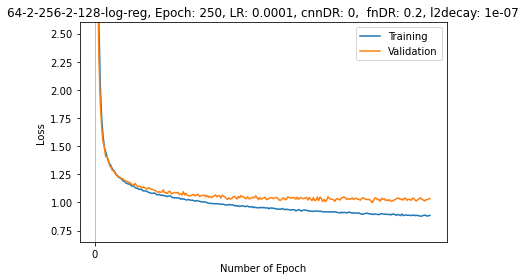

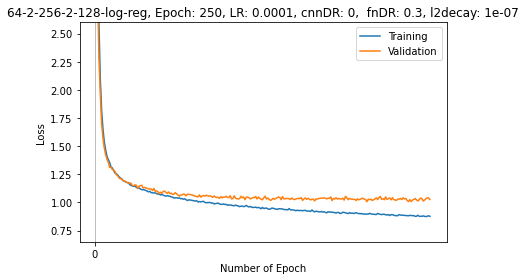

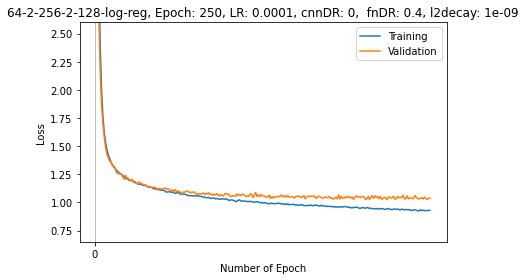

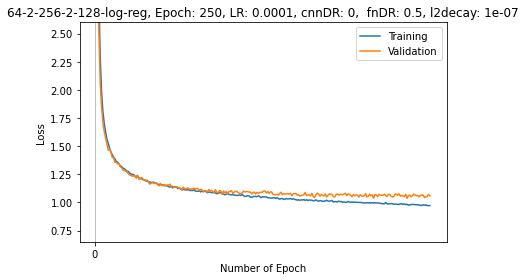

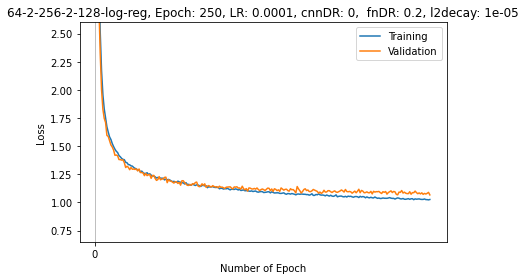

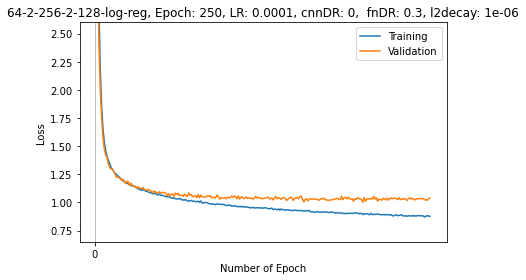

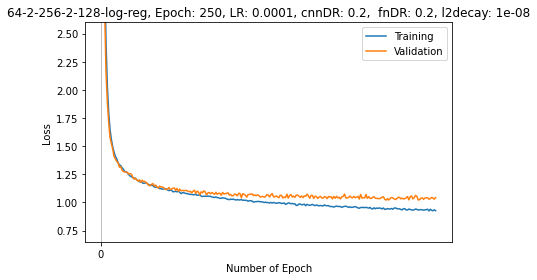

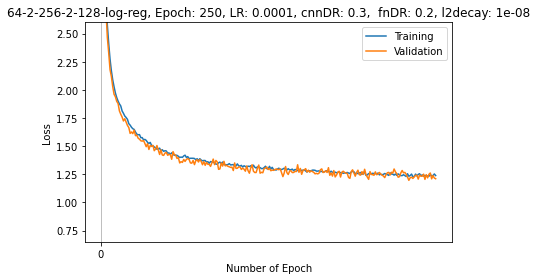

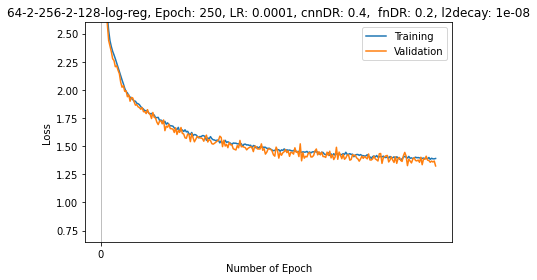

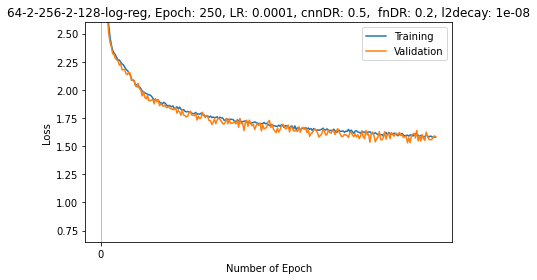

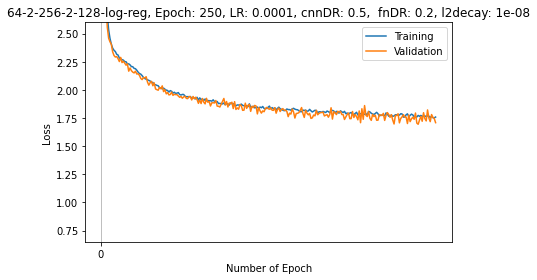

In [142]:
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-08'
Train_Loss=[5.619389057159424, 3.665861129760742, 2.590445041656494, 2.038693904876709, 1.7627631425857544, 1.6005456447601318, 1.4934860467910767, 1.4499766826629639, 1.4092599153518677, 1.3667833805084229, 1.34258234500885, 1.3254117965698242, 1.2966512441635132, 1.2846357822418213, 1.268728494644165, 1.2419548034667969, 1.2378275394439697, 1.2219904661178589, 1.215847134590149, 1.2052924633026123, 1.1912145614624023, 1.1875518560409546, 1.1736606359481812, 1.168867826461792, 1.1624668836593628, 1.1640104055404663, 1.14906644821167, 1.1442750692367554, 1.1432629823684692, 1.1321898698806763, 1.1255884170532227, 1.1247594356536865, 1.1145776510238647, 1.1186238527297974, 1.1122539043426514, 1.1019830703735352, 1.1023519039154053, 1.1013069152832031, 1.0970532894134521, 1.0896682739257812, 1.0862376689910889, 1.080844759941101, 1.0801643133163452, 1.0841084718704224, 1.0799555778503418, 1.0690711736679077, 1.0676708221435547, 1.0726131200790405, 1.0624232292175293, 1.0663982629776, 1.060835838317871, 1.0584771633148193, 1.0574349164962769, 1.0518308877944946, 1.056951880455017, 1.0586607456207275, 1.0508956909179688, 1.041598916053772, 1.0428425073623657, 1.0399224758148193, 1.039687991142273, 1.0395830869674683, 1.0381226539611816, 1.028557300567627, 1.0341464281082153, 1.0289115905761719, 1.028512716293335, 1.0218771696090698, 1.0227183103561401, 1.0264219045639038, 1.0202335119247437, 1.0191839933395386, 1.0195931196212769, 1.0139604806900024, 1.0112982988357544, 1.0169670581817627, 1.0121413469314575, 1.010611891746521, 1.0065431594848633, 1.005531668663025, 1.00257408618927, 1.0063384771347046, 0.9997245669364929, 0.9975148439407349, 0.9931166768074036, 0.9908667206764221, 0.991509199142456, 0.9889736175537109, 0.9889658689498901, 0.9887868165969849, 0.988918125629425, 0.9880493879318237, 0.9836085438728333, 0.9844909310340881, 0.9834755659103394, 0.9835271239280701, 0.9790967702865601, 0.9767813682556152, 0.9777069091796875, 0.9809869527816772, 0.9781534075737, 0.9800443053245544, 0.9792805910110474, 0.9689734578132629, 0.9744096994400024, 0.9657673239707947, 0.9718070030212402, 0.9637860655784607, 0.9682634472846985, 0.9690677523612976, 0.9691882729530334, 0.9618988037109375, 0.9647231101989746, 0.9685454368591309, 0.9600585103034973, 0.9591947793960571, 0.9636406302452087, 0.9541507363319397, 0.9593320488929749, 0.9532982707023621, 0.9532395601272583, 0.9519351124763489, 0.9512166380882263, 0.9576008319854736, 0.9507550597190857, 0.9563325643539429, 0.9515003561973572, 0.9502733945846558, 0.9525349140167236, 0.9426923394203186, 0.9517935514450073, 0.9489415884017944, 0.9494622945785522, 0.9445945620536804, 0.9451839327812195, 0.9386088848114014, 0.9413644671440125, 0.9406641721725464, 0.9398584961891174, 0.9464975595474243, 0.9391325116157532, 0.9356697797775269, 0.9406850934028625, 0.9349206686019897, 0.9365981221199036, 0.9316743612289429, 0.9352449178695679, 0.9351599812507629, 0.9350441694259644, 0.9237409234046936, 0.9299719929695129, 0.9368199706077576, 0.9322910308837891, 0.922220766544342, 0.9292606711387634, 0.9323657155036926, 0.931937575340271, 0.9309142231941223, 0.9243572950363159, 0.9256733655929565, 0.9218252301216125, 0.9209034442901611, 0.9214216470718384, 0.9212088584899902, 0.9242518544197083, 0.924454927444458, 0.9202282428741455, 0.9220902323722839, 0.9209593534469604, 0.9157983064651489, 0.9170200228691101, 0.9163293242454529, 0.9159110188484192, 0.9152843952178955, 0.9170335531234741, 0.9130925536155701, 0.917569100856781, 0.9137429594993591, 0.9184136986732483, 0.9126853942871094, 0.9120692014694214, 0.9091421365737915, 0.9054428935050964, 0.9139844179153442, 0.9075922966003418, 0.9108923077583313, 0.9102553129196167, 0.9070221781730652, 0.9113176465034485, 0.9149672985076904, 0.9066160917282104, 0.9084678292274475, 0.9027292132377625, 0.9077370166778564, 0.9044560790061951, 0.9049596190452576, 0.9071119427680969, 0.899300217628479, 0.8953876495361328, 0.8953554034233093, 0.8979231119155884, 0.9024533033370972, 0.9051140546798706, 0.8986620903015137, 0.9013300538063049, 0.8938724994659424, 0.8980363607406616, 0.8917061686515808, 0.8977589011192322, 0.8954809904098511, 0.8941875100135803, 0.8906310200691223, 0.8995180726051331, 0.899997889995575, 0.8964471220970154, 0.8945645689964294, 0.896199107170105, 0.8926834464073181, 0.8948116302490234, 0.8924203515052795, 0.8892706036567688, 0.8972218036651611, 0.8954143524169922, 0.8919479250907898, 0.8850505352020264, 0.8931278586387634, 0.8894311189651489, 0.8820673227310181, 0.8975023031234741, 0.8831952810287476, 0.885940670967102, 0.8890759348869324, 0.8856277465820312, 0.8848091959953308, 0.8869863748550415, 0.8823533654212952, 0.8867310285568237, 0.8880404233932495, 0.8816123008728027, 0.8862219452857971, 0.8825258016586304, 0.8814333081245422, 0.8779550790786743, 0.8779541850090027, 0.8843741416931152, 0.8868714570999146, 0.8838818073272705, 0.8777042031288147, 0.8818698525428772, 0.8849302530288696]
Test_Loss=[4.489625930786133, 3.0335350036621094, 2.278311014175415, 1.8863427639007568, 1.6733624935150146, 1.542644739151001, 1.4940170049667358, 1.4054213762283325, 1.4089312553405762, 1.3794151544570923, 1.3236585855484009, 1.3145256042480469, 1.2838668823242188, 1.281123161315918, 1.2587188482284546, 1.2489643096923828, 1.227558970451355, 1.229566216468811, 1.2222095727920532, 1.2095037698745728, 1.2072645425796509, 1.1959378719329834, 1.1908721923828125, 1.1870815753936768, 1.1804319620132446, 1.1787914037704468, 1.1622458696365356, 1.1626347303390503, 1.1450109481811523, 1.168898105621338, 1.1519562005996704, 1.1391726732254028, 1.1428821086883545, 1.1427675485610962, 1.127210021018982, 1.139212727546692, 1.1308685541152954, 1.1251437664031982, 1.1180564165115356, 1.132535696029663, 1.1242934465408325, 1.1154509782791138, 1.1157220602035522, 1.1087290048599243, 1.1058346033096313, 1.0974828004837036, 1.0891021490097046, 1.095463514328003, 1.090386986732483, 1.0921504497528076, 1.1120187044143677, 1.0858278274536133, 1.087249517440796, 1.0810707807540894, 1.0951685905456543, 1.099000096321106, 1.0758384466171265, 1.0820757150650024, 1.0875532627105713, 1.0870342254638672, 1.0858579874038696, 1.0884294509887695, 1.0712358951568604, 1.0758668184280396, 1.0660152435302734, 1.09557044506073, 1.0653891563415527, 1.0803765058517456, 1.062522530555725, 1.0604617595672607, 1.0560903549194336, 1.0624260902404785, 1.0705138444900513, 1.0661588907241821, 1.0586777925491333, 1.0675798654556274, 1.0723522901535034, 1.0526434183120728, 1.0569920539855957, 1.062550663948059, 1.0600450038909912, 1.06551194190979, 1.0487092733383179, 1.0614266395568848, 1.0456771850585938, 1.0524038076400757, 1.0419842004776, 1.0518051385879517, 1.058112621307373, 1.0668517351150513, 1.0490407943725586, 1.0617055892944336, 1.055897831916809, 1.0383535623550415, 1.0649808645248413, 1.0531266927719116, 1.0495330095291138, 1.0347448587417603, 1.0272557735443115, 1.0404596328735352, 1.0306271314620972, 1.0335063934326172, 1.0484484434127808, 1.0536011457443237, 1.0423824787139893, 1.0295941829681396, 1.0525375604629517, 1.0401408672332764, 1.0608123540878296, 1.0518128871917725, 1.048229694366455, 1.038179874420166, 1.0317455530166626, 1.0506534576416016, 1.032839059829712, 1.0341259241104126, 1.042683720588684, 1.0465160608291626, 1.039857268333435, 1.0587440729141235, 1.044779896736145, 1.0238088369369507, 1.0451058149337769, 1.0292117595672607, 1.0338393449783325, 1.0377336740493774, 1.045756459236145, 1.0267269611358643, 1.028181552886963, 1.0365853309631348, 1.040852427482605, 1.04130220413208, 1.0338510274887085, 1.0376625061035156, 1.044270634651184, 1.0421591997146606, 1.0280702114105225, 1.018302083015442, 1.0219082832336426, 1.0352933406829834, 1.040321946144104, 1.0244017839431763, 1.0291728973388672, 1.0495381355285645, 1.042974829673767, 1.039651870727539, 1.0378657579421997, 1.0417248010635376, 1.0406583547592163, 1.0289279222488403, 1.0462762117385864, 1.0273447036743164, 1.0433415174484253, 1.0409424304962158, 1.0333877801895142, 1.0346227884292603, 1.039838433265686, 1.0443456172943115, 1.0210472345352173, 1.043858528137207, 1.0293183326721191, 1.0151472091674805, 1.04190194606781, 1.016488790512085, 1.020508885383606, 1.04824697971344, 1.016754150390625, 1.0471845865249634, 1.0345730781555176, 1.007459044456482, 1.026044487953186, 1.0062605142593384, 1.0205004215240479, 1.0510307550430298, 1.0343643426895142, 1.0288879871368408, 1.0273030996322632, 1.0254238843917847, 1.0091511011123657, 1.0282701253890991, 1.0339387655258179, 1.0260835886001587, 1.0219712257385254, 1.0406585931777954, 1.04241144657135, 1.0484789609909058, 1.0405220985412598, 1.026767373085022, 1.034698486328125, 1.0283713340759277, 1.0315839052200317, 1.0406067371368408, 1.0266867876052856, 1.0334863662719727, 1.0364066362380981, 1.029131531715393, 1.0281692743301392, 1.0198842287063599, 1.0328837633132935, 1.0418115854263306, 1.0357533693313599, 1.027509331703186, 1.026788353919983, 1.025545358657837, 1.0251375436782837, 1.0137544870376587, 0.997585117816925, 1.0171048641204834, 1.0407297611236572, 1.0375701189041138, 1.0229620933532715, 1.0276336669921875, 1.0105643272399902, 1.0371702909469604, 1.0277267694473267, 1.0335123538970947, 1.0165622234344482, 1.0243231058120728, 1.0151824951171875, 1.0232429504394531, 1.0114845037460327, 1.0120536088943481, 1.0207148790359497, 1.0245565176010132, 1.033022403717041, 1.0392147302627563, 1.0372332334518433, 1.0251240730285645, 1.0321502685546875, 1.0197901725769043, 1.038508653640747, 1.035573959350586, 1.0187323093414307, 1.0278536081314087, 1.0261071920394897, 1.0187870264053345, 1.0372581481933594, 1.037060022354126, 1.0186176300048828, 1.0134942531585693, 1.0256593227386475, 1.033342719078064, 1.0418516397476196, 1.026199221611023, 1.0225915908813477, 1.0124189853668213, 1.024636149406433, 1.023613691329956, 1.0313241481781006, 1.0342962741851807]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-07'
lossGraph(Train_Loss, Test_Loss, appendix)
Train_Loss=[5.029962539672852, 3.4475090503692627, 2.592625617980957, 2.104557752609253, 1.819760799407959, 1.653876781463623, 1.5389643907546997, 1.4685009717941284, 1.4102452993392944, 1.3800355195999146, 1.354798674583435, 1.3143900632858276, 1.3063523769378662, 1.282435417175293, 1.260636568069458, 1.2555797100067139, 1.2438472509384155, 1.2286094427108765, 1.2169831991195679, 1.2096216678619385, 1.1933560371398926, 1.1903849840164185, 1.1816178560256958, 1.1768211126327515, 1.1757193803787231, 1.158461570739746, 1.1514188051223755, 1.1459100246429443, 1.143512487411499, 1.1435372829437256, 1.1339386701583862, 1.1265395879745483, 1.12839674949646, 1.1199901103973389, 1.1131852865219116, 1.1127309799194336, 1.1122767925262451, 1.1052124500274658, 1.1011589765548706, 1.0931365489959717, 1.0991588830947876, 1.0863275527954102, 1.0851285457611084, 1.0840259790420532, 1.0847798585891724, 1.078490972518921, 1.0728912353515625, 1.0740083456039429, 1.0660773515701294, 1.0710551738739014, 1.0642690658569336, 1.0592851638793945, 1.0557738542556763, 1.0601110458374023, 1.0561866760253906, 1.054869294166565, 1.0484296083450317, 1.0470765829086304, 1.0389084815979004, 1.0406968593597412, 1.041452169418335, 1.037214756011963, 1.0401512384414673, 1.0332003831863403, 1.034250020980835, 1.0283377170562744, 1.0326118469238281, 1.0249226093292236, 1.016640067100525, 1.0222604274749756, 1.0217564105987549, 1.0192844867706299, 1.0162678956985474, 1.0134872198104858, 1.012047290802002, 1.014858603477478, 1.003819227218628, 1.0076392889022827, 1.0052886009216309, 1.007529616355896, 1.0098313093185425, 1.0005525350570679, 0.9972348809242249, 0.9982848763465881, 0.999284029006958, 0.999109148979187, 0.9940559267997742, 0.9944742918014526, 0.9860249757766724, 0.989497721195221, 0.9917510151863098, 0.9938206076622009, 0.9860807061195374, 0.983697772026062, 0.9827216267585754, 0.9855588674545288, 0.9813276529312134, 0.9832715392112732, 0.9742811322212219, 0.9785504937171936, 0.9761981964111328, 0.9754589796066284, 0.9714163541793823, 0.9702938795089722, 0.9763132333755493, 0.9712044596672058, 0.9689247608184814, 0.962107241153717, 0.9663975238800049, 0.9673857688903809, 0.962485671043396, 0.965946614742279, 0.972944974899292, 0.9643470644950867, 0.9595186114311218, 0.9643189311027527, 0.9574055075645447, 0.9550032615661621, 0.9566187858581543, 0.9577574729919434, 0.9526933431625366, 0.9554782509803772, 0.9512977600097656, 0.9438580870628357, 0.9556388854980469, 0.9459847807884216, 0.9486170411109924, 0.9502005577087402, 0.9433344602584839, 0.9387769103050232, 0.9414076805114746, 0.9496392011642456, 0.9482649564743042, 0.9438685178756714, 0.9417805075645447, 0.9369503855705261, 0.9439827799797058, 0.9431409239768982, 0.9414515495300293, 0.9419951438903809, 0.9368879199028015, 0.936543345451355, 0.9357265830039978, 0.9347310662269592, 0.9447859525680542, 0.9336804747581482, 0.9333949089050293, 0.9334179759025574, 0.9308884143829346, 0.9261898398399353, 0.9311280846595764, 0.9268136620521545, 0.9284909963607788, 0.9282791018486023, 0.9259388446807861, 0.9291777610778809, 0.9294702410697937, 0.9235557913780212, 0.923428475856781, 0.922583818435669, 0.9201356172561646, 0.932855486869812, 0.9215985536575317, 0.9157842397689819, 0.9224957823753357, 0.9191049337387085, 0.9166954755783081, 0.9160701632499695, 0.9186963438987732, 0.9142143130302429, 0.9168828725814819, 0.9112196564674377, 0.9074470400810242, 0.9174609780311584, 0.9129781126976013, 0.9160212278366089, 0.911202073097229, 0.9118173718452454, 0.9091067910194397, 0.9051035642623901, 0.9116681814193726, 0.9100241661071777, 0.9008696675300598, 0.9044106006622314, 0.912760317325592, 0.9112455248832703, 0.9073207378387451, 0.9048779010772705, 0.9007618427276611, 0.9088843464851379, 0.9030705690383911, 0.9061628580093384, 0.9008480906486511, 0.905616044998169, 0.9086887836456299, 0.902461588382721, 0.9015945792198181, 0.8986338376998901, 0.9018805623054504, 0.8960016965866089, 0.8978987336158752, 0.8953480124473572, 0.8969092965126038, 0.8961578011512756, 0.9031932353973389, 0.8975285887718201, 0.8961306214332581, 0.8955525755882263, 0.8929135203361511, 0.8922426104545593, 0.9023401141166687, 0.8968213796615601, 0.893857479095459, 0.891672670841217, 0.8948579430580139, 0.8941007256507874, 0.8909683227539062, 0.887689471244812, 0.8921904563903809, 0.8836169242858887, 0.8913094401359558, 0.8907502889633179, 0.8872489929199219, 0.8829163908958435, 0.8824394941329956, 0.8818534016609192, 0.89183509349823, 0.8882235288619995, 0.885965883731842, 0.8865872621536255, 0.8848319053649902, 0.8830393552780151, 0.8828149437904358, 0.8810256123542786, 0.8855728507041931, 0.8829013705253601, 0.8827125430107117, 0.8824382424354553, 0.8765878081321716, 0.8768264651298523, 0.8860758543014526, 0.8766281008720398, 0.8766335248947144, 0.876867413520813, 0.8801732659339905, 0.8762869834899902, 0.874234139919281, 0.8770753741264343, 0.8811501264572144, 0.876240611076355]
Test_Loss=[4.086164474487305, 2.9077718257904053, 2.2830896377563477, 1.9665883779525757, 1.7019325494766235, 1.5723347663879395, 1.4842758178710938, 1.4238027334213257, 1.384918451309204, 1.3563718795776367, 1.3107802867889404, 1.3126764297485352, 1.292728066444397, 1.2884809970855713, 1.2737252712249756, 1.246287226676941, 1.237752914428711, 1.2175849676132202, 1.2099993228912354, 1.208315134048462, 1.1951195001602173, 1.1912107467651367, 1.1835161447525024, 1.1761932373046875, 1.1718724966049194, 1.1722691059112549, 1.1696618795394897, 1.1489349603652954, 1.1493103504180908, 1.156441330909729, 1.1519688367843628, 1.125069499015808, 1.1446768045425415, 1.1497050523757935, 1.1527537107467651, 1.1283836364746094, 1.133811593055725, 1.1290456056594849, 1.1241334676742554, 1.1200724840164185, 1.1199978590011597, 1.119354248046875, 1.1056158542633057, 1.1246591806411743, 1.098695158958435, 1.1029380559921265, 1.0950273275375366, 1.0781822204589844, 1.0909323692321777, 1.0802900791168213, 1.0994815826416016, 1.0995988845825195, 1.0891083478927612, 1.07999849319458, 1.093189001083374, 1.078959584236145, 1.0823030471801758, 1.0713331699371338, 1.0733774900436401, 1.0863169431686401, 1.0752851963043213, 1.0653215646743774, 1.0564032793045044, 1.0663552284240723, 1.0653822422027588, 1.073752522468567, 1.0725940465927124, 1.0584156513214111, 1.072556495666504, 1.0718214511871338, 1.0707260370254517, 1.0670140981674194, 1.0658133029937744, 1.060245156288147, 1.054250717163086, 1.0515931844711304, 1.0492994785308838, 1.0669224262237549, 1.0477640628814697, 1.0561975240707397, 1.0620249509811401, 1.055519461631775, 1.0644683837890625, 1.0595475435256958, 1.055031418800354, 1.0593465566635132, 1.0528430938720703, 1.0451263189315796, 1.0569249391555786, 1.0483144521713257, 1.043912649154663, 1.0453094244003296, 1.03537118434906, 1.0515056848526, 1.039941430091858, 1.0490972995758057, 1.046002984046936, 1.0547757148742676, 1.0445656776428223, 1.0431180000305176, 1.0589176416397095, 1.0309935808181763, 1.0347988605499268, 1.0584636926651, 1.0383843183517456, 1.0320903062820435, 1.031349778175354, 1.0334535837173462, 1.0547186136245728, 1.0406333208084106, 1.0488280057907104, 1.0242204666137695, 1.047422170639038, 1.0460963249206543, 1.0408846139907837, 1.0313061475753784, 1.0381641387939453, 1.0434613227844238, 1.041231632232666, 1.0532034635543823, 1.0305840969085693, 1.0483338832855225, 1.0355669260025024, 1.0294924974441528, 1.0232479572296143, 1.0405917167663574, 1.0556503534317017, 1.0300545692443848, 1.0395127534866333, 1.0274194478988647, 1.0180069208145142, 1.024078369140625, 1.036185622215271, 1.0280200242996216, 1.0362037420272827, 1.041015386581421, 1.048482894897461, 1.044201135635376, 1.0241578817367554, 1.051629662513733, 1.031378149986267, 1.0324087142944336, 1.036390781402588, 1.033768892288208, 1.0320295095443726, 1.0268007516860962, 1.039276361465454, 1.0301473140716553, 1.0246387720108032, 1.031363844871521, 1.0332598686218262, 1.03592848777771, 1.0332934856414795, 1.0425807237625122, 1.0179002285003662, 1.0313396453857422, 1.0403872728347778, 1.0270050764083862, 1.0365240573883057, 1.0298691987991333, 1.0218228101730347, 1.0297361612319946, 1.0280488729476929, 1.0137261152267456, 1.0310693979263306, 1.0294008255004883, 1.03459894657135, 1.0363224744796753, 1.039126992225647, 1.0366976261138916, 1.0405426025390625, 1.0372662544250488, 1.0312546491622925, 1.0380032062530518, 1.0356858968734741, 1.0488439798355103, 1.0160784721374512, 1.036163330078125, 1.029559850692749, 1.0418089628219604, 1.0292584896087646, 1.0356190204620361, 1.0307681560516357, 1.030811071395874, 1.0375783443450928, 1.0202300548553467, 1.0536028146743774, 1.0420184135437012, 1.0235832929611206, 1.0359910726547241, 1.02973473072052, 1.0289875268936157, 1.0263696908950806, 1.0275402069091797, 1.0172590017318726, 1.0319381952285767, 1.023222804069519, 1.0275214910507202, 1.0350192785263062, 1.0358680486679077, 1.0294666290283203, 1.026267647743225, 1.0060803890228271, 1.0283910036087036, 1.0241565704345703, 1.0286122560501099, 1.0173698663711548, 1.0239977836608887, 1.0303754806518555, 1.0418071746826172, 1.0243678092956543, 1.042472004890442, 1.053483009338379, 1.0268834829330444, 1.0332199335098267, 1.0242468118667603, 1.0490365028381348, 1.026143193244934, 1.032777190208435, 1.040004014968872, 1.0226141214370728, 1.0422343015670776, 1.0245232582092285, 1.0222676992416382, 1.0182116031646729, 1.0298938751220703, 1.0292344093322754, 1.0355695486068726, 1.0254546403884888, 1.0407060384750366, 1.030691146850586, 1.0347145795822144, 1.01827073097229, 1.0072412490844727, 1.0249007940292358, 1.0078606605529785, 1.0210219621658325, 1.0254018306732178, 1.035523533821106, 1.0230934619903564, 1.012683629989624, 1.0235297679901123, 1.0382295846939087, 1.0344449281692505, 1.012115240097046, 1.0211998224258423, 1.0337637662887573, 1.0409300327301025, 1.040205478668213, 1.0260366201400757]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.3, l2decay: 1e-07'
lossGraph(Train_Loss, Test_Loss, appendix)
Train_Loss=[6.131680011749268, 4.154688835144043, 3.0198497772216797, 2.3839516639709473, 2.004210948944092, 1.7685099840164185, 1.6236096620559692, 1.5349370241165161, 1.4733132123947144, 1.4234652519226074, 1.3937751054763794, 1.3580663204193115, 1.3362195491790771, 1.3161197900772095, 1.3065367937088013, 1.2875611782073975, 1.2765065431594849, 1.2656885385513306, 1.2558292150497437, 1.2471299171447754, 1.2375199794769287, 1.2297608852386475, 1.2146905660629272, 1.209953784942627, 1.2028920650482178, 1.1937965154647827, 1.1945184469223022, 1.1948509216308594, 1.1815528869628906, 1.183668851852417, 1.170761227607727, 1.1627520322799683, 1.1617707014083862, 1.1642017364501953, 1.1565303802490234, 1.1523313522338867, 1.1499947309494019, 1.1512287855148315, 1.1400684118270874, 1.1384127140045166, 1.1363202333450317, 1.134121298789978, 1.1282380819320679, 1.1200531721115112, 1.1210929155349731, 1.1174753904342651, 1.11887526512146, 1.111896276473999, 1.11167573928833, 1.1071932315826416, 1.1097978353500366, 1.1049306392669678, 1.0929272174835205, 1.0923359394073486, 1.0950202941894531, 1.0932610034942627, 1.0909833908081055, 1.0912513732910156, 1.0876414775848389, 1.0798213481903076, 1.083709716796875, 1.0884727239608765, 1.0830659866333008, 1.0718536376953125, 1.0769282579421997, 1.0719671249389648, 1.072906732559204, 1.0699396133422852, 1.0642974376678467, 1.0588006973266602, 1.0614135265350342, 1.060472846031189, 1.0593944787979126, 1.056577205657959, 1.0602123737335205, 1.0553686618804932, 1.0635671615600586, 1.0538313388824463, 1.0539309978485107, 1.0515388250350952, 1.0473618507385254, 1.048140525817871, 1.0410311222076416, 1.0426604747772217, 1.045302391052246, 1.036453127861023, 1.0375926494598389, 1.0368047952651978, 1.0398969650268555, 1.031530737876892, 1.0331497192382812, 1.03350031375885, 1.0281449556350708, 1.0273460149765015, 1.034346103668213, 1.0302910804748535, 1.0283783674240112, 1.0327552556991577, 1.027835488319397, 1.0167649984359741, 1.0201694965362549, 1.0229572057724, 1.0194218158721924, 1.0171350240707397, 1.0056999921798706, 1.0113065242767334, 1.018755316734314, 1.0229618549346924, 1.0133343935012817, 1.0096886157989502, 1.0137346982955933, 1.0111455917358398, 1.0090872049331665, 1.0085171461105347, 1.0074949264526367, 1.0095880031585693, 1.006413459777832, 1.0053218603134155, 1.0008498430252075, 1.003436803817749, 1.0069953203201294, 1.003619909286499, 0.998620867729187, 0.9962583780288696, 0.9995751976966858, 0.9929322600364685, 0.9984277486801147, 0.995527982711792, 0.987701416015625, 0.9902399778366089, 0.9891391396522522, 0.9942097067832947, 0.9890355467796326, 0.9896448850631714, 0.9886578917503357, 0.9909729361534119, 0.9947046041488647, 0.9898119568824768, 0.987949788570404, 0.9872370362281799, 0.983077883720398, 0.9882508516311646, 0.9804543256759644, 0.9883651733398438, 0.97931307554245, 0.9809238910675049, 0.9812048673629761, 0.984645664691925, 0.977676510810852, 0.9801324605941772, 0.9754895567893982, 0.9765771627426147, 0.9754849672317505, 0.9791091084480286, 0.9790387749671936, 0.9696590900421143, 0.9718855023384094, 0.9707996249198914, 0.9747223258018494, 0.971710205078125, 0.9777698516845703, 0.9711614847183228, 0.9702335000038147, 0.9776361584663391, 0.9738094210624695, 0.974291980266571, 0.9700305461883545, 0.9662242531776428, 0.9750775694847107, 0.9691722393035889, 0.9680002927780151, 0.9675552248954773, 0.96563720703125, 0.9655159711837769, 0.9642555117607117, 0.9646828174591064, 0.9640222191810608, 0.9583479166030884, 0.9633679986000061, 0.9584130644798279, 0.9589167237281799, 0.9616299867630005, 0.9587261080741882, 0.9624218344688416, 0.9581090211868286, 0.9639700055122375, 0.9630925059318542, 0.9593128561973572, 0.9554604291915894, 0.9602265954017639, 0.9507136940956116, 0.9532967805862427, 0.9539684653282166, 0.9546051025390625, 0.9594507813453674, 0.9556350708007812, 0.950163722038269, 0.9472826719284058, 0.9510336518287659, 0.9557709097862244, 0.9489009380340576, 0.9493972659111023, 0.9545908570289612, 0.9526464343070984, 0.9463548064231873, 0.9479638934135437, 0.9445033669471741, 0.9449898600578308, 0.9414294362068176, 0.9458142518997192, 0.9429840445518494, 0.9428077340126038, 0.9460378289222717, 0.9434080719947815, 0.9435662031173706, 0.9375055432319641, 0.9404933452606201, 0.9425837993621826, 0.9457711577415466, 0.9403334259986877, 0.9374286532402039, 0.9352272748947144, 0.9415134787559509, 0.9412896037101746, 0.9377561807632446, 0.9410156607627869, 0.9361193776130676, 0.9339652061462402, 0.940762996673584, 0.9378368854522705, 0.9337445497512817, 0.9365354776382446, 0.9366282224655151, 0.9344250559806824, 0.9353787302970886, 0.9272324442863464, 0.9300965070724487, 0.9345320463180542, 0.9325212240219116, 0.9300011992454529, 0.9256317019462585, 0.9246430993080139, 0.9359132647514343, 0.927047610282898, 0.9311838746070862, 0.9268079400062561, 0.9277430176734924, 0.9294940829277039, 0.9287244081497192, 0.9294047951698303]
Test_Loss=[5.059239864349365, 3.4789838790893555, 2.656498432159424, 2.159618854522705, 1.8676296472549438, 1.6998082399368286, 1.5862386226654053, 1.489233374595642, 1.4253618717193604, 1.3988922834396362, 1.3666012287139893, 1.366426944732666, 1.3278868198394775, 1.3286516666412354, 1.3073595762252808, 1.27007257938385, 1.2541528940200806, 1.2576043605804443, 1.2505459785461426, 1.2506070137023926, 1.2219713926315308, 1.2059835195541382, 1.2394683361053467, 1.2175424098968506, 1.2138645648956299, 1.1968415975570679, 1.1960339546203613, 1.2044874429702759, 1.175602912902832, 1.1775730848312378, 1.1706873178482056, 1.1690155267715454, 1.1834396123886108, 1.1716077327728271, 1.1649574041366577, 1.1621346473693848, 1.1543806791305542, 1.1543978452682495, 1.1445605754852295, 1.1333670616149902, 1.1431515216827393, 1.1326653957366943, 1.1337131261825562, 1.1357131004333496, 1.1299166679382324, 1.1282541751861572, 1.112600326538086, 1.1229451894760132, 1.1208759546279907, 1.1209259033203125, 1.1185734272003174, 1.1267163753509521, 1.1277692317962646, 1.1148650646209717, 1.1205083131790161, 1.107992172241211, 1.1053290367126465, 1.1117671728134155, 1.0957590341567993, 1.1146568059921265, 1.0975435972213745, 1.1018540859222412, 1.0958744287490845, 1.0905170440673828, 1.0773677825927734, 1.0922725200653076, 1.0883958339691162, 1.1001124382019043, 1.102141261100769, 1.0900213718414307, 1.0928013324737549, 1.08572256565094, 1.090604543685913, 1.0945374965667725, 1.0788589715957642, 1.076368808746338, 1.07387375831604, 1.0790725946426392, 1.0731885433197021, 1.0791281461715698, 1.0826053619384766, 1.0699113607406616, 1.082542061805725, 1.07541024684906, 1.0858232975006104, 1.0692899227142334, 1.0747530460357666, 1.0618659257888794, 1.0737146139144897, 1.064587950706482, 1.0786027908325195, 1.0662297010421753, 1.0575262308120728, 1.0692964792251587, 1.0589689016342163, 1.0589661598205566, 1.0778993368148804, 1.078063726425171, 1.0717575550079346, 1.074331521987915, 1.0529066324234009, 1.054269552230835, 1.060346245765686, 1.057559609413147, 1.054092526435852, 1.0764548778533936, 1.0630196332931519, 1.0702769756317139, 1.0598255395889282, 1.071484088897705, 1.0734297037124634, 1.0582574605941772, 1.0510519742965698, 1.0600566864013672, 1.05372154712677, 1.077049732208252, 1.0721744298934937, 1.043073058128357, 1.065447449684143, 1.08879816532135, 1.0527269840240479, 1.066461205482483, 1.0512995719909668, 1.0701026916503906, 1.0586903095245361, 1.0568326711654663, 1.0547200441360474, 1.0442057847976685, 1.0499264001846313, 1.0658575296401978, 1.0355499982833862, 1.0529637336730957, 1.0380511283874512, 1.051214337348938, 1.0474117994308472, 1.0501583814620972, 1.0559885501861572, 1.048810362815857, 1.0672273635864258, 1.0599253177642822, 1.0475223064422607, 1.060418725013733, 1.0475825071334839, 1.062540054321289, 1.0471148490905762, 1.0470808744430542, 1.0514142513275146, 1.0495926141738892, 1.0381312370300293, 1.052079677581787, 1.0578871965408325, 1.052480936050415, 1.0550962686538696, 1.0408849716186523, 1.0496526956558228, 1.0613839626312256, 1.0310604572296143, 1.0468701124191284, 1.0553556680679321, 1.0546067953109741, 1.0550907850265503, 1.0567508935928345, 1.0525918006896973, 1.0562337636947632, 1.0349477529525757, 1.0448788404464722, 1.05615234375, 1.0508081912994385, 1.0445950031280518, 1.0341248512268066, 1.0415534973144531, 1.0486246347427368, 1.0423431396484375, 1.0464850664138794, 1.0526515245437622, 1.0362426042556763, 1.0403399467468262, 1.0283701419830322, 1.0354763269424438, 1.047739028930664, 1.0303503274917603, 1.067389726638794, 1.0313125848770142, 1.0554744005203247, 1.0354068279266357, 1.0390692949295044, 1.0511646270751953, 1.0410717725753784, 1.0546842813491821, 1.0461571216583252, 1.0388050079345703, 1.0485029220581055, 1.0275354385375977, 1.0460366010665894, 1.0575867891311646, 1.0501458644866943, 1.04972505569458, 1.0417038202285767, 1.0490585565567017, 1.0541589260101318, 1.0468074083328247, 1.026167392730713, 1.0317069292068481, 1.0526210069656372, 1.0270750522613525, 1.0495256185531616, 1.0608830451965332, 1.036590814590454, 1.0591329336166382, 1.0443655252456665, 1.0519185066223145, 1.0333298444747925, 1.0533738136291504, 1.027716875076294, 1.0359785556793213, 1.0444517135620117, 1.040813684463501, 1.024001955986023, 1.0473291873931885, 1.0460501909255981, 1.039080262184143, 1.0433014631271362, 1.055527925491333, 1.0285723209381104, 1.0334336757659912, 1.0547350645065308, 1.0409752130508423, 1.046742558479309, 1.0430347919464111, 1.0643324851989746, 1.0300767421722412, 1.0323323011398315, 1.0582520961761475, 1.032216191291809, 1.0376826524734497, 1.0398964881896973, 1.0324459075927734, 1.0378729104995728, 1.06179678440094, 1.0434319972991943, 1.03372061252594, 1.0315377712249756, 1.0358036756515503, 1.0412782430648804, 1.030035376548767, 1.048298716545105, 1.0359864234924316, 1.0265014171600342, 1.0368921756744385, 1.0378077030181885]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.4, l2decay: 1e-09'
lossGraph(Train_Loss, Test_Loss, appendix)
Train_Loss=[5.540877342224121, 3.832308769226074, 2.8428847789764404, 2.2940146923065186, 1.9860587120056152, 1.8065869808197021, 1.7036303281784058, 1.6282308101654053, 1.5617196559906006, 1.5250039100646973, 1.482337236404419, 1.4489915370941162, 1.4240041971206665, 1.4024769067764282, 1.388262152671814, 1.3627785444259644, 1.3584944009780884, 1.3430767059326172, 1.323952317237854, 1.3190385103225708, 1.304773211479187, 1.298703670501709, 1.2896300554275513, 1.2766004800796509, 1.2751561403274536, 1.2599306106567383, 1.2527906894683838, 1.2491737604141235, 1.247199535369873, 1.2292261123657227, 1.2348363399505615, 1.2293037176132202, 1.2174062728881836, 1.2092264890670776, 1.2125426530838013, 1.2024420499801636, 1.2013400793075562, 1.1903005838394165, 1.1961203813552856, 1.1844940185546875, 1.1812512874603271, 1.1770720481872559, 1.1787314414978027, 1.1789745092391968, 1.1749247312545776, 1.1703838109970093, 1.1610920429229736, 1.1597756147384644, 1.1586722135543823, 1.1542112827301025, 1.1557637453079224, 1.1484124660491943, 1.1517125368118286, 1.147171974182129, 1.1402381658554077, 1.1362768411636353, 1.1435117721557617, 1.1293373107910156, 1.138215184211731, 1.1381779909133911, 1.1382737159729004, 1.1216703653335571, 1.1286230087280273, 1.1193323135375977, 1.1166425943374634, 1.1155200004577637, 1.1117136478424072, 1.1110807657241821, 1.1102302074432373, 1.1153860092163086, 1.1050268411636353, 1.1075689792633057, 1.1059261560440063, 1.1121360063552856, 1.1009700298309326, 1.0987468957901, 1.1006217002868652, 1.1018242835998535, 1.0936232805252075, 1.1014134883880615, 1.094411849975586, 1.1041538715362549, 1.0948237180709839, 1.0860995054244995, 1.0916757583618164, 1.0924770832061768, 1.0856651067733765, 1.088805079460144, 1.087450623512268, 1.0842725038528442, 1.0769628286361694, 1.081871509552002, 1.0849896669387817, 1.0901274681091309, 1.0772556066513062, 1.0745134353637695, 1.0670844316482544, 1.073400855064392, 1.0799965858459473, 1.07240629196167, 1.0682059526443481, 1.0667226314544678, 1.0691659450531006, 1.0650951862335205, 1.0644217729568481, 1.0615284442901611, 1.063289999961853, 1.0656782388687134, 1.061729907989502, 1.069610834121704, 1.0597368478775024, 1.052630066871643, 1.0552374124526978, 1.0600039958953857, 1.0586862564086914, 1.0469087362289429, 1.0451401472091675, 1.0514003038406372, 1.0531463623046875, 1.0535364151000977, 1.0515437126159668, 1.0583138465881348, 1.0529940128326416, 1.041866660118103, 1.0509233474731445, 1.0489249229431152, 1.0492784976959229, 1.0486148595809937, 1.0419740676879883, 1.0409126281738281, 1.03876531124115, 1.0380744934082031, 1.0413739681243896, 1.0423988103866577, 1.0345021486282349, 1.0425746440887451, 1.0335674285888672, 1.0287408828735352, 1.0339117050170898, 1.0336843729019165, 1.0261926651000977, 1.0296052694320679, 1.033890724182129, 1.0304867029190063, 1.032918095588684, 1.0340688228607178, 1.0279899835586548, 1.0326288938522339, 1.0277820825576782, 1.0247982740402222, 1.0201836824417114, 1.0235826969146729, 1.0185056924819946, 1.0228849649429321, 1.0214852094650269, 1.0253697633743286, 1.017907738685608, 1.0237159729003906, 1.0169013738632202, 1.021288275718689, 1.0203560590744019, 1.0197340250015259, 1.0140491724014282, 1.0163679122924805, 1.0228205919265747, 1.0143990516662598, 1.0108709335327148, 1.016294002532959, 1.014216423034668, 1.0091650485992432, 1.0117028951644897, 1.0126206874847412, 1.0196962356567383, 1.01167631149292, 1.0110989809036255, 1.0135650634765625, 1.0178961753845215, 1.0035831928253174, 1.0067839622497559, 1.0070691108703613, 1.004656195640564, 1.0114833116531372, 1.0064502954483032, 1.0073670148849487, 1.002152442932129, 1.0030914545059204, 1.000777006149292, 1.0009592771530151, 1.0090928077697754, 1.0045948028564453, 0.9987773895263672, 1.0055986642837524, 0.9988787770271301, 1.003317952156067, 1.0010552406311035, 1.0013322830200195, 0.9990869164466858, 1.0008350610733032, 0.998349666595459, 0.9982056021690369, 0.9938247203826904, 0.9956749677658081, 0.9985136985778809, 0.9939906597137451, 0.9980739951133728, 0.9937232136726379, 0.9984102845191956, 0.9943220019340515, 0.99724942445755, 0.9945690631866455, 0.9949141144752502, 0.9952489733695984, 0.9905546307563782, 0.9909434914588928, 0.987769365310669, 0.9880176186561584, 0.9985796213150024, 0.9883611798286438, 0.9863222241401672, 0.9887853860855103, 0.9892877340316772, 0.9897931814193726, 0.9836580157279968, 0.9849010109901428, 0.9849488139152527, 0.9821319580078125, 0.9817026257514954, 0.9878004789352417, 0.9867234826087952, 0.9819036722183228, 0.987758219242096, 0.980906069278717, 0.9832553863525391, 0.9756700396537781, 0.978360116481781, 0.9811092019081116, 0.9832414388656616, 0.9809357523918152, 0.9800589680671692, 0.9792705178260803, 0.9795843362808228, 0.9769961833953857, 0.9737309217453003, 0.9734492301940918, 0.9790085554122925, 0.9735565185546875, 0.9785377383232117, 0.9721322655677795, 0.9721983671188354, 0.9720003008842468]
Test_Loss=[4.599914073944092, 3.249187469482422, 2.5217771530151367, 2.0617613792419434, 1.8549801111221313, 1.7134490013122559, 1.6315542459487915, 1.5752111673355103, 1.5236338376998901, 1.4633740186691284, 1.4737305641174316, 1.4463127851486206, 1.4000416994094849, 1.3979895114898682, 1.3563929796218872, 1.3560988903045654, 1.3442081212997437, 1.3455859422683716, 1.3156400918960571, 1.3099784851074219, 1.2857197523117065, 1.286146640777588, 1.278897762298584, 1.2720656394958496, 1.2554951906204224, 1.2427072525024414, 1.2388532161712646, 1.233043909072876, 1.2380807399749756, 1.2315856218338013, 1.2153173685073853, 1.241199254989624, 1.2054685354232788, 1.2148386240005493, 1.2210224866867065, 1.2069568634033203, 1.1949890851974487, 1.1987993717193604, 1.185452938079834, 1.1828151941299438, 1.1622426509857178, 1.1708992719650269, 1.1767475605010986, 1.1678625345230103, 1.1763814687728882, 1.1736576557159424, 1.155537486076355, 1.1478806734085083, 1.1686649322509766, 1.1501737833023071, 1.1475406885147095, 1.1562453508377075, 1.1475279331207275, 1.1556369066238403, 1.1526368856430054, 1.1631357669830322, 1.1395868062973022, 1.1449331045150757, 1.1325923204421997, 1.1350593566894531, 1.1398236751556396, 1.1308971643447876, 1.1289087533950806, 1.1248197555541992, 1.1063648462295532, 1.1359819173812866, 1.1220152378082275, 1.1199452877044678, 1.1281977891921997, 1.1251189708709717, 1.1133261919021606, 1.122183918952942, 1.119253158569336, 1.1284176111221313, 1.117260456085205, 1.1245149374008179, 1.1228082180023193, 1.105472207069397, 1.1167293787002563, 1.1112865209579468, 1.0956817865371704, 1.1024434566497803, 1.1036125421524048, 1.0921236276626587, 1.1144967079162598, 1.1048997640609741, 1.1076956987380981, 1.0970821380615234, 1.0894360542297363, 1.1132923364639282, 1.0886338949203491, 1.086213231086731, 1.1051841974258423, 1.102307677268982, 1.0723119974136353, 1.1014738082885742, 1.0853108167648315, 1.0963356494903564, 1.078966498374939, 1.096199870109558, 1.0973505973815918, 1.1042624711990356, 1.079295039176941, 1.0912208557128906, 1.0987085103988647, 1.0973789691925049, 1.08604097366333, 1.0807764530181885, 1.0773464441299438, 1.083450436592102, 1.101542592048645, 1.09217369556427, 1.0971825122833252, 1.0960431098937988, 1.091074824333191, 1.092915654182434, 1.075599193572998, 1.0873314142227173, 1.091806173324585, 1.0755765438079834, 1.0903161764144897, 1.0813833475112915, 1.0890436172485352, 1.0899580717086792, 1.091119647026062, 1.1011817455291748, 1.1011559963226318, 1.0830456018447876, 1.0967658758163452, 1.080736756324768, 1.0937038660049438, 1.0926690101623535, 1.0703893899917603, 1.0688021183013916, 1.068442702293396, 1.071454405784607, 1.064953327178955, 1.0815839767456055, 1.0901923179626465, 1.0696195363998413, 1.0776746273040771, 1.0732231140136719, 1.076135516166687, 1.077894687652588, 1.0745692253112793, 1.0801787376403809, 1.059823751449585, 1.0759798288345337, 1.0763722658157349, 1.0804557800292969, 1.063519835472107, 1.0694289207458496, 1.056996464729309, 1.0615642070770264, 1.0657049417495728, 1.0677293539047241, 1.088356614112854, 1.0617629289627075, 1.0657230615615845, 1.068471908569336, 1.0582231283187866, 1.0810778141021729, 1.05274498462677, 1.0444427728652954, 1.0675312280654907, 1.0817152261734009, 1.0751160383224487, 1.055614709854126, 1.0716001987457275, 1.063352346420288, 1.0579015016555786, 1.0756539106369019, 1.0478352308273315, 1.0612424612045288, 1.076363205909729, 1.0726377964019775, 1.0708894729614258, 1.0502511262893677, 1.048351764678955, 1.0697520971298218, 1.0748693943023682, 1.0647424459457397, 1.0723313093185425, 1.0700194835662842, 1.0680855512619019, 1.0743249654769897, 1.0820437669754028, 1.0610508918762207, 1.0767525434494019, 1.0696824789047241, 1.0633543729782104, 1.05088472366333, 1.069805383682251, 1.0596107244491577, 1.0671590566635132, 1.0635910034179688, 1.047732949256897, 1.0681663751602173, 1.0575015544891357, 1.053719401359558, 1.0595916509628296, 1.077495813369751, 1.0491365194320679, 1.0539987087249756, 1.0726990699768066, 1.05842125415802, 1.0669342279434204, 1.0372107028961182, 1.0687048435211182, 1.0667850971221924, 1.052526831626892, 1.071577548980713, 1.064223289489746, 1.0624408721923828, 1.064308762550354, 1.0728882551193237, 1.0625406503677368, 1.0533896684646606, 1.0711766481399536, 1.0716497898101807, 1.0557975769042969, 1.0495771169662476, 1.0504399538040161, 1.0736944675445557, 1.0726864337921143, 1.063020944595337, 1.0765855312347412, 1.055652379989624, 1.0618218183517456, 1.0573924779891968, 1.0521389245986938, 1.0723555088043213, 1.036292314529419, 1.062341332435608, 1.065032958984375, 1.0498133897781372, 1.0595508813858032, 1.0741764307022095, 1.06388258934021, 1.059075951576233, 1.0632201433181763, 1.0488649606704712, 1.06307053565979, 1.0641571283340454, 1.0654929876327515, 1.0428396463394165, 1.0514848232269287, 1.0502986907958984, 1.0705106258392334, 1.0595202445983887]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.5, l2decay: 1e-07'
lossGraph(Train_Loss, Test_Loss, appendix)
Train_Loss=[5.3115234375, 3.867830514907837, 3.0698211193084717, 2.517395257949829, 2.1700193881988525, 1.9582511186599731, 1.8314698934555054, 1.7505930662155151, 1.672539472579956, 1.6249711513519287, 1.5818475484848022, 1.5591670274734497, 1.5229421854019165, 1.4960134029388428, 1.4727809429168701, 1.4544872045516968, 1.4432122707366943, 1.4168049097061157, 1.4055813550949097, 1.3909471035003662, 1.3827060461044312, 1.3797587156295776, 1.356648564338684, 1.3525584936141968, 1.3362630605697632, 1.3342540264129639, 1.324806571006775, 1.3225188255310059, 1.3106738328933716, 1.3027130365371704, 1.2988520860671997, 1.2844479084014893, 1.2894755601882935, 1.2698402404785156, 1.2786190509796143, 1.2650949954986572, 1.2569327354431152, 1.257595419883728, 1.263981580734253, 1.248568058013916, 1.254507303237915, 1.243025779724121, 1.2345227003097534, 1.2348142862319946, 1.2273025512695312, 1.2168201208114624, 1.2219359874725342, 1.2181438207626343, 1.216168999671936, 1.2149523496627808, 1.2152997255325317, 1.1998097896575928, 1.206726312637329, 1.201637625694275, 1.204254388809204, 1.199084997177124, 1.1905393600463867, 1.185059905052185, 1.187488079071045, 1.1829895973205566, 1.1783939599990845, 1.1890428066253662, 1.182734489440918, 1.179190993309021, 1.174560546875, 1.1741385459899902, 1.1637150049209595, 1.1757879257202148, 1.1594549417495728, 1.1605433225631714, 1.1536552906036377, 1.1534130573272705, 1.1647309064865112, 1.155442714691162, 1.1505355834960938, 1.1562384366989136, 1.1548422574996948, 1.1491858959197998, 1.1419572830200195, 1.1510391235351562, 1.151213526725769, 1.1469614505767822, 1.1483955383300781, 1.1306194067001343, 1.1400296688079834, 1.1366795301437378, 1.1385620832443237, 1.1403069496154785, 1.1346160173416138, 1.132800817489624, 1.1330457925796509, 1.1340440511703491, 1.121116042137146, 1.1264824867248535, 1.1247901916503906, 1.1187337636947632, 1.1222000122070312, 1.1208479404449463, 1.1249572038650513, 1.1180528402328491, 1.1112560033798218, 1.1186989545822144, 1.1163579225540161, 1.115226149559021, 1.1204285621643066, 1.1167359352111816, 1.1105763912200928, 1.1159316301345825, 1.105905532836914, 1.1084433794021606, 1.1112312078475952, 1.1036361455917358, 1.104540228843689, 1.1057277917861938, 1.1002604961395264, 1.0992919206619263, 1.1025360822677612, 1.0967905521392822, 1.0996336936950684, 1.1012532711029053, 1.0935359001159668, 1.0911645889282227, 1.0947816371917725, 1.0963293313980103, 1.0959593057632446, 1.0878372192382812, 1.0892938375473022, 1.091064214706421, 1.0942296981811523, 1.0945429801940918, 1.084814429283142, 1.0940061807632446, 1.0884684324264526, 1.0838803052902222, 1.0850931406021118, 1.0855424404144287, 1.0848212242126465, 1.080431342124939, 1.0798014402389526, 1.0826512575149536, 1.085163950920105, 1.0762369632720947, 1.0726139545440674, 1.0790271759033203, 1.0776002407073975, 1.0738391876220703, 1.07906174659729, 1.0762172937393188, 1.072588324546814, 1.0672372579574585, 1.0738959312438965, 1.0749200582504272, 1.0724270343780518, 1.074868083000183, 1.0732609033584595, 1.072484016418457, 1.072162389755249, 1.0694451332092285, 1.0698521137237549, 1.0644950866699219, 1.0686689615249634, 1.0769504308700562, 1.0622999668121338, 1.0626963376998901, 1.0707101821899414, 1.0674697160720825, 1.076072096824646, 1.0677335262298584, 1.0648019313812256, 1.0658559799194336, 1.063559889793396, 1.0583454370498657, 1.065986156463623, 1.0611861944198608, 1.0560095310211182, 1.063704252243042, 1.0563360452651978, 1.0540343523025513, 1.0581005811691284, 1.067286729812622, 1.0499378442764282, 1.054004430770874, 1.0560760498046875, 1.0564005374908447, 1.0512278079986572, 1.0494390726089478, 1.0542972087860107, 1.047835350036621, 1.0557903051376343, 1.0527821779251099, 1.054728627204895, 1.0495023727416992, 1.0459858179092407, 1.0516144037246704, 1.0524320602416992, 1.0503959655761719, 1.0435998439788818, 1.0541132688522339, 1.0479815006256104, 1.0522024631500244, 1.0492664575576782, 1.0411666631698608, 1.0491790771484375, 1.0429937839508057, 1.0407698154449463, 1.0459277629852295, 1.0410172939300537, 1.0399693250656128, 1.0480901002883911, 1.041318416595459, 1.03638756275177, 1.0391464233398438, 1.034640908241272, 1.035831093788147, 1.0394468307495117, 1.0369541645050049, 1.0368672609329224, 1.036597490310669, 1.0390249490737915, 1.0427532196044922, 1.0375996828079224, 1.0357882976531982, 1.0361415147781372, 1.0298986434936523, 1.0359975099563599, 1.0400762557983398, 1.0374224185943604, 1.0319910049438477, 1.0310711860656738, 1.0350679159164429, 1.0284141302108765, 1.0279141664505005, 1.03022038936615, 1.0333607196807861, 1.0273072719573975, 1.0324047803878784, 1.0329551696777344, 1.0242681503295898, 1.0314664840698242, 1.0285680294036865, 1.0296971797943115, 1.031459927558899, 1.0277893543243408, 1.0265607833862305, 1.0267807245254517, 1.030763864517212, 1.025046706199646, 1.0248433351516724, 1.0225194692611694, 1.025914192199707]
Test_Loss=[4.509097576141357, 3.4599673748016357, 2.7733280658721924, 2.3293075561523438, 2.003476142883301, 1.8288854360580444, 1.747223973274231, 1.7110792398452759, 1.5956077575683594, 1.5863873958587646, 1.5483567714691162, 1.5106182098388672, 1.4924179315567017, 1.4648475646972656, 1.418847680091858, 1.421234130859375, 1.4144543409347534, 1.3811254501342773, 1.380568504333496, 1.3754866123199463, 1.3788756132125854, 1.3535535335540771, 1.3101080656051636, 1.3216171264648438, 1.3118120431900024, 1.290662407875061, 1.3104788064956665, 1.2947624921798706, 1.2967627048492432, 1.2932360172271729, 1.2980866432189941, 1.2797666788101196, 1.2968413829803467, 1.2656631469726562, 1.265745997428894, 1.2622487545013428, 1.237732172012329, 1.2568711042404175, 1.2383321523666382, 1.2459237575531006, 1.247483491897583, 1.2141876220703125, 1.23922598361969, 1.240159273147583, 1.2132484912872314, 1.195877194404602, 1.2027039527893066, 1.229203701019287, 1.2009985446929932, 1.2085117101669312, 1.2076373100280762, 1.2222827672958374, 1.2244001626968384, 1.1756024360656738, 1.2020145654678345, 1.1902225017547607, 1.1888664960861206, 1.1800177097320557, 1.1719545125961304, 1.183786392211914, 1.1825387477874756, 1.1686924695968628, 1.1774539947509766, 1.153424859046936, 1.1928737163543701, 1.192553162574768, 1.1751139163970947, 1.16416597366333, 1.152127981185913, 1.1511311531066895, 1.1597944498062134, 1.1524772644042969, 1.1666613817214966, 1.1620761156082153, 1.176690697669983, 1.180804967880249, 1.1460245847702026, 1.1395394802093506, 1.1485581398010254, 1.1652486324310303, 1.1519376039505005, 1.1653883457183838, 1.1346361637115479, 1.1448808908462524, 1.1500786542892456, 1.1417427062988281, 1.1377416849136353, 1.149111270904541, 1.1411205530166626, 1.1370980739593506, 1.1401020288467407, 1.13064706325531, 1.1440973281860352, 1.1348141431808472, 1.1362173557281494, 1.129916787147522, 1.1241567134857178, 1.1349501609802246, 1.1364701986312866, 1.1381219625473022, 1.1387494802474976, 1.1273471117019653, 1.119824767112732, 1.1374582052230835, 1.1358871459960938, 1.1391545534133911, 1.1273479461669922, 1.128866195678711, 1.1179546117782593, 1.1439709663391113, 1.1219182014465332, 1.1127864122390747, 1.1228560209274292, 1.100548267364502, 1.1289079189300537, 1.1268140077590942, 1.1200295686721802, 1.11896550655365, 1.1244416236877441, 1.1178897619247437, 1.1283702850341797, 1.1149340867996216, 1.1054425239562988, 1.113978624343872, 1.1194182634353638, 1.113603115081787, 1.1054996252059937, 1.1160449981689453, 1.1271377801895142, 1.1254507303237915, 1.10433030128479, 1.119576096534729, 1.0976370573043823, 1.1211692094802856, 1.1158190965652466, 1.1049869060516357, 1.111802101135254, 1.0981543064117432, 1.1286708116531372, 1.1193593740463257, 1.109241247177124, 1.1159894466400146, 1.117557168006897, 1.105516791343689, 1.1001724004745483, 1.1217001676559448, 1.1123931407928467, 1.1145554780960083, 1.1024117469787598, 1.0847078561782837, 1.141194224357605, 1.1195918321609497, 1.1035614013671875, 1.0837175846099854, 1.0968748331069946, 1.1148866415023804, 1.1212166547775269, 1.105407476425171, 1.110532522201538, 1.096510887145996, 1.0962742567062378, 1.1030330657958984, 1.1150604486465454, 1.1089870929718018, 1.10202157497406, 1.0977306365966797, 1.0825154781341553, 1.092123031616211, 1.0801994800567627, 1.0883636474609375, 1.1081351041793823, 1.0916690826416016, 1.0930705070495605, 1.1044411659240723, 1.104109525680542, 1.0951001644134521, 1.0883351564407349, 1.0971404314041138, 1.1024640798568726, 1.0924562215805054, 1.089428186416626, 1.0956902503967285, 1.1018788814544678, 1.1107455492019653, 1.1033583879470825, 1.0919908285140991, 1.115268349647522, 1.0970908403396606, 1.0944489240646362, 1.097718358039856, 1.094260811805725, 1.0821326971054077, 1.0911060571670532, 1.1004352569580078, 1.0856913328170776, 1.0993711948394775, 1.1169209480285645, 1.0862153768539429, 1.1065441370010376, 1.100341796875, 1.0856455564498901, 1.0876524448394775, 1.0939738750457764, 1.0864263772964478, 1.085429310798645, 1.0982049703598022, 1.075968861579895, 1.0987573862075806, 1.0917996168136597, 1.0955877304077148, 1.0952409505844116, 1.0974606275558472, 1.0873421430587769, 1.0793211460113525, 1.0951179265975952, 1.0900222063064575, 1.0966745615005493, 1.0736050605773926, 1.0877685546875, 1.0950512886047363, 1.1028082370758057, 1.0877712965011597, 1.0976885557174683, 1.0940104722976685, 1.0715347528457642, 1.0675699710845947, 1.0918420553207397, 1.0897314548492432, 1.1057549715042114, 1.0831056833267212, 1.0912492275238037, 1.0820518732070923, 1.0783498287200928, 1.078208327293396, 1.0950579643249512, 1.07281494140625, 1.087026834487915, 1.0861691236495972, 1.1007028818130493, 1.0873013734817505, 1.0774770975112915, 1.0844542980194092, 1.0758405923843384, 1.0851902961730957, 1.0717674493789673, 1.0802260637283325, 1.0745227336883545, 1.0807685852050781, 1.0894185304641724, 1.0668624639511108]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.2, l2decay: 1e-05'
lossGraph(Train_Loss, Test_Loss, appendix)
Train_Loss=[5.8574628829956055, 3.8512954711914062, 2.7517507076263428, 2.174468994140625, 1.8581430912017822, 1.658996343612671, 1.5371886491775513, 1.4648644924163818, 1.410342812538147, 1.3751620054244995, 1.3456424474716187, 1.311945915222168, 1.296891689300537, 1.2738040685653687, 1.2595664262771606, 1.25123131275177, 1.2365549802780151, 1.2271630764007568, 1.2142494916915894, 1.2016738653182983, 1.1929196119308472, 1.1843421459197998, 1.1756266355514526, 1.1719480752944946, 1.1630592346191406, 1.1550593376159668, 1.1513949632644653, 1.1449018716812134, 1.142420768737793, 1.1422659158706665, 1.1295826435089111, 1.126354694366455, 1.115897297859192, 1.1160815954208374, 1.1053054332733154, 1.1173932552337646, 1.105680227279663, 1.0994549989700317, 1.097558856010437, 1.092017412185669, 1.0867564678192139, 1.0857675075531006, 1.0761744976043701, 1.0778721570968628, 1.083866834640503, 1.0705280303955078, 1.0654971599578857, 1.0752699375152588, 1.063097357749939, 1.0618183612823486, 1.06217622756958, 1.0562810897827148, 1.0516386032104492, 1.0506139993667603, 1.0515130758285522, 1.0443601608276367, 1.040833830833435, 1.03696608543396, 1.0403143167495728, 1.032501220703125, 1.032407522201538, 1.030962347984314, 1.0321130752563477, 1.0343695878982544, 1.0213935375213623, 1.021683692932129, 1.0217790603637695, 1.0238547325134277, 1.012168049812317, 1.0129026174545288, 1.0142682790756226, 1.017572283744812, 1.0099681615829468, 1.0114234685897827, 1.007381796836853, 1.0062047243118286, 1.0112202167510986, 1.0017993450164795, 1.013331413269043, 0.9943649768829346, 0.9973078370094299, 0.9995219707489014, 0.9985520243644714, 0.997747540473938, 0.988817036151886, 0.9891756772994995, 0.9848070740699768, 0.9879098534584045, 0.9820955395698547, 0.9806771874427795, 0.9866728782653809, 0.9843255281448364, 0.9846376180648804, 0.9819976687431335, 0.9814029335975647, 0.9815189242362976, 0.9766135811805725, 0.9723824262619019, 0.9744868874549866, 0.9747021198272705, 0.9764942526817322, 0.9660449624061584, 0.9675447344779968, 0.9697344899177551, 0.9705901145935059, 0.9621288180351257, 0.9646449685096741, 0.9615689516067505, 0.9645453095436096, 0.9581977725028992, 0.9648704528808594, 0.9584649801254272, 0.9596293568611145, 0.9563971161842346, 0.9573819041252136, 0.950924813747406, 0.9538073539733887, 0.9561110138893127, 0.9502790570259094, 0.9513770937919617, 0.9524028301239014, 0.9533267617225647, 0.9500032663345337, 0.9519811868667603, 0.9488294720649719, 0.9501521587371826, 0.9532029032707214, 0.9492177367210388, 0.9460246562957764, 0.9434421062469482, 0.9447681307792664, 0.9500255584716797, 0.9361259937286377, 0.9403497576713562, 0.9393576383590698, 0.9339975118637085, 0.9432173371315002, 0.9304757714271545, 0.9417300224304199, 0.9360427856445312, 0.9328707456588745, 0.9304915070533752, 0.934157133102417, 0.9342713952064514, 0.9320276975631714, 0.9313212037086487, 0.9256110787391663, 0.9299338459968567, 0.9291905760765076, 0.9310747385025024, 0.9276252388954163, 0.9260388612747192, 0.9288278222084045, 0.9281861186027527, 0.9238187074661255, 0.9250679016113281, 0.9235330820083618, 0.9280552268028259, 0.9242292642593384, 0.9291982054710388, 0.9152424335479736, 0.9178287386894226, 0.9147756695747375, 0.9135715961456299, 0.9152456521987915, 0.9184448719024658, 0.9130667448043823, 0.9144021272659302, 0.9130006432533264, 0.91586834192276, 0.916233479976654, 0.9129305481910706, 0.9152061939239502, 0.9129262566566467, 0.9087573885917664, 0.9149619936943054, 0.9151629209518433, 0.911615788936615, 0.9073408842086792, 0.9058701395988464, 0.910278856754303, 0.905453622341156, 0.9049923419952393, 0.9077736735343933, 0.9020407795906067, 0.9007590413093567, 0.9011716246604919, 0.9034620523452759, 0.9014500379562378, 0.9052706360816956, 0.9023398160934448, 0.9012081623077393, 0.9044456481933594, 0.9075713157653809, 0.9051278829574585, 0.9072070717811584, 0.898840069770813, 0.9020315408706665, 0.901794970035553, 0.89215087890625, 0.899469792842865, 0.8967828154563904, 0.8991586565971375, 0.8962438702583313, 0.8898111581802368, 0.9033470153808594, 0.8927497863769531, 0.8925134539604187, 0.894393801689148, 0.8937408328056335, 0.8987269997596741, 0.893890380859375, 0.8912640810012817, 0.8904282450675964, 0.8921217918395996, 0.8907426595687866, 0.8898253440856934, 0.8928806781768799, 0.8896046876907349, 0.8887982964515686, 0.8914398550987244, 0.8813987374305725, 0.8804874420166016, 0.8876628875732422, 0.8884950280189514, 0.8819660544395447, 0.8844491243362427, 0.8869119882583618, 0.8899015188217163, 0.8795117139816284, 0.8795481324195862, 0.8814060091972351, 0.8771425485610962, 0.8828129172325134, 0.8797125816345215, 0.881170392036438, 0.8787263631820679, 0.8834710717201233, 0.8787798881530762, 0.8791760206222534, 0.8846338391304016, 0.8815364837646484, 0.8808836936950684, 0.880635142326355, 0.8807451128959656, 0.8712331056594849, 0.8769176006317139, 0.8828319907188416, 0.8789392113685608, 0.8762162923812866]
Test_Loss=[4.683475494384766, 3.204145669937134, 2.4135849475860596, 2.002305269241333, 1.7680784463882446, 1.5755431652069092, 1.4751818180084229, 1.4221858978271484, 1.4008899927139282, 1.3440418243408203, 1.3106708526611328, 1.2983551025390625, 1.2947120666503906, 1.2804126739501953, 1.2530149221420288, 1.222808837890625, 1.227948784828186, 1.2179310321807861, 1.2165802717208862, 1.194293737411499, 1.2047443389892578, 1.1882530450820923, 1.1667319536209106, 1.1876028776168823, 1.1823221445083618, 1.1494901180267334, 1.1702224016189575, 1.1495306491851807, 1.1474584341049194, 1.1422563791275024, 1.1264902353286743, 1.1393606662750244, 1.1288615465164185, 1.1275441646575928, 1.124686598777771, 1.1322113275527954, 1.1109356880187988, 1.1119744777679443, 1.1079742908477783, 1.117727279663086, 1.1059844493865967, 1.099227786064148, 1.0851819515228271, 1.1001591682434082, 1.0964707136154175, 1.0843448638916016, 1.0861103534698486, 1.0944921970367432, 1.081068992614746, 1.0892443656921387, 1.0893809795379639, 1.0861663818359375, 1.0832737684249878, 1.0603705644607544, 1.0777469873428345, 1.0603888034820557, 1.0715433359146118, 1.0736585855484009, 1.0535866022109985, 1.082282543182373, 1.0704129934310913, 1.0814228057861328, 1.060707926750183, 1.0661890506744385, 1.0641189813613892, 1.054380178451538, 1.0745855569839478, 1.0586901903152466, 1.053916573524475, 1.0838290452957153, 1.064672589302063, 1.0683284997940063, 1.0497057437896729, 1.0549482107162476, 1.0601121187210083, 1.0433595180511475, 1.0694780349731445, 1.0414035320281982, 1.0650871992111206, 1.0488981008529663, 1.0491420030593872, 1.0482069253921509, 1.0501136779785156, 1.058580994606018, 1.0523625612258911, 1.062329649925232, 1.0386539697647095, 1.0460597276687622, 1.0448676347732544, 1.0400022268295288, 1.0662975311279297, 1.0494935512542725, 1.0301491022109985, 1.043716311454773, 1.0380226373672485, 1.0386606454849243, 1.042623519897461, 1.0316587686538696, 1.0477784872055054, 1.041083812713623, 1.0445659160614014, 1.0555614233016968, 1.0459874868392944, 1.0578900575637817, 1.0510333776474, 1.0311869382858276, 1.0575207471847534, 1.0295414924621582, 1.0475107431411743, 1.0494418144226074, 1.0326766967773438, 1.0382546186447144, 1.0484273433685303, 1.0346037149429321, 1.042277216911316, 1.0348320007324219, 1.0375752449035645, 1.0294636487960815, 1.0381847620010376, 1.0545352697372437, 1.039534568786621, 1.0435949563980103, 1.0372265577316284, 1.039788842201233, 1.0317206382751465, 1.0372235774993896, 1.039284586906433, 1.0426678657531738, 1.0472749471664429, 1.0337331295013428, 1.0319074392318726, 1.039098858833313, 1.021260380744934, 1.0405652523040771, 1.0527511835098267, 1.0307409763336182, 1.0429762601852417, 1.037078619003296, 1.0278303623199463, 1.0409880876541138, 1.0420562028884888, 1.0372066497802734, 1.0173155069351196, 1.0292142629623413, 1.039089560508728, 1.0464149713516235, 1.0401865243911743, 1.016951084136963, 1.037142038345337, 1.036438226699829, 1.0447856187820435, 1.0330967903137207, 1.0525506734848022, 1.0544086694717407, 1.0263173580169678, 1.0048249959945679, 1.0273319482803345, 1.0328184366226196, 1.013097882270813, 1.0299278497695923, 1.032792568206787, 1.0274014472961426, 1.02992582321167, 1.033791184425354, 1.0262576341629028, 1.027940273284912, 1.018445372581482, 1.0262126922607422, 1.0354162454605103, 1.0302177667617798, 1.0382059812545776, 1.0220311880111694, 1.0232259035110474, 1.017785668373108, 1.020538330078125, 1.0207511186599731, 1.0232179164886475, 1.0267993211746216, 1.0284756422042847, 1.033701777458191, 1.0373339653015137, 1.0255085229873657, 1.025202989578247, 1.0536195039749146, 1.0238842964172363, 1.0404267311096191, 1.046042561531067, 1.030430793762207, 1.0466722249984741, 1.0327038764953613, 1.0269699096679688, 1.0330175161361694, 1.0097090005874634, 1.0334703922271729, 1.02761709690094, 1.0425021648406982, 1.0318641662597656, 1.0310171842575073, 1.0248072147369385, 1.0020253658294678, 1.0426875352859497, 1.0105482339859009, 1.0315592288970947, 1.0341694355010986, 1.0282888412475586, 1.036613941192627, 1.0293999910354614, 1.0533758401870728, 1.0285171270370483, 1.0420567989349365, 1.0111252069473267, 1.0300222635269165, 1.0264921188354492, 1.0191614627838135, 1.036318063735962, 1.033237099647522, 1.0224958658218384, 1.0391534566879272, 1.0195003747940063, 1.0344845056533813, 1.0399852991104126, 1.031599760055542, 1.0397692918777466, 1.0348750352859497, 1.0338376760482788, 1.0244566202163696, 1.0418050289154053, 1.0252567529678345, 1.0302435159683228, 1.0283061265945435, 1.03517746925354, 1.0255008935928345, 1.0175275802612305, 1.0346591472625732, 1.0392807722091675, 1.0301289558410645, 1.0371196269989014, 1.0240281820297241, 1.0231690406799316, 1.033510684967041, 1.0302224159240723, 1.0365369319915771, 1.0309559106826782, 1.0368404388427734, 1.0335924625396729, 1.0231817960739136, 1.0239319801330566, 1.01848566532135, 1.0340014696121216, 1.0366296768188477]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0,  fnDR: 0.3, l2decay: 1e-06'
lossGraph(Train_Loss, Test_Loss, appendix)
Train_Loss=[6.272354602813721, 4.212832927703857, 3.0685698986053467, 2.420753240585327, 2.032158136367798, 1.798712134361267, 1.647510290145874, 1.5592280626296997, 1.4944214820861816, 1.4472095966339111, 1.409489631652832, 1.387923002243042, 1.3513659238815308, 1.334573745727539, 1.326229214668274, 1.308351993560791, 1.2937098741531372, 1.273777961730957, 1.2735041379928589, 1.2620971202850342, 1.2464165687561035, 1.2344063520431519, 1.2279289960861206, 1.2198964357376099, 1.217183232307434, 1.2128039598464966, 1.2003865242004395, 1.1936503648757935, 1.1827588081359863, 1.1875381469726562, 1.174880862236023, 1.1692631244659424, 1.172462821006775, 1.1748778820037842, 1.1664016246795654, 1.1510642766952515, 1.1574971675872803, 1.1519646644592285, 1.1493109464645386, 1.1372222900390625, 1.1349762678146362, 1.1349146366119385, 1.1313955783843994, 1.1232186555862427, 1.1222463846206665, 1.1180047988891602, 1.1204488277435303, 1.1221517324447632, 1.1194626092910767, 1.1104284524917603, 1.104496955871582, 1.110205888748169, 1.1072285175323486, 1.093735694885254, 1.0968005657196045, 1.0984359979629517, 1.0936219692230225, 1.1003693342208862, 1.0895360708236694, 1.0784879922866821, 1.0863420963287354, 1.0860310792922974, 1.0814775228500366, 1.079272985458374, 1.076467752456665, 1.0734212398529053, 1.070786476135254, 1.0714929103851318, 1.0684010982513428, 1.0685045719146729, 1.0715008974075317, 1.0637301206588745, 1.063853144645691, 1.0704578161239624, 1.0558221340179443, 1.0527499914169312, 1.0550196170806885, 1.0564837455749512, 1.053652286529541, 1.0566940307617188, 1.054075002670288, 1.054382562637329, 1.0482197999954224, 1.0465823411941528, 1.043764591217041, 1.0490103960037231, 1.043052315711975, 1.0405710935592651, 1.0369911193847656, 1.0370423793792725, 1.041220784187317, 1.0384702682495117, 1.0370348691940308, 1.030761480331421, 1.0274457931518555, 1.02423894405365, 1.0295624732971191, 1.0267810821533203, 1.0295521020889282, 1.0245579481124878, 1.0215145349502563, 1.0249699354171753, 1.0220310688018799, 1.0217865705490112, 1.0259941816329956, 1.0187104940414429, 1.0200122594833374, 1.0184890031814575, 1.0176262855529785, 1.0107228755950928, 1.0154025554656982, 1.013988971710205, 1.0130380392074585, 1.0021512508392334, 1.0054523944854736, 1.0076332092285156, 1.0075619220733643, 1.0096967220306396, 1.0053949356079102, 1.0063079595565796, 1.0036625862121582, 0.9985662698745728, 1.0027495622634888, 0.9987338185310364, 0.9984464049339294, 0.9947657585144043, 0.9993185997009277, 0.9947572946548462, 1.000241756439209, 0.9950419068336487, 0.9925494194030762, 0.9933649301528931, 0.9986488223075867, 0.9958482980728149, 0.9904221892356873, 0.9932918548583984, 0.9953631162643433, 0.9824617505073547, 0.988278865814209, 0.9954605102539062, 0.9935198426246643, 0.9877769351005554, 0.9907505512237549, 0.9866199493408203, 0.9883643984794617, 0.9722573161125183, 0.9750797152519226, 0.9866306185722351, 0.9843462109565735, 0.97854083776474, 0.9806342720985413, 0.984391987323761, 0.9706398844718933, 0.9827286601066589, 0.9770383238792419, 0.9747854471206665, 0.9768214821815491, 0.9826752543449402, 0.9760373830795288, 0.9710437655448914, 0.9774222373962402, 0.9730768799781799, 0.9698402285575867, 0.9730635285377502, 0.9701035022735596, 0.9687339663505554, 0.977994441986084, 0.9712478518486023, 0.9705410003662109, 0.9713250994682312, 0.9643076062202454, 0.9638642072677612, 0.9627890586853027, 0.9588646292686462, 0.9637327790260315, 0.9674617648124695, 0.9644666314125061, 0.9633931517601013, 0.9633222818374634, 0.9561994671821594, 0.9621676206588745, 0.9648007750511169, 0.9661426544189453, 0.9622858762741089, 0.9558473229408264, 0.9607273936271667, 0.9555408358573914, 0.9570852518081665, 0.9597465991973877, 0.9631150960922241, 0.9571357369422913, 0.9513692259788513, 0.9481642842292786, 0.9552387595176697, 0.9544049501419067, 0.9565452933311462, 0.9531625509262085, 0.9562221169471741, 0.9533949494361877, 0.9490633606910706, 0.9556266665458679, 0.9450474977493286, 0.9417011737823486, 0.9525449872016907, 0.9437721967697144, 0.949926495552063, 0.9475712180137634, 0.9505270719528198, 0.9485291838645935, 0.9418011903762817, 0.9505239725112915, 0.9387210011482239, 0.9398014545440674, 0.9451175332069397, 0.9416695833206177, 0.9416704773902893, 0.9459166526794434, 0.9393495321273804, 0.9498029947280884, 0.9505823850631714, 0.946418046951294, 0.9420105814933777, 0.9434827566146851, 0.9376333355903625, 0.9332482218742371, 0.9449939727783203, 0.9434927105903625, 0.9335266947746277, 0.9327753782272339, 0.9413811564445496, 0.9368218183517456, 0.9337652921676636, 0.9312587380409241, 0.9344089031219482, 0.9414899945259094, 0.9382699728012085, 0.9320496320724487, 0.9348885416984558, 0.9359098076820374, 0.9341421723365784, 0.9313348531723022, 0.9332758188247681, 0.9360795617103577, 0.9392609000205994, 0.924785315990448, 0.939174473285675, 0.9296935200691223, 0.9257709980010986, 0.9339041709899902, 0.9264229536056519]
Test_Loss=[5.101109981536865, 3.5363306999206543, 2.7101974487304688, 2.1548690795898438, 1.892363429069519, 1.7093315124511719, 1.5759458541870117, 1.5258591175079346, 1.4737199544906616, 1.408051609992981, 1.3857372999191284, 1.364773154258728, 1.3538528680801392, 1.3125699758529663, 1.3191876411437988, 1.284975290298462, 1.274259328842163, 1.2716795206069946, 1.270141363143921, 1.2660176753997803, 1.2517274618148804, 1.2567369937896729, 1.2497520446777344, 1.2234102487564087, 1.2067099809646606, 1.2155263423919678, 1.2006254196166992, 1.1891422271728516, 1.2000089883804321, 1.179019808769226, 1.1976630687713623, 1.1841627359390259, 1.186539649963379, 1.1745057106018066, 1.1652429103851318, 1.1506963968276978, 1.149598479270935, 1.1604505777359009, 1.1674871444702148, 1.1457682847976685, 1.1540485620498657, 1.1376005411148071, 1.1276556253433228, 1.1454542875289917, 1.1356045007705688, 1.1381231546401978, 1.1305012702941895, 1.1200854778289795, 1.1145521402359009, 1.1197786331176758, 1.1325857639312744, 1.1147814989089966, 1.119502305984497, 1.1271241903305054, 1.1281777620315552, 1.1068772077560425, 1.124321699142456, 1.0995193719863892, 1.117987036705017, 1.1035845279693604, 1.1068700551986694, 1.1036142110824585, 1.1061924695968628, 1.107284426689148, 1.0997365713119507, 1.095145344734192, 1.0994324684143066, 1.0845158100128174, 1.1003940105438232, 1.1076580286026, 1.0805612802505493, 1.1008199453353882, 1.0916436910629272, 1.0675746202468872, 1.0947377681732178, 1.0847259759902954, 1.102829098701477, 1.0940437316894531, 1.067100167274475, 1.0839898586273193, 1.0882184505462646, 1.0768429040908813, 1.0879360437393188, 1.079431414604187, 1.0720100402832031, 1.0903536081314087, 1.0723425149917603, 1.0812371969223022, 1.0807160139083862, 1.0633833408355713, 1.088684320449829, 1.0749483108520508, 1.0783799886703491, 1.0799497365951538, 1.085958480834961, 1.0653282403945923, 1.071447730064392, 1.0577070713043213, 1.0617108345031738, 1.0743824243545532, 1.0701271295547485, 1.0582998991012573, 1.0811220407485962, 1.078600525856018, 1.0412254333496094, 1.077943205833435, 1.0703120231628418, 1.0637329816818237, 1.0474478006362915, 1.0700042247772217, 1.072058916091919, 1.0719822645187378, 1.075909972190857, 1.0609086751937866, 1.065857172012329, 1.0599533319473267, 1.0675311088562012, 1.063459038734436, 1.0489155054092407, 1.0505297183990479, 1.0541578531265259, 1.0465971231460571, 1.0514382123947144, 1.0690901279449463, 1.066741704940796, 1.0486937761306763, 1.0665289163589478, 1.0789783000946045, 1.049541711807251, 1.0498181581497192, 1.058250069618225, 1.0495858192443848, 1.0416401624679565, 1.064337134361267, 1.0617523193359375, 1.039025068283081, 1.0481829643249512, 1.0437934398651123, 1.0731920003890991, 1.0384944677352905, 1.0602329969406128, 1.070086121559143, 1.0484449863433838, 1.055698275566101, 1.0455689430236816, 1.0650643110275269, 1.0642168521881104, 1.0564191341400146, 1.0446559190750122, 1.0570178031921387, 1.0429298877716064, 1.0577312707901, 1.0546153783798218, 1.0732228755950928, 1.059809923171997, 1.0368210077285767, 1.0621694326400757, 1.062198281288147, 1.035343050956726, 1.055592656135559, 1.0513436794281006, 1.0354974269866943, 1.0474885702133179, 1.0536768436431885, 1.0403972864151, 1.0377191305160522, 1.05105459690094, 1.0483137369155884, 1.0336538553237915, 1.0530016422271729, 1.0478028059005737, 1.0496294498443604, 1.031176209449768, 1.0530847311019897, 1.0375959873199463, 1.054685354232788, 1.0403773784637451, 1.0464025735855103, 1.0309197902679443, 1.0509508848190308, 1.052979826927185, 1.0742624998092651, 1.0394227504730225, 1.0408521890640259, 1.0435047149658203, 1.0565687417984009, 1.044742465019226, 1.0408998727798462, 1.0540525913238525, 1.042054533958435, 1.04627525806427, 1.0545631647109985, 1.0296002626419067, 1.0710110664367676, 1.0389416217803955, 1.04232656955719, 1.0399175882339478, 1.0706944465637207, 1.0363150835037231, 1.051780104637146, 1.0365664958953857, 1.0356676578521729, 1.0444387197494507, 1.0512642860412598, 1.0377771854400635, 1.0355561971664429, 1.035075068473816, 1.0329842567443848, 1.038295030593872, 1.047330617904663, 1.0504748821258545, 1.0285470485687256, 1.0202685594558716, 1.0337293148040771, 1.021491527557373, 1.0338456630706787, 1.0433659553527832, 1.0396270751953125, 1.0328254699707031, 1.025688648223877, 1.0335475206375122, 1.0450364351272583, 1.044617772102356, 1.0320693254470825, 1.037839651107788, 1.0312663316726685, 1.033591628074646, 1.0403575897216797, 1.0529762506484985, 1.023124098777771, 1.049997091293335, 1.0577843189239502, 1.0311849117279053, 1.0417855978012085, 1.0629253387451172, 1.0524210929870605, 1.0217137336730957, 1.0242201089859009, 1.038164734840393, 1.039846658706665, 1.0276817083358765, 1.0398075580596924, 1.0408501625061035, 1.0417449474334717, 1.028668999671936, 1.0331374406814575, 1.044760823249817, 1.038393259048462, 1.0289448499679565, 1.042889952659607]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0.2,  fnDR: 0.2, l2decay: 1e-08'
lossGraph(Train_Loss, Test_Loss, appendix)
Train_Loss=[5.858309745788574, 4.160833358764648, 3.2871592044830322, 2.8213229179382324, 2.5745363235473633, 2.413620710372925, 2.2735469341278076, 2.1698408126831055, 2.089519739151001, 2.027789831161499, 1.9727357625961304, 1.9319968223571777, 1.9006479978561401, 1.8756508827209473, 1.8575304746627808, 1.8131402730941772, 1.7920352220535278, 1.7677114009857178, 1.7547663450241089, 1.7382625341415405, 1.6996833086013794, 1.686937689781189, 1.6682342290878296, 1.6548995971679688, 1.6488152742385864, 1.6255006790161133, 1.606519341468811, 1.6011273860931396, 1.602663516998291, 1.5746909379959106, 1.5761512517929077, 1.5563620328903198, 1.5602599382400513, 1.5512274503707886, 1.5342862606048584, 1.5232770442962646, 1.5334159135818481, 1.506314992904663, 1.5034635066986084, 1.492950201034546, 1.484013319015503, 1.4727847576141357, 1.4756232500076294, 1.4823174476623535, 1.4585717916488647, 1.4685959815979004, 1.4538285732269287, 1.459442377090454, 1.4573428630828857, 1.438527226448059, 1.439776062965393, 1.427038550376892, 1.4407380819320679, 1.4299272298812866, 1.418115496635437, 1.420327067375183, 1.4182507991790771, 1.4098492860794067, 1.3998302221298218, 1.4030652046203613, 1.4004889726638794, 1.4131848812103271, 1.4199528694152832, 1.3992012739181519, 1.4070836305618286, 1.3896892070770264, 1.3924214839935303, 1.39264976978302, 1.392387866973877, 1.390511155128479, 1.3792253732681274, 1.3885400295257568, 1.3717401027679443, 1.3884544372558594, 1.3765909671783447, 1.3698581457138062, 1.3729342222213745, 1.3723901510238647, 1.3583964109420776, 1.3619332313537598, 1.3474007844924927, 1.3631184101104736, 1.359719157218933, 1.3579583168029785, 1.3504703044891357, 1.3405581712722778, 1.3394492864608765, 1.3521714210510254, 1.358452558517456, 1.345694661140442, 1.358810544013977, 1.3357170820236206, 1.3349943161010742, 1.334388017654419, 1.3365508317947388, 1.3449050188064575, 1.3327823877334595, 1.3344722986221313, 1.33652663230896, 1.3230760097503662, 1.3249561786651611, 1.3423925638198853, 1.3253635168075562, 1.3230149745941162, 1.3293516635894775, 1.314414620399475, 1.3258079290390015, 1.3199607133865356, 1.3131300210952759, 1.32270085811615, 1.318595051765442, 1.3260444402694702, 1.312597632408142, 1.3312782049179077, 1.3135160207748413, 1.3056997060775757, 1.31620192527771, 1.312496304512024, 1.3093854188919067, 1.3006188869476318, 1.3007746934890747, 1.3096929788589478, 1.3218275308609009, 1.2993873357772827, 1.299117088317871, 1.3205046653747559, 1.2962892055511475, 1.3120228052139282, 1.2923895120620728, 1.2904804944992065, 1.287767767906189, 1.2979729175567627, 1.3043458461761475, 1.2930701971054077, 1.2923495769500732, 1.2969489097595215, 1.3043886423110962, 1.296120047569275, 1.2889115810394287, 1.2998549938201904, 1.2891188859939575, 1.2907932996749878, 1.2959667444229126, 1.2820971012115479, 1.2924364805221558, 1.291023850440979, 1.2821094989776611, 1.2857950925827026, 1.2843706607818604, 1.2850379943847656, 1.2862353324890137, 1.2885448932647705, 1.278900146484375, 1.2699083089828491, 1.2836295366287231, 1.280316948890686, 1.2809404134750366, 1.2869521379470825, 1.2871249914169312, 1.2855231761932373, 1.278351068496704, 1.2780364751815796, 1.2810419797897339, 1.2727673053741455, 1.276573657989502, 1.2700002193450928, 1.2722702026367188, 1.2793347835540771, 1.2821176052093506, 1.2753115892410278, 1.2660801410675049, 1.277910828590393, 1.2676341533660889, 1.2608082294464111, 1.2693405151367188, 1.2633520364761353, 1.266963005065918, 1.2713372707366943, 1.2630817890167236, 1.2652207612991333, 1.2582042217254639, 1.2619489431381226, 1.2620524168014526, 1.266466498374939, 1.2611464262008667, 1.2570966482162476, 1.269758701324463, 1.2759555578231812, 1.27295982837677, 1.2509362697601318, 1.2642133235931396, 1.2552313804626465, 1.2615444660186768, 1.2657585144042969, 1.2489252090454102, 1.2668955326080322, 1.2666432857513428, 1.2402865886688232, 1.244467854499817, 1.2567218542099, 1.2554559707641602, 1.254499077796936, 1.2589139938354492, 1.2565674781799316, 1.2573802471160889, 1.2497637271881104, 1.2618379592895508, 1.2448556423187256, 1.2511430978775024, 1.2462372779846191, 1.24917733669281, 1.257171630859375, 1.2512052059173584, 1.2469079494476318, 1.2401543855667114, 1.2628320455551147, 1.2524951696395874, 1.2512009143829346, 1.2425001859664917, 1.2526088953018188, 1.2400500774383545, 1.2536029815673828, 1.245358943939209, 1.2385287284851074, 1.23832106590271, 1.2461791038513184, 1.2381881475448608, 1.230527639389038, 1.2547426223754883, 1.2327829599380493, 1.2386962175369263, 1.2519259452819824, 1.228974461555481, 1.2301896810531616, 1.2519586086273193, 1.2349307537078857, 1.249177098274231, 1.2549448013305664, 1.2373236417770386, 1.2451220750808716, 1.2334331274032593, 1.240243673324585, 1.2329400777816772, 1.236092448234558, 1.232882022857666, 1.2446259260177612, 1.2386835813522339, 1.237041711807251, 1.2530426979064941, 1.2389132976531982]
Test_Loss=[4.864882469177246, 3.6749186515808105, 2.9993982315063477, 2.6961498260498047, 2.4656333923339844, 2.3300180435180664, 2.1796998977661133, 2.1196281909942627, 2.029752492904663, 1.9607607126235962, 1.9389841556549072, 1.8978753089904785, 1.8793517351150513, 1.8130204677581787, 1.7840508222579956, 1.758780598640442, 1.7238681316375732, 1.743697166442871, 1.71468985080719, 1.6843736171722412, 1.6655343770980835, 1.6135424375534058, 1.6263550519943237, 1.6111139059066772, 1.6425460577011108, 1.5932432413101196, 1.597314715385437, 1.5701860189437866, 1.5621448755264282, 1.547631859779358, 1.544521450996399, 1.5502773523330688, 1.5241782665252686, 1.495273232460022, 1.5220340490341187, 1.4707881212234497, 1.5058943033218384, 1.4975749254226685, 1.507459282875061, 1.459707260131836, 1.47437584400177, 1.5057005882263184, 1.4670426845550537, 1.4262081384658813, 1.4673088788986206, 1.4211019277572632, 1.4180635213851929, 1.438332438468933, 1.4444332122802734, 1.4191220998764038, 1.4261218309402466, 1.4253315925598145, 1.3835188150405884, 1.4515278339385986, 1.424681544303894, 1.4189164638519287, 1.3906584978103638, 1.3980985879898071, 1.3507875204086304, 1.3623098134994507, 1.3557578325271606, 1.3817706108093262, 1.3643475770950317, 1.3830925226211548, 1.3895646333694458, 1.381583571434021, 1.3507215976715088, 1.3488366603851318, 1.373199701309204, 1.335915207862854, 1.3706445693969727, 1.3795435428619385, 1.3591328859329224, 1.3813977241516113, 1.3652318716049194, 1.335079550743103, 1.362977385520935, 1.3295730352401733, 1.3555577993392944, 1.33853280544281, 1.3389642238616943, 1.3202931880950928, 1.3500245809555054, 1.38504159450531, 1.3363717794418335, 1.3732051849365234, 1.3597391843795776, 1.294042944908142, 1.297539234161377, 1.3511368036270142, 1.3229645490646362, 1.3654675483703613, 1.3247612714767456, 1.3296582698822021, 1.3206143379211426, 1.3165972232818604, 1.311393141746521, 1.3131710290908813, 1.2832962274551392, 1.3510175943374634, 1.3021984100341797, 1.3035730123519897, 1.3150746822357178, 1.3158289194107056, 1.292965292930603, 1.3047457933425903, 1.2951799631118774, 1.2775614261627197, 1.3243848085403442, 1.2823225259780884, 1.2595136165618896, 1.3054656982421875, 1.3351325988769531, 1.2776857614517212, 1.2657729387283325, 1.2658735513687134, 1.3031529188156128, 1.3320889472961426, 1.2594796419143677, 1.2679888010025024, 1.263431191444397, 1.3007506132125854, 1.3052414655685425, 1.3146387338638306, 1.2922534942626953, 1.3016018867492676, 1.2816603183746338, 1.2873188257217407, 1.2850115299224854, 1.2907817363739014, 1.297344446182251, 1.2936134338378906, 1.2910940647125244, 1.298636555671692, 1.2632062435150146, 1.2292811870574951, 1.2622199058532715, 1.319148063659668, 1.2646067142486572, 1.2479438781738281, 1.278307557106018, 1.2815099954605103, 1.2653321027755737, 1.2661001682281494, 1.2757339477539062, 1.274450421333313, 1.334771752357483, 1.2674704790115356, 1.3020473718643188, 1.2497999668121338, 1.2831093072891235, 1.2904878854751587, 1.3002334833145142, 1.2703707218170166, 1.2854938507080078, 1.268572449684143, 1.2806000709533691, 1.2738357782363892, 1.2679532766342163, 1.2541356086730957, 1.258446216583252, 1.2532291412353516, 1.2604480981826782, 1.2905315160751343, 1.2980037927627563, 1.2658040523529053, 1.2700868844985962, 1.280812382698059, 1.2662187814712524, 1.3087981939315796, 1.2409472465515137, 1.2613906860351562, 1.2340627908706665, 1.2832480669021606, 1.226523756980896, 1.2434066534042358, 1.2674615383148193, 1.2771401405334473, 1.2255570888519287, 1.2678399085998535, 1.2773685455322266, 1.2671228647232056, 1.2597758769989014, 1.258738398551941, 1.221779465675354, 1.2138546705245972, 1.2737691402435303, 1.2898907661437988, 1.2606807947158813, 1.2331792116165161, 1.2662080526351929, 1.2865873575210571, 1.2466185092926025, 1.242915153503418, 1.273539662361145, 1.2488462924957275, 1.2945713996887207, 1.2475064992904663, 1.2251895666122437, 1.2050365209579468, 1.2740788459777832, 1.2485357522964478, 1.2467247247695923, 1.2413818836212158, 1.2718113660812378, 1.2463449239730835, 1.2519209384918213, 1.2665047645568848, 1.2516834735870361, 1.2423006296157837, 1.234652042388916, 1.220451831817627, 1.247247338294983, 1.2640126943588257, 1.266785740852356, 1.2435084581375122, 1.2680938243865967, 1.2605767250061035, 1.2971558570861816, 1.2708284854888916, 1.2562285661697388, 1.2241312265396118, 1.228973627090454, 1.2621407508850098, 1.2839045524597168, 1.2629179954528809, 1.2668042182922363, 1.2500975131988525, 1.2255487442016602, 1.1963719129562378, 1.2193492650985718, 1.2241716384887695, 1.212992548942566, 1.2275373935699463, 1.24055016040802, 1.2412972450256348, 1.2071809768676758, 1.2428215742111206, 1.2334401607513428, 1.2325403690338135, 1.2511794567108154, 1.204705834388733, 1.246531367301941, 1.218238115310669, 1.2500663995742798, 1.2617212533950806, 1.2095353603363037, 1.2383531332015991, 1.217067837715149, 1.2106409072875977]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0.3,  fnDR: 0.2, l2decay: 1e-08'
lossGraph(Train_Loss, Test_Loss, appendix)
Train_Loss=[5.226454734802246, 3.953737735748291, 3.2898964881896973, 2.8953213691711426, 2.662388801574707, 2.530088424682617, 2.437319755554199, 2.384972333908081, 2.342634916305542, 2.311210870742798, 2.2767996788024902, 2.2386255264282227, 2.2000205516815186, 2.162935256958008, 2.1220345497131348, 2.088782787322998, 2.0542664527893066, 2.014885187149048, 1.9846349954605103, 1.9736040830612183, 1.950484275817871, 1.9358446598052979, 1.9242770671844482, 1.9140894412994385, 1.9008357524871826, 1.8999013900756836, 1.881514310836792, 1.8772538900375366, 1.8682162761688232, 1.8500643968582153, 1.8399467468261719, 1.8292559385299683, 1.8142327070236206, 1.8167688846588135, 1.8088680505752563, 1.7940664291381836, 1.7876794338226318, 1.7910698652267456, 1.7750523090362549, 1.7773160934448242, 1.753592848777771, 1.7537227869033813, 1.755993127822876, 1.7289241552352905, 1.7324174642562866, 1.7238966226577759, 1.7056188583374023, 1.7210187911987305, 1.6945836544036865, 1.707167387008667, 1.6914411783218384, 1.6811631917953491, 1.680570363998413, 1.6774189472198486, 1.6622471809387207, 1.6519478559494019, 1.6481996774673462, 1.6671184301376343, 1.6296623945236206, 1.6484363079071045, 1.643532633781433, 1.6296803951263428, 1.6455647945404053, 1.6269890069961548, 1.6317685842514038, 1.608629584312439, 1.604015588760376, 1.6218775510787964, 1.592911720275879, 1.6034905910491943, 1.6016024351119995, 1.5906070470809937, 1.5742123126983643, 1.5858685970306396, 1.5840511322021484, 1.5937813520431519, 1.5932190418243408, 1.5822134017944336, 1.5514498949050903, 1.5738749504089355, 1.564706563949585, 1.585000991821289, 1.566689372062683, 1.556982159614563, 1.5548899173736572, 1.5484038591384888, 1.5543458461761475, 1.5508121252059937, 1.5291051864624023, 1.5466673374176025, 1.5257879495620728, 1.528892159461975, 1.552281379699707, 1.5330933332443237, 1.5391730070114136, 1.5319249629974365, 1.525553822517395, 1.5139819383621216, 1.5283252000808716, 1.5261821746826172, 1.526434302330017, 1.5204458236694336, 1.5227073431015015, 1.5099372863769531, 1.5223639011383057, 1.4975316524505615, 1.5168730020523071, 1.5179904699325562, 1.5105057954788208, 1.511939525604248, 1.5062813758850098, 1.5082054138183594, 1.4848488569259644, 1.5053315162658691, 1.5035792589187622, 1.4842286109924316, 1.492798924446106, 1.482405662536621, 1.4962995052337646, 1.4934234619140625, 1.4910459518432617, 1.4906657934188843, 1.4903141260147095, 1.4803237915039062, 1.4802706241607666, 1.4811902046203613, 1.4718517065048218, 1.466127872467041, 1.4594780206680298, 1.462388515472412, 1.4739047288894653, 1.467506766319275, 1.4683172702789307, 1.4538770914077759, 1.46709406375885, 1.4622364044189453, 1.4759005308151245, 1.4596726894378662, 1.4680637121200562, 1.4629898071289062, 1.4653668403625488, 1.4616791009902954, 1.4563542604446411, 1.462402105331421, 1.4557292461395264, 1.4550970792770386, 1.4506802558898926, 1.4537020921707153, 1.4543832540512085, 1.4430913925170898, 1.4500004053115845, 1.4466358423233032, 1.4476232528686523, 1.4534603357315063, 1.4415028095245361, 1.448418378829956, 1.440177083015442, 1.4490998983383179, 1.449668049812317, 1.4525253772735596, 1.4476512670516968, 1.448994755744934, 1.429781436920166, 1.431080937385559, 1.4460891485214233, 1.4443495273590088, 1.4289616346359253, 1.425352692604065, 1.4263842105865479, 1.4422188997268677, 1.4170405864715576, 1.431471586227417, 1.4170604944229126, 1.4331752061843872, 1.420047402381897, 1.4325447082519531, 1.4307661056518555, 1.4257471561431885, 1.4249027967453003, 1.424743890762329, 1.4333652257919312, 1.4256746768951416, 1.4461073875427246, 1.427101969718933, 1.4280421733856201, 1.4335085153579712, 1.4262996912002563, 1.4287346601486206, 1.4057751893997192, 1.4209736585617065, 1.4252870082855225, 1.4260227680206299, 1.418426752090454, 1.425232172012329, 1.4163939952850342, 1.415539026260376, 1.4119431972503662, 1.4131278991699219, 1.4245121479034424, 1.4062432050704956, 1.4050390720367432, 1.3912996053695679, 1.4073481559753418, 1.412741780281067, 1.403823733329773, 1.4169237613677979, 1.4018950462341309, 1.4047931432724, 1.4081975221633911, 1.4039132595062256, 1.4115922451019287, 1.4002635478973389, 1.398603916168213, 1.4076347351074219, 1.393236517906189, 1.4084059000015259, 1.3971141576766968, 1.3965966701507568, 1.4051674604415894, 1.3893557786941528, 1.4055119752883911, 1.3975639343261719, 1.3853492736816406, 1.3810021877288818, 1.386993408203125, 1.4020895957946777, 1.4092642068862915, 1.4014742374420166, 1.3940051794052124, 1.4091328382492065, 1.3920542001724243, 1.3962228298187256, 1.3895889520645142, 1.3950695991516113, 1.4023423194885254, 1.3969556093215942, 1.398912787437439, 1.3954901695251465, 1.395372986793518, 1.391125202178955, 1.3944228887557983, 1.3895477056503296, 1.3917889595031738, 1.3872405290603638, 1.3993526697158813, 1.3822447061538696, 1.3925672769546509, 1.3871676921844482, 1.387328863143921, 1.3905282020568848]
Test_Loss=[4.496121406555176, 3.5996577739715576, 3.0480151176452637, 2.764035224914551, 2.588653087615967, 2.440363645553589, 2.388821840286255, 2.3402867317199707, 2.2772326469421387, 2.261295795440674, 2.2060093879699707, 2.2139265537261963, 2.1751720905303955, 2.1440744400024414, 2.06833553314209, 2.023662567138672, 2.0375702381134033, 1.9873327016830444, 1.9923263788223267, 1.9394022226333618, 1.955950379371643, 1.899322509765625, 1.9333237409591675, 1.9284193515777588, 1.8945279121398926, 1.8644684553146362, 1.8689264059066772, 1.8495022058486938, 1.8424690961837769, 1.827688217163086, 1.843017578125, 1.8065556287765503, 1.8069953918457031, 1.7898916006088257, 1.8244467973709106, 1.7910207509994507, 1.7823268175125122, 1.745644211769104, 1.7993861436843872, 1.756401538848877, 1.7499803304672241, 1.7129050493240356, 1.6919262409210205, 1.7216366529464722, 1.725555419921875, 1.6985409259796143, 1.7328295707702637, 1.6377755403518677, 1.678252100944519, 1.668276309967041, 1.695699691772461, 1.6557832956314087, 1.6550418138504028, 1.651020884513855, 1.6215108633041382, 1.663486123085022, 1.6040626764297485, 1.6387790441513062, 1.6226816177368164, 1.6659071445465088, 1.613160252571106, 1.6087746620178223, 1.5741058588027954, 1.5698528289794922, 1.6084476709365845, 1.6014010906219482, 1.5400962829589844, 1.611859679222107, 1.5755091905593872, 1.5385727882385254, 1.5608216524124146, 1.5853499174118042, 1.5813003778457642, 1.573253870010376, 1.5723340511322021, 1.5670324563980103, 1.5440391302108765, 1.5793066024780273, 1.5980608463287354, 1.5369224548339844, 1.558966040611267, 1.5501433610916138, 1.5227020978927612, 1.5177216529846191, 1.5252857208251953, 1.5350165367126465, 1.544994592666626, 1.552674412727356, 1.5888121128082275, 1.5771576166152954, 1.4956363439559937, 1.5528852939605713, 1.501326560974121, 1.5156118869781494, 1.4864343404769897, 1.5318547487258911, 1.5116685628890991, 1.5119247436523438, 1.4768998622894287, 1.4718128442764282, 1.4660595655441284, 1.5047969818115234, 1.485571265220642, 1.5511113405227661, 1.4942408800125122, 1.4980531930923462, 1.4909696578979492, 1.487039566040039, 1.466998815536499, 1.4805008172988892, 1.4877673387527466, 1.495420217514038, 1.4879642724990845, 1.4515236616134644, 1.4998531341552734, 1.495853304862976, 1.4755597114562988, 1.4744621515274048, 1.4741257429122925, 1.5205026865005493, 1.4634824991226196, 1.4783365726470947, 1.4293018579483032, 1.4463618993759155, 1.4745616912841797, 1.4747215509414673, 1.4721786975860596, 1.4553972482681274, 1.4231147766113281, 1.4111467599868774, 1.4916188716888428, 1.4632655382156372, 1.3937040567398071, 1.4444040060043335, 1.4191633462905884, 1.4415236711502075, 1.4503729343414307, 1.4701725244522095, 1.4423561096191406, 1.458162546157837, 1.4096068143844604, 1.447147011756897, 1.441713571548462, 1.4292230606079102, 1.4855480194091797, 1.4449411630630493, 1.4518150091171265, 1.407496690750122, 1.5206905603408813, 1.3696626424789429, 1.4416433572769165, 1.3932585716247559, 1.4093937873840332, 1.4045244455337524, 1.436047077178955, 1.4438016414642334, 1.4035265445709229, 1.4047435522079468, 1.417968511581421, 1.4571322202682495, 1.4748319387435913, 1.4225609302520752, 1.4501256942749023, 1.422590732574463, 1.446196436882019, 1.4076285362243652, 1.407827377319336, 1.399743914604187, 1.4469352960586548, 1.4169032573699951, 1.4552775621414185, 1.3955812454223633, 1.4244030714035034, 1.380915880203247, 1.4034968614578247, 1.4901295900344849, 1.3833160400390625, 1.4476057291030884, 1.4198040962219238, 1.3885172605514526, 1.4277483224868774, 1.3832128047943115, 1.3953791856765747, 1.4200390577316284, 1.4231762886047363, 1.375404953956604, 1.381571888923645, 1.4243460893630981, 1.4145275354385376, 1.4206181764602661, 1.396624207496643, 1.387120008468628, 1.366355538368225, 1.3865811824798584, 1.4112266302108765, 1.3912808895111084, 1.4078174829483032, 1.3969460725784302, 1.3870254755020142, 1.430525302886963, 1.3777529001235962, 1.376597285270691, 1.3865735530853271, 1.4116203784942627, 1.387007236480713, 1.3789926767349243, 1.3680520057678223, 1.4327558279037476, 1.4346626996994019, 1.346887230873108, 1.3969608545303345, 1.4058696031570435, 1.4149831533432007, 1.4173959493637085, 1.3595057725906372, 1.377256989479065, 1.4044058322906494, 1.3755327463150024, 1.3552175760269165, 1.4056155681610107, 1.3471965789794922, 1.3907674551010132, 1.3997477293014526, 1.372907280921936, 1.3643499612808228, 1.4149712324142456, 1.4445639848709106, 1.4118726253509521, 1.3268276453018188, 1.3843296766281128, 1.367077350616455, 1.3510888814926147, 1.384616494178772, 1.398215889930725, 1.3727730512619019, 1.3690086603164673, 1.3767207860946655, 1.3563401699066162, 1.4016977548599243, 1.33512282371521, 1.3864996433258057, 1.3830441236495972, 1.4108161926269531, 1.3757489919662476, 1.3727078437805176, 1.3569287061691284, 1.3673081398010254, 1.359344244003296, 1.3679733276367188, 1.3241565227508545]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0.4,  fnDR: 0.2, l2decay: 1e-08'
lossGraph(Train_Loss, Test_Loss, appendix)
Train_Loss=[6.284353256225586, 4.590241432189941, 3.658536434173584, 3.1070475578308105, 2.7764334678649902, 2.581357955932617, 2.4704511165618896, 2.402959108352661, 2.351625442504883, 2.32975172996521, 2.3112428188323975, 2.2890517711639404, 2.263606309890747, 2.26613450050354, 2.247183084487915, 2.231602430343628, 2.222494125366211, 2.2021830081939697, 2.18217134475708, 2.17333984375, 2.1533923149108887, 2.1352291107177734, 2.1011388301849365, 2.083435535430908, 2.0814757347106934, 2.046782970428467, 2.0428779125213623, 2.0262644290924072, 2.028184175491333, 2.012131690979004, 1.9899938106536865, 1.98148512840271, 1.9745290279388428, 1.9683066606521606, 1.9630560874938965, 1.9562703371047974, 1.9548991918563843, 1.9429121017456055, 1.925886631011963, 1.9119712114334106, 1.9143723249435425, 1.9070169925689697, 1.9091837406158447, 1.8908330202102661, 1.8862918615341187, 1.8720775842666626, 1.8889726400375366, 1.8835053443908691, 1.8709185123443604, 1.8558002710342407, 1.8623991012573242, 1.8559995889663696, 1.851012945175171, 1.8578017950057983, 1.8335506916046143, 1.8386415243148804, 1.8495664596557617, 1.831235647201538, 1.8472591638565063, 1.8266798257827759, 1.8214198350906372, 1.8248018026351929, 1.810296893119812, 1.8046129941940308, 1.8086879253387451, 1.8027187585830688, 1.8049979209899902, 1.7928577661514282, 1.789400577545166, 1.7894392013549805, 1.7999173402786255, 1.7840262651443481, 1.7872360944747925, 1.7837048768997192, 1.7938995361328125, 1.77983820438385, 1.7803593873977661, 1.7628194093704224, 1.770405650138855, 1.7666966915130615, 1.7581778764724731, 1.7674405574798584, 1.7529032230377197, 1.7585619688034058, 1.7537462711334229, 1.7545053958892822, 1.761616826057434, 1.7462131977081299, 1.7580856084823608, 1.7502127885818481, 1.751776099205017, 1.7327539920806885, 1.728466272354126, 1.7449135780334473, 1.734336495399475, 1.7395371198654175, 1.7389687299728394, 1.7380021810531616, 1.7351821660995483, 1.7198486328125, 1.7218254804611206, 1.7298367023468018, 1.72295081615448, 1.7415735721588135, 1.7084811925888062, 1.7179934978485107, 1.7210408449172974, 1.724490761756897, 1.7144622802734375, 1.7139724493026733, 1.7145236730575562, 1.700490117073059, 1.7086668014526367, 1.7094348669052124, 1.7159227132797241, 1.7088226079940796, 1.7046881914138794, 1.7010626792907715, 1.6999696493148804, 1.6986891031265259, 1.7010928392410278, 1.7109042406082153, 1.6982533931732178, 1.7033042907714844, 1.6916359663009644, 1.682469367980957, 1.6913622617721558, 1.69367253780365, 1.679936408996582, 1.6799424886703491, 1.6770635843276978, 1.6761516332626343, 1.6867880821228027, 1.6762323379516602, 1.6908384561538696, 1.6818327903747559, 1.6656150817871094, 1.6829007863998413, 1.6806960105895996, 1.6712534427642822, 1.65823495388031, 1.6771117448806763, 1.6788359880447388, 1.6508384943008423, 1.680156946182251, 1.6480562686920166, 1.6629821062088013, 1.6621214151382446, 1.6441692113876343, 1.654737949371338, 1.6582177877426147, 1.657802939414978, 1.6651699542999268, 1.6524786949157715, 1.6615979671478271, 1.6492805480957031, 1.656643271446228, 1.6385260820388794, 1.6570086479187012, 1.6493998765945435, 1.640136957168579, 1.6452243328094482, 1.6409791707992554, 1.6460899114608765, 1.6499364376068115, 1.6601699590682983, 1.6437325477600098, 1.6432558298110962, 1.653536319732666, 1.643935203552246, 1.6371304988861084, 1.6413019895553589, 1.6365019083023071, 1.6510264873504639, 1.636771559715271, 1.621072769165039, 1.6309385299682617, 1.641441822052002, 1.6314918994903564, 1.632826328277588, 1.6355935335159302, 1.6231991052627563, 1.6341569423675537, 1.6308759450912476, 1.649430274963379, 1.6271787881851196, 1.6432092189788818, 1.628562092781067, 1.612659215927124, 1.6342049837112427, 1.6369963884353638, 1.6245849132537842, 1.6234731674194336, 1.6136027574539185, 1.6340410709381104, 1.625225305557251, 1.6247690916061401, 1.6167880296707153, 1.6217435598373413, 1.625999093055725, 1.6276048421859741, 1.6167486906051636, 1.6110862493515015, 1.6115409135818481, 1.6192821264266968, 1.6102001667022705, 1.6026068925857544, 1.603946328163147, 1.6010262966156006, 1.6026252508163452, 1.588212490081787, 1.6163891553878784, 1.6212447881698608, 1.6017522811889648, 1.622999906539917, 1.609785556793213, 1.6060192584991455, 1.6041691303253174, 1.615059494972229, 1.6136771440505981, 1.6005226373672485, 1.5918254852294922, 1.604356050491333, 1.6054784059524536, 1.6131919622421265, 1.5977416038513184, 1.5912410020828247, 1.594801902770996, 1.5982047319412231, 1.5895767211914062, 1.6001003980636597, 1.5983673334121704, 1.5908321142196655, 1.5995699167251587, 1.6101343631744385, 1.5979282855987549, 1.597499132156372, 1.5887993574142456, 1.5954557657241821, 1.5873713493347168, 1.5793942213058472, 1.5850993394851685, 1.6019762754440308, 1.5903890132904053, 1.580977201461792, 1.589417576789856, 1.5863581895828247, 1.5766128301620483, 1.5815783739089966, 1.579823613166809]
Test_Loss=[5.357004642486572, 4.134340286254883, 3.3123550415039062, 2.9242935180664062, 2.6682331562042236, 2.5092601776123047, 2.423535108566284, 2.38525390625, 2.321042060852051, 2.3151566982269287, 2.279630422592163, 2.2690658569335938, 2.2580087184906006, 2.220181703567505, 2.235555410385132, 2.177999496459961, 2.180891275405884, 2.1816956996917725, 2.143139362335205, 2.1358320713043213, 2.157832622528076, 2.1471734046936035, 2.084824323654175, 2.091169595718384, 2.084012269973755, 2.0365631580352783, 2.0275144577026367, 2.0585954189300537, 2.0103561878204346, 2.002171754837036, 1.945854663848877, 1.9865354299545288, 1.9334465265274048, 1.9204678535461426, 1.9520636796951294, 1.902383804321289, 1.905853033065796, 1.9076834917068481, 1.9149513244628906, 1.8760648965835571, 1.9220521450042725, 1.8934478759765625, 1.9136749505996704, 1.8598344326019287, 1.87840735912323, 1.8631858825683594, 1.8535047769546509, 1.8666242361068726, 1.8437001705169678, 1.842706322669983, 1.8556630611419678, 1.8327980041503906, 1.835214376449585, 1.8255276679992676, 1.8246514797210693, 1.8434537649154663, 1.793305516242981, 1.8166741132736206, 1.8050113916397095, 1.7744548320770264, 1.8222332000732422, 1.7764564752578735, 1.770387053489685, 1.7596031427383423, 1.765573501586914, 1.8007248640060425, 1.8115429878234863, 1.7762913703918457, 1.774787425994873, 1.7710003852844238, 1.788625955581665, 1.7319384813308716, 1.7665835618972778, 1.7441655397415161, 1.753110647201538, 1.800942301750183, 1.7743345499038696, 1.7542346715927124, 1.7742992639541626, 1.758494257926941, 1.7265211343765259, 1.726518154144287, 1.6926934719085693, 1.7118901014328003, 1.7419229745864868, 1.699618935585022, 1.7338634729385376, 1.752977967262268, 1.73692786693573, 1.7236249446868896, 1.7031539678573608, 1.6946823596954346, 1.7118291854858398, 1.7449578046798706, 1.69900381565094, 1.7364128828048706, 1.7031164169311523, 1.7049576044082642, 1.7081853151321411, 1.7172707319259644, 1.698425531387329, 1.7390257120132446, 1.667129397392273, 1.7435855865478516, 1.698925495147705, 1.704525351524353, 1.6382427215576172, 1.7080864906311035, 1.7301326990127563, 1.6758248805999756, 1.7314916849136353, 1.7032309770584106, 1.6823453903198242, 1.6927891969680786, 1.6479382514953613, 1.6793383359909058, 1.7025322914123535, 1.684297800064087, 1.7056561708450317, 1.6354293823242188, 1.689627766609192, 1.6525611877441406, 1.659789800643921, 1.6677420139312744, 1.716565728187561, 1.7290058135986328, 1.665643334388733, 1.6901251077651978, 1.651742696762085, 1.6363691091537476, 1.619631052017212, 1.660809874534607, 1.6247118711471558, 1.6491577625274658, 1.6810545921325684, 1.6949615478515625, 1.680716872215271, 1.6529873609542847, 1.6599161624908447, 1.6875073909759521, 1.6264718770980835, 1.668113350868225, 1.6680264472961426, 1.6354215145111084, 1.6363027095794678, 1.637977957725525, 1.629120111465454, 1.672624111175537, 1.6233043670654297, 1.6575047969818115, 1.6677219867706299, 1.6485810279846191, 1.6619325876235962, 1.6212918758392334, 1.6426178216934204, 1.587231993675232, 1.6125456094741821, 1.617627501487732, 1.6417425870895386, 1.6523221731185913, 1.6391987800598145, 1.6129671335220337, 1.580794095993042, 1.5951067209243774, 1.6078321933746338, 1.6482045650482178, 1.6337820291519165, 1.5984532833099365, 1.6046435832977295, 1.6431435346603394, 1.6234912872314453, 1.6153329610824585, 1.644629955291748, 1.6312490701675415, 1.604225516319275, 1.6351736783981323, 1.65618097782135, 1.6240341663360596, 1.6044907569885254, 1.5842660665512085, 1.588950753211975, 1.6049363613128662, 1.6013609170913696, 1.593526005744934, 1.5766900777816772, 1.6201283931732178, 1.62532639503479, 1.5969200134277344, 1.5847784280776978, 1.6083258390426636, 1.5811800956726074, 1.601144790649414, 1.56642746925354, 1.590887427330017, 1.6308029890060425, 1.5825971364974976, 1.5665255784988403, 1.6403902769088745, 1.6000385284423828, 1.607579231262207, 1.5348951816558838, 1.6124932765960693, 1.6256372928619385, 1.5937451124191284, 1.5383057594299316, 1.5661426782608032, 1.5803898572921753, 1.6299083232879639, 1.5579442977905273, 1.5563905239105225, 1.5764615535736084, 1.6288681030273438, 1.5628825426101685, 1.604309320449829, 1.6153610944747925, 1.5668734312057495, 1.6214604377746582, 1.6032081842422485, 1.5886175632476807, 1.6096117496490479, 1.6126447916030884, 1.5990805625915527, 1.6225632429122925, 1.5942469835281372, 1.6012344360351562, 1.576378345489502, 1.5839420557022095, 1.5877865552902222, 1.53026282787323, 1.5751266479492188, 1.5316745042800903, 1.596727967262268, 1.6054394245147705, 1.6152570247650146, 1.5720460414886475, 1.6400353908538818, 1.5477150678634644, 1.5903065204620361, 1.5455402135849, 1.6026017665863037, 1.5676343441009521, 1.551662564277649, 1.6253809928894043, 1.5872116088867188, 1.5599775314331055, 1.5579532384872437, 1.5575405359268188, 1.5758140087127686, 1.5911509990692139, 1.584794282913208]
appendix = '64-2-256-2-128-log-reg, Epoch: 250, LR: 0.0001, cnnDR: 0.5,  fnDR: 0.2, l2decay: 1e-08'
lossGraph(Train_Loss, Test_Loss, appendix)
Train_Loss=[5.679647445678711, 4.186545372009277, 3.367135763168335, 2.9171481132507324, 2.665062189102173, 2.53464674949646, 2.4579949378967285, 2.407155990600586, 2.3710832595825195, 2.3522322177886963, 2.340820789337158, 2.3167672157287598, 2.31038236618042, 2.283611536026001, 2.2766096591949463, 2.2687032222747803, 2.2648227214813232, 2.2512197494506836, 2.2502245903015137, 2.231865644454956, 2.231491804122925, 2.2222325801849365, 2.2070345878601074, 2.2063403129577637, 2.191361665725708, 2.1882641315460205, 2.175199031829834, 2.1579172611236572, 2.1453747749328613, 2.1400835514068604, 2.126871109008789, 2.110502243041992, 2.101059675216675, 2.095545768737793, 2.090827703475952, 2.0842626094818115, 2.078936815261841, 2.064822196960449, 2.0663530826568604, 2.0448038578033447, 2.046283483505249, 2.0402591228485107, 2.0367965698242188, 2.0186104774475098, 2.016660213470459, 2.009507894515991, 2.0158863067626953, 2.0061047077178955, 1.9982179403305054, 1.9947636127471924, 1.9804637432098389, 1.993477702140808, 1.9879921674728394, 1.9713718891143799, 1.97918701171875, 1.9687167406082153, 1.9711605310440063, 1.976126790046692, 1.9589964151382446, 1.9542977809906006, 1.9597795009613037, 1.959444522857666, 1.9441560506820679, 1.9392905235290527, 1.9400337934494019, 1.9393768310546875, 1.9413114786148071, 1.9232392311096191, 1.9332339763641357, 1.9269514083862305, 1.9199038743972778, 1.934529423713684, 1.9091717004776, 1.9293899536132812, 1.9124200344085693, 1.9201844930648804, 1.9055043458938599, 1.9192489385604858, 1.9028334617614746, 1.9055025577545166, 1.9038951396942139, 1.9039483070373535, 1.8998262882232666, 1.911942720413208, 1.8970943689346313, 1.8946378231048584, 1.8968855142593384, 1.8785276412963867, 1.8801686763763428, 1.8772579431533813, 1.8753031492233276, 1.883638858795166, 1.8678524494171143, 1.8780529499053955, 1.8753890991210938, 1.8651211261749268, 1.8833574056625366, 1.8770546913146973, 1.877463698387146, 1.8621424436569214, 1.8585926294326782, 1.8665261268615723, 1.865440011024475, 1.8666247129440308, 1.873854398727417, 1.8627536296844482, 1.8589099645614624, 1.8624358177185059, 1.858919620513916, 1.850525975227356, 1.8761502504348755, 1.8477225303649902, 1.8502960205078125, 1.8545740842819214, 1.8402758836746216, 1.8439066410064697, 1.8477486371994019, 1.8350934982299805, 1.8476946353912354, 1.841597318649292, 1.8527321815490723, 1.8345638513565063, 1.8338334560394287, 1.8355686664581299, 1.8457973003387451, 1.8561069965362549, 1.8312450647354126, 1.8429347276687622, 1.8318568468093872, 1.8411823511123657, 1.823275089263916, 1.8357949256896973, 1.8467830419540405, 1.8327208757400513, 1.8256884813308716, 1.8196866512298584, 1.8151899576187134, 1.8176089525222778, 1.8305238485336304, 1.8253159523010254, 1.8249760866165161, 1.8200308084487915, 1.8317915201187134, 1.836578369140625, 1.8289768695831299, 1.8248449563980103, 1.823439598083496, 1.8147128820419312, 1.8072541952133179, 1.8057388067245483, 1.8203433752059937, 1.81731379032135, 1.8206727504730225, 1.8107120990753174, 1.8127673864364624, 1.8271496295928955, 1.8142027854919434, 1.8036266565322876, 1.8119618892669678, 1.819116473197937, 1.8170840740203857, 1.7935588359832764, 1.8056315183639526, 1.8054765462875366, 1.8012968301773071, 1.8086093664169312, 1.803850531578064, 1.799200415611267, 1.812183141708374, 1.8066728115081787, 1.7976740598678589, 1.8136945962905884, 1.817929744720459, 1.8131617307662964, 1.795354962348938, 1.809537649154663, 1.7981513738632202, 1.7941491603851318, 1.8142439126968384, 1.8056403398513794, 1.7984800338745117, 1.8096058368682861, 1.7883561849594116, 1.7948030233383179, 1.7831497192382812, 1.7942653894424438, 1.799316167831421, 1.7801856994628906, 1.7808703184127808, 1.7908483743667603, 1.8011043071746826, 1.7769731283187866, 1.7847163677215576, 1.788124918937683, 1.790454626083374, 1.7843595743179321, 1.7836307287216187, 1.7887063026428223, 1.77711021900177, 1.8089977502822876, 1.8040862083435059, 1.7924071550369263, 1.7858096361160278, 1.7820426225662231, 1.790621280670166, 1.8008252382278442, 1.7879489660263062, 1.7689939737319946, 1.7737303972244263, 1.7770872116088867, 1.7744630575180054, 1.7695456743240356, 1.7952483892440796, 1.7855224609375, 1.7665473222732544, 1.7696268558502197, 1.7764310836791992, 1.7649658918380737, 1.7686659097671509, 1.7792754173278809, 1.7789294719696045, 1.7790559530258179, 1.7758431434631348, 1.7884083986282349, 1.7862653732299805, 1.7583653926849365, 1.7588894367218018, 1.7791029214859009, 1.7873786687850952, 1.76201593875885, 1.773347020149231, 1.7846418619155884, 1.7775514125823975, 1.7615541219711304, 1.7609226703643799, 1.7591235637664795, 1.7733564376831055, 1.7651989459991455, 1.773073673248291, 1.766219139099121, 1.7675648927688599, 1.7689015865325928, 1.762686848640442, 1.7706348896026611, 1.7669657468795776, 1.7542921304702759, 1.765580415725708, 1.7530039548873901, 1.7513242959976196, 1.7587635517120361]
Test_Loss=[4.863808631896973, 3.723177671432495, 3.122851610183716, 2.7885797023773193, 2.558580160140991, 2.4596645832061768, 2.427623748779297, 2.405820608139038, 2.33844256401062, 2.3059113025665283, 2.2922091484069824, 2.296492576599121, 2.278125047683716, 2.252145290374756, 2.2888777256011963, 2.24263334274292, 2.2545459270477295, 2.238022565841675, 2.2195942401885986, 2.2314114570617676, 2.1665520668029785, 2.195086717605591, 2.170980215072632, 2.158130645751953, 2.150956869125366, 2.1663436889648438, 2.14115309715271, 2.142979860305786, 2.129493236541748, 2.101667642593384, 2.091588258743286, 2.110104560852051, 2.106780767440796, 2.1172051429748535, 2.069077730178833, 2.042145252227783, 2.0643491744995117, 2.0763394832611084, 2.036885976791382, 2.0629169940948486, 2.008275270462036, 2.0021812915802, 1.9972496032714844, 2.0229883193969727, 2.00986909866333, 2.0358362197875977, 1.9849014282226562, 2.0023128986358643, 1.9648429155349731, 1.976999044418335, 1.9554557800292969, 1.9589606523513794, 1.9805283546447754, 1.9515821933746338, 1.9604557752609253, 1.9580949544906616, 1.9578230381011963, 1.945585012435913, 1.9343302249908447, 1.942020058631897, 1.9258766174316406, 1.9380296468734741, 1.9428855180740356, 1.9246540069580078, 1.9226526021957397, 1.9407060146331787, 1.9386776685714722, 1.9108693599700928, 1.94143545627594, 1.9202690124511719, 1.935158371925354, 1.913739800453186, 1.8805304765701294, 1.9108712673187256, 1.878623366355896, 1.9234994649887085, 1.89081871509552, 1.8758693933486938, 1.925365924835205, 1.8906224966049194, 1.8981655836105347, 1.8569257259368896, 1.885306715965271, 1.8860105276107788, 1.884073257446289, 1.9057748317718506, 1.855895757675171, 1.854614496231079, 1.847638487815857, 1.8732482194900513, 1.9001895189285278, 1.9238951206207275, 1.8674041032791138, 1.8967669010162354, 1.8482649326324463, 1.8831342458724976, 1.8791618347167969, 1.8907737731933594, 1.8340030908584595, 1.8956886529922485, 1.8263086080551147, 1.839708924293518, 1.8284776210784912, 1.8703397512435913, 1.8593136072158813, 1.8183536529541016, 1.819976568222046, 1.8820754289627075, 1.835715889930725, 1.8633592128753662, 1.870058298110962, 1.8093678951263428, 1.8548208475112915, 1.8426001071929932, 1.8621575832366943, 1.8572771549224854, 1.7867987155914307, 1.843049168586731, 1.8138729333877563, 1.7937382459640503, 1.81338632106781, 1.8061455488204956, 1.83498215675354, 1.844369649887085, 1.8334137201309204, 1.828257441520691, 1.84043550491333, 1.8194931745529175, 1.8182053565979004, 1.8422856330871582, 1.7930365800857544, 1.8255912065505981, 1.8388630151748657, 1.807911992073059, 1.8266675472259521, 1.8336834907531738, 1.819488525390625, 1.8202168941497803, 1.8088669776916504, 1.762365698814392, 1.7932862043380737, 1.7851017713546753, 1.830170750617981, 1.8039997816085815, 1.749934196472168, 1.790494680404663, 1.7920929193496704, 1.7978134155273438, 1.8190193176269531, 1.8431578874588013, 1.789934754371643, 1.7554442882537842, 1.8192189931869507, 1.7937321662902832, 1.778280258178711, 1.7912780046463013, 1.7466727495193481, 1.7516391277313232, 1.7766426801681519, 1.7695890665054321, 1.818928599357605, 1.7789227962493896, 1.7916287183761597, 1.7974859476089478, 1.7993278503417969, 1.8026844263076782, 1.7684224843978882, 1.77508544921875, 1.7799665927886963, 1.757570505142212, 1.7811143398284912, 1.841278076171875, 1.740761637687683, 1.8071187734603882, 1.7961946725845337, 1.7804887294769287, 1.81045401096344, 1.8023781776428223, 1.8096108436584473, 1.781211018562317, 1.7812213897705078, 1.7371233701705933, 1.7593293190002441, 1.7815132141113281, 1.7949520349502563, 1.7444511651992798, 1.7447320222854614, 1.8081228733062744, 1.7546775341033936, 1.7809535264968872, 1.7625980377197266, 1.7340952157974243, 1.8131909370422363, 1.7083914279937744, 1.8326369524002075, 1.7387930154800415, 1.8608403205871582, 1.77493417263031, 1.7632569074630737, 1.8073471784591675, 1.7469311952590942, 1.729442834854126, 1.782866358757019, 1.7624727487564087, 1.7754391431808472, 1.7303330898284912, 1.7310699224472046, 1.7809829711914062, 1.7763243913650513, 1.7718931436538696, 1.791309118270874, 1.7288881540298462, 1.7724816799163818, 1.7985683679580688, 1.7819832563400269, 1.7564570903778076, 1.7798134088516235, 1.7326983213424683, 1.6971547603607178, 1.7727481126785278, 1.7720706462860107, 1.7878477573394775, 1.70724618434906, 1.7467790842056274, 1.76028311252594, 1.7798527479171753, 1.7589175701141357, 1.758902907371521, 1.7010904550552368, 1.7771023511886597, 1.718178391456604, 1.7429547309875488, 1.7574974298477173, 1.738952398300171, 1.7943450212478638, 1.7047916650772095, 1.694642186164856, 1.7320172786712646, 1.7643884420394897, 1.72136652469635, 1.797305703163147, 1.7444082498550415, 1.724442958831787, 1.8219265937805176, 1.7499529123306274, 1.7179944515228271, 1.780875563621521, 1.7559007406234741, 1.7457777261734009, 1.7089486122131348]
lossGraph(Train_Loss, Test_Loss, appendix)
